In [1]:
# header files loaded
import numpy as np
import cv2
import glob
from ReadCameraModel import *
from UndistortImage import *
from scipy.optimize import leastsq

In [2]:
files = glob.glob("/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/*")
files = sorted(files)
print(files)

['/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444704913.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444767404.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444829896.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444892384.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444954879.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445017371.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445079860.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445142354.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445204845.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445267335.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445329828.png', '/home/arpitdec5/Des

In [37]:
# get the image
def get_image(file):
    """
    Inputs:
    
    file: the file to be read
    
    Outputs:
    
    image: numpy array representing the image
    """
    
    image = cv2.imread(file, 0)
    image = cv2.cvtColor(image, cv2.COLOR_BayerGR2BGR)
    
    fx, fy, cx, cy, camera_image, LUT = ReadCameraModel("../data/model/")
    k_matrix = np.zeros((3, 3))
    k_matrix[0, 0] = fx
    k_matrix[1, 1] = fy
    k_matrix[2, 2] = 1
    k_matrix[0, 2] = cx
    k_matrix[1, 2] = cy
    image = UndistortImage(image, LUT)
    return (image, k_matrix)


#  get transformation matrices
def get_transformation_matrix(pl, pr):
    
    # mean for ptsLeft and ptsRight
    ptsLeft_mean_x = np.mean(pl[:, 0])
    ptsLeft_mean_y = np.mean(pl[:, 1])
    ptsRight_mean_x = np.mean(pr[:, 0])
    ptsRight_mean_y = np.mean(pr[:, 1])
    
    # scale factor for ptsLeft and ptsRight
    scale_ptsLeft = np.sqrt(2) / np.sum(((pl[:, 0] - ptsLeft_mean_x) ** 2 + (pl[:, 1] - ptsLeft_mean_y) ** 2) ** (1 / 2))
    scale_ptsRight = np.sqrt(2) / np.sum(((pr[:, 0] - ptsRight_mean_x) ** 2 + (pr[:, 1] - ptsRight_mean_y) ** 2) ** (1 / 2))
    
    # get transformation matrices
    ptsLeft_transformation_matrix = np.dot(np.array([[scale_ptsLeft, 0, 0], [0, scale_ptsLeft, 0], [0, 0, 1]]), np.array([[1, 0, -ptsLeft_mean_x], [0, 1, -ptsLeft_mean_y], [0, 0, 1]]))
    ptsRight_transformation_matrix = np.dot(np.array([[scale_ptsRight, 0, 0], [0, scale_ptsRight, 0], [0, 0, 1]]), np.array([[1, 0, -ptsRight_mean_x], [0, 1, -ptsRight_mean_y], [0, 0, 1]]))
    
    # get normalized points
    for index in range(0, len(pl)):
        pl[index][0] = (pl[index][0] - ptsLeft_mean_x) * scale_ptsLeft
        pl[index][1] = (pl[index][1] - ptsLeft_mean_y) * scale_ptsLeft
        
    for index in range(0, len(pr)):
        pr[index][0] = (pr[index][0] - ptsRight_mean_x) * scale_ptsRight
        pr[index][1] = (pr[index][1] - ptsRight_mean_y) * scale_ptsRight
    
    # return matrices
    return (pl, pr, ptsLeft_transformation_matrix, ptsRight_transformation_matrix)


# get keypoints between frame 1 and frame 2
def get_keypoints(image1, image2):
    """
    Inputs:
    
    image1: left image
    image2: right image
    
    Outputs:
    
    pl: point correspondences for left image
    pr: point correspondences for right image
    """
    
    # use sift keypoint to get the points
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1,None)
    kp2, des2 = sift.detectAndCompute(image2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    pl = []
    pr = []

    for i,(m,n) in enumerate(matches):
        if m.distance < (0.5*n.distance):
            pl.append(kp1[m.queryIdx].pt)
            pr.append(kp2[m.trainIdx].pt)
    return (np.array(pl), np.array(pr))


# get fundamental matrix with ransac
def get_fundamental_matrix_ransac(pl, pr):
    """
    Inputs:
    
    pl: array of 8 points for left image
    pr: array of 8 points for right image
    
    Outputs:
    
    fundamental_mat: fundamental matrix of size (3 x 3)
    """
    
    # normalise points
    (pl, pr, ptsLeft_transformation_matrix, ptsRight_transformation_matrix) = get_transformation_matrix(pl, pr)

    # ransac for better matrix estimation
    iterations = 2000
    threshold = 0.06
    count = 0
    best_ptsLeft = []
    best_ptsRight = []
    best_fundamental_matrix = get_fundamental_matrix(pl[:8], pr[:8], ptsLeft_transformation_matrix, ptsRight_transformation_matrix)
    for iteration in range(0, iterations):
        
        indexes = np.random.randint(len(ptsLeft), size = 8)
        random_ptsLeft = np.array([pl[indexes[0]], pl[indexes[1]], pl[indexes[2]], pl[indexes[3]], pl[indexes[4]], pl[indexes[5]], pl[indexes[6]], pl[indexes[7]]])
        random_ptsRight = np.array([pr[indexes[0]], pr[indexes[1]], pr[indexes[2]], pr[indexes[3]], pr[indexes[4]], pr[indexes[5]], pr[indexes[6]], pr[indexes[7]]])
    
        estimated_fundamental_mat = get_fundamental_matrix(random_ptsLeft, random_ptsRight, ptsLeft_transformation_matrix, ptsRight_transformation_matrix)
        estimated_count = 0
        sample_ptsLeft = []
        sample_ptsRight = []
        for index in range(0, len(pl)):
            x_right = np.array([pr[index][0], pr[index][1], 1])
            x_left = np.array([pl[index][0], pl[index][1], 1]).T
            
            if(abs(np.squeeze(np.matmul((np.matmul(x_right, estimated_fundamental_mat)), x_left))) < threshold):
                estimated_count = estimated_count + 1
                sample_ptsLeft.append(pl[index])
                sample_ptsRight.append(pr[index])
                
        if(estimated_count > count):
            count = estimated_count
            best_fundamental_matrix = estimated_fundamental_mat
            best_ptsLeft = sample_ptsLeft
            best_ptsRight = sample_ptsRight
    
    # return fundamental matrix
    return (best_fundamental_matrix, np.array(best_ptsLeft), np.array(best_ptsRight))
    
    
# get fundamental matrix
def get_fundamental_matrix(pointsLeft, pointsRight, ptsLeft_transformation_matrix, ptsRight_transformation_matrix):
    """
    Inputs:
    
    pointsLeft: array of 8 points for left image
    pointsRight: array of 8 points for right image
    ptsLeft_transformation_matrix: transformation matrix for left image
    ptsRight_transformation_matrix: transformation matrix for right image
    
    Outputs:
    
    fundamental_mat: fundamental matrix of size (3 x 3)
    """
    
    # construct a matrix
    a_matrix = []
    for index in range(0, len(pointsLeft)):
        x, y = pointsLeft[index][0], pointsLeft[index][1]
        u, v = pointsRight[index][0], pointsRight[index][1]
        a_matrix.append([x * u, y * u, u, x * v, y * v, v, x, y, 1])
    
    # svd of A
    a_matrix = np.array(a_matrix)
    u, s, vh = np.linalg.svd(a_matrix)
        
    # compute fundamental_mat
    vh = vh.T
    fundamental_mat = vh[:, -1]
    fundamental_mat = fundamental_mat.reshape((3, 3))
    
    # enforce rank 2 constraint and update fundamental_mat
    u, s, vh = np.linalg.svd(fundamental_mat)
    s[2] = 0
    fundamental_mat = np.dot(u, np.dot(np.diag(s), vh))
    
    # un-normalize fundamental_mat
    fundamental_mat = np.dot(ptsRight_transformation_matrix.T, np.dot(fundamental_mat, ptsLeft_transformation_matrix))
    #fundamental_mat = fundamental_mat / np.linalg.norm(fundamental_mat)
    
    # return the matrix
    return fundamental_mat


# estimate essential matrix
def get_essential_matrix(fundamental_matrix, k_matrix):
    """
    Inputs:
    
    fundamental_matrix: Matrix that relates image coordinates in one image to the other
    k_matrix: the calibration matrix of the camera
    
    Outputs:
    
    essential_matrix: return essential matrix
    """
    
    essential_matrix = np.dot(k_matrix.T, np.dot(fundamental_matrix, k_matrix))
    u, s, vh = np.linalg.svd(essential_matrix)
    s[0] = 1
    s[1] = 1
    s[2] = 0
    essential_matrix = np.dot(u, np.dot(np.diag(s), vh))
    #essential_matrix = essential_matrix / np.linalg.norm(essential_matrix)
    
    # return matrix
    return essential_matrix


#function to extract camera poses from essential matrix
def get_camera_poses(essential_matrix):
    """
    Inputs:
    
    essential_matrix: return essential matrix
    
    Outputs:
    
    (r1, r2, r3, r4, c1, c2, c3, c4): four possible camera poses, that is, four rotation matrices and four translation matrices
    """
    
    # define rotation matrix and get svd decomposition of essential matrix
    w = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    u, d, v = np.linalg.svd(essential_matrix, full_matrices=True)

    # define four camera poses (c1, r1), (c2, r2), (c3, r3), (c4, r4)
    c1 = u[:, 2]
    c2 = -u[:, 2]
    c3 = u[:, 2]
    c4 = -u[:, 2]
    r1 = np.dot(u, np.dot(w, v))
    r2 = np.dot(u, np.dot(w, v))
    r3 = np.dot(u, np.dot(w.T, v))
    r4 = np.dot(u, np.dot(w.T, v))

    if np.linalg.det(r1) < 0:
        r1 = -r1
        c1 = -c1
    if np.linalg.det(r2) < 0:
        r2 = -r2
        c2 = -c2
    if np.linalg.det(r3) < 0:
        r3 = -r3
        c3 = -c3
    if np.linalg.det(r4) < 0:
        r4 = -r4
        c4 = -c4
    
    # reshape the translation matrices
    c1 = c1.reshape(-1, 1)
    c2 = c2.reshape(-1, 1)
    c3 = c3.reshape(-1, 1)
    c4 = c4.reshape(-1, 1)
    
    # return four possible camera poses
    return [[np.array(c1), np.array(c2), np.array(c3), np.array(c4)], [np.array(r1), np.array(r2), np.array(r3), np.array(r4)]]


# determines whether the point is in front of camera or not
def is_point_in_front(camera_pose, point):
    """
    Inputs:
    
    camera_pose: the camera pose
    point: the 3D point in camera coordinate system
    
    Output: 
    
    True/False: tells whether the point is in front of the camera or not
    """
    
    r = camera_pose[:, :-1]
    t = camera_pose[:, -1:]

    # cheirality condition
    if((np.dot(r[2, :], (point - t))) > 0):
        return True
    return False 


# performs linear triangulation
def get_linear_triangulation(camera_pose_1, camera_pose_2, pointLeft, pointRight):
    """
    Inputs:
    
    camera_pose_1: the base camera pose
    camera_pose_2: the camera pose
    pointLeft: the image point in the left image
    pointRight: the image point in the right image
    k_matrix: the camera matrix
    
    Output: 
    
    point: the 3D point in camera coordinate system
    """

    # get the cross-product matrix for point-1 and point-2
    pointLeft_cross_product = np.array([[0, -1, pointLeft[1]], [1, 0, -pointLeft[0]], [-pointLeft[1], pointLeft[0], 0]])
    pointRight_cross_product = np.array([[0, -1, pointRight[1]], [1, 0, -pointRight[0]], [-pointRight[1], pointRight[0], 0]])
    
    # get the m_matrix
    camera_pose_1 = camera_pose_1[:-1, :]
    m_matrix = np.vstack([np.dot(pointLeft_cross_product, camera_pose_1[:3, :]), np.dot(pointRight_cross_product, camera_pose_2)])
    
    # get the 3D point
    u, s, vh = np.linalg.svd(m_matrix)
    point = vh[-1]
    point = (point / point[3]).reshape((4, 1))
    point = point[:3].reshape((3, 1))
    
    # return point
    return point
    
    
# performs non-linear triangulation
def get_non_linear_triangulation(camera_pose_1, camera_pose_2, pointLeft, pointRight):
    """
    Inputs:
    
    camera_pose_1: the base camera pose
    camera_pose_2: the camera pose
    pointLeft: the image point in the left image
    pointRight: the image point in the right image
    k_matrix: the camera matrix
    
    Output: 
    
    point: the 3D point in camera coordinate system
    """
    
    # perform linear triangulation and get linear estimate
    estimated_point = get_linear_triangulation(camera_pose_1, camera_pose_2, pointLeft, pointRight)
    
    # run Levenberg-Marquardt algorithm
    args = (camera_pose_1, camera_pose_2, pointLeft, pointRight)
    point, success = leastsq(get_triangulation_error, estimated_point, args = args, maxfev = 10000)
    point = np.matrix(point).T
    
    # return point
    return point


# the triangulation error function for non-linear triangulation
def get_triangulation_error(estimated_point, camera_pose_1, camera_pose_2, pointLeft, pointRight):

    # project into each frame
    estimated_point = np.array([estimated_point[0, 0], estimated_point[1, 0], estimated_point[2, 0], [1]])
    estimated_ptLeft = fromHomogenous(np.dot(camera_pose_1, estimated_point))
    estimated_ptRight = fromHomogenous(np.dot(camera_pose_2, estimated_point))
    estimated_ptLeft = np.array([estimated_ptLeft[0, 0] / estimated_ptLeft[2, 0], estimated_ptLeft[0, 0] / estimated_ptLeft[1, 0]])
    estimated_ptRight = np.array([estimated_ptRight[0, 0] / estimated_ptRight[2, 0], estimated_ptRight[0, 0] / estimated_ptRight[1, 0]])
    
    # compute the diffs
    diff1 = estimated_ptLeft - pointLeft
    diff2 = estimated_ptRight - pointRight

    # return error
    return np.asarray(np.vstack([diff1, diff2]).T)[0, :]
    
    
# estimate the best camera pose
def get_best_camera_pose(translation_matrices, rotation_matrices, base_pose, ptsLeft, ptsRight):
    """
    Inputs:
    
    translation_matrices: set of translation matrices
    rotation_matrices: set of rotation matrices
    base_pose: the base pose
    ptsLeft: the point correspondences for left image
    ptsRight: the point correspondences for right image
    
    Output: 
    
    best_pose: the best camera pose for the frame
    """
    
    # form four possible camera matrices
    camera_pose_1 = np.hstack([rotation_matrices[0], translation_matrices[0]])
    camera_pose_2 = np.hstack([rotation_matrices[1], translation_matrices[1]])
    camera_pose_3 = np.hstack([rotation_matrices[2], translation_matrices[2]])
    camera_pose_4 = np.hstack([rotation_matrices[3], translation_matrices[3]])
    
    # linear triangulation to find best pose
    best_count = 0
    best_pose = camera_pose_1
    for camera_pose in [camera_pose_1, camera_pose_2, camera_pose_3, camera_pose_4]:
        
        # loop through each point correspondence
        count = 0
        for index in range(0, len(ptsLeft)):
            pointLeft = ptsLeft[index]
            pointRight = ptsRight[index]
            
            # perform linear triangulation
            point = get_linear_triangulation(base_pose, camera_pose, pointLeft, pointRight)
            
            # check in front of the camera
            if(is_point_in_front(camera_pose, point)):
                count = count + 1
                
        # update best_pose found
        if(count > best_count):
            best_count = count
            best_pose = camera_pose
            
    # assuming motion is forward
    #if(best_pose[2, 3] > 0):
    #    best_pose[2, 3] = -best_pose[2, 3]
            
    # return best camera pose
    return best_pose

Relative Depth: -0.9354703210554518
Relative x: 0.20671820365109375
Relative Original Depth: 0.9700522039303199
Relative Original x: 0.0356900468936508
Count:2
()
()
Relative Depth: -1.8150765944530796
Relative x: 0.5523014876589836
Relative Original Depth: -0.020040037553694545
Relative Original x: 0.10243292320719422
Count:3
()
()
Relative Depth: -2.7070109204496533
Relative x: 0.4771628142496859
Relative Original Depth: -1.0115898885009855
Relative Original x: 0.12659084271128945
Count:4
()
()
Relative Depth: -2.009441021655569
Relative x: 0.6402659810517545
Relative Original Depth: -1.997648003911603
Relative Original x: 0.027902550980015442
Count:5
()
()
Relative Depth: -2.6721596918862147
Relative x: -0.10846420153949832
Relative Original Depth: -1.0195344982609855
Relative Original x: 0.01540625530516212


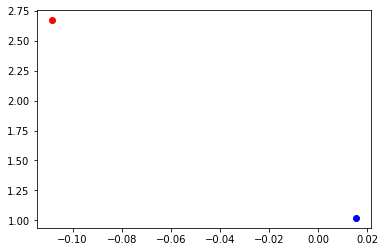

Count:6
()
()
Relative Depth: -2.974273248132584
Relative x: -0.9370128867710643
Relative Original Depth: -0.03457608974921833
Relative Original x: -0.0266379083531132
Count:7
()
()
Relative Depth: -3.5520151638454776
Relative x: -1.6059650193506139
Relative Original Depth: -1.015013136487203
Relative Original x: 0.03610052084117885
Count:8
()
()
Relative Depth: -4.140420295536725
Relative x: -2.0968513398069395
Relative Original Depth: -0.030498664519126195
Relative Original x: -0.0250338012253037
Count:9
()
()
Relative Depth: -4.197000421908331
Relative x: -2.4722468110562406
Relative Original Depth: 0.9461721108024828
Relative Original x: -0.03929433243706016
Count:10
()
()
Relative Depth: -4.134658548380471
Relative x: -2.611731670575604
Relative Original Depth: -0.046879470331672835
Relative Original x: 0.03463453512577528


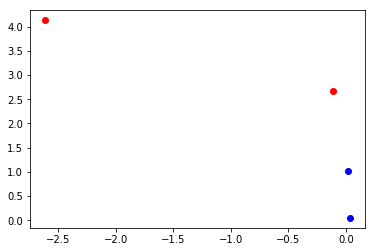

Count:11
()
()
Relative Depth: -3.8905026516371986
Relative x: -2.8419844601656297
Relative Original Depth: -1.0234558318395726
Relative Original x: -0.045712817030959134
Count:12
()
()
Relative Depth: -3.5613648134153384
Relative x: -2.004261957415609
Relative Original Depth: -2.007298255239932
Relative Original x: 0.038263980304922764
Count:13
()
()
Relative Depth: -4.444101998184244
Relative x: -2.3549401868821453
Relative Original Depth: -1.0238121624113625
Relative Original x: -0.04082241852386686
Count:14
()
()
Relative Depth: -5.38472123935451
Relative x: -2.2678390711269474
Relative Original Depth: -1.9985873499823774
Relative Original x: 0.03793442131454019
Count:15
()
()
Relative Depth: -6.234389807655702
Relative x: -2.1416051971213346
Relative Original Depth: -1.0180112916171278
Relative Original x: -0.005552715936996813


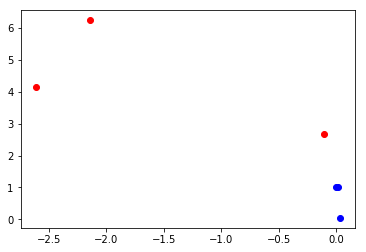

Count:16
()
()
Relative Depth: -7.152564460779882
Relative x: -2.5346725726577937
Relative Original Depth: -0.03378061726904169
Relative Original x: 0.00909434717950523
Count:17
()
()
Relative Depth: -7.902286724927775
Relative x: -3.177144078201892
Relative Original Depth: -1.0149582263951547
Relative Original x: 0.012214071050270642
Count:18
()
()
Relative Depth: -8.716574322688658
Relative x: -3.7534161508180217
Relative Original Depth: -1.996867252764614
Relative Original x: 0.09664056775873073
Count:19
()
()
Relative Depth: -9.567638802307098
Relative x: -4.275665117573526
Relative Original Depth: -2.964669633426356
Relative Original x: 0.1983720588500606
Count:20
()
()
Relative Depth: -10.406785002883028
Relative x: -4.802757559704909
Relative Original Depth: -3.9335691605209537
Relative Original x: 0.2577977770300821


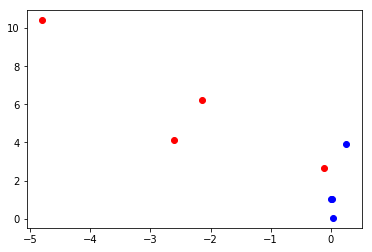

Count:21
()
()
Relative Depth: -11.207599824384781
Relative x: -5.264271163917075
Relative Original Depth: -2.956506713165621
Relative Original x: 0.19799407231995136
Count:22
()
()
Relative Depth: -12.047211483042512
Relative x: -5.505779684940372
Relative Original Depth: -1.969459964046321
Relative Original x: 0.13489060815467613
Count:23
()
()
Relative Depth: -12.985181724485464
Relative x: -5.851218976441568
Relative Original Depth: -2.9503162846129314
Relative Original x: 0.12890200567345222
Count:24
()
()
Relative Depth: -12.827475609063256
Relative x: -6.656912665387446
Relative Original Depth: -3.927936791528036
Relative Original x: 0.16814223075542675
Count:25
()
()
Relative Depth: -13.554421933680281
Relative x: -7.185965005950125
Relative Original Depth: -4.9113208013953
Relative Original x: 0.1701029815133018


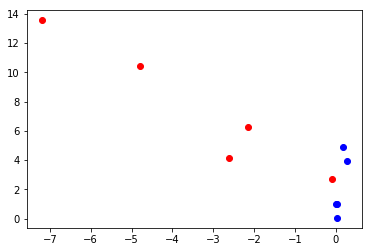

Count:26
()
()
Relative Depth: -14.248225259386434
Relative x: -7.609611199831154
Relative Original Depth: -5.904205793831362
Relative Original x: 0.20537912054866958
Count:27
()
()
Relative Depth: -14.812812332940581
Relative x: -8.088158966424603
Relative Original Depth: -6.878181930801632
Relative Original x: 0.20164524164294723
Count:28
()
()
Relative Depth: -15.103003675618627
Relative x: -8.652040579293887
Relative Original Depth: -7.858620615344497
Relative Original x: 0.18739920754402792
Count:29
()
()
Relative Depth: -15.065289371521667
Relative x: -8.976104108121703
Relative Original Depth: -8.826689643850619
Relative Original x: 0.2156657406212003
Count:30
()
()
Relative Depth: -15.064795887805916
Relative x: -8.944525505015214
Relative Original Depth: -9.810885857784381
Relative Original x: 0.25261334082328013


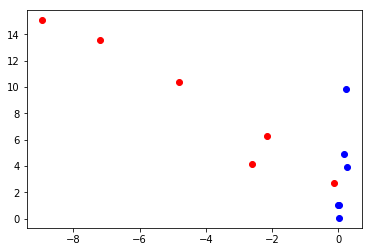

Count:31
()
()
Relative Depth: -15.176353512783741
Relative x: -8.68324949333731
Relative Original Depth: -10.796663683285903
Relative Original x: 0.2957088800444888
Count:32
()
()
Relative Depth: -15.335854525112305
Relative x: -8.30461772958823
Relative Original Depth: -11.770201657652139
Relative Original x: 0.2978881752814203
Count:33
()
()
Relative Depth: -16.187979599573183
Relative x: -8.03764884455544
Relative Original Depth: -12.740873525093507
Relative Original x: 0.24100687736035037
Count:34
()
()
Relative Depth: -16.690673216903967
Relative x: -7.71804724949289
Relative Original Depth: -13.710761110608054
Relative Original x: 0.20632856468688746
Count:35
()
()
Relative Depth: -17.062376933123826
Relative x: -8.041141368344608
Relative Original Depth: -14.68440592015182
Relative Original x: 0.22039934276539333


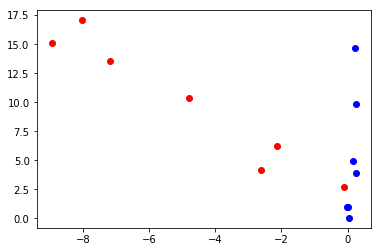

Count:36
()
()
Relative Depth: -17.43666074926492
Relative x: -7.726934556134629
Relative Original Depth: -15.65634479084676
Relative Original x: 0.18809902014877647
Count:37
()
()
Relative Depth: -18.125785059149003
Relative x: -7.702734510238268
Relative Original Depth: -16.631827755191505
Relative Original x: 0.15303626379907098
Count:38
()
()
Relative Depth: -19.036187175425702
Relative x: -7.876034354575097
Relative Original Depth: -17.615807957637696
Relative Original x: 0.0710057465704482
Count:39
()
()
Relative Depth: -18.506772718444132
Relative x: -7.4371795099950875
Relative Original Depth: -18.587293556189994
Relative Original x: 0.13812403048222532
Count:40
()
()
Relative Depth: -19.489694788006478
Relative x: -7.529983622724362
Relative Original Depth: -19.569475221455516
Relative Original x: 0.14814220493239447


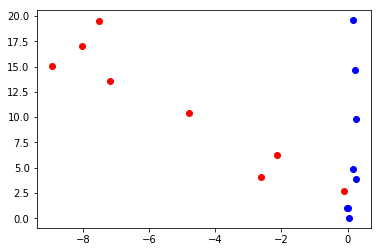

Count:41
()
()
Relative Depth: -20.28550450666276
Relative x: -7.724553852296619
Relative Original Depth: -20.55081027924549
Relative Original x: 0.14164508366883602
Count:42
()
()
Relative Depth: -20.29984920145454
Relative x: -7.902464704351999
Relative Original Depth: -21.524052523148125
Relative Original x: 0.1660163634113224
Count:43
()
()
Relative Depth: -20.049526923835174
Relative x: -8.044624438090473
Relative Original Depth: -22.50452193637017
Relative Original x: 0.18280977229480105
Count:44
()
()
Relative Depth: -19.818686199052337
Relative x: -8.200131339151781
Relative Original Depth: -23.479489707747586
Relative Original x: 0.18565266146735152
Count:45
()
()
Relative Depth: -19.68142533692385
Relative x: -8.50964673064461
Relative Original Depth: -24.46257549459618
Relative Original x: 0.19848349938928347


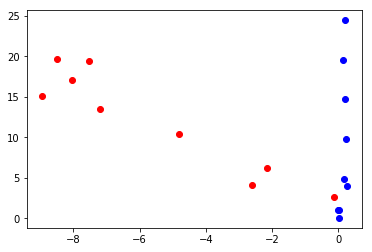

Count:46
()
()
Relative Depth: -19.253711598034773
Relative x: -8.87051176358271
Relative Original Depth: -25.422701023215723
Relative Original x: 0.13079376976167176
Count:47
()
()
Relative Depth: -18.561895154160627
Relative x: -9.124549839910697
Relative Original Depth: -26.387778487747003
Relative Original x: 0.09443600230733312
Count:48
()
()
Relative Depth: -17.854322086045357
Relative x: -9.218226829167671
Relative Original Depth: -27.363307450674796
Relative Original x: 0.0760881384981236
Count:49
()
()
Relative Depth: -17.09712220276764
Relative x: -9.156785916713439
Relative Original Depth: -28.346018434428583
Relative Original x: 0.10989355050921498
Count:50
()
()
Relative Depth: -16.557489979181565
Relative x: -8.914843786458551
Relative Original Depth: -29.323674155680937
Relative Original x: 0.11133834165540135


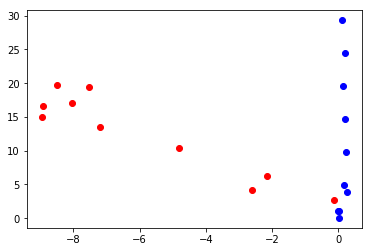

Count:51
()
()
Relative Depth: -16.607450369867095
Relative x: -8.316375644369659
Relative Original Depth: -30.303363804706986
Relative Original x: 0.1662874866090681
Count:52
()
()
Relative Depth: -16.890780055136073
Relative x: -7.910082615091218
Relative Original Depth: -31.280448841871106
Relative Original x: 0.1855543690342945
Count:53
()
()
Relative Depth: -17.089926530538353
Relative x: -7.797717373085812
Relative Original Depth: -32.25909932435057
Relative Original x: 0.1712723054814691
Count:54
()
()
Relative Depth: -17.284955740717354
Relative x: -7.481310577936105
Relative Original Depth: -33.24093006281222
Relative Original x: 0.21072212466007453
Count:55
()
()
Relative Depth: -17.691388313487725
Relative x: -7.2473773605129805
Relative Original Depth: -34.220392699904565
Relative Original x: 0.20535507315674428


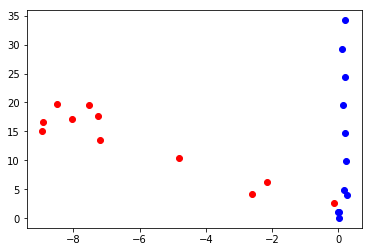

Count:56
()
()
Relative Depth: -18.02330306093737
Relative x: -6.65283414996107
Relative Original Depth: -35.20178641300584
Relative Original x: 0.1735140038412501
Count:57
()
()
Relative Depth: -18.05503814156987
Relative x: -5.86308774917284
Relative Original Depth: -36.180667512306
Relative Original x: 0.2987951099414099
Count:58
()
()
Relative Depth: -18.244195169916214
Relative x: -5.397108258015063
Relative Original Depth: -37.16712187369886
Relative Original x: 0.3609491771162368
Count:59
()
()
Relative Depth: -18.31469205469661
Relative x: -4.99480398835148
Relative Original Depth: -38.139744551620176
Relative Original x: 0.317815013132792
Count:60
()
()
Relative Depth: -18.152946572501094
Relative x: -4.505908630188893
Relative Original Depth: -39.11871649218448
Relative Original x: 0.3314036877560298


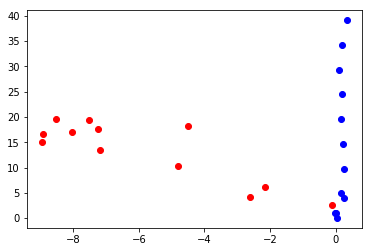

Count:61
()
()
Relative Depth: -17.95607446046124
Relative x: -3.9414742253483563
Relative Original Depth: -40.098698346132004
Relative Original x: 0.31905440186010925
Count:62
()
()
Relative Depth: -18.518973356120522
Relative x: -3.7418277139616802
Relative Original Depth: -41.068880796111735
Relative Original x: 0.29050613465310465
Count:63
()
()
Relative Depth: -18.655588985845732
Relative x: -4.677872482268372
Relative Original Depth: -42.04719486879208
Relative Original x: 0.2846672924627826
Count:64
()
()
Relative Depth: -18.66723733639291
Relative x: -4.0322661144203105
Relative Original Depth: -43.01897067027878
Relative Original x: 0.29656647262023383
Count:65
()
()
Relative Depth: -18.777103358058774
Relative x: -3.535540461190923
Relative Original Depth: -43.99424533067176
Relative Original x: 0.30392785250171594


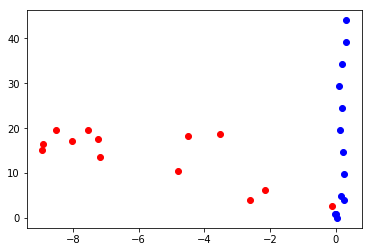

Count:66
()
()
Relative Depth: -18.9004544546149
Relative x: -2.892554650198996
Relative Original Depth: -44.977049963939315
Relative Original x: 0.2817302358840831
Count:67
()
()
Relative Depth: -19.08924128868889
Relative x: -1.939937124352456
Relative Original Depth: -45.95477218642698
Relative Original x: 0.2527810681614154
Count:68
()
()
Relative Depth: -19.42464192017481
Relative x: -0.9997309795586306
Relative Original Depth: -46.93448060040203
Relative Original x: 0.2620997371746004
Count:69
()
()
Relative Depth: -18.445866456997354
Relative x: -1.182573367784813
Relative Original Depth: -47.908649851039186
Relative Original x: 0.25070601681272386
Count:70
()
()
Relative Depth: -19.227284197651528
Relative x: -0.5608029487300361
Relative Original Depth: -48.886788016411046
Relative Original x: 0.24073647032871812


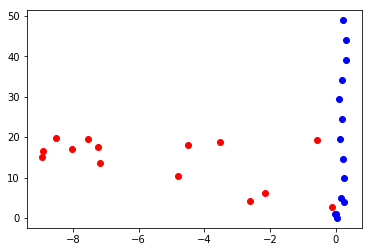

Count:71
()
()
Relative Depth: -20.15949715761108
Relative x: -0.26695604084886854
Relative Original Depth: -49.86624546210599
Relative Original x: 0.24598184159591627
Count:72
()
()
Relative Depth: -21.03300677692157
Relative x: -0.12364511602941247
Relative Original Depth: -50.837700967995765
Relative Original x: 0.2204962987378889
Count:73
()
()
Relative Depth: -21.840611251659027
Relative x: -0.2558437946675749
Relative Original Depth: -51.820763011799585
Relative Original x: 0.18409608343845674
Count:74
()
()
Relative Depth: -22.595733549235536
Relative x: -0.2051967408965862
Relative Original Depth: -52.799899877855395
Relative Original x: 0.1187687413969322
Count:75
()
()
Relative Depth: -23.252720786209636
Relative x: -0.015290996347032876
Relative Original Depth: -53.77786507199497
Relative Original x: 0.15171827830329143


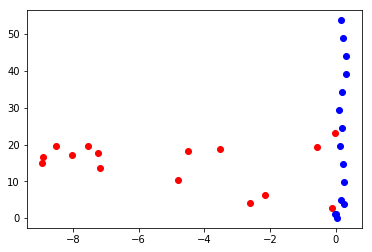

Count:76
()
()
Relative Depth: -23.93804577680657
Relative x: 0.09486792075845357
Relative Original Depth: -54.754749337997296
Relative Original x: 0.10355949300902359
Count:77
()
()
Relative Depth: -24.470549588386366
Relative x: 0.4493433730446838
Relative Original Depth: -55.734882154340454
Relative Original x: 0.07771973427970731
Count:78
()
()
Relative Depth: -23.790961423501425
Relative x: 0.6737705937404567
Relative Original Depth: -56.728037439552786
Relative Original x: 0.12657345880661264
Count:79
()
()
Relative Depth: -24.09021025472979
Relative x: 1.276782692201984
Relative Original Depth: -57.704096192964606
Relative Original x: 0.07793943715455517
Count:80
()
()
Relative Depth: -24.46696908451368
Relative x: 1.858105347792902
Relative Original Depth: -58.685079142746616
Relative Original x: 0.05274035451677569


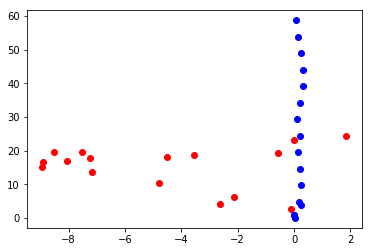

Count:81
()
()
Relative Depth: -24.908301948930887
Relative x: 2.4065958649767434
Relative Original Depth: -59.66722294692733
Relative Original x: 0.09746474971196042
Count:82
()
()
Relative Depth: -25.762780247384487
Relative x: 2.4035301935753033
Relative Original Depth: -60.64713819549071
Relative Original x: 0.11518666112893418
Count:83
()
()
Relative Depth: -26.695319270365346
Relative x: 2.0425528568243196
Relative Original Depth: -61.61646771339476
Relative Original x: 0.04171988178401177
Count:84
()
()
Relative Depth: -27.62141921796803
Relative x: 1.902136921122044
Relative Original Depth: -62.594026397592074
Relative Original x: 0.04613484033313489
Count:85
()
()
Relative Depth: -28.39288652309671
Relative x: 1.7343142453216558
Relative Original Depth: -63.5698338714753
Relative Original x: -0.0019278136758209968


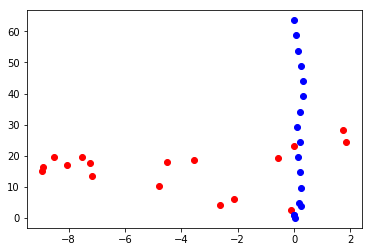

Count:86
()
()
Relative Depth: -29.087444223501333
Relative x: 1.433623424741128
Relative Original Depth: -64.5511687281702
Relative Original x: 0.01165573751090855
Count:87
()
()
Relative Depth: -29.763350872767415
Relative x: 1.0596780314036724
Relative Original Depth: -65.5127486572728
Relative Original x: -0.09056907403657034
Count:88
()
()
Relative Depth: -30.476503086427662
Relative x: 1.22853160003529
Relative Original Depth: -66.4886146369619
Relative Original x: -0.1254414827517712
Count:89
()
()
Relative Depth: -30.426515406820798
Relative x: 1.6417652207750155
Relative Original Depth: -67.47004276883524
Relative Original x: -0.15402374803328084
Count:90
()
()
Relative Depth: -31.045113515114767
Relative x: 2.389049245476733
Relative Original Depth: -68.44549339228165
Relative Original x: -0.19444331236255571


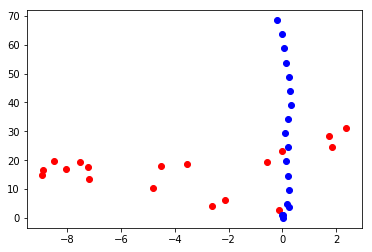

Count:91
()
()
Relative Depth: -31.879525723820358
Relative x: 2.8100315623617513
Relative Original Depth: -69.41685432505727
Relative Original x: -0.28833292794553106
Count:92
()
()
Relative Depth: -32.27466396173791
Relative x: 2.7612690885658813
Relative Original Depth: -70.38708819554815
Relative Original x: -0.3786465737373756
Count:93
()
()
Relative Depth: -32.1598089704297
Relative x: 2.6926230608252375
Relative Original Depth: -71.35944308334655
Relative Original x: -0.43949591703318797
Count:94
()
()
Relative Depth: -31.86400682816243
Relative x: 2.6233605619398817
Relative Original Depth: -72.32510504537588
Relative Original x: -0.5599916068128983
Count:95
()
()
Relative Depth: -31.601621852506213
Relative x: 2.5446284819033846
Relative Original Depth: -73.30386608974278
Relative Original x: -0.5682423772791514


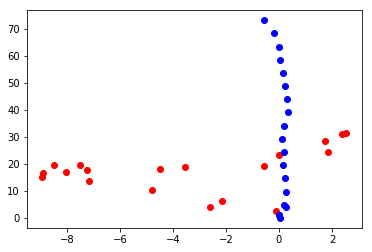

Count:96
()
()
Relative Depth: -31.50005081574296
Relative x: 2.4752379384530765
Relative Original Depth: -74.28480389249754
Relative Original x: -0.47779708861817355
Count:97
()
()
Relative Depth: -31.55156287274165
Relative x: 2.4381455594125763
Relative Original Depth: -75.26103289917553
Relative Original x: -0.46743249340950715
Count:98
()
()
Relative Depth: -31.77944757751345
Relative x: 2.598397259421368
Relative Original Depth: -76.22480938277863
Relative Original x: -0.5417130508985778
Count:99
()
()
Relative Depth: -31.840568917431607
Relative x: 2.8844594138484005
Relative Original Depth: -77.18955149704585
Relative Original x: -0.6177051400674667
Count:100
()
()
Relative Depth: -32.71354705055177
Relative x: 3.1750586815265835
Relative Original Depth: -78.15990037110097
Relative Original x: -0.6866785363247769


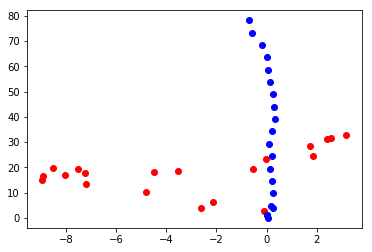

Count:101
()
()
Relative Depth: -32.50483482617495
Relative x: 3.3777919942251917
Relative Original Depth: -79.12244774149882
Relative Original x: -0.7837303049630706
Count:102
()
()
Relative Depth: -32.31077702683939
Relative x: 3.534217570530493
Relative Original Depth: -80.09785503690263
Relative Original x: -0.803305391814326
Count:103
()
()
Relative Depth: -32.34400771343681
Relative x: 3.74123926664563
Relative Original Depth: -81.0769064909654
Relative Original x: -0.8499600133603469
Count:104
()
()
Relative Depth: -32.33478915188966
Relative x: 3.8713605534151347
Relative Original Depth: -82.04340069134193
Relative Original x: -0.9294353415621914
Count:105
()
()
Relative Depth: -32.204626572088955
Relative x: 3.936320416809529
Relative Original Depth: -83.01193400782986
Relative Original x: -1.0181637507497212


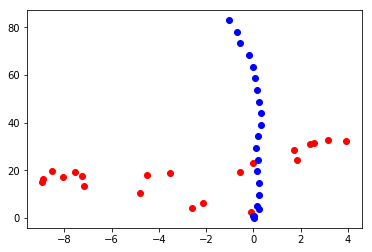

Count:106
()
()
Relative Depth: -32.31754522185469
Relative x: 4.175141492799706
Relative Original Depth: -83.98972529718452
Relative Original x: -1.0477139298709117
Count:107
()
()
Relative Depth: -32.78597472034405
Relative x: 3.328762459199547
Relative Original Depth: -84.94813316073386
Relative Original x: -1.1663863100422975
Count:108
()
()
Relative Depth: -33.18831771529999
Relative x: 3.689557381733972
Relative Original Depth: -85.92262252628178
Relative Original x: -1.2092016115708968
Count:109
()
()
Relative Depth: -33.984830872311555
Relative x: 4.054304308291306
Relative Original Depth: -86.88080404235221
Relative Original x: -1.3296146161026914
Count:110
()
()
Relative Depth: -34.982972650293654
Relative x: 4.1003754472850655
Relative Original Depth: -87.85756099297807
Relative Original x: -1.3697900778125227


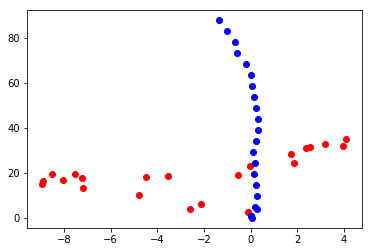

Count:111
()
()
Relative Depth: -35.95061610442162
Relative x: 3.872294334290649
Relative Original Depth: -88.83567471432227
Relative Original x: -1.4822784669960654
Count:112
()
()
Relative Depth: -36.90582581689065
Relative x: 3.629345271595089
Relative Original Depth: -89.80867222962381
Relative Original x: -1.502987937788899
Count:113
()
()
Relative Depth: -37.835665659724036
Relative x: 3.9303022849218574
Relative Original Depth: -90.79393366570812
Relative Original x: -1.4957585494432433
Count:114
()
()
Relative Depth: -38.428161614839695
Relative x: 4.622214573360688
Relative Original Depth: -91.77496041678634
Relative Original x: -1.462533436513406
Count:115
()
()
Relative Depth: -38.39684787968936
Relative x: 5.558268161728898
Relative Original Depth: -92.7486459776398
Relative Original x: -1.387732268456172


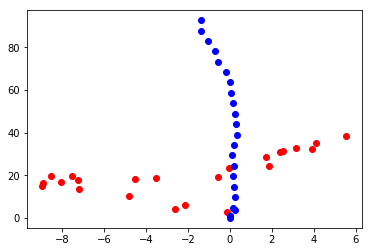

Count:116
()
()
Relative Depth: -38.857245687420665
Relative x: 6.20219740189084
Relative Original Depth: -93.72919245214256
Relative Original x: -1.3968832428889886
Count:117
()
()
Relative Depth: -39.151743103355315
Relative x: 6.688294662211812
Relative Original Depth: -94.71562031702167
Relative Original x: -1.4229301037173316
Count:118
()
()
Relative Depth: -39.358218014738334
Relative x: 7.022362144622714
Relative Original Depth: -95.68465051525996
Relative Original x: -1.509060861593666
Count:119
()
()
Relative Depth: -39.6186646480749
Relative x: 7.384585514701261
Relative Original Depth: -96.66297125926634
Relative Original x: -1.5777868271867341
Count:120
()
()
Relative Depth: -40.08624140800281
Relative x: 7.59358126484945
Relative Original Depth: -97.6432113732495
Relative Original x: -1.6190068375744906


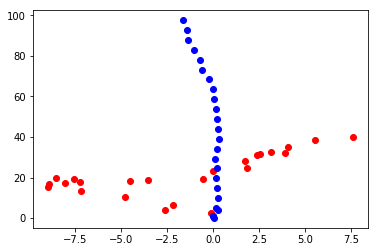

Count:121
()
()
Relative Depth: -40.68622684866837
Relative x: 7.628831135432083
Relative Original Depth: -98.62129968508695
Relative Original x: -1.6810033861463194
Count:122
()
()
Relative Depth: -41.266555861561706
Relative x: 7.6269075649739895
Relative Original Depth: -99.59701929508532
Relative Original x: -1.707002814892472
Count:123
()
()
Relative Depth: -41.90891091507482
Relative x: 7.5395408002044775
Relative Original Depth: -100.56961761071666
Relative Original x: -1.7655254419324007
Count:124
()
()
Relative Depth: -42.573180936430255
Relative x: 7.265042235359356
Relative Original Depth: -101.54937623034041
Relative Original x: -1.7940532526255435
Count:125
()
()
Relative Depth: -43.09534314936437
Relative x: 6.765725217104181
Relative Original Depth: -102.5176392263464
Relative Original x: -1.8902655458604922


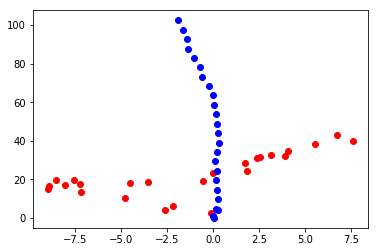

Count:126
()
()
Relative Depth: -43.08907283790571
Relative x: 5.952687391597596
Relative Original Depth: -103.4980531582151
Relative Original x: -1.912428095829682
Count:127
()
()
Relative Depth: -42.512901744248346
Relative x: 5.139740478358833
Relative Original Depth: -104.48025863087132
Relative Original x: -1.9337757071874195
Count:128
()
()
Relative Depth: -41.891984503556415
Relative x: 4.498984267711636
Relative Original Depth: -105.46018772884776
Relative Original x: -1.9949425940919185
Count:129
()
()
Relative Depth: -41.62108153211092
Relative x: 4.000365922330207
Relative Original Depth: -106.44370599965876
Relative Original x: -2.0290306443408634
Count:130
()
()
Relative Depth: -41.82115786071373
Relative x: 3.939743931193934
Relative Original Depth: -107.42678639352127
Relative Original x: -2.0568089646014833


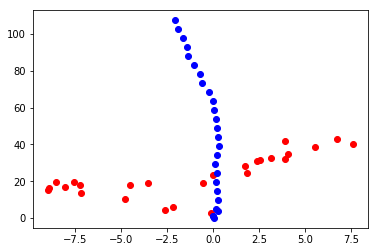

Count:131
()
()
Relative Depth: -41.78217207743313
Relative x: 4.196295560689867
Relative Original Depth: -108.40621112111893
Relative Original x: -2.0697539093348003
Count:132
()
()
Relative Depth: -41.447042175658446
Relative x: 4.672564791085069
Relative Original Depth: -109.37743990717574
Relative Original x: -2.124420153445623
Count:133
()
()
Relative Depth: -41.07480496226436
Relative x: 5.150676183821738
Relative Original Depth: -110.34762194940528
Relative Original x: -2.186806437710018
Count:134
()
()
Relative Depth: -40.730660055369796
Relative x: 5.596076126354896
Relative Original Depth: -111.32246313364692
Relative Original x: -2.250069210933572
Count:135
()
()
Relative Depth: -40.406981517969534
Relative x: 6.5178626668264625
Relative Original Depth: -112.29738565908383
Relative Original x: -2.308033780120798


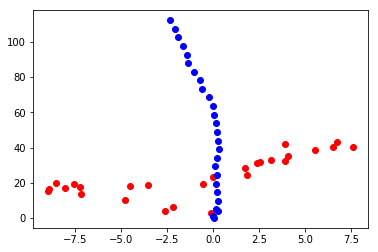

Count:136
()
()
Relative Depth: -41.16033589120451
Relative x: 6.333901595021403
Relative Original Depth: -113.26942081804103
Relative Original x: -2.3689842326896153
Count:137
()
()
Relative Depth: -41.10798430626123
Relative x: 6.944570067230007
Relative Original Depth: -114.24787571242575
Relative Original x: -2.3913930135251302
Count:138
()
()
Relative Depth: -41.326002346371084
Relative x: 6.018775564571142
Relative Original Depth: -115.22254567263712
Relative Original x: -2.4585602583826143
Count:139
()
()
Relative Depth: -41.66866581013613
Relative x: 6.720812954922826
Relative Original Depth: -116.20217246290426
Relative Original x: -2.4189038119214503
Count:140
()
()
Relative Depth: -41.97444561332598
Relative x: 7.500096468492202
Relative Original Depth: -117.17811435783226
Relative Original x: -2.4335725486805053


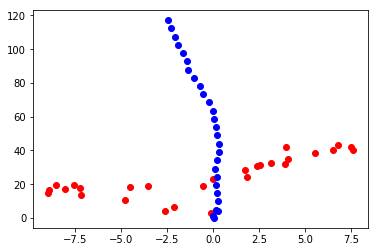

Count:141
()
()
Relative Depth: -42.059591881701444
Relative x: 8.426223157833082
Relative Original Depth: -118.15374218807759
Relative Original x: -2.477592214416078
Count:142
()
()
Relative Depth: -41.61210028259069
Relative x: 9.279552464403974
Relative Original Depth: -119.13439351317379
Relative Original x: -2.5089083866716
Count:143
()
()
Relative Depth: -40.861087648875774
Relative x: 9.85683459404421
Relative Original Depth: -120.10312127354858
Relative Original x: -2.575664656840566
Count:144
()
()
Relative Depth: -40.20262741258859
Relative x: 10.541965425122152
Relative Original Depth: -121.07596881102126
Relative Original x: -2.6036917878649994
Count:145
()
()
Relative Depth: -39.58881071271932
Relative x: 11.301918234007726
Relative Original Depth: -122.0547803940304
Relative Original x: -2.6228068740969017


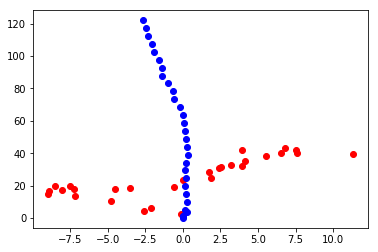

Count:146
()
()
Relative Depth: -38.91345666402622
Relative x: 12.016234473524355
Relative Original Depth: -123.03060437833524
Relative Original x: -2.6067055588698707
Count:147
()
()
Relative Depth: -38.22289523514705
Relative x: 12.712607719501483
Relative Original Depth: -124.00679267416912
Relative Original x: -2.643429059630008
Count:148
()
()
Relative Depth: -37.591571484452245
Relative x: 13.445591934468125
Relative Original Depth: -124.9750720845059
Relative Original x: -2.6432835982778577
Count:149
()
()
Relative Depth: -37.07926157504036
Relative x: 14.063849625207336
Relative Original Depth: -125.95125397791952
Relative Original x: -2.721381265397288
Count:150
()
()
Relative Depth: -36.755113442628684
Relative x: 13.928777180767726
Relative Original Depth: -126.92930661705923
Relative Original x: -2.7436153738482894


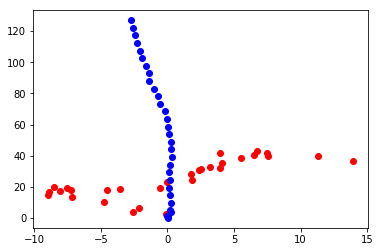

Count:151
()
()
Relative Depth: -36.349991645179216
Relative x: 14.668090099690142
Relative Original Depth: -127.91029516095017
Relative Original x: -2.7517442679164397
Count:152
()
()
Relative Depth: -36.259509865764045
Relative x: 14.67261370207004
Relative Original Depth: -128.88226345396822
Relative Original x: -2.8161526653977913
Count:153
()
()
Relative Depth: -36.923163634620764
Relative x: 14.155919788641693
Relative Original Depth: -129.86040320226138
Relative Original x: -2.835714881224172
Count:154
()
()
Relative Depth: -37.9229045458481
Relative x: 14.135258019966155
Relative Original Depth: -130.83930785006206
Relative Original x: -2.861253015326196
Count:155
()
()
Relative Depth: -38.12289102364552
Relative x: 14.946916199121228
Relative Original Depth: -131.81554148525484
Relative Original x: -2.8780033498188624


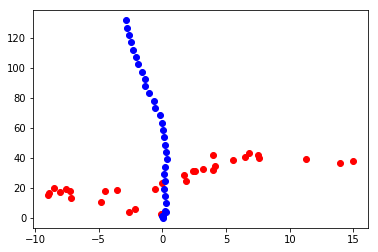

Count:156
()
()
Relative Depth: -38.8506845257007
Relative x: 15.346473632901937
Relative Original Depth: -132.79663501776812
Relative Original x: -2.8888596816346093
Count:157
()
()
Relative Depth: -39.428072622585354
Relative x: 15.246760200598722
Relative Original Depth: -133.76179685497604
Relative Original x: -2.936847807201025
Count:158
()
()
Relative Depth: -40.099433267133044
Relative x: 14.959366295099253
Relative Original Depth: -134.7437811660105
Relative Original x: -2.9183541743009322
Count:159
()
()
Relative Depth: -40.61323035490286
Relative x: 14.644793687745302
Relative Original Depth: -135.7162768358156
Relative Original x: -2.935098834803687
Count:160
()
()
Relative Depth: -40.71228709713549
Relative x: 14.359493668117986
Relative Original Depth: -136.69776561157707
Relative Original x: -2.9613947851082454


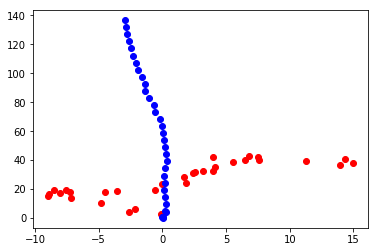

Count:161
()
()
Relative Depth: -40.24561902410471
Relative x: 14.265024619573309
Relative Original Depth: -137.68052346474659
Relative Original x: -3.0021495063763686
Count:162
()
()
Relative Depth: -39.43117234735056
Relative x: 14.118143037407501
Relative Original Depth: -138.6567105430852
Relative Original x: -3.0574084563948705
Count:163
()
()
Relative Depth: -38.572951820175206
Relative x: 13.864942572926749
Relative Original Depth: -139.64902645726926
Relative Original x: -3.040664805450828
Count:164
()
()
Relative Depth: -37.86181590757668
Relative x: 13.526134357954406
Relative Original Depth: -140.61847994068455
Relative Original x: -3.076256864726914
Count:165
()
()
Relative Depth: -37.044940578498036
Relative x: 13.353103891323947
Relative Original Depth: -141.60163786914163
Relative Original x: -3.118713948324811


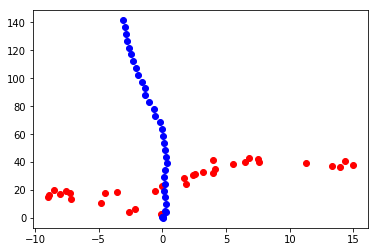

Count:166
()
()
Relative Depth: -36.110965060854674
Relative x: 13.422907112911119
Relative Original Depth: -142.57652398335992
Relative Original x: -3.119285956779937
Count:167
()
()
Relative Depth: -35.21531467194812
Relative x: 13.490438962481333
Relative Original Depth: -143.5566868252542
Relative Original x: -3.1540911773312823
Count:168
()
()
Relative Depth: -34.29955341505892
Relative x: 13.490501412441512
Relative Original Depth: -144.5324027947535
Relative Original x: -3.163713341422388
Count:169
()
()
Relative Depth: -33.344283023297855
Relative x: 13.402837798611808
Relative Original Depth: -145.51110542838143
Relative Original x: -3.15980314252324
Count:170
()
()
Relative Depth: -32.64963517621893
Relative x: 13.786681548361129
Relative Original Depth: -146.48587053853822
Relative Original x: -3.185489427629588


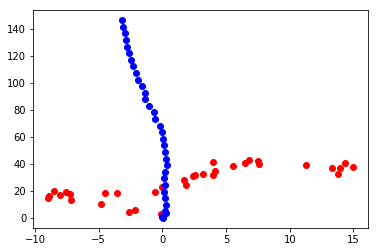

Count:171
()
()
Relative Depth: -32.49390527980479
Relative x: 14.45796090610237
Relative Original Depth: -147.47770904575805
Relative Original x: -3.13361894471209
Count:172
()
()
Relative Depth: -32.45052102640479
Relative x: 15.108422883606666
Relative Original Depth: -148.45652833615776
Relative Original x: -3.1566208722875237
Count:173
()
()
Relative Depth: -31.93356194942188
Relative x: 15.863494820899774
Relative Original Depth: -149.43348500613192
Relative Original x: -3.211514217437841
Count:174
()
()
Relative Depth: -31.066021874405628
Relative x: 16.347232497574915
Relative Original Depth: -150.4057591263702
Relative Original x: -3.2844306013888946
Count:175
()
()
Relative Depth: -30.21887106147342
Relative x: 16.81208208653935
Relative Original Depth: -151.3780649357232
Relative Original x: -3.3236458547551737


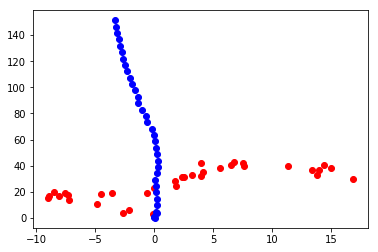

Count:176
()
()
Relative Depth: -29.413643624707447
Relative x: 17.14229394309439
Relative Original Depth: -152.34476382298135
Relative Original x: -3.3581196659957824
Count:177
()
()
Relative Depth: -28.602832699976616
Relative x: 17.015689077283703
Relative Original Depth: -153.33054366218678
Relative Original x: -3.304075951007737
Count:178
()
()
Relative Depth: -27.888738612449767
Relative x: 16.600257122003494
Relative Original Depth: -154.30833872708348
Relative Original x: -3.351003252128051
Count:179
()
()
Relative Depth: -28.240790828351184
Relative x: 15.873948474359231
Relative Original Depth: -155.29030369842533
Relative Original x: -3.3471905462364613
Count:180
()
()
Relative Depth: -27.40432443946493
Relative x: 15.614248811248162
Relative Original Depth: -156.2783014957018
Relative Original x: -3.365714847088997


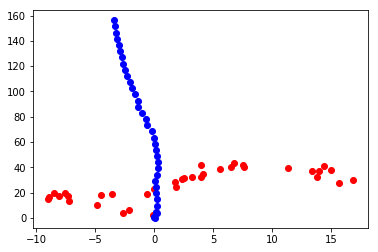

Count:181
()
()
Relative Depth: -26.52911931279892
Relative x: 16.056771347202766
Relative Original Depth: -157.25477289743074
Relative Original x: -3.431118127722284
Count:182
()
()
Relative Depth: -25.958290731138064
Relative x: 16.864277758261085
Relative Original Depth: -158.23689654665944
Relative Original x: -3.38917450380235
Count:183
()
()
Relative Depth: -25.44402449705222
Relative x: 17.72138321279407
Relative Original Depth: -159.21555980626542
Relative Original x: -3.413841226626805
Count:184
()
()
Relative Depth: -25.053709764080963
Relative x: 18.628439043038508
Relative Original Depth: -160.19285934204717
Relative Original x: -3.449049593243538
Count:185
()
()
Relative Depth: -24.366459264295813
Relative x: 18.646066011695503
Relative Original Depth: -161.16494609411455
Relative Original x: -3.340339800579422


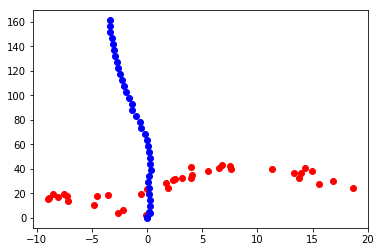

Count:186
()
()
Relative Depth: -24.003088861832897
Relative x: 19.576099147412524
Relative Original Depth: -162.12887676510485
Relative Original x: -3.3979328523585304
Count:187
()
()
Relative Depth: -23.008925634952117
Relative x: 19.47533134022811
Relative Original Depth: -163.0923379991802
Relative Original x: -3.4860750003415144
Count:188
()
()
Relative Depth: -23.10037097106936
Relative x: 20.45172949149772
Relative Original Depth: -164.07838971138713
Relative Original x: -3.512770974463126
Count:189
()
()
Relative Depth: -24.00459973220493
Relative x: 20.853375008253106
Relative Original Depth: -165.05098612610115
Relative Original x: -3.425959989640362
Count:190
()
()
Relative Depth: -24.99363739273175
Relative x: 20.823767769142144
Relative Original Depth: -166.02826006462072
Relative Original x: -3.4019366725215336


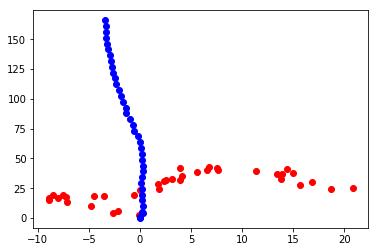

Count:191
()
()
Relative Depth: -25.991500298764777
Relative x: 20.84859927157512
Relative Original Depth: -167.0061888387561
Relative Original x: -3.3916735881960816
Count:192
()
()
Relative Depth: -26.804701115322704
Relative x: 20.59059948789755
Relative Original Depth: -167.98792656811318
Relative Original x: -3.381627153913681
Count:193
()
()
Relative Depth: -27.79265308194951
Relative x: 20.739746926044297
Relative Original Depth: -168.95462691850898
Relative Original x: -3.4294029319635526
Count:194
()
()
Relative Depth: -28.733627015675854
Relative x: 20.721335506854633
Relative Original Depth: -169.9370245720172
Relative Original x: -3.4654209825368736
Count:195
()
()
Relative Depth: -29.668132057285014
Relative x: 20.442178645541237
Relative Original Depth: -168.95188285095597
Relative Original x: -3.4504877324216188


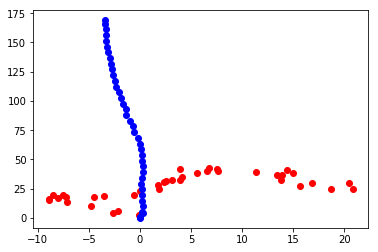

Count:196
()
()
Relative Depth: -30.65620275089954
Relative x: 20.310681008112702
Relative Original Depth: -169.94627438597163
Relative Original x: -3.4854277926599493
Count:197
()
()
Relative Depth: -31.65018324965729
Relative x: 20.347861604658945
Relative Original Depth: -170.93536503046855
Relative Original x: -3.41982087272345
Count:198
()
()
Relative Depth: -32.588549836739354
Relative x: 20.66566906062022
Relative Original Depth: -171.91844171507566
Relative Original x: -3.4847380636062533
Count:199
()
()
Relative Depth: -33.434524472683115
Relative x: 21.045387219239675
Relative Original Depth: -170.9278904747377
Relative Original x: -3.510064242443127
Count:200
()
()
Relative Depth: -34.28872973048545
Relative x: 21.36071295813879
Relative Original Depth: -169.9412174449946
Relative Original x: -3.4817984313671575


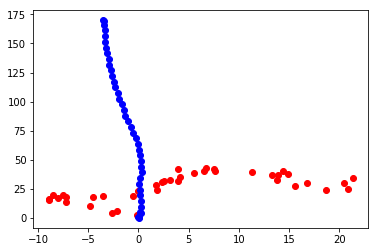

Count:201
()
()
Relative Depth: -35.002842447239715
Relative x: 21.95182251675658
Relative Original Depth: -170.93294047289194
Relative Original x: -3.6008165276111606
Count:202
()
()
Relative Depth: -35.571053578502564
Relative x: 22.752059988328394
Relative Original Depth: -171.92448605728697
Relative Original x: -3.618516851545301
Count:203
()
()
Relative Depth: -36.35780080143588
Relative x: 23.324835829373367
Relative Original Depth: -172.9155512740383
Relative Original x: -3.6903184895931593
Count:204
()
()
Relative Depth: -37.19817081336261
Relative x: 23.518188675561948
Relative Original Depth: -171.9337413927854
Relative Original x: -3.849184074618171
Count:205
()
()
Relative Depth: -36.23779755811854
Relative x: 23.239554204658404
Relative Original Depth: -170.94440697325493
Relative Original x: -3.922638105977601


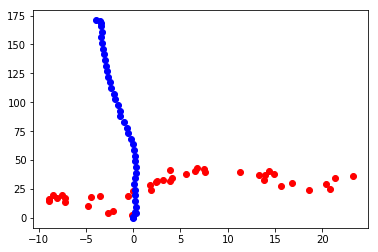

Count:206
()
()
Relative Depth: -36.98056030152807
Relative x: 23.63311703967408
Relative Original Depth: -171.92621217616625
Relative Original x: -3.786325466373844
Count:207
()
()
Relative Depth: -37.589155513247
Relative x: 24.17289573647403
Relative Original Depth: -172.90764265188366
Relative Original x: -3.6784782254319053
Count:208
()
()
Relative Depth: -38.46844255056471
Relative x: 24.212233893291522
Relative Original Depth: -173.89611878169717
Relative Original x: -3.563714718362342
Count:209
()
()
Relative Depth: -39.45824246568457
Relative x: 24.157853322390622
Relative Original Depth: -172.90447141250579
Relative Original x: -3.603975382127116
Count:210
()
()
Relative Depth: -40.37663232918272
Relative x: 24.548951293593365
Relative Original Depth: -173.89086760754157
Relative Original x: -3.6467154709381617


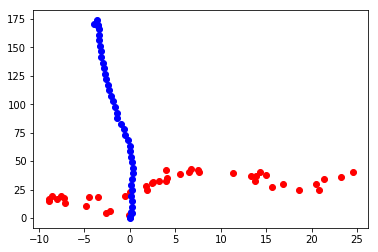

Count:211
()
()
Relative Depth: -41.35650912140723
Relative x: 24.44385958754479
Relative Original Depth: -174.89047623585628
Relative Original x: -3.6426497575694583
Count:212
()
()
Relative Depth: -41.97580675440837
Relative x: 23.78851117598864
Relative Original Depth: -175.88439098817676
Relative Original x: -3.6347891202379126
Count:213
()
()
Relative Depth: -42.29902893635343
Relative x: 23.216884376742616
Relative Original Depth: -176.87862444251343
Relative Original x: -3.650181675855105
Count:214
()
()
Relative Depth: -42.692485180175964
Relative x: 22.745860985517336
Relative Original Depth: -175.88522944162813
Relative Original x: -3.670569423562877
Count:215
()
()
Relative Depth: -41.86633767475232
Relative x: 22.438695678825546
Relative Original Depth: -176.87657179042964
Relative Original x: -3.640975348706438


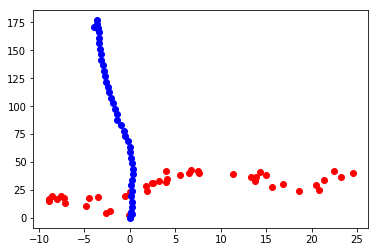

Count:216
()
()
Relative Depth: -41.702522750307395
Relative x: 22.29531983956661
Relative Original Depth: -177.87326774840108
Relative Original x: -3.658795491578889
Count:217
()
()
Relative Depth: -41.33387383570221
Relative x: 22.559156301947613
Relative Original Depth: -178.85763296621215
Relative Original x: -3.689577051884762
Count:218
()
()
Relative Depth: -41.4493598957428
Relative x: 22.86408586756433
Relative Original Depth: -179.8362725243113
Relative Original x: -3.8305936966486738
Count:219
()
()
Relative Depth: -41.502214678138
Relative x: 23.00207385788361
Relative Original Depth: -180.83260542606428
Relative Original x: -3.8319097571482317
Count:220
()
()
Relative Depth: -40.89177270383891
Relative x: 23.301213555353204
Relative Original Depth: -181.8252547019138
Relative Original x: -3.824611776442927


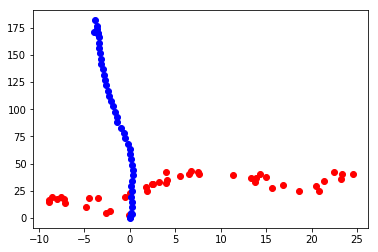

Count:221
()
()
Relative Depth: -40.33428857199084
Relative x: 24.105198661725133
Relative Original Depth: -182.82163047130516
Relative Original x: -3.8698829213933714
Count:222
()
()
Relative Depth: -39.64386552186969
Relative x: 24.584123041853726
Relative Original Depth: -183.81801244531593
Relative Original x: -3.880945440740537
Count:223
()
()
Relative Depth: -39.322700047869304
Relative x: 24.889225111119778
Relative Original Depth: -184.81355371129334
Relative Original x: -3.8819200697612053
Count:224
()
()
Relative Depth: -39.393465116357305
Relative x: 25.080865960686506
Relative Original Depth: -185.80641712089
Relative Original x: -3.889964724276068
Count:225
()
()
Relative Depth: -39.790808593322254
Relative x: 25.24039131315097
Relative Original Depth: -186.8010344368761
Relative Original x: -3.8348663702622843


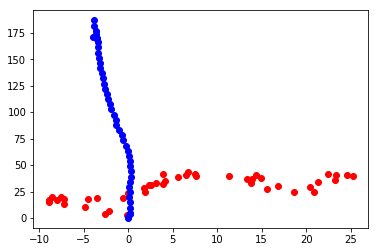

Count:226
()
()
Relative Depth: -40.21023479895846
Relative x: 25.38468274279042
Relative Original Depth: -187.788078972927
Relative Original x: -3.9065484189140363
Count:227
()
()
Relative Depth: -39.66516411613585
Relative x: 25.665108920059975
Relative Original Depth: -188.78403325225554
Relative Original x: -3.9208728510826285
Count:228
()
()
Relative Depth: -40.18395358879393
Relative x: 25.851243836060412
Relative Original Depth: -189.77639144629978
Relative Original x: -3.9523417456055623
Count:229
()
()
Relative Depth: -40.866548019704574
Relative x: 26.03797429375798
Relative Original Depth: -190.76688667284566
Relative Original x: -3.829725067088489
Count:230
()
()
Relative Depth: -41.6892197416591
Relative x: 26.261389279868762
Relative Original Depth: -191.7605930149206
Relative Original x: -3.861173257374048


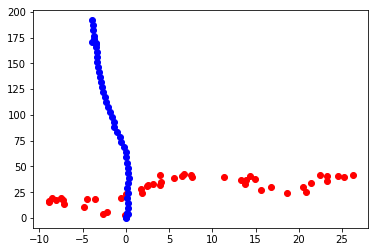

Count:231
()
()
Relative Depth: -42.252004599517186
Relative x: 27.059407651867804
Relative Original Depth: -192.7575336892655
Relative Original x: -3.820507810958322
Count:232
()
()
Relative Depth: -42.25002606251995
Relative x: 28.05937608108572
Relative Original Depth: -193.7489625042776
Relative Original x: -3.7983243401643296
Count:233
()
()
Relative Depth: -42.37631554060824
Relative x: 29.040593744403598
Relative Original Depth: -194.74033660222014
Relative Original x: -3.831560167755408
Count:234
()
()
Relative Depth: -43.25959266285977
Relative x: 29.28217664101383
Relative Original Depth: -195.72494897369364
Relative Original x: -3.726670055342784
Count:235
()
()
Relative Depth: -43.26753978440487
Relative x: 28.799515665147148
Relative Original Depth: -196.71669116017952
Relative Original x: -3.668838541376928


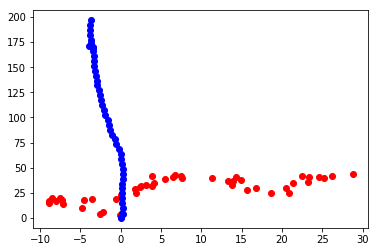

Count:236
()
()
Relative Depth: -42.61102728968538
Relative x: 28.960512586290687
Relative Original Depth: -197.70990846074764
Relative Original x: -3.608100510937063
Count:237
()
()
Relative Depth: -43.5495176792426
Relative x: 29.102375856502192
Relative Original Depth: -198.7082362145845
Relative Original x: -3.5591283550930277
Count:238
()
()
Relative Depth: -44.26133511156039
Relative x: 29.220494719230217
Relative Original Depth: -199.70112697752904
Relative Original x: -3.5996906283115675
Count:239
()
()
Relative Depth: -44.42342686615288
Relative x: 28.884879489333695
Relative Original Depth: -200.69969283440585
Relative Original x: -3.5668286445666886
Count:240
()
()
Relative Depth: -44.258073620427226
Relative x: 28.195502122733597
Relative Original Depth: -201.69476290919368
Relative Original x: -3.554466746692071


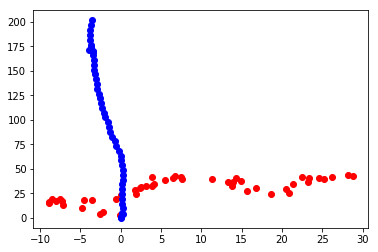

Count:241
()
()
Relative Depth: -44.00372261911794
Relative x: 27.432911566557493
Relative Original Depth: -202.688531681608
Relative Original x: -3.509393562667715
Count:242
()
()
Relative Depth: -43.671435852343116
Relative x: 26.637453548634124
Relative Original Depth: -203.6667921640543
Relative Original x: -3.325892536350371
Count:243
()
()
Relative Depth: -43.44589715418591
Relative x: 25.89799712330008
Relative Original Depth: -204.66017876313012
Relative Original x: -3.330000605696176
Count:244
()
()
Relative Depth: -42.64672396402554
Relative x: 25.337144145272088
Relative Original Depth: -205.6571090176742
Relative Original x: -3.334116141834117
Count:245
()
()
Relative Depth: -41.91959699810632
Relative x: 24.859322065415967
Relative Original Depth: -206.65222623075744
Relative Original x: -3.331049432665717


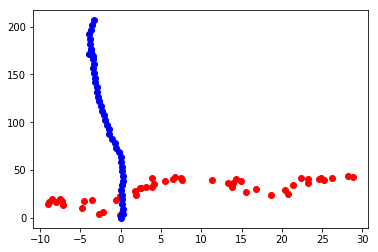

Count:246
()
()
Relative Depth: -42.003951113750766
Relative x: 24.332190296414208
Relative Original Depth: -207.64684483415968
Relative Original x: -3.337376535171269
Count:247
()
()
Relative Depth: -42.420385775179774
Relative x: 24.582899486665195
Relative Original Depth: -208.64473698931948
Relative Original x: -3.327936764442267
Count:248
()
()
Relative Depth: -42.90655662233826
Relative x: 25.413158860550666
Relative Original Depth: -209.64153145171156
Relative Original x: -3.31653822920117
Count:249
()
()
Relative Depth: -43.639957500011064
Relative x: 26.08452190833448
Relative Original Depth: -210.6358874496489
Relative Original x: -3.3094522483690056
Count:250
()
()
Relative Depth: -44.459455102093855
Relative x: 26.517086544406705
Relative Original Depth: -211.6332507923773
Relative Original x: -3.3004310392036023


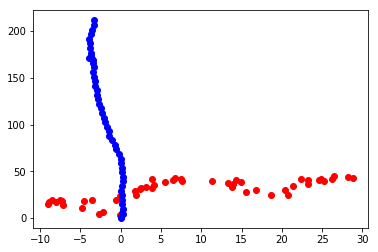

Count:251
()
()
Relative Depth: -45.243158975047876
Relative x: 27.00348838270413
Relative Original Depth: -212.62287927827467
Relative Original x: -3.2028406467569144
Count:252
()
()
Relative Depth: -45.26270809139413
Relative x: 26.19950849171805
Relative Original Depth: -213.61870162117455
Relative Original x: -3.2015785653015763
Count:253
()
()
Relative Depth: -45.994479741510844
Relative x: 26.85332755939166
Relative Original Depth: -214.6153689015604
Relative Original x: -3.267109842606813
Count:254
()
()
Relative Depth: -46.62286344358358
Relative x: 27.63031758154693
Relative Original Depth: -215.6142480072204
Relative Original x: -3.261001656086705
Count:255
()
()
Relative Depth: -46.28464550347288
Relative x: 27.1182962948831
Relative Original Depth: -216.6075282419091
Relative Original x: -3.2182976995575276


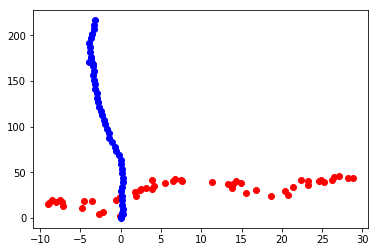

Count:256
()
()
Relative Depth: -46.85245496319727
Relative x: 27.938276374620155
Relative Original Depth: -217.6045452328173
Relative Original x: -3.157234817263348
Count:257
()
()
Relative Depth: -47.35712482292284
Relative x: 28.775754232946255
Relative Original Depth: -218.6020461979037
Relative Original x: -3.153647095278955
Count:258
()
()
Relative Depth: -47.87312266888875
Relative x: 29.606102462044802
Relative Original Depth: -219.5964371138947
Relative Original x: -3.1851429549695656
Count:259
()
()
Relative Depth: -48.29323848504686
Relative x: 30.19827808756299
Relative Original Depth: -220.59329544207677
Relative Original x: -3.1880331435430227
Count:260
()
()
Relative Depth: -48.730741682467645
Relative x: 30.801902166968787
Relative Original Depth: -221.5893770613788
Relative Original x: -3.134218934579101


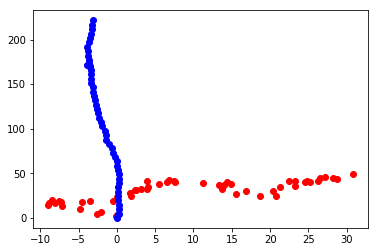

Count:261
()
()
Relative Depth: -49.21966662111375
Relative x: 31.445456316908906
Relative Original Depth: -222.5831372085718
Relative Original x: -3.1410176702897976
Count:262
()
()
Relative Depth: -49.71081683565492
Relative x: 32.08527573220319
Relative Original Depth: -223.57829527740927
Relative Original x: -3.071384059588214
Count:263
()
()
Relative Depth: -50.21473259823173
Relative x: 32.75988981356819
Relative Original Depth: -224.57276528393336
Relative Original x: -3.004857887048901
Count:264
()
()
Relative Depth: -50.687158701138664
Relative x: 33.27978479720212
Relative Original Depth: -225.57020901011882
Relative Original x: -3.0037259964641065
Count:265
()
()
Relative Depth: -50.6930862415258
Relative x: 33.364714388102705
Relative Original Depth: -226.56391511171464
Relative Original x: -2.9753441421385225


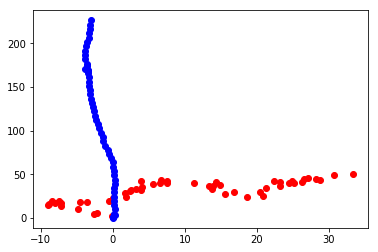

Count:266
()
()
Relative Depth: -50.36989724967964
Relative x: 33.09773251550131
Relative Original Depth: -227.5582305570269
Relative Original x: -2.9817722812867413
Count:267
()
()
Relative Depth: -50.28060898280588
Relative x: 33.22581327383088
Relative Original Depth: -228.55034010247576
Relative Original x: -2.888161305394404
Count:268
()
()
Relative Depth: -49.9989256210543
Relative x: 33.16202508570104
Relative Original Depth: -229.54286607657036
Relative Original x: -2.8496043705645717
Count:269
()
()
Relative Depth: -49.58099958133117
Relative x: 32.43671170990251
Relative Original Depth: -230.5375020479085
Relative Original x: -2.8042720353371444
Count:270
()
()
Relative Depth: -49.85168705121662
Relative x: 32.69943089385145
Relative Original Depth: -231.51840798070398
Relative Original x: -2.642686354487898


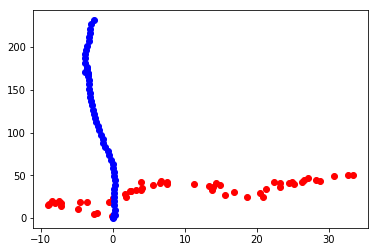

Count:271
()
()
Relative Depth: -49.58241224198252
Relative x: 31.8276951723649
Relative Original Depth: -232.50189367511382
Relative Original x: -2.5052136423474725
Count:272
()
()
Relative Depth: -49.32088980573527
Relative x: 30.869234777516738
Relative Original Depth: -233.48584957603052
Relative Original x: -2.3509370924246005
Count:273
()
()
Relative Depth: -49.110946906068214
Relative x: 30.02999455605105
Relative Original Depth: -234.47232259259133
Relative Original x: -2.2155963335553577
Count:274
()
()
Relative Depth: -49.2910497716394
Relative x: 29.204545209803353
Relative Original Depth: -235.4489001311183
Relative Original x: -2.0095744961754254
Count:275
()
()
Relative Depth: -49.9111529032418
Relative x: 28.677607998411197
Relative Original Depth: -236.43871550140318
Relative Original x: -1.8903380190465977


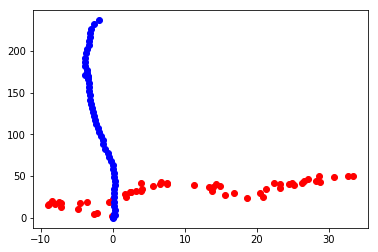

Count:276
()
()
Relative Depth: -50.584486777316705
Relative x: 28.14225310458957
Relative Original Depth: -237.41842793225663
Relative Original x: -1.7071635355902266
Count:277
()
()
Relative Depth: -51.26202274508882
Relative x: 27.54487058789571
Relative Original Depth: -238.3869301559957
Relative Original x: -1.4699520152113017
Count:278
()
()
Relative Depth: -51.93534564457513
Relative x: 27.057873904075983
Relative Original Depth: -239.35760715381056
Relative Original x: -1.2396319774542746
Count:279
()
()
Relative Depth: -52.569630007388
Relative x: 27.11842175436579
Relative Original Depth: -240.3334714590408
Relative Original x: -1.04198705375908
Count:280
()
()
Relative Depth: -53.05724907601693
Relative x: 27.613955420866603
Relative Original Depth: -241.29169706886472
Relative Original x: -0.764873373371288


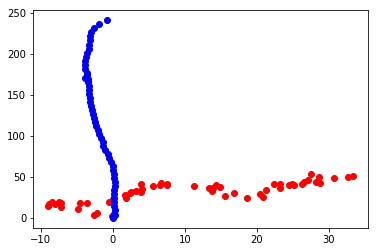

Count:281
()
()
Relative Depth: -53.52283909681627
Relative x: 28.123678280299778
Relative Original Depth: -242.2605923811112
Relative Original x: -0.5296573887703249
Count:282
()
()
Relative Depth: -53.947765900866294
Relative x: 28.780060686202763
Relative Original Depth: -243.23091780526323
Relative Original x: -0.31244386863437046
Count:283
()
()
Relative Depth: -54.2684257433991
Relative x: 29.572578229189805
Relative Original Depth: -244.1960009242973
Relative Original x: -0.06502378664509337
Count:284
()
()
Relative Depth: -53.69830597068534
Relative x: 29.54197878009741
Relative Original Depth: -245.16118120248376
Relative Original x: 0.1703472848237459
Count:285
()
()
Relative Depth: -53.85430994128683
Relative x: 30.480200648437695
Relative Original Depth: -246.11696890040022
Relative Original x: 0.4352992954265445


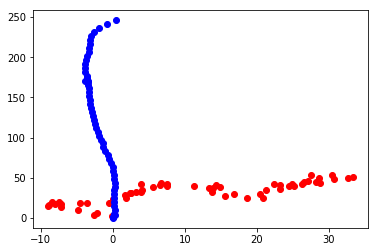

Count:286
()
()
Relative Depth: -53.96228432626644
Relative x: 31.465765361483808
Relative Original Depth: -247.08448598219118
Relative Original x: 0.671462800902323
Count:287
()
()
Relative Depth: -54.22572329888884
Relative x: 32.41632748241596
Relative Original Depth: -248.0587411442075
Relative Original x: 0.8847033408934196
Count:288
()
()
Relative Depth: -54.632651634476346
Relative x: 33.31096914936603
Relative Original Depth: -249.0251637050881
Relative Original x: 1.1294137640584176
Count:289
()
()
Relative Depth: -55.29771393437715
Relative x: 34.0045587456895
Relative Original Depth: -249.99421097187854
Relative Original x: 1.3585475000271128
Count:290
()
()
Relative Depth: -55.77060421647522
Relative x: 34.73726133357316
Relative Original Depth: -250.96848106041858
Relative Original x: 1.562765681701259


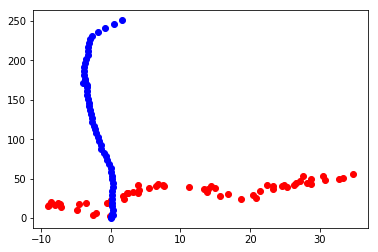

Count:291
()
()
Relative Depth: -55.75903490429171
Relative x: 35.57458928267982
Relative Original Depth: -251.94510205500572
Relative Original x: 1.7580309876117202
Count:292
()
()
Relative Depth: -55.71145231891144
Relative x: 36.43665934893041
Relative Original Depth: -252.92707186089794
Relative Original x: 1.9259746630396604
Count:293
()
()
Relative Depth: -55.41859688805157
Relative x: 37.363525783824656
Relative Original Depth: -253.91201064248833
Relative Original x: 2.0777841628841327
Count:294
()
()
Relative Depth: -54.93851708966308
Relative x: 38.24067602973218
Relative Original Depth: -254.88895679946526
Relative Original x: 2.271340452756032
Count:295
()
()
Relative Depth: -54.47238433974995
Relative x: 39.12132567736087
Relative Original Depth: -255.87034483573652
Relative Original x: 2.4413619966598548


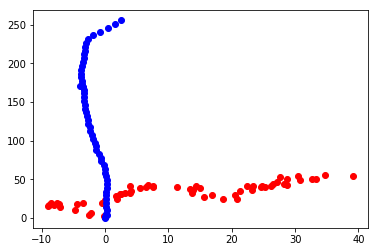

Count:296
()
()
Relative Depth: -53.94594528193045
Relative x: 39.96408114736615
Relative Original Depth: -256.8415336678268
Relative Original x: 2.6401537171693237
Count:297
()
()
Relative Depth: -53.17846758762683
Relative x: 40.49259302642813
Relative Original Depth: -257.8269750865571
Relative Original x: 2.762111997609772
Count:298
()
()
Relative Depth: -52.43538708580088
Relative x: 41.021343838713335
Relative Original Depth: -258.80120095071766
Relative Original x: 2.9533767907943056
Count:299
()
()
Relative Depth: -51.775710190443405
Relative x: 41.757955505619144
Relative Original Depth: -259.7765312675445
Relative Original x: 3.1591845237771246
Count:300
()
()
Relative Depth: -51.168103347585884
Relative x: 42.53852878059341
Relative Original Depth: -260.7584555644667
Relative Original x: 3.3312553558994273


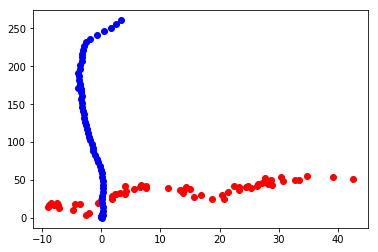

Count:301
()
()
Relative Depth: -50.62707490440984
Relative x: 43.37454689747915
Relative Original Depth: -261.7334999206523
Relative Original x: 3.533752964979682
Count:302
()
()
Relative Depth: -50.017740080335074
Relative x: 44.15498121339515
Relative Original Depth: -262.71503725836345
Relative Original x: 3.6864376062315682
Count:303
()
()
Relative Depth: -49.29885892278712
Relative x: 44.75893279573401
Relative Original Depth: -263.69299014834274
Relative Original x: 3.846210998734389
Count:304
()
()
Relative Depth: -48.599974612195105
Relative x: 45.196712631585896
Relative Original Depth: -264.6809024006541
Relative Original x: 3.9733358661244047
Count:305
()
()
Relative Depth: -47.90975941329452
Relative x: 45.84395298179132
Relative Original Depth: -265.66627256000373
Relative Original x: 4.112918803997381


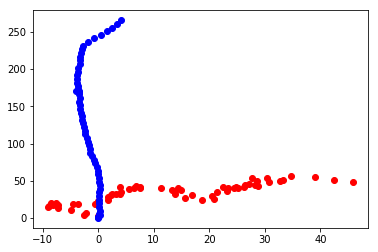

Count:306
()
()
Relative Depth: -47.340047002677416
Relative x: 46.650079995621645
Relative Original Depth: -266.6561622704389
Relative Original x: 4.221910406956788
Count:307
()
()
Relative Depth: -46.723259689384115
Relative x: 47.432819009455685
Relative Original Depth: -267.63945420124344
Relative Original x: 4.354428321301101
Count:308
()
()
Relative Depth: -46.10705508369267
Relative x: 48.21818701624931
Relative Original Depth: -268.6246187829816
Relative Original x: 4.489135137604799
Count:309
()
()
Relative Depth: -45.49681708767213
Relative x: 49.00821879587416
Relative Original Depth: -269.6117598367592
Relative Original x: 4.57068889051549
Count:310
()
()
Relative Depth: -45.01588358558586
Relative x: 49.8491565793683
Relative Original Depth: -270.60210412355787
Relative Original x: 4.668834776426018


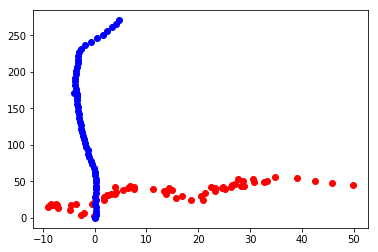

Count:311
()
()
Relative Depth: -44.34070815688451
Relative x: 49.698220822077886
Relative Original Depth: -271.5908504679704
Relative Original x: 4.781630953363957
Count:312
()
()
Relative Depth: -43.87413795027996
Relative x: 50.54915939642114
Relative Original Depth: -272.5807568895698
Relative Original x: 4.877550235404344
Count:313
()
()
Relative Depth: -43.21404040679694
Relative x: 51.13300032590924
Relative Original Depth: -273.57345690909915
Relative Original x: 4.9558746616655505
Count:314
()
()
Relative Depth: -42.43031485410908
Relative x: 51.302497851304196
Relative Original Depth: -274.5620351336559
Relative Original x: 5.070471096753238
Count:315
()
()
Relative Depth: -41.98237295729017
Relative x: 50.933476972165174
Relative Original Depth: -275.5523765139092
Relative Original x: 5.1669989579794215


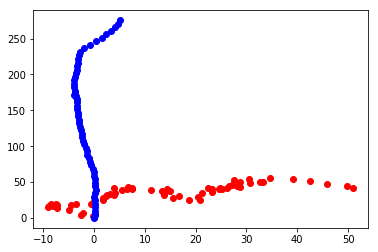

Count:316
()
()
Relative Depth: -41.68242574089691
Relative x: 50.56055155508091
Relative Original Depth: -276.5421148904053
Relative Original x: 5.248903095897853
Count:317
()
()
Relative Depth: -40.91434600220995
Relative x: 50.89456128965783
Relative Original Depth: -277.5288056378546
Relative Original x: 5.37014192936026
Count:318
()
()
Relative Depth: -40.34558844302429
Relative x: 51.14693083374916
Relative Original Depth: -278.5154426556156
Relative Original x: 5.499157560844533
Count:319
()
()
Relative Depth: -40.153165072915826
Relative x: 50.259814181774196
Relative Original Depth: -279.5027763898432
Relative Original x: 5.613711994464661
Count:320
()
()
Relative Depth: -39.462772399615424
Relative x: 50.92149073321923
Relative Original Depth: -280.4942794674939
Relative Original x: 5.658045646231921


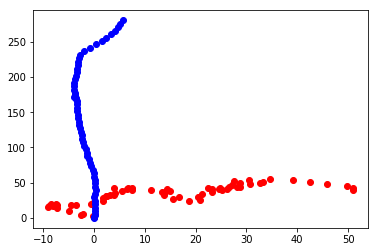

Count:321
()
()
Relative Depth: -38.78712627799276
Relative x: 51.60172468051716
Relative Original Depth: -281.4823612817625
Relative Original x: 5.726116510964342
Count:322
()
()
Relative Depth: -38.09506705579925
Relative x: 52.27810782009994
Relative Original Depth: -282.47329661900886
Relative Original x: 5.753730542064892
Count:323
()
()
Relative Depth: -37.379180830133144
Relative x: 52.937969156940326
Relative Original Depth: -283.46049270365177
Relative Original x: 5.856446873036992
Count:324
()
()
Relative Depth: -36.741374415080614
Relative x: 52.8367137728563
Relative Original Depth: -284.44408424698105
Relative Original x: 5.991320594372826
Count:325
()
()
Relative Depth: -36.06218964052615
Relative x: 52.994748945448286
Relative Original Depth: -285.43614110827775
Relative Original x: 6.054576015553626


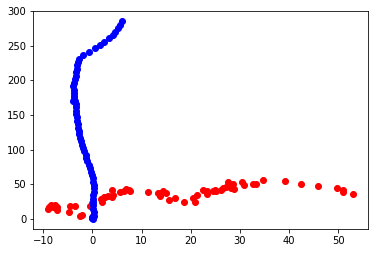

Count:326
()
()
Relative Depth: -35.81808836423363
Relative x: 52.59643327727475
Relative Original Depth: -286.4290595817052
Relative Original x: 6.125937105727353
Count:327
()
()
Relative Depth: -35.58733747033516
Relative x: 52.27140615605335
Relative Original Depth: -287.4225843294741
Relative Original x: 6.19362409478315
Count:328
()
()
Relative Depth: -35.39362213230633
Relative x: 52.00075331433905
Relative Original Depth: -288.41307367282093
Relative Original x: 6.276785160134982
Count:329
()
()
Relative Depth: -35.38742332363997
Relative x: 51.9614179037722
Relative Original Depth: -289.40589678752616
Relative Original x: 6.339664058927791
Count:330
()
()
Relative Depth: -35.26377419722233
Relative x: 52.23393674261771
Relative Original Depth: -290.39904389193373
Relative Original x: 6.372471426397707


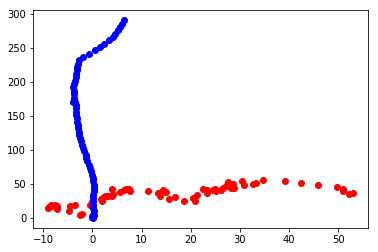

Count:331
()
()
Relative Depth: -35.03654573726056
Relative x: 52.42886851677174
Relative Original Depth: -291.39048236282747
Relative Original x: 6.436528437715411
Count:332
()
()
Relative Depth: -35.184126113210404
Relative x: 52.02273456978273
Relative Original Depth: -292.3818512946427
Relative Original x: 6.466076583195673
Count:333
()
()
Relative Depth: -35.688017143564565
Relative x: 51.26471438474383
Relative Original Depth: -293.37338658923807
Relative Original x: 6.543309213146552
Count:334
()
()
Relative Depth: -36.34044005347421
Relative x: 50.562555330497354
Relative Original Depth: -294.3656982951005
Relative Original x: 6.628243839323576
Count:335
()
()
Relative Depth: -37.17827100775831
Relative x: 50.01877221064663
Relative Original Depth: -295.35736171907706
Relative Original x: 6.7099588100031236


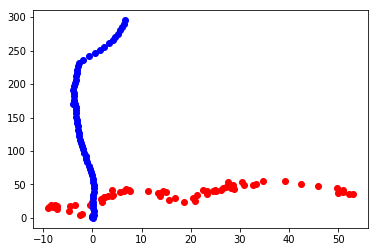

Count:336
()
()
Relative Depth: -38.0582155219267
Relative x: 49.74472795157565
Relative Original Depth: -296.3463376911443
Relative Original x: 6.79815184431837
Count:337
()
()
Relative Depth: -38.78915966004663
Relative x: 49.753291727081745
Relative Original Depth: -297.3335263211982
Relative Original x: 6.924589057282606
Count:338
()
()
Relative Depth: -38.44731959860705
Relative x: 50.15059168612027
Relative Original Depth: -298.32037153721114
Relative Original x: 7.02959279356176
Count:339
()
()
Relative Depth: -39.23193314321167
Relative x: 50.32306096713035
Relative Original Depth: -299.3064359052572
Relative Original x: 7.124189397015634
Count:340
()
()
Relative Depth: -39.70117819103689
Relative x: 50.802379571634084
Relative Original Depth: -300.29546877970904
Relative Original x: 7.194282003701152


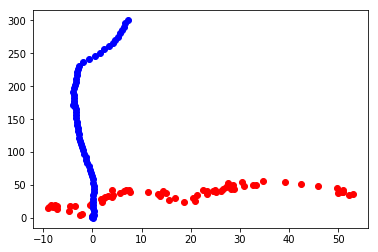

Count:341
()
()
Relative Depth: -40.668273186168875
Relative x: 50.90139285350846
Relative Original Depth: -301.28400025752757
Relative Original x: 7.29124399912547
Count:342
()
()
Relative Depth: -41.46672564198928
Relative x: 51.25498459990808
Relative Original Depth: -302.27382532479743
Relative Original x: 7.368294197533338
Count:343
()
()
Relative Depth: -41.96938296373101
Relative x: 51.74861889127017
Relative Original Depth: -303.26770936647625
Relative Original x: 7.402212781525732
Count:344
()
()
Relative Depth: -42.067345302488576
Relative x: 52.43426104776723
Relative Original Depth: -304.2611143708863
Relative Original x: 7.456737039164041
Count:345
()
()
Relative Depth: -41.587141332273056
Relative x: 52.93192565675148
Relative Original Depth: -305.2525519222197
Relative Original x: 7.541011242552081


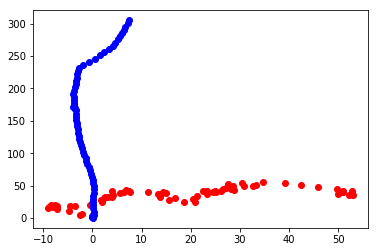

Count:346
()
()
Relative Depth: -41.04910224606495
Relative x: 53.064130436715466
Relative Original Depth: -306.243163999851
Relative Original x: 7.61229060526492
Count:347
()
()
Relative Depth: -40.352651754124565
Relative x: 53.15285083009961
Relative Original Depth: -307.23232183380225
Relative Original x: 7.719055667937083
Count:348
()
()
Relative Depth: -39.52264414587075
Relative x: 53.2465618055933
Relative Original Depth: -308.227005522776
Relative Original x: 7.739144947987315
Count:349
()
()
Relative Depth: -38.72472624968463
Relative x: 53.53293572721635
Relative Original Depth: -309.2141398152879
Relative Original x: 7.8441526418563035
Count:350
()
()
Relative Depth: -38.01884176940183
Relative x: 54.016330973753
Relative Original Depth: -310.2060184432205
Relative Original x: 7.901637126203155


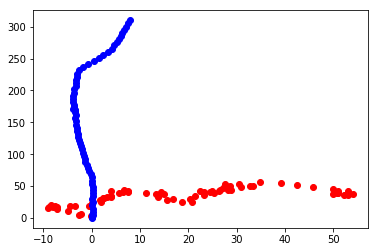

Count:351
()
()
Relative Depth: -37.42185641783163
Relative x: 54.59202345538796
Relative Original Depth: -311.1968785860985
Relative Original x: 7.970778787269034
Count:352
()
()
Relative Depth: -36.84981157856466
Relative x: 55.24817432653341
Relative Original Depth: -312.18605576752077
Relative Original x: 8.053642641122385
Count:353
()
()
Relative Depth: -36.226127389208926
Relative x: 55.92709864856382
Relative Original Depth: -313.17792645353757
Relative Original x: 8.122413808476558
Count:354
()
()
Relative Depth: -35.727499512930535
Relative x: 56.73238185411731
Relative Original Depth: -314.17186435652235
Relative Original x: 8.16497304153371
Count:355
()
()
Relative Depth: -35.11592898546991
Relative x: 57.29036016643952
Relative Original Depth: -315.1679917178216
Relative Original x: 8.160531592187033


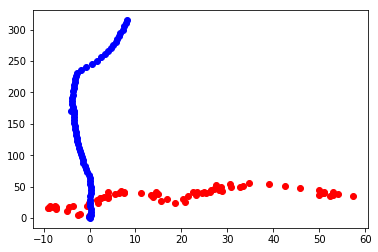

Count:356
()
()
Relative Depth: -34.5957905656514
Relative x: 57.71968413422059
Relative Original Depth: -316.15654736904975
Relative Original x: 8.235732034645403
Count:357
()
()
Relative Depth: -34.09461556542545
Relative x: 58.08187210358393
Relative Original Depth: -317.1462508754199
Relative Original x: 8.243741737602194
Count:358
()
()
Relative Depth: -33.64770851880409
Relative x: 58.382395969726524
Relative Original Depth: -318.1287457555131
Relative Original x: 8.374915092391952
Count:359
()
()
Relative Depth: -33.13877341873639
Relative x: 58.751244462594194
Relative Original Depth: -319.1133875370421
Relative Original x: 8.421241681627638
Count:360
()
()
Relative Depth: -32.46555021058421
Relative x: 59.20170404709198
Relative Original Depth: -320.10306645222784
Relative Original x: 8.490413950172293


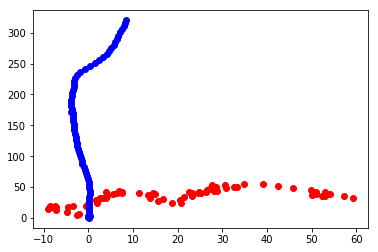

Count:361
()
()
Relative Depth: -32.09456346042696
Relative x: 59.753084937446445
Relative Original Depth: -321.0944117101799
Relative Original x: 8.519769781974642
Count:362
()
()
Relative Depth: -32.093751951713614
Relative x: 60.25318327627923
Relative Original Depth: -322.0884842186596
Relative Original x: 8.564202883458456
Count:363
()
()
Relative Depth: -31.90358250766447
Relative x: 60.61461244055942
Relative Original Depth: -323.08117999583794
Relative Original x: 8.521523384339037
Count:364
()
()
Relative Depth: -32.71736799800089
Relative x: 61.09360938085664
Relative Original Depth: -324.07242406773594
Relative Original x: 8.59753983933219
Count:365
()
()
Relative Depth: -32.701588308973925
Relative x: 61.321782268313406
Relative Original Depth: -325.0634274347741
Relative Original x: 8.689261828001474


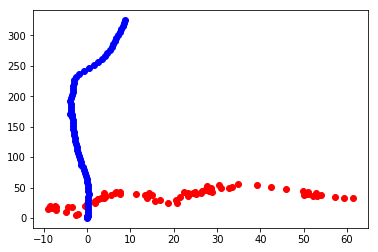

Count:366
()
()
Relative Depth: -32.768507554288895
Relative x: 61.62473678422418
Relative Original Depth: -326.04883747487895
Relative Original x: 8.795716493496792
Count:367
()
()
Relative Depth: -32.69479888166101
Relative x: 61.94782620176808
Relative Original Depth: -327.03534754586366
Relative Original x: 8.92423344259191
Count:368
()
()
Relative Depth: -32.609802284372314
Relative x: 62.20014788370308
Relative Original Depth: -328.02502424278003
Relative Original x: 9.016473708995457
Count:369
()
()
Relative Depth: -32.55382783847604
Relative x: 62.38584801442008
Relative Original Depth: -329.01271589038856
Relative Original x: 9.083320722824558
Count:370
()
()
Relative Depth: -32.61739849024983
Relative x: 62.68255737775767
Relative Original Depth: -330.00504406873057
Relative Original x: 9.119670209921923


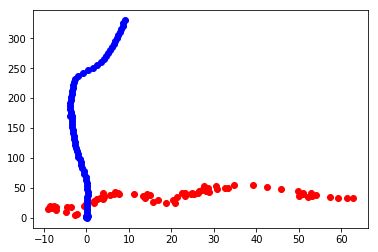

Count:371
()
()
Relative Depth: -33.61463823808399
Relative x: 62.70198969306931
Relative Original Depth: -330.9962353847712
Relative Original x: 9.19406036525166
Count:372
()
()
Relative Depth: -33.88491696000385
Relative x: 63.02607944080717
Relative Original Depth: -331.9869812947365
Relative Original x: 9.223023494643382
Count:373
()
()
Relative Depth: -34.322394762917654
Relative x: 63.29258386527012
Relative Original Depth: -332.97317560411744
Relative Original x: 9.343456489838655
Count:374
()
()
Relative Depth: -34.64301770204102
Relative x: 63.317220764134625
Relative Original Depth: -333.9632011224998
Relative Original x: 9.423506602056877
Count:375
()
()
Relative Depth: -33.96491057024202
Relative x: 63.15911270283292
Relative Original Depth: -334.9530201675306
Relative Original x: 9.508993558966152


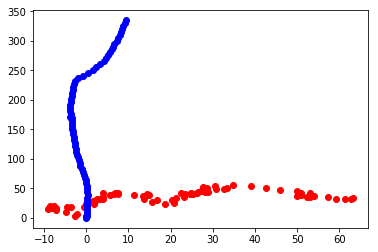

Count:376
()
()
Relative Depth: -33.86375797919858
Relative x: 62.88579682398981
Relative Original Depth: -335.94466280907403
Relative Original x: 9.601213173657653
Count:377
()
()
Relative Depth: -33.225069697319086
Relative x: 62.69840299468021
Relative Original Depth: -336.93601217662905
Relative Original x: 9.656241855227597
Count:378
()
()
Relative Depth: -32.39741485056571
Relative x: 62.66319195428613
Relative Original Depth: -337.9242179041388
Relative Original x: 9.748746192782658
Count:379
()
()
Relative Depth: -31.648813035199446
Relative x: 62.605853180133685
Relative Original Depth: -338.9190691465192
Relative Original x: 9.761106135796753
Count:380
()
()
Relative Depth: -31.001455745299555
Relative x: 62.63092109270716
Relative Original Depth: -339.9125590383259
Relative Original x: 9.789033799522963


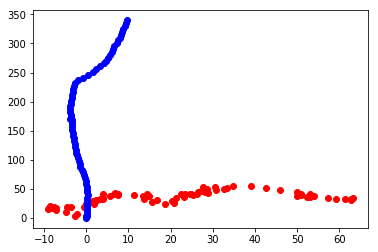

Count:381
()
()
Relative Depth: -30.21198135539668
Relative x: 63.047062054713834
Relative Original Depth: -340.9040122162875
Relative Original x: 9.846688947360724
Count:382
()
()
Relative Depth: -29.38535969956479
Relative x: 63.60492764021299
Relative Original Depth: -341.8953504220486
Relative Original x: 9.956049571749631
Count:383
()
()
Relative Depth: -28.746923812976142
Relative x: 64.1319318397842
Relative Original Depth: -342.8809676022433
Relative Original x: 10.075660523519083
Count:384
()
()
Relative Depth: -28.501014391108868
Relative x: 64.8162067291242
Relative Original Depth: -343.868494373984
Relative Original x: 10.204847839688117
Count:385
()
()
Relative Depth: -28.559385322036903
Relative x: 65.74709074864809
Relative Original Depth: -344.85680587722237
Relative Original x: 10.290235940106099


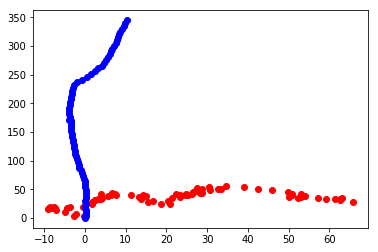

Count:386
()
()
Relative Depth: -28.871066637831383
Relative x: 66.6698717643469
Relative Original Depth: -345.8476725603576
Relative Original x: 10.334717871635336
Count:387
()
()
Relative Depth: -29.192758642000918
Relative x: 67.58553438442809
Relative Original Depth: -346.8366229990384
Relative Original x: 10.424469151315682
Count:388
()
()
Relative Depth: -29.451891491620692
Relative x: 68.54278330917545
Relative Original Depth: -347.8281421530742
Relative Original x: 10.446463898242524
Count:389
()
()
Relative Depth: -29.656473917059433
Relative x: 69.52122704434234
Relative Original Depth: -348.8183428911848
Relative Original x: 10.469295425676512
Count:390
()
()
Relative Depth: -29.943221409150688
Relative x: 70.45165386562066
Relative Original Depth: -349.80882737682
Relative Original x: 10.540218067164131


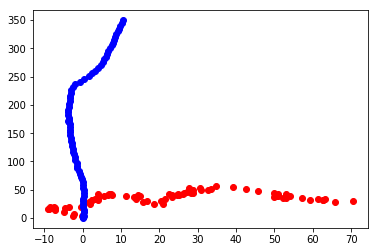

Count:391
()
()
Relative Depth: -30.508888648580122
Relative x: 71.18727711017588
Relative Original Depth: -350.79813682981853
Relative Original x: 10.662581870480851
Count:392
()
()
Relative Depth: -31.253118418732015
Relative x: 71.75216977726176
Relative Original Depth: -351.78835655438553
Relative Original x: 10.751400071340177
Count:393
()
()
Relative Depth: -32.06234051483739
Relative x: 72.22754249089535
Relative Original Depth: -352.77787883338993
Relative Original x: 10.822270221224679
Count:394
()
()
Relative Depth: -31.644989280579306
Relative x: 72.94396343202295
Relative Original Depth: -353.76868130960463
Relative Original x: 10.907964147526608
Count:395
()
()
Relative Depth: -32.53362429643332
Relative x: 73.31381461870232
Relative Original Depth: -354.7617755929739
Relative Original x: 10.98114961473426


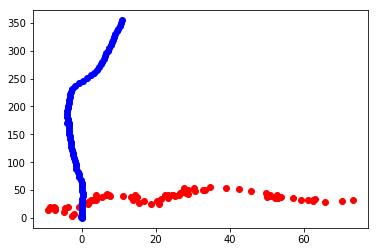

Count:396
()
()
Relative Depth: -33.46668301875065
Relative x: 73.54628350328332
Relative Original Depth: -355.75343795626924
Relative Original x: 11.03352544162821
Count:397
()
()
Relative Depth: -34.36607483611668
Relative x: 73.62646454195783
Relative Original Depth: -356.7438714913106
Relative Original x: 11.100111816971513
Count:398
()
()
Relative Depth: -35.117869231534854
Relative x: 74.20187069503935
Relative Original Depth: -357.73541119903496
Relative Original x: 11.1652474434167
Count:399
()
()
Relative Depth: -35.40961869954873
Relative x: 75.14116196371694
Relative Original Depth: -358.72678573535677
Relative Original x: 11.189711359448907
Count:400
()
()
Relative Depth: -34.5151955885996
Relative x: 74.86683780110823
Relative Original Depth: -359.721006890874
Relative Original x: 11.218395036981205


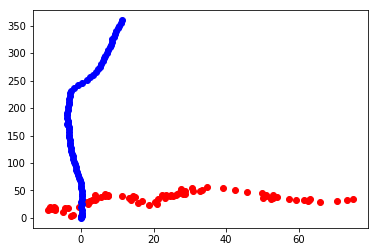

Count:401
()
()
Relative Depth: -34.423230950727465
Relative x: 74.00327985725221
Relative Original Depth: -360.7128522914322
Relative Original x: 11.282680164981214
Count:402
()
()
Relative Depth: -33.89003409595835
Relative x: 73.20958598952507
Relative Original Depth: -361.70403290834594
Relative Original x: 11.341866952107535
Count:403
()
()
Relative Depth: -33.26703746929606
Relative x: 72.4512969450381
Relative Original Depth: -362.69357951885183
Relative Original x: 11.406126912759339
Count:404
()
()
Relative Depth: -32.57925382102174
Relative x: 71.75210633957641
Relative Original Depth: -363.68192832676107
Relative Original x: 11.526727418925367
Count:405
()
()
Relative Depth: -31.73693046996211
Relative x: 71.24999459970601
Relative Original Depth: -364.67633466238505
Relative Original x: 11.53391047804676


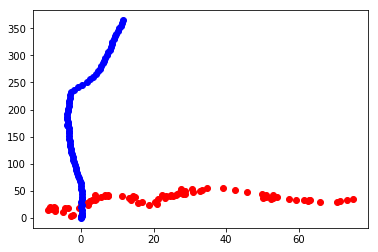

Count:406
()
()
Relative Depth: -30.779060183024143
Relative x: 71.01150638646574
Relative Original Depth: -365.6699339145693
Relative Original x: 11.567987468938767
Count:407
()
()
Relative Depth: -29.834238068587823
Relative x: 70.75598197438279
Relative Original Depth: -366.6609138435595
Relative Original x: 11.633223361266449
Count:408
()
()
Relative Depth: -28.834990699554837
Relative x: 70.71745182426302
Relative Original Depth: -367.6451610238566
Relative Original x: 11.787267577455868
Count:409
()
()
Relative Depth: -27.835257382988317
Relative x: 70.71000155287201
Relative Original Depth: -368.63493204244844
Relative Original x: 11.830766491858963
Count:410
()
()
Relative Depth: -27.004387910192804
Relative x: 70.74272082506717
Relative Original Depth: -369.62488132652635
Relative Original x: 11.86358233690214


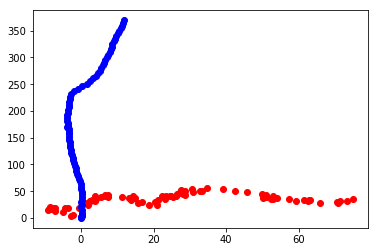

Count:411
()
()
Relative Depth: -26.02956876090548
Relative x: 70.85967108297729
Relative Original Depth: -370.6160822160163
Relative Original x: 11.940395378188304
Count:412
()
()
Relative Depth: -25.21493507847718
Relative x: 71.42844331815782
Relative Original Depth: -371.6087320300472
Relative Original x: 11.967089370196653
Count:413
()
()
Relative Depth: -24.573591348835294
Relative x: 72.14945247612386
Relative Original Depth: -372.5971884299551
Relative Original x: 12.06177564770866
Count:414
()
()
Relative Depth: -24.036647331227815
Relative x: 72.797280229122
Relative Original Depth: -373.5850210687709
Relative Original x: 12.151009383528274
Count:415
()
()
Relative Depth: -24.994105823281664
Relative x: 72.8735351474834
Relative Original Depth: -374.5755587728435
Relative Original x: 12.24724162645285


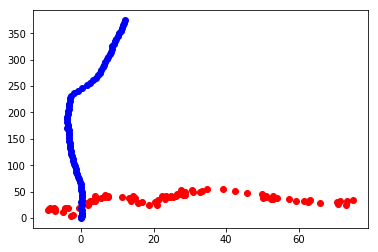

Count:416
()
()
Relative Depth: -24.595528046325985
Relative x: 73.35836022910433
Relative Original Depth: -375.56565069323267
Relative Original x: 12.322891658606776
Count:417
()
()
Relative Depth: -24.44151032403109
Relative x: 73.85697880327102
Relative Original Depth: -376.55630665901714
Relative Original x: 12.365980740494413
Count:418
()
()
Relative Depth: -24.728896879238278
Relative x: 74.33758493079338
Relative Original Depth: -377.54880517803866
Relative Original x: 12.390748489278206
Count:419
()
()
Relative Depth: -25.13852131779847
Relative x: 74.88715084431118
Relative Original Depth: -378.5368028224823
Relative Original x: 12.447759706013963
Count:420
()
()
Relative Depth: -25.50104051835153
Relative x: 75.50662107886949
Relative Original Depth: -379.52513746532617
Relative Original x: 12.534436761486418


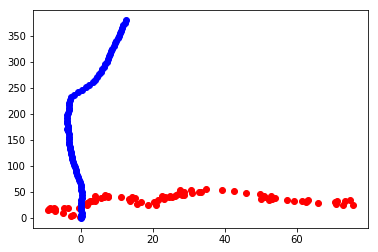

Count:421
()
()
Relative Depth: -25.04769109572297
Relative x: 76.24513217040484
Relative Original Depth: -380.51326543667943
Relative Original x: 12.600224210981727
Count:422
()
()
Relative Depth: -24.052131900435757
Relative x: 76.25248512037763
Relative Original Depth: -381.5022046947012
Relative Original x: 12.618311269424975
Count:423
()
()
Relative Depth: -23.064704229652705
Relative x: 76.1700075443965
Relative Original Depth: -382.49175528545885
Relative Original x: 12.697045724932346
Count:424
()
()
Relative Depth: -22.321171906321094
Relative x: 76.67029858735724
Relative Original Depth: -383.4891675829033
Relative Original x: 12.702385056612929
Count:425
()
()
Relative Depth: -22.616142948724526
Relative x: 77.30376019389703
Relative Original Depth: -384.47624604057364
Relative Original x: 12.790462399202706


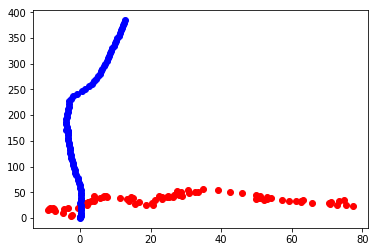

Count:426
()
()
Relative Depth: -23.289312445857767
Relative x: 77.90085965354865
Relative Original Depth: -385.4686319096392
Relative Original x: 12.846528024601938
Count:427
()
()
Relative Depth: -23.81126517404953
Relative x: 78.5297226320709
Relative Original Depth: -386.45702313296573
Relative Original x: 12.976382561916484
Count:428
()
()
Relative Depth: -24.234087706234593
Relative x: 79.09146313047799
Relative Original Depth: -387.44733949590574
Relative Original x: 13.03019529417113
Count:429
()
()
Relative Depth: -25.151308881249193
Relative x: 79.48944508094631
Relative Original Depth: -388.44019983008883
Relative Original x: 13.108224212234916
Count:430
()
()
Relative Depth: -25.807068977675964
Relative x: 79.94492409339921
Relative Original Depth: -389.4321713072027
Relative Original x: 13.121539666589449


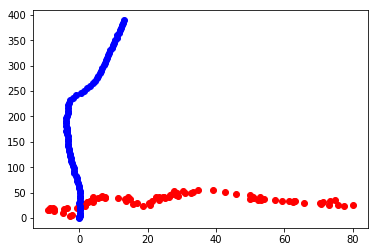

Count:431
()
()
Relative Depth: -26.573749957711016
Relative x: 80.33581506648781
Relative Original Depth: -390.4237056646758
Relative Original x: 13.169530214193284
Count:432
()
()
Relative Depth: -27.322265309115632
Relative x: 80.59821920901413
Relative Original Depth: -391.4136160058943
Relative Original x: 13.254460052499685
Count:433
()
()
Relative Depth: -28.045565140362175
Relative x: 80.72720920751125
Relative Original Depth: -392.40100896347957
Relative Original x: 13.292658863538625
Count:434
()
()
Relative Depth: -28.780670187021087
Relative x: 80.85607701280965
Relative Original Depth: -393.3920410574177
Relative Original x: 13.396284683301516
Count:435
()
()
Relative Depth: -29.50143669634746
Relative x: 80.98743375357749
Relative Original Depth: -394.38144786053334
Relative Original x: 13.471859178467781


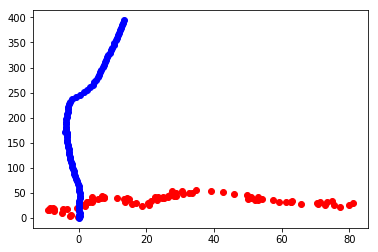

Count:436
()
()
Relative Depth: -29.449045958995097
Relative x: 81.61718226123656
Relative Original Depth: -395.37540403410196
Relative Original x: 13.446148996693532
Count:437
()
()
Relative Depth: -30.105072764152645
Relative x: 81.87482232024882
Relative Original Depth: -396.3679755068392
Relative Original x: 13.496921506782913
Count:438
()
()
Relative Depth: -30.78844577652691
Relative x: 82.22003202149939
Relative Original Depth: -397.36148496673883
Relative Original x: 13.51284634100916
Count:439
()
()
Relative Depth: -31.67927481251823
Relative x: 82.5033278143494
Relative Original Depth: -398.3539147766001
Relative Original x: 13.534577699055976
Count:440
()
()
Relative Depth: -32.46337648361934
Relative x: 82.74953096660124
Relative Original Depth: -399.34505524767485
Relative Original x: 13.61003921705099


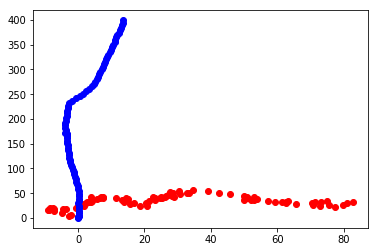

Count:441
()
()
Relative Depth: -33.433795857883126
Relative x: 82.50870399441
Relative Original Depth: -400.337768687584
Relative Original x: 13.691038678436684
Count:442
()
()
Relative Depth: -34.13076506181296
Relative x: 82.18126524599784
Relative Original Depth: -401.33438421286434
Relative Original x: 13.679285910205708
Count:443
()
()
Relative Depth: -34.963171953803005
Relative x: 81.65995328258613
Relative Original Depth: -402.327214931523
Relative Original x: 13.733948472331871
Count:444
()
()
Relative Depth: -35.70817952106042
Relative x: 81.37673300626535
Relative Original Depth: -403.31873725416074
Relative Original x: 13.777373937245285
Count:445
()
()
Relative Depth: -36.480988045758075
Relative x: 81.53989485817613
Relative Original Depth: -404.31194099788377
Relative Original x: 13.810355920518907


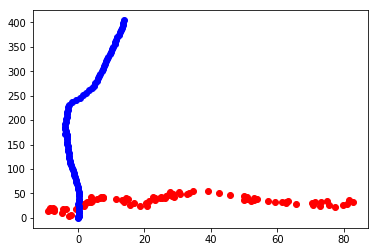

Count:446
()
()
Relative Depth: -37.428348385153974
Relative x: 81.84654852723843
Relative Original Depth: -405.30257194090757
Relative Original x: 13.855628626200977
Count:447
()
()
Relative Depth: -36.60717129865854
Relative x: 82.14051591847571
Relative Original Depth: -406.29246346801136
Relative Original x: 13.893725257812214
Count:448
()
()
Relative Depth: -36.84407756193711
Relative x: 82.69421856224275
Relative Original Depth: -407.27842925642057
Relative Original x: 13.967394385185743
Count:449
()
()
Relative Depth: -37.79481406913547
Relative x: 83.00348513778935
Relative Original Depth: -408.27072673992285
Relative Original x: 14.015082382464971
Count:450
()
()
Relative Depth: -38.54253755693521
Relative x: 83.52195138534813
Relative Original Depth: -409.2608094348712
Relative Original x: 14.099841124253393


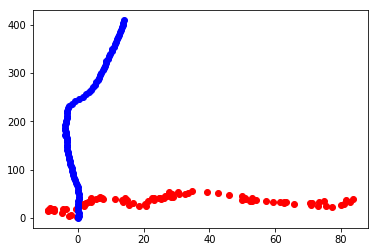

Count:451
()
()
Relative Depth: -38.833977329968
Relative x: 84.30061145282997
Relative Original Depth: -410.252617743404
Relative Original x: 14.137589908843792
Count:452
()
()
Relative Depth: -38.6433182554857
Relative x: 84.08377810440913
Relative Original Depth: -411.2409427059956
Relative Original x: 14.226255336433361
Count:453
()
()
Relative Depth: -38.90978287090351
Relative x: 84.47166340813096
Relative Original Depth: -412.22485805987407
Relative Original x: 14.345942654759197
Count:454
()
()
Relative Depth: -39.31832043924019
Relative x: 84.0583217046892
Relative Original Depth: -413.2102614785009
Relative Original x: 14.395445367114988
Count:455
()
()
Relative Depth: -39.57261093788291
Relative x: 83.57376777257095
Relative Original Depth: -414.1988123893037
Relative Original x: 14.481172204184496


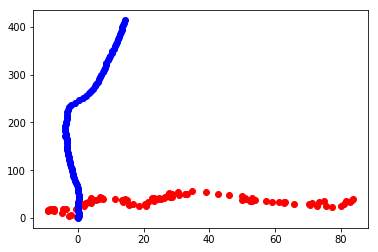

Count:456
()
()
Relative Depth: -39.579359554805194
Relative x: 83.24239999814993
Relative Original Depth: -415.1884196723389
Relative Original x: 14.558142596493878
Count:457
()
()
Relative Depth: -39.645046909581815
Relative x: 83.10650745673584
Relative Original Depth: -416.17430498183995
Relative Original x: 14.679227788900864
Count:458
()
()
Relative Depth: -39.74191802019016
Relative x: 83.1250824116252
Relative Original Depth: -417.16542224392595
Relative Original x: 14.766363020479208
Count:459
()
()
Relative Depth: -39.94508191125733
Relative x: 83.26442975498148
Relative Original Depth: -418.15325216370985
Relative Original x: 14.84454546457829
Count:460
()
()
Relative Depth: -40.533184054564444
Relative x: 83.42097388024932
Relative Original Depth: -419.1440542687015
Relative Original x: 14.899831498647137


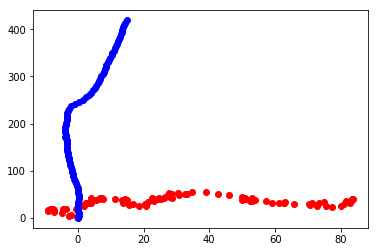

Count:461
()
()
Relative Depth: -40.74434389438469
Relative x: 83.60269908097862
Relative Original Depth: -420.13392182526405
Relative Original x: 14.978825083134238
Count:462
()
()
Relative Depth: -40.909312761025696
Relative x: 84.04420868815377
Relative Original Depth: -421.1236364582652
Relative Original x: 15.041209730390952
Count:463
()
()
Relative Depth: -40.6955260751132
Relative x: 83.84660947553868
Relative Original Depth: -422.11621751297963
Relative Original x: 15.069997178593178
Count:464
()
()
Relative Depth: -40.91731801973636
Relative x: 84.51236266085468
Relative Original Depth: -423.10838273266023
Relative Original x: 15.176754290784055
Count:465
()
()
Relative Depth: -41.46641660196843
Relative x: 84.81900455731976
Relative Original Depth: -424.09916979935616
Relative Original x: 15.272949814030937


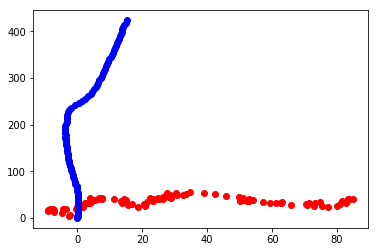

Count:466
()
()
Relative Depth: -41.73283696617581
Relative x: 85.51497575340278
Relative Original Depth: -425.09149152315746
Relative Original x: 15.342534863134743
Count:467
()
()
Relative Depth: -42.05785017989088
Relative x: 86.2523201885297
Relative Original Depth: -426.08461616824826
Relative Original x: 15.372522174584237
Count:468
()
()
Relative Depth: -42.400328489240735
Relative x: 86.9806065331928
Relative Original Depth: -427.0799386474943
Relative Original x: 15.418484299168439
Count:469
()
()
Relative Depth: -42.72466460551185
Relative x: 87.66431210812995
Relative Original Depth: -428.0728284645852
Relative Original x: 15.524836448772579
Count:470
()
()
Relative Depth: -43.10534796254081
Relative x: 88.21037033302525
Relative Original Depth: -429.06575695865325
Relative Original x: 15.593500868389333


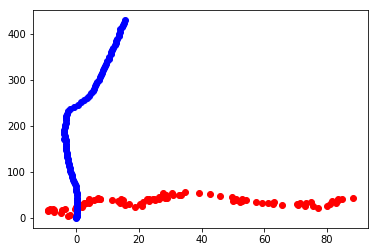

Count:471
()
()
Relative Depth: -43.328466514483786
Relative x: 89.18432774592728
Relative Original Depth: -430.0584608586571
Relative Original x: 15.66909201125152
Count:472
()
()
Relative Depth: -43.76670090599366
Relative x: 88.94988222146048
Relative Original Depth: -431.04893181730284
Relative Original x: 15.703066947011926
Count:473
()
()
Relative Depth: -44.14221339878655
Relative x: 89.69435589154305
Relative Original Depth: -432.03912857523954
Relative Original x: 15.743046628795327
Count:474
()
()
Relative Depth: -44.591553903144536
Relative x: 90.57216321725753
Relative Original Depth: -433.02505742854936
Relative Original x: 15.854750871087441
Count:475
()
()
Relative Depth: -44.71786239723987
Relative x: 91.46263951830802
Relative Original Depth: -434.01327744215155
Relative Original x: 15.944082627534037


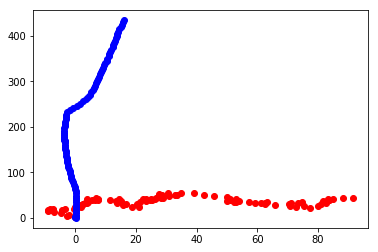

Count:476
()
()
Relative Depth: -44.29086567284051
Relative x: 92.02025371661333
Relative Original Depth: -435.0020281482186
Relative Original x: 16.01683933113839
Count:477
()
()
Relative Depth: -43.8325239066734
Relative x: 92.41909739101202
Relative Original Depth: -435.99208098289233
Relative Original x: 16.06087306393655
Count:478
()
()
Relative Depth: -43.33019202692104
Relative x: 92.51141509973003
Relative Original Depth: -436.9825044505687
Relative Original x: 16.078252392113566
Count:479
()
()
Relative Depth: -42.83172611883407
Relative x: 92.75905460866078
Relative Original Depth: -437.97245896088265
Relative Original x: 16.130611818448
Count:480
()
()
Relative Depth: -42.32927037892032
Relative x: 93.33895684757464
Relative Original Depth: -438.96485295353654
Relative Original x: 16.18438038125967


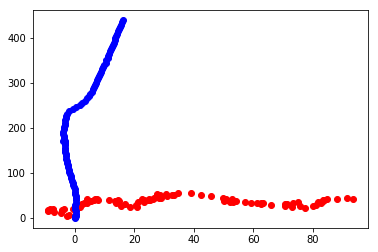

Count:481
()
()
Relative Depth: -41.99145793435978
Relative x: 94.17028010526555
Relative Original Depth: -439.960925005899
Relative Original x: 16.213136572261455
Count:482
()
()
Relative Depth: -41.86094719567955
Relative x: 95.13049098328871
Relative Original Depth: -440.95260657478514
Relative Original x: 16.287000478242952
Count:483
()
()
Relative Depth: -42.31249760675118
Relative x: 95.1228881478924
Relative Original Depth: -441.94385531297974
Relative Original x: 16.352954741114466
Count:484
()
()
Relative Depth: -42.38594253743835
Relative x: 95.44354947358919
Relative Original Depth: -442.935288594651
Relative Original x: 16.409895648400468
Count:485
()
()
Relative Depth: -42.32477370909007
Relative x: 96.42823018630773
Relative Original Depth: -443.92685633185863
Relative Original x: 16.483989413156028


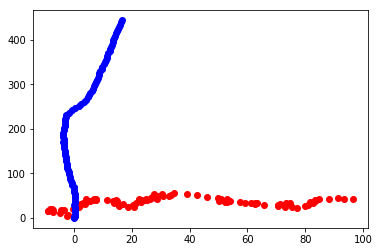

Count:486
()
()
Relative Depth: -42.29160763822573
Relative x: 96.95533351241097
Relative Original Depth: -444.9142940756434
Relative Original x: 16.577864025703985
Count:487
()
()
Relative Depth: -42.18599358868662
Relative x: 97.94360141196347
Relative Original Depth: -445.9045286826035
Relative Original x: 16.6467601918335
Count:488
()
()
Relative Depth: -42.25340219141766
Relative x: 98.92188663711968
Relative Original Depth: -446.88938832333963
Relative Original x: 16.777281543561855
Count:489
()
()
Relative Depth: -42.15772735474933
Relative x: 99.0300990726689
Relative Original Depth: -447.87684617446286
Relative Original x: 16.8716363433408
Count:490
()
()
Relative Depth: -42.42843136483204
Relative x: 99.88788296872407
Relative Original Depth: -448.8649558548513
Relative Original x: 16.977757966307482


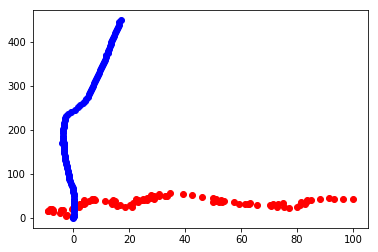

Count:491
()
()
Relative Depth: -42.821228210139395
Relative x: 100.70859419738093
Relative Original Depth: -449.8541797171118
Relative Original x: 17.047257957483065
Count:492
()
()
Relative Depth: -43.25572407257974
Relative x: 101.56425843762807
Relative Original Depth: -450.8438611306559
Relative Original x: 17.137739575810624
Count:493
()
()
Relative Depth: -43.6533270350022
Relative x: 102.4476441980986
Relative Original Depth: -451.8334174362211
Relative Original x: 17.225476771042317
Count:494
()
()
Relative Depth: -44.27358887476324
Relative x: 103.23184651149806
Relative Original Depth: -452.8203730357639
Relative Original x: 17.312191713780603
Count:495
()
()
Relative Depth: -44.6465810392165
Relative x: 104.10383216344894
Relative Original Depth: -453.8070177754404
Relative Original x: 17.37556440593772


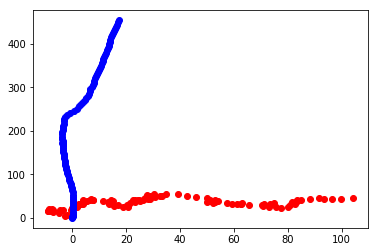

Count:496
()
()
Relative Depth: -44.62215082564698
Relative x: 105.1024663858916
Relative Original Depth: -454.7938120194769
Relative Original x: 17.46154240829927
Count:497
()
()
Relative Depth: -44.69631852150136
Relative x: 106.05406964067879
Relative Original Depth: -455.7815391230494
Relative Original x: 17.53489695476945
Count:498
()
()
Relative Depth: -44.56526108983474
Relative x: 106.98366849130635
Relative Original Depth: -456.77244940306286
Relative Original x: 17.59193749722512
Count:499
()
()
Relative Depth: -43.86426432254692
Relative x: 107.63443775928062
Relative Original Depth: -457.7626094359338
Relative Original x: 17.681607506433235
Count:500
()
()
Relative Depth: -43.12700289835827
Relative x: 107.66790593422753
Relative Original Depth: -458.75348991012476
Relative Original x: 17.767813946340766


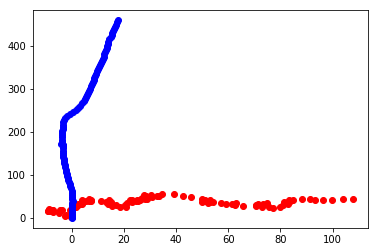

Count:501
()
()
Relative Depth: -42.378904328442424
Relative x: 108.33050654495695
Relative Original Depth: -459.7473607365357
Relative Original x: 17.829618919846233
Count:502
()
()
Relative Depth: -41.4593716476932
Relative x: 108.58801756003646
Relative Original Depth: -460.7403926671309
Relative Original x: 17.88972389491657
Count:503
()
()
Relative Depth: -41.9719899956906
Relative x: 108.46210832121201
Relative Original Depth: -461.7328560469682
Relative Original x: 17.957026235071403
Count:504
()
()
Relative Depth: -41.691138895597035
Relative x: 109.20577976516867
Relative Original Depth: -462.72588885293385
Relative Original x: 18.003201647921042
Count:505
()
()
Relative Depth: -41.38174522609624
Relative x: 109.99594692248907
Relative Original Depth: -463.72138524298583
Relative Original x: 18.04417923899167


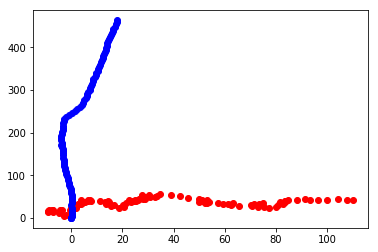

Count:506
()
()
Relative Depth: -41.05506669974631
Relative x: 110.80760836184245
Relative Original Depth: -464.71470151161265
Relative Original x: 18.079100261197787
Count:507
()
()
Relative Depth: -40.75154131592902
Relative x: 111.56546664579216
Relative Original Depth: -465.70778951189635
Relative Original x: 18.13461737699321
Count:508
()
()
Relative Depth: -40.51309772553571
Relative x: 112.28258460002884
Relative Original Depth: -466.6999303129643
Relative Original x: 18.195669015917066
Count:509
()
()
Relative Depth: -40.42343164011183
Relative x: 112.94627709663568
Relative Original Depth: -467.69198416920216
Relative Original x: 18.264843180869818
Count:510
()
()
Relative Depth: -40.4699306663165
Relative x: 113.5278684811415
Relative Original Depth: -468.68379712675016
Relative Original x: 18.27254918524317


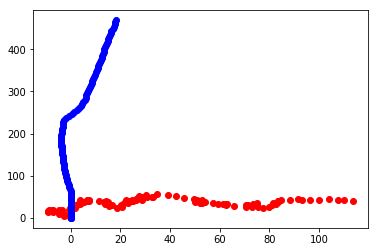

Count:511
()
()
Relative Depth: -41.004185534111855
Relative x: 113.67293477088162
Relative Original Depth: -469.6735973889412
Relative Original x: 18.3492968825041
Count:512
()
()
Relative Depth: -41.82688171421988
Relative x: 113.29218886814576
Relative Original Depth: -470.6613063246797
Relative Original x: 18.454132604027976
Count:513
()
()
Relative Depth: -42.63334110402145
Relative x: 112.72870156019835
Relative Original Depth: -471.6523536050899
Relative Original x: 18.51588281236548
Count:514
()
()
Relative Depth: -43.27738710539703
Relative x: 111.96424274735065
Relative Original Depth: -472.6415203813456
Relative Original x: 18.60511663350164
Count:515
()
()
Relative Depth: -43.8257229612924
Relative x: 111.16847921008957
Relative Original Depth: -473.63081238861105
Relative Original x: 18.67660230263064


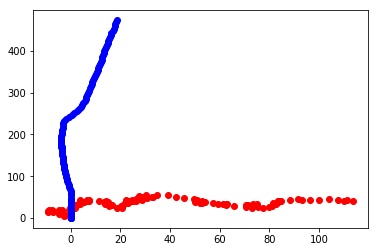

Count:516
()
()
Relative Depth: -44.419750570829244
Relative x: 110.39595896540065
Relative Original Depth: -474.6208662742783
Relative Original x: 18.727044660202928
Count:517
()
()
Relative Depth: -44.96650051944425
Relative x: 109.5808593899121
Relative Original Depth: -475.6106135711001
Relative Original x: 18.78430028598802
Count:518
()
()
Relative Depth: -45.49144657419608
Relative x: 108.77359485409302
Relative Original Depth: -476.6009810826512
Relative Original x: 18.85325093620679
Count:519
()
()
Relative Depth: -45.70261115895365
Relative x: 107.83705265240314
Relative Original Depth: -477.59192909057134
Relative Original x: 18.925986420129174
Count:520
()
()
Relative Depth: -46.37614583242746
Relative x: 107.21107853283621
Relative Original Depth: -478.5856246774767
Relative Original x: 18.952716005997168


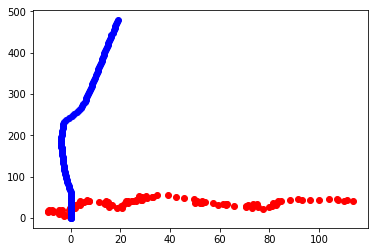

Count:521
()
()
Relative Depth: -46.16788321492539
Relative x: 106.33343054880633
Relative Original Depth: -479.57602287829604
Relative Original x: 19.028494994740253
Count:522
()
()
Relative Depth: -45.914231152913636
Relative x: 105.62071334869582
Relative Original Depth: -480.5675903290479
Relative Original x: 19.11658510863683
Count:523
()
()
Relative Depth: -45.607637104180085
Relative x: 104.75203206729825
Relative Original Depth: -481.55976796393907
Relative Original x: 19.17098492298865
Count:524
()
()
Relative Depth: -45.31934346385396
Relative x: 103.79920642514777
Relative Original Depth: -482.55079244879227
Relative Original x: 19.241356328136618
Count:525
()
()
Relative Depth: -44.866865240195175
Relative x: 102.90970316744233
Relative Original Depth: -483.5411167166154
Relative Original x: 19.301792839155983


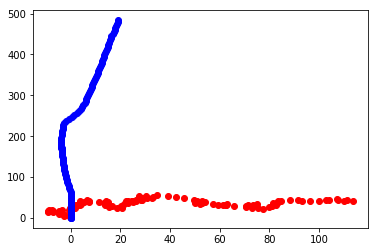

Count:526
()
()
Relative Depth: -44.22818455573015
Relative x: 102.28351427269607
Relative Original Depth: -484.5328149808009
Relative Original x: 19.38728977520666
Count:527
()
()
Relative Depth: -43.63900459971431
Relative x: 102.03001233578898
Relative Original Depth: -485.52424592563096
Relative Original x: 19.432969962354512
Count:528
()
()
Relative Depth: -43.09376080961173
Relative x: 102.01699996013137
Relative Original Depth: -486.5155309616093
Relative Original x: 19.49402049922714
Count:529
()
()
Relative Depth: -42.81623712588545
Relative x: 102.75499458320178
Relative Original Depth: -487.50682458197116
Relative Original x: 19.5576211208511
Count:530
()
()
Relative Depth: -42.8921841159018
Relative x: 103.74308702134863
Relative Original Depth: -488.4961559561841
Relative Original x: 19.621909465023464


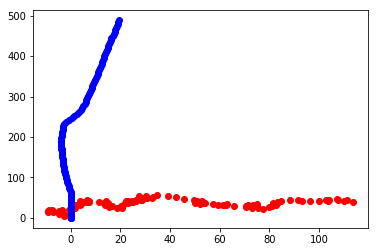

Count:531
()
()
Relative Depth: -42.3040822612856
Relative x: 103.47192296750399
Relative Original Depth: -489.4865127094874
Relative Original x: 19.6985550022016
Count:532
()
()
Relative Depth: -42.37463027402455
Relative x: 104.45032412535232
Relative Original Depth: -490.4772748565087
Relative Original x: 19.72352394117087
Count:533
()
()
Relative Depth: -42.686357239358706
Relative x: 105.39634204028873
Relative Original Depth: -491.46903203461073
Relative Original x: 19.780605366788276
Count:534
()
()
Relative Depth: -43.34925755476932
Relative x: 106.11431170645388
Relative Original Depth: -492.4593219425212
Relative Original x: 19.790887203819704
Count:535
()
()
Relative Depth: -44.12192742485158
Relative x: 106.62634499273358
Relative Original Depth: -493.4512032199392
Relative Original x: 19.79915064879046


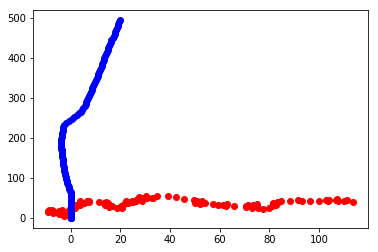

Count:536
()
()
Relative Depth: -44.979277974011396
Relative x: 107.10837518946273
Relative Original Depth: -494.44195027682366
Relative Original x: 19.894522853337094
Count:537
()
()
Relative Depth: -45.84870562419222
Relative x: 107.59354919404505
Relative Original Depth: -495.42950360441006
Relative Original x: 19.894648455496785
Count:538
()
()
Relative Depth: -46.68024675435459
Relative x: 108.08511410309357
Relative Original Depth: -496.41971786876917
Relative Original x: 19.927544873365374
Count:539
()
()
Relative Depth: -47.57862594454177
Relative x: 108.4131586234127
Relative Original Depth: -497.4103753402967
Relative Original x: 19.981885102980463
Count:540
()
()
Relative Depth: -48.470516793681035
Relative x: 108.7312984076448
Relative Original Depth: -498.3997630141329
Relative Original x: 20.084266982659866


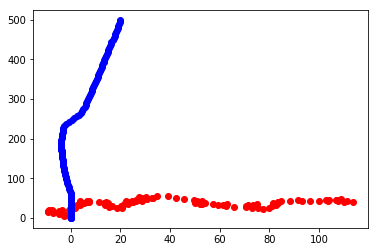

Count:541
()
()
Relative Depth: -49.17240888367388
Relative x: 109.26782599972549
Relative Original Depth: -499.39099098382604
Relative Original x: 20.087778430036785
Count:542
()
()
Relative Depth: -49.74144116288611
Relative x: 109.91824571933705
Relative Original Depth: -500.3767045152237
Relative Original x: 20.19845745526043
Count:543
()
()
Relative Depth: -50.34839085209418
Relative x: 110.451141327452
Relative Original Depth: -501.3655822784509
Relative Original x: 20.30162134714309
Count:544
()
()
Relative Depth: -50.92368062205534
Relative x: 110.85278140708114
Relative Original Depth: -502.3529713592563
Relative Original x: 20.37746194413848
Count:545
()
()
Relative Depth: -51.39217689176587
Relative x: 111.29616003394906
Relative Original Depth: -503.3435959512875
Relative Original x: 20.43470784608018


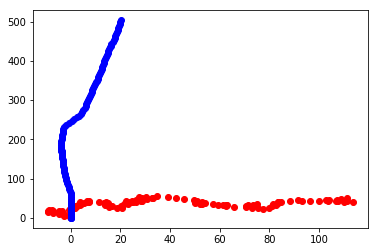

Count:546
()
()
Relative Depth: -51.77503142072896
Relative x: 111.73492675735324
Relative Original Depth: -504.3327069312768
Relative Original x: 20.515410112714548
Count:547
()
()
Relative Depth: -51.929640369205245
Relative x: 112.09181726502872
Relative Original Depth: -505.32301148575453
Relative Original x: 20.5367167913323
Count:548
()
()
Relative Depth: -52.140074000055726
Relative x: 112.37660898707847
Relative Original Depth: -506.3113792371741
Relative Original x: 20.630699438765916
Count:549
()
()
Relative Depth: -52.67301591195102
Relative x: 112.59430276047806
Relative Original Depth: -507.30513468818435
Relative Original x: 20.669348929050496
Count:550
()
()
Relative Depth: -53.08944720204465
Relative x: 112.5671155739463
Relative Original Depth: -508.2908775642887
Relative Original x: 20.801089972592234


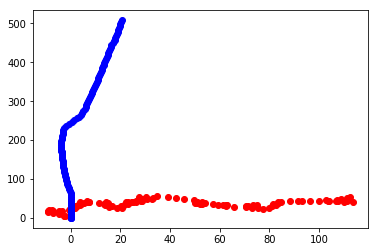

Count:551
()
()
Relative Depth: -53.132679993176986
Relative x: 112.4139548157782
Relative Original Depth: -509.2822938073625
Relative Original x: 20.884131453141965
Count:552
()
()
Relative Depth: -53.1442367630385
Relative x: 112.31973450291224
Relative Original Depth: -510.26743625046777
Relative Original x: 20.983708404877262
Count:553
()
()
Relative Depth: -53.12581627396042
Relative x: 112.21389909410749
Relative Original Depth: -511.2557790540341
Relative Original x: 21.04949563182427
Count:554
()
()
Relative Depth: -53.009760570515866
Relative x: 112.06773264422893
Relative Original Depth: -512.2456818136866
Relative Original x: 21.138029800043867
Count:555
()
()
Relative Depth: -53.814309167534056
Relative x: 111.71336302695128
Relative Original Depth: -513.2324457471091
Relative Original x: 21.2338950262663


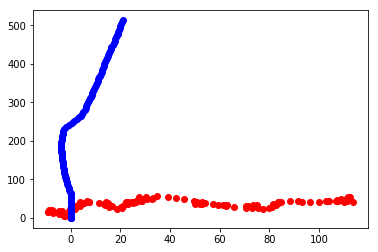

Count:556
()
()
Relative Depth: -53.09590434529734
Relative x: 112.24632558418023
Relative Original Depth: -514.2236831645595
Relative Original x: 21.266637766248685
Count:557
()
()
Relative Depth: -52.323674432431496
Relative x: 112.79209636681038
Relative Original Depth: -515.21361756982
Relative Original x: 21.328886427064873
Count:558
()
()
Relative Depth: -51.68232979824323
Relative x: 113.4387148304536
Relative Original Depth: -516.2048311178281
Relative Original x: 21.37502691764335
Count:559
()
()
Relative Depth: -51.28278222585819
Relative x: 114.31382581932674
Relative Original Depth: -517.1970364032043
Relative Original x: 21.438311213493787
Count:560
()
()
Relative Depth: -51.1213425473549
Relative x: 115.22994908957398
Relative Original Depth: -518.1887992902597
Relative Original x: 21.45685142324125


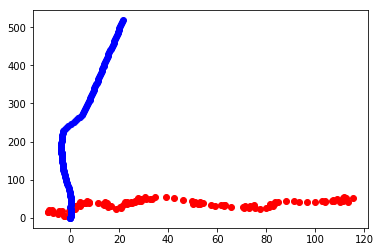

Count:561
()
()
Relative Depth: -51.21045779469959
Relative x: 115.10914945831856
Relative Original Depth: -519.1756077686679
Relative Original x: 21.594763089392092
Count:562
()
()
Relative Depth: -51.09396161678905
Relative x: 115.79372809941763
Relative Original Depth: -520.1658500276874
Relative Original x: 21.645244545280907
Count:563
()
()
Relative Depth: -50.92078310263921
Relative x: 115.95031764719388
Relative Original Depth: -521.1557910483931
Relative Original x: 21.71308857123027
Count:564
()
()
Relative Depth: -50.84160785712019
Relative x: 115.56295985744096
Relative Original Depth: -522.1448429213565
Relative Original x: 21.807980218035915
Count:565
()
()
Relative Depth: -50.87769020932832
Relative x: 115.13924144698626
Relative Original Depth: -523.1341635281368
Relative Original x: 21.88610467539086


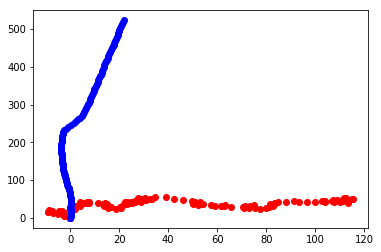

Count:566
()
()
Relative Depth: -50.9938573832728
Relative x: 114.77810520748088
Relative Original Depth: -524.1255459762035
Relative Original x: 21.934926018410735
Count:567
()
()
Relative Depth: -51.068332999155565
Relative x: 114.15903380417473
Relative Original Depth: -525.1166375726502
Relative Original x: 22.01503911254009
Count:568
()
()
Relative Depth: -51.1464442454675
Relative x: 113.30596547959745
Relative Original Depth: -526.1040069870982
Relative Original x: 22.14366656876631
Count:569
()
()
Relative Depth: -51.263763724256854
Relative x: 112.46054834990602
Relative Original Depth: -527.0951832710512
Relative Original x: 22.232990837285104
Count:570
()
()
Relative Depth: -51.3020321158921
Relative x: 111.54643856751484
Relative Original Depth: -528.086175184045
Relative Original x: 22.291555522790848


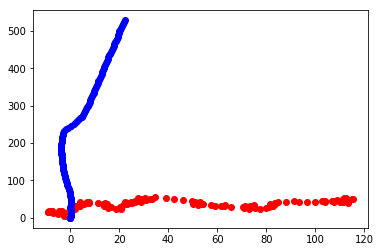

Count:571
()
()
Relative Depth: -51.32217797984799
Relative x: 110.59106201095663
Relative Original Depth: -529.0779007681941
Relative Original x: 22.370467723548323
Count:572
()
()
Relative Depth: -51.36296445062195
Relative x: 109.59876889902804
Relative Original Depth: -530.0676085958751
Relative Original x: 22.467995859893264
Count:573
()
()
Relative Depth: -51.50082473856901
Relative x: 108.61816193310612
Relative Original Depth: -531.0577409962546
Relative Original x: 22.5488165698606
Count:574
()
()
Relative Depth: -51.668570936877956
Relative x: 107.69443246059043
Relative Original Depth: -532.048266363797
Relative Original x: 22.62996696095868
Count:575
()
()
Relative Depth: -51.57669140088397
Relative x: 106.70085930439824
Relative Original Depth: -533.0381256943151
Relative Original x: 22.6711973869969


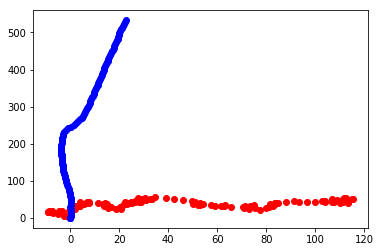

Count:576
()
()
Relative Depth: -51.29022589476239
Relative x: 105.74367420726533
Relative Original Depth: -534.025966720651
Relative Original x: 22.80502292263091
Count:577
()
()
Relative Depth: -50.98042147578526
Relative x: 104.79626628349791
Relative Original Depth: -535.0144611930549
Relative Original x: 22.88781976040677
Count:578
()
()
Relative Depth: -50.60471964560059
Relative x: 104.26219484960022
Relative Original Depth: -536.0006104690734
Relative Original x: 22.99447704410067
Count:579
()
()
Relative Depth: -50.35881463187471
Relative x: 103.29704625377916
Relative Original Depth: -536.9914410198023
Relative Original x: 23.068177015848757
Count:580
()
()
Relative Depth: -50.21338575294844
Relative x: 102.36114295693572
Relative Original Depth: -537.9813878014493
Relative Original x: 23.13670164251107


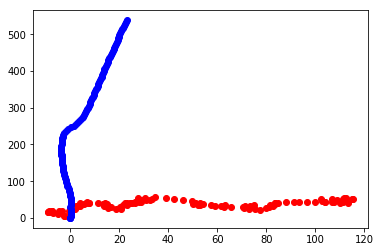

Count:581
()
()
Relative Depth: -50.146978353997966
Relative x: 101.53991809244027
Relative Original Depth: -538.9703299068645
Relative Original x: 23.197595213915516
Count:582
()
()
Relative Depth: -49.877847626621474
Relative x: 101.0705463811573
Relative Original Depth: -539.9657834921846
Relative Original x: 23.23000459054708
Count:583
()
()
Relative Depth: -49.56431205817534
Relative x: 101.19989102499608
Relative Original Depth: -540.9560058517947
Relative Original x: 23.29451025623008
Count:584
()
()
Relative Depth: -49.377601687322546
Relative x: 101.42102254894724
Relative Original Depth: -541.9463111354784
Relative Original x: 23.365904648988792
Count:585
()
()
Relative Depth: -49.81061172901904
Relative x: 101.36426977433416
Relative Original Depth: -542.9379942892974
Relative Original x: 23.40337298321197


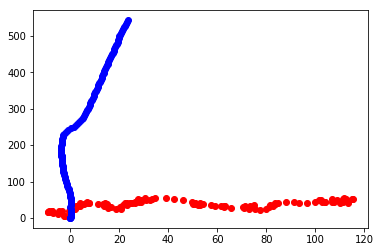

Count:586
()
()
Relative Depth: -50.66350115850395
Relative x: 101.32629308585062
Relative Original Depth: -543.9234028891507
Relative Original x: 23.448008777199167
Count:587
()
()
Relative Depth: -51.468377571708785
Relative x: 101.55122195338627
Relative Original Depth: -544.9106496027113
Relative Original x: 23.559830585736798
Count:588
()
()
Relative Depth: -52.277114494629586
Relative x: 101.72143318916152
Relative Original Depth: -545.8997487520925
Relative Original x: 23.61387026264008
Count:589
()
()
Relative Depth: -53.05333238741601
Relative x: 101.64352020546767
Relative Original Depth: -546.8896693364588
Relative Original x: 23.667629056356198
Count:590
()
()
Relative Depth: -53.790242809609424
Relative x: 101.4620275840787
Relative Original Depth: -547.8783590350243
Relative Original x: 23.697329106267254


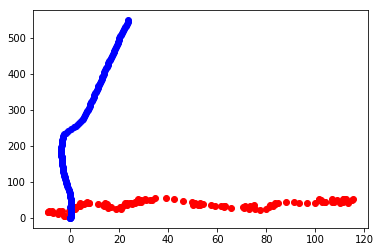

Count:591
()
()
Relative Depth: -54.5847868589253
Relative x: 101.29193936552149
Relative Original Depth: -548.8674645019198
Relative Original x: 23.75919102655532
Count:592
()
()
Relative Depth: -55.45333927936751
Relative x: 101.37228252016202
Relative Original Depth: -549.8568296708302
Relative Original x: 23.839305568410932
Count:593
()
()
Relative Depth: -56.4149775294374
Relative x: 101.53184793365138
Relative Original Depth: -550.8474583166618
Relative Original x: 23.930724382497115
Count:594
()
()
Relative Depth: -57.26731148703459
Relative x: 101.01000409466505
Relative Original Depth: -551.8378713871213
Relative Original x: 23.99516321192355
Count:595
()
()
Relative Depth: -56.31225150770872
Relative x: 100.71524171920848
Relative Original Depth: -552.8286934690556
Relative Original x: 24.10022268373473


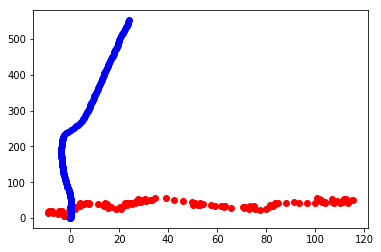

Count:596
()
()
Relative Depth: -55.5286527218209
Relative x: 100.11830276901294
Relative Original Depth: -553.8197260115938
Relative Original x: 24.16511722505348
Count:597
()
()
Relative Depth: -55.974329822952434
Relative x: 99.22511401091842
Relative Original Depth: -554.8110266469267
Relative Original x: 24.252841349143505
Count:598
()
()
Relative Depth: -56.410351878973565
Relative x: 98.32658282625925
Relative Original Depth: -555.7985898362282
Relative Original x: 24.365641042826404
Count:599
()
()
Relative Depth: -56.799065363845244
Relative x: 97.40764163949964
Relative Original Depth: -556.7895331203597
Relative Original x: 24.425144450444076
Count:600
()
()
Relative Depth: -57.48153426176608
Relative x: 96.71669639584978
Relative Original Depth: -557.779353531473
Relative Original x: 24.500097558402572


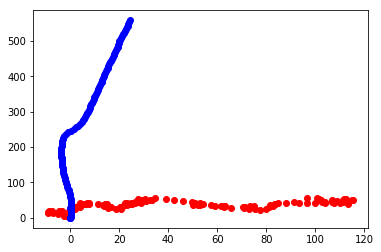

Count:601
()
()
Relative Depth: -58.327296769288445
Relative x: 96.37758829543142
Relative Original Depth: -558.7699872600701
Relative Original x: 24.573657012882318
Count:602
()
()
Relative Depth: -59.13625284742518
Relative x: 95.94999814707961
Relative Original Depth: -559.7614229553253
Relative Original x: 24.634628594253414
Count:603
()
()
Relative Depth: -59.82480775713471
Relative x: 95.28942731916291
Relative Original Depth: -560.7546758982502
Relative Original x: 24.69293369714579
Count:604
()
()
Relative Depth: -60.511873801235424
Relative x: 94.61610645677597
Relative Original Depth: -561.7461535700311
Relative Original x: 24.739299543932308
Count:605
()
()
Relative Depth: -61.19788508090612
Relative x: 93.90893042837642
Relative Original Depth: -562.7378806922997
Relative Original x: 24.806131039758128


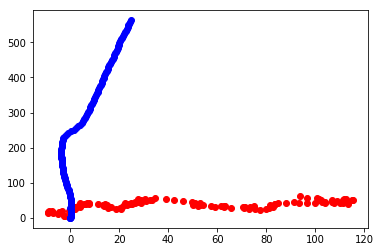

Count:606
()
()
Relative Depth: -61.65363660341616
Relative x: 93.02207761922257
Relative Original Depth: -563.728780542704
Relative Original x: 24.89108357352135
Count:607
()
()
Relative Depth: -61.58568832404126
Relative x: 92.05975021755616
Relative Original Depth: -564.7199290826419
Relative Original x: 24.961342907255364
Count:608
()
()
Relative Depth: -61.1303837882783
Relative x: 91.25005988053347
Relative Original Depth: -565.7069112550656
Relative Original x: 25.0632001139802
Count:609
()
()
Relative Depth: -61.90082692244525
Relative x: 90.62222169112196
Relative Original Depth: -566.6967399904556
Relative Original x: 25.099500459170653
Count:610
()
()
Relative Depth: -61.328752862448646
Relative x: 91.33586627025694
Relative Original Depth: -567.6882599126361
Relative Original x: 25.10862473043086


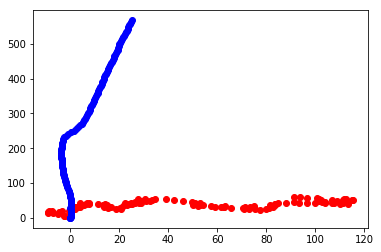

Count:611
()
()
Relative Depth: -60.87446153889603
Relative x: 90.46608429209037
Relative Original Depth: -568.6781654010258
Relative Original x: 25.181800818673622
Count:612
()
()
Relative Depth: -60.307632853791795
Relative x: 89.64640860483968
Relative Original Depth: -569.667563192344
Relative Original x: 25.24243886786324
Count:613
()
()
Relative Depth: -59.50746904736382
Relative x: 89.04671758748651
Relative Original Depth: -570.6590791144599
Relative Original x: 25.259108164090094
Count:614
()
()
Relative Depth: -58.69910478871152
Relative x: 88.45811153439367
Relative Original Depth: -571.6517700771618
Relative Original x: 25.296597843916178
Count:615
()
()
Relative Depth: -57.96197781273416
Relative x: 87.79280754253945
Relative Original Depth: -572.6426719441165
Relative Original x: 25.31432598807694


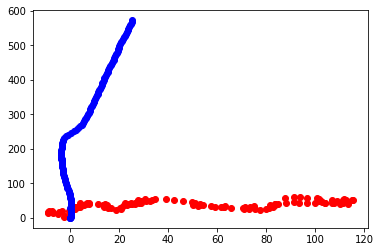

Count:616
()
()
Relative Depth: -57.15347687976939
Relative x: 87.30844287425803
Relative Original Depth: -573.6336273381671
Relative Original x: 25.363367351336535
Count:617
()
()
Relative Depth: -56.3117951456172
Relative x: 86.93869647135594
Relative Original Depth: -574.6259588871992
Relative Original x: 25.400928315380867
Count:618
()
()
Relative Depth: -55.39271790512535
Relative x: 86.67496226169658
Relative Original Depth: -575.6157103725341
Relative Original x: 25.480899295640576
Count:619
()
()
Relative Depth: -54.532850103948306
Relative x: 87.14738804435194
Relative Original Depth: -576.6038850935561
Relative Original x: 25.564719382325745
Count:620
()
()
Relative Depth: -54.388005829156654
Relative x: 88.13675042230324
Relative Original Depth: -577.5903687138327
Relative Original x: 25.658272116351768


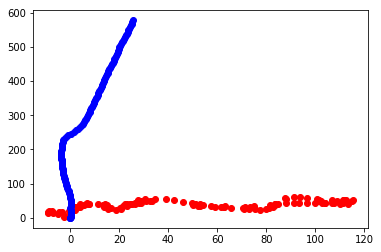

Count:621
()
()
Relative Depth: -54.535015389908075
Relative x: 89.12211836361391
Relative Original Depth: -578.5769393008242
Relative Original x: 25.769938570508124
Count:622
()
()
Relative Depth: -54.935764798103484
Relative x: 88.2436408991594
Relative Original Depth: -579.5670289730083
Relative Original x: 25.8117321852961
Count:623
()
()
Relative Depth: -55.17685603659383
Relative x: 89.20292468429307
Relative Original Depth: -580.5520656972762
Relative Original x: 25.94433999603756
Count:624
()
()
Relative Depth: -56.06785279589397
Relative x: 88.89770359600129
Relative Original Depth: -581.5440667452953
Relative Original x: 26.012265169191938
Count:625
()
()
Relative Depth: -56.222721346541825
Relative x: 89.8847887586732
Relative Original Depth: -582.538019885303
Relative Original x: 26.06724078995457


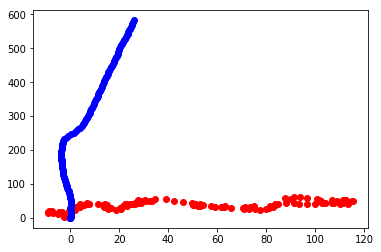

Count:626
()
()
Relative Depth: -56.334803107493265
Relative x: 90.87813735425905
Relative Original Depth: -583.5311568787548
Relative Original x: 26.11819963705831
Count:627
()
()
Relative Depth: -57.0761686181823
Relative x: 90.91424273225965
Relative Original Depth: -584.5247900220431
Relative Original x: 26.160284207906265
Count:628
()
()
Relative Depth: -57.208476129194295
Relative x: 91.9014272815464
Relative Original Depth: -585.5148404815994
Relative Original x: 26.217871221012334
Count:629
()
()
Relative Depth: -57.08658196698205
Relative x: 92.89333746028701
Relative Original Depth: -586.505398126986
Relative Original x: 26.295219724488895
Count:630
()
()
Relative Depth: -56.80964803810703
Relative x: 93.84298888498884
Relative Original Depth: -587.4965372361257
Relative Original x: 26.35511206587929


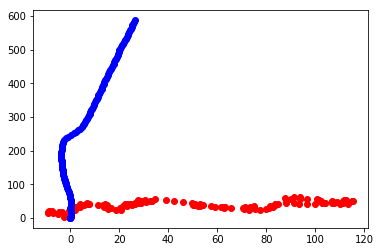

Count:631
()
()
Relative Depth: -56.63006583180531
Relative x: 94.72813094311975
Relative Original Depth: -588.4841835640001
Relative Original x: 26.425342129564665
Count:632
()
()
Relative Depth: -56.55561369553704
Relative x: 95.6230874726938
Relative Original Depth: -589.4781554045147
Relative Original x: 26.47956299540998
Count:633
()
()
Relative Depth: -57.35639905258477
Relative x: 95.03047342457864
Relative Original Depth: -590.4673109027179
Relative Original x: 26.542524486310153
Count:634
()
()
Relative Depth: -58.30775841048069
Relative x: 94.72257343091513
Relative Original Depth: -591.460608800537
Relative Original x: 26.596928800283653
Count:635
()
()
Relative Depth: -59.22257592542347
Relative x: 94.75066816076682
Relative Original Depth: -592.4517647456399
Relative Original x: 26.624063381489705


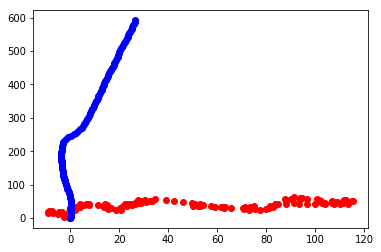

Count:636
()
()
Relative Depth: -59.06502646568694
Relative x: 95.73578496656471
Relative Original Depth: -593.4407831914887
Relative Original x: 26.70008543849908
Count:637
()
()
Relative Depth: -58.47026059776625
Relative x: 96.52341931538768
Relative Original Depth: -594.4286240095944
Relative Original x: 26.775716492715485
Count:638
()
()
Relative Depth: -57.75905455709949
Relative x: 96.98208090655005
Relative Original Depth: -595.4152334992054
Relative Original x: 26.85352623416852
Count:639
()
()
Relative Depth: -56.791866292266334
Relative x: 96.74447477938386
Relative Original Depth: -596.4020054219078
Relative Original x: 26.946142694166348
Count:640
()
()
Relative Depth: -57.75289049318048
Relative x: 96.96904718406115
Relative Original Depth: -597.3894873657348
Relative Original x: 26.97951573857465


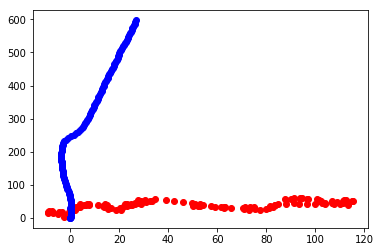

Count:641
()
()
Relative Depth: -56.81705518374848
Relative x: 96.85663376966139
Relative Original Depth: -598.3768121661377
Relative Original x: 27.06523632652313
Count:642
()
()
Relative Depth: -55.92990831811392
Relative x: 96.40227417725406
Relative Original Depth: -599.3691971011724
Relative Original x: 27.10076815928455
Count:643
()
()
Relative Depth: -55.04414430035318
Relative x: 95.95307038673103
Relative Original Depth: -600.3582691328323
Relative Original x: 27.173772437719997
Count:644
()
()
Relative Depth: -54.29314343455272
Relative x: 95.39563699906999
Relative Original Depth: -601.3468591711337
Relative Original x: 27.268049813387773
Count:645
()
()
Relative Depth: -53.768014277737336
Relative x: 94.7911554887017
Relative Original Depth: -602.3387900681021
Relative Original x: 27.330983892437423


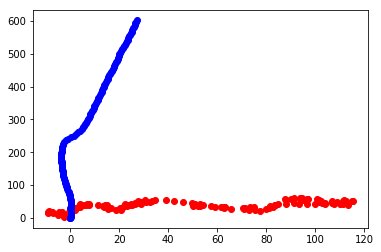

Count:646
()
()
Relative Depth: -53.205274224856566
Relative x: 94.19896648644514
Relative Original Depth: -603.329040871578
Relative Original x: 27.419149430620863
Count:647
()
()
Relative Depth: -52.3300826980055
Relative x: 93.7334707111956
Relative Original Depth: -604.3209597099991
Relative Original x: 27.481123555870163
Count:648
()
()
Relative Depth: -51.386294797485505
Relative x: 93.61404966992387
Relative Original Depth: -605.3078312690352
Relative Original x: 27.571255711479157
Count:649
()
()
Relative Depth: -50.68533673487415
Relative x: 93.59230093865982
Relative Original Depth: -606.2978774038152
Relative Original x: 27.61281413376064
Count:650
()
()
Relative Depth: -50.34916483590415
Relative x: 93.54666923951768
Relative Original Depth: -607.2892122469425
Relative Original x: 27.662827141048016


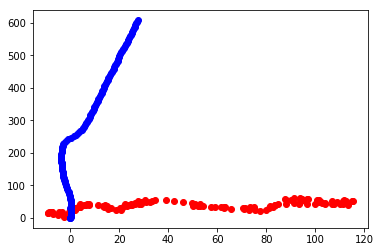

Count:651
()
()
Relative Depth: -49.88011341022629
Relative x: 92.66965969770078
Relative Original Depth: -608.2794879340784
Relative Original x: 27.73601536737247
Count:652
()
()
Relative Depth: -50.05902771717304
Relative x: 91.77188737685081
Relative Original Depth: -609.2667654013792
Relative Original x: 27.761094612119468
Count:653
()
()
Relative Depth: -49.58078830966299
Relative x: 91.64990612722393
Relative Original Depth: -610.2549704659847
Relative Original x: 27.82690425819358
Count:654
()
()
Relative Depth: -49.32921059390049
Relative x: 92.2307958872642
Relative Original Depth: -611.2409724040801
Relative Original x: 27.95277970224287
Count:655
()
()
Relative Depth: -48.59232689709059
Relative x: 91.76716728236573
Relative Original Depth: -612.2315128809131
Relative Original x: 28.04004128966114


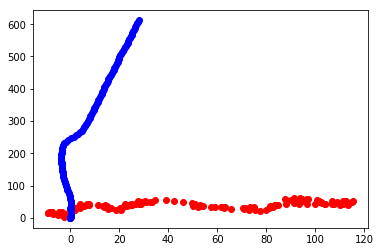

Count:656
()
()
Relative Depth: -48.460779242985154
Relative x: 90.8435566978691
Relative Original Depth: -613.2221656868093
Relative Original x: 28.0942295617942
Count:657
()
()
Relative Depth: -48.93961711221686
Relative x: 90.91555013643291
Relative Original Depth: -614.2127446177564
Relative Original x: 28.15784825509681
Count:658
()
()
Relative Depth: -49.20673504994597
Relative x: 90.17400364372963
Relative Original Depth: -615.2037709484521
Relative Original x: 28.23381371501561
Count:659
()
()
Relative Depth: -49.41179945434499
Relative x: 89.41890935245294
Relative Original Depth: -616.1917857355852
Relative Original x: 28.309861587850286
Count:660
()
()
Relative Depth: -49.58763087758113
Relative x: 88.54851867570062
Relative Original Depth: -617.1834144432476
Relative Original x: 28.362980353762616


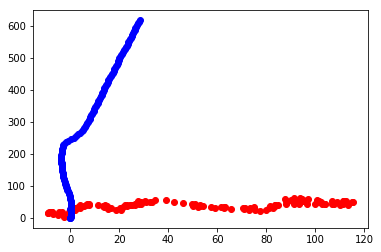

Count:661
()
()
Relative Depth: -48.74693917960458
Relative x: 88.01079292448269
Relative Original Depth: -618.1745358007197
Relative Original x: 28.379998334785537
Count:662
()
()
Relative Depth: -48.79257571982299
Relative x: 87.02389308413191
Relative Original Depth: -619.1628632155823
Relative Original x: 28.45201168313166
Count:663
()
()
Relative Depth: -48.79777309824575
Relative x: 86.08508227684605
Relative Original Depth: -620.1525053666853
Relative Original x: 28.4975501737917
Count:664
()
()
Relative Depth: -48.73043878208038
Relative x: 85.41345537511125
Relative Original Depth: -621.1431419338082
Relative Original x: 28.542928298453656
Count:665
()
()
Relative Depth: -48.4389972393494
Relative x: 85.07702738068298
Relative Original Depth: -622.1358620053039
Relative Original x: 28.585419544307282


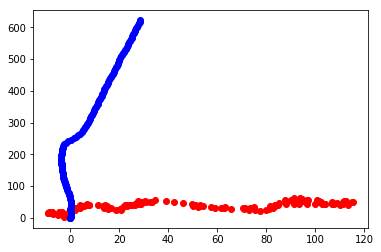

Count:666
()
()
Relative Depth: -47.97570025865489
Relative x: 84.9572985620298
Relative Original Depth: -623.1252148024694
Relative Original x: 28.679458023087903
Count:667
()
()
Relative Depth: -47.29771043068642
Relative x: 84.8804794351316
Relative Original Depth: -624.1128241963963
Relative Original x: 28.767844175663246
Count:668
()
()
Relative Depth: -46.500028370557274
Relative x: 84.91712186581452
Relative Original Depth: -625.100399507378
Relative Original x: 28.859095678560745
Count:669
()
()
Relative Depth: -46.01309999578216
Relative x: 85.47802369338446
Relative Original Depth: -626.0915751657398
Relative Original x: 28.907569202338305
Count:670
()
()
Relative Depth: -46.1403343942073
Relative x: 86.31990931627142
Relative Original Depth: -627.0824678266616
Relative Original x: 28.97217076297553


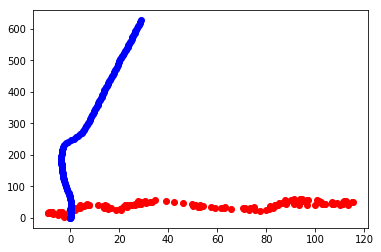

Count:671
()
()
Relative Depth: -46.05909624347884
Relative x: 87.24532487844566
Relative Original Depth: -628.0760184577136
Relative Original x: 28.993399850254928
Count:672
()
()
Relative Depth: -46.00515135335705
Relative x: 88.19915239378417
Relative Original Depth: -629.067035575988
Relative Original x: 29.01603348410951
Count:673
()
()
Relative Depth: -45.944251715748514
Relative x: 89.15079956672838
Relative Original Depth: -630.0582058258102
Relative Original x: 29.109420558210015
Count:674
()
()
Relative Depth: -46.43667638459003
Relative x: 88.9535394776629
Relative Original Depth: -631.0489373589816
Relative Original x: 29.166331683667376
Count:675
()
()
Relative Depth: -46.533941176161356
Relative x: 89.90908660773727
Relative Original Depth: -632.0380806146845
Relative Original x: 29.21204646631214


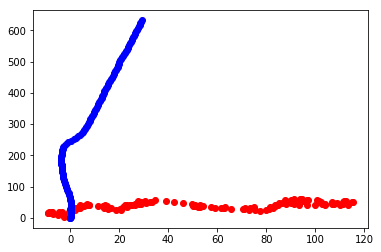

Count:676
()
()
Relative Depth: -46.81042506064504
Relative x: 90.78297224997884
Relative Original Depth: -633.0284655411089
Relative Original x: 29.24842397996364
Count:677
()
()
Relative Depth: -47.15761853125153
Relative x: 91.60926066819226
Relative Original Depth: -634.0197746654761
Relative Original x: 29.27311812099242
Count:678
()
()
Relative Depth: -47.53829585264806
Relative x: 92.47918166837948
Relative Original Depth: -635.0096786685044
Relative Original x: 29.333682495237394
Count:679
()
()
Relative Depth: -47.74005397803721
Relative x: 93.28652185318396
Relative Original Depth: -636.0019000361882
Relative Original x: 29.39176313068111
Count:680
()
()
Relative Depth: -47.34979357839156
Relative x: 93.78785635217392
Relative Original Depth: -636.9909616104417
Relative Original x: 29.475211472263897


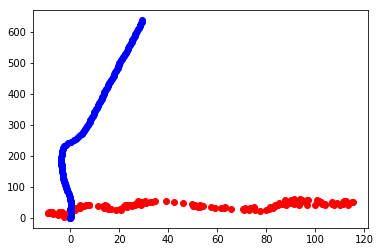

Count:681
()
()
Relative Depth: -46.66088530091692
Relative x: 94.16797100960814
Relative Original Depth: -637.982092326669
Relative Original x: 29.54736433901676
Count:682
()
()
Relative Depth: -46.059414086476586
Relative x: 94.75800786585557
Relative Original Depth: -638.9689104478969
Relative Original x: 29.630314082902064
Count:683
()
()
Relative Depth: -45.4193180037881
Relative x: 95.2294485488515
Relative Original Depth: -639.958661795841
Relative Original x: 29.66863099747979
Count:684
()
()
Relative Depth: -45.23128468254691
Relative x: 95.74682725143713
Relative Original Depth: -640.9486206233372
Relative Original x: 29.742978037476462
Count:685
()
()
Relative Depth: -45.46337698507218
Relative x: 96.36402881168337
Relative Original Depth: -641.9407716806741
Relative Original x: 29.743469167976116


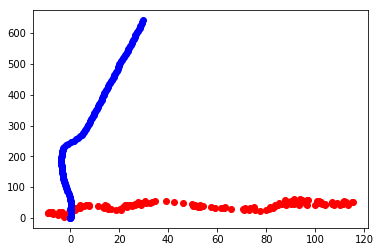

Count:686
()
()
Relative Depth: -45.68490753446598
Relative x: 96.9369997711205
Relative Original Depth: -642.9358367907595
Relative Original x: 29.73672325955401
Count:687
()
()
Relative Depth: -45.98025398854756
Relative x: 97.3970351685107
Relative Original Depth: -643.9282916649684
Relative Original x: 29.75898835157336
Count:688
()
()
Relative Depth: -46.03172146834413
Relative x: 97.59506143770847
Relative Original Depth: -644.9199530052841
Relative Original x: 29.781586046017843
Count:689
()
()
Relative Depth: -45.78558965634444
Relative x: 97.57056276973105
Relative Original Depth: -645.9120725799008
Relative Original x: 29.82826328621128
Count:690
()
()
Relative Depth: -45.20965488311378
Relative x: 97.7192774833785
Relative Original Depth: -646.9044057595862
Relative Original x: 29.87886056584647


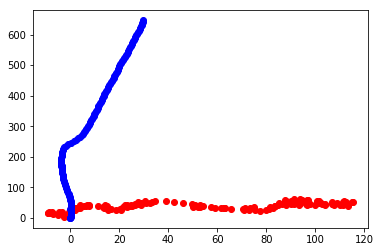

Count:691
()
()
Relative Depth: -44.397473140139724
Relative x: 98.06483115698086
Relative Original Depth: -647.8970502140869
Relative Original x: 29.91784714417899
Count:692
()
()
Relative Depth: -43.83875778607611
Relative x: 98.74979215074067
Relative Original Depth: -648.8888621608422
Relative Original x: 30.026123326450932
Count:693
()
()
Relative Depth: -43.52654643546679
Relative x: 99.5325076894751
Relative Original Depth: -649.8796647850729
Relative Original x: 30.076791708502363
Count:694
()
()
Relative Depth: -43.0847918741375
Relative x: 100.05233176821086
Relative Original Depth: -650.8662865212606
Relative Original x: 30.14201313725742
Count:695
()
()
Relative Depth: -42.65271094710062
Relative x: 100.39921759757887
Relative Original Depth: -651.8528820683648
Relative Original x: 30.223718888127312


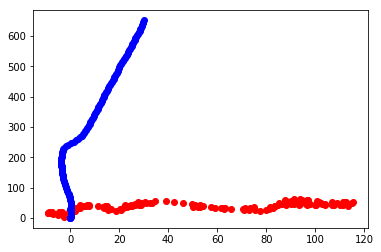

Count:696
()
()
Relative Depth: -42.28446923844717
Relative x: 100.85439224801522
Relative Original Depth: -652.8423284934726
Relative Original x: 30.294567914304984
Count:697
()
()
Relative Depth: -41.91501649209724
Relative x: 101.35574140459718
Relative Original Depth: -653.8138687571022
Relative Original x: 30.18814994579608
Count:698
()
()
Relative Depth: -41.39381914077868
Relative x: 101.77224684965991
Relative Original Depth: -654.8031413270123
Relative Original x: 30.233928886898077
Count:699
()
()
Relative Depth: -40.610162386870044
Relative x: 102.15072853233185
Relative Original Depth: -655.7976760222091
Relative Original x: 30.293717271168212
Count:700
()
()
Relative Depth: -39.821656217679624
Relative x: 102.52294272661923
Relative Original Depth: -656.7879376539152
Relative Original x: 30.304940630748202


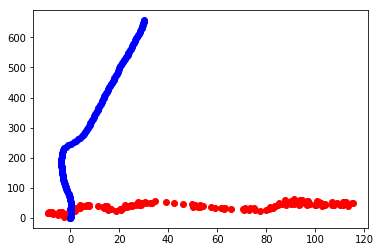

Count:701
()
()
Relative Depth: -39.24684891557383
Relative x: 102.96736089528302
Relative Original Depth: -657.780550752315
Relative Original x: 30.32337361959845
Count:702
()
()
Relative Depth: -38.81776030810377
Relative x: 103.49372903597842
Relative Original Depth: -658.7717056879136
Relative Original x: 30.330830403978783
Count:703
()
()
Relative Depth: -38.404456996191904
Relative x: 104.06706063761229
Relative Original Depth: -659.7672355379108
Relative Original x: 30.3593857431547
Count:704
()
()
Relative Depth: -38.18612536847233
Relative x: 104.80709345660753
Relative Original Depth: -660.7597814992894
Relative Original x: 30.398953412325696
Count:705
()
()
Relative Depth: -38.014574788368506
Relative x: 105.57739394423989
Relative Original Depth: -661.751119432658
Relative Original x: 30.410239264733804


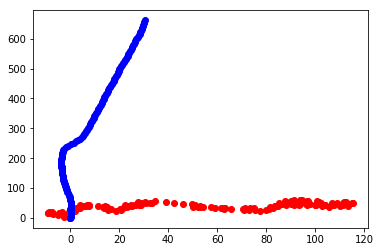

Count:706
()
()
Relative Depth: -37.353931461895144
Relative x: 105.63386525341565
Relative Original Depth: -662.7449060791837
Relative Original x: 30.457359136456166
Count:707
()
()
Relative Depth: -36.69426480119097
Relative x: 105.0068267429648
Relative Original Depth: -663.7332372986222
Relative Original x: 30.47492718678852
Count:708
()
()
Relative Depth: -35.94159745329735
Relative x: 104.45015971081426
Relative Original Depth: -664.7229226638751
Relative Original x: 30.49284540193187
Count:709
()
()
Relative Depth: -35.12759719363425
Relative x: 104.03634155938902
Relative Original Depth: -665.70499430814
Relative Original x: 30.438449190329326
Count:710
()
()
Relative Depth: -34.37628314492599
Relative x: 103.95418040966759
Relative Original Depth: -666.6904975828461
Relative Original x: 30.424853539820994


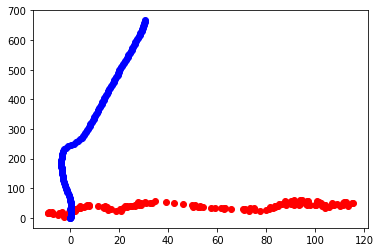

Count:711
()
()
Relative Depth: -33.80022107902875
Relative x: 104.14235534025707
Relative Original Depth: -667.6810416086729
Relative Original x: 30.469992347968688
Count:712
()
()
Relative Depth: -33.1929835984535
Relative x: 104.37855922960395
Relative Original Depth: -668.6720216781545
Relative Original x: 30.478384258560222
Count:713
()
()
Relative Depth: -32.757612702981
Relative x: 104.72227545770293
Relative Original Depth: -669.6635333057121
Relative Original x: 30.502083823549693
Count:714
()
()
Relative Depth: -31.86592944657923
Relative x: 105.14071186852874
Relative Original Depth: -670.6539904519401
Relative Original x: 30.490845900494406
Count:715
()
()
Relative Depth: -31.797604948783246
Relative x: 105.61098808621892
Relative Original Depth: -671.6500467081493
Relative Original x: 30.47253269725296


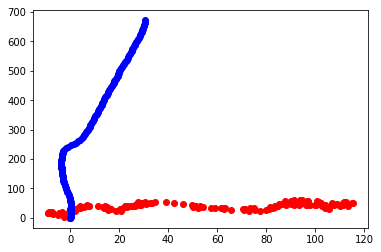

Count:716
()
()
Relative Depth: -32.177919335629575
Relative x: 106.38053104771024
Relative Original Depth: -672.6425440870329
Relative Original x: 30.45351618954177
Count:717
()
()
Relative Depth: -32.81890954803116
Relative x: 107.1088732975979
Relative Original Depth: -673.6328224601594
Relative Original x: 30.475110648485852
Count:718
()
()
Relative Depth: -33.40338014077526
Relative x: 107.64714971442085
Relative Original Depth: -674.624116251975
Relative Original x: 30.559202459080357
Count:719
()
()
Relative Depth: -33.841551309778936
Relative x: 108.11429550873777
Relative Original Depth: -675.6190853269002
Relative Original x: 30.64240827908747
Count:720
()
()
Relative Depth: -34.166481497139
Relative x: 107.170304685666
Relative Original Depth: -676.61227327905
Relative Original x: 30.697392626281513


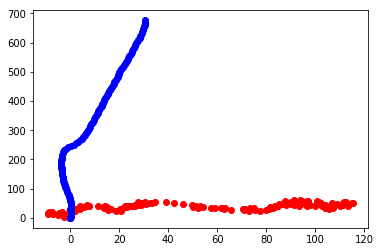

Count:721
()
()
Relative Depth: -34.57092752488189
Relative x: 107.66699272234025
Relative Original Depth: -677.6051736151609
Relative Original x: 30.722780223538166
Count:722
()
()
Relative Depth: -35.05529529489461
Relative x: 108.23029786409434
Relative Original Depth: -678.5972123636241
Relative Original x: 30.75029180844546
Count:723
()
()
Relative Depth: -35.53855477318272
Relative x: 108.81426410900521
Relative Original Depth: -679.574072064215
Relative Original x: 30.662786807665206
Count:724
()
()
Relative Depth: -36.13177060260736
Relative x: 108.47209112202279
Relative Original Depth: -680.5665035326264
Relative Original x: 30.654570628183702
Count:725
()
()
Relative Depth: -36.69376035987188
Relative x: 109.15287568053252
Relative Original Depth: -681.5625770004219
Relative Original x: 30.690094137483293


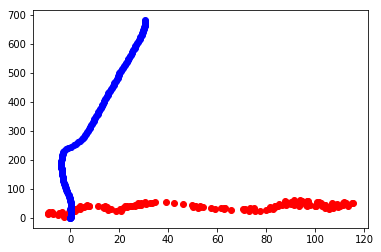

Count:726
()
()
Relative Depth: -36.65338170182311
Relative x: 108.15575434091159
Relative Original Depth: -682.5477128499466
Relative Original x: 30.63310725111079
Count:727
()
()
Relative Depth: -37.25468061177328
Relative x: 108.85915420098289
Relative Original Depth: -683.5394939564993
Relative Original x: 30.664819417493423
Count:728
()
()
Relative Depth: -37.865974401464236
Relative x: 109.35697653809491
Relative Original Depth: -684.5262765823585
Relative Original x: 30.702906860729318
Count:729
()
()
Relative Depth: -38.18283860390619
Relative x: 108.72123703915751
Relative Original Depth: -685.5215273470866
Relative Original x: 30.737305548981862
Count:730
()
()
Relative Depth: -38.53506196411897
Relative x: 109.13245365638781
Relative Original Depth: -686.5115599626278
Relative Original x: 30.778424190592677


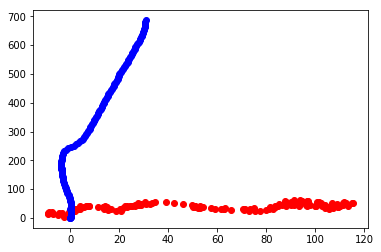

Count:731
()
()
Relative Depth: -38.908912016354236
Relative x: 109.84467598803926
Relative Original Depth: -687.4970951652848
Relative Original x: 30.9327847395565
Count:732
()
()
Relative Depth: -39.48470610477879
Relative x: 110.56336212480666
Relative Original Depth: -688.4828150937552
Relative Original x: 31.04308530884743
Count:733
()
()
Relative Depth: -40.08063261488069
Relative x: 111.29493873585541
Relative Original Depth: -689.4641153598482
Relative Original x: 31.02339632609094
Count:734
()
()
Relative Depth: -40.62459731137136
Relative x: 110.47450025383425
Relative Original Depth: -690.4546206730336
Relative Original x: 31.11332802890497
Count:735
()
()
Relative Depth: -41.470820897227995
Relative x: 110.98777527871601
Relative Original Depth: -691.4446197642449
Relative Original x: 31.080866499221607


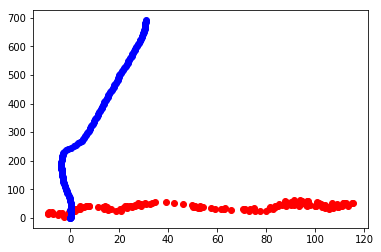

Count:736
()
()
Relative Depth: -42.38468931367457
Relative x: 111.33964977441148
Relative Original Depth: -692.435468535255
Relative Original x: 31.09171702441105
Count:737
()
()
Relative Depth: -43.26922440869575
Relative x: 111.68128660657221
Relative Original Depth: -693.4245322562357
Relative Original x: 31.21146826870132
Count:738
()
()
Relative Depth: -44.16174163396176
Relative x: 111.91263739827724
Relative Original Depth: -694.4127765710763
Relative Original x: 31.253926718082198
Count:739
()
()
Relative Depth: -45.074421661237245
Relative x: 112.07633619281283
Relative Original Depth: -695.4008760515709
Relative Original x: 31.3688840407133
Count:740
()
()
Relative Depth: -45.96285630084595
Relative x: 112.33661006998906
Relative Original Depth: -696.388734958553
Relative Original x: 31.432413961551912


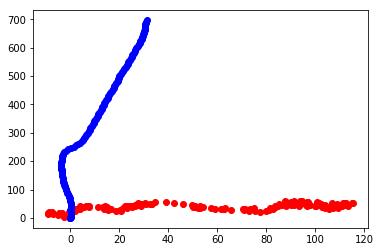

Count:741
()
()
Relative Depth: -46.84866756406778
Relative x: 112.4445217684199
Relative Original Depth: -697.3640200805569
Relative Original x: 31.556210974273615
Count:742
()
()
Relative Depth: -47.74661678366655
Relative x: 112.72874459672659
Relative Original Depth: -698.3505610297653
Relative Original x: 31.598439759989887
Count:743
()
()
Relative Depth: -48.2459253236947
Relative x: 112.91336520252418
Relative Original Depth: -699.3406624745003
Relative Original x: 31.709089352406124
Count:744
()
()
Relative Depth: -48.25609511134687
Relative x: 112.95738125372598
Relative Original Depth: -700.3173224210542
Relative Original x: 31.876549686956068
Count:745
()
()
Relative Depth: -48.18557064716804
Relative x: 113.1694752953083
Relative Original Depth: -701.298609972003
Relative Original x: 31.97794829356282


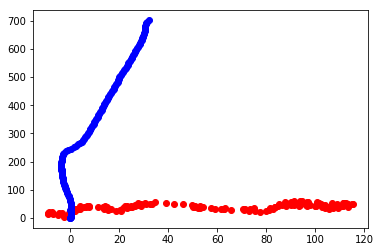

Count:746
()
()
Relative Depth: -48.843094657505944
Relative x: 113.74405281165637
Relative Original Depth: -702.2756954197428
Relative Original x: 32.134809413270276
Count:747
()
()
Relative Depth: -48.713141756375485
Relative x: 114.2049873010025
Relative Original Depth: -703.2570770785101
Relative Original x: 32.30689285399092
Count:748
()
()
Relative Depth: -48.41511426946991
Relative x: 115.09722417789155
Relative Original Depth: -704.2244827386659
Relative Original x: 32.56011288627023
Count:749
()
()
Relative Depth: -48.090218087802
Relative x: 116.03888613857859
Relative Original Depth: -705.200463790688
Relative Original x: 32.77317364669852
Count:750
()
()
Relative Depth: -47.93518128603414
Relative x: 117.02461693668641
Relative Original Depth: -706.1973839485753
Relative Original x: 32.84632295021859


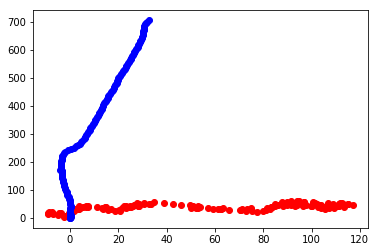

Count:751
()
()
Relative Depth: -47.72680456664399
Relative x: 118.00211260873873
Relative Original Depth: -707.1700320326382
Relative Original x: 33.07173760437705
Count:752
()
()
Relative Depth: -47.197105925891634
Relative x: 118.56118702733858
Relative Original Depth: -708.1420713551278
Relative Original x: 33.27973210392535
Count:753
()
()
Relative Depth: -47.40001673730196
Relative x: 118.8892901372779
Relative Original Depth: -709.101552304447
Relative Original x: 33.54504712680505
Count:754
()
()
Relative Depth: -47.04058949564467
Relative x: 119.82037061000317
Relative Original Depth: -710.0693893920875
Relative Original x: 33.78714573989259
Count:755
()
()
Relative Depth: -46.83908527566667
Relative x: 120.77953507076303
Relative Original Depth: -711.0401431691548
Relative Original x: 34.02685278236823


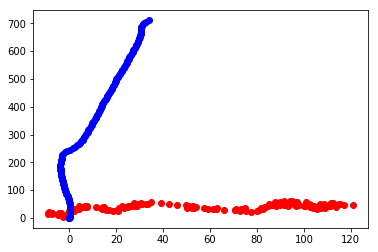

Count:756
()
()
Relative Depth: -47.74891672125265
Relative x: 120.46169385128164
Relative Original Depth: -711.972936838501
Relative Original x: 34.37186767750184
Count:757
()
()
Relative Depth: -47.6441637180081
Relative x: 121.40280011599668
Relative Original Depth: -712.9130084225308
Relative Original x: 34.703958170361474
Count:758
()
()
Relative Depth: -47.86746133389163
Relative x: 122.35784821048252
Relative Original Depth: -713.86323725304
Relative Original x: 35.00027185568779
Count:759
()
()
Relative Depth: -47.32828045400118
Relative x: 122.1334623739414
Relative Original Depth: -714.7810461918428
Relative Original x: 35.39497830459138
Count:760
()
()
Relative Depth: -47.534739550800275
Relative x: 122.57660915361637
Relative Original Depth: -715.7121788273724
Relative Original x: 35.757242919467714


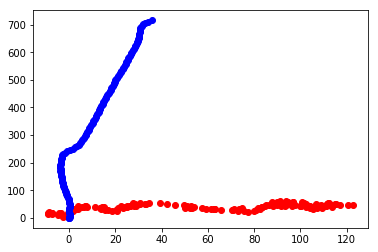

Count:761
()
()
Relative Depth: -47.282471969419554
Relative x: 121.72401811350268
Relative Original Depth: -716.6257345999115
Relative Original x: 36.1609672474228
Count:762
()
()
Relative Depth: -46.99272900497484
Relative x: 121.82953602455058
Relative Original Depth: -717.5465582181785
Relative Original x: 36.52869658210822
Count:763
()
()
Relative Depth: -46.32065510413057
Relative x: 121.99354356179308
Relative Original Depth: -718.4534531648592
Relative Original x: 36.94321648544586
Count:764
()
()
Relative Depth: -45.72637742226733
Relative x: 122.61989126110879
Relative Original Depth: -719.3363710202957
Relative Original x: 37.40926290026108
Count:765
()
()
Relative Depth: -45.43993974024021
Relative x: 123.5297452137343
Relative Original Depth: -720.2254139362741
Relative Original x: 37.859355528292795


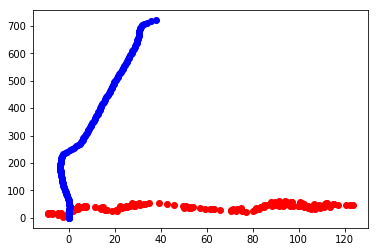

Count:766
()
()
Relative Depth: -45.228027828590434
Relative x: 124.43099195028675
Relative Original Depth: -721.1169247640689
Relative Original x: 38.30825875921822
Count:767
()
()
Relative Depth: -44.41135513239538
Relative x: 124.920715501129
Relative Original Depth: -721.9546655728524
Relative Original x: 38.848013647955476
Count:768
()
()
Relative Depth: -43.43904694038239
Relative x: 124.96680699549981
Relative Original Depth: -722.7778260228926
Relative Original x: 39.412858819268074
Count:769
()
()
Relative Depth: -42.53603254160783
Relative x: 125.37940269777118
Relative Original Depth: -723.6148606931038
Relative Original x: 39.95518910418737
Count:770
()
()
Relative Depth: -43.496508426419226
Relative x: 125.14341837945473
Relative Original Depth: -724.4301531973979
Relative Original x: 40.52525227835989


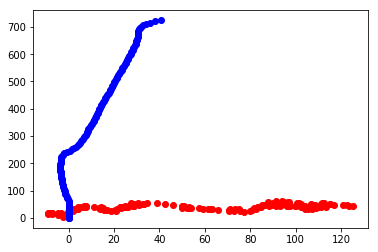

Count:771
()
()
Relative Depth: -42.90250728580542
Relative x: 125.83456935436485
Relative Original Depth: -725.207293161505
Relative Original x: 41.147821855328544
Count:772
()
()
Relative Depth: -42.22741216591984
Relative x: 125.87037806701146
Relative Original Depth: -725.9712038410173
Relative Original x: 41.79109698489958
Count:773
()
()
Relative Depth: -41.84717354340974
Relative x: 126.52364612818256
Relative Original Depth: -726.7073808840485
Relative Original x: 42.46419688432841
Count:774
()
()
Relative Depth: -41.44696757776941
Relative x: 127.01419651413703
Relative Original Depth: -727.4170800396773
Relative Original x: 43.167100385904504
Count:775
()
()
Relative Depth: -41.37022804619889
Relative x: 127.39258544017942
Relative Original Depth: -728.1327054590968
Relative Original x: 43.86380520144514


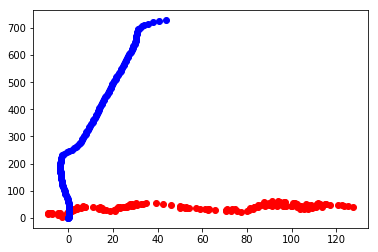

Count:776
()
()
Relative Depth: -41.488681753816394
Relative x: 127.76852100360239
Relative Original Depth: -728.8254409019345
Relative Original x: 44.58446414760623
Count:777
()
()
Relative Depth: -41.085115798415345
Relative x: 127.87444016127345
Relative Original Depth: -729.5136075809949
Relative Original x: 45.30916697398333
Count:778
()
()
Relative Depth: -40.6719565325927
Relative x: 127.63368064049726
Relative Original Depth: -730.1538558671946
Relative Original x: 46.0772262688683
Count:779
()
()
Relative Depth: -40.36580366833064
Relative x: 127.37104548517426
Relative Original Depth: -730.7699463296468
Relative Original x: 46.86188911011042
Count:780
()
()
Relative Depth: -40.00775333594827
Relative x: 127.04059483113028
Relative Original Depth: -731.3822941955725
Relative Original x: 47.650253388435296


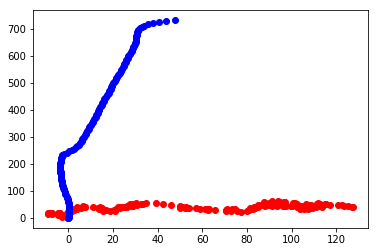

Count:781
()
()
Relative Depth: -39.54764199590357
Relative x: 126.57891053383882
Relative Original Depth: -731.9637379754837
Relative Original x: 48.46253067849661
Count:782
()
()
Relative Depth: -39.110677867521176
Relative x: 126.04162960765176
Relative Original Depth: -732.5322477653234
Relative Original x: 49.283976954174626
Count:783
()
()
Relative Depth: -38.865764292795575
Relative x: 125.60187942951664
Relative Original Depth: -733.0795740755398
Relative Original x: 50.119821025769596
Count:784
()
()
Relative Depth: -39.36876589410317
Relative x: 125.35023682596791
Relative Original Depth: -733.5939448818679
Relative Original x: 50.977338595836656
Count:785
()
()
Relative Depth: -40.19129118164817
Relative x: 125.04740443512546
Relative Original Depth: -734.0724556833577
Relative Original x: 51.855414194285295


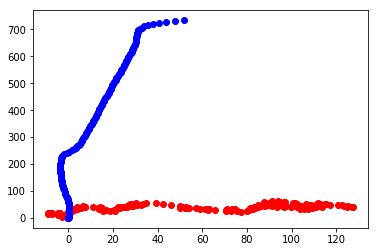

Count:786
()
()
Relative Depth: -40.77258443621102
Relative x: 124.58008249554372
Relative Original Depth: -734.5864890222344
Relative Original x: 52.711706222619775
Count:787
()
()
Relative Depth: -41.210934784650625
Relative x: 124.15221033869844
Relative Original Depth: -735.0783381125444
Relative Original x: 53.58218914845871
Count:788
()
()
Relative Depth: -41.646915335231746
Relative x: 124.71874772059499
Relative Original Depth: -735.5650617013048
Relative Original x: 54.45564874611426
Count:789
()
()
Relative Depth: -42.23770813413964
Relative x: 124.22154818522212
Relative Original Depth: -735.9475690939702
Relative Original x: 55.379492186775565
Count:790
()
()
Relative Depth: -42.92810965736623
Relative x: 123.91771617606891
Relative Original Depth: -736.380274789495
Relative Original x: 56.280321890520696


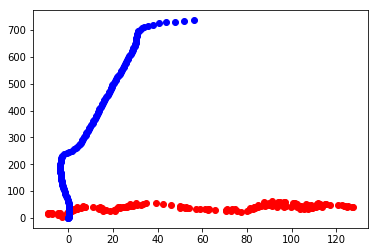

Count:791
()
()
Relative Depth: -43.71662686318376
Relative x: 124.08980689179926
Relative Original Depth: -736.7838345136909
Relative Original x: 57.194607757372935
Count:792
()
()
Relative Depth: -44.51899245355285
Relative x: 124.50037365898305
Relative Original Depth: -737.175394029186
Relative Original x: 58.11471950099686
Count:793
()
()
Relative Depth: -45.32210538818111
Relative x: 124.97672591512217
Relative Original Depth: -737.5586401805033
Relative Original x: 59.03732334255294
Count:794
()
()
Relative Depth: -44.71800764876581
Relative x: 125.45540239837547
Relative Original Depth: -737.9034827945045
Relative Original x: 59.97583116979038
Count:795
()
()
Relative Depth: -44.16030828414484
Relative x: 124.95655117586625
Relative Original Depth: -738.2442804316773
Relative Original x: 60.91596678459398


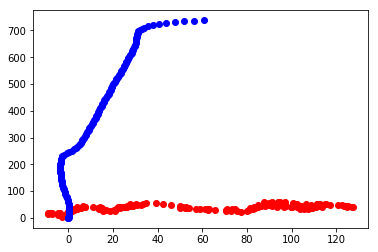

Count:796
()
()
Relative Depth: -44.9297692134641
Relative x: 125.39313665669538
Relative Original Depth: -738.5811027338901
Relative Original x: 61.85679210339021
Count:797
()
()
Relative Depth: -45.73326128683724
Relative x: 125.49713917240337
Relative Original Depth: -738.8184469636788
Relative Original x: 62.82436554697498
Count:798
()
()
Relative Depth: -46.358204086675215
Relative x: 125.1892171545843
Relative Original Depth: -739.146688776991
Relative Original x: 63.76895879194116
Count:799
()
()
Relative Depth: -46.83371852065756
Relative x: 124.86247990513168
Relative Original Depth: -739.4158641813209
Relative Original x: 64.73177384503195
Count:800
()
()
Relative Depth: -47.155807526448655
Relative x: 124.52476929111104
Relative Original Depth: -739.6698970412295
Relative Original x: 65.69760483504055


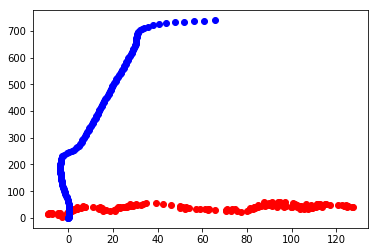

Count:801
()
()
Relative Depth: -47.44709872054239
Relative x: 124.05202040200555
Relative Original Depth: -739.9163610307721
Relative Original x: 66.66669282209254
Count:802
()
()
Relative Depth: -47.771479098159276
Relative x: 123.45885468353936
Relative Original Depth: -740.1669497227257
Relative Original x: 67.63433380248695
Count:803
()
()
Relative Depth: -48.15875837359841
Relative x: 122.79512452722949
Relative Original Depth: -740.395750329797
Relative Original x: 68.60701012551615
Count:804
()
()
Relative Depth: -48.39969712224158
Relative x: 122.03798691811151
Relative Original Depth: -740.5626211203305
Relative Original x: 69.59297854621316
Count:805
()
()
Relative Depth: -49.02963121848847
Relative x: 121.38727218046577
Relative Original Depth: -740.7672775783309
Relative Original x: 70.56986047930346


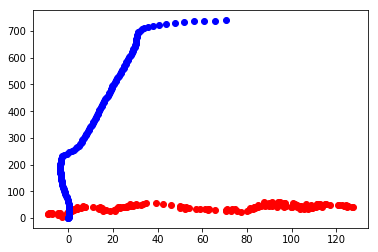

Count:806
()
()
Relative Depth: -49.96190835994724
Relative x: 121.04091339686146
Relative Original Depth: -740.9711169174689
Relative Original x: 71.5484979889915
Count:807
()
()
Relative Depth: -50.87447018060884
Relative x: 120.6695956663969
Relative Original Depth: -741.1410151785035
Relative Original x: 72.53375323441435
Count:808
()
()
Relative Depth: -49.92050825688908
Relative x: 120.37004127245355
Relative Original Depth: -741.3051602953491
Relative Original x: 73.51950399206166
Count:809
()
()
Relative Depth: -50.652473892745824
Relative x: 119.74878556804148
Relative Original Depth: -741.4681258453681
Relative Original x: 74.50610529477542
Count:810
()
()
Relative Depth: -51.22401826657293
Relative x: 118.96935990713013
Relative Original Depth: -741.6086915660493
Relative Original x: 75.49607387715801


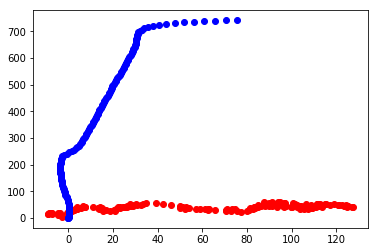

Count:811
()
()
Relative Depth: -51.90500038035177
Relative x: 118.27748842496148
Relative Original Depth: -741.7374925198559
Relative Original x: 76.48712419481835
Count:812
()
()
Relative Depth: -52.696879774963826
Relative x: 117.70848081560784
Relative Original Depth: -741.8715944547736
Relative Original x: 77.47678391806642
Count:813
()
()
Relative Depth: -53.54452258362533
Relative x: 117.20636144643669
Relative Original Depth: -741.9483631121732
Relative Original x: 78.47265694042999
Count:814
()
()
Relative Depth: -54.42798930716497
Relative x: 116.76748466506537
Relative Original Depth: -742.0011758596398
Relative Original x: 79.46924215185057
Count:815
()
()
Relative Depth: -55.349402932666315
Relative x: 116.4135071213576
Relative Original Depth: -742.0970919297321
Relative Original x: 80.46386793482196


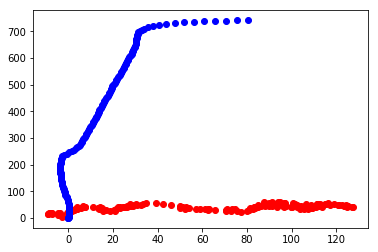

Count:816
()
()
Relative Depth: -56.31020583317521
Relative x: 116.16332791828584
Relative Original Depth: -742.2103267338141
Relative Original x: 81.45608104503295
Count:817
()
()
Relative Depth: -56.91563587446116
Relative x: 115.44506923933176
Relative Original Depth: -742.2642055869004
Relative Original x: 82.45277828745931
Count:818
()
()
Relative Depth: -57.008551023967286
Relative x: 114.52691854767912
Relative Original Depth: -742.3855239034478
Relative Original x: 83.44539123982923
Count:819
()
()
Relative Depth: -56.78569287050094
Relative x: 113.55232164127492
Relative Original Depth: -742.4780971624286
Relative Original x: 84.44096672055127
Count:820
()
()
Relative Depth: -56.43367620790934
Relative x: 112.63479594916122
Relative Original Depth: -742.5800269819241
Relative Original x: 85.43534355373522


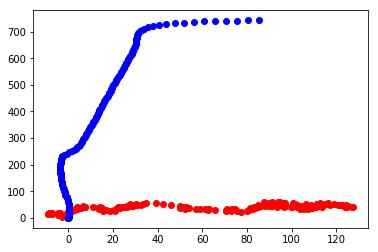

Count:821
()
()
Relative Depth: -56.16927849840825
Relative x: 111.67429369442131
Relative Original Depth: -742.6634233337451
Relative Original x: 86.43132778378795
Count:822
()
()
Relative Depth: -55.63094590067551
Relative x: 112.41189256871122
Relative Original Depth: -742.7494294784112
Relative Original x: 87.42660176356226
Count:823
()
()
Relative Depth: -55.25653941231652
Relative x: 111.49401603994934
Relative Original Depth: -742.8210902092242
Relative Original x: 88.42305283058234
Count:824
()
()
Relative Depth: -54.79558273134059
Relative x: 110.61495602892907
Relative Original Depth: -742.8683002411756
Relative Original x: 89.42050047543992
Count:825
()
()
Relative Depth: -54.4383441459064
Relative x: 109.68347192309474
Relative Original Depth: -742.9302569983345
Relative Original x: 90.41791487645358


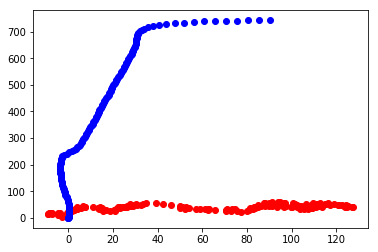

Count:826
()
()
Relative Depth: -54.26249271474214
Relative x: 108.70962385294352
Relative Original Depth: -743.0019537258889
Relative Original x: 91.41412140082885
Count:827
()
()
Relative Depth: -55.17271332767812
Relative x: 108.48244851026615
Relative Original Depth: -743.0751296705467
Relative Original x: 92.41099450849308
Count:828
()
()
Relative Depth: -55.15085824412088
Relative x: 107.52891707302034
Relative Original Depth: -743.116567038393
Relative Original x: 93.40923362152715
Count:829
()
()
Relative Depth: -55.2836554225871
Relative x: 106.56560891372106
Relative Original Depth: -743.1954756407134
Relative Original x: 94.40506700081208
Count:830
()
()
Relative Depth: -55.56361936043962
Relative x: 105.61223459807961
Relative Original Depth: -743.2524178896317
Relative Original x: 95.4025303887328


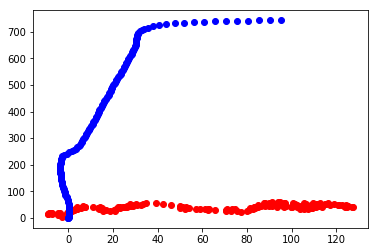

Count:831
()
()
Relative Depth: -55.90236297415678
Relative x: 104.6740484212505
Relative Original Depth: -743.2860135486334
Relative Original x: 96.40096415963453
Count:832
()
()
Relative Depth: -56.691373376578966
Relative x: 104.11352138995964
Relative Original Depth: -743.334435286211
Relative Original x: 97.39832768511252
Count:833
()
()
Relative Depth: -56.86307710649608
Relative x: 103.47982482299761
Relative Original Depth: -743.3396791093255
Relative Original x: 98.39719942064968
Count:834
()
()
Relative Depth: -57.83507977746634
Relative x: 103.49314859230681
Relative Original Depth: -743.3659305253875
Relative Original x: 99.39508380716224
Count:835
()
()
Relative Depth: -58.75028007347409
Relative x: 103.89246927936306
Relative Original Depth: -743.37683797429
Relative Original x: 100.39352383374911


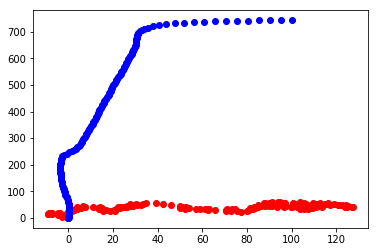

Count:836
()
()
Relative Depth: -59.22775735947418
Relative x: 104.7614354743029
Relative Original Depth: -743.4069981740001
Relative Original x: 101.39180127814083
Count:837
()
()
Relative Depth: -59.963492320516394
Relative x: 104.2811486730741
Relative Original Depth: -743.5173767947182
Relative Original x: 102.38467892588767
Count:838
()
()
Relative Depth: -60.46346537480027
Relative x: 103.5178370012852
Relative Original Depth: -743.5476128566112
Relative Original x: 103.38334511388497
Count:839
()
()
Relative Depth: -59.669620155519794
Relative x: 103.03622879967135
Relative Original Depth: -743.5865450352424
Relative Original x: 104.38202385674397
Count:840
()
()
Relative Depth: -58.733497916744106
Relative x: 102.88483910703104
Relative Original Depth: -743.6153536469683
Relative Original x: 105.38060085108722


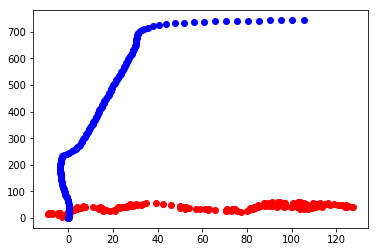

Count:841
()
()
Relative Depth: -57.79486081432252
Relative x: 102.77595361852953
Relative Original Depth: -743.6375426043327
Relative Original x: 106.37941737606367
Count:842
()
()
Relative Depth: -56.863629330176586
Relative x: 102.75992571837493
Relative Original Depth: -743.6867861784123
Relative Original x: 107.37772368582306
Count:843
()
()
Relative Depth: -55.94637616473946
Relative x: 102.79315183879196
Relative Original Depth: -743.6801958048553
Relative Original x: 108.37614304698249
Count:844
()
()
Relative Depth: -55.033680919817094
Relative x: 102.58046870867507
Relative Original Depth: -743.6834611632023
Relative Original x: 109.37583061480566
Count:845
()
()
Relative Depth: -54.16371373808505
Relative x: 102.33718322374683
Relative Original Depth: -743.7103830814887
Relative Original x: 110.37516350724847


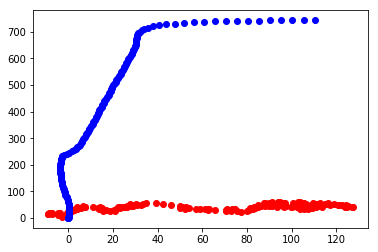

Count:846
()
()
Relative Depth: -53.33680519712224
Relative x: 102.22132276646967
Relative Original Depth: -743.7573015537629
Relative Original x: 111.37293985578604
Count:847
()
()
Relative Depth: -52.51899792666109
Relative x: 102.06369272522619
Relative Original Depth: -743.8183758864683
Relative Original x: 112.37093801885759
Count:848
()
()
Relative Depth: -51.681610068333036
Relative x: 101.80551131383791
Relative Original Depth: -743.8383118861497
Relative Original x: 113.37065543958846
Count:849
()
()
Relative Depth: -50.87584858222837
Relative x: 101.41397779120894
Relative Original Depth: -743.8537494016875
Relative Original x: 114.36936578754295
Count:850
()
()
Relative Depth: -50.38940127685353
Relative x: 101.92143062241978
Relative Original Depth: -743.8514760094811
Relative Original x: 115.36836271014826


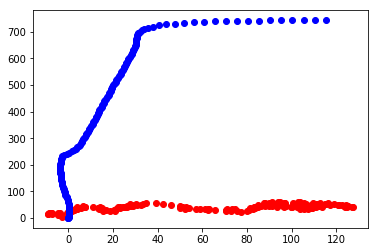

Count:851
()
()
Relative Depth: -49.93001931851934
Relative x: 101.24452462366175
Relative Original Depth: -743.8529809492827
Relative Original x: 116.36830534994257
Count:852
()
()
Relative Depth: -49.823631503466224
Relative x: 100.53410820030761
Relative Original Depth: -743.8881456787803
Relative Original x: 117.3672828593425
Count:853
()
()
Relative Depth: -49.844082305937704
Relative x: 100.02882995756339
Relative Original Depth: -743.9285006246289
Relative Original x: 118.3661083469488
Count:854
()
()
Relative Depth: -50.00232815758732
Relative x: 99.7915303116116
Relative Original Depth: -744.0009383029472
Relative Original x: 119.36346698288709
Count:855
()
()
Relative Depth: -50.053538426607375
Relative x: 99.73306543890072
Relative Original Depth: -743.9619634275151
Relative Original x: 120.36105168125842


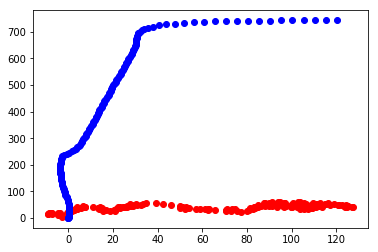

Count:856
()
()
Relative Depth: -50.138967414007034
Relative x: 99.68572167095977
Relative Original Depth: -743.9941225445091
Relative Original x: 121.3596668284454
Count:857
()
()
Relative Depth: -50.189285904143
Relative x: 99.74887136355895
Relative Original Depth: -744.0260253217878
Relative Original x: 122.35814796074655
Count:858
()
()
Relative Depth: -50.55712340450665
Relative x: 98.9067299856709
Relative Original Depth: -744.0332264121793
Relative Original x: 123.35634351847743
Count:859
()
()
Relative Depth: -50.59985191592506
Relative x: 99.14753564763942
Relative Original Depth: -744.056606320847
Relative Original x: 124.35482623946483
Count:860
()
()
Relative Depth: -50.700412292513974
Relative x: 99.36629836645918
Relative Original Depth: -744.1096051400489
Relative Original x: 125.35297815642042


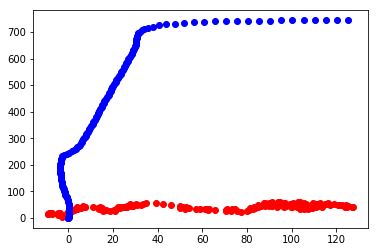

Count:861
()
()
Relative Depth: -50.85996918494757
Relative x: 99.56931165823657
Relative Original Depth: -744.1414337863856
Relative Original x: 126.35191888893223
Count:862
()
()
Relative Depth: -50.750092218512314
Relative x: 100.01796788474533
Relative Original Depth: -744.1960562286101
Relative Original x: 127.34927914717039
Count:863
()
()
Relative Depth: -50.28999323196366
Relative x: 100.72760824295973
Relative Original Depth: -744.2252180711432
Relative Original x: 128.34842812241533
Count:864
()
()
Relative Depth: -49.94433977907783
Relative x: 101.57986156299926
Relative Original Depth: -744.2262720487137
Relative Original x: 129.3476756211043
Count:865
()
()
Relative Depth: -49.80535929265554
Relative x: 102.49524846889913
Relative Original Depth: -744.2259887498903
Relative Original x: 130.34672238585966


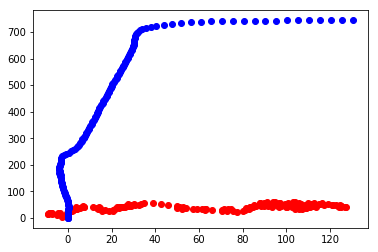

Count:866
()
()
Relative Depth: -49.80372141072515
Relative x: 103.47610220567726
Relative Original Depth: -744.2108728690941
Relative Original x: 131.34591624827038
Count:867
()
()
Relative Depth: -49.9761175930414
Relative x: 104.14203440457126
Relative Original Depth: -744.2052309007404
Relative Original x: 132.34533768820697
Count:868
()
()
Relative Depth: -50.130172402218946
Relative x: 104.1267151222307
Relative Original Depth: -744.2360618141571
Relative Original x: 133.34485972239284
Count:869
()
()
Relative Depth: -50.982793788284646
Relative x: 104.21409910641053
Relative Original Depth: -744.26162824405
Relative Original x: 134.34412591731774
Count:870
()
()
Relative Depth: -51.265859877975345
Relative x: 104.38942607772097
Relative Original Depth: -744.2627848022933
Relative Original x: 135.34312831191826


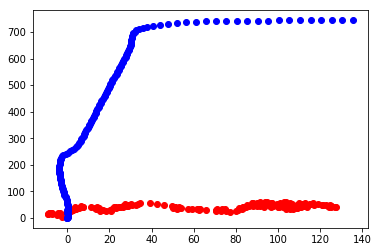

Count:871
()
()
Relative Depth: -51.36768960430742
Relative x: 104.06965069337906
Relative Original Depth: -744.2906856317936
Relative Original x: 136.34195514924363
Count:872
()
()
Relative Depth: -51.490480062789906
Relative x: 104.0658666182244
Relative Original Depth: -744.3524642756911
Relative Original x: 137.33947281488213
Count:873
()
()
Relative Depth: -51.3790669279707
Relative x: 103.55559571116358
Relative Original Depth: -744.3812451223545
Relative Original x: 138.33762839056743
Count:874
()
()
Relative Depth: -51.16747288760525
Relative x: 102.89203080904339
Relative Original Depth: -744.3960195960523
Relative Original x: 139.3357884917888
Count:875
()
()
Relative Depth: -50.8987609577242
Relative x: 102.07233795028819
Relative Original Depth: -744.4224035766432
Relative Original x: 140.3342252251885


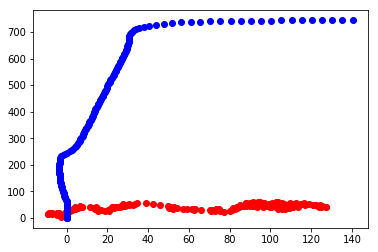

Count:876
()
()
Relative Depth: -50.72100524084019
Relative x: 101.26996518634752
Relative Original Depth: -744.4337904681158
Relative Original x: 141.3324882388086
Count:877
()
()
Relative Depth: -50.665901714112636
Relative x: 100.75265303548692
Relative Original Depth: -744.4607007867803
Relative Original x: 142.33075180719283
Count:878
()
()
Relative Depth: -50.62838467395855
Relative x: 100.20750878659982
Relative Original Depth: -744.5023511463221
Relative Original x: 143.32968653895603
Count:879
()
()
Relative Depth: -50.41234827094796
Relative x: 99.38109195162605
Relative Original Depth: -744.5394444246397
Relative Original x: 144.32751702074813
Count:880
()
()
Relative Depth: -49.79794243105447
Relative x: 98.8668955784401
Relative Original Depth: -744.5936366087329
Relative Original x: 145.32572983426851


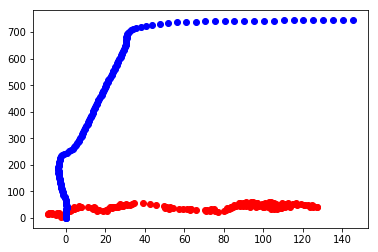

Count:881
()
()
Relative Depth: -49.109458698213594
Relative x: 98.84129128538257
Relative Original Depth: -744.6540294361431
Relative Original x: 146.32270088562657
Count:882
()
()
Relative Depth: -48.490504709711665
Relative x: 99.02831959018184
Relative Original Depth: -744.6767554887343
Relative Original x: 147.3206941884883
Count:883
()
()
Relative Depth: -47.98177319881651
Relative x: 99.36686775378362
Relative Original Depth: -744.7003136380386
Relative Original x: 148.31987344708912
Count:884
()
()
Relative Depth: -47.263295163996176
Relative x: 99.52250849192892
Relative Original Depth: -744.7556515879002
Relative Original x: 149.31722665776388
Count:885
()
()
Relative Depth: -46.35195387596814
Relative x: 99.42034303426155
Relative Original Depth: -744.7546918408018
Relative Original x: 150.3160256447582


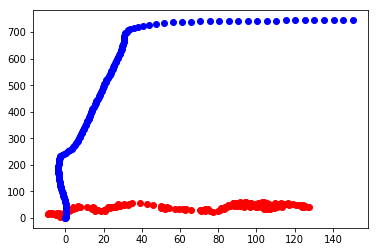

Count:886
()
()
Relative Depth: -45.466069150000855
Relative x: 99.43531546402379
Relative Original Depth: -744.788173421196
Relative Original x: 151.31369839735535
Count:887
()
()
Relative Depth: -44.96740630237566
Relative x: 99.85318362346267
Relative Original Depth: -744.8315279589519
Relative Original x: 152.3114072694832
Count:888
()
()
Relative Depth: -44.77290427931127
Relative x: 100.40049952325265
Relative Original Depth: -744.8863289590919
Relative Original x: 153.30891859519912
Count:889
()
()
Relative Depth: -44.51433419620887
Relative x: 100.67705994259886
Relative Original Depth: -744.9095220415269
Relative Original x: 154.30769688317324
Count:890
()
()
Relative Depth: -43.801900953511506
Relative x: 100.36122326382748
Relative Original Depth: -744.9731174344914
Relative Original x: 155.30543880918012


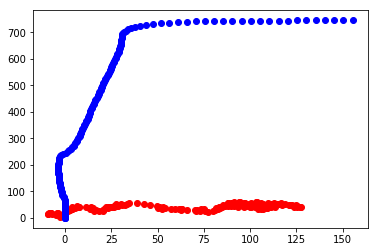

Count:891
()
()
Relative Depth: -42.96146992450198
Relative x: 99.82068317707292
Relative Original Depth: -745.0394305480604
Relative Original x: 156.30246696287807
Count:892
()
()
Relative Depth: -42.12848762976376
Relative x: 99.28293215379375
Relative Original Depth: -745.058617828815
Relative Original x: 157.29997132718592
Count:893
()
()
Relative Depth: -41.45695346828392
Relative x: 98.54291145199572
Relative Original Depth: -745.0832476952452
Relative Original x: 158.29881338973863
Count:894
()
()
Relative Depth: -41.010410886961076
Relative x: 97.65861857990835
Relative Original Depth: -745.1489218509903
Relative Original x: 159.29552344010943
Count:895
()
()
Relative Depth: -40.37655763405537
Relative x: 96.90373146013025
Relative Original Depth: -745.1573558819501
Relative Original x: 160.29388349067696


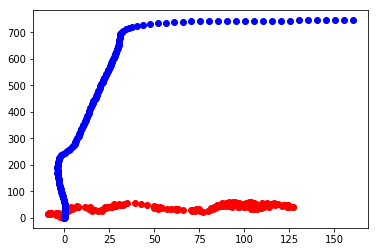

Count:896
()
()
Relative Depth: -39.72352243571786
Relative x: 96.35545792409796
Relative Original Depth: -745.1772064614288
Relative Original x: 161.29126772450235
Count:897
()
()
Relative Depth: -39.13691744379622
Relative x: 95.65229093493964
Relative Original Depth: -745.2129445229323
Relative Original x: 162.29014146415892
Count:898
()
()
Relative Depth: -38.64856997387944
Relative x: 94.78379778631496
Relative Original Depth: -745.2527967995921
Relative Original x: 163.28825814454612
Count:899
()
()
Relative Depth: -38.2600917816211
Relative x: 93.91219606797084
Relative Original Depth: -745.30641621175
Relative Original x: 164.28587424636396
Count:900
()
()
Relative Depth: -38.04367217475417
Relative x: 92.95283305742404
Relative Original Depth: -745.3930009440533
Relative Original x: 165.2821119030822


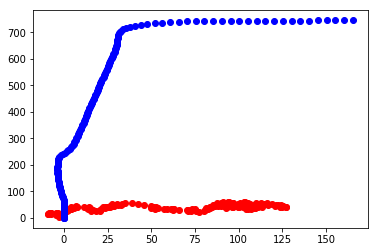

Count:901
()
()
Relative Depth: -37.97030894744867
Relative x: 92.10325850132224
Relative Original Depth: -745.4096589707073
Relative Original x: 166.28137991349388
Count:902
()
()
Relative Depth: -37.76269304695305
Relative x: 91.43593806866323
Relative Original Depth: -745.4342068599234
Relative Original x: 167.2805708833477
Count:903
()
()
Relative Depth: -37.50262076393742
Relative x: 91.17013934932976
Relative Original Depth: -745.4835089757947
Relative Original x: 168.27901210174977
Count:904
()
()
Relative Depth: -37.23086519616299
Relative x: 91.07117532301125
Relative Original Depth: -745.5368914960007
Relative Original x: 169.27581196191915
Count:905
()
()
Relative Depth: -36.99969294207936
Relative x: 90.95591172386025
Relative Original Depth: -745.5897860483112
Relative Original x: 170.2734549832153


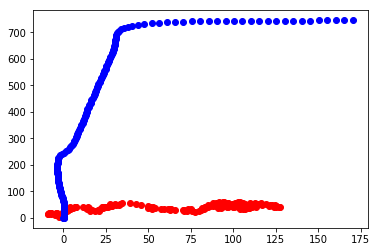

Count:906
()
()
Relative Depth: -36.84816984746982
Relative x: 90.70685219473273
Relative Original Depth: -745.6346831937688
Relative Original x: 171.27153607724867
Count:907
()
()
Relative Depth: -36.66845743434243
Relative x: 90.31212678980461
Relative Original Depth: -745.694564326756
Relative Original x: 172.2690819472959
Count:908
()
()
Relative Depth: -36.537882252395356
Relative x: 89.61842027066291
Relative Original Depth: -745.7331604866249
Relative Original x: 173.2671903932101
Count:909
()
()
Relative Depth: -36.39738935349851
Relative x: 88.82215348788853
Relative Original Depth: -745.7514921917193
Relative Original x: 174.26616548316832
Count:910
()
()
Relative Depth: -36.10293587579267
Relative x: 88.06441545843359
Relative Original Depth: -745.8204914519927
Relative Original x: 175.2636721658708


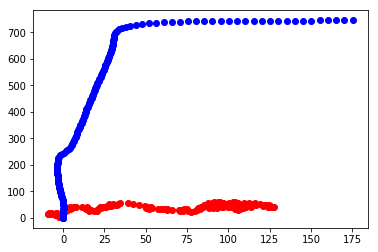

Count:911
()
()
Relative Depth: -35.70966864316866
Relative x: 87.48919198976299
Relative Original Depth: -745.8554782032267
Relative Original x: 176.26254933433526
Count:912
()
()
Relative Depth: -35.32398456780259
Relative x: 87.38957154584311
Relative Original Depth: -745.9000333822758
Relative Original x: 177.26011807227763
Count:913
()
()
Relative Depth: -34.53053196797616
Relative x: 86.97928064239514
Relative Original Depth: -745.9483817599532
Relative Original x: 178.25848686195775
Count:914
()
()
Relative Depth: -35.076463285172174
Relative x: 87.03824531738071
Relative Original Depth: -745.9986525177644
Relative Original x: 179.25568025873147
Count:915
()
()
Relative Depth: -35.51501062915704
Relative x: 87.1167405857557
Relative Original Depth: -746.0129999465478
Relative Original x: 180.2540835211544


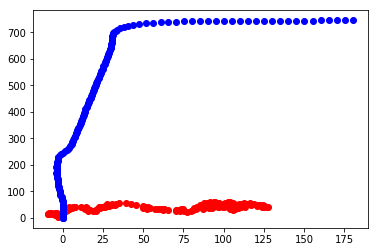

Count:916
()
()
Relative Depth: -36.002618548608325
Relative x: 87.17185130041777
Relative Original Depth: -746.053689921144
Relative Original x: 181.25220652840778
Count:917
()
()
Relative Depth: -36.67334375308954
Relative x: 87.04157491544525
Relative Original Depth: -746.1130828672698
Relative Original x: 182.2497545988082
Count:918
()
()
Relative Depth: -37.487468966528844
Relative x: 86.75681855954377
Relative Original Depth: -746.1688882967204
Relative Original x: 183.24777961695696
Count:919
()
()
Relative Depth: -36.4919412419407
Relative x: 86.66710173851642
Relative Original Depth: -746.1894887933317
Relative Original x: 184.24637072489517
Count:920
()
()
Relative Depth: -37.331346083318934
Relative x: 86.35311017621382
Relative Original Depth: -746.2242895785042
Relative Original x: 185.24486317772792


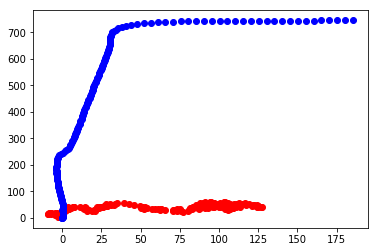

Count:921
()
()
Relative Depth: -38.19144961424323
Relative x: 86.04495003258927
Relative Original Depth: -746.2845035163692
Relative Original x: 186.2411671432776
Count:922
()
()
Relative Depth: -39.04647785554061
Relative x: 85.73661602797941
Relative Original Depth: -746.342129690398
Relative Original x: 187.23809860202152
Count:923
()
()
Relative Depth: -39.84735738081733
Relative x: 85.42935176700847
Relative Original Depth: -746.4324849768016
Relative Original x: 188.23369299406454
Count:924
()
()
Relative Depth: -40.29609937704091
Relative x: 84.92266191160805
Relative Original Depth: -746.4602800726368
Relative Original x: 189.23165985901068
Count:925
()
()
Relative Depth: -40.383117030377335
Relative x: 84.31516671288189
Relative Original Depth: -746.5291765594908
Relative Original x: 190.22811858854445


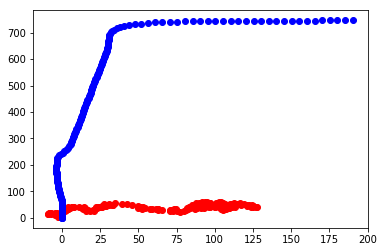

Count:926
()
()
Relative Depth: -40.30555623822306
Relative x: 84.09439941957235
Relative Original Depth: -746.5865872148572
Relative Original x: 191.22603452021818
Count:927
()
()
Relative Depth: -40.195862701213834
Relative x: 84.19366827055039
Relative Original Depth: -746.6530324065558
Relative Original x: 192.2229002123269
Count:928
()
()
Relative Depth: -40.347548041624485
Relative x: 84.36559019596636
Relative Original Depth: -746.7267445846287
Relative Original x: 193.22003554078032
Count:929
()
()
Relative Depth: -41.17487677316664
Relative x: 83.897208354847
Relative Original Depth: -746.7909108723735
Relative Original x: 194.21743018470528
Count:930
()
()
Relative Depth: -41.3377675885243
Relative x: 84.22165124106252
Relative Original Depth: -746.9154199432884
Relative Original x: 195.20950937476533


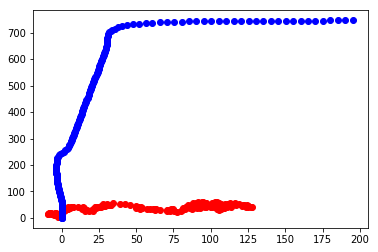

Count:931
()
()
Relative Depth: -41.53999726379425
Relative x: 84.44197404153326
Relative Original Depth: -746.9733905614339
Relative Original x: 196.20723792868387
Count:932
()
()
Relative Depth: -41.9458562040404
Relative x: 84.52727821451104
Relative Original Depth: -747.0218017204928
Relative Original x: 197.20538627510533
Count:933
()
()
Relative Depth: -42.351865270467506
Relative x: 84.36579247463656
Relative Original Depth: -747.1065326166678
Relative Original x: 198.20176576445533
Count:934
()
()
Relative Depth: -42.674136100982565
Relative x: 83.95465135753875
Relative Original Depth: -747.1928788490055
Relative Original x: 199.19629834180287
Count:935
()
()
Relative Depth: -42.99807753915223
Relative x: 83.6379418992304
Relative Original Depth: -747.2205255156114
Relative Original x: 200.19514480739642


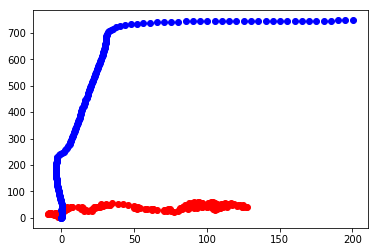

Count:936
()
()
Relative Depth: -43.335202631298046
Relative x: 83.44631195130435
Relative Original Depth: -747.2738586339154
Relative Original x: 201.19327944190226
Count:937
()
()
Relative Depth: -43.58993416927787
Relative x: 83.26468525479022
Relative Original Depth: -747.3205675584969
Relative Original x: 202.1903857228575
Count:938
()
()
Relative Depth: -43.87200905649474
Relative x: 83.0007206517932
Relative Original Depth: -747.3659468145611
Relative Original x: 203.18900356505816
Count:939
()
()
Relative Depth: -44.5137141837201
Relative x: 82.51495822433573
Relative Original Depth: -747.3756808504879
Relative Original x: 204.18837416982217
Count:940
()
()
Relative Depth: -45.27571166276799
Relative x: 81.86741754686348
Relative Original Depth: -747.3676136055549
Relative Original x: 205.18211465570042


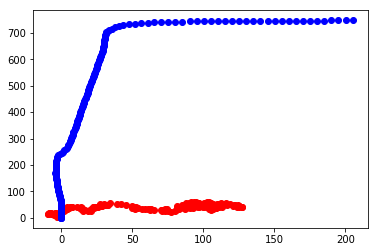

Count:941
()
()
Relative Depth: -46.012639499735954
Relative x: 81.19978333066791
Relative Original Depth: -747.4325873353779
Relative Original x: 206.17922069803987
Count:942
()
()
Relative Depth: -46.74514743842032
Relative x: 80.53594651141795
Relative Original Depth: -747.4817703112426
Relative Original x: 207.17748554132484
Count:943
()
()
Relative Depth: -47.35920245437438
Relative x: 79.90106366307562
Relative Original Depth: -747.5646036585566
Relative Original x: 208.17340551652575
Count:944
()
()
Relative Depth: -47.677995931696465
Relative x: 79.25650168824572
Relative Original Depth: -747.6862343020058
Relative Original x: 209.165164331689
Count:945
()
()
Relative Depth: -47.78979483008305
Relative x: 78.57109393137145
Relative Original Depth: -747.7621297634049
Relative Original x: 210.16139757599055


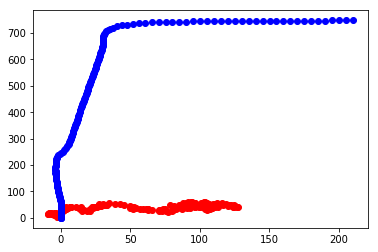

Count:946
()
()
Relative Depth: -47.969026389350695
Relative x: 77.8866154241689
Relative Original Depth: -747.8330759416848
Relative Original x: 211.15724014340594
Count:947
()
()
Relative Depth: -48.14637914435058
Relative x: 77.22218635712734
Relative Original Depth: -747.854847785363
Relative Original x: 212.15552693986928
Count:948
()
()
Relative Depth: -48.42537700614961
Relative x: 76.60890796507628
Relative Original Depth: -747.8937844433913
Relative Original x: 213.15350676578277
Count:949
()
()
Relative Depth: -48.76400495797553
Relative x: 76.02496665916338
Relative Original Depth: -747.9131425895797
Relative Original x: 214.14954029562918
Count:950
()
()
Relative Depth: -48.878651297673095
Relative x: 75.39070049003078
Relative Original Depth: -747.9850849665431
Relative Original x: 215.14512639121557


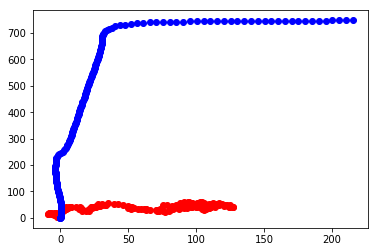

Count:951
()
()
Relative Depth: -48.284339788004374
Relative x: 75.41234921528951
Relative Original Depth: -748.0169803156797
Relative Original x: 216.14423095133841
Count:952
()
()
Relative Depth: -47.54931673151583
Relative x: 75.98563484893721
Relative Original Depth: -748.1106954302875
Relative Original x: 217.1377895342144
Count:953
()
()
Relative Depth: -46.77099388269258
Relative x: 76.455831860261
Relative Original Depth: -748.1571022825991
Relative Original x: 218.135600013279
Count:954
()
()
Relative Depth: -45.99999818763818
Relative x: 76.292498325886
Relative Original Depth: -748.2105257792275
Relative Original x: 219.1325112692661
Count:955
()
()
Relative Depth: -45.23319343491845
Relative x: 76.8238854305197
Relative Original Depth: -748.2747886074566
Relative Original x: 220.12992759164388


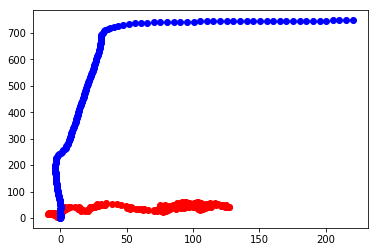

Count:956
()
()
Relative Depth: -44.50251647310421
Relative x: 77.44830086738153
Relative Original Depth: -748.3338759739833
Relative Original x: 221.1281109963264
Count:957
()
()
Relative Depth: -43.96824611698318
Relative x: 78.23988979736569
Relative Original Depth: -748.3939657106798
Relative Original x: 222.12620914401097
Count:958
()
()
Relative Depth: -43.63108510321508
Relative x: 79.10645521082635
Relative Original Depth: -748.4336267384508
Relative Original x: 223.1243484961607
Count:959
()
()
Relative Depth: -43.261478871520865
Relative x: 79.96137814500362
Relative Original Depth: -748.4202443289611
Relative Original x: 224.12164429460745
Count:960
()
()
Relative Depth: -42.81733367999854
Relative x: 80.72476878642003
Relative Original Depth: -748.4480561207741
Relative Original x: 225.11894526046837


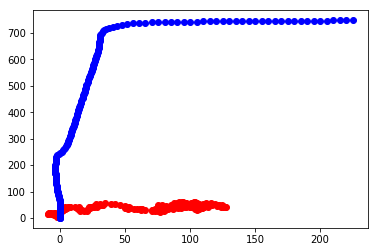

Count:961
()
()
Relative Depth: -42.27321935062725
Relative x: 81.44909872377085
Relative Original Depth: -748.4719476599126
Relative Original x: 226.11555763995142
Count:962
()
()
Relative Depth: -41.66846852901533
Relative x: 82.22498058067406
Relative Original Depth: -748.5247877574287
Relative Original x: 227.11068910446676
Count:963
()
()
Relative Depth: -41.131163756750546
Relative x: 83.06508854853485
Relative Original Depth: -748.5726713220623
Relative Original x: 228.1070195378827
Count:964
()
()
Relative Depth: -40.66292861062513
Relative x: 83.94764169993474
Relative Original Depth: -748.6169615729974
Relative Original x: 229.10429839154534
Count:965
()
()
Relative Depth: -40.219238924727975
Relative x: 84.82737565491314
Relative Original Depth: -748.6926944869145
Relative Original x: 230.1006500798645


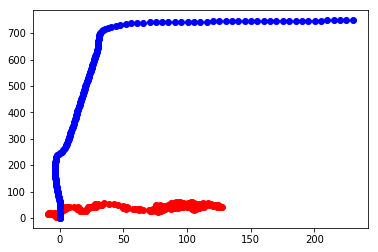

Count:966
()
()
Relative Depth: -39.60858423599844
Relative x: 85.07935656629934
Relative Original Depth: -748.7468883828774
Relative Original x: 231.09903611810586
Count:967
()
()
Relative Depth: -39.338265439004296
Relative x: 85.9274426449387
Relative Original Depth: -748.8121908735558
Relative Original x: 232.09637079718595
Count:968
()
()
Relative Depth: -39.2804259250271
Relative x: 86.73133097881484
Relative Original Depth: -748.8525349329028
Relative Original x: 233.09405985159734
Count:969
()
()
Relative Depth: -39.24918838575582
Relative x: 87.50369446360828
Relative Original Depth: -748.9282477665494
Relative Original x: 234.0901053314227
Count:970
()
()
Relative Depth: -39.191917816700965
Relative x: 88.30361820847536
Relative Original Depth: -748.9553360608497
Relative Original x: 235.0866654871198


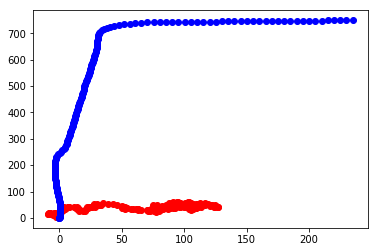

Count:971
()
()
Relative Depth: -39.14747952558553
Relative x: 89.17497804021357
Relative Original Depth: -749.0725514333283
Relative Original x: 236.07831416988668
Count:972
()
()
Relative Depth: -39.17947443603628
Relative x: 90.00043962270189
Relative Original Depth: -749.1105951578911
Relative Original x: 237.0754461398675
Count:973
()
()
Relative Depth: -39.64542990696961
Relative x: 90.43138365344886
Relative Original Depth: -749.1464454773674
Relative Original x: 238.07332845913044
Count:974
()
()
Relative Depth: -40.09580196984304
Relative x: 90.69090325229635
Relative Original Depth: -749.1967731984438
Relative Original x: 239.07036070101825
Count:975
()
()
Relative Depth: -40.1953398054948
Relative x: 91.06871091474493
Relative Original Depth: -749.261090228013
Relative Original x: 240.06780708028597


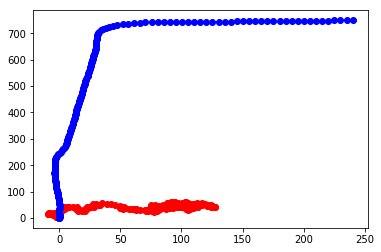

Count:976
()
()
Relative Depth: -40.31084116520385
Relative x: 91.38045409254208
Relative Original Depth: -749.2903964996832
Relative Original x: 241.06569567293687
Count:977
()
()
Relative Depth: -40.49783475346732
Relative x: 91.5957064146327
Relative Original Depth: -749.3676492974621
Relative Original x: 242.06206297901574
Count:978
()
()
Relative Depth: -40.7656673124155
Relative x: 91.72522442059463
Relative Original Depth: -749.4097786536072
Relative Original x: 243.0594399129502
Count:979
()
()
Relative Depth: -41.027010310201135
Relative x: 91.83050660290294
Relative Original Depth: -749.4405539163054
Relative Original x: 244.0574997666235
Count:980
()
()
Relative Depth: -41.15008568871717
Relative x: 92.20186379650454
Relative Original Depth: -749.5163906110558
Relative Original x: 245.05372018779522


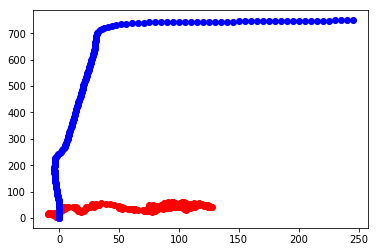

Count:981
()
()
Relative Depth: -41.417497416340346
Relative x: 92.87583872679764
Relative Original Depth: -749.5692799541822
Relative Original x: 246.05131155768626
Count:982
()
()
Relative Depth: -42.11370589048267
Relative x: 93.34717521949396
Relative Original Depth: -749.622883167437
Relative Original x: 247.04831075822557
Count:983
()
()
Relative Depth: -42.85739116053101
Relative x: 93.70463469608288
Relative Original Depth: -749.6860407276532
Relative Original x: 248.0461496249583
Count:984
()
()
Relative Depth: -43.488644924529154
Relative x: 94.2809067582366
Relative Original Depth: -749.7566138496992
Relative Original x: 249.04271982757976
Count:985
()
()
Relative Depth: -44.12883341099274
Relative x: 94.93898185352822
Relative Original Depth: -749.8657565952371
Relative Original x: 250.03640337321002


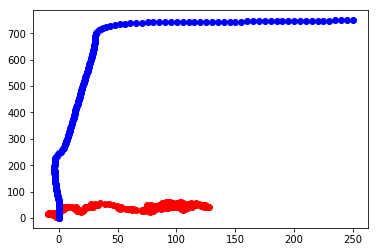

Count:986
()
()
Relative Depth: -44.84659464107578
Relative x: 95.45444432294781
Relative Original Depth: -749.9399010444374
Relative Original x: 251.03250354366767
Count:987
()
()
Relative Depth: -45.62638748751418
Relative x: 95.57835577849822
Relative Original Depth: -750.007094591625
Relative Original x: 252.029984166876
Count:988
()
()
Relative Depth: -46.392307180294914
Relative x: 95.53423810568646
Relative Original Depth: -750.1145979813939
Relative Original x: 253.02322082543847
Count:989
()
()
Relative Depth: -47.100777433239884
Relative x: 95.67067874909168
Relative Original Depth: -750.1652604774569
Relative Original x: 254.02009813642408
Count:990
()
()
Relative Depth: -47.72800769464602
Relative x: 96.02140257086766
Relative Original Depth: -750.2559710829978
Relative Original x: 255.01592408405816


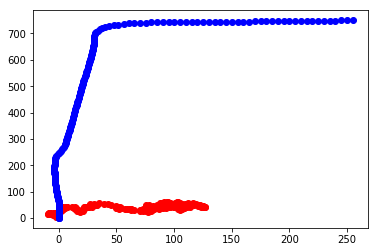

Count:991
()
()
Relative Depth: -48.347782277764665
Relative x: 96.34831112080839
Relative Original Depth: -750.3283629694447
Relative Original x: 256.01314790566005
Count:992
()
()
Relative Depth: -49.09057298380421
Relative x: 95.78005918291777
Relative Original Depth: -750.3449872235616
Relative Original x: 257.0104570512755
Count:993
()
()
Relative Depth: -49.51597571654884
Relative x: 96.23070216312927
Relative Original Depth: -750.4001918264006
Relative Original x: 258.0078750231555
Count:994
()
()
Relative Depth: -49.69448011749963
Relative x: 96.84610198133207
Relative Original Depth: -750.4487353572056
Relative Original x: 259.00634872281006
Count:995
()
()
Relative Depth: -49.83549903181012
Relative x: 97.31291067437438
Relative Original Depth: -750.511058732747
Relative Original x: 260.00383498183606


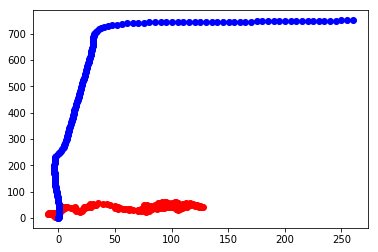

Count:996
()
()
Relative Depth: -49.939123441970224
Relative x: 97.69385140182625
Relative Original Depth: -750.583534972196
Relative Original x: 261.00086668355937
Count:997
()
()
Relative Depth: -49.970143096433624
Relative x: 98.31663229125715
Relative Original Depth: -750.6263205579573
Relative Original x: 261.99852214287927
Count:998
()
()
Relative Depth: -49.69898846843281
Relative x: 99.14727211570064
Relative Original Depth: -750.6955198866054
Relative Original x: 262.99505537997305
Count:999
()
()
Relative Depth: -50.00731224000328
Relative x: 99.80934805806811
Relative Original Depth: -750.7702365367464
Relative Original x: 263.9912593443126
Count:1000
()
()
Relative Depth: -49.4811998642622
Relative x: 100.63697396785427
Relative Original Depth: -750.8301886344083
Relative Original x: 264.98752948976147


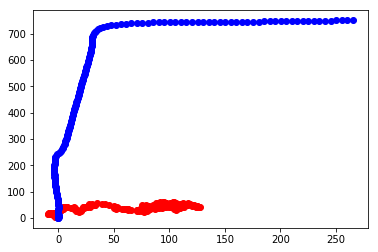

Count:1001
()
()
Relative Depth: -49.407469911844835
Relative x: 101.30381856769051
Relative Original Depth: -750.8919617465999
Relative Original x: 265.98469038308633
Count:1002
()
()
Relative Depth: -48.77287478184382
Relative x: 102.03854650165903
Relative Original Depth: -750.990199234525
Relative Original x: 266.97935876322543
Count:1003
()
()
Relative Depth: -48.06552050871496
Relative x: 102.61255677420854
Relative Original Depth: -751.0846954879354
Relative Original x: 267.9738993945455
Count:1004
()
()
Relative Depth: -47.39691944202395
Relative x: 103.18369258501484
Relative Original Depth: -751.1737853111213
Relative Original x: 268.9694989888356
Count:1005
()
()
Relative Depth: -46.936823561997215
Relative x: 103.66577034083369
Relative Original Depth: -751.1952219209646
Relative Original x: 269.9688166025464


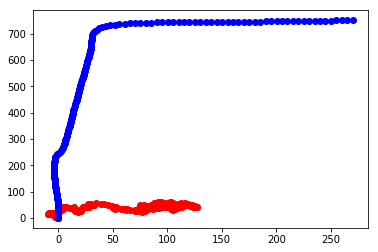

Count:1006
()
()
Relative Depth: -46.69383793186898
Relative x: 104.33336932252894
Relative Original Depth: -751.2475237507854
Relative Original x: 270.9661944192711
Count:1007
()
()
Relative Depth: -47.190438301395254
Relative x: 105.15993917687003
Relative Original Depth: -751.3043050863107
Relative Original x: 271.96357156478655
Count:1008
()
()
Relative Depth: -47.97532111147392
Relative x: 105.7750831634377
Relative Original Depth: -751.3427785150761
Relative Original x: 272.9625460374402
Count:1009
()
()
Relative Depth: -48.72319779418637
Relative x: 106.40478317172646
Relative Original Depth: -751.4142890908244
Relative Original x: 273.95965995311155
Count:1010
()
()
Relative Depth: -49.44217491259742
Relative x: 107.07105397287982
Relative Original Depth: -751.4708117020646
Relative Original x: 274.9574183031268


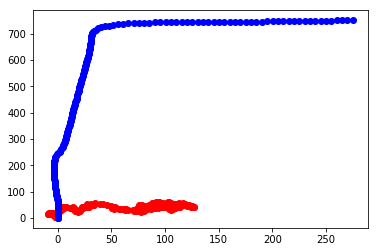

Count:1011
()
()
Relative Depth: -50.08675994336496
Relative x: 107.81854499138733
Relative Original Depth: -751.6098869228858
Relative Original x: 275.9476710566592
Count:1012
()
()
Relative Depth: -50.6710969851309
Relative x: 108.61401726541197
Relative Original Depth: -751.6806058132053
Relative Original x: 276.94387466205905
Count:1013
()
()
Relative Depth: -51.18629754245598
Relative x: 109.47050467859466
Relative Original Depth: -751.6818224191708
Relative Original x: 277.9433849792232
Count:1014
()
()
Relative Depth: -51.79053396433215
Relative x: 110.2137116208908
Relative Original Depth: -751.7049154946592
Relative Original x: 278.94273721636216
Count:1015
()
()
Relative Depth: -52.475141077516966
Relative x: 110.74245834495532
Relative Original Depth: -751.8161462661825
Relative Original x: 279.9364990992704


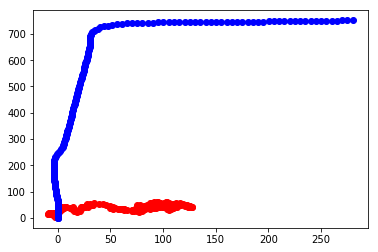

Count:1016
()
()
Relative Depth: -53.154959537867505
Relative x: 111.32235023471976
Relative Original Depth: -751.8476328068992
Relative Original x: 280.93551434469447
Count:1017
()
()
Relative Depth: -53.796407102545565
Relative x: 112.05617582389475
Relative Original Depth: -751.8945779806867
Relative Original x: 281.93404811751816
Count:1018
()
()
Relative Depth: -54.19977215690881
Relative x: 112.96856739872125
Relative Original Depth: -751.9441857687333
Relative Original x: 282.9315915505491
Count:1019
()
()
Relative Depth: -54.54042252433666
Relative x: 113.90612483352409
Relative Original Depth: -752.018612106217
Relative Original x: 283.92720287918706
Count:1020
()
()
Relative Depth: -54.88035857430741
Relative x: 114.82652807405249
Relative Original Depth: -752.1971860591908
Relative Original x: 284.9102606284615


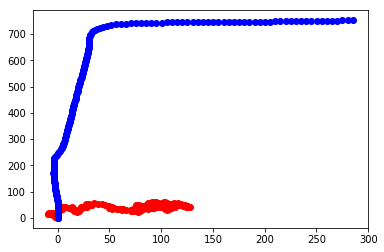

Count:1021
()
()
Relative Depth: -55.11718219077039
Relative x: 115.67951868969239
Relative Original Depth: -752.2673535524077
Relative Original x: 285.90675671310856
Count:1022
()
()
Relative Depth: -55.420631140167224
Relative x: 116.35509984925217
Relative Original Depth: -752.3124476314231
Relative Original x: 286.9036150549224
Count:1023
()
()
Relative Depth: -55.77900865249748
Relative x: 116.9376771488826
Relative Original Depth: -752.3521728884806
Relative Original x: 287.9010628914143
Count:1024
()
()
Relative Depth: -56.33399920875626
Relative x: 117.39283594049093
Relative Original Depth: -752.4185246488265
Relative Original x: 288.8959907529245
Count:1025
()
()
Relative Depth: -56.854441568344775
Relative x: 117.65712456930846
Relative Original Depth: -752.4995691289788
Relative Original x: 289.89194148136824


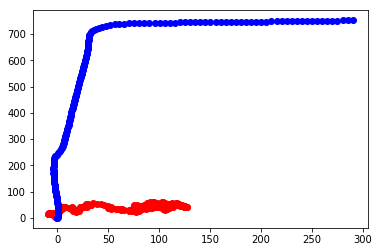

Count:1026
()
()
Relative Depth: -56.52982124435234
Relative x: 118.21448714969377
Relative Original Depth: -752.5315586968677
Relative Original x: 290.89076897898764
Count:1027
()
()
Relative Depth: -56.6876070853588
Relative x: 118.49358155872972
Relative Original Depth: -752.5668300052756
Relative Original x: 291.88835059978715
Count:1028
()
()
Relative Depth: -56.64018237778649
Relative x: 119.08217373921894
Relative Original Depth: -752.6139719844375
Relative Original x: 292.88594582907575
Count:1029
()
()
Relative Depth: -56.16945890022531
Relative x: 119.78269299023214
Relative Original Depth: -752.649958923572
Relative Original x: 293.88427011320744
Count:1030
()
()
Relative Depth: -55.40839078314438
Relative x: 120.38862730639477
Relative Original Depth: -752.6832995284673
Relative Original x: 294.88219693660096


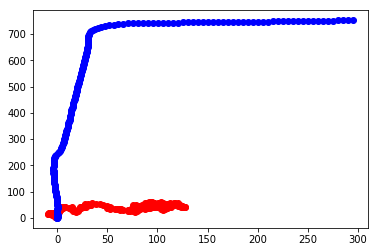

Count:1031
()
()
Relative Depth: -54.63917099739313
Relative x: 120.96771933173099
Relative Original Depth: -752.7294544569091
Relative Original x: 295.88020622795017
Count:1032
()
()
Relative Depth: -53.9628652186239
Relative x: 121.45640937876037
Relative Original Depth: -752.7990063616787
Relative Original x: 296.8770361898215
Count:1033
()
()
Relative Depth: -53.123727718070185
Relative x: 121.9908977654763
Relative Original Depth: -752.8736725207268
Relative Original x: 297.8735136179593
Count:1034
()
()
Relative Depth: -52.52585044476411
Relative x: 122.31743166075182
Relative Original Depth: -752.9256931630716
Relative Original x: 298.86907810239524
Count:1035
()
()
Relative Depth: -51.948929066256696
Relative x: 122.59080285039883
Relative Original Depth: -752.9560045618615
Relative Original x: 299.8655684583257


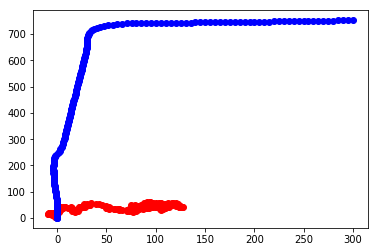

Count:1036
()
()
Relative Depth: -51.398685011858156
Relative x: 122.79971954880264
Relative Original Depth: -753.0077315471766
Relative Original x: 300.86348003245786
Count:1037
()
()
Relative Depth: -50.75599922495005
Relative x: 123.01137797878029
Relative Original Depth: -753.0583504237698
Relative Original x: 301.8621049619766
Count:1038
()
()
Relative Depth: -49.98500152123668
Relative x: 123.1970409264692
Relative Original Depth: -753.1262229284193
Relative Original x: 302.85970050456496
Count:1039
()
()
Relative Depth: -49.298173823452885
Relative x: 123.3793204449003
Relative Original Depth: -753.2082783647243
Relative Original x: 303.8555756297105
Count:1040
()
()
Relative Depth: -48.72057162007378
Relative x: 123.59101888349575
Relative Original Depth: -753.2300913972363
Relative Original x: 304.8538681779057


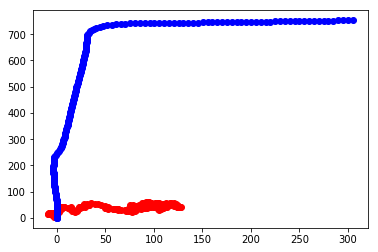

Count:1041
()
()
Relative Depth: -48.73127746321846
Relative x: 123.31840656894258
Relative Original Depth: -753.2821666353454
Relative Original x: 305.85036497358425
Count:1042
()
()
Relative Depth: -48.107502535694316
Relative x: 123.54978565159554
Relative Original Depth: -753.3444566293543
Relative Original x: 306.84749924143375
Count:1043
()
()
Relative Depth: -48.024446437748146
Relative x: 123.41858474216735
Relative Original Depth: -753.3949866557498
Relative Original x: 307.84473403822466
Count:1044
()
()
Relative Depth: -48.39513049106097
Relative x: 122.81425619132318
Relative Original Depth: -753.4040503410181
Relative Original x: 308.8410238538801
Count:1045
()
()
Relative Depth: -48.74521401817331
Relative x: 122.12671794946483
Relative Original Depth: -753.4528652736341
Relative Original x: 309.8377411895462


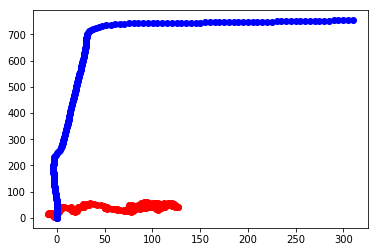

Count:1046
()
()
Relative Depth: -49.21867216199839
Relative x: 121.48738808306402
Relative Original Depth: -753.4990363517601
Relative Original x: 310.83567301253464
Count:1047
()
()
Relative Depth: -49.73984369446677
Relative x: 120.82506774933833
Relative Original Depth: -753.5698246807816
Relative Original x: 311.8326169707608
Count:1048
()
()
Relative Depth: -50.33562287633219
Relative x: 120.1823511964296
Relative Original Depth: -753.6304880122213
Relative Original x: 312.83027107424346
Count:1049
()
()
Relative Depth: -51.01316787908107
Relative x: 119.5373161644199
Relative Original Depth: -753.6576935806286
Relative Original x: 313.82936555752985
Count:1050
()
()
Relative Depth: -51.65922173071693
Relative x: 118.84927281728379
Relative Original Depth: -753.7170529549163
Relative Original x: 314.8273192132143


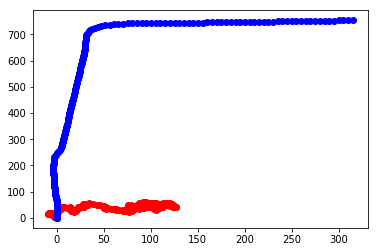

Count:1051
()
()
Relative Depth: -52.24128432920522
Relative x: 118.1440979683112
Relative Original Depth: -753.742342902161
Relative Original x: 315.82633821283576
Count:1052
()
()
Relative Depth: -52.66317743097577
Relative x: 117.46107810917383
Relative Original Depth: -753.7694369716952
Relative Original x: 316.8248396352257
Count:1053
()
()
Relative Depth: -52.92641877070996
Relative x: 116.75046287119007
Relative Original Depth: -753.8018580593547
Relative Original x: 317.8229237479407
Count:1054
()
()
Relative Depth: -53.12875984156277
Relative x: 116.03265007787043
Relative Original Depth: -753.8718725366579
Relative Original x: 318.81987244811563
Count:1055
()
()
Relative Depth: -53.85301397101019
Relative x: 115.72033712706023
Relative Original Depth: -753.897526516461
Relative Original x: 319.8175177637186


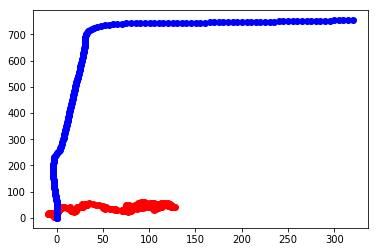

Count:1056
()
()
Relative Depth: -53.8675979942633
Relative x: 115.02193742387439
Relative Original Depth: -753.9457101647811
Relative Original x: 320.81472493499757
Count:1057
()
()
Relative Depth: -53.66163626216436
Relative x: 114.32973214415256
Relative Original Depth: -754.0192245526393
Relative Original x: 321.8104309003952
Count:1058
()
()
Relative Depth: -53.55518932098647
Relative x: 113.54109043921426
Relative Original Depth: -754.0975171904986
Relative Original x: 322.8062819465176
Count:1059
()
()
Relative Depth: -53.323942029582234
Relative x: 112.87278733885276
Relative Original Depth: -754.1462441921774
Relative Original x: 323.8036104934831
Count:1060
()
()
Relative Depth: -52.88248893589212
Relative x: 112.56040773833881
Relative Original Depth: -754.1904690601701
Relative Original x: 324.8007501264008


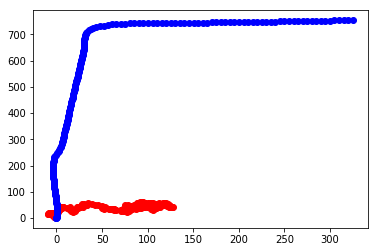

Count:1061
()
()
Relative Depth: -52.32861780225172
Relative x: 112.64290070665564
Relative Original Depth: -754.2465460576135
Relative Original x: 325.79762983491975
Count:1062
()
()
Relative Depth: -51.7354051903489
Relative x: 113.03334277205231
Relative Original Depth: -754.3026828516283
Relative Original x: 326.7947000704801
Count:1063
()
()
Relative Depth: -51.11846351231238
Relative x: 113.47748138686318
Relative Original Depth: -754.3707941465534
Relative Original x: 327.79074870998073
Count:1064
()
()
Relative Depth: -50.55854600872384
Relative x: 114.00621644698634
Relative Original Depth: -754.4046328457841
Relative Original x: 328.7882755649667
Count:1065
()
()
Relative Depth: -50.01456365397715
Relative x: 114.36321603358792
Relative Original Depth: -754.4533161102586
Relative Original x: 329.78546608443156


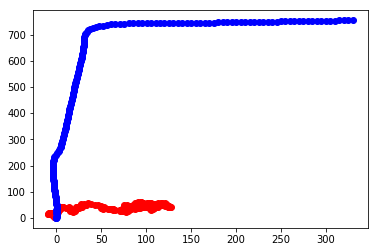

Count:1066
()
()
Relative Depth: -50.983478219611456
Relative x: 114.12067780075844
Relative Original Depth: -754.5031003640544
Relative Original x: 330.782209328657
Count:1067
()
()
Relative Depth: -50.39653880446357
Relative x: 114.44067544964572
Relative Original Depth: -754.608292580659
Relative Original x: 331.77598885147876
Count:1068
()
()
Relative Depth: -49.903208358957166
Relative x: 114.54397645193959
Relative Original Depth: -754.6378297627432
Relative Original x: 332.7741589264454
Count:1069
()
()
Relative Depth: -49.588531269922704
Relative x: 114.34809931266075
Relative Original Depth: -754.7054333988328
Relative Original x: 333.77076126633403
Count:1070
()
()
Relative Depth: -49.31941720703968
Relative x: 114.04370246151852
Relative Original Depth: -754.7528415576385
Relative Original x: 334.768772624555


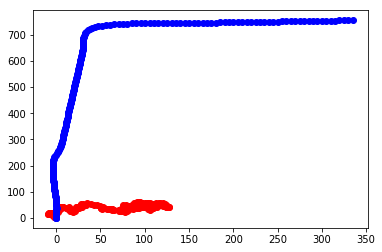

Count:1071
()
()
Relative Depth: -49.11948848005746
Relative x: 113.60289320187232
Relative Original Depth: -754.8625369293188
Relative Original x: 335.7618313123637
Count:1072
()
()
Relative Depth: -48.91596965788513
Relative x: 113.16451426078825
Relative Original Depth: -754.9293525607701
Relative Original x: 336.7583387160614
Count:1073
()
()
Relative Depth: -48.70178655147885
Relative x: 112.765377665595
Relative Original Depth: -754.9593306546203
Relative Original x: 337.756466647723
Count:1074
()
()
Relative Depth: -48.51882676636629
Relative x: 112.45833756901015
Relative Original Depth: -755.0117974901848
Relative Original x: 338.7543073813641
Count:1075
()
()
Relative Depth: -48.36873098511695
Relative x: 112.21814374549977
Relative Original Depth: -755.1200473187911
Relative Original x: 339.7483661739579


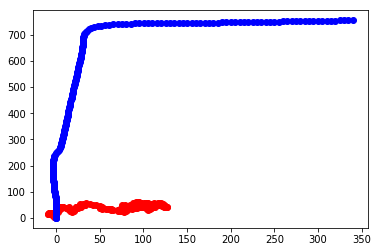

Count:1076
()
()
Relative Depth: -48.4237949733616
Relative x: 111.72432674782098
Relative Original Depth: -755.1751284261748
Relative Original x: 340.7461512173154
Count:1077
()
()
Relative Depth: -48.4831789994315
Relative x: 111.12538015998267
Relative Original Depth: -755.220775732415
Relative Original x: 341.7432701690816
Count:1078
()
()
Relative Depth: -48.50665836020194
Relative x: 110.50302108417148
Relative Original Depth: -755.2417969075689
Relative Original x: 342.7402649630458
Count:1079
()
()
Relative Depth: -48.59636276523868
Relative x: 109.87490270655572
Relative Original Depth: -755.2663716579181
Relative Original x: 343.73964578741897
Count:1080
()
()
Relative Depth: -48.79008727623828
Relative x: 109.18616916402179
Relative Original Depth: -755.3110952401247
Relative Original x: 344.73795150899986


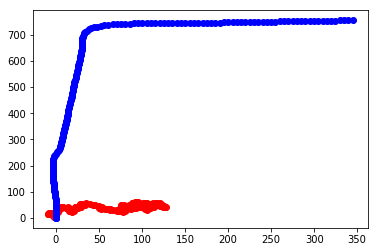

Count:1081
()
()
Relative Depth: -48.83299000648747
Relative x: 108.35773341997901
Relative Original Depth: -755.3738781976103
Relative Original x: 345.7349259536798
Count:1082
()
()
Relative Depth: -48.649944297884
Relative x: 107.42494808276662
Relative Original Depth: -755.4767132100867
Relative Original x: 346.7261715564949
Count:1083
()
()
Relative Depth: -48.67640477144417
Relative x: 106.45648703187344
Relative Original Depth: -755.6357835789903
Relative Original x: 347.7131478751232
Count:1084
()
()
Relative Depth: -48.814824598134734
Relative x: 105.57013250547796
Relative Original Depth: -755.6719443467362
Relative Original x: 348.7105655353609
Count:1085
()
()
Relative Depth: -48.34265595555879
Relative x: 104.78776786908513
Relative Original Depth: -755.7281246738725
Relative Original x: 349.70771020136846


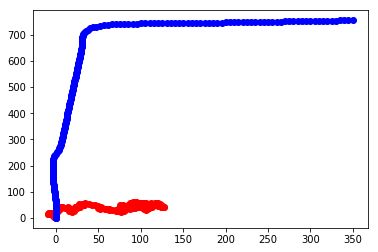

Count:1086
()
()
Relative Depth: -47.770844019826725
Relative x: 104.07031561432798
Relative Original Depth: -755.7883256741326
Relative Original x: 350.7049475148855
Count:1087
()
()
Relative Depth: -47.91975571081506
Relative x: 103.14849330011621
Relative Original Depth: -755.8225887042227
Relative Original x: 351.7033993966038
Count:1088
()
()
Relative Depth: -48.14491659443375
Relative x: 102.24007663326324
Relative Original Depth: -755.8471811828937
Relative Original x: 352.7017385602275
Count:1089
()
()
Relative Depth: -48.39084281262788
Relative x: 101.3234370444807
Relative Original Depth: -755.9271894038573
Relative Original x: 353.6975915774589
Count:1090
()
()
Relative Depth: -48.65852096972725
Relative x: 100.40059425255014
Relative Original Depth: -755.9788478597403
Relative Original x: 354.6961405844054


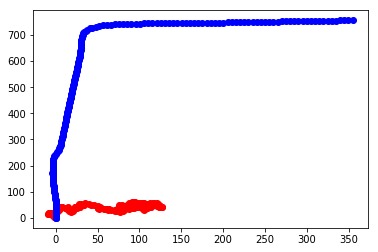

Count:1091
()
()
Relative Depth: -48.94046193978964
Relative x: 99.53191951113543
Relative Original Depth: -756.0028069075669
Relative Original x: 355.6925850211552
Count:1092
()
()
Relative Depth: -48.83926794563175
Relative x: 98.54685830276428
Relative Original Depth: -756.0614068843339
Relative Original x: 356.6888590490472
Count:1093
()
()
Relative Depth: -48.689159030956645
Relative x: 99.51629401767734
Relative Original Depth: -756.1385574239761
Relative Original x: 357.6852194431552
Count:1094
()
()
Relative Depth: -49.02542773450653
Relative x: 99.060433939536
Relative Original Depth: -756.1843207814529
Relative Original x: 358.6839820687927
Count:1095
()
()
Relative Depth: -49.83630613167368
Relative x: 99.05208248793058
Relative Original Depth: -756.2842026500049
Relative Original x: 359.6786727600741


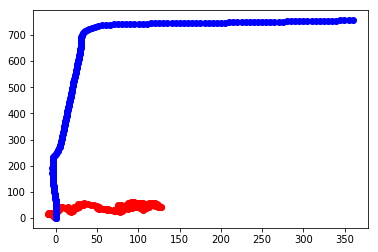

Count:1096
()
()
Relative Depth: -50.29245773569821
Relative x: 98.8712156741403
Relative Original Depth: -756.401556168456
Relative Original x: 360.6702463907016
Count:1097
()
()
Relative Depth: -50.78196245504277
Relative x: 98.6308571181055
Relative Original Depth: -756.5514181385821
Relative Original x: 361.65789650804425
Count:1098
()
()
Relative Depth: -51.387122581207386
Relative x: 98.54016910017026
Relative Original Depth: -756.6694055297894
Relative Original x: 362.648292856821
Count:1099
()
()
Relative Depth: -52.02439173030115
Relative x: 98.5872431630407
Relative Original Depth: -756.7195808221799
Relative Original x: 363.64117239194667
Count:1100
()
()
Relative Depth: -52.295710732496524
Relative x: 99.10962593025047
Relative Original Depth: -756.7829277137349
Relative Original x: 364.6370465335465


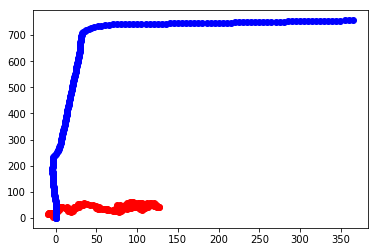

Count:1101
()
()
Relative Depth: -52.051088110443054
Relative x: 99.56515928852475
Relative Original Depth: -756.8715752640088
Relative Original x: 365.62761840098165
Count:1102
()
()
Relative Depth: -51.97640362163104
Relative x: 99.3717801300882
Relative Original Depth: -756.9823797396926
Relative Original x: 366.6195324276291
Count:1103
()
()
Relative Depth: -51.84584447169793
Relative x: 99.52202067497656
Relative Original Depth: -757.0256879453259
Relative Original x: 367.6171141009241
Count:1104
()
()
Relative Depth: -51.26961077667527
Relative x: 100.19656055118453
Relative Original Depth: -757.0521200229028
Relative Original x: 368.6150293928952
Count:1105
()
()
Relative Depth: -50.55754348781058
Relative x: 100.889801364184
Relative Original Depth: -757.1003818429238
Relative Original x: 369.61360592084606


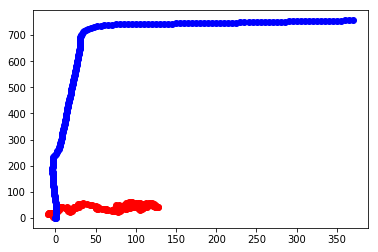

Count:1106
()
()
Relative Depth: -49.87132733120329
Relative x: 101.06732160797623
Relative Original Depth: -757.1542567088478
Relative Original x: 370.6118516106823
Count:1107
()
()
Relative Depth: -49.92822228395008
Relative x: 100.56505554118053
Relative Original Depth: -757.2156132132885
Relative Original x: 371.6098973964639
Count:1108
()
()
Relative Depth: -49.254855914856186
Relative x: 101.26349723208224
Relative Original Depth: -757.2647341283813
Relative Original x: 372.6078977547612
Count:1109
()
()
Relative Depth: -48.6775664188845
Relative x: 102.00653655022747
Relative Original Depth: -757.321935394454
Relative Original x: 373.606080313257
Count:1110
()
()
Relative Depth: -48.388436832103
Relative x: 102.56908989988524
Relative Original Depth: -757.4399984850236
Relative Original x: 374.59648452331044


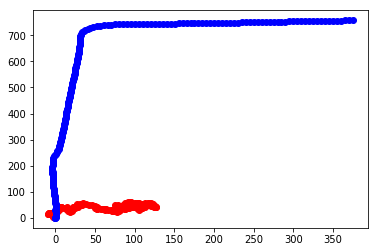

Count:1111
()
()
Relative Depth: -48.33942151984833
Relative x: 103.10869779912518
Relative Original Depth: -757.5059089660139
Relative Original x: 375.5933254761219
Count:1112
()
()
Relative Depth: -48.44276832230534
Relative x: 103.89108743147591
Relative Original Depth: -757.699191918196
Relative Original x: 376.57181984193085
Count:1113
()
()
Relative Depth: -48.336051411038426
Relative x: 104.54461174661198
Relative Original Depth: -757.6840363497339
Relative Original x: 377.5696281612955
Count:1114
()
()
Relative Depth: -47.804866111121065
Relative x: 105.12839442006427
Relative Original Depth: -757.7812085311624
Relative Original x: 378.564189169295
Count:1115
()
()
Relative Depth: -46.861892998157245
Relative x: 105.26308643592817
Relative Original Depth: -757.8104019991217
Relative Original x: 379.56232086067433


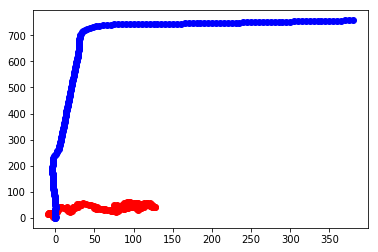

Count:1116
()
()
Relative Depth: -45.995346304641366
Relative x: 104.76737569767316
Relative Original Depth: -757.8268787423249
Relative Original x: 380.5605740677243
Count:1117
()
()
Relative Depth: -45.16418595278421
Relative x: 104.23234812625161
Relative Original Depth: -757.8728625390302
Relative Original x: 381.557974047036
Count:1118
()
()
Relative Depth: -44.42203122737578
Relative x: 103.6434468829914
Relative Original Depth: -757.9204515764721
Relative Original x: 382.5563135493782
Count:1119
()
()
Relative Depth: -44.73745327923945
Relative x: 103.1339802175563
Relative Original Depth: -757.9561807842556
Relative Original x: 383.5548231774294
Count:1120
()
()
Relative Depth: -44.047566862379185
Relative x: 102.55942005762263
Relative Original Depth: -758.0437993652712
Relative Original x: 384.55009222358314


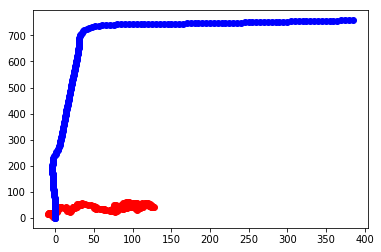

Count:1121
()
()
Relative Depth: -43.30683982197338
Relative x: 102.06030110414082
Relative Original Depth: -758.1434653579292
Relative Original x: 385.5442675395279
Count:1122
()
()
Relative Depth: -42.50480874565329
Relative x: 101.5915437823985
Relative Original Depth: -758.1742498236847
Relative Original x: 386.5429834251516
Count:1123
()
()
Relative Depth: -41.671687208151745
Relative x: 101.0882667514475
Relative Original Depth: -758.2483842376727
Relative Original x: 387.5400334420083
Count:1124
()
()
Relative Depth: -40.828699122476955
Relative x: 100.5785795088784
Relative Original Depth: -758.3565029511583
Relative Original x: 388.53292731553756
Count:1125
()
()
Relative Depth: -39.94162673841017
Relative x: 100.12923203639221
Relative Original Depth: -758.4208859337408
Relative Original x: 389.52894326946074


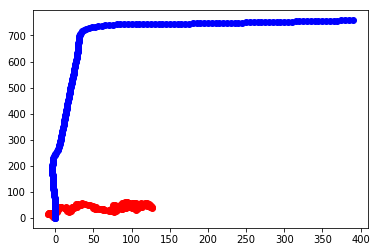

Count:1126
()
()
Relative Depth: -39.05739893321962
Relative x: 99.66658515549138
Relative Original Depth: -758.4879006806754
Relative Original x: 390.5237003164476
Count:1127
()
()
Relative Depth: -38.21032594965153
Relative x: 99.13543800997803
Relative Original Depth: -758.7141882564811
Relative Original x: 391.49602173176703
Count:1128
()
()
Relative Depth: -37.37046430031413
Relative x: 98.64253441171398
Relative Original Depth: -758.7313193149724
Relative Original x: 392.49428292778015
Count:1129
()
()
Relative Depth: -36.59085038825714
Relative x: 98.2227761622668
Relative Original Depth: -758.7573416686033
Relative Original x: 393.4925350562183
Count:1130
()
()
Relative Depth: -35.853127906214645
Relative x: 97.82150136235302
Relative Original Depth: -758.8176651565768
Relative Original x: 394.48857916850466


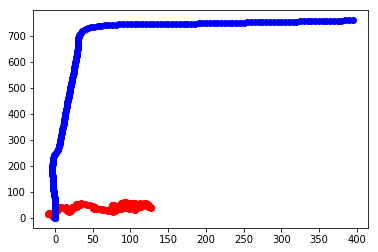

Count:1131
()
()
Relative Depth: -35.15654128608373
Relative x: 97.42058405443264
Relative Original Depth: -758.9165898991109
Relative Original x: 395.48366693960827
Count:1132
()
()
Relative Depth: -34.41308957520806
Relative x: 97.03962348177923
Relative Original Depth: -758.9482097644315
Relative Original x: 396.4828040760314
Count:1133
()
()
Relative Depth: -33.57725621906858
Relative x: 96.59529889422835
Relative Original Depth: -759.0038037284182
Relative Original x: 397.48108256451434
Count:1134
()
()
Relative Depth: -32.72771549103224
Relative x: 96.10142974915617
Relative Original Depth: -759.0521595751338
Relative Original x: 398.47786254742863
Count:1135
()
()
Relative Depth: -31.87446617332526
Relative x: 95.62601023330585
Relative Original Depth: -759.084256277811
Relative Original x: 399.475248509668


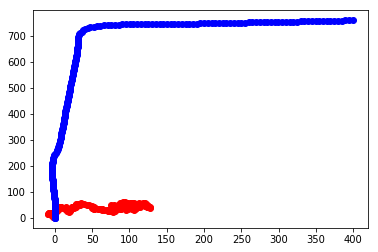

Count:1136
()
()
Relative Depth: -30.994552371776177
Relative x: 95.1746079030205
Relative Original Depth: -759.1491181551226
Relative Original x: 400.469846555556
Count:1137
()
()
Relative Depth: -30.07480219942955
Relative x: 94.7924552961734
Relative Original Depth: -759.22343349523
Relative Original x: 401.46482876107785
Count:1138
()
()
Relative Depth: -29.126283607598232
Relative x: 94.4804078183881
Relative Original Depth: -759.3300361388965
Relative Original x: 402.4577122567125
Count:1139
()
()
Relative Depth: -28.238509423364174
Relative x: 94.23758092965929
Relative Original Depth: -759.4874404687864
Relative Original x: 403.4421706684549
Count:1140
()
()
Relative Depth: -27.54621744031546
Relative x: 94.12887248978
Relative Original Depth: -759.574346901823
Relative Original x: 404.43458843936486


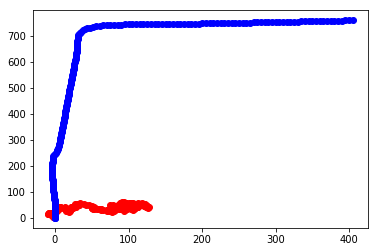

Count:1141
()
()
Relative Depth: -27.04618796270882
Relative x: 94.14767112390372
Relative Original Depth: -759.6490734164997
Relative Original x: 405.42885647852097
Count:1142
()
()
Relative Depth: -26.423756897557336
Relative x: 94.1886425547064
Relative Original Depth: -759.7441823317392
Relative Original x: 406.4226336279381
Count:1143
()
()
Relative Depth: -25.6806378758893
Relative x: 94.06499031168268
Relative Original Depth: -759.7396406000428
Relative Original x: 407.42261121449593
Count:1144
()
()
Relative Depth: -25.67380911289863
Relative x: 94.91696830970571
Relative Original Depth: -759.7697951669346
Relative Original x: 408.41934243639145
Count:1145
()
()
Relative Depth: -24.87733913451104
Relative x: 94.62812955724672
Relative Original Depth: -759.8428790871673
Relative Original x: 409.4159840024299


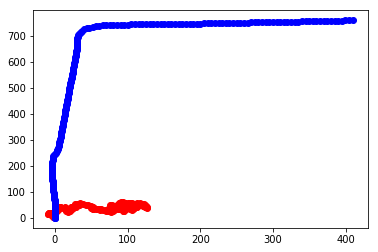

Count:1146
()
()
Relative Depth: -23.981245520834502
Relative x: 94.3449712486714
Relative Original Depth: -759.9111301634857
Relative Original x: 410.4128581351994
Count:1147
()
()
Relative Depth: -23.50529156684125
Relative x: 94.21820178906725
Relative Original Depth: -759.9721611800286
Relative Original x: 411.40977084449764
Count:1148
()
()
Relative Depth: -23.580366749428748
Relative x: 94.27801556528321
Relative Original Depth: -760.0489682130117
Relative Original x: 412.4048938482374
Count:1149
()
()
Relative Depth: -23.679462372237385
Relative x: 94.31333222886668
Relative Original Depth: -760.1641927301889
Relative Original x: 413.3981710410989
Count:1150
()
()
Relative Depth: -24.022007738374704
Relative x: 94.12238939397288
Relative Original Depth: -760.2322639044104
Relative Original x: 414.39554509102254


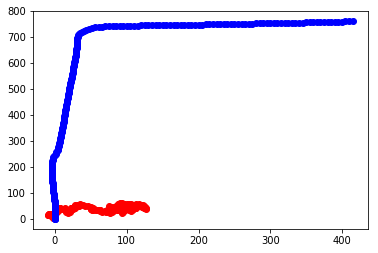

Count:1151
()
()
Relative Depth: -24.75005597047333
Relative x: 93.87392699102838
Relative Original Depth: -760.2759567210263
Relative Original x: 415.3941846529794
Count:1152
()
()
Relative Depth: -25.425575196804314
Relative x: 93.63427257071059
Relative Original Depth: -760.3610528321307
Relative Original x: 416.3904357412538
Count:1153
()
()
Relative Depth: -25.770809094722743
Relative x: 93.26705226818127
Relative Original Depth: -760.4480378384902
Relative Original x: 417.3858244374171
Count:1154
()
()
Relative Depth: -25.71756274142731
Relative x: 92.82934445840169
Relative Original Depth: -760.5587655489637
Relative Original x: 418.37806792446185
Count:1155
()
()
Relative Depth: -25.45197219479779
Relative x: 92.37336672822217
Relative Original Depth: -760.6404562854461
Relative Original x: 419.37398548501704


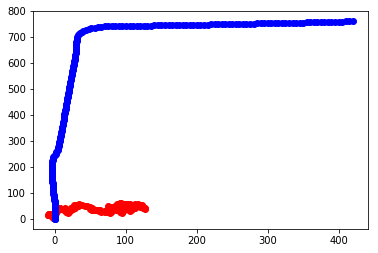

Count:1156
()
()
Relative Depth: -25.079345883680887
Relative x: 92.02489308540083
Relative Original Depth: -760.716305746741
Relative Original x: 420.37045152547023
Count:1157
()
()
Relative Depth: -24.665461912866178
Relative x: 91.77135281088147
Relative Original Depth: -760.7610492059467
Relative Original x: 421.36843340305137
Count:1158
()
()
Relative Depth: -24.288332535525818
Relative x: 91.56458566760118
Relative Original Depth: -760.8140758123225
Relative Original x: 422.36598972515264
Count:1159
()
()
Relative Depth: -23.927169923913254
Relative x: 91.44979754984347
Relative Original Depth: -760.8637150067455
Relative Original x: 423.36437100559897
Count:1160
()
()
Relative Depth: -23.124476363797207
Relative x: 91.46910461137172
Relative Original Depth: -760.9167851952665
Relative Original x: 424.362163284704


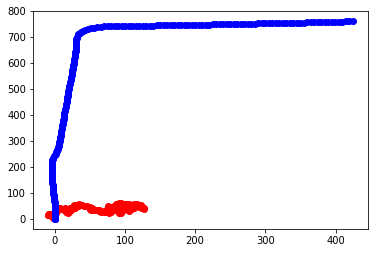

Count:1161
()
()
Relative Depth: -22.185696340974374
Relative x: 91.81061411188752
Relative Original Depth: -760.9899544266412
Relative Original x: 425.3591246127125
Count:1162
()
()
Relative Depth: -21.540019204714945
Relative x: 92.30071340006079
Relative Original Depth: -761.0516393047045
Relative Original x: 426.3571918313029
Count:1163
()
()
Relative Depth: -21.27588859440354
Relative x: 92.53267114450186
Relative Original Depth: -761.139471571873
Relative Original x: 427.35317156841234
Count:1164
()
()
Relative Depth: -21.15486427407597
Relative x: 92.58139811958232
Relative Original Depth: -761.2290261823556
Relative Original x: 428.34901960430784
Count:1165
()
()
Relative Depth: -20.888950923005947
Relative x: 92.26918853872469
Relative Original Depth: -761.2700129373427
Relative Original x: 429.34815003270734


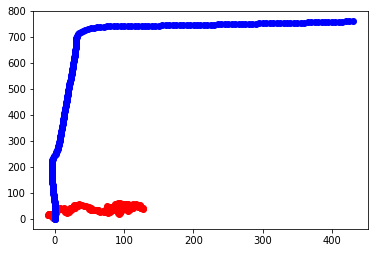

Count:1166
()
()
Relative Depth: -20.375158986360347
Relative x: 91.81254016972662
Relative Original Depth: -761.3042386807108
Relative Original x: 430.34725284608214
Count:1167
()
()
Relative Depth: -20.421982105530773
Relative x: 90.95927842858146
Relative Original Depth: -761.3477328102542
Relative Original x: 431.34628092565157
Count:1168
()
()
Relative Depth: -21.026629431767322
Relative x: 90.165420636263
Relative Original Depth: -761.3556455942224
Relative Original x: 432.34606722785384
Count:1169
()
()
Relative Depth: -20.06869979485592
Relative x: 90.43686410414331
Relative Original Depth: -761.3726400956552
Relative Original x: 433.3456528026053
Count:1170
()
()
Relative Depth: -20.739384622698335
Relative x: 89.70954207303133
Relative Original Depth: -761.4043853483129
Relative Original x: 434.34353852106824


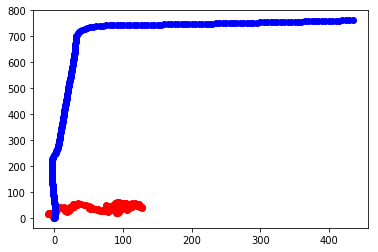

Count:1171
()
()
Relative Depth: -21.440730403921453
Relative x: 89.07376700403356
Relative Original Depth: -761.4524697035059
Relative Original x: 435.3420445796484
Count:1172
()
()
Relative Depth: -22.133916660680082
Relative x: 88.44292273161061
Relative Original Depth: -761.5165461285503
Relative Original x: 436.3397203561457
Count:1173
()
()
Relative Depth: -22.376129081119874
Relative x: 87.479947911135
Relative Original Depth: -761.5909015950749
Relative Original x: 437.33673312827943
Count:1174
()
()
Relative Depth: -22.307040993208762
Relative x: 86.52480924552545
Relative Original Depth: -761.6617364350732
Relative Original x: 438.3341720975406
Count:1175
()
()
Relative Depth: -22.513310479921145
Relative x: 85.54638567637492
Relative Original Depth: -761.6993404948188
Relative Original x: 439.33288331262605


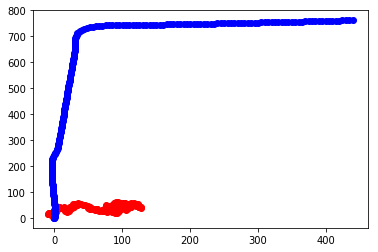

Count:1176
()
()
Relative Depth: -22.787174013999362
Relative x: 84.58462286320793
Relative Original Depth: -761.7352220003297
Relative Original x: 440.3321494170869
Count:1177
()
()
Relative Depth: -23.124976118764398
Relative x: 83.6458756523208
Relative Original Depth: -761.7874073814316
Relative Original x: 441.33053193292824
Count:1178
()
()
Relative Depth: -22.900422583059846
Relative x: 83.1094116334283
Relative Original Depth: -761.8411506470023
Relative Original x: 442.32851579450966
Count:1179
()
()
Relative Depth: -23.17542214078345
Relative x: 82.14811697152675
Relative Original Depth: -761.9028130780194
Relative Original x: 443.32642326157355
Count:1180
()
()
Relative Depth: -23.469775509219843
Relative x: 81.19318941449157
Relative Original Depth: -761.9357552242396
Relative Original x: 444.32468910560056


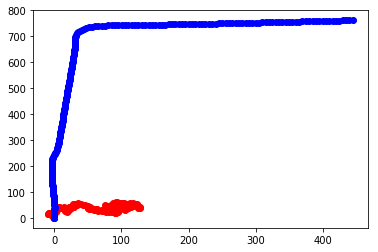

Count:1181
()
()
Relative Depth: -23.87391373100842
Relative x: 80.28386027527833
Relative Original Depth: -761.9873790999882
Relative Original x: 445.3227133400208
Count:1182
()
()
Relative Depth: -24.32250065191764
Relative x: 79.39707265008283
Relative Original Depth: -761.9973062561131
Relative Original x: 446.3213519556465
Count:1183
()
()
Relative Depth: -24.86103495412061
Relative x: 78.5555088663863
Relative Original Depth: -762.0748283773769
Relative Original x: 447.3175211527003
Count:1184
()
()
Relative Depth: -25.539198560690767
Relative x: 77.8230370537451
Relative Original Depth: -762.1331357520066
Relative Original x: 448.31561406446224
Count:1185
()
()
Relative Depth: -26.28941521716501
Relative x: 77.1635073341802
Relative Original Depth: -762.2026384136818
Relative Original x: 449.3130910171258


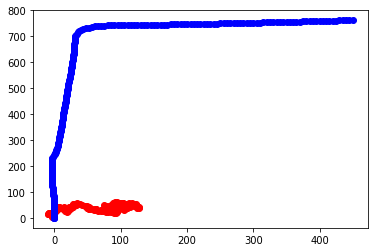

Count:1186
()
()
Relative Depth: -26.936420534037598
Relative x: 76.40486075610167
Relative Original Depth: -762.2639425881375
Relative Original x: 450.3109350406673
Count:1187
()
()
Relative Depth: -27.537426829936496
Relative x: 77.13511069334479
Relative Original Depth: -762.3328429140546
Relative Original x: 451.3082361061547
Count:1188
()
()
Relative Depth: -28.01772947289186
Relative x: 76.25839344494268
Relative Original Depth: -762.3490654825603
Relative Original x: 452.3060356893203
Count:1189
()
()
Relative Depth: -28.45447206554583
Relative x: 75.36099586110478
Relative Original Depth: -762.4222697152737
Relative Original x: 453.30271707493375
Count:1190
()
()
Relative Depth: -28.830068202769578
Relative x: 74.60526692513253
Relative Original Depth: -762.4795157456795
Relative Original x: 454.30063666319484


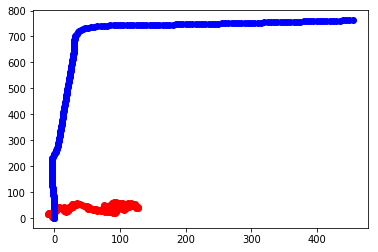

Count:1191
()
()
Relative Depth: -28.421297069729064
Relative x: 73.70916564032946
Relative Original Depth: -762.5033354089652
Relative Original x: 455.30001794830804
Count:1192
()
()
Relative Depth: -28.576826105624082
Relative x: 73.2473169424891
Relative Original Depth: -762.5325501684705
Relative Original x: 456.29859129149224
Count:1193
()
()
Relative Depth: -28.625586952110947
Relative x: 72.83508561681214
Relative Original Depth: -762.5717081264474
Relative Original x: 457.2970219814399
Count:1194
()
()
Relative Depth: -28.79253719869733
Relative x: 72.41381732472601
Relative Original Depth: -762.6439359878487
Relative Original x: 458.2942777664937
Count:1195
()
()
Relative Depth: -29.037240882708613
Relative x: 71.96970139537511
Relative Original Depth: -762.6776501566906
Relative Original x: 459.2935234546971


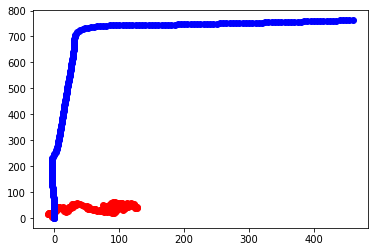

Count:1196
()
()
Relative Depth: -28.914541758003732
Relative x: 71.76321396638153
Relative Original Depth: -762.7752896319579
Relative Original x: 460.2887320014938
Count:1197
()
()
Relative Depth: -28.449564059686946
Relative x: 71.95006679362966
Relative Original Depth: -762.8595654679132
Relative Original x: 461.28492734647216
Count:1198
()
()
Relative Depth: -27.66496776168244
Relative x: 72.00531037810802
Relative Original Depth: -762.8969574357071
Relative Original x: 462.2832760690534
Count:1199
()
()
Relative Depth: -26.70762441973761
Relative x: 71.90131392053597
Relative Original Depth: -762.9843373811557
Relative Original x: 463.2788984652888
Count:1200
()
()
Relative Depth: -25.742070934378226
Relative x: 71.96341794857531
Relative Original Depth: -763.0320630167959
Relative Original x: 464.2762678757263


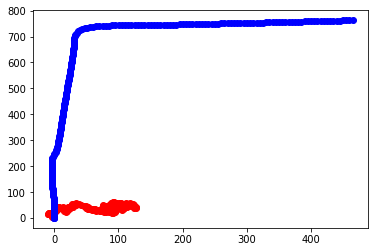

Count:1201
()
()
Relative Depth: -24.771804007439247
Relative x: 72.1255627750344
Relative Original Depth: -763.0988508906657
Relative Original x: 465.2734273127212
Count:1202
()
()
Relative Depth: -23.9454226854517
Relative x: 72.52806570380334
Relative Original Depth: -763.1642938953175
Relative Original x: 466.27120533555217
Count:1203
()
()
Relative Depth: -23.117122810699676
Relative x: 72.97131104883474
Relative Original Depth: -763.2408705640465
Relative Original x: 467.26785550008486
Count:1204
()
()
Relative Depth: -22.19721512980863
Relative x: 73.24610929628527
Relative Original Depth: -763.3272766298087
Relative Original x: 468.2639091187637
Count:1205
()
()
Relative Depth: -21.39375117619822
Relative x: 73.62463501536037
Relative Original Depth: -763.372046135064
Relative Original x: 469.2623789285146


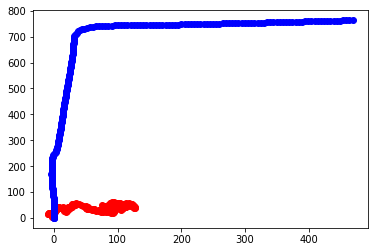

Count:1206
()
()
Relative Depth: -20.682126329507053
Relative x: 74.16584202939634
Relative Original Depth: -763.3698516708051
Relative Original x: 470.2591904443474
Count:1207
()
()
Relative Depth: -20.131913838276862
Relative x: 74.76603105425094
Relative Original Depth: -763.4684699943232
Relative Original x: 471.2542153799264
Count:1208
()
()
Relative Depth: -19.641577760224823
Relative x: 75.32812843336805
Relative Original Depth: -763.5215848588549
Relative Original x: 472.251993802244
Count:1209
()
()
Relative Depth: -18.947882421547387
Relative x: 75.78709537056758
Relative Original Depth: -763.5714844191311
Relative Original x: 473.250127163571
Count:1210
()
()
Relative Depth: -18.026363373070907
Relative x: 75.92690148532157
Relative Original Depth: -763.6010701960777
Relative Original x: 474.2495307330317


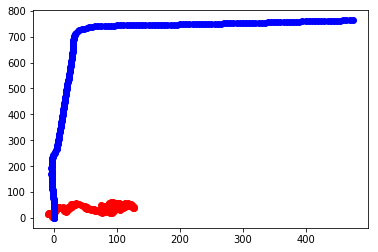

Count:1211
()
()
Relative Depth: -17.05298693325497
Relative x: 75.82604896267883
Relative Original Depth: -763.6368591598025
Relative Original x: 475.2476414048597
Count:1212
()
()
Relative Depth: -16.082977149114807
Relative x: 75.59505191551085
Relative Original Depth: -763.7028077901017
Relative Original x: 476.24524061214333
Count:1213
()
()
Relative Depth: -15.111121792453106
Relative x: 75.36124010156261
Relative Original Depth: -763.73067836681
Relative Original x: 477.2433981199597
Count:1214
()
()
Relative Depth: -14.129079698574431
Relative x: 75.17356015298127
Relative Original Depth: -763.8116234116866
Relative Original x: 478.23850111345837
Count:1215
()
()
Relative Depth: -13.172430210569562
Relative x: 74.88445679331623
Relative Original Depth: -763.864420287179
Relative Original x: 479.23621084411667


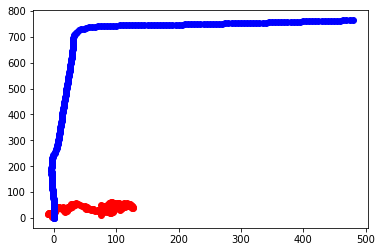

Count:1216
()
()
Relative Depth: -12.250047526517937
Relative x: 74.5111160643062
Relative Original Depth: -763.9123788506762
Relative Original x: 480.2341870456924
Count:1217
()
()
Relative Depth: -11.392902130748983
Relative x: 74.04945788637822
Relative Original Depth: -764.0308299903419
Relative Original x: 481.2260580816748
Count:1218
()
()
Relative Depth: -11.20615720127016
Relative x: 73.9436396700878
Relative Original Depth: -764.0982848797668
Relative Original x: 482.2229231625368
Count:1219
()
()
Relative Depth: -10.400781625087093
Relative x: 73.53451849340993
Relative Original Depth: -764.1583870031611
Relative Original x: 483.22042947215346
Count:1220
()
()
Relative Depth: -9.607453870578183
Relative x: 73.24755149310974
Relative Original Depth: -764.2016849669473
Relative Original x: 484.2180298436725


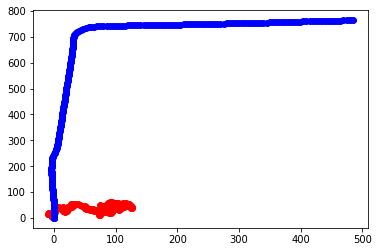

Count:1221
()
()
Relative Depth: -8.887222709725155
Relative x: 72.9652379659537
Relative Original Depth: -764.2494046217179
Relative Original x: 485.21538089725067
Count:1222
()
()
Relative Depth: -8.260818213750195
Relative x: 72.69444770086749
Relative Original Depth: -764.2600999238371
Relative Original x: 486.2149322439062
Count:1223
()
()
Relative Depth: -7.768781388441397
Relative x: 72.08490751809053
Relative Original Depth: -764.2852577759204
Relative Original x: 487.2145089070979
Count:1224
()
()
Relative Depth: -7.582804453704165
Relative x: 71.1681620144399
Relative Original Depth: -764.3213683608507
Relative Original x: 488.2127463537282
Count:1225
()
()
Relative Depth: -7.489509068275046
Relative x: 70.2302774392473
Relative Original Depth: -764.3517706380914
Relative Original x: 489.2115890865549


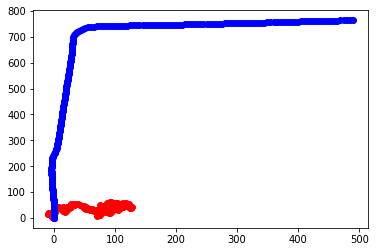

Count:1226
()
()
Relative Depth: -7.475103213682332
Relative x: 69.35335540101372
Relative Original Depth: -764.3947037597846
Relative Original x: 490.2105565532293
Count:1227
()
()
Relative Depth: -7.490913134213905
Relative x: 68.63088788077097
Relative Original Depth: -764.4535852792611
Relative Original x: 491.20857612492813
Count:1228
()
()
Relative Depth: -7.297667271298521
Relative x: 67.90979310657782
Relative Original Depth: -764.520614334582
Relative Original x: 492.2058216963215
Count:1229
()
()
Relative Depth: -7.729745400640466
Relative x: 67.52195826004808
Relative Original Depth: -764.5781125368782
Relative Original x: 493.2023596497419
Count:1230
()
()
Relative Depth: -7.349927996785144
Relative x: 66.76671028598406
Relative Original Depth: -764.6411451166083
Relative Original x: 494.19909021504895


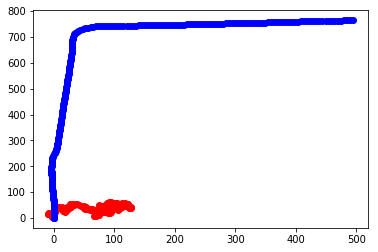

Count:1231
()
()
Relative Depth: -6.9429390426835305
Relative x: 65.99618757956124
Relative Original Depth: -764.7284437107267
Relative Original x: 495.19132852756604
Count:1232
()
()
Relative Depth: -6.513213115090829
Relative x: 65.25964499368642
Relative Original Depth: -764.7942716535963
Relative Original x: 496.1886706505431
Count:1233
()
()
Relative Depth: -6.019942395706984
Relative x: 64.55819395926444
Relative Original Depth: -764.8497055933439
Relative Original x: 497.18713253883726
Count:1234
()
()
Relative Depth: -5.503978750765565
Relative x: 63.77508491615187
Relative Original Depth: -764.904529887644
Relative Original x: 498.1847933520234
Count:1235
()
()
Relative Depth: -5.084077724313138
Relative x: 62.91052554288216
Relative Original Depth: -764.9592424973166
Relative Original x: 499.18284535120904


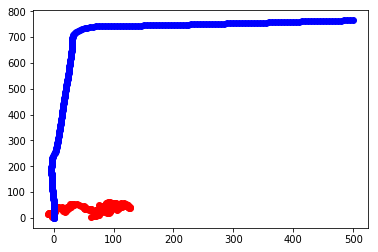

Count:1236
()
()
Relative Depth: -4.8516291280717345
Relative x: 61.94291278861884
Relative Original Depth: -765.0204148007515
Relative Original x: 500.17905276503984
Count:1237
()
()
Relative Depth: -5.040841308093707
Relative x: 60.98343609043135
Relative Original Depth: -765.1224051159687
Relative Original x: 501.17382415085694
Count:1238
()
()
Relative Depth: -4.610429505065695
Relative x: 60.448410049835864
Relative Original Depth: -765.1745733922517
Relative Original x: 502.172103491932
Count:1239
()
()
Relative Depth: -5.0343000230682815
Relative x: 59.62278272622318
Relative Original Depth: -765.2325687119549
Relative Original x: 503.17036463798286
Count:1240
()
()
Relative Depth: -5.324064105102312
Relative x: 58.743542107432326
Relative Original Depth: -765.3069074602537
Relative Original x: 504.16750467698864


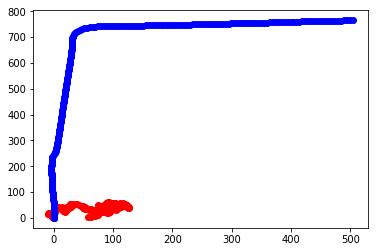

Count:1241
()
()
Relative Depth: -6.050684491910218
Relative x: 59.1313511745066
Relative Original Depth: -765.3692363834009
Relative Original x: 505.1654745802774
Count:1242
()
()
Relative Depth: -5.882238936363041
Relative x: 59.98741558802041
Relative Original Depth: -765.4241578349447
Relative Original x: 506.16330321269004
Count:1243
()
()
Relative Depth: -5.917436839411507
Relative x: 60.72623867672017
Relative Original Depth: -765.4834658362839
Relative Original x: 507.16152326232185
Count:1244
()
()
Relative Depth: -6.09022485225657
Relative x: 61.01921585050988
Relative Original Depth: -765.5263955337444
Relative Original x: 508.1588228601005
Count:1245
()
()
Relative Depth: -6.350488158117974
Relative x: 60.86463882449501
Relative Original Depth: -765.5729077416947
Relative Original x: 509.15748175746234


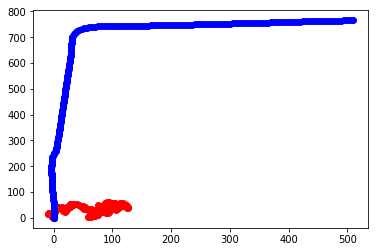

Count:1246
()
()
Relative Depth: -6.587167705765299
Relative x: 60.543970445810785
Relative Original Depth: -765.6434790483576
Relative Original x: 510.15481135792965
Count:1247
()
()
Relative Depth: -6.547352107796205
Relative x: 60.12752281475634
Relative Original Depth: -765.6883789117311
Relative Original x: 511.1537344857989
Count:1248
()
()
Relative Depth: -6.334821824903821
Relative x: 59.832399072326254
Relative Original Depth: -765.742762741099
Relative Original x: 512.1519011406955
Count:1249
()
()
Relative Depth: -6.267593962200612
Relative x: 59.58251779737281
Relative Original Depth: -765.8114000411872
Relative Original x: 513.1494743251243
Count:1250
()
()
Relative Depth: -5.9527563560569545
Relative x: 59.72736775797887
Relative Original Depth: -765.8468613042157
Relative Original x: 514.1483354045702


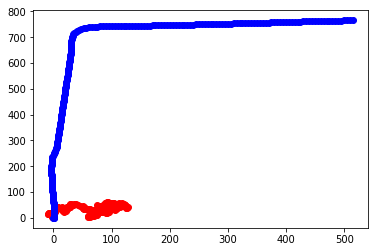

Count:1251
()
()
Relative Depth: -5.425576431563993
Relative x: 60.289169046366084
Relative Original Depth: -765.8855372085164
Relative Original x: 515.1472158831799
Count:1252
()
()
Relative Depth: -4.99280354276577
Relative x: 60.81504041356705
Relative Original Depth: -765.9552044308939
Relative Original x: 516.1446945316951
Count:1253
()
()
Relative Depth: -4.477386847902874
Relative x: 61.24582727681833
Relative Original Depth: -766.0320631669138
Relative Original x: 517.1407407278748
Count:1254
()
()
Relative Depth: -3.86125728650689
Relative x: 61.11855491525978
Relative Original Depth: -766.1043659187683
Relative Original x: 518.1381207397842
Count:1255
()
()
Relative Depth: -3.4984392793570342
Relative x: 60.48349886264504
Relative Original Depth: -766.172726113779
Relative Original x: 519.1337456352093


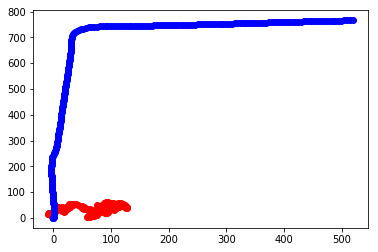

Count:1256
()
()
Relative Depth: -2.592348781836014
Relative x: 60.74666486738624
Relative Original Depth: -766.243794047429
Relative Original x: 520.1310782222365
Count:1257
()
()
Relative Depth: -2.146153138124376
Relative x: 60.10642975385573
Relative Original Depth: -766.2905950878657
Relative Original x: 521.1289606145501
Count:1258
()
()
Relative Depth: -1.770443756060102
Relative x: 59.392805894535115
Relative Original Depth: -766.3259996036302
Relative Original x: 522.1278569208597
Count:1259
()
()
Relative Depth: -1.4843170289565129
Relative x: 58.99876861123989
Relative Original Depth: -766.3396581759738
Relative Original x: 523.1265421374795
Count:1260
()
()
Relative Depth: -1.2214479937740783
Relative x: 59.24832700540832
Relative Original Depth: -766.4256263946696
Relative Original x: 524.122307231812


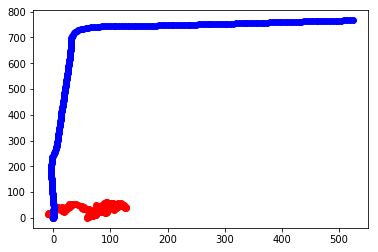

Count:1261
()
()
Relative Depth: -0.43165235731288
Relative x: 59.6195561705945
Relative Original Depth: -766.4680171502342
Relative Original x: 525.1211751581588
Count:1262
()
()
Relative Depth: 0.543892656261957
Relative x: 59.744481471031065
Relative Original Depth: -766.5101421833818
Relative Original x: 526.1200461255686
Count:1263
()
()
Relative Depth: 1.2994166408049455
Relative x: 59.81436494135833
Relative Original Depth: -766.5628484570714
Relative Original x: 527.1182909970371
Count:1264
()
()
Relative Depth: 1.9194065659249941
Relative x: 59.95050169156464
Relative Original Depth: -766.6041521530814
Relative Original x: 528.1170109269278
Count:1265
()
()
Relative Depth: 2.0984157808436255
Relative x: 59.395835398749455
Relative Original Depth: -766.6023420859862
Relative Original x: 529.1165763464423


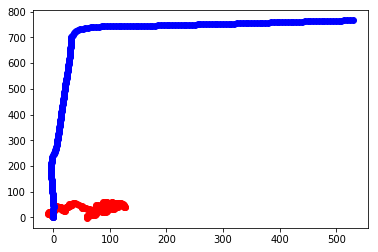

Count:1266
()
()
Relative Depth: 2.1019054045513714
Relative x: 60.075931764711434
Relative Original Depth: -766.6541540005346
Relative Original x: 530.1148687074806
Count:1267
()
()
Relative Depth: 2.5988625139047516
Relative x: 60.35345880148217
Relative Original Depth: -766.6496339394379
Relative Original x: 531.1138917049659
Count:1268
()
()
Relative Depth: 3.3197469097777876
Relative x: 60.51590898779789
Relative Original Depth: -766.6928356624481
Relative Original x: 532.1128736709951
Count:1269
()
()
Relative Depth: 4.213072258750052
Relative x: 60.500034484896
Relative Original Depth: -766.7516944825038
Relative Original x: 533.1110636147109
Count:1270
()
()
Relative Depth: 5.074111536316271
Relative x: 60.38129792593948
Relative Original Depth: -766.760740302911
Relative Original x: 534.1106127020126


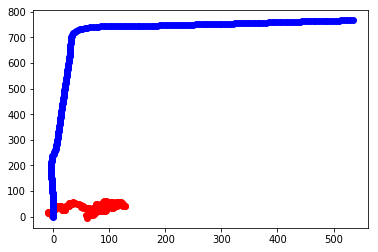

Count:1271
()
()
Relative Depth: 5.966167026365685
Relative x: 60.19991344954322
Relative Original Depth: -766.8621610873754
Relative Original x: 535.1049714758058
Count:1272
()
()
Relative Depth: 6.931177803945446
Relative x: 59.937956511826705
Relative Original Depth: -766.9049537943923
Relative Original x: 536.1031947815417
Count:1273
()
()
Relative Depth: 7.649395678220426
Relative x: 59.50636230210829
Relative Original Depth: -766.9625461423752
Relative Original x: 537.1006892712592
Count:1274
()
()
Relative Depth: 7.433794585624554
Relative x: 59.410245547276986
Relative Original Depth: -767.010359651307
Relative Original x: 538.0988355491421
Count:1275
()
()
Relative Depth: 6.752398075871779
Relative x: 59.980267529503074
Relative Original Depth: -767.0065179668486
Relative Original x: 539.0977001325888


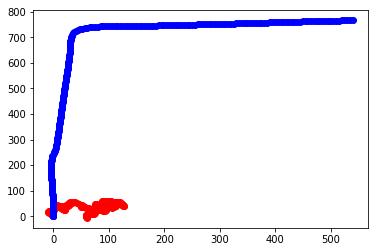

Count:1276
()
()
Relative Depth: 6.572647227978854
Relative x: 60.96383754326983
Relative Original Depth: -767.1295237830362
Relative Original x: 540.0895471923
Count:1277
()
()
Relative Depth: 6.644838998682703
Relative x: 61.8636785716023
Relative Original Depth: -767.203329573424
Relative Original x: 541.0868129931074
Count:1278
()
()
Relative Depth: 6.5474106148173625
Relative x: 62.750901348941234
Relative Original Depth: -767.2272767018902
Relative Original x: 542.085520522663
Count:1279
()
()
Relative Depth: 6.532534702228067
Relative x: 63.73377871363896
Relative Original Depth: -767.2707065150997
Relative Original x: 543.0834070244705
Count:1280
()
()
Relative Depth: 6.510583490816781
Relative x: 64.73351287403561
Relative Original Depth: -767.3085248588797
Relative Original x: 544.082636476


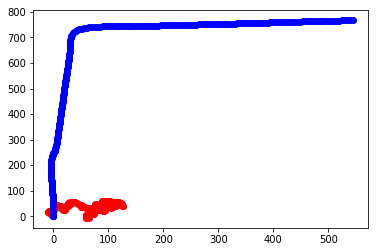

Count:1281
()
()
Relative Depth: 6.544580220086414
Relative x: 65.7247697067031
Relative Original Depth: -767.324060267436
Relative Original x: 545.0818044602191
Count:1282
()
()
Relative Depth: 6.5375853640847605
Relative x: 66.56923037982473
Relative Original Depth: -767.3332003258968
Relative Original x: 546.0811365219605
Count:1283
()
()
Relative Depth: 6.949904389615292
Relative x: 67.43463390948752
Relative Original Depth: -767.4092081103074
Relative Original x: 547.0777218088482
Count:1284
()
()
Relative Depth: 7.513488702297367
Relative x: 68.23454182684213
Relative Original Depth: -767.437119612689
Relative Original x: 548.0766315763552
Count:1285
()
()
Relative Depth: 8.040124641061205
Relative x: 69.07325618687935
Relative Original Depth: -767.4971060024591
Relative Original x: 549.074312535821


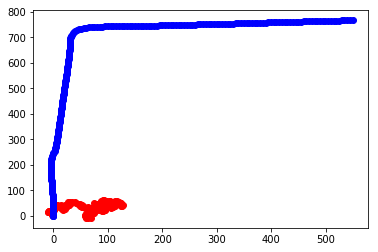

Count:1286
()
()
Relative Depth: 8.521819958454
Relative x: 69.94836469647836
Relative Original Depth: -767.513986435887
Relative Original x: 550.0729914008691
Count:1287
()
()
Relative Depth: 8.915481136167088
Relative x: 70.86306434686962
Relative Original Depth: -767.5521218330526
Relative Original x: 551.0717551092764
Count:1288
()
()
Relative Depth: 9.36671616205347
Relative x: 71.74900636527816
Relative Original Depth: -767.5677847979092
Relative Original x: 552.0711766820074
Count:1289
()
()
Relative Depth: 9.930627377683583
Relative x: 72.57201901283054
Relative Original Depth: -767.617335447198
Relative Original x: 553.0695866477355
Count:1290
()
()
Relative Depth: 10.135839463309779
Relative x: 73.54904950182737
Relative Original Depth: -767.6541388474053
Relative Original x: 554.0684404332517


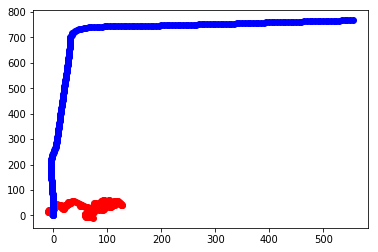

Count:1291
()
()
Relative Depth: 9.797659474166627
Relative x: 74.47462474116749
Relative Original Depth: -767.6905039968393
Relative Original x: 555.0668919972858
Count:1292
()
()
Relative Depth: 9.518536682142756
Relative x: 75.36314770058546
Relative Original Depth: -767.7464616307141
Relative Original x: 556.0652237710223
Count:1293
()
()
Relative Depth: 9.274947806814254
Relative x: 76.20811014173759
Relative Original Depth: -767.7954273411825
Relative Original x: 557.0638484531618
Count:1294
()
()
Relative Depth: 9.041400478840778
Relative x: 77.15898040129619
Relative Original Depth: -767.8763500811144
Relative Original x: 558.0600975200763
Count:1295
()
()
Relative Depth: 9.088447421289546
Relative x: 78.15572150211453
Relative Original Depth: -767.8556756063872
Relative Original x: 559.0598296508412


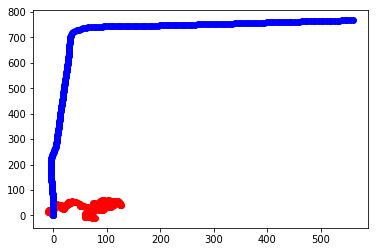

Count:1296
()
()
Relative Depth: 9.287264848199623
Relative x: 78.93939542533701
Relative Original Depth: -767.8997180354248
Relative Original x: 560.0587511021353
Count:1297
()
()
Relative Depth: 9.373002191719335
Relative x: 79.29893846581206
Relative Original Depth: -767.9051354254043
Relative Original x: 561.0576134378313
Count:1298
()
()
Relative Depth: 9.319092646872239
Relative x: 79.70969394981147
Relative Original Depth: -767.8930725839094
Relative Original x: 562.0568408438087
Count:1299
()
()
Relative Depth: 9.319813489994193
Relative x: 80.10200917496222
Relative Original Depth: -767.9396880151977
Relative Original x: 563.0553190824003
Count:1300
()
()
Relative Depth: 9.89625560631118
Relative x: 80.4259832220063
Relative Original Depth: -767.9540736557616
Relative Original x: 564.0538202805135


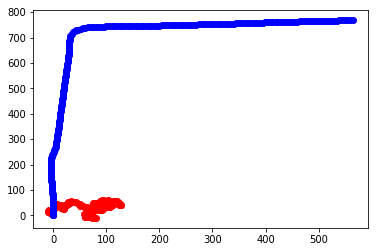

Count:1301
()
()
Relative Depth: 10.739119711524546
Relative x: 80.87070534339102
Relative Original Depth: -768.0122936712578
Relative Original x: 565.0516559150373
Count:1302
()
()
Relative Depth: 11.532106517560791
Relative x: 81.42229928359244
Relative Original Depth: -768.057969830612
Relative Original x: 566.0499133794569
Count:1303
()
()
Relative Depth: 12.326698473645605
Relative x: 81.96849124866552
Relative Original Depth: -768.0980898962483
Relative Original x: 567.0487018683708
Count:1304
()
()
Relative Depth: 13.130957508815788
Relative x: 82.5206063016089
Relative Original Depth: -768.1702383115494
Relative Original x: 568.0456854360372
Count:1305
()
()
Relative Depth: 13.935366404063288
Relative x: 83.09490845687763
Relative Original Depth: -768.1967091860442
Relative Original x: 569.0443172281745


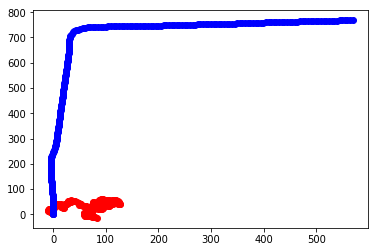

Count:1306
()
()
Relative Depth: 14.761788835050774
Relative x: 83.61341989301701
Relative Original Depth: -768.2206866308675
Relative Original x: 570.042560245788
Count:1307
()
()
Relative Depth: 15.56107201694347
Relative x: 84.13077637270311
Relative Original Depth: -768.2273362696465
Relative Original x: 571.0422658993588
Count:1308
()
()
Relative Depth: 16.212367320760574
Relative x: 83.89862615039
Relative Original Depth: -768.2671210103164
Relative Original x: 572.0411231092266
Count:1309
()
()
Relative Depth: 17.049219292100293
Relative x: 83.69851921496976
Relative Original Depth: -768.2716171696762
Relative Original x: 573.0406762198052
Count:1310
()
()
Relative Depth: 16.866940853181877
Relative x: 82.72004587163967
Relative Original Depth: -768.2913135829959
Relative Original x: 574.0397825550937


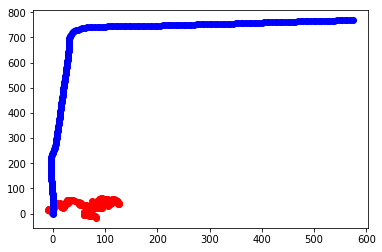

Count:1311
()
()
Relative Depth: 16.035010420634144
Relative x: 82.37789352309724
Relative Original Depth: -768.3190348590033
Relative Original x: 575.0391446669563
Count:1312
()
()
Relative Depth: 15.276317464438085
Relative x: 82.38029726915418
Relative Original Depth: -768.3623442673015
Relative Original x: 576.038062202957
Count:1313
()
()
Relative Depth: 14.966894581338599
Relative x: 81.659726335722
Relative Original Depth: -768.4094335780171
Relative Original x: 577.0361037396955
Count:1314
()
()
Relative Depth: 15.052635709420537
Relative x: 80.68232611587003
Relative Original Depth: -768.4643549878391
Relative Original x: 578.0343872615155
Count:1315
()
()
Relative Depth: 14.9457739367852
Relative x: 79.90093879616934
Relative Original Depth: -768.513907164939
Relative Original x: 579.03240652456


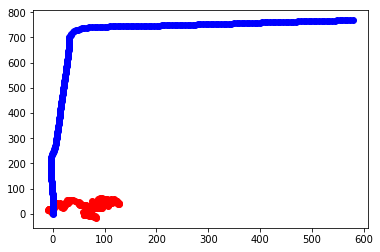

Count:1316
()
()
Relative Depth: 14.890683115482943
Relative x: 79.38665554145585
Relative Original Depth: -768.5711608549436
Relative Original x: 580.0304284683629
Count:1317
()
()
Relative Depth: 14.859468668011633
Relative x: 79.15194150872519
Relative Original Depth: -768.6094652555039
Relative Original x: 581.0296267462413
Count:1318
()
()
Relative Depth: 14.771730864701313
Relative x: 78.85713221397904
Relative Original Depth: -768.621274222081
Relative Original x: 582.0289951217994
Count:1319
()
()
Relative Depth: 14.812533730226171
Relative x: 78.48660088386391
Relative Original Depth: -768.6192184246894
Relative Original x: 583.0280896543605
Count:1320
()
()
Relative Depth: 14.962165637879773
Relative x: 78.10244165638031
Relative Original Depth: -768.6301746499254
Relative Original x: 584.0279520476726


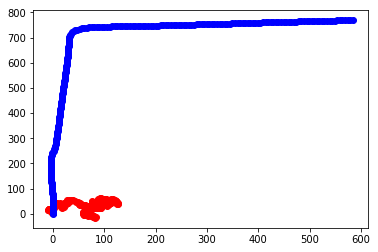

Count:1321
()
()
Relative Depth: 15.07674392600576
Relative x: 77.78506714864908
Relative Original Depth: -768.7089761773568
Relative Original x: 585.0234632003334
Count:1322
()
()
Relative Depth: 15.189023237559944
Relative x: 77.5014692642288
Relative Original Depth: -768.7729599128521
Relative Original x: 586.0214113977393
Count:1323
()
()
Relative Depth: 15.670663861871141
Relative x: 77.31767884944927
Relative Original Depth: -768.8401338815501
Relative Original x: 587.0189913633608
Count:1324
()
()
Relative Depth: 16.378489430474488
Relative x: 77.32782688167902
Relative Original Depth: -768.8794300337612
Relative Original x: 588.0174570988122
Count:1325
()
()
Relative Depth: 17.092239201291015
Relative x: 77.38977739233798
Relative Original Depth: -768.92991598708
Relative Original x: 589.015962751524


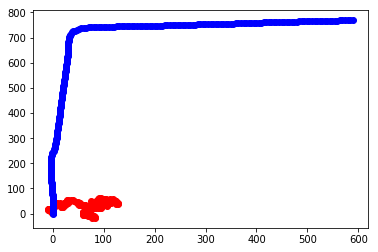

Count:1326
()
()
Relative Depth: 17.918402195223727
Relative x: 77.94300576386601
Relative Original Depth: -768.9849976447549
Relative Original x: 590.013494771186
Count:1327
()
()
Relative Depth: 18.222866782321663
Relative x: 78.43570876338143
Relative Original Depth: -769.0244356431376
Relative Original x: 591.0123408069243
Count:1328
()
()
Relative Depth: 18.543447729452463
Relative x: 78.77752476552867
Relative Original Depth: -769.0651048488255
Relative Original x: 592.0107875781517
Count:1329
()
()
Relative Depth: 18.81164838615251
Relative x: 79.10668700224976
Relative Original Depth: -769.1091840666178
Relative Original x: 593.0096240367145
Count:1330
()
()
Relative Depth: 18.98459402563329
Relative x: 79.43496483495437
Relative Original Depth: -769.1738094744562
Relative Original x: 594.0072261205687


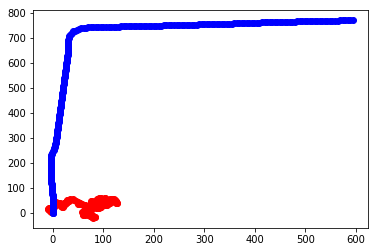

Count:1331
()
()
Relative Depth: 18.995376065642066
Relative x: 79.70267117305632
Relative Original Depth: -769.2698377656452
Relative Original x: 595.0015249858238
Count:1332
()
()
Relative Depth: 18.647421142637842
Relative x: 79.62709957570654
Relative Original Depth: -769.2491938398055
Relative Original x: 596.0000921315228
Count:1333
()
()
Relative Depth: 17.989080238445737
Relative x: 79.28515840912264
Relative Original Depth: -769.2937307173934
Relative Original x: 596.998674183848
Count:1334
()
()
Relative Depth: 17.11301363819784
Relative x: 79.17003828875106
Relative Original Depth: -769.308174290081
Relative Original x: 597.997959516335
Count:1335
()
()
Relative Depth: 16.156802199219612
Relative x: 79.16245737362827
Relative Original Depth: -769.3320310175121
Relative Original x: 598.9972042441431


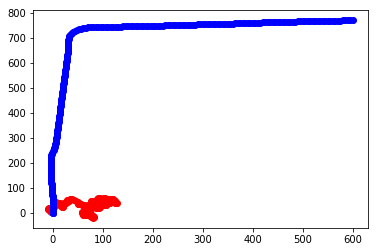

Count:1336
()
()
Relative Depth: 15.20554877386096
Relative x: 79.01095721538316
Relative Original Depth: -769.3702284724064
Relative Original x: 599.9963332437227
Count:1337
()
()
Relative Depth: 14.288137814572922
Relative x: 78.76024274306154
Relative Original Depth: -769.3755134526746
Relative Original x: 600.99554345468
Count:1338
()
()
Relative Depth: 13.518329299467375
Relative x: 78.41368349845774
Relative Original Depth: -769.4113539804514
Relative Original x: 601.9941012971663
Count:1339
()
()
Relative Depth: 13.22283355085947
Relative x: 77.87346200300684
Relative Original Depth: -769.4407638622671
Relative Original x: 602.9930125545632
Count:1340
()
()
Relative Depth: 13.209756795738157
Relative x: 77.32586178584968
Relative Original Depth: -769.5686103360354
Relative Original x: 603.984771941348


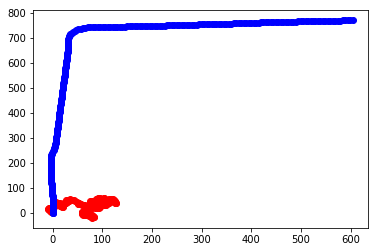

Count:1341
()
()
Relative Depth: 13.184955313108933
Relative x: 76.71391345038872
Relative Original Depth: -769.5986903985023
Relative Original x: 604.9826958562005
Count:1342
()
()
Relative Depth: 13.250794704941594
Relative x: 76.11370737841521
Relative Original Depth: -769.6158724790697
Relative Original x: 605.9811379719371
Count:1343
()
()
Relative Depth: 13.205993397447697
Relative x: 75.5835859688138
Relative Original Depth: -769.5800946912561
Relative Original x: 606.9768041063746
Count:1344
()
()
Relative Depth: 12.939724482847845
Relative x: 75.18399904731812
Relative Original Depth: -769.6040663416347
Relative Original x: 607.9762712209549
Count:1345
()
()
Relative Depth: 12.355287725920597
Relative x: 75.73089234738205
Relative Original Depth: -769.8041107810247
Relative Original x: 608.9559395287357


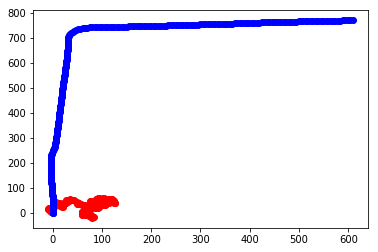

Count:1346
()
()
Relative Depth: 11.78616002201787
Relative x: 76.05123746512237
Relative Original Depth: -769.7996072444361
Relative Original x: 609.9550883762863
Count:1347
()
()
Relative Depth: 11.287624120198231
Relative x: 76.91798791969843
Relative Original Depth: -769.8640578039107
Relative Original x: 610.9528223025216
Count:1348
()
()
Relative Depth: 10.766582818926434
Relative x: 77.7386988234256
Relative Original Depth: -769.8587823760781
Relative Original x: 611.9511761612437
Count:1349
()
()
Relative Depth: 10.29341865468377
Relative x: 78.5123146125953
Relative Original Depth: -769.9026417884453
Relative Original x: 612.9501020767048
Count:1350
()
()
Relative Depth: 9.698020514890754
Relative x: 79.29020189608559
Relative Original Depth: -769.9518633222424
Relative Original x: 613.9483791342652


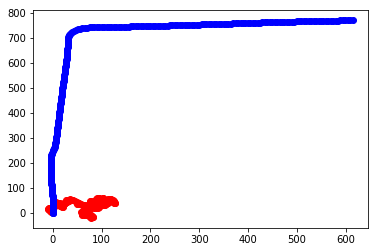

Count:1351
()
()
Relative Depth: 9.056423654982641
Relative x: 80.05699931925125
Relative Original Depth: -769.9906530945342
Relative Original x: 614.9472719875865
Count:1352
()
()
Relative Depth: 8.407673478004554
Relative x: 80.76456751098142
Relative Original Depth: -770.0180807725066
Relative Original x: 615.9466528562126
Count:1353
()
()
Relative Depth: 7.813716563393969
Relative x: 81.254810010475
Relative Original Depth: -770.0584042608772
Relative Original x: 616.9456460446213
Count:1354
()
()
Relative Depth: 8.485307302891304
Relative x: 80.93961413880919
Relative Original Depth: -770.1697765920095
Relative Original x: 617.9393786959007
Count:1355
()
()
Relative Depth: 7.906451561848285
Relative x: 81.33128841200252
Relative Original Depth: -770.3121245205047
Relative Original x: 618.9280018836165


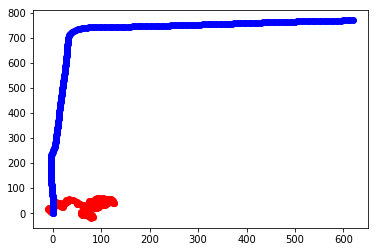

Count:1356
()
()
Relative Depth: 7.212657746046818
Relative x: 81.86118208767643
Relative Original Depth: -770.3697489219993
Relative Original x: 619.9260002668547
Count:1357
()
()
Relative Depth: 6.518440819548793
Relative x: 82.47704657892223
Relative Original Depth: -770.4756422032414
Relative Original x: 620.9197206157313
Count:1358
()
()
Relative Depth: 5.848846765494999
Relative x: 83.05999668286472
Relative Original Depth: -770.5055206609355
Relative Original x: 621.917790917041
Count:1359
()
()
Relative Depth: 5.177700577246764
Relative x: 83.59636523457371
Relative Original Depth: -770.5674367463641
Relative Original x: 622.9151882113999
Count:1360
()
()
Relative Depth: 4.564415211217867
Relative x: 84.11892127465032
Relative Original Depth: -770.5773674328183
Relative Original x: 623.9139203707678


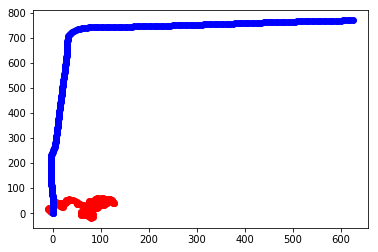

Count:1361
()
()
Relative Depth: 4.188841852592573
Relative x: 84.49629467346969
Relative Original Depth: -770.6046170496426
Relative Original x: 624.9125538891258
Count:1362
()
()
Relative Depth: 4.123178877101944
Relative x: 84.60040348522044
Relative Original Depth: -770.6132916962439
Relative Original x: 625.9115509571641
Count:1363
()
()
Relative Depth: 4.116039219732113
Relative x: 84.51318274277675
Relative Original Depth: -770.6436825410744
Relative Original x: 626.9106806984565
Count:1364
()
()
Relative Depth: 4.6801010237954594
Relative x: 83.79226791001035
Relative Original Depth: -770.7129464333733
Relative Original x: 627.9082398618318
Count:1365
()
()
Relative Depth: 4.493301611127927
Relative x: 83.53043680859008
Relative Original Depth: -770.8057221391946
Relative Original x: 628.9038464751619


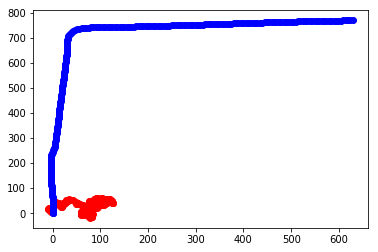

Count:1366
()
()
Relative Depth: 4.037368792801553
Relative x: 83.30035484670535
Relative Original Depth: -770.8673038135025
Relative Original x: 629.9017706684391
Count:1367
()
()
Relative Depth: 3.5063248172793164
Relative x: 82.95215330247929
Relative Original Depth: -770.953627951182
Relative Original x: 630.8971135651612
Count:1368
()
()
Relative Depth: 3.092189887064439
Relative x: 82.39728920699214
Relative Original Depth: -770.9962249223578
Relative Original x: 631.895728053988
Count:1369
()
()
Relative Depth: 2.603855357211263
Relative x: 81.73392835899422
Relative Original Depth: -771.0266064242873
Relative Original x: 632.8945346975592
Count:1370
()
()
Relative Depth: 2.2590564989107986
Relative x: 81.07632365031358
Relative Original Depth: -771.0968751044998
Relative Original x: 633.8920369394779


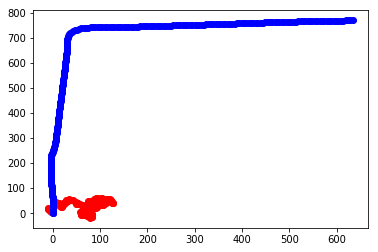

Count:1371
()
()
Relative Depth: 2.2434944603234377
Relative x: 80.49710223413965
Relative Original Depth: -771.1484175729767
Relative Original x: 634.8898966938714
Count:1372
()
()
Relative Depth: 2.1438772167723923
Relative x: 80.17155701860067
Relative Original Depth: -771.176975172746
Relative Original x: 635.8887551003888
Count:1373
()
()
Relative Depth: 1.8653098194227715
Relative x: 80.07761225867873
Relative Original Depth: -771.3007811265795
Relative Original x: 636.8783041687899
Count:1374
()
()
Relative Depth: 1.5151280140963457
Relative x: 79.94947044853299
Relative Original Depth: -771.3818815399269
Relative Original x: 637.8747979313405
Count:1375
()
()
Relative Depth: 1.1448913841521093
Relative x: 79.78933844079782
Relative Original Depth: -771.4124965226796
Relative Original x: 638.8737508341576


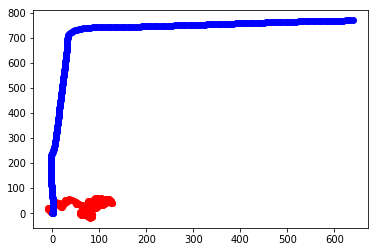

Count:1376
()
()
Relative Depth: 0.536951576478236
Relative x: 79.50594301261647
Relative Original Depth: -771.4310103738945
Relative Original x: 639.8710952495506
Count:1377
()
()
Relative Depth: -0.2536357293974887
Relative x: 79.1440933652234
Relative Original Depth: -771.5240968803494
Relative Original x: 640.8655092522886
Count:1378
()
()
Relative Depth: -1.02727470205949
Relative x: 78.78610595347224
Relative Original Depth: -771.5895284802032
Relative Original x: 641.8620257843983
Count:1379
()
()
Relative Depth: -1.5159174619371014
Relative x: 78.45444146558025
Relative Original Depth: -771.6545537476777
Relative Original x: 642.8595798048576
Count:1380
()
()
Relative Depth: -1.7923398027496236
Relative x: 78.1989898867573
Relative Original Depth: -771.7103183897991
Relative Original x: 643.8574369472499


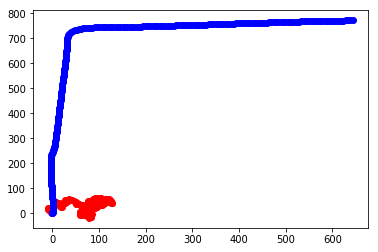

Count:1381
()
()
Relative Depth: -2.0844045896911734
Relative x: 77.88365722151545
Relative Original Depth: -771.7349713381898
Relative Original x: 644.8569436825209
Count:1382
()
()
Relative Depth: -2.5141098793123735
Relative x: 77.1394335328058
Relative Original Depth: -771.7502109684958
Relative Original x: 645.8551052844693
Count:1383
()
()
Relative Depth: -3.1279011612223253
Relative x: 76.35634382160994
Relative Original Depth: -771.852241473472
Relative Original x: 646.8485356572486
Count:1384
()
()
Relative Depth: -3.892248601077587
Relative x: 75.72476083489241
Relative Original Depth: -771.9417438642186
Relative Original x: 647.8444963431242
Count:1385
()
()
Relative Depth: -4.148337599169252
Relative x: 75.30032163990842
Relative Original Depth: -772.0133186783904
Relative Original x: 648.8414706420135


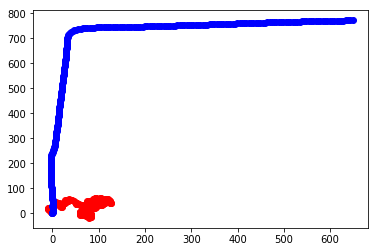

Count:1386
()
()
Relative Depth: -3.7524854703117003
Relative x: 75.4251336137217
Relative Original Depth: -772.0853042553481
Relative Original x: 649.8381201370561
Count:1387
()
()
Relative Depth: -3.3913888861955526
Relative x: 75.49760358900309
Relative Original Depth: -772.1568246256614
Relative Original x: 650.8349644721075
Count:1388
()
()
Relative Depth: -3.030369244235634
Relative x: 76.41700663368708
Relative Original Depth: -772.2280914186249
Relative Original x: 651.8316417741102
Count:1389
()
()
Relative Depth: -2.5836280226927104
Relative x: 76.29649573176123
Relative Original Depth: -772.3091761045677
Relative Original x: 652.8283418825172
Count:1390
()
()
Relative Depth: -2.101604595604444
Relative x: 76.14874138737585
Relative Original Depth: -772.3838571119263
Relative Original x: 653.8255169552319


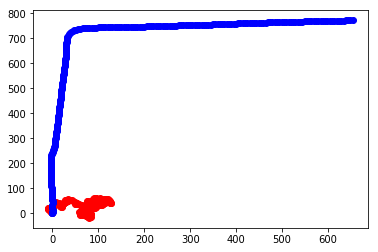

Count:1391
()
()
Relative Depth: -1.9261072469153468
Relative x: 75.75149569305397
Relative Original Depth: -772.448832713217
Relative Original x: 654.8234032046016
Count:1392
()
()
Relative Depth: -1.8828257633842844
Relative x: 74.83660919691397
Relative Original Depth: -772.5557800528336
Relative Original x: 655.8176672266364
Count:1393
()
()
Relative Depth: -1.5290086687422875
Relative x: 73.90957534999964
Relative Original Depth: -772.6509686867319
Relative Original x: 656.8130475739159
Count:1394
()
()
Relative Depth: -0.9631497911336161
Relative x: 73.08701571471266
Relative Original Depth: -772.6669123005693
Relative Original x: 657.8125967281007
Count:1395
()
()
Relative Depth: -0.4160947698226386
Relative x: 72.25340874026766
Relative Original Depth: -772.734276785442
Relative Original x: 658.8103160604923


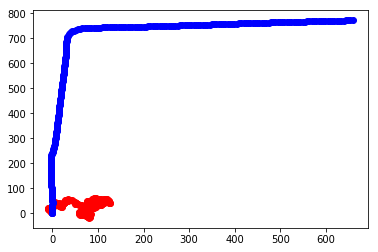

Count:1396
()
()
Relative Depth: 0.13107782681731017
Relative x: 71.47470571628791
Relative Original Depth: -772.8242658936535
Relative Original x: 659.805794623589
Count:1397
()
()
Relative Depth: 0.9320207701210013
Relative x: 70.87724291748114
Relative Original Depth: -772.8717305190614
Relative Original x: 660.8035300348947
Count:1398
()
()
Relative Depth: 1.73022900251816
Relative x: 70.64755087098209
Relative Original Depth: -772.9716889959132
Relative Original x: 661.7984216296201
Count:1399
()
()
Relative Depth: 2.4453191664813727
Relative x: 70.52004703166877
Relative Original Depth: -773.0074425421269
Relative Original x: 662.7973861230099
Count:1400
()
()
Relative Depth: 3.0417892527845964
Relative x: 70.61407569833057
Relative Original Depth: -773.0078214820279
Relative Original x: 663.7940576200859


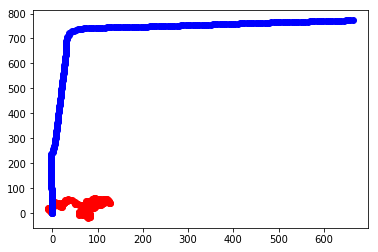

Count:1401
()
()
Relative Depth: 3.4501045664184717
Relative x: 70.92958155656557
Relative Original Depth: -773.0745022943763
Relative Original x: 664.7917044661525
Count:1402
()
()
Relative Depth: 3.5826570245059752
Relative x: 71.51753842101621
Relative Original Depth: -773.2274634816674
Relative Original x: 665.7798933981352
Count:1403
()
()
Relative Depth: 3.749177623007085
Relative x: 72.28018407371971
Relative Original Depth: -773.3120468036535
Relative Original x: 666.7759337849029
Count:1404
()
()
Relative Depth: 3.817979036783712
Relative x: 72.95700817320476
Relative Original Depth: -773.3925090818377
Relative Original x: 667.7722353126475
Count:1405
()
()
Relative Depth: 4.637299834333826
Relative x: 72.95521163799735
Relative Original Depth: -773.4553708157396
Relative Original x: 668.770230965554


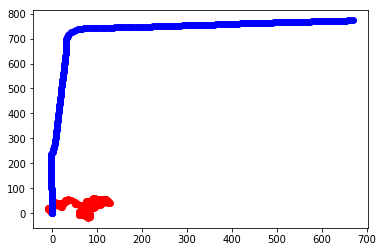

Count:1406
()
()
Relative Depth: 4.201903077686252
Relative x: 72.1963546465752
Relative Original Depth: -773.4873388327653
Relative Original x: 669.7693371182937
Count:1407
()
()
Relative Depth: 4.2237517547509436
Relative x: 72.66128343376842
Relative Original Depth: -773.5981274230372
Relative Original x: 670.7631767270242
Count:1408
()
()
Relative Depth: 4.4568659390637055
Relative x: 73.13376739862333
Relative Original Depth: -773.7437532307188
Relative Original x: 671.7515783079976
Count:1409
()
()
Relative Depth: 4.720130339755512
Relative x: 73.6415216585528
Relative Original Depth: -773.8096947242898
Relative Original x: 672.7491859477589
Count:1410
()
()
Relative Depth: 4.977624141957801
Relative x: 74.14267436933993
Relative Original Depth: -773.8758438552995
Relative Original x: 673.746068551019


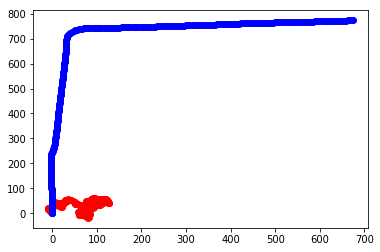

Count:1411
()
()
Relative Depth: 5.4186273214272145
Relative x: 74.46650551160153
Relative Original Depth: -773.9708639898738
Relative Original x: 674.7411029064216
Count:1412
()
()
Relative Depth: 6.164916913186374
Relative x: 74.50065404123906
Relative Original Depth: -774.0499659679654
Relative Original x: 675.7374274912061
Count:1413
()
()
Relative Depth: 7.031904810927355
Relative x: 74.4421737343678
Relative Original Depth: -774.1405053890898
Relative Original x: 676.7329967015478
Count:1414
()
()
Relative Depth: 7.898228929580629
Relative x: 74.51666580418222
Relative Original Depth: -774.2292551657854
Relative Original x: 677.7289981966187
Count:1415
()
()
Relative Depth: 8.749144577726867
Relative x: 74.6637423251623
Relative Original Depth: -774.3390681188678
Relative Original x: 678.7229236636292


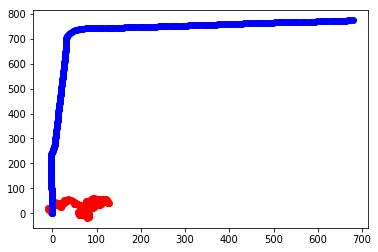

Count:1416
()
()
Relative Depth: 9.611532521214759
Relative x: 74.73527650932269
Relative Original Depth: -774.4260074223796
Relative Original x: 679.7158252299815
Count:1417
()
()
Relative Depth: 10.469784647491304
Relative x: 74.75016801666426
Relative Original Depth: -774.5696738740711
Relative Original x: 680.7049005601037
Count:1418
()
()
Relative Depth: 11.280866404307558
Relative x: 74.68526551058876
Relative Original Depth: -774.6727939365337
Relative Original x: 681.699561624091
Count:1419
()
()
Relative Depth: 11.783077496344907
Relative x: 74.67754067565212
Relative Original Depth: -774.7702409662659
Relative Original x: 682.6945610740617
Count:1420
()
()
Relative Depth: 12.129468264829336
Relative x: 74.68180240072486
Relative Original Depth: -774.8455536490811
Relative Original x: 683.6917064399845


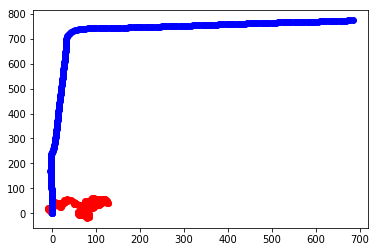

Count:1421
()
()
Relative Depth: 12.678984249056388
Relative x: 74.54018867236812
Relative Original Depth: -774.9701525435056
Relative Original x: 684.6836794948106
Count:1422
()
()
Relative Depth: 13.221274894088724
Relative x: 74.311683785678
Relative Original Depth: -775.0485046483752
Relative Original x: 685.6806052276058
Count:1423
()
()
Relative Depth: 13.662404742142408
Relative x: 74.02742659391906
Relative Original Depth: -775.1177542468362
Relative Original x: 686.6781878876272
Count:1424
()
()
Relative Depth: 13.895125067181828
Relative x: 73.9012817925544
Relative Original Depth: -775.2033034007054
Relative Original x: 687.6744939181076
Count:1425
()
()
Relative Depth: 13.98910280211926
Relative x: 73.93209212094186
Relative Original Depth: -775.2544492077617
Relative Original x: 688.6724338484605


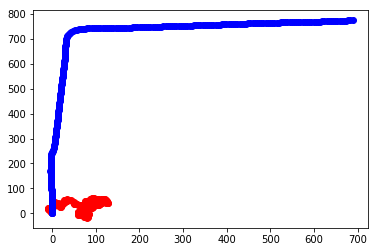

Count:1426
()
()
Relative Depth: 14.162937119479672
Relative x: 73.91435155410885
Relative Original Depth: -775.4104315325683
Relative Original x: 689.6600832781126
Count:1427
()
()
Relative Depth: 14.225762463354878
Relative x: 74.01171865554764
Relative Original Depth: -775.5799951454172
Relative Original x: 690.6455775181505
Count:1428
()
()
Relative Depth: 13.670472472612694
Relative x: 74.83993252699321
Relative Original Depth: -775.7631901007295
Relative Original x: 691.6286468752822
Count:1429
()
()
Relative Depth: 13.587992842168564
Relative x: 75.13683517885322
Relative Original Depth: -775.9305297427418
Relative Original x: 692.6128259290879
Count:1430
()
()
Relative Depth: 13.039440721754186
Relative x: 75.62586911989138
Relative Original Depth: -776.0159084417596
Relative Original x: 693.6091632943277


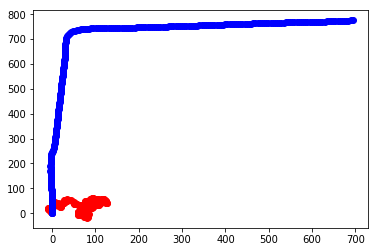

Count:1431
()
()
Relative Depth: 12.211834581846256
Relative x: 76.1440039284517
Relative Original Depth: -776.1070753912634
Relative Original x: 694.6047961489998
Count:1432
()
()
Relative Depth: 11.37906318015286
Relative x: 76.66183547961298
Relative Original Depth: -776.1857643386539
Relative Original x: 695.6016596705467
Count:1433
()
()
Relative Depth: 10.608079436543095
Relative x: 77.21338682851032
Relative Original Depth: -776.2698679027102
Relative Original x: 696.5980906791594
Count:1434
()
()
Relative Depth: 11.16583578153566
Relative x: 77.37855755665089
Relative Original Depth: -776.3706935054814
Relative Original x: 697.5929232813402
Count:1435
()
()
Relative Depth: 10.54159455431915
Relative x: 77.87024778321798
Relative Original Depth: -776.420656319505
Relative Original x: 698.5916722456457


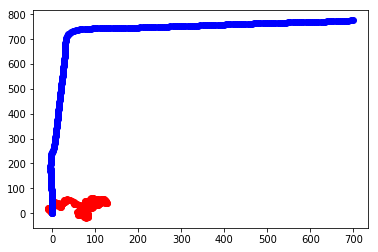

Count:1436
()
()
Relative Depth: 10.487823602391666
Relative x: 78.71660117975698
Relative Original Depth: -776.5773522934286
Relative Original x: 699.5757996654064
Count:1437
()
()
Relative Depth: 11.021823543887459
Relative x: 79.54434694893189
Relative Original Depth: -776.6853524193883
Relative Original x: 700.5680789494189
Count:1438
()
()
Relative Depth: 10.405181446584736
Relative x: 80.32831801160637
Relative Original Depth: -776.7955553783908
Relative Original x: 701.5619576160813
Count:1439
()
()
Relative Depth: 10.40642245930849
Relative x: 80.91251546537909
Relative Original Depth: -776.8697506381493
Relative Original x: 702.5591980588395
Count:1440
()
()
Relative Depth: 10.894080413913288
Relative x: 81.75587762369
Relative Original Depth: -776.985960618483
Relative Original x: 703.5509174627726


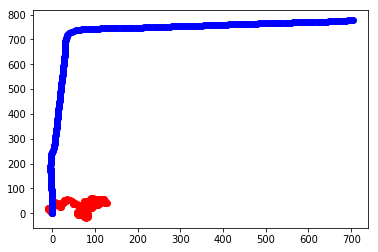

Count:1441
()
()
Relative Depth: 11.276321105435546
Relative x: 82.65488825865704
Relative Original Depth: -777.0672211689614
Relative Original x: 704.5475887926277
Count:1442
()
()
Relative Depth: 11.753745983795099
Relative x: 83.01797149917739
Relative Original Depth: -777.1529927661998
Relative Original x: 705.5438650652028
Count:1443
()
()
Relative Depth: 11.906436405746058
Relative x: 84.00552775016006
Relative Original Depth: -777.2398793260836
Relative Original x: 706.5393294854761
Count:1444
()
()
Relative Depth: 11.58647396271821
Relative x: 84.95225891803594
Relative Original Depth: -777.3197542096291
Relative Original x: 707.5359981423015
Count:1445
()
()
Relative Depth: 11.078634084501397
Relative x: 85.79727412053481
Relative Original Depth: -777.321132642646
Relative Original x: 708.5356756002269


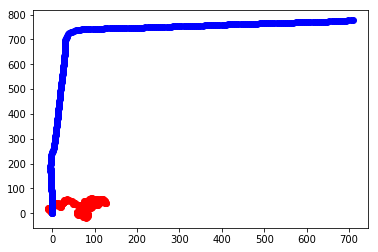

Count:1446
()
()
Relative Depth: 10.518578261943373
Relative x: 86.4964615809185
Relative Original Depth: -777.4206612760712
Relative Original x: 709.5304989292307
Count:1447
()
()
Relative Depth: 10.163706164240818
Relative x: 86.41047949844605
Relative Original Depth: -777.5042551117438
Relative Original x: 710.5269419247928
Count:1448
()
()
Relative Depth: 9.761981636903647
Relative x: 86.0117508992235
Relative Original Depth: -777.6069125712859
Relative Original x: 711.5212247023032
Count:1449
()
()
Relative Depth: 9.292035493167106
Relative x: 85.58322928254388
Relative Original Depth: -777.6697670181824
Relative Original x: 712.5187993528506
Count:1450
()
()
Relative Depth: 9.074955792792721
Relative x: 85.2463955363439
Relative Original Depth: -777.7843097949602
Relative Original x: 713.5121694075372


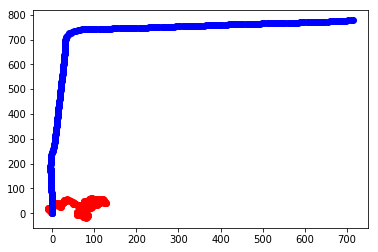

Count:1451
()
()
Relative Depth: 9.044929262756241
Relative x: 85.01004961422503
Relative Original Depth: -777.8734794956481
Relative Original x: 714.5080645175112
Count:1452
()
()
Relative Depth: 9.055594687235565
Relative x: 84.52045232884102
Relative Original Depth: -777.8964634871893
Relative Original x: 715.5049608372321
Count:1453
()
()
Relative Depth: 9.145584785933265
Relative x: 83.82832698064551
Relative Original Depth: -777.982674858024
Relative Original x: 716.4997696687027
Count:1454
()
()
Relative Depth: 9.4075594147307
Relative x: 83.18843253152303
Relative Original Depth: -778.0806903078192
Relative Original x: 717.4943484725613
Count:1455
()
()
Relative Depth: 9.52363973057162
Relative x: 82.9828066435804
Relative Original Depth: -778.1635824831944
Relative Original x: 718.4905973337604


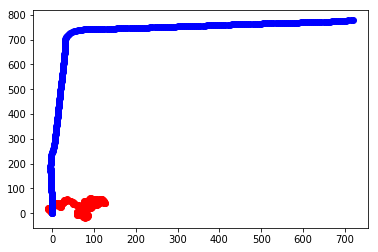

Count:1456
()
()
Relative Depth: 9.404092461404614
Relative x: 83.2032969328773
Relative Original Depth: -778.2714191375037
Relative Original x: 719.4847219452505
Count:1457
()
()
Relative Depth: 9.465637752953329
Relative x: 83.5796172878652
Relative Original Depth: -778.3578602263798
Relative Original x: 720.4804061966411
Count:1458
()
()
Relative Depth: 9.73154844679705
Relative x: 84.12716863830579
Relative Original Depth: -778.4068911818523
Relative Original x: 721.479156138801
Count:1459
()
()
Relative Depth: 9.8643984949659
Relative x: 84.77420176827488
Relative Original Depth: -778.4688578520854
Relative Original x: 722.4760228183198
Count:1460
()
()
Relative Depth: 9.71594959606334
Relative x: 85.51724088847516
Relative Original Depth: -778.5245827457754
Relative Original x: 723.4741941822163


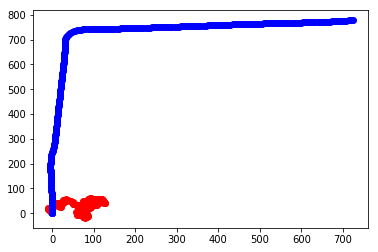

Count:1461
()
()
Relative Depth: 9.551435116070596
Relative x: 86.29936143519159
Relative Original Depth: -778.6277591858891
Relative Original x: 724.4677230035464
Count:1462
()
()
Relative Depth: 9.37680902785602
Relative x: 87.03541850601584
Relative Original Depth: -778.7456387391331
Relative Original x: 725.4606856114955
Count:1463
()
()
Relative Depth: 9.173031436478208
Relative x: 87.75908316716328
Relative Original Depth: -778.8436765296624
Relative Original x: 726.4552296698546
Count:1464
()
()
Relative Depth: 8.625443055276072
Relative x: 88.27294854503774
Relative Original Depth: -778.9403397503314
Relative Original x: 727.450145531995
Count:1465
()
()
Relative Depth: 7.744154655389551
Relative x: 88.64419577036031
Relative Original Depth: -779.0201374246205
Relative Original x: 728.4444887705017


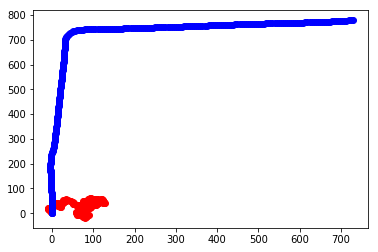

Count:1466
()
()
Relative Depth: 6.807111692233475
Relative x: 88.96203235781738
Relative Original Depth: -779.1200393859052
Relative Original x: 729.4392985168463
Count:1467
()
()
Relative Depth: 5.867758978061934
Relative x: 89.20068814826334
Relative Original Depth: -779.246584419819
Relative Original x: 730.4312590668006
Count:1468
()
()
Relative Depth: 4.923478543205913
Relative x: 89.51987977397448
Relative Original Depth: -779.3281044948722
Relative Original x: 731.4275926625205
Count:1469
()
()
Relative Depth: 3.934539721009763
Relative x: 89.54705356912194
Relative Original Depth: -779.4063022699761
Relative Original x: 732.4242138067959
Count:1470
()
()
Relative Depth: 3.2373632374832098
Relative x: 89.09432100935263
Relative Original Depth: -779.4614718407315
Relative Original x: 733.4226838923213


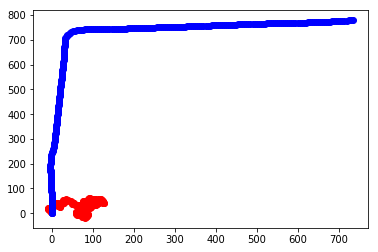

Count:1471
()
()
Relative Depth: 3.202878264296429
Relative x: 88.5446498477728
Relative Original Depth: -779.5151612096939
Relative Original x: 734.421234714726
Count:1472
()
()
Relative Depth: 3.436356447149653
Relative x: 88.18921859000696
Relative Original Depth: -779.6152450734949
Relative Original x: 735.4162071566316
Count:1473
()
()
Relative Depth: 3.2625534315664866
Relative x: 87.79803720403322
Relative Original Depth: -779.7487042243154
Relative Original x: 736.4070977127031
Count:1474
()
()
Relative Depth: 2.62827554150783
Relative x: 87.3091941511576
Relative Original Depth: -779.8810881957818
Relative Original x: 737.3979308656968
Count:1475
()
()
Relative Depth: 2.6137051538331915
Relative x: 86.43772513115078
Relative Original Depth: -779.9966556350429
Relative Original x: 738.3911256066506


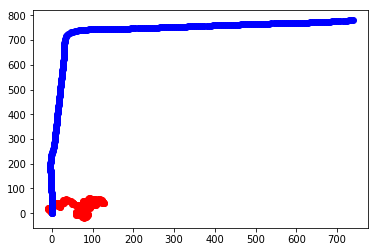

Count:1476
()
()
Relative Depth: 2.3901804723218736
Relative x: 86.88438674337368
Relative Original Depth: -780.1353091136423
Relative Original x: 739.3814665472191
Count:1477
()
()
Relative Depth: 2.8883956290073582
Relative x: 86.02806425553337
Relative Original Depth: -780.257962365069
Relative Original x: 740.3736526041766
Count:1478
()
()
Relative Depth: 3.4741808411145065
Relative x: 85.21790178799023
Relative Original Depth: -780.3936952205648
Relative Original x: 741.3642098417303
Count:1479
()
()
Relative Depth: 4.235832973134977
Relative x: 84.70075775688625
Relative Original Depth: -780.5240922318262
Relative Original x: 742.3551332457354
Count:1480
()
()
Relative Depth: 5.027849844224859
Relative x: 84.36841676570275
Relative Original Depth: -780.592417370354
Relative Original x: 743.3527912053646


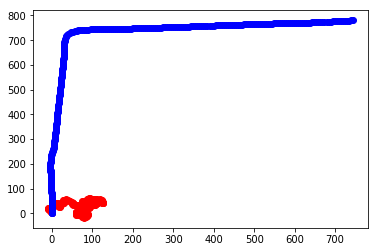

Count:1481
()
()
Relative Depth: 5.541317755821968
Relative x: 83.62942802050196
Relative Original Depth: -780.6621494292283
Relative Original x: 744.3503544979505
Count:1482
()
()
Relative Depth: 5.835582057967889
Relative x: 82.67375564277494
Relative Original Depth: -780.7555515101332
Relative Original x: 745.3443838951521
Count:1483
()
()
Relative Depth: 5.656167045829026
Relative x: 81.80209181114463
Relative Original Depth: -780.8063651755596
Relative Original x: 746.3430913782864
Count:1484
()
()
Relative Depth: 5.764037493263509
Relative x: 81.87830207989937
Relative Original Depth: -780.8973094569254
Relative Original x: 747.3378941127347
Count:1485
()
()
Relative Depth: 4.884467460833377
Relative x: 82.34231742436582
Relative Original Depth: -780.9878656668755
Relative Original x: 748.3336471938112


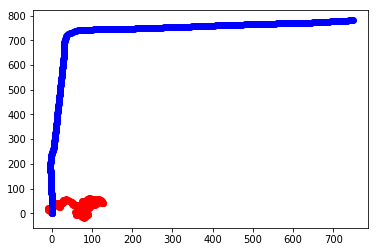

Count:1486
()
()
Relative Depth: 5.0675400366794685
Relative x: 81.42291111379355
Relative Original Depth: -781.112009517642
Relative Original x: 749.3256451090264
Count:1487
()
()
Relative Depth: 4.858411047521531
Relative x: 81.31710588881204
Relative Original Depth: -781.1854742477587
Relative Original x: 750.3229373707246
Count:1488
()
()
Relative Depth: 4.667209157258854
Relative x: 82.03558212234495
Relative Original Depth: -781.2486825528767
Relative Original x: 751.3208722885745
Count:1489
()
()
Relative Depth: 4.499083371717761
Relative x: 82.82610515308188
Relative Original Depth: -781.2840255692352
Relative Original x: 752.3190256038729
Count:1490
()
()
Relative Depth: 3.833601918191371
Relative x: 83.35840510869066
Relative Original Depth: -781.3249726537625
Relative Original x: 753.3173808329598


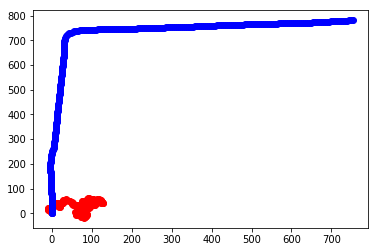

Count:1491
()
()
Relative Depth: 2.884381476724247
Relative x: 83.40093246207276
Relative Original Depth: -781.4018310565405
Relative Original x: 754.3143577035501
Count:1492
()
()
Relative Depth: 1.99236488003657
Relative x: 83.76670706656145
Relative Original Depth: -781.397008364002
Relative Original x: 755.3141097562055
Count:1493
()
()
Relative Depth: 2.262861435582923
Relative x: 83.62329517638287
Relative Original Depth: -781.3972289869726
Relative Original x: 756.3141027063086
Count:1494
()
()
Relative Depth: 2.206269541712838
Relative x: 82.75569956841403
Relative Original Depth: -781.3711991194624
Relative Original x: 757.3136758863354
Count:1495
()
()
Relative Depth: 1.5701207006612716
Relative x: 83.39873182028701
Relative Original Depth: -781.3081158549305
Relative Original x: 758.3101891106509


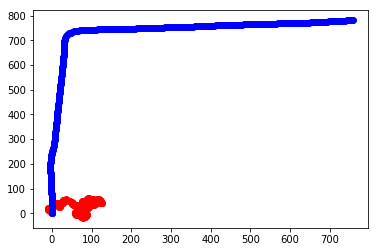

Count:1496
()
()
Relative Depth: 1.38880742705195
Relative x: 84.0621359957845
Relative Original Depth: -781.2296262574988
Relative Original x: 759.3063955792712
Count:1497
()
()
Relative Depth: 1.3617469430162328
Relative x: 84.2574663603027
Relative Original Depth: -781.2951875221396
Relative Original x: 760.3042441079318
Count:1498
()
()
Relative Depth: 0.6897474358618136
Relative x: 84.98502553864031
Relative Original Depth: -781.1636855818421
Relative Original x: 761.2944819714921
Count:1499
()
()
Relative Depth: 0.11982815640760036
Relative x: 85.7084419951722
Relative Original Depth: -781.1728222310404
Relative Original x: 762.2943528865208
Count:1500
()
()
Relative Depth: -0.5236018011123448
Relative x: 86.46953083326204
Relative Original Depth: -781.1190294161252
Relative Original x: 763.2912216919291


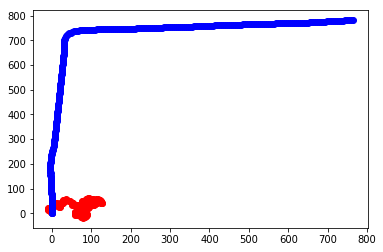

Count:1501
()
()
Relative Depth: -0.9258434181069564
Relative x: 87.18149710116852
Relative Original Depth: -780.9437198931063
Relative Original x: 764.2756816790479
Count:1502
()
()
Relative Depth: -1.197482255317329
Relative x: 87.79862011026258
Relative Original Depth: -780.7910759772419
Relative Original x: 765.261399175592
Count:1503
()
()
Relative Depth: -1.3110645554851577
Relative x: 88.23411305639264
Relative Original Depth: -780.6421180183145
Relative Original x: 766.2474903656134
Count:1504
()
()
Relative Depth: -1.458092449218794
Relative x: 88.65718415686132
Relative Original Depth: -780.4694379415668
Relative Original x: 767.2308053940242
Count:1505
()
()
Relative Depth: -1.5549735613287219
Relative x: 88.96303871950232
Relative Original Depth: -780.3970384777647
Relative Original x: 768.2271767084314


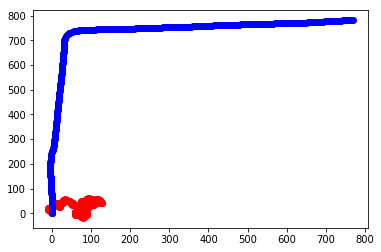

Count:1506
()
()
Relative Depth: -1.340630967310216
Relative x: 88.84493682783032
Relative Original Depth: -780.3771568561394
Relative Original x: 769.2267081285258
Count:1507
()
()
Relative Depth: -1.6269173483263113
Relative x: 88.75180474743513
Relative Original Depth: -780.2823049491976
Relative Original x: 770.2217214364355
Count:1508
()
()
Relative Depth: -2.516218309796612
Relative x: 88.94173309731252
Relative Original Depth: -780.1328573724574
Relative Original x: 771.2091130348285
Count:1509
()
()
Relative Depth: -3.4756665896857752
Relative x: 89.21101394695577
Relative Original Depth: -779.9281911460876
Relative Original x: 772.18383192808
Count:1510
()
()
Relative Depth: -4.2866623029879305
Relative x: 89.78033185852797
Relative Original Depth: -779.7948627908863
Relative Original x: 773.1725715920597


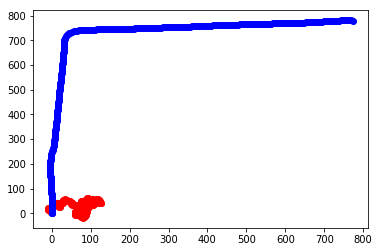

Count:1511
()
()
Relative Depth: -4.651859940830432
Relative x: 90.54513546972888
Relative Original Depth: -779.5724202948466
Relative Original x: 774.1470599118735
Count:1512
()
()
Relative Depth: -4.000016450151277
Relative x: 91.07563886237988
Relative Original Depth: -779.3148989266497
Relative Original x: 775.1131508248777
Count:1513
()
()
Relative Depth: -3.014041391309422
Relative x: 91.22688972209045
Relative Original Depth: -779.0232132105994
Relative Original x: 776.0672521106287
Count:1514
()
()
Relative Depth: -2.1273971394318143
Relative x: 90.88327188212926
Relative Original Depth: -778.7391622142862
Relative Original x: 777.026031236482
Count:1515
()
()
Relative Depth: -1.320049026054952
Relative x: 90.45394986560962
Relative Original Depth: -778.4328181017331
Relative Original x: 777.9770945424319


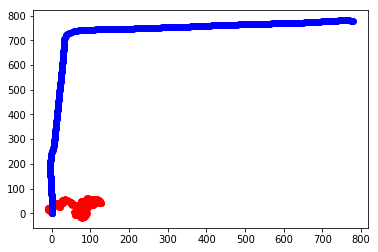

Count:1516
()
()
Relative Depth: -0.8036473271814902
Relative x: 89.8162565209328
Relative Original Depth: -778.1307624071004
Relative Original x: 778.9289498366741
Count:1517
()
()
Relative Depth: 0.18078019052442273
Relative x: 89.77046228288427
Relative Original Depth: -777.7531259074909
Relative Original x: 779.8537730734616
Count:1518
()
()
Relative Depth: 1.1204204764365246
Relative x: 89.99381048789735
Relative Original Depth: -777.3829017480695
Relative Original x: 780.7820912006631
Count:1519
()
()
Relative Depth: 1.8688732014825162
Relative x: 90.1212113572449
Relative Original Depth: -777.0662047745169
Relative Original x: 781.7305347595308
Count:1520
()
()
Relative Depth: 2.7787419432491878
Relative x: 90.03736331594358
Relative Original Depth: -776.9052570484604
Relative Original x: 782.7099308032481


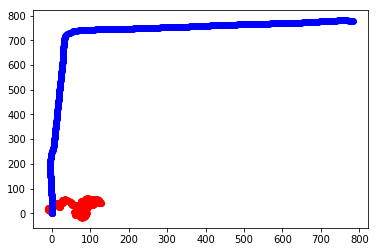

Count:1521
()
()
Relative Depth: 3.77265472476962
Relative x: 90.09188352090888
Relative Original Depth: -776.5250485209967
Relative Original x: 783.6344296179068
Count:1522
()
()
Relative Depth: 3.3317005447853503
Relative x: 89.63889866967762
Relative Original Depth: -776.160929669346
Relative Original x: 784.5655651521508
Count:1523
()
()
Relative Depth: 2.9609617399003176
Relative x: 89.8515827171193
Relative Original Depth: -775.7446143718695
Relative Original x: 785.4739670396177
Count:1524
()
()
Relative Depth: 2.465254453790162
Relative x: 90.13076641414072
Relative Original Depth: -775.2798015720899
Relative Original x: 786.3589763478573
Count:1525
()
()
Relative Depth: 1.8309857348593201
Relative x: 90.58518492450641
Relative Original Depth: -774.8426208659529
Relative Original x: 787.2574814347691


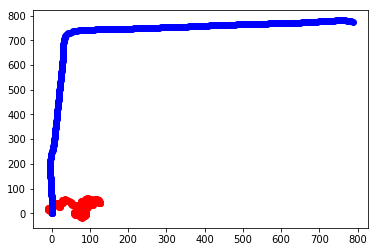

Count:1526
()
()
Relative Depth: 2.0659777721954016
Relative x: 90.51565490610892
Relative Original Depth: -774.4007185525269
Relative Original x: 788.1541207474593
Count:1527
()
()
Relative Depth: 1.4670574880014842
Relative x: 91.10448896002613
Relative Original Depth: -773.8886903613779
Relative Original x: 789.0098446501685
Count:1528
()
()
Relative Depth: 0.9421783453263479
Relative x: 91.75142050683283
Relative Original Depth: -773.3320747637173
Relative Original x: 789.83837075643
Count:1529
()
()
Relative Depth: 0.21366987997437803
Relative x: 92.31229735039251
Relative Original Depth: -772.8661982838721
Relative Original x: 790.7225606561046
Count:1530
()
()
Relative Depth: -0.6278788770402418
Relative x: 92.40773597429586
Relative Original Depth: -772.3491097413363
Relative Original x: 791.5783636098108


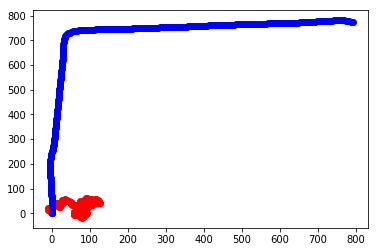

Count:1531
()
()
Relative Depth: -1.1828181695642246
Relative x: 92.2362673262152
Relative Original Depth: -771.534564805432
Relative Original x: 791.3117781456979
Count:1532
()
()
Relative Depth: -2.0757190712463123
Relative x: 92.23822092145663
Relative Original Depth: -770.943361712518
Relative Original x: 792.118244156425
Count:1533
()
()
Relative Depth: -2.562371630496986
Relative x: 92.1838243573927
Relative Original Depth: -770.3335529489532
Relative Original x: 792.9079187417531
Count:1534
()
()
Relative Depth: -3.33021128784772
Relative x: 92.26064412647413
Relative Original Depth: -769.6714241047156
Relative Original x: 793.6526769982748
Count:1535
()
()
Relative Depth: -4.102111381467692
Relative x: 92.78547398292659
Relative Original Depth: -768.9579512815017
Relative Original x: 794.3365222559764


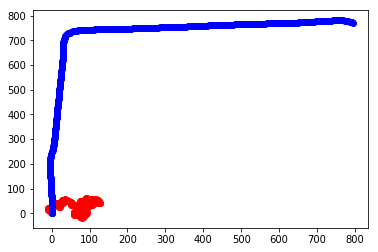

Count:1536
()
()
Relative Depth: -4.450970667739901
Relative x: 93.15399258105238
Relative Original Depth: -768.279016162595
Relative Original x: 795.0620917039282
Count:1537
()
()
Relative Depth: -4.836614805569977
Relative x: 92.91946876172815
Relative Original Depth: -767.585181339893
Relative Original x: 795.7811376177546
Count:1538
()
()
Relative Depth: -5.152912966236063
Relative x: 92.13285969446106
Relative Original Depth: -766.8882157534347
Relative Original x: 796.494731419516
Count:1539
()
()
Relative Depth: -5.698626316405527
Relative x: 91.5490809763501
Relative Original Depth: -766.209792918444
Relative Original x: 797.2246046484003
Count:1540
()
()
Relative Depth: -6.567117459412123
Relative x: 91.21948399050433
Relative Original Depth: -765.427568806652
Relative Original x: 797.8435632497043


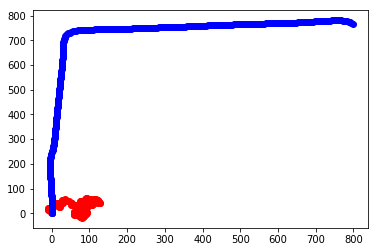

Count:1541
()
()
Relative Depth: -7.39381595166975
Relative x: 90.67277930644364
Relative Original Depth: -764.7006847260037
Relative Original x: 798.5278202580131
Count:1542
()
()
Relative Depth: -7.74196339238499
Relative x: 89.77891678188746
Relative Original Depth: -763.9177108761629
Relative Original x: 799.1319775731016
Count:1543
()
()
Relative Depth: -7.633573405007608
Relative x: 88.8105385495466
Relative Original Depth: -763.1794173014213
Relative Original x: 799.8040111192627
Count:1544
()
()
Relative Depth: -7.315275862171485
Relative x: 87.92644237493361
Relative Original Depth: -762.3872870857289
Relative Original x: 800.4104721499227
Count:1545
()
()
Relative Depth: -6.843722591210864
Relative x: 87.08444415964317
Relative Original Depth: -761.6364450769902
Relative Original x: 801.070874976904


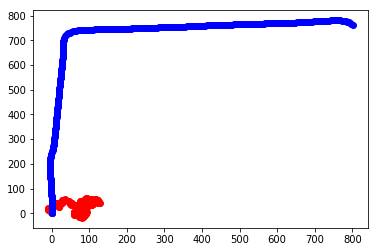

Count:1546
()
()
Relative Depth: -6.1481510946383136
Relative x: 86.42522454954107
Relative Original Depth: -760.8820785283907
Relative Original x: 801.7265301099402
Count:1547
()
()
Relative Depth: -5.261760460976291
Relative x: 86.21355744304635
Relative Original Depth: -760.0777471667061
Relative Original x: 802.3173242882382
Count:1548
()
()
Relative Depth: -4.297459489229912
Relative x: 86.07444859522718
Relative Original Depth: -759.2221656412286
Relative Original x: 802.8191230206133
Count:1549
()
()
Relative Depth: -3.3147807364939883
Relative x: 85.92819233367653
Relative Original Depth: -758.4054946630393
Relative Original x: 803.3893876736972
Count:1550
()
()
Relative Depth: -2.3402579563000803
Relative x: 85.91890425756638
Relative Original Depth: -757.585924200615
Relative Original x: 803.9535312573145


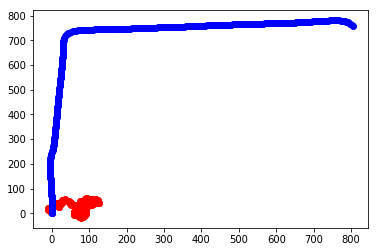

Count:1551
()
()
Relative Depth: -1.5180231532955855
Relative x: 85.94419308570396
Relative Original Depth: -756.7420218135035
Relative Original x: 804.484818903677
Count:1552
()
()
Relative Depth: -0.9760730052698683
Relative x: 85.94474755725984
Relative Original Depth: -755.9023019213608
Relative Original x: 805.020706893164
Count:1553
()
()
Relative Depth: -0.9830341437072462
Relative x: 85.43393993208618
Relative Original Depth: -755.0865108159821
Relative Original x: 805.5982825188846
Count:1554
()
()
Relative Depth: -1.496876559477073
Relative x: 84.5766143329798
Relative Original Depth: -754.2312769592762
Relative Original x: 806.1127193100829
Count:1555
()
()
Relative Depth: -2.1402455353868324
Relative x: 84.05037814332498
Relative Original Depth: -753.3694478064946
Relative Original x: 806.617341038121


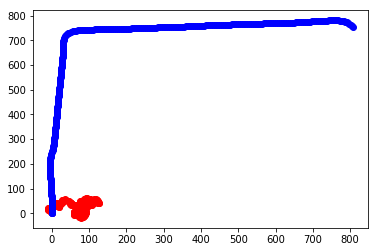

Count:1556
()
()
Relative Depth: -2.57367134548393
Relative x: 83.85001418438712
Relative Original Depth: -752.4922985949989
Relative Original x: 807.0832705676304
Count:1557
()
()
Relative Depth: -2.4386189493584225
Relative x: 83.6913329645722
Relative Original Depth: -751.6290636895371
Relative Original x: 807.5845016494499
Count:1558
()
()
Relative Depth: -2.1367064072159696
Relative x: 83.24140426144578
Relative Original Depth: -750.7821864839166
Relative Original x: 808.1094735604912
Count:1559
()
()
Relative Depth: -2.0209332610354065
Relative x: 82.65009645862166
Relative Original Depth: -749.8880411246406
Relative Original x: 808.5426385117231
Count:1560
()
()
Relative Depth: -1.7592409624088146
Relative x: 81.96585168772285
Relative Original Depth: -748.9775779966786
Relative Original x: 808.9336754112925


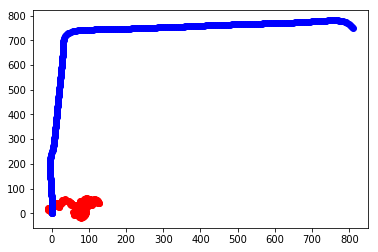

Count:1561
()
()
Relative Depth: -1.5421861439133637
Relative x: 81.07947855628778
Relative Original Depth: -748.0759391749671
Relative Original x: 809.3553198103258
Count:1562
()
()
Relative Depth: -1.5672949507427212
Relative x: 80.098059284614
Relative Original Depth: -747.1769210433197
Relative Original x: 809.7858867788354
Count:1563
()
()
Relative Depth: -1.6935515291290801
Relative x: 79.1063268235113
Relative Original Depth: -746.2878258617297
Relative Original x: 810.2383749428816
Count:1564
()
()
Relative Depth: -1.931834393945606
Relative x: 78.15357611924897
Relative Original Depth: -745.4103559764322
Relative Original x: 810.7161073621877
Count:1565
()
()
Relative Depth: -2.251825450964092
Relative x: 77.2134187672268
Relative Original Depth: -744.4752378606984
Relative Original x: 811.0601391531549


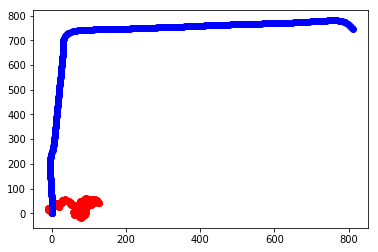

Count:1566
()
()
Relative Depth: -2.6821495247514524
Relative x: 76.31948633794228
Relative Original Depth: -743.5743655842241
Relative Original x: 811.4933806232204
Count:1567
()
()
Relative Depth: -3.217147275323091
Relative x: 75.5004044712362
Relative Original Depth: -742.694117699524
Relative Original x: 811.9666854975508
Count:1568
()
()
Relative Depth: -3.688094229839301
Relative x: 74.63068761534515
Relative Original Depth: -741.8140055798873
Relative Original x: 812.4338783126497
Count:1569
()
()
Relative Depth: -4.148418263243299
Relative x: 73.75729968701819
Relative Original Depth: -740.9234150802043
Relative Original x: 812.8881080299419
Count:1570
()
()
Relative Depth: -4.494190021821208
Relative x: 73.00478421061432
Relative Original Depth: -739.9798876791963
Relative Original x: 813.2098396741745


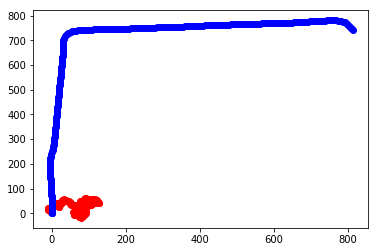

Count:1571
()
()
Relative Depth: -4.309003378504593
Relative x: 72.59362382016761
Relative Original Depth: -739.0531320943178
Relative Original x: 813.5784952607073
Count:1572
()
()
Relative Depth: -4.444187900502107
Relative x: 72.72742761021311
Relative Original Depth: -738.1245238265458
Relative Original x: 813.9425206433339
Count:1573
()
()
Relative Depth: -3.960110204263046
Relative x: 72.69533134892306
Relative Original Depth: -737.1893122410544
Relative Original x: 814.2857532733381
Count:1574
()
()
Relative Depth: -3.5280583194429034
Relative x: 72.69518510081008
Relative Original Depth: -736.2470168647379
Relative Original x: 814.606843534043
Count:1575
()
()
Relative Depth: -3.092038063511653
Relative x: 72.65993929687038
Relative Original Depth: -735.3089661646854
Relative Original x: 814.9426532538924


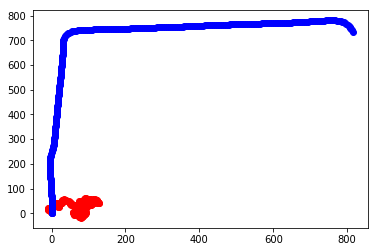

Count:1576
()
()
Relative Depth: -2.6410413304187834
Relative x: 73.32216306585268
Relative Original Depth: -734.371869380646
Relative Original x: 815.2831320925364
Count:1577
()
()
Relative Depth: -3.1860760095695024
Relative x: 72.52402255838103
Relative Original Depth: -733.4268079790922
Relative Original x: 815.6016306820212
Count:1578
()
()
Relative Depth: -2.761644939045623
Relative x: 72.48269220817893
Relative Original Depth: -732.5007686844475
Relative Original x: 815.9687286976498
Count:1579
()
()
Relative Depth: -2.3242522771517002
Relative x: 72.48084506675447
Relative Original Depth: -731.5729451228631
Relative Original x: 816.3330857235543
Count:1580
()
()
Relative Depth: -1.46816239179096
Relative x: 72.57957872995107
Relative Original Depth: -730.6350263599933
Relative Original x: 816.668569014059


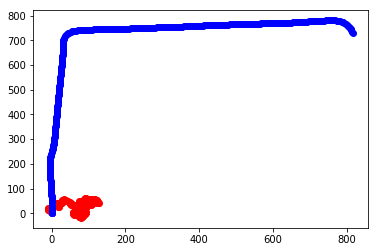

Count:1581
()
()
Relative Depth: -0.49775787057122334
Relative x: 72.81899822913797
Relative Original Depth: -729.7088913154645
Relative Original x: 817.0368356413558
Count:1582
()
()
Relative Depth: 0.43977357358853375
Relative x: 73.16034560474046
Relative Original Depth: -728.7968399318772
Relative Original x: 817.4402408317324
Count:1583
()
()
Relative Depth: 1.3492541760167618
Relative x: 73.51798106091327
Relative Original Depth: -727.8654398166194
Relative Original x: 817.8001452356068
Count:1584
()
()
Relative Depth: 2.2903506853375317
Relative x: 73.76997434765941
Relative Original Depth: -726.9416252488435
Relative Original x: 818.1777782076621
Count:1585
()
()
Relative Depth: 3.0987656555330707
Relative x: 74.26183295870966
Relative Original Depth: -726.0144894756343
Relative Original x: 818.542492647485


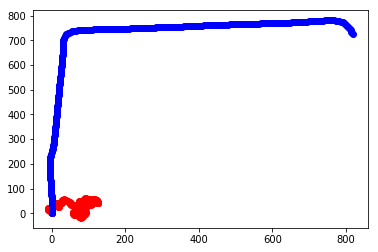

Count:1586
()
()
Relative Depth: 3.752923800296635
Relative x: 74.92688573201208
Relative Original Depth: -725.0787194069123
Relative Original x: 818.8879268482482
Count:1587
()
()
Relative Depth: 4.566971421042018
Relative x: 75.48871182782634
Relative Original Depth: -724.1440676937071
Relative Original x: 819.2342082841674
Count:1588
()
()
Relative Depth: 5.4746089934992765
Relative x: 75.90217183762074
Relative Original Depth: -723.2133201815756
Relative Original x: 819.5731342097312
Count:1589
()
()
Relative Depth: 6.46279019081642
Relative x: 76.03860387973917
Relative Original Depth: -722.2911353114515
Relative Original x: 819.9539811647346
Count:1590
()
()
Relative Depth: 7.434135866387451
Relative x: 75.80260601542392
Relative Original Depth: -721.3619812852984
Relative Original x: 820.3157846566048


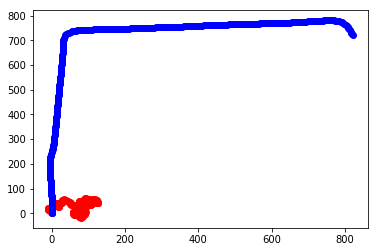

Count:1591
()
()
Relative Depth: 8.287892313319423
Relative x: 75.2819375004607
Relative Original Depth: -720.4350953678761
Relative Original x: 820.6869023792377
Count:1592
()
()
Relative Depth: 9.11945162969536
Relative x: 74.75592113372967
Relative Original Depth: -719.4979199178073
Relative Original x: 821.0275217833572
Count:1593
()
()
Relative Depth: 10.111719948788117
Relative x: 74.6370346562684
Relative Original Depth: -718.5522550960927
Relative Original x: 821.3424469788629
Count:1594
()
()
Relative Depth: 10.995587004834181
Relative x: 75.00275741427178
Relative Original Depth: -717.6289452184882
Relative Original x: 821.7192988426659
Count:1595
()
()
Relative Depth: 11.46619769061643
Relative x: 75.31202298156708
Relative Original Depth: -716.7000725449624
Relative Original x: 822.0816634440005


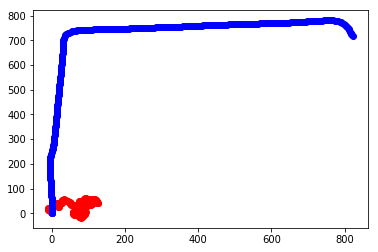

Count:1596
()
()
Relative Depth: 10.776072630229368
Relative x: 75.80526421992687
Relative Original Depth: -715.7713350624196
Relative Original x: 822.4483179921914
Count:1597
()
()
Relative Depth: 11.338987074011513
Relative x: 76.06752317436201
Relative Original Depth: -714.8252922070038
Relative Original x: 822.7687138893015
Count:1598
()
()
Relative Depth: 11.967466081521735
Relative x: 76.30673225900122
Relative Original Depth: -713.9018495129496
Relative Original x: 823.1484050199557
Count:1599
()
()
Relative Depth: 12.467936760540411
Relative x: 76.58770010154603
Relative Original Depth: -712.9609649600095
Relative Original x: 823.48436213662
Count:1600
()
()
Relative Depth: 11.723880991302522
Relative x: 77.25533065032933
Relative Original Depth: -712.0225400499655
Relative Original x: 823.8213768182325


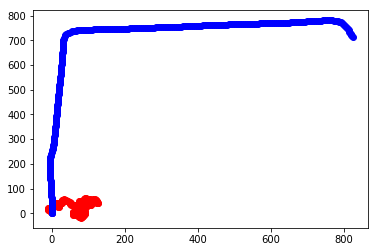

Count:1601
()
()
Relative Depth: 12.25131402701439
Relative x: 77.84654643869295
Relative Original Depth: -711.0836627375679
Relative Original x: 824.1524970210728
Count:1602
()
()
Relative Depth: 12.934224309651075
Relative x: 78.49410058125386
Relative Original Depth: -710.1372780441587
Relative Original x: 824.4682165163374
Count:1603
()
()
Relative Depth: 13.624526954312216
Relative x: 79.20259457228032
Relative Original Depth: -709.1781932791838
Relative Original x: 824.7338384528124
Count:1604
()
()
Relative Depth: 14.197551165918101
Relative x: 80.01070720919004
Relative Original Depth: -708.2542936751543
Relative Original x: 825.1131201346934
Count:1605
()
()
Relative Depth: 14.73057164457193
Relative x: 80.85357099410807
Relative Original Depth: -707.3243291770684
Relative Original x: 825.4756987170044


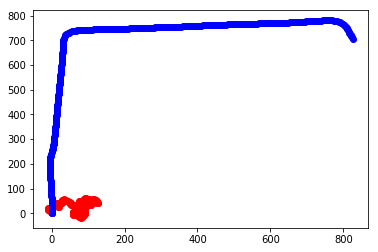

Count:1606
()
()
Relative Depth: 15.052916670917607
Relative x: 81.794273260623
Relative Original Depth: -706.3749683841498
Relative Original x: 825.7804635524557
Count:1607
()
()
Relative Depth: 15.041679719178749
Relative x: 82.79308778337676
Relative Original Depth: -705.4322759728501
Relative Original x: 826.1100500208479
Count:1608
()
()
Relative Depth: 14.918997800646851
Relative x: 83.76630859923888
Relative Original Depth: -704.5102671723324
Relative Original x: 826.4904511885808
Count:1609
()
()
Relative Depth: 14.725460385958309
Relative x: 84.56038872943137
Relative Original Depth: -703.5665511717023
Relative Original x: 826.8123535546379
Count:1610
()
()
Relative Depth: 14.162399399344466
Relative x: 85.26179610137153
Relative Original Depth: -702.6304440382859
Relative Original x: 827.1573667759569


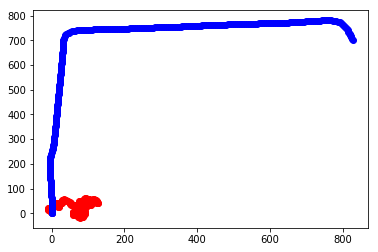

Count:1611
()
()
Relative Depth: 13.490363991208847
Relative x: 85.87236036941962
Relative Original Depth: -701.6836546958389
Relative Original x: 827.4712926241389
Count:1612
()
()
Relative Depth: 12.883736359319407
Relative x: 86.65547172850538
Relative Original Depth: -700.7597978330975
Relative Original x: 827.846899351775
Count:1613
()
()
Relative Depth: 12.369410872237333
Relative x: 87.25437918761851
Relative Original Depth: -699.8092820900126
Relative Original x: 828.1504745420267
Count:1614
()
()
Relative Depth: 11.811617611597654
Relative x: 87.67875040656018
Relative Original Depth: -698.9169404501231
Relative Original x: 828.5808355291766
Count:1615
()
()
Relative Depth: 11.203633748061607
Relative x: 87.85904001157279
Relative Original Depth: -697.9869367168928
Relative Original x: 828.9413693046117


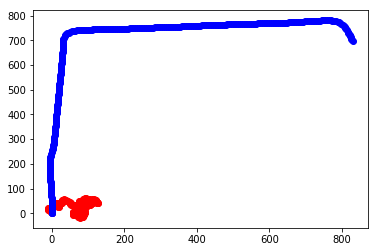

Count:1616
()
()
Relative Depth: 10.660866837601334
Relative x: 88.06110757999534
Relative Original Depth: -697.0521923275595
Relative Original x: 829.2926977036007
Count:1617
()
()
Relative Depth: 10.46744746208952
Relative x: 88.60479232344265
Relative Original Depth: -696.1071619301335
Relative Original x: 829.6054168326596
Count:1618
()
()
Relative Depth: 10.54474248802971
Relative x: 89.34458707254653
Relative Original Depth: -695.1497017649234
Relative Original x: 829.8809027227869
Count:1619
()
()
Relative Depth: 10.361903776166246
Relative x: 90.3271003499217
Relative Original Depth: -694.2070175042071
Relative Original x: 830.2096866237658
Count:1620
()
()
Relative Depth: 10.318565806477581
Relative x: 91.05120735594957
Relative Original Depth: -693.2696520571078
Relative Original x: 830.5522028559957


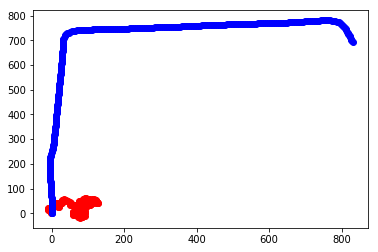

Count:1621
()
()
Relative Depth: 9.875256389269275
Relative x: 91.69670829859801
Relative Original Depth: -692.3365507210973
Relative Original x: 830.910895908385
Count:1622
()
()
Relative Depth: 9.188023333708191
Relative x: 92.29644792930632
Relative Original Depth: -691.3972336601596
Relative Original x: 831.2532045371114
Count:1623
()
()
Relative Depth: 8.56979065813417
Relative x: 92.98455822876117
Relative Original Depth: -690.4609709952928
Relative Original x: 831.6024620999194
Count:1624
()
()
Relative Depth: 8.110129331402502
Relative x: 93.76891780085775
Relative Original Depth: -689.5592369035614
Relative Original x: 832.0318564920029
Count:1625
()
()
Relative Depth: 7.74964281143904
Relative x: 94.64527807906252
Relative Original Depth: -688.6124838289027
Relative Original x: 832.3519749371644


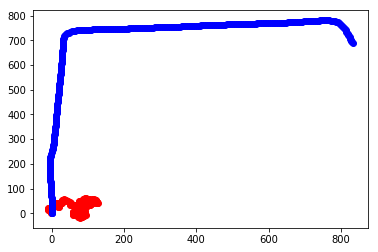

Count:1626
()
()
Relative Depth: 7.344951937240847
Relative x: 95.53574594367849
Relative Original Depth: -687.6643077423305
Relative Original x: 832.6635702138482
Count:1627
()
()
Relative Depth: 6.951963450743365
Relative x: 96.45523010855645
Relative Original Depth: -686.7179288040869
Relative Original x: 832.9814286152794
Count:1628
()
()
Relative Depth: 6.617043556250348
Relative x: 97.27330049846998
Relative Original Depth: -685.8294142014086
Relative Original x: 833.4273042129156
Count:1629
()
()
Relative Depth: 6.26008908728068
Relative x: 97.9542267675403
Relative Original Depth: -684.8959140664188
Relative Original x: 833.7623435453604
Count:1630
()
()
Relative Depth: 5.850571462395307
Relative x: 98.26489333938889
Relative Original Depth: -683.9867795467273
Relative Original x: 834.1585025322704


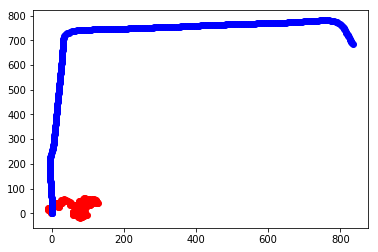

Count:1631
()
()
Relative Depth: 5.64656515960146
Relative x: 97.93621871851147
Relative Original Depth: -683.115293358329
Relative Original x: 834.6284348483738
Count:1632
()
()
Relative Depth: 5.505555715148232
Relative x: 97.1661905056571
Relative Original Depth: -682.1970128813504
Relative Original x: 835.0088280819882
Count:1633
()
()
Relative Depth: 5.334722088594593
Relative x: 96.24647419779681
Relative Original Depth: -681.2494355430864
Relative Original x: 835.3145249630452
Count:1634
()
()
Relative Depth: 5.202637777301888
Relative x: 95.29934152806076
Relative Original Depth: -680.2961062427852
Relative Original x: 835.6069427056199
Count:1635
()
()
Relative Depth: 5.161218224988322
Relative x: 94.3051906485017
Relative Original Depth: -679.3373862883936
Relative Original x: 835.8768009793795


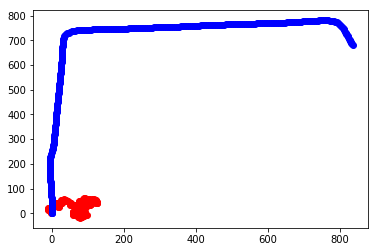

Count:1636
()
()
Relative Depth: 5.193223548862405
Relative x: 93.30596294622177
Relative Original Depth: -678.393906640949
Relative Original x: 836.200680138897
Count:1637
()
()
Relative Depth: 5.420908751181741
Relative x: 92.33415489596423
Relative Original Depth: -677.4586527775094
Relative Original x: 836.5523175398888
Count:1638
()
()
Relative Depth: 5.878413070854894
Relative x: 91.45459374336485
Relative Original Depth: -676.513986801658
Relative Original x: 836.8709350728595
Count:1639
()
()
Relative Depth: 6.355746626477418
Relative x: 90.57606107308278
Relative Original Depth: -675.5900563806202
Relative Original x: 837.2508964251267
Count:1640
()
()
Relative Depth: 7.133791382510869
Relative x: 90.68077567418052
Relative Original Depth: -674.6584302652115
Relative Original x: 837.6076955622057


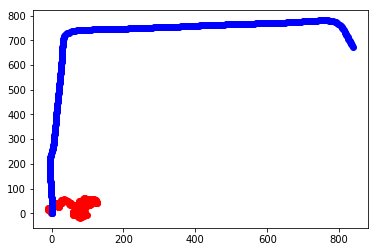

Count:1641
()
()
Relative Depth: 6.951553388100701
Relative x: 90.18488158917954
Relative Original Depth: -673.7273092349599
Relative Original x: 837.9609206341505
Count:1642
()
()
Relative Depth: 7.037703856768218
Relative x: 89.39197143776984
Relative Original Depth: -672.8148618085402
Relative Original x: 838.3563130753788
Count:1643
()
()
Relative Depth: 6.583249813624304
Relative x: 90.20169894513599
Relative Original Depth: -671.8880299211796
Relative Original x: 838.71981527301
Count:1644
()
()
Relative Depth: 6.355671989831384
Relative x: 89.74463236075614
Relative Original Depth: -670.9421905285448
Relative Original x: 839.0226951666177
Count:1645
()
()
Relative Depth: 6.185845075864435
Relative x: 89.19076968991355
Relative Original Depth: -670.0047779777968
Relative Original x: 839.3600840452573


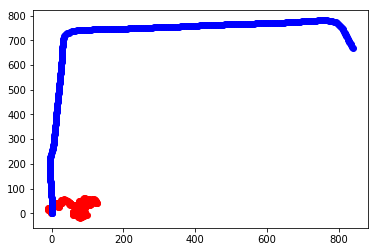

Count:1646
()
()
Relative Depth: 6.109789490850939
Relative x: 88.40022801033699
Relative Original Depth: -669.0687828922229
Relative Original x: 839.7031334529339
Count:1647
()
()
Relative Depth: 6.653611663489611
Relative x: 88.61126138879499
Relative Original Depth: -668.1254036540448
Relative Original x: 840.0219409891862
Count:1648
()
()
Relative Depth: 6.757567253302717
Relative x: 87.70347507882221
Relative Original Depth: -667.187791106655
Relative Original x: 840.3619746689036
Count:1649
()
()
Relative Depth: 6.803569608626664
Relative x: 86.90736635001674
Relative Original Depth: -666.2405299059592
Relative Original x: 840.6782291067713
Count:1650
()
()
Relative Depth: 6.846713743114456
Relative x: 86.28207944875803
Relative Original Depth: -665.2992125743446
Relative Original x: 841.0069619104107


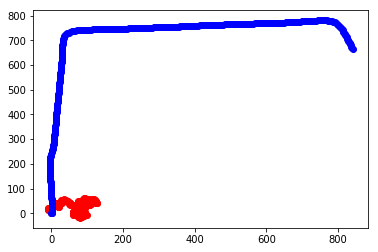

Count:1651
()
()
Relative Depth: 6.977503292134306
Relative x: 85.60195263682272
Relative Original Depth: -664.3692282867871
Relative Original x: 841.3673662582729
Count:1652
()
()
Relative Depth: 7.229108883989845
Relative x: 84.79830843623708
Relative Original Depth: -663.448907422715
Relative Original x: 841.7519311719554
Count:1653
()
()
Relative Depth: 7.332043563713215
Relative x: 83.98328584629783
Relative Original Depth: -662.522740578454
Relative Original x: 842.1226692980973
Count:1654
()
()
Relative Depth: 7.555540241384567
Relative x: 83.22891350308527
Relative Original Depth: -661.5872996541585
Relative Original x: 842.4657551945404
Count:1655
()
()
Relative Depth: 8.178238541929991
Relative x: 82.5292152634048
Relative Original Depth: -660.6884691050471
Relative Original x: 842.886008726924


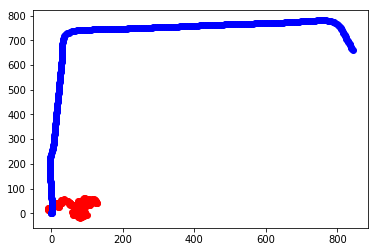

Count:1656
()
()
Relative Depth: 8.775881509820106
Relative x: 81.78735448798109
Relative Original Depth: -659.7603237343463
Relative Original x: 843.2545944561634
Count:1657
()
()
Relative Depth: 9.43544125082351
Relative x: 81.0461824968888
Relative Original Depth: -658.8191903160005
Relative Original x: 843.5855370690603
Count:1658
()
()
Relative Depth: 9.918259700496359
Relative x: 80.22136644909796
Relative Original Depth: -657.8843716138155
Relative Original x: 843.9352173529448
Count:1659
()
()
Relative Depth: 10.185332916113262
Relative x: 79.43663607079425
Relative Original Depth: -656.9554386584061
Relative Original x: 844.3005540228047
Count:1660
()
()
Relative Depth: 10.401241135878653
Relative x: 78.73552618814757
Relative Original Depth: -656.0252726515091
Relative Original x: 844.6600968945838


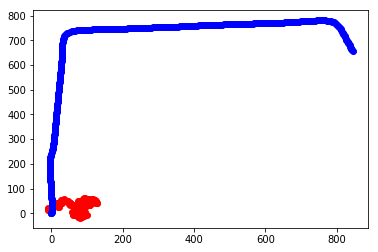

Count:1661
()
()
Relative Depth: 10.480583776447974
Relative x: 78.13813161619483
Relative Original Depth: -655.0976633907325
Relative Original x: 845.0276627558923
Count:1662
()
()
Relative Depth: 10.637922384376976
Relative x: 77.42979657888051
Relative Original Depth: -654.1606767539079
Relative Original x: 845.3641798856404
Count:1663
()
()
Relative Depth: 10.82211576266344
Relative x: 76.67123054563875
Relative Original Depth: -653.2159384288428
Relative Original x: 845.6746424338952
Count:1664
()
()
Relative Depth: 11.121875802582856
Relative x: 75.90710978586347
Relative Original Depth: -652.3020650401128
Relative Original x: 846.074567022835
Count:1665
()
()
Relative Depth: 11.363766846323488
Relative x: 75.13178472009092
Relative Original Depth: -651.3682619988688
Relative Original x: 846.4217165415707


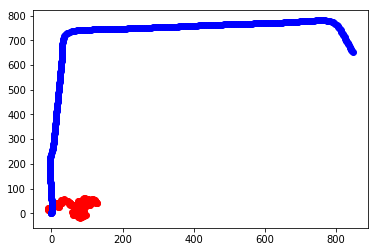

Count:1666
()
()
Relative Depth: 11.165556360501556
Relative x: 75.24751895713125
Relative Original Depth: -650.4328672303172
Relative Original x: 846.7568203400359
Count:1667
()
()
Relative Depth: 11.621001274231137
Relative x: 74.40767603539719
Relative Original Depth: -649.520277320871
Relative Original x: 847.1632467206227
Count:1668
()
()
Relative Depth: 12.119250295691536
Relative x: 73.54488471535892
Relative Original Depth: -648.5927720127261
Relative Original x: 847.5301015606686
Count:1669
()
()
Relative Depth: 12.7740754647908
Relative x: 72.78950098972992
Relative Original Depth: -647.665924859272
Relative Original x: 847.8961881637994
Count:1670
()
()
Relative Depth: 13.21181815246988
Relative x: 71.9357275616994
Relative Original Depth: -646.7493648463712
Relative Original x: 848.2846997602265


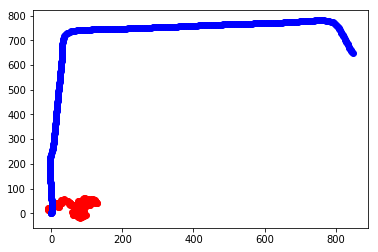

Count:1671
()
()
Relative Depth: 13.11267816741146
Relative x: 71.32133448848232
Relative Original Depth: -645.8217894378523
Relative Original x: 848.6505091295967
Count:1672
()
()
Relative Depth: 12.59800797835816
Relative x: 71.24568601224996
Relative Original Depth: -644.9074087556324
Relative Original x: 849.0467832593133
Count:1673
()
()
Relative Depth: 12.016466873852043
Relative x: 71.221519042453
Relative Original Depth: -643.9859045595005
Relative Original x: 849.4319897446737
Count:1674
()
()
Relative Depth: 11.424144962445464
Relative x: 71.10081812908383
Relative Original Depth: -643.070893497089
Relative Original x: 849.8338803752426
Count:1675
()
()
Relative Depth: 10.660599130116791
Relative x: 71.19347171686961
Relative Original Depth: -642.1789666763281
Relative Original x: 850.285143838795


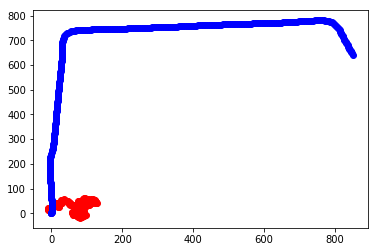

Count:1676
()
()
Relative Depth: 9.88256557946275
Relative x: 71.52817298918909
Relative Original Depth: -641.2645758981331
Relative Original x: 850.6862907633736
Count:1677
()
()
Relative Depth: 9.133665704282993
Relative x: 71.84410568425103
Relative Original Depth: -640.3440601340814
Relative Original x: 851.0676163967083
Count:1678
()
()
Relative Depth: 8.407021626523516
Relative x: 72.24081579203582
Relative Original Depth: -639.4309495285509
Relative Original x: 851.4745685800527
Count:1679
()
()
Relative Depth: 7.699386074935177
Relative x: 72.70537428133196
Relative Original Depth: -638.5433208062409
Relative Original x: 851.9343934744705
Count:1680
()
()
Relative Depth: 7.571858980184854
Relative x: 73.20887518461848
Relative Original Depth: -637.6310768529253
Relative Original x: 852.3406453505131


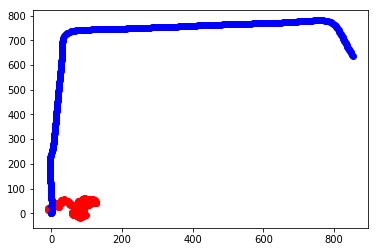

Count:1681
()
()
Relative Depth: 6.801198510489464
Relative x: 73.39739227877928
Relative Original Depth: -636.728635950281
Relative Original x: 852.7682706683431
Count:1682
()
()
Relative Depth: 5.827381747244928
Relative x: 73.62471513319811
Relative Original Depth: -635.821591118165
Relative Original x: 853.1830533004025
Count:1683
()
()
Relative Depth: 6.792225484278494
Relative x: 73.38145502721785
Relative Original Depth: -634.9126813932589
Relative Original x: 853.5930065237768
Count:1684
()
()
Relative Depth: 5.918795875712869
Relative x: 73.43791600669415
Relative Original Depth: -633.9995588241164
Relative Original x: 853.9935676006377
Count:1685
()
()
Relative Depth: 5.035890804122639
Relative x: 73.27257881389484
Relative Original Depth: -633.0880908754509
Relative Original x: 854.3956836699862


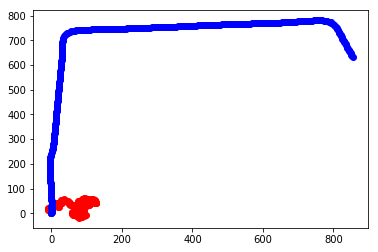

Count:1686
()
()
Relative Depth: 4.458865296214319
Relative x: 72.6332941023891
Relative Original Depth: -632.1674138063909
Relative Original x: 854.768310180176
Count:1687
()
()
Relative Depth: 4.592858601767931
Relative x: 71.72683178588912
Relative Original Depth: -631.2489286274152
Relative Original x: 855.1529978823371
Count:1688
()
()
Relative Depth: 5.266204746561481
Relative x: 71.01595780773066
Relative Original Depth: -630.3418837045198
Relative Original x: 855.5676567551998
Count:1689
()
()
Relative Depth: 6.015105964601507
Relative x: 70.41957417060028
Relative Original Depth: -629.4354625493696
Relative Original x: 855.9825008853365
Count:1690
()
()
Relative Depth: 6.803860685654092
Relative x: 69.91037059026746
Relative Original Depth: -628.5287640869443
Relative Original x: 856.3997502249917


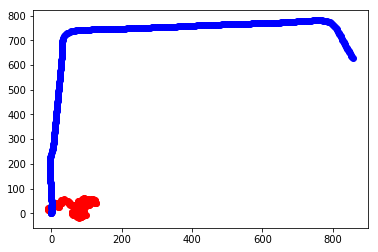

Count:1691
()
()
Relative Depth: 7.6130486040566465
Relative x: 69.71188648161782
Relative Original Depth: -627.6379142663708
Relative Original x: 856.8519478332972
Count:1692
()
()
Relative Depth: 8.343943974315616
Relative x: 69.80448417838882
Relative Original Depth: -626.7409488685716
Relative Original x: 857.2859266258743
Count:1693
()
()
Relative Depth: 9.146144672561837
Relative x: 69.94999045048009
Relative Original Depth: -625.8359462427984
Relative Original x: 857.7040971393294
Count:1694
()
()
Relative Depth: 9.926745284653583
Relative x: 70.12616220423857
Relative Original Depth: -624.9175454332076
Relative Original x: 858.0913707155387
Count:1695
()
()
Relative Depth: 10.698877674804317
Relative x: 70.38352930750504
Relative Original Depth: -623.9913314936185
Relative Original x: 858.4624541595826


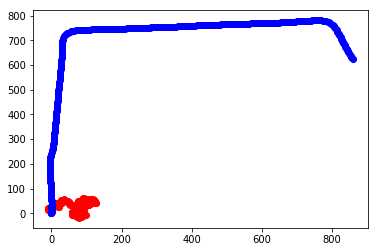

Count:1696
()
()
Relative Depth: 11.504849412839684
Relative x: 70.81891782066393
Relative Original Depth: -623.0755121045665
Relative Original x: 858.858579696111
Count:1697
()
()
Relative Depth: 12.318919561468352
Relative x: 71.23211014850486
Relative Original Depth: -622.1567140989433
Relative Original x: 859.246640674065
Count:1698
()
()
Relative Depth: 13.26021321259739
Relative x: 71.54130451178978
Relative Original Depth: -621.24730952859
Relative Original x: 859.6531341168901
Count:1699
()
()
Relative Depth: 14.149154875686179
Relative x: 71.89312292861622
Relative Original Depth: -620.3475950437795
Relative Original x: 860.0824229293894
Count:1700
()
()
Relative Depth: 15.072822218362424
Relative x: 72.25617784460113
Relative Original Depth: -619.4469456577698
Relative Original x: 860.5128269361117


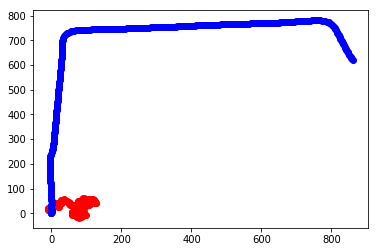

Count:1701
()
()
Relative Depth: 15.914249144393784
Relative x: 72.25215442106334
Relative Original Depth: -618.5367666856914
Relative Original x: 860.9231941000849
Count:1702
()
()
Relative Depth: 16.52286714753675
Relative x: 72.10360924612941
Relative Original Depth: -617.6126645127819
Relative Original x: 861.2945620954281
Count:1703
()
()
Relative Depth: 17.054731263514366
Relative x: 71.97106667926111
Relative Original Depth: -616.7050062833663
Relative Original x: 861.7110266903584
Count:1704
()
()
Relative Depth: 17.52371502571586
Relative x: 72.78861825054098
Relative Original Depth: -615.8003866485551
Relative Original x: 862.132756567231
Count:1705
()
()
Relative Depth: 17.946680447209705
Relative x: 72.71213866217202
Relative Original Depth: -614.895143099303
Relative Original x: 862.553368212685


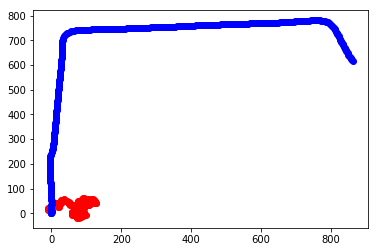

Count:1706
()
()
Relative Depth: 18.36260521431595
Relative x: 72.64799310637076
Relative Original Depth: -613.9775723787454
Relative Original x: 862.943461949798
Count:1707
()
()
Relative Depth: 18.74981844533068
Relative x: 72.4365522748504
Relative Original Depth: -613.0655990516482
Relative Original x: 863.342459377694
Count:1708
()
()
Relative Depth: 19.123186102980593
Relative x: 72.05485880783496
Relative Original Depth: -612.1422090147762
Relative Original x: 863.7164253679111
Count:1709
()
()
Relative Depth: 19.558057209644957
Relative x: 71.72571975440574
Relative Original Depth: -611.2303190845278
Relative Original x: 864.1130781220278
Count:1710
()
()
Relative Depth: 20.233120512103795
Relative x: 71.37007017143772
Relative Original Depth: -610.3179766624582
Relative Original x: 864.5119890451907


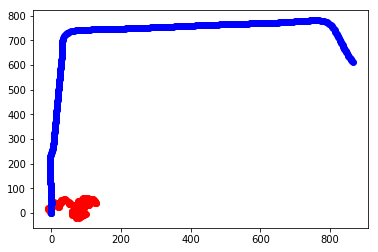

Count:1711
()
()
Relative Depth: 21.12378364041592
Relative x: 71.0517897257534
Relative Original Depth: -609.4093316638107
Relative Original x: 864.9200508438956
Count:1712
()
()
Relative Depth: 21.710585173599526
Relative x: 71.55598607750005
Relative Original Depth: -608.4983320084966
Relative Original x: 865.325231183469
Count:1713
()
()
Relative Depth: 22.6549924363245
Relative x: 71.30447275444007
Relative Original Depth: -607.586559778738
Relative Original x: 865.72965040585
Count:1714
()
()
Relative Depth: 23.57461952644649
Relative x: 71.08248053886209
Relative Original Depth: -606.6699332336086
Relative Original x: 866.1215833666196
Count:1715
()
()
Relative Depth: 24.499679531491996
Relative x: 70.89523330118169
Relative Original Depth: -605.7574109348642
Relative Original x: 866.51712210558


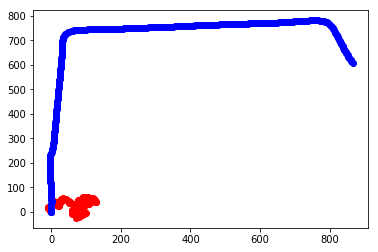

Count:1716
()
()
Relative Depth: 25.430082625654492
Relative x: 70.70952454936113
Relative Original Depth: -604.8329856941907
Relative Original x: 866.8897057614195
Count:1717
()
()
Relative Depth: 26.400890832813293
Relative x: 70.58831002860471
Relative Original Depth: -603.9097012270142
Relative Original x: 867.2691335839133
Count:1718
()
()
Relative Depth: 27.399815775877226
Relative x: 70.54196531459841
Relative Original Depth: -602.9891978427623
Relative Original x: 867.6565765955892
Count:1719
()
()
Relative Depth: 28.397424081344194
Relative x: 70.47284995677099
Relative Original Depth: -602.0724493446083
Relative Original x: 868.0545226135589
Count:1720
()
()
Relative Depth: 29.387192022306774
Relative x: 70.3323574657056
Relative Original Depth: -601.1492867490749
Relative Original x: 868.4379140975176


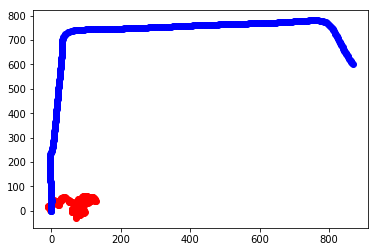

Count:1721
()
()
Relative Depth: 30.35860527505214
Relative x: 70.09640500073301
Relative Original Depth: -600.234877319325
Relative Original x: 868.8417660128779
Count:1722
()
()
Relative Depth: 31.31691881084031
Relative x: 69.81636353656951
Relative Original Depth: -599.3176064412113
Relative Original x: 869.2368900546062
Count:1723
()
()
Relative Depth: 32.30061155131406
Relative x: 69.65024516086707
Relative Original Depth: -598.4010110995055
Relative Original x: 869.6278307688208
Count:1724
()
()
Relative Depth: 33.28514189064579
Relative x: 69.67075430877141
Relative Original Depth: -597.4763410549017
Relative Original x: 870.001353021826
Count:1725
()
()
Relative Depth: 34.23913144985676
Relative x: 69.75290084460109
Relative Original Depth: -596.5456779397117
Relative Original x: 870.3565952853833


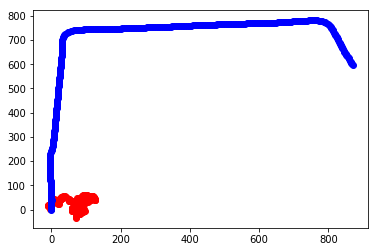

Count:1726
()
()
Relative Depth: 35.14827342912965
Relative x: 69.8514418643026
Relative Original Depth: -595.6188719000503
Relative Original x: 870.7211048923638
Count:1727
()
()
Relative Depth: 36.02866416534973
Relative x: 69.64312686128933
Relative Original Depth: -594.693942871457
Relative Original x: 871.0900068343984
Count:1728
()
()
Relative Depth: 36.71747773071151
Relative x: 69.11224762829856
Relative Original Depth: -593.7682874069669
Relative Original x: 871.4597390783268
Count:1729
()
()
Relative Depth: 36.916248582344195
Relative x: 68.63530817430981
Relative Original Depth: -592.8507716416184
Relative Original x: 871.846746791039
Count:1730
()
()
Relative Depth: 37.073370562899626
Relative x: 67.72626620425544
Relative Original Depth: -591.9274148060064
Relative Original x: 872.2244416633409


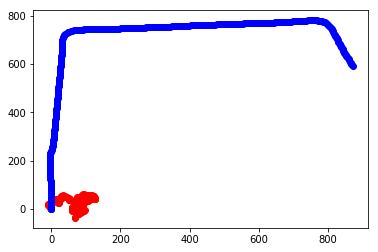

Count:1731
()
()
Relative Depth: 37.43648783571588
Relative x: 66.96311068008056
Relative Original Depth: -591.0149599657082
Relative Original x: 872.6247521181532
Count:1732
()
()
Relative Depth: 37.81298497722473
Relative x: 66.24960685452888
Relative Original Depth: -590.0920603899468
Relative Original x: 872.9999513083143
Count:1733
()
()
Relative Depth: 38.10430072150327
Relative x: 65.55449091797838
Relative Original Depth: -589.1608048862498
Relative Original x: 873.3546930698888
Count:1734
()
()
Relative Depth: 38.32476911435399
Relative x: 64.89127890715446
Relative Original Depth: -588.2239118916676
Relative Original x: 873.6924937708922
Count:1735
()
()
Relative Depth: 38.49471639397647
Relative x: 63.94768878260316
Relative Original Depth: -587.2905820881355
Relative Original x: 874.0390505166858


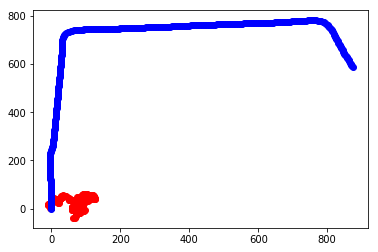

Count:1736
()
()
Relative Depth: 38.514317867618516
Relative x: 63.00408082917176
Relative Original Depth: -586.3557257321819
Relative Original x: 874.3877526943297
Count:1737
()
()
Relative Depth: 38.47339257194436
Relative x: 62.06406297967971
Relative Original Depth: -585.4261586787976
Relative Original x: 874.7503788581145
Count:1738
()
()
Relative Depth: 38.37883212069
Relative x: 61.096485922536324
Relative Original Depth: -584.5026008720494
Relative Original x: 875.1283614831835
Count:1739
()
()
Relative Depth: 38.385991466621086
Relative x: 60.179613545509206
Relative Original Depth: -583.5765470950488
Relative Original x: 875.5009893976112
Count:1740
()
()
Relative Depth: 38.459072230870404
Relative x: 59.328037627130314
Relative Original Depth: -582.6500534740803
Relative Original x: 875.8714243448732


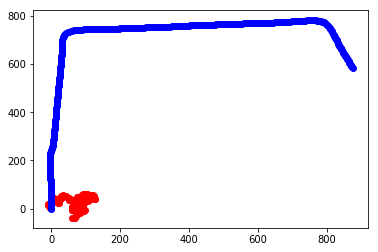

Count:1741
()
()
Relative Depth: 38.24107604159451
Relative x: 58.38185024218643
Relative Original Depth: -581.7192459960289
Relative Original x: 876.2319591644624
Count:1742
()
()
Relative Depth: 37.87576940292593
Relative x: 57.47935481868464
Relative Original Depth: -580.7899671032827
Relative Original x: 876.593664267203
Count:1743
()
()
Relative Depth: 37.57878777388994
Relative x: 56.641954904539276
Relative Original Depth: -579.8600276979631
Relative Original x: 876.9530750885289
Count:1744
()
()
Relative Depth: 37.24400525124196
Relative x: 55.712822561684426
Relative Original Depth: -578.9368535759614
Relative Original x: 877.3303606064684
Count:1745
()
()
Relative Depth: 36.762050245867904
Relative x: 54.89925426469113
Relative Original Depth: -578.0116258472432
Relative Original x: 877.7025280287759


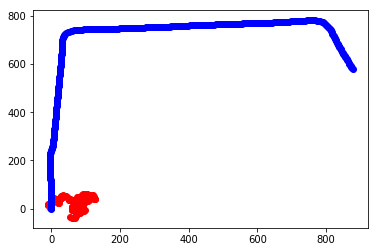

Count:1746
()
()
Relative Depth: 36.1681710050301
Relative x: 54.243115568915535
Relative Original Depth: -577.0776692318864
Relative Original x: 878.0561454045182
Count:1747
()
()
Relative Depth: 35.57786274628933
Relative x: 53.556199475193004
Relative Original Depth: -576.144118006399
Relative Original x: 878.4105362878871
Count:1748
()
()
Relative Depth: 36.074153808544146
Relative x: 53.51185779184344
Relative Original Depth: -575.2078720528033
Relative Original x: 878.7553944981793
Count:1749
()
()
Relative Depth: 35.54367528596746
Relative x: 52.746434919938196
Relative Original Depth: -574.2742872262706
Relative Original x: 879.1056496638779
Count:1750
()
()
Relative Depth: 35.54930696240005
Relative x: 51.88261050063455
Relative Original Depth: -573.339850904418
Relative Original x: 879.4502597904401


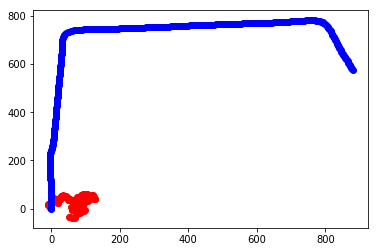

Count:1751
()
()
Relative Depth: 36.087756972585936
Relative x: 52.00901958641625
Relative Original Depth: -572.4041528184597
Relative Original x: 879.792457890418
Count:1752
()
()
Relative Depth: 36.650536842669496
Relative x: 51.39036415317256
Relative Original Depth: -571.4638583871007
Relative Original x: 880.1202962585003
Count:1753
()
()
Relative Depth: 37.09197598765962
Relative x: 50.651810666071036
Relative Original Depth: -570.5333391776502
Relative Original x: 880.4740358659493
Count:1754
()
()
Relative Depth: 37.37927434694901
Relative x: 49.86334686187034
Relative Original Depth: -569.6224073723723
Relative Original x: 880.8834125659791
Count:1755
()
()
Relative Depth: 37.789686155025265
Relative x: 49.02349891125339
Relative Original Depth: -568.6956523277217
Relative Original x: 881.2572243088152


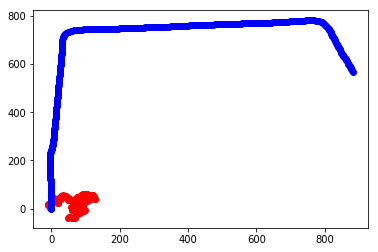

Count:1756
()
()
Relative Depth: 38.26774993138647
Relative x: 48.14520626106808
Relative Original Depth: -567.7651799213843
Relative Original x: 881.6235635748169
Count:1757
()
()
Relative Depth: 38.67268534332687
Relative x: 47.23333638636687
Relative Original Depth: -566.8361374850583
Relative Original x: 881.9934199594089
Count:1758
()
()
Relative Depth: 37.89078199650831
Relative x: 46.61044865183417
Relative Original Depth: -565.8934644488065
Relative Original x: 882.3253757010189
Count:1759
()
()
Relative Depth: 38.03193206206238
Relative x: 45.620944320751576
Relative Original Depth: -564.9512919138971
Relative Original x: 882.6583207818348
Count:1760
()
()
Relative Depth: 37.995978493727414
Relative x: 44.622548899330724
Relative Original Depth: -564.0056083450388
Relative Original x: 882.9749392580154


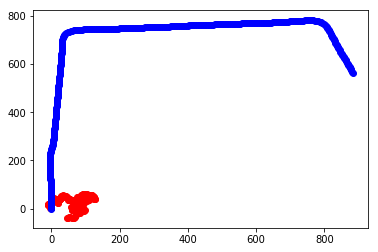

Count:1761
()
()
Relative Depth: 37.44567079214088
Relative x: 44.05420330746384
Relative Original Depth: -563.066087671762
Relative Original x: 883.3124234483668
Count:1762
()
()
Relative Depth: 37.35416101577494
Relative x: 43.05911458619302
Relative Original Depth: -562.1381692772912
Relative Original x: 883.6753077506851
Count:1763
()
()
Relative Depth: 37.1213987693639
Relative x: 42.49036331350465
Relative Original Depth: -561.2042289021031
Relative Original x: 884.0180650187921
Count:1764
()
()
Relative Depth: 36.87090703704644
Relative x: 41.52955489032673
Relative Original Depth: -560.281738813165
Relative Original x: 884.3980831083895
Count:1765
()
()
Relative Depth: 36.59971759842843
Relative x: 40.592209621911216
Relative Original Depth: -559.3623042370608
Relative Original x: 884.7861838113145


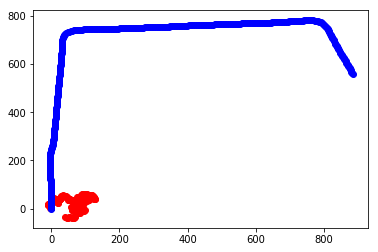

Count:1766
()
()
Relative Depth: 36.43895233737892
Relative x: 39.67984058327852
Relative Original Depth: -558.4253606595779
Relative Original x: 885.1267437570182
Count:1767
()
()
Relative Depth: 36.4130753764992
Relative x: 38.82548857043598
Relative Original Depth: -557.4900856502169
Relative Original x: 885.4685248100577
Count:1768
()
()
Relative Depth: 36.36493061075912
Relative x: 38.019167261783466
Relative Original Depth: -556.5520924779224
Relative Original x: 885.8012451090804
Count:1769
()
()
Relative Depth: 36.23854140152958
Relative x: 37.112933805840015
Relative Original Depth: -555.6315364394475
Relative Original x: 886.1863124148043
Count:1770
()
()
Relative Depth: 36.18799823780084
Relative x: 36.11444679765942
Relative Original Depth: -554.696478860121
Relative Original x: 886.5297871434094


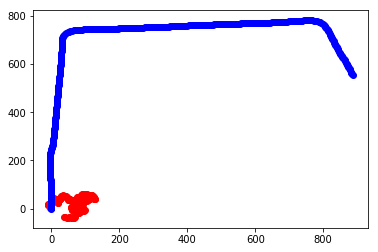

Count:1771
()
()
Relative Depth: 36.16874224392036
Relative x: 35.12076418884182
Relative Original Depth: -553.7572496115233
Relative Original x: 886.8637659257577
Count:1772
()
()
Relative Depth: 36.22570404797737
Relative x: 34.12439969153619
Relative Original Depth: -552.8237554082652
Relative Original x: 887.2127952325116
Count:1773
()
()
Relative Depth: 36.42203926288703
Relative x: 33.1494426484745
Relative Original Depth: -551.8934196069804
Relative Original x: 887.572729362997
Count:1774
()
()
Relative Depth: 36.64699603958654
Relative x: 32.17862810700806
Relative Original Depth: -550.9767962168602
Relative Original x: 887.9703913189658
Count:1775
()
()
Relative Depth: 36.93244221629581
Relative x: 31.220771722904104
Relative Original Depth: -550.0502406643865
Relative Original x: 888.3419906059547


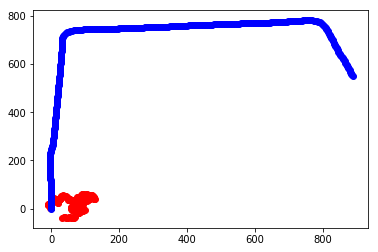

Count:1776
()
()
Relative Depth: 37.22054006504427
Relative x: 30.263330448133075
Relative Original Depth: -549.1188398155743
Relative Original x: 888.6970488085506
Count:1777
()
()
Relative Depth: 37.438275244588425
Relative x: 29.28789144188095
Relative Original Depth: -548.189697009053
Relative Original x: 889.0565556116353
Count:1778
()
()
Relative Depth: 37.55915655576602
Relative x: 28.300342471868458
Relative Original Depth: -547.2599261470426
Relative Original x: 889.4190585021263
Count:1779
()
()
Relative Depth: 37.46132921823521
Relative x: 27.31006028567649
Relative Original Depth: -546.3118189768829
Relative Original x: 889.7309521055154
Count:1780
()
()
Relative Depth: 37.16958758320012
Relative x: 26.353840052895237
Relative Original Depth: -545.3690820667257
Relative Original x: 890.0564816714285


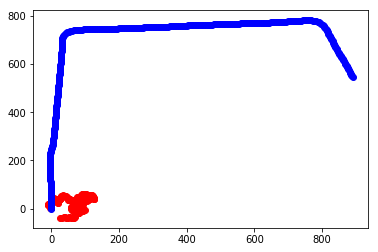

Count:1781
()
()
Relative Depth: 36.88772480204751
Relative x: 25.39992556771288
Relative Original Depth: -544.4290442645621
Relative Original x: 890.3932881141258
Count:1782
()
()
Relative Depth: 36.15734633036331
Relative x: 24.718116896594037
Relative Original Depth: -543.492317877209
Relative Original x: 890.7359407235333
Count:1783
()
()
Relative Depth: 35.190316574017636
Relative x: 24.472525109440877
Relative Original Depth: -542.5551443605992
Relative Original x: 891.077711015798
Count:1784
()
()
Relative Depth: 34.23580159713375
Relative x: 24.178740882308098
Relative Original Depth: -541.6172578785771
Relative Original x: 891.417366719191
Count:1785
()
()
Relative Depth: 33.307912196245404
Relative x: 23.806039410987434
Relative Original Depth: -540.6787273851135
Relative Original x: 891.7540733775085


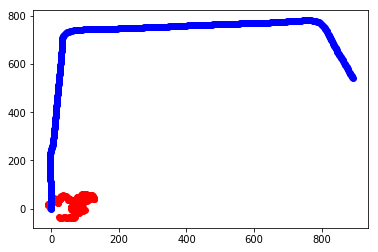

Count:1786
()
()
Relative Depth: 32.7653953942196
Relative x: 23.636358940748547
Relative Original Depth: -539.7435065889512
Relative Original x: 892.1005675924323
Count:1787
()
()
Relative Depth: 31.789989190765635
Relative x: 23.416575652755213
Relative Original Depth: -538.81229960595
Relative Original x: 892.4559824442088
Count:1788
()
()
Relative Depth: 31.41104782737014
Relative x: 23.49077935318225
Relative Original Depth: -537.8770037246935
Relative Original x: 892.7983505885277
Count:1789
()
()
Relative Depth: 30.464138613284213
Relative x: 23.333842746189234
Relative Original Depth: -536.9345818898308
Relative Original x: 893.115782542116
Count:1790
()
()
Relative Depth: 29.597534882537822
Relative x: 23.097664428274985
Relative Original Depth: -535.9938845509364
Relative Original x: 893.4423055132717


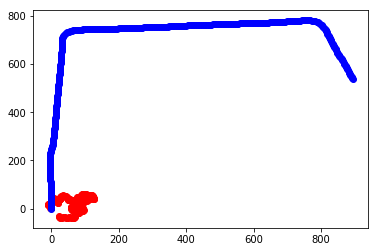

Count:1791
()
()
Relative Depth: 28.638648423833075
Relative x: 22.938922433837003
Relative Original Depth: -535.0711306646891
Relative Original x: 893.8230087972124
Count:1792
()
()
Relative Depth: 27.64421112886017
Relative x: 23.021328562460358
Relative Original Depth: -534.148684825175
Relative Original x: 894.2008659463983
Count:1793
()
()
Relative Depth: 26.69088813801521
Relative x: 22.835579111668817
Relative Original Depth: -533.2150808551683
Relative Original x: 894.5540616903373
Count:1794
()
()
Relative Depth: 26.1461196415402
Relative x: 22.144993357968996
Relative Original Depth: -532.2747095921723
Relative Original x: 894.8877015273841
Count:1795
()
()
Relative Depth: 25.74542682320533
Relative x: 21.355283933513917
Relative Original Depth: -531.3542065083308
Relative Original x: 895.2731797198257


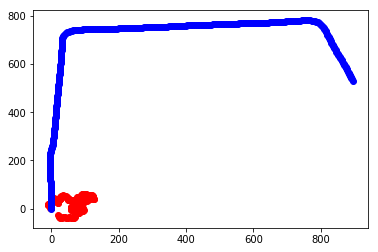

Count:1796
()
()
Relative Depth: 25.371011765531737
Relative x: 20.56249429692169
Relative Original Depth: -530.4095222492567
Relative Original x: 895.5795649651437
Count:1797
()
()
Relative Depth: 24.90709375945034
Relative x: 19.767903334275303
Relative Original Depth: -529.4795365035984
Relative Original x: 895.9381478571551
Count:1798
()
()
Relative Depth: 24.114295461976965
Relative x: 19.164371738758796
Relative Original Depth: -528.5388386084875
Relative Original x: 896.2679971955503
Count:1799
()
()
Relative Depth: 23.212023175373854
Relative x: 18.751791783221332
Relative Original Depth: -527.6080865729468
Relative Original x: 896.623902461488
Count:1800
()
()
Relative Depth: 22.35613569238372
Relative x: 18.241039067164035
Relative Original Depth: -526.670527765831
Relative Original x: 896.9538448862595


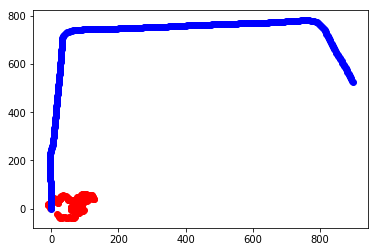

Count:1801
()
()
Relative Depth: 21.54693870568301
Relative x: 17.677991409453178
Relative Original Depth: -525.7321231949785
Relative Original x: 897.2856301889497
Count:1802
()
()
Relative Depth: 20.54719372507226
Relative x: 17.65813600713713
Relative Original Depth: -524.8008112545388
Relative Original x: 897.643475652925
Count:1803
()
()
Relative Depth: 19.745148693789965
Relative x: 17.93593819880572
Relative Original Depth: -523.8678810201683
Relative Original x: 897.9949123566174
Count:1804
()
()
Relative Depth: 19.030968651731694
Relative x: 17.854112912730965
Relative Original Depth: -522.9358086594831
Relative Original x: 898.3473714098197
Count:1805
()
()
Relative Depth: 18.350624067156936
Relative x: 17.58655876358666
Relative Original Depth: -522.0129734210037
Relative Original x: 898.7276328452921


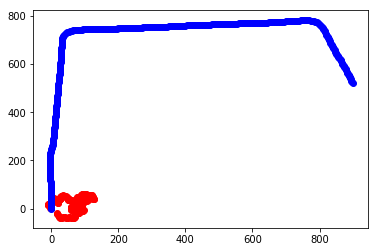

Count:1806
()
()
Relative Depth: 18.082250470956918
Relative x: 17.253279094357357
Relative Original Depth: -521.0697311419707
Relative Original x: 899.0537887180321
Count:1807
()
()
Relative Depth: 17.97534971719295
Relative x: 17.234327551892168
Relative Original Depth: -520.1353390585234
Relative Original x: 899.4046176546285
Count:1808
()
()
Relative Depth: 17.565400201692302
Relative x: 17.527887694628095
Relative Original Depth: -519.2087902469706
Relative Original x: 899.7777578638095
Count:1809
()
()
Relative Depth: 17.096666840824227
Relative x: 17.850623049573
Relative Original Depth: -518.2642078431767
Relative Original x: 900.0896507119619
Count:1810
()
()
Relative Depth: 16.889558193737802
Relative x: 17.897377517675636
Relative Original Depth: -517.3287898574773
Relative Original x: 900.4327935262528


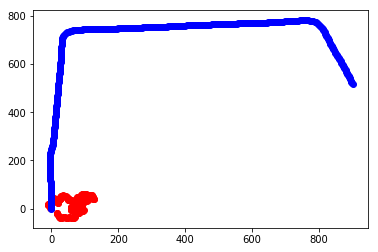

Count:1811
()
()
Relative Depth: 17.005834941868212
Relative x: 17.643607500890745
Relative Original Depth: -516.3991223092147
Relative Original x: 900.792603783903
Count:1812
()
()
Relative Depth: 17.130572220918296
Relative x: 17.288495763281507
Relative Original Depth: -515.4686575619322
Relative Original x: 901.1530563320448
Count:1813
()
()
Relative Depth: 17.265401459183256
Relative x: 16.836373578571816
Relative Original Depth: -514.5380230832727
Relative Original x: 901.5102501711176
Count:1814
()
()
Relative Depth: 17.417205627986984
Relative x: 16.380810186696245
Relative Original Depth: -513.5978337148587
Relative Original x: 901.837355653081
Count:1815
()
()
Relative Depth: 17.586120003639945
Relative x: 15.974917793320559
Relative Original Depth: -512.6618720217205
Relative Original x: 902.1825386528609


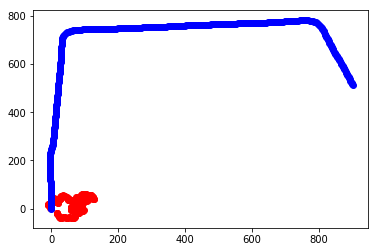

Count:1816
()
()
Relative Depth: 17.809375925897086
Relative x: 15.523261884960327
Relative Original Depth: -511.725464666881
Relative Original x: 902.5304483557362
Count:1817
()
()
Relative Depth: 18.13162904724899
Relative x: 14.964806229233986
Relative Original Depth: -510.78634849239205
Relative Original x: 902.8634297248287
Count:1818
()
()
Relative Depth: 18.477703079225673
Relative x: 14.113908700367519
Relative Original Depth: -509.84959504508026
Relative Original x: 903.2046070369804
Count:1819
()
()
Relative Depth: 19.030380098188225
Relative x: 13.547586225666493
Relative Original Depth: -508.9125788734534
Relative Original x: 903.5433873230826
Count:1820
()
()
Relative Depth: 19.7538981620471
Relative x: 13.03740034113886
Relative Original Depth: -507.9749743276174
Relative Original x: 903.8844261899474


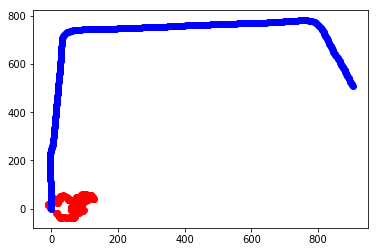

Count:1821
()
()
Relative Depth: 20.581075972025868
Relative x: 12.587899006437025
Relative Original Depth: -507.041831074837
Relative Original x: 904.2387532747522
Count:1822
()
()
Relative Depth: 20.482012872233017
Relative x: 11.967963672881215
Relative Original Depth: -506.11358461091174
Relative Original x: 904.6054781041955
Count:1823
()
()
Relative Depth: 21.352222382352917
Relative x: 11.519337239775105
Relative Original Depth: -505.171241347582
Relative Original x: 904.9330455482939
Count:1824
()
()
Relative Depth: 22.219492890920765
Relative x: 11.070090696184037
Relative Original Depth: -504.23554259404614
Relative Original x: 905.2758716981061
Count:1825
()
()
Relative Depth: 23.040683655661017
Relative x: 10.625226823636266
Relative Original Depth: -503.29825654421825
Relative Original x: 905.6150091811282


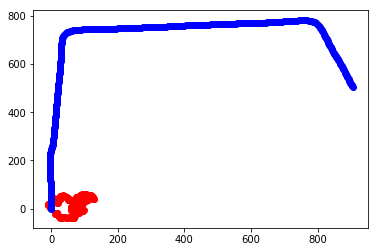

Count:1826
()
()
Relative Depth: 23.83742098924486
Relative x: 10.17348393575
Relative Original Depth: -502.36362786593617
Relative Original x: 905.9667083276876
Count:1827
()
()
Relative Depth: 24.45685413378658
Relative x: 9.800780441079654
Relative Original Depth: -501.4217203289963
Relative Original x: 906.2945622666116
Count:1828
()
()
Relative Depth: 24.7074782052625
Relative x: 9.576595006329109
Relative Original Depth: -500.48784916653733
Relative Original x: 906.6426882125505
Count:1829
()
()
Relative Depth: 23.722328520292162
Relative x: 9.743376940178162
Relative Original Depth: -499.54475925020165
Relative Original x: 906.9642971179921
Count:1830
()
()
Relative Depth: 24.207843717772494
Relative x: 9.502213214129938
Relative Original Depth: -498.60029075574323
Relative Original x: 907.2779231924208


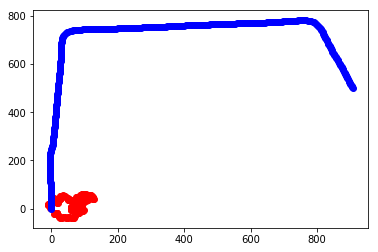

Count:1831
()
()
Relative Depth: 24.814473804659393
Relative x: 8.763153464517824
Relative Original Depth: -497.6674177541732
Relative Original x: 907.6281994423837
Count:1832
()
()
Relative Depth: 24.977667930773247
Relative x: 7.793238888763657
Relative Original Depth: -496.7330241556372
Relative Original x: 907.9782614229727
Count:1833
()
()
Relative Depth: 24.850794407108726
Relative x: 6.80144563510551
Relative Original Depth: -495.7900124655454
Relative Original x: 908.3030822061045
Count:1834
()
()
Relative Depth: 24.444562944477124
Relative x: 5.919822054335121
Relative Original Depth: -494.8503031902136
Relative Original x: 908.6406150310581
Count:1835
()
()
Relative Depth: 23.783943082621548
Relative x: 5.174722492552428
Relative Original Depth: -493.9190875505136
Relative Original x: 908.9938172502037


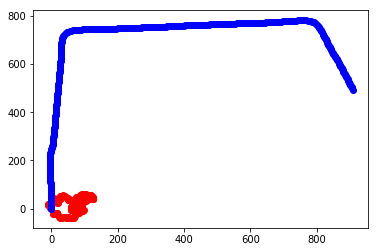

Count:1836
()
()
Relative Depth: 22.89900836917255
Relative x: 4.7277960866193895
Relative Original Depth: -492.98586913324056
Relative Original x: 909.3373180280886
Count:1837
()
()
Relative Depth: 22.03655586655283
Relative x: 4.453329776761664
Relative Original Depth: -492.05157612768096
Relative Original x: 909.682275783627
Count:1838
()
()
Relative Depth: 21.17957179263506
Relative x: 4.177999815381851
Relative Original Depth: -491.1146067081621
Relative Original x: 910.0176216140147
Count:1839
()
()
Relative Depth: 20.899329984969906
Relative x: 3.3808218642631904
Relative Original Depth: -490.1698503833804
Relative Original x: 910.3371466443522
Count:1840
()
()
Relative Depth: 20.086007738431327
Relative x: 3.029547802696206
Relative Original Depth: -489.2365153584013
Relative Original x: 910.6867512464717


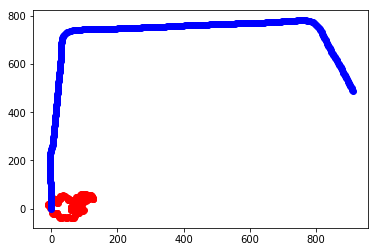

Count:1841
()
()
Relative Depth: 19.363438377363057
Relative x: 2.6572966169419683
Relative Original Depth: -488.2920446949267
Relative Original x: 911.0078511104587
Count:1842
()
()
Relative Depth: 18.696649772454723
Relative x: 2.31210768383937
Relative Original Depth: -487.3619913922607
Relative Original x: 911.3695359979705
Count:1843
()
()
Relative Depth: 18.08729739088252
Relative x: 2.1587359354486084
Relative Original Depth: -486.4374247756512
Relative Original x: 911.7409762417462
Count:1844
()
()
Relative Depth: 17.996941884789297
Relative x: 2.3579470941041376
Relative Original Depth: -485.50808539240825
Relative Original x: 912.104800738054
Count:1845
()
()
Relative Depth: 18.080748251730228
Relative x: 2.6021610631834213
Relative Original Depth: -484.5800488423089
Relative Original x: 912.4684420325041


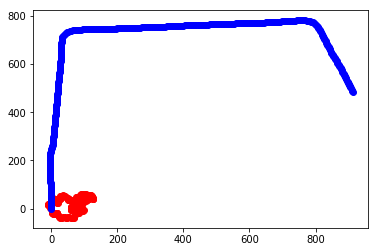

Count:1846
()
()
Relative Depth: 17.835377586845105
Relative x: 2.4144295514742256
Relative Original Depth: -483.6457132729172
Relative Original x: 912.817555552376
Count:1847
()
()
Relative Depth: 17.55293105719464
Relative x: 1.9484141525736691
Relative Original Depth: -482.7170221722655
Relative Original x: 913.1815330272842
Count:1848
()
()
Relative Depth: 16.92422043058312
Relative x: 1.6707108470914438
Relative Original Depth: -481.7803145140452
Relative Original x: 913.5242998964603
Count:1849
()
()
Relative Depth: 16.11703101765602
Relative x: 1.7812761170117597
Relative Original Depth: -480.8430737725934
Relative Original x: 913.8636174470981
Count:1850
()
()
Relative Depth: 15.460376969750552
Relative x: 1.9985382281578854
Relative Original Depth: -479.91048201839084
Relative Original x: 914.2179286401308


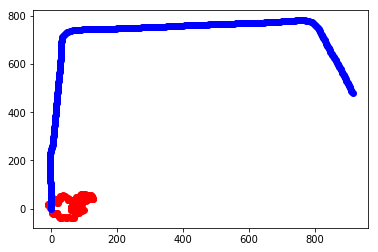

Count:1851
()
()
Relative Depth: 14.851230153253871
Relative x: 2.1655874710737426
Relative Original Depth: -478.97455679165023
Relative Original x: 914.5603464499615
Count:1852
()
()
Relative Depth: 14.317023391563218
Relative x: 2.5010783380507466
Relative Original Depth: -478.0366689118246
Relative Original x: 914.8998166245414
Count:1853
()
()
Relative Depth: 13.968960614981407
Relative x: 3.0878184312672285
Relative Original Depth: -477.10506636931495
Relative Original x: 915.255190977235
Count:1854
()
()
Relative Depth: 13.704424580141033
Relative x: 3.7421464185561804
Relative Original Depth: -476.164781548359
Relative Original x: 915.5836434777701
Count:1855
()
()
Relative Depth: 13.503006414461987
Relative x: 4.4295474673627755
Relative Original Depth: -475.22939379022273
Relative Original x: 915.9255064658952


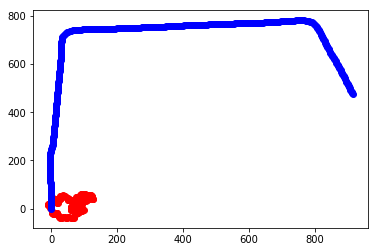

Count:1856
()
()
Relative Depth: 13.279461385596068
Relative x: 5.1538352996401855
Relative Original Depth: -474.2911758966272
Relative Original x: 916.2583438447682
Count:1857
()
()
Relative Depth: 13.051243286906502
Relative x: 5.902239359992594
Relative Original Depth: -473.3695445037729
Relative Original x: 916.6406028144381
Count:1858
()
()
Relative Depth: 13.094221692386894
Relative x: 6.649449713977664
Relative Original Depth: -472.43666367686524
Relative Original x: 916.9924095395021
Count:1859
()
()
Relative Depth: 13.444344243704247
Relative x: 7.343940233008865
Relative Original Depth: -471.50160283465664
Relative Original x: 917.3404699927775
Count:1860
()
()
Relative Depth: 13.965778624199707
Relative x: 8.09401830459539
Relative Original Depth: -470.5676440355604
Relative Original x: 917.6922099050788


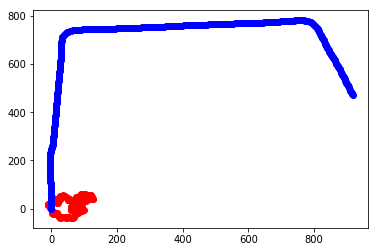

Count:1861
()
()
Relative Depth: 14.525474445375115
Relative x: 8.884754818039418
Relative Original Depth: -469.62931876989904
Relative Original x: 918.0327337032047
Count:1862
()
()
Relative Depth: 15.010764715904962
Relative x: 9.706287093464153
Relative Original Depth: -468.69793170690633
Relative Original x: 918.3893327021908
Count:1863
()
()
Relative Depth: 15.43893905473532
Relative x: 10.548344766498557
Relative Original Depth: -467.7536182156645
Relative Original x: 918.7151820354851
Count:1864
()
()
Relative Depth: 15.799111338841653
Relative x: 11.418533954452279
Relative Original Depth: -466.82179209724626
Relative Original x: 919.0729000276734
Count:1865
()
()
Relative Depth: 16.274095361541175
Relative x: 12.271559888359961
Relative Original Depth: -465.880268892616
Relative Original x: 919.4062660918552


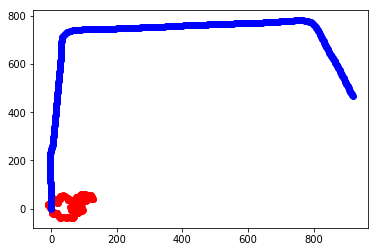

Count:1866
()
()
Relative Depth: 16.745677747778874
Relative x: 13.118426951434273
Relative Original Depth: -464.9370404244122
Relative Original x: 919.7356240577803
Count:1867
()
()
Relative Depth: 17.041753854260264
Relative x: 13.870831341091971
Relative Original Depth: -464.0006766956611
Relative Original x: 920.0819740419781
Count:1868
()
()
Relative Depth: 17.454074658898175
Relative x: 14.606454807233446
Relative Original Depth: -463.06662578023395
Relative Original x: 920.4299609619518
Count:1869
()
()
Relative Depth: 17.117824260260406
Relative x: 15.25997678248172
Relative Original Depth: -462.1337289619727
Relative Original x: 920.7813891272444
Count:1870
()
()
Relative Depth: 16.370505395178014
Relative x: 15.92091651939778
Relative Original Depth: -461.1946564362212
Relative Original x: 921.1150691254313


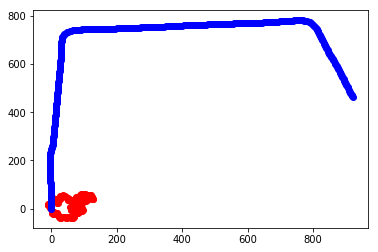

Count:1871
()
()
Relative Depth: 16.72318614401494
Relative x: 16.60373443985408
Relative Original Depth: -460.27698126619225
Relative Original x: 921.5038234259271
Count:1872
()
()
Relative Depth: 16.743545585813084
Relative x: 17.44139099289753
Relative Original Depth: -459.33459731343896
Relative Original x: 921.8240877529993
Count:1873
()
()
Relative Depth: 16.416856062664806
Relative x: 18.35315079171106
Relative Original Depth: -458.3952506314131
Relative Original x: 922.1582505170287
Count:1874
()
()
Relative Depth: 16.206413883056324
Relative x: 18.46027520394194
Relative Original Depth: -457.46114204835544
Relative Original x: 922.5023044412735
Count:1875
()
()
Relative Depth: 15.755252877448001
Relative x: 19.343479364905452
Relative Original Depth: -456.5238216852913
Relative Original x: 922.8412327619243


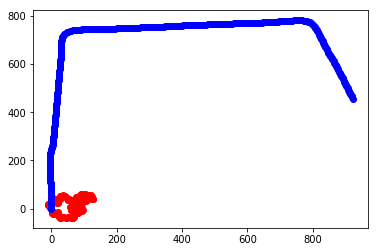

Count:1876
()
()
Relative Depth: 15.448105373763436
Relative x: 18.632821392540933
Relative Original Depth: -455.59578625214215
Relative Original x: 923.2053318393889
Count:1877
()
()
Relative Depth: 15.258919601319793
Relative x: 19.346768885965645
Relative Original Depth: -454.6599872694513
Relative Original x: 923.5535677151298
Count:1878
()
()
Relative Depth: 15.482084605636022
Relative x: 19.78085832546308
Relative Original Depth: -453.72262234259455
Relative Original x: 923.8962374525996
Count:1879
()
()
Relative Depth: 15.529616668334995
Relative x: 20.166574000235904
Relative Original Depth: -452.7901734566476
Relative Original x: 924.249760311142
Count:1880
()
()
Relative Depth: 15.280339574877571
Relative x: 20.231107911923914
Relative Original Depth: -451.84710502796094
Relative Original x: 924.5801495493982


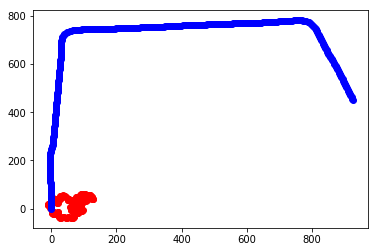

Count:1881
()
()
Relative Depth: 15.111968984936988
Relative x: 19.94609304476655
Relative Original Depth: -450.9072361175836
Relative Original x: 924.9196924996799
Count:1882
()
()
Relative Depth: 15.015007787324674
Relative x: 19.53109700237277
Relative Original Depth: -449.9688742434534
Relative Original x: 925.2635385699405
Count:1883
()
()
Relative Depth: 14.824061895138305
Relative x: 18.96984037184815
Relative Original Depth: -449.03741835861274
Relative Original x: 925.6223334876902
Count:1884
()
()
Relative Depth: 14.076456516258599
Relative x: 18.447577402653895
Relative Original Depth: -448.1087282515319
Relative Original x: 925.9854449482091
Count:1885
()
()
Relative Depth: 13.229418111869643
Relative x: 18.126458390109953
Relative Original Depth: -447.1794615430041
Relative Original x: 926.3417862253914


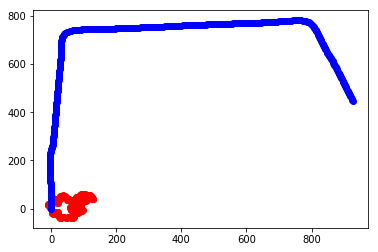

Count:1886
()
()
Relative Depth: 12.556279238427917
Relative x: 17.650139965402733
Relative Original Depth: -446.2558452192815
Relative Original x: 926.7070346405382
Count:1887
()
()
Relative Depth: 11.679180770872726
Relative x: 17.4071914513694
Relative Original Depth: -445.31956326437574
Relative Original x: 927.0414714962911
Count:1888
()
()
Relative Depth: 10.721615657429549
Relative x: 17.38973371828187
Relative Original Depth: -444.38529842929506
Relative Original x: 927.3879711222311
Count:1889
()
()
Relative Depth: 9.763008116667823
Relative x: 17.350554922998967
Relative Original Depth: -443.4420989795226
Relative Original x: 927.7062765079863
Count:1890
()
()
Relative Depth: 8.799086009466254
Relative x: 17.306786492973394
Relative Original Depth: -442.49960351253475
Relative Original x: 928.0269335332705


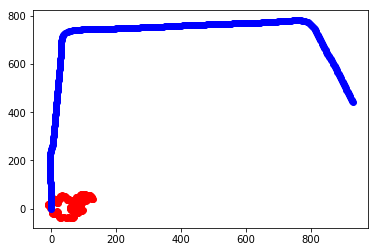

Count:1891
()
()
Relative Depth: 7.813677838876732
Relative x: 17.143944101202372
Relative Original Depth: -441.55939881131644
Relative Original x: 928.3593939416688
Count:1892
()
()
Relative Depth: 6.8554390246087795
Relative x: 16.88359014536504
Relative Original Depth: -440.6194281732619
Relative Original x: 928.6957058075235
Count:1893
()
()
Relative Depth: 6.206293927574608
Relative x: 16.865124109313793
Relative Original Depth: -439.6923843813117
Relative Original x: 929.063731847201
Count:1894
()
()
Relative Depth: 5.227429534586268
Relative x: 16.661122828322508
Relative Original Depth: -438.7628584765058
Relative Original x: 929.4285146960791
Count:1895
()
()
Relative Depth: 4.240639572211716
Relative x: 16.502524026517335
Relative Original Depth: -437.82882572882215
Relative Original x: 929.7770246005032


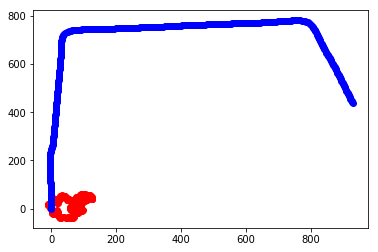

Count:1896
()
()
Relative Depth: 3.2534865536070843
Relative x: 16.44233444494447
Relative Original Depth: -436.89682610201237
Relative Original x: 930.1278624635615
Count:1897
()
()
Relative Depth: 2.2744763672514123
Relative x: 16.446136174044693
Relative Original Depth: -435.96106910497247
Relative Original x: 930.4669727894486
Count:1898
()
()
Relative Depth: 1.2815223560519604
Relative x: 16.460346048663723
Relative Original Depth: -435.0329413752654
Relative Original x: 930.8232898756663
Count:1899
()
()
Relative Depth: 0.2941128484597041
Relative x: 16.55533468480754
Relative Original Depth: -434.0967483176274
Relative Original x: 931.1641532956055
Count:1900
()
()
Relative Depth: -0.687404741523454
Relative x: 16.5712653237087
Relative Original Depth: -433.16109958028727
Relative Original x: 931.5097199594999


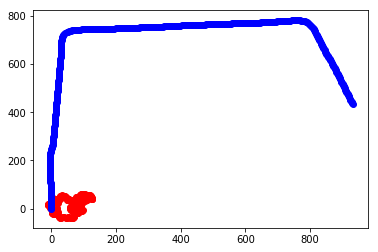

Count:1901
()
()
Relative Depth: -1.664082706208204
Relative x: 16.427243966078482
Relative Original Depth: -432.22446775865143
Relative Original x: 931.8494790059616
Count:1902
()
()
Relative Depth: -2.5148687480922733
Relative x: 16.241449176282273
Relative Original Depth: -431.2920040233639
Relative Original x: 932.2037418787922
Count:1903
()
()
Relative Depth: -3.3657463044749036
Relative x: 16.10456166012908
Relative Original Depth: -430.3680433214085
Relative Original x: 932.579260033652
Count:1904
()
()
Relative Depth: -4.352983119449601
Relative x: 16.096448478551018
Relative Original Depth: -429.4422836732781
Relative Original x: 932.9529249727598
Count:1905
()
()
Relative Depth: -4.797613572260099
Relative x: 16.128484900926516
Relative Original Depth: -428.5127248658062
Relative Original x: 933.3144623871755


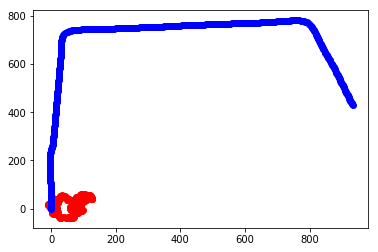

Count:1906
()
()
Relative Depth: -4.533430381727108
Relative x: 16.693235367767723
Relative Original Depth: -427.5817842236676
Relative Original x: 933.6733087034946
Count:1907
()
()
Relative Depth: -4.437398087400469
Relative x: 17.6885678780045
Relative Original Depth: -426.6648363831706
Relative Original x: 934.068246607781
Count:1908
()
()
Relative Depth: -4.89402107061004
Relative x: 18.553073386511524
Relative Original Depth: -425.7364636691331
Relative Original x: 934.4314471070585
Count:1909
()
()
Relative Depth: -4.041039994927027
Relative x: 18.98283904523158
Relative Original Depth: -424.802119522368
Relative Original x: 934.7791841453256
Count:1910
()
()
Relative Depth: -4.443560962634656
Relative x: 19.789884758070617
Relative Original Depth: -423.8606599834229
Relative Original x: 935.1117685488379


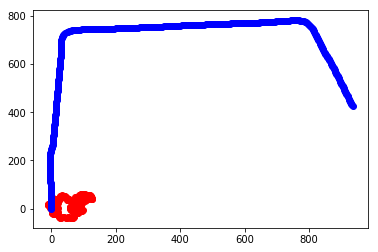

Count:1911
()
()
Relative Depth: -4.77159189057229
Relative x: 19.84633148447874
Relative Original Depth: -422.915428178106
Relative Original x: 935.437226723946
Count:1912
()
()
Relative Depth: -4.813726130168636
Relative x: 19.251698455896353
Relative Original Depth: -421.9735870775347
Relative Original x: 935.773153606609
Count:1913
()
()
Relative Depth: -4.607310339781665
Relative x: 18.660670387846395
Relative Original Depth: -421.03267954223446
Relative Original x: 936.1113264143223
Count:1914
()
()
Relative Depth: -4.23875076407035
Relative x: 18.08449408471488
Relative Original Depth: -420.09731940149527
Relative Original x: 936.4637562161848
Count:1915
()
()
Relative Depth: -3.640334993327591
Relative x: 17.454787566633843
Relative Original Depth: -419.1797302024591
Relative Original x: 936.8552212757744


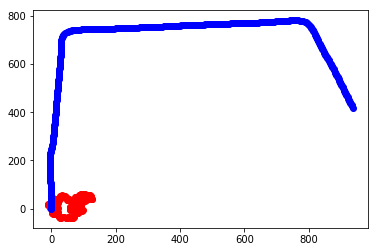

Count:1916
()
()
Relative Depth: -2.966744894094674
Relative x: 16.78430230359038
Relative Original Depth: -418.25656968102965
Relative Original x: 937.2203477144
Count:1917
()
()
Relative Depth: -2.328672565126297
Relative x: 16.068591096303255
Relative Original Depth: -417.33733045616475
Relative Original x: 937.5972233264207
Count:1918
()
()
Relative Depth: -2.026184657122707
Relative x: 15.190171103888941
Relative Original Depth: -416.4173483178198
Relative Original x: 937.9608985727655
Count:1919
()
()
Relative Depth: -2.201021573726865
Relative x: 14.290450460237484
Relative Original Depth: -415.4889670067121
Relative Original x: 938.3063427229711
Count:1920
()
()
Relative Depth: -2.149596687096169
Relative x: 13.3330734848759
Relative Original Depth: -414.5587605708694
Relative Original x: 938.6595314765864


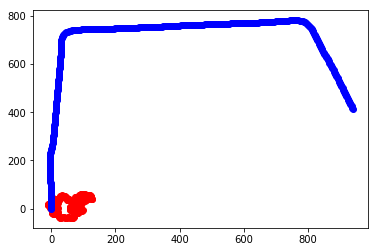

Count:1921
()
()
Relative Depth: -1.7534080535180152
Relative x: 12.440938842973898
Relative Original Depth: -413.61312085975777
Relative Original x: 938.9705815802903
Count:1922
()
()
Relative Depth: -1.3699038797443932
Relative x: 11.52566196451679
Relative Original Depth: -412.6720553174319
Relative Original x: 939.3033728086784
Count:1923
()
()
Relative Depth: -0.9682311158897545
Relative x: 10.60997193048284
Relative Original Depth: -411.7271161946148
Relative Original x: 939.6286689155378
Count:1924
()
()
Relative Depth: -0.4981902748689194
Relative x: 9.727446143758707
Relative Original Depth: -410.78848438827043
Relative Original x: 939.9734735326259
Count:1925
()
()
Relative Depth: 0.11884603652237702
Relative x: 8.942743346850717
Relative Original Depth: -409.85193029766094
Relative Original x: 940.3226046781779


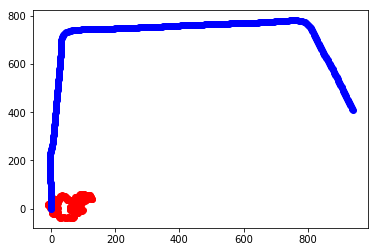

Count:1926
()
()
Relative Depth: 0.8576434360286304
Relative x: 8.30738106560253
Relative Original Depth: -408.92904902034337
Relative Original x: 940.7047869290716
Count:1927
()
()
Relative Depth: 1.6779578399567638
Relative x: 7.826126667337135
Relative Original Depth: -408.0059977519195
Relative Original x: 941.0836821138066
Count:1928
()
()
Relative Depth: 2.518437423172283
Relative x: 7.46937750685509
Relative Original Depth: -407.08130388892204
Relative Original x: 941.4545552963283
Count:1929
()
()
Relative Depth: 3.488425323343182
Relative x: 7.571112645986036
Relative Original Depth: -406.1442618912184
Relative Original x: 941.7866882026823
Count:1930
()
()
Relative Depth: 4.211375850843084
Relative x: 8.261970463553967
Relative Original Depth: -405.2116372682149
Relative Original x: 942.1293685484629


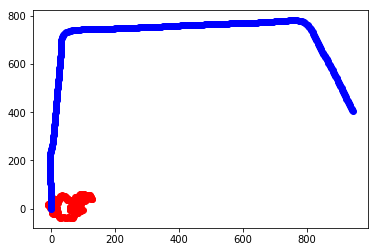

Count:1931
()
()
Relative Depth: 4.738822664982871
Relative x: 9.111316923791339
Relative Original Depth: -404.2764071621407
Relative Original x: 942.4611230754304
Count:1932
()
()
Relative Depth: 5.4842944887516385
Relative x: 9.684594656889264
Relative Original Depth: -403.33116780664733
Relative Original x: 942.7627732116628
Count:1933
()
()
Relative Depth: 4.808223385904517
Relative x: 10.327216557204617
Relative Original Depth: -402.3943693933247
Relative Original x: 943.1029261861667
Count:1934
()
()
Relative Depth: 5.641314662359151
Relative x: 10.04643877996832
Relative Original Depth: -401.44993495898865
Relative Original x: 943.4098938528659
Count:1935
()
()
Relative Depth: 6.399803419701056
Relative x: 10.520446909158299
Relative Original Depth: -400.5117723591944
Relative Original x: 943.7492278437479


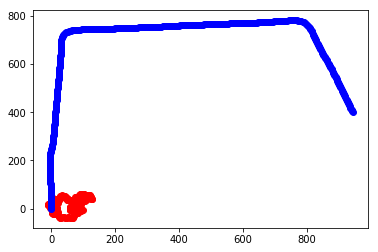

Count:1936
()
()
Relative Depth: 7.076531722735473
Relative x: 11.23880466807223
Relative Original Depth: -399.5806971563921
Relative Original x: 944.1108722279606
Count:1937
()
()
Relative Depth: 7.891899848016031
Relative x: 11.797450269573394
Relative Original Depth: -398.65001188831576
Relative Original x: 944.474043919816
Count:1938
()
()
Relative Depth: 8.853456196472257
Relative x: 11.835121439270432
Relative Original Depth: -397.7203065043311
Relative Original x: 944.8352478585841
Count:1939
()
()
Relative Depth: 9.519789215805517
Relative x: 11.349225121323855
Relative Original Depth: -396.785374073574
Relative Original x: 945.1869504144765
Count:1940
()
()
Relative Depth: 9.862741517127645
Relative x: 10.81363036447212
Relative Original Depth: -395.8400884554692
Relative Original x: 945.5032112582605


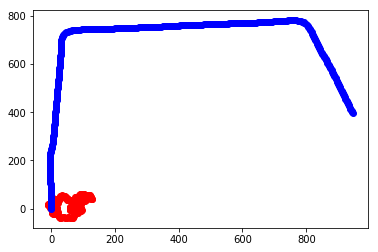

Count:1941
()
()
Relative Depth: 10.65118199264398
Relative x: 11.370610926965403
Relative Original Depth: -394.90179858963756
Relative Original x: 945.8426447132134
Count:1942
()
()
Relative Depth: 11.065186243473818
Relative x: 10.979692021155394
Relative Original Depth: -393.956299957269
Relative Original x: 946.1461810830053
Count:1943
()
()
Relative Depth: 11.397137786405208
Relative x: 10.404433720487976
Relative Original Depth: -393.01879167246085
Relative Original x: 946.4813901034889
Count:1944
()
()
Relative Depth: 11.630110527084193
Relative x: 9.691766471866355
Relative Original Depth: -392.0857642100125
Relative Original x: 946.8268773557253
Count:1945
()
()
Relative Depth: 11.390320113400634
Relative x: 8.898531842242653
Relative Original Depth: -391.14999209230524
Relative Original x: 947.1719752623895


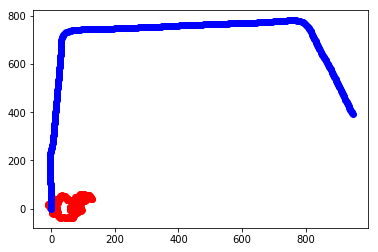

Count:1946
()
()
Relative Depth: 10.797613462685872
Relative x: 8.110104614707152
Relative Original Depth: -390.21863924300675
Relative Original x: 947.5259153422979
Count:1947
()
()
Relative Depth: 10.358724411541155
Relative x: 7.5070546932412086
Relative Original Depth: -389.2872246319476
Relative Original x: 947.8837907931087
Count:1948
()
()
Relative Depth: 9.863359553750152
Relative x: 7.087291988618656
Relative Original Depth: -388.3573395280143
Relative Original x: 948.2471840345418
Count:1949
()
()
Relative Depth: 9.324835230380003
Relative x: 6.737412997731489
Relative Original Depth: -387.4245980000972
Relative Original x: 948.5985373766235
Count:1950
()
()
Relative Depth: 8.796594646790338
Relative x: 6.406104121646352
Relative Original Depth: -386.4869210352681
Relative Original x: 948.9379788641946


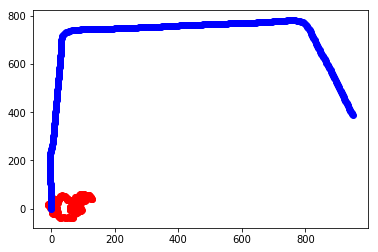

Count:1951
()
()
Relative Depth: 8.416005532567407
Relative x: 6.389088207303886
Relative Original Depth: -385.5456560389758
Relative Original x: 949.2664434571067
Count:1952
()
()
Relative Depth: 7.853474621224588
Relative x: 6.714867242050694
Relative Original Depth: -384.6072188522047
Relative Original x: 949.5974270371884
Count:1953
()
()
Relative Depth: 7.137037548309044
Relative x: 7.129142906385067
Relative Original Depth: -383.66662640747757
Relative Original x: 949.9267291759309
Count:1954
()
()
Relative Depth: 6.364348829931975
Relative x: 7.136071669888843
Relative Original Depth: -382.7338320871657
Relative Original x: 950.2840143759003
Count:1955
()
()
Relative Depth: 5.680379584161151
Relative x: 6.612942985044371
Relative Original Depth: -381.8019663413424
Relative Original x: 950.6392482198212


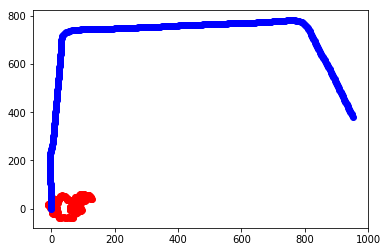

Count:1956
()
()
Relative Depth: 4.990290717148166
Relative x: 6.1703898153479955
Relative Original Depth: -380.8708483101382
Relative Original x: 950.9984727261118
Count:1957
()
()
Relative Depth: 4.182869431199445
Relative x: 5.837476202122713
Relative Original Depth: -379.93505294245375
Relative Original x: 951.3448388981722
Count:1958
()
()
Relative Depth: 3.455600213752353
Relative x: 5.170661129198349
Relative Original Depth: -379.0015532736187
Relative Original x: 951.6957555211948
Count:1959
()
()
Relative Depth: 3.7250684081558956
Relative x: 4.208809441705524
Relative Original Depth: -378.0665579022418
Relative Original x: 952.0379513630542
Count:1960
()
()
Relative Depth: 4.590373369979917
Relative x: 3.710564338071953
Relative Original Depth: -377.12212097643453
Relative Original x: 952.355533617944


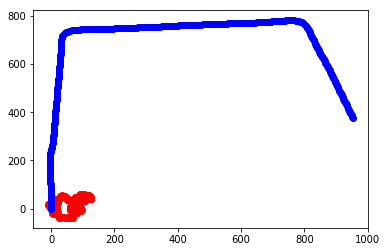

Count:1961
()
()
Relative Depth: 4.480480054823185
Relative x: 2.7166222706329037
Relative Original Depth: -376.1786027886233
Relative Original x: 952.6789451012286
Count:1962
()
()
Relative Depth: 5.254868405364838
Relative x: 2.0964979310250387
Relative Original Depth: -375.23754802995717
Relative Original x: 953.0020408427678
Count:1963
()
()
Relative Depth: 5.9203448361999245
Relative x: 1.3812687877580898
Relative Original Depth: -374.2989994547796
Relative Original x: 953.3315154263289
Count:1964
()
()
Relative Depth: 6.632318943552921
Relative x: 0.7001822070002891
Relative Original Depth: -373.3627556341863
Relative Original x: 953.6702770802858
Count:1965
()
()
Relative Depth: 6.81952122873707
Relative x: -0.24169111194478166
Relative Original Depth: -372.42578908524604
Relative Original x: 954.008517190412


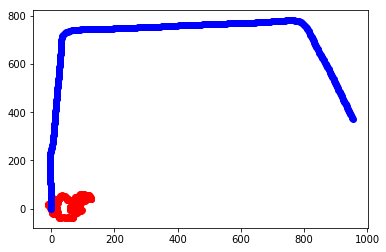

Count:1966
()
()
Relative Depth: 6.384209469280419
Relative x: -1.1083807670994164
Relative Original Depth: -371.491893887776
Relative Original x: 954.3577809782025
Count:1967
()
()
Relative Depth: 6.054434025177492
Relative x: -2.0473700578733336
Relative Original Depth: -370.56071568332777
Relative Original x: 954.7143619592547
Count:1968
()
()
Relative Depth: 5.739551411821952
Relative x: -2.994257259034627
Relative Original Depth: -369.6260528887069
Relative Original x: 955.0640798673213
Count:1969
()
()
Relative Depth: 5.342120898484729
Relative x: -3.9076615114763267
Relative Original Depth: -368.6924018023011
Relative Original x: 955.414324128212
Count:1970
()
()
Relative Depth: 4.926536576432465
Relative x: -3.1193719021740325
Relative Original Depth: -367.7531340334973
Relative Original x: 955.7500514159658


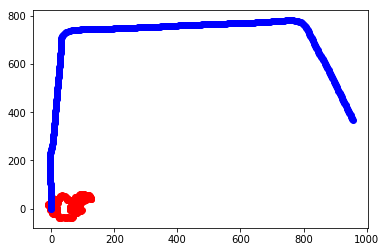

Count:1971
()
()
Relative Depth: 4.673460210962889
Relative x: -4.086815033171543
Relative Original Depth: -366.8163336041782
Relative Original x: 956.0914850523346
Count:1972
()
()
Relative Depth: 4.628432582769574
Relative x: -5.080111309683462
Relative Original Depth: -365.8646827853361
Relative Original x: 956.3879477255804
Count:1973
()
()
Relative Depth: 4.523415953763905
Relative x: -6.072238521354669
Relative Original Depth: -364.9190879814617
Relative Original x: 956.7089197418086
Count:1974
()
()
Relative Depth: 4.45099755622752
Relative x: -7.068486982500559
Relative Original Depth: -363.97348836065305
Relative Original x: 957.0254743747754
Count:1975
()
()
Relative Depth: 5.155705562016374
Relative x: -7.731003913681326
Relative Original Depth: -363.0385292194926
Relative Original x: 957.3735778393086


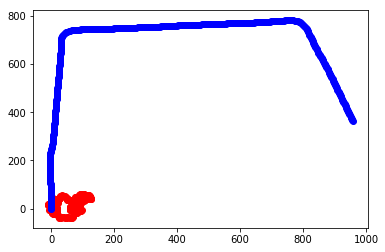

Count:1976
()
()
Relative Depth: 6.1284188261129975
Relative x: -7.697596414526668
Relative Original Depth: -362.1047204520593
Relative Original x: 957.7252907864124
Count:1977
()
()
Relative Depth: 7.099908302420447
Relative x: -7.600171628974423
Relative Original Depth: -361.1699490132297
Relative Original x: 958.0736008293239
Count:1978
()
()
Relative Depth: 8.080305142609705
Relative x: -7.414602708209221
Relative Original Depth: -360.2407611071493
Relative Original x: 958.437773265708
Count:1979
()
()
Relative Depth: 9.054296846658886
Relative x: -7.1985824404170335
Relative Original Depth: -359.3036855098256
Relative Original x: 958.7785087923967
Count:1980
()
()
Relative Depth: 10.044983287997116
Relative x: -7.066650803853431
Relative Original Depth: -358.3632792042421
Relative Original x: 959.1096600782247


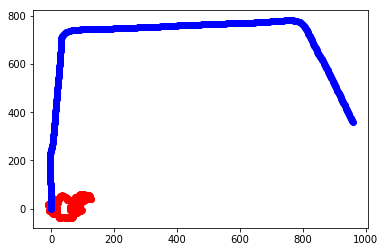

Count:1981
()
()
Relative Depth: 11.016091285261664
Relative x: -7.103993520667467
Relative Original Depth: -357.4152864770784
Relative Original x: 959.419787509386
Count:1982
()
()
Relative Depth: 11.981186797722982
Relative x: -7.176442744640421
Relative Original Depth: -356.47346792853585
Relative Original x: 959.7461953708932
Count:1983
()
()
Relative Depth: 12.944855384735765
Relative x: -7.069825551764471
Relative Original Depth: -355.52679789597914
Relative Original x: 960.0589041910904
Count:1984
()
()
Relative Depth: 13.68762857330129
Relative x: -6.908925033640772
Relative Original Depth: -354.5929571749231
Relative Original x: 960.4122779694363
Count:1985
()
()
Relative Depth: 13.849599642342302
Relative x: -6.715327913468258
Relative Original Depth: -353.6616836524237
Relative Original x: 960.7697249160617


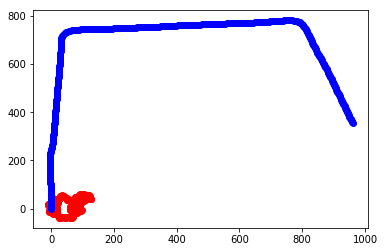

Count:1986
()
()
Relative Depth: 13.420346043857657
Relative x: -6.533580302507789
Relative Original Depth: -352.7222993790633
Relative Original x: 961.1097374665145
Count:1987
()
()
Relative Depth: 12.920916199309136
Relative x: -6.114499398397513
Relative Original Depth: -351.77857986649855
Relative Original x: 961.4350323403946
Count:1988
()
()
Relative Depth: 12.512378346234785
Relative x: -5.651684822652412
Relative Original Depth: -350.8389147384131
Relative Original x: 961.7731217551826
Count:1989
()
()
Relative Depth: 12.291681867803002
Relative x: -5.352545301928169
Relative Original Depth: -349.90287718530465
Relative Original x: 962.1218131373963
Count:1990
()
()
Relative Depth: 11.872967490926063
Relative x: -4.965632677724148
Relative Original Depth: -348.959296147583
Relative Original x: 962.4484730214391


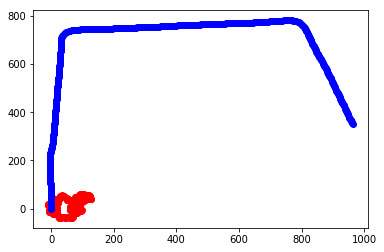

Count:1991
()
()
Relative Depth: 11.304944236409675
Relative x: -4.375434438742664
Relative Original Depth: -348.01195335284064
Relative Original x: 962.7600534483806
Count:1992
()
()
Relative Depth: 10.69145178620414
Relative x: -3.6732741375743223
Relative Original Depth: -347.0604106289591
Relative Original x: 963.0518638932979
Count:1993
()
()
Relative Depth: 9.970341089974353
Relative x: -3.473709865958713
Relative Original Depth: -346.11988666934826
Relative Original x: 963.3757324404161
Count:1994
()
()
Relative Depth: 10.120669456601401
Relative x: -4.2286162770707145
Relative Original Depth: -345.1854286501752
Relative Original x: 963.715523258877
Count:1995
()
()
Relative Depth: 9.51312068318479
Relative x: -4.554300990418843
Relative Original Depth: -344.24621403160495
Relative Original x: 964.0394948840654


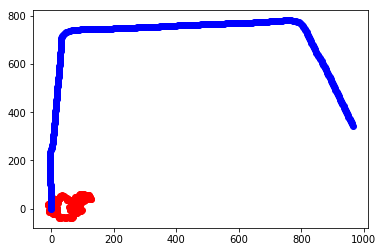

Count:1996
()
()
Relative Depth: 8.81582396799316
Relative x: -5.018600468241482
Relative Original Depth: -343.3022024895381
Relative Original x: 964.3382910053232
Count:1997
()
()
Relative Depth: 7.838991868365998
Relative x: -5.091971231997432
Relative Original Depth: -342.3630648012975
Relative Original x: 964.6623988135502
Count:1998
()
()
Relative Depth: 7.155797443024273
Relative x: -5.724120189195056
Relative Original Depth: -341.4277605190624
Relative Original x: 965.0031264325052
Count:1999
()
()
Relative Depth: 6.446107325360375
Relative x: -6.397052992839104
Relative Original Depth: -340.48765988781753
Relative Original x: 965.336327171812
Count:2000
()
()
Relative Depth: 5.719900826816179
Relative x: -7.082019798328263
Relative Original Depth: -339.54234105312344
Relative Original x: 965.6543162225496


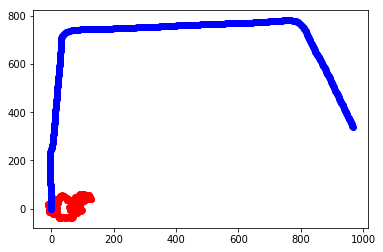

Count:2001
()
()
Relative Depth: 4.918750829169104
Relative x: -7.590788657897251
Relative Original Depth: -338.59674041967185
Relative Original x: 965.9774778512962
Count:2002
()
()
Relative Depth: 4.198870390046504
Relative x: -7.679710111156245
Relative Original Depth: -337.64376435324573
Relative Original x: 966.2586976083126
Count:2003
()
()
Relative Depth: 3.6113423444844504
Relative x: -7.361925518001347
Relative Original Depth: -336.70747666520464
Relative Original x: 966.6044658023466
Count:2004
()
()
Relative Depth: 3.615564625253008
Relative x: -6.733706040760022
Relative Original Depth: -335.764657402512
Relative Original x: 966.9298760270826
Count:2005
()
()
Relative Depth: 4.0482408254801365
Relative x: -6.149952962447236
Relative Original Depth: -334.8222491450629
Relative Original x: 967.2545864623435


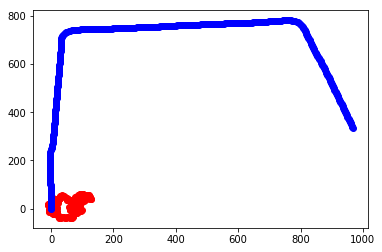

Count:2006
()
()
Relative Depth: 4.438945784737047
Relative x: -5.598484569644871
Relative Original Depth: -333.885398747936
Relative Original x: 967.6030038392213
Count:2007
()
()
Relative Depth: 4.585462081071267
Relative x: -4.6786024164228825
Relative Original Depth: -332.94429294884685
Relative Original x: 967.9342878269642
Count:2008
()
()
Relative Depth: 4.461203756260852
Relative x: -3.7006339947647557
Relative Original Depth: -332.00494312278084
Relative Original x: 968.2733718140621
Count:2009
()
()
Relative Depth: 4.304294629278653
Relative x: -2.7280518237762945
Relative Original Depth: -331.0649898139029
Relative Original x: 968.6111787790452
Count:2010
()
()
Relative Depth: 4.4232820545970615
Relative x: -1.9860264119353435
Relative Original Depth: -330.1133359862266
Relative Original x: 968.9080346835206


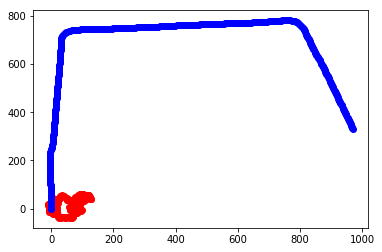

Count:2011
()
()
Relative Depth: 4.1186768908635845
Relative x: -1.6253032221695438
Relative Original Depth: -329.1672751855694
Relative Original x: 969.2233129280003
Count:2012
()
()
Relative Depth: 3.4766687293550027
Relative x: -0.8685188665628609
Relative Original Depth: -328.2292369698133
Relative Original x: 969.5644379077842
Count:2013
()
()
Relative Depth: 3.18164882883025
Relative x: 0.08152344332219208
Relative Original Depth: -327.2891718675183
Relative Original x: 969.9011733071328
Count:2014
()
()
Relative Depth: 2.8465871624081642
Relative x: 1.0229688922078823
Relative Original Depth: -326.3613575299494
Relative Original x: 970.2695273631975
Count:2015
()
()
Relative Depth: 2.641742534777717
Relative x: 2.0002819619859418
Relative Original Depth: -325.4266500132357
Relative Original x: 970.6191542794273


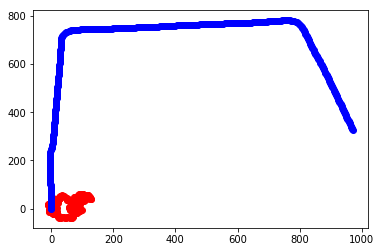

Count:2016
()
()
Relative Depth: 2.6015769088469427
Relative x: 2.9939810961806015
Relative Original Depth: -324.490818656441
Relative Original x: 970.9627137940852
Count:2017
()
()
Relative Depth: 2.427287517649327
Relative x: 3.978162358078828
Relative Original Depth: -323.55130141280347
Relative Original x: 971.2923812339691
Count:2018
()
()
Relative Depth: 1.8675211337536468
Relative x: 4.7743097714862355
Relative Original Depth: -322.61425133937576
Relative Original x: 971.6321619267792
Count:2019
()
()
Relative Depth: 1.2140765160144422
Relative x: 5.36342244425413
Relative Original Depth: -321.66944879581047
Relative Original x: 971.9485544019385
Count:2020
()
()
Relative Depth: 0.6603131767711556
Relative x: 6.1686609336122045
Relative Original Depth: -320.7254860428212
Relative Original x: 972.2701132010133


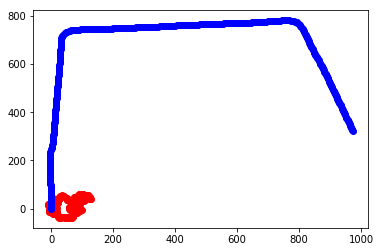

Count:2021
()
()
Relative Depth: 0.7025995942971959
Relative x: 7.145127397307133
Relative Original Depth: -319.77035435483873
Relative Original x: 972.5473967534008
Count:2022
()
()
Relative Depth: 1.234916688590322
Relative x: 7.932926322959871
Relative Original Depth: -318.82783161482786
Relative Original x: 972.8721155843061
Count:2023
()
()
Relative Depth: 2.0068245899995585
Relative x: 8.474764861745616
Relative Original Depth: -317.8837187971865
Relative Original x: 973.1939151302845
Count:2024
()
()
Relative Depth: 1.8009974468986207
Relative x: 7.612920912231717
Relative Original Depth: -316.93848628106633
Relative Original x: 973.5133706940683
Count:2025
()
()
Relative Depth: 2.03151489244291
Relative x: 8.190248239184589
Relative Original Depth: -316.01679289537293
Relative Original x: 973.8975980147154


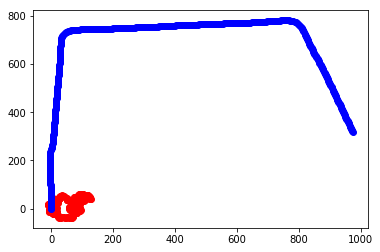

Count:2026
()
()
Relative Depth: 1.8145708053403977
Relative x: 8.393582847366813
Relative Original Depth: -315.0850034862778
Relative Original x: 974.2574386031217
Count:2027
()
()
Relative Depth: 1.5262459193951927
Relative x: 9.277383216498604
Relative Original Depth: -314.15381125880776
Relative Original x: 974.6155059336537
Count:2028
()
()
Relative Depth: 1.2678835367252907
Relative x: 9.531411527661408
Relative Original Depth: -313.2103227341613
Relative Original x: 974.9286763528961
Count:2029
()
()
Relative Depth: 1.332795486884812
Relative x: 8.536368444278585
Relative Original Depth: -312.27327909874634
Relative Original x: 975.2686270724345
Count:2030
()
()
Relative Depth: 1.106963041031252
Relative x: 8.64316629611652
Relative Original Depth: -311.33560308066063
Relative Original x: 975.6120720312879


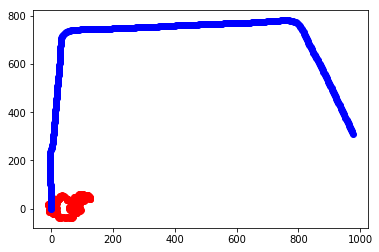

Count:2031
()
()
Relative Depth: 0.7566758988941586
Relative x: 9.070208273888342
Relative Original Depth: -310.38929245751297
Relative Original x: 975.9262284867575
Count:2032
()
()
Relative Depth: 0.5210973230785898
Relative x: 10.013336360248212
Relative Original Depth: -309.44931684876605
Relative Original x: 976.2604309447323
Count:2033
()
()
Relative Depth: 0.4240604589102004
Relative x: 10.998249022772377
Relative Original Depth: -308.50313132242354
Relative Original x: 976.5765467984485
Count:2034
()
()
Relative Depth: 0.801382457338586
Relative x: 11.924275272902007
Relative Original Depth: -307.5625159139375
Relative Original x: 976.9090807958386
Count:2035
()
()
Relative Depth: 1.5636577868590005
Relative x: 12.531212028537524
Relative Original Depth: -306.62260372959275
Relative Original x: 977.2456444420309


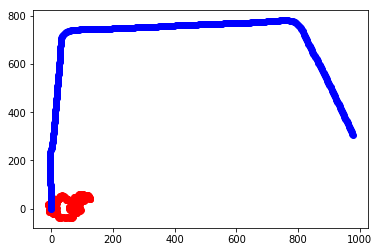

Count:2036
()
()
Relative Depth: 2.3126214300955032
Relative x: 13.091670614319879
Relative Original Depth: -305.6868739451775
Relative Original x: 977.5926659737517
Count:2037
()
()
Relative Depth: 3.030167934255735
Relative x: 13.1800012325806
Relative Original Depth: -304.7512857890669
Relative Original x: 977.9446016750281
Count:2038
()
()
Relative Depth: 2.264499932963876
Relative x: 12.767341247838509
Relative Original Depth: -303.8086709083105
Relative Original x: 978.2640415879846
Count:2039
()
()
Relative Depth: 2.852574061467562
Relative x: 12.73322825954559
Relative Original Depth: -302.86449359208757
Relative Original x: 978.5816948382926
Count:2040
()
()
Relative Depth: 3.5511019891190942
Relative x: 13.087257978624224
Relative Original Depth: -301.9185195211413
Relative Original x: 978.8941153950185


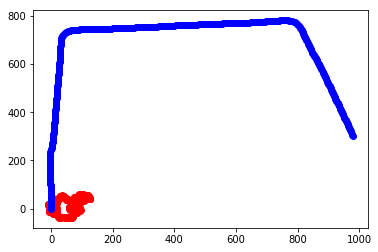

Count:2041
()
()
Relative Depth: 4.032727155739669
Relative x: 13.733701215259924
Relative Original Depth: -300.9786979957884
Relative Original x: 979.2333278761575
Count:2042
()
()
Relative Depth: 4.26853810903374
Relative x: 14.537678989849491
Relative Original Depth: -300.0379638161585
Relative Original x: 979.5646785766904
Count:2043
()
()
Relative Depth: 4.144659489638538
Relative x: 13.71974522654061
Relative Original Depth: -299.096219022035
Relative Original x: 979.895750964746
Count:2044
()
()
Relative Depth: 4.4426963242285264
Relative x: 14.440602920073337
Relative Original Depth: -298.14880944151747
Relative Original x: 980.2067399655584
Count:2045
()
()
Relative Depth: 4.777805296064823
Relative x: 15.169910079204008
Relative Original Depth: -297.20990275714956
Relative Original x: 980.5430775666553


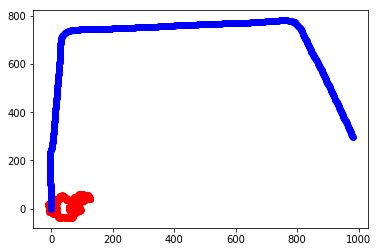

Count:2046
()
()
Relative Depth: 4.938461571115977
Relative x: 15.924109737203581
Relative Original Depth: -296.2663886954016
Relative Original x: 980.864863773679
Count:2047
()
()
Relative Depth: 4.846775618328063
Relative x: 16.637345750507514
Relative Original Depth: -295.3200340089708
Relative Original x: 981.1816602417933
Count:2048
()
()
Relative Depth: 4.701942656689151
Relative x: 17.355117649553
Relative Original Depth: -294.38773519585794
Relative Original x: 981.5367131935424
Count:2049
()
()
Relative Depth: 4.533147847292635
Relative x: 18.081700246925852
Relative Original Depth: -293.4433132065508
Relative Original x: 981.8560422971573
Count:2050
()
()
Relative Depth: 4.4402162356639545
Relative x: 18.819415798155198
Relative Original Depth: -292.49931747656024
Relative Original x: 982.1740688181009


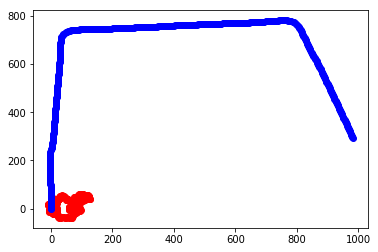

Count:2051
()
()
Relative Depth: 4.50225847906892
Relative x: 19.60091446249287
Relative Original Depth: -291.5551038067738
Relative Original x: 982.4919732890382
Count:2052
()
()
Relative Depth: 4.436267281620425
Relative x: 20.380390338969644
Relative Original Depth: -290.6113456080755
Relative Original x: 982.8139963946215
Count:2053
()
()
Relative Depth: 4.185966563095014
Relative x: 21.09503328967038
Relative Original Depth: -289.66632143439716
Relative Original x: 983.1345574755752
Count:2054
()
()
Relative Depth: 3.902818186190831
Relative x: 21.79950706721
Relative Original Depth: -288.7174508506848
Relative Original x: 983.4384150521107
Count:2055
()
()
Relative Depth: 3.6001071427263995
Relative x: 22.425417004649276
Relative Original Depth: -287.7795518985196
Relative Original x: 983.7816491970046


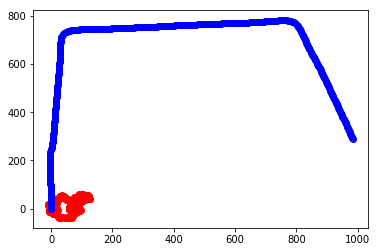

Count:2056
()
()
Relative Depth: 3.31898525255695
Relative x: 23.016507657749678
Relative Original Depth: -286.84099282024874
Relative Original x: 984.1185366269395
Count:2057
()
()
Relative Depth: 3.087974244457659
Relative x: 23.622708333118478
Relative Original Depth: -285.901562521146
Relative Original x: 984.4581821273874
Count:2058
()
()
Relative Depth: 2.9161348182255367
Relative x: 24.195363784025623
Relative Original Depth: -284.96155391599797
Relative Original x: 984.7945195786219
Count:2059
()
()
Relative Depth: 2.4952365700911194
Relative x: 24.770423001218347
Relative Original Depth: -284.01790509630837
Relative Original x: 985.1198763641263
Count:2060
()
()
Relative Depth: 1.8021271637350893
Relative x: 25.290020877111186
Relative Original Depth: -283.06882107619623
Relative Original x: 985.4274028171233


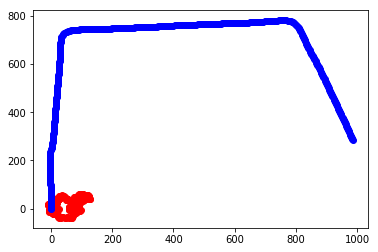

Count:2061
()
()
Relative Depth: 1.0466300498595102
Relative x: 25.777179663491502
Relative Original Depth: -282.1197195153874
Relative Original x: 985.738096694388
Count:2062
()
()
Relative Depth: 0.27001690334455775
Relative x: 26.250245146776273
Relative Original Depth: -281.1661609636785
Relative Original x: 986.0302179916034
Count:2063
()
()
Relative Depth: 0.9673964140787638
Relative x: 26.66704710737714
Relative Original Depth: -280.21477094098805
Relative Original x: 986.3300573968316
Count:2064
()
()
Relative Depth: 0.29196701038347506
Relative x: 27.238917258580948
Relative Original Depth: -279.27184436305737
Relative Original x: 986.6581063518461
Count:2065
()
()
Relative Depth: -0.28143817249587366
Relative x: 27.89198201622244
Relative Original Depth: -278.31693306960767
Relative Original x: 986.9429228464988


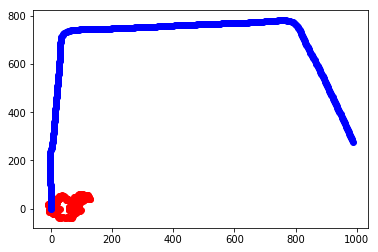

Count:2066
()
()
Relative Depth: -0.47046656160937494
Relative x: 28.450718520182352
Relative Original Depth: -277.3743878906767
Relative Original x: 987.2706107464627
Count:2067
()
()
Relative Depth: 0.29714819400039083
Relative x: 28.67240431666048
Relative Original Depth: -276.43037265961385
Relative Original x: 987.5911597480819
Count:2068
()
()
Relative Depth: 1.2887190139340863
Relative x: 28.80170023151888
Relative Original Depth: -275.47919581661813
Relative Original x: 987.8938166645873
Count:2069
()
()
Relative Depth: 2.268935634474148
Relative x: 28.998687614505844
Relative Original Depth: -274.53556743974025
Relative Original x: 988.2174844921364
Count:2070
()
()
Relative Depth: 3.246282812736755
Relative x: 29.129167785956643
Relative Original Depth: -273.5870573749447
Relative Original x: 988.5292227615613


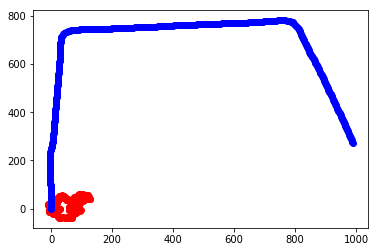

Count:2071
()
()
Relative Depth: 4.150266995609856
Relative x: 29.261880911421038
Relative Original Depth: -272.63577662705654
Relative Original x: 988.835044235598
Count:2072
()
()
Relative Depth: 4.648990639641559
Relative x: 29.37118113802429
Relative Original Depth: -271.68415892695964
Relative Original x: 989.133031447019
Count:2073
()
()
Relative Depth: 5.519389501741808
Relative x: 29.666744885084093
Relative Original Depth: -270.7363434097352
Relative Original x: 989.4400887842444
Count:2074
()
()
Relative Depth: 6.389358652893656
Relative x: 30.0917025791314
Relative Original Depth: -269.7831710129376
Relative Original x: 989.7327434626434
Count:2075
()
()
Relative Depth: 6.048793084724849
Relative x: 30.801752920655623
Relative Original Depth: -268.8310662957812
Relative Original x: 990.031857229796


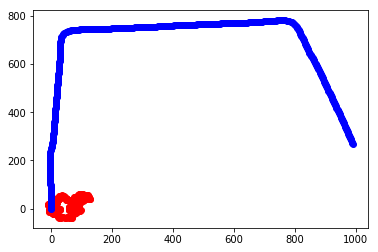

Count:2076
()
()
Relative Depth: 6.911520830494848
Relative x: 31.2752651075352
Relative Original Depth: -267.8761771455065
Relative Original x: 990.3183879341552
Count:2077
()
()
Relative Depth: 7.725007365063224
Relative x: 31.789615879626965
Relative Original Depth: -266.9286956943624
Relative Original x: 990.6245469262543
Count:2078
()
()
Relative Depth: 8.498166386640312
Relative x: 32.32838429438074
Relative Original Depth: -265.9793748049193
Relative Original x: 990.9337867134275
Count:2079
()
()
Relative Depth: 9.067396241060397
Relative x: 33.05326043055576
Relative Original Depth: -265.02504718097555
Relative Original x: 991.2269946185661
Count:2080
()
()
Relative Depth: 9.171417101179973
Relative x: 33.88603292889357
Relative Original Depth: -264.075144802513
Relative Original x: 991.5303217314909


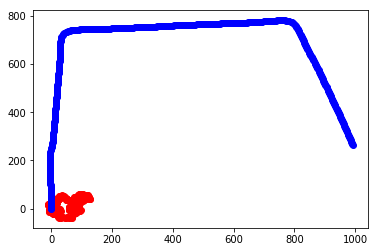

Count:2081
()
()
Relative Depth: 9.10397416668557
Relative x: 34.651542241575676
Relative Original Depth: -263.1209729649616
Relative Original x: 991.823065985156
Count:2082
()
()
Relative Depth: 8.867187340877601
Relative x: 34.92624436984345
Relative Original Depth: -262.16337295322944
Relative Original x: 992.1040001233681
Count:2083
()
()
Relative Depth: 8.549789517276603
Relative x: 34.650757732067106
Relative Original Depth: -261.2136298713168
Relative Original x: 992.4111968496816
Count:2084
()
()
Relative Depth: 8.284460044407584
Relative x: 34.13771075297051
Relative Original Depth: -260.26001129311913
Relative Original x: 992.7039749427701
Count:2085
()
()
Relative Depth: 9.14201705977541
Relative x: 34.46964017952519
Relative Original Depth: -259.30815380972774
Relative Original x: 993.0049410717583


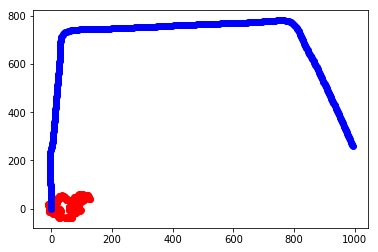

Count:2086
()
()
Relative Depth: 9.166141276342058
Relative x: 33.68253817755302
Relative Original Depth: -258.35606402271634
Relative Original x: 993.2997369546015
Count:2087
()
()
Relative Depth: 8.97152758917488
Relative x: 34.34802172441326
Relative Original Depth: -257.40022681002154
Relative Original x: 993.5874233629809
Count:2088
()
()
Relative Depth: 8.887709283328086
Relative x: 33.35324130403066
Relative Original Depth: -256.4482973246785
Relative Original x: 993.883873278202
Count:2089
()
()
Relative Depth: 8.763916118533725
Relative x: 32.56043445169816
Relative Original Depth: -255.49711542584083
Relative Original x: 994.1783607797398
Count:2090
()
()
Relative Depth: 8.565142370516776
Relative x: 31.75103456571516
Relative Original Depth: -254.54444402973488
Relative Original x: 994.4715455718315


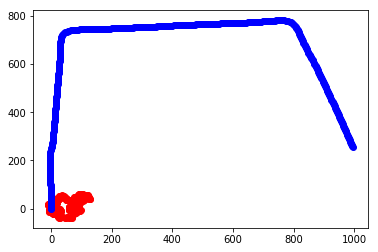

Count:2091
()
()
Relative Depth: 8.182509983085577
Relative x: 30.999723609261327
Relative Original Depth: -253.5896891598511
Relative Original x: 994.7581305466578
Count:2092
()
()
Relative Depth: 7.693227947427624
Relative x: 30.348953178514037
Relative Original Depth: -252.63749163613159
Relative Original x: 995.0503845560663
Count:2093
()
()
Relative Depth: 7.225291394433227
Relative x: 29.801741729390393
Relative Original Depth: -251.68021252186637
Relative Original x: 995.3302506902011
Count:2094
()
()
Relative Depth: 6.903444424941056
Relative x: 29.24605926565839
Relative Original Depth: -250.72511206921416
Relative Original x: 995.6182548937886
Count:2095
()
()
Relative Depth: 6.545644818236903
Relative x: 28.551351525972013
Relative Original Depth: -249.7652348133621
Relative Original x: 995.8962142027979


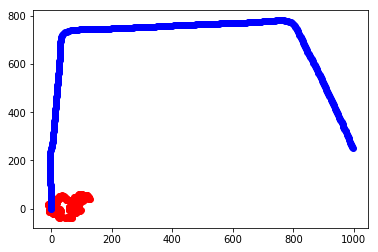

Count:2096
()
()
Relative Depth: 6.104589102548079
Relative x: 27.727255677668115
Relative Original Depth: -248.81409272941698
Relative Original x: 996.201868403124
Count:2097
()
()
Relative Depth: 5.971019577441289
Relative x: 26.809710280167444
Relative Original Depth: -247.85657101079562
Relative Original x: 996.4854493153324
Count:2098
()
()
Relative Depth: 5.870052820902623
Relative x: 25.887223995418676
Relative Original Depth: -246.9009467769901
Relative Original x: 996.7726279618654
Count:2099
()
()
Relative Depth: 5.550689573957578
Relative x: 24.973974931989197
Relative Original Depth: -245.9482150681854
Relative Original x: 997.0679676557081
Count:2100
()
()
Relative Depth: 5.338000859633731
Relative x: 24.083455348757376
Relative Original Depth: -244.99405007835702
Relative Original x: 997.3589262514624


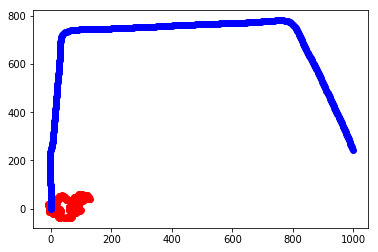

Count:2101
()
()
Relative Depth: 5.190347014498305
Relative x: 23.249886579567367
Relative Original Depth: -244.03258004604643
Relative Original x: 997.6246227328494
Count:2102
()
()
Relative Depth: 4.84749836138974
Relative x: 22.418846643517465
Relative Original Depth: -243.07303007078605
Relative Original x: 997.898380937385
Count:2103
()
()
Relative Depth: 4.364297797147405
Relative x: 21.595982381848255
Relative Original Depth: -242.11925916933134
Relative Original x: 998.1905023412284
Count:2104
()
()
Relative Depth: 3.9030899936877956
Relative x: 20.762146715493966
Relative Original Depth: -241.16123317215573
Relative Original x: 998.4688331273761
Count:2105
()
()
Relative Depth: 3.4065678873333125
Relative x: 19.93206483268563
Relative Original Depth: -240.2009588284643
Relative Original x: 998.7421335406426


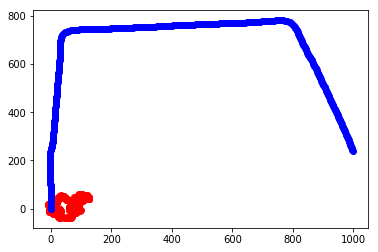

Count:2106
()
()
Relative Depth: 2.683242080408945
Relative x: 19.242223732687457
Relative Original Depth: -239.24185624943746
Relative Original x: 999.0153615201598
Count:2107
()
()
Relative Depth: 1.9936831059215376
Relative x: 18.837852890112153
Relative Original Depth: -238.28396654259006
Relative Original x: 999.2951422849383
Count:2108
()
()
Relative Depth: 1.6343371471898052
Relative x: 18.53339162117726
Relative Original Depth: -237.33071779320701
Relative Original x: 999.5887431495149
Count:2109
()
()
Relative Depth: 1.2295035299151746
Relative x: 17.690356971960096
Relative Original Depth: -236.37415120988035
Relative Original x: 999.8720519712695
Count:2110
()
()
Relative Depth: 0.862604367341582
Relative x: 17.17353598912453
Relative Original Depth: -235.41588463529456
Relative Original x: 1000.1495805635619


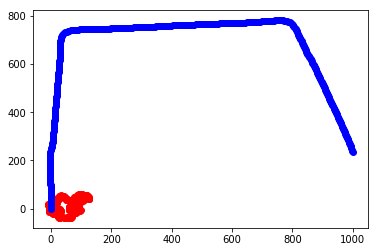

Count:2111
()
()
Relative Depth: 0.7176311004818566
Relative x: 16.336531820926805
Relative Original Depth: -234.45682166395463
Relative Original x: 1000.4215674823888
Count:2112
()
()
Relative Depth: 0.7683190250827431
Relative x: 15.34315951837073
Relative Original Depth: -233.49151408339563
Relative Original x: 1000.6761168148562
Count:2113
()
()
Relative Depth: 0.6354001845189763
Relative x: 14.36212671141035
Relative Original Depth: -232.52805482216365
Relative Original x: 1000.9341729281055
Count:2114
()
()
Relative Depth: 1.038176637835105
Relative x: 13.460946701090755
Relative Original Depth: -231.57428123664883
Relative Original x: 1001.2231317343467
Count:2115
()
()
Relative Depth: 1.8518884054892388
Relative x: 12.8828688119074
Relative Original Depth: -230.61182622309042
Relative Original x: 1001.4839634204558


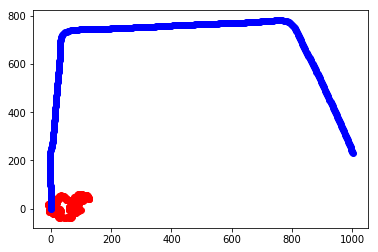

Count:2116
()
()
Relative Depth: 2.5052016902325036
Relative x: 12.135156745658227
Relative Original Depth: -229.6519772760066
Relative Original x: 1001.751339721815
Count:2117
()
()
Relative Depth: 3.0251007323716026
Relative x: 11.297495146038013
Relative Original Depth: -228.6940412232348
Relative Original x: 1002.0324958786309
Count:2118
()
()
Relative Depth: 3.633629037284572
Relative x: 10.528574415195063
Relative Original Depth: -227.73860329310287
Relative Original x: 1002.3207271557669
Count:2119
()
()
Relative Depth: 4.272995850324866
Relative x: 9.90709265423808
Relative Original Depth: -226.7738423147864
Relative Original x: 1002.580012269543
Count:2120
()
()
Relative Depth: 4.93863611550332
Relative x: 9.357013712238468
Relative Original Depth: -225.8106438849637
Relative Original x: 1002.8421696278238


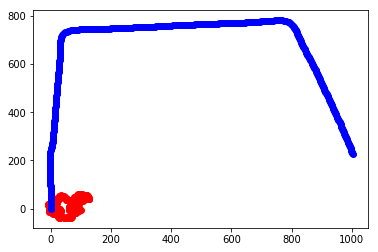

Count:2121
()
()
Relative Depth: 5.654257146790762
Relative x: 8.6786367519377
Relative Original Depth: -224.84629586084884
Relative Original x: 1003.0977685368454
Count:2122
()
()
Relative Depth: 6.338381641534936
Relative x: 7.949705896467049
Relative Original Depth: -223.8854297205163
Relative Original x: 1003.3699928640548
Count:2123
()
()
Relative Depth: 6.91155722147894
Relative x: 7.1656673507124555
Relative Original Depth: -222.9208543944133
Relative Original x: 1003.6259701636014
Count:2124
()
()
Relative Depth: 7.31836020962668
Relative x: 6.335936424471275
Relative Original Depth: -221.95828337738985
Relative Original x: 1003.8874404070885
Count:2125
()
()
Relative Depth: 8.09585661437002
Relative x: 5.802246685637739
Relative Original Depth: -221.00175615197682
Relative Original x: 1004.1668878639009


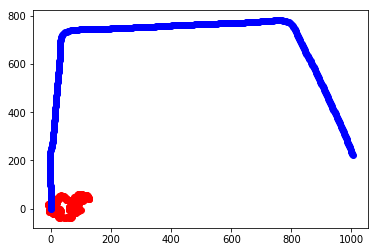

Count:2126
()
()
Relative Depth: 9.063146044773482
Relative x: 5.549245360028981
Relative Original Depth: -220.04371288036415
Relative Original x: 1004.4453348438627
Count:2127
()
()
Relative Depth: 9.211094601242216
Relative x: 5.349114162681276
Relative Original Depth: -219.08487060520713
Relative Original x: 1004.7173355499327
Count:2128
()
()
Relative Depth: 10.093033289513397
Relative x: 4.913371703272364
Relative Original Depth: -218.1217549823148
Relative Original x: 1004.9740711569556
Count:2129
()
()
Relative Depth: 10.96920071212807
Relative x: 4.839922330254568
Relative Original Depth: -217.1592437323537
Relative Original x: 1005.2347226538708
Count:2130
()
()
Relative Depth: 11.890824268922689
Relative x: 4.453699270000428
Relative Original Depth: -216.18932473727367
Relative Original x: 1005.4771801015095


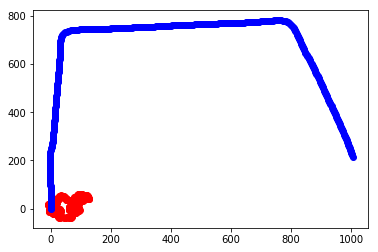

Count:2131
()
()
Relative Depth: 12.291812866397134
Relative x: 4.4028044761270495
Relative Original Depth: -215.22403503619768
Relative Original x: 1005.7359414382485
Count:2132
()
()
Relative Depth: 13.145218443268261
Relative x: 3.973543550857494
Relative Original Depth: -214.25742864400337
Relative Original x: 1005.9892397547115
Count:2133
()
()
Relative Depth: 13.89228981798266
Relative x: 3.3565453934200726
Relative Original Depth: -213.2937556485106
Relative Original x: 1006.2492753165092
Count:2134
()
()
Relative Depth: 14.318901353276098
Relative x: 2.515826468079732
Relative Original Depth: -212.3281993137583
Relative Original x: 1006.5024212157189
Count:2135
()
()
Relative Depth: 14.643588845384567
Relative x: 1.7584729681933686
Relative Original Depth: -211.36753561258047
Relative Original x: 1006.7693179129085


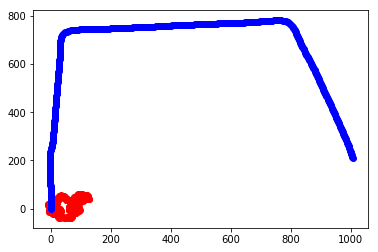

Count:2136
()
()
Relative Depth: 14.906054287320869
Relative x: 1.1021183219200512
Relative Original Depth: -210.40592287428817
Relative Original x: 1007.0328089971534
Count:2137
()
()
Relative Depth: 14.973164722723586
Relative x: 0.17123719806655957
Relative Original Depth: -209.44100481936826
Relative Original x: 1007.2867468144669
Count:2138
()
()
Relative Depth: 14.763175618599211
Relative x: 0.46383045891151115
Relative Original Depth: -208.48004976840522
Relative Original x: 1007.5528337260461
Count:2139
()
()
Relative Depth: 14.304078045484795
Relative x: -0.2356911735382186
Relative Original Depth: -207.50951290923956
Relative Original x: 1007.7804971388719
Count:2140
()
()
Relative Depth: 13.838093377472244
Relative x: -0.5085951151647958
Relative Original Depth: -206.54029270966757
Relative Original x: 1008.0196900410205


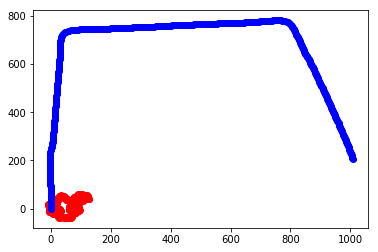

Count:2141
()
()
Relative Depth: 13.902795705068682
Relative x: 0.4698129810907765
Relative Original Depth: -205.56869056046904
Relative Original x: 1008.2511399926292
Count:2142
()
()
Relative Depth: 13.65102314495484
Relative x: 0.10451224779891488
Relative Original Depth: -204.59588617554056
Relative Original x: 1008.4753326605733
Count:2143
()
()
Relative Depth: 13.401549096326402
Relative x: -0.2653821540493293
Relative Original Depth: -203.62871615704157
Relative Original x: 1008.7216630834397
Count:2144
()
()
Relative Depth: 12.946737525683263
Relative x: -1.0532757437817422
Relative Original Depth: -202.65740879758604
Relative Original x: 1008.9444126516584
Count:2145
()
()
Relative Depth: 12.63911932718735
Relative x: -1.8533773679454075
Relative Original Depth: -201.6890906799725
Relative Original x: 1009.1734283663836


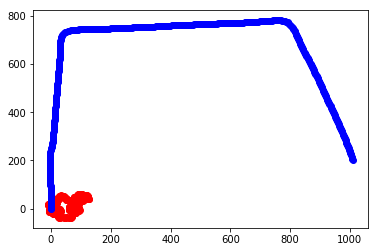

Count:2146
()
()
Relative Depth: 12.41268677230588
Relative x: -2.4623909616584765
Relative Original Depth: -200.71443769533766
Relative Original x: 1009.3828824838024
Count:2147
()
()
Relative Depth: 12.969779572844084
Relative x: -3.2871501858251277
Relative Original Depth: -199.7427811640779
Relative Original x: 1009.6068210732901
Count:2148
()
()
Relative Depth: 12.885145827289705
Relative x: -3.9839338161141122
Relative Original Depth: -198.7741165963477
Relative Original x: 1009.8512343914454
Count:2149
()
()
Relative Depth: 12.875548729735865
Relative x: -4.710175721898546
Relative Original Depth: -197.80800671089753
Relative Original x: 1010.1042526471911
Count:2150
()
()
Relative Depth: 12.828311189193073
Relative x: -5.411537344300331
Relative Original Depth: -196.8379492382966
Relative Original x: 1010.3404603947752


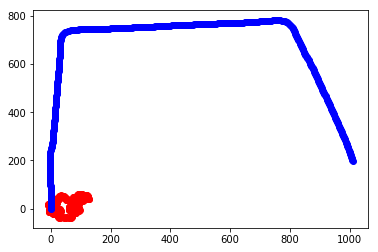

Count:2151
()
()
Relative Depth: 12.678644295885091
Relative x: -6.140170348375679
Relative Original Depth: -195.8629541476702
Relative Original x: 1010.553250397004
Count:2152
()
()
Relative Depth: 12.56829727771721
Relative x: -5.874744018831225
Relative Original Depth: -194.88748914414325
Relative Original x: 1010.760837329789
Count:2153
()
()
Relative Depth: 12.392047184708108
Relative x: -6.693786834029004
Relative Original Depth: -193.91194937698566
Relative Original x: 1010.9681147306998
Count:2154
()
()
Relative Depth: 12.14767259460571
Relative x: -7.636151453465896
Relative Original Depth: -192.94344654796544
Relative Original x: 1011.2147515500136
Count:2155
()
()
Relative Depth: 11.857869146396945
Relative x: -8.583660371728483
Relative Original Depth: -191.97054797706318
Relative Original x: 1011.4401403731628


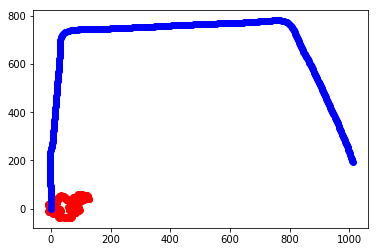

Count:2156
()
()
Relative Depth: 11.838100894898737
Relative x: -9.576323189087685
Relative Original Depth: -191.0043399576942
Relative Original x: 1011.6954943105417
Count:2157
()
()
Relative Depth: 11.821530587067093
Relative x: -10.513286635553875
Relative Original Depth: -190.0382535508388
Relative Original x: 1011.9461594179369
Count:2158
()
()
Relative Depth: 11.50017126587839
Relative x: -11.217530863961954
Relative Original Depth: -189.06628020161799
Relative Original x: 1012.1756834584545
Count:2159
()
()
Relative Depth: 12.188533445421841
Relative x: -11.677290588062222
Relative Original Depth: -188.09134386123313
Relative Original x: 1012.3883689305258
Count:2160
()
()
Relative Depth: 11.875945865153255
Relative x: -12.539190719601113
Relative Original Depth: -187.11422914995018
Relative Original x: 1012.5874519268211


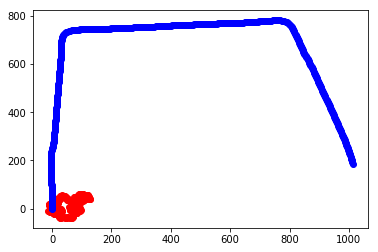

Count:2161
()
()
Relative Depth: 11.411821556289645
Relative x: -13.340746110584188
Relative Original Depth: -186.13889558666992
Relative Original x: 1012.7991309843542
Count:2162
()
()
Relative Depth: 10.924201147689589
Relative x: -14.006258382328754
Relative Original Depth: -185.16872793327562
Relative Original x: 1013.0283619555986
Count:2163
()
()
Relative Depth: 10.405442154225142
Relative x: -14.4864773574837
Relative Original Depth: -184.20390609379524
Relative Original x: 1013.2840838431232
Count:2164
()
()
Relative Depth: 9.93850770340484
Relative x: -15.19275523801288
Relative Original Depth: -183.2390961958044
Relative Original x: 1013.5391670264763
Count:2165
()
()
Relative Depth: 9.539970342601581
Relative x: -15.967786692250737
Relative Original Depth: -182.26619091140444
Relative Original x: 1013.7642335217797


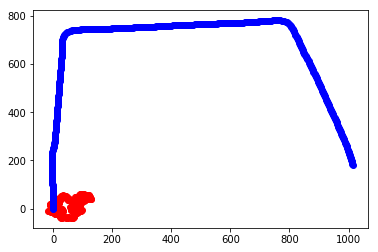

Count:2166
()
()
Relative Depth: 9.1794825432153
Relative x: -16.579586636523384
Relative Original Depth: -181.28620043296223
Relative Original x: 1013.9553942958645
Count:2167
()
()
Relative Depth: 8.820210989279074
Relative x: -17.224833778684705
Relative Original Depth: -180.30881685206253
Relative Original x: 1014.1555301645398
Count:2168
()
()
Relative Depth: 9.307806682144815
Relative x: -16.362184835503776
Relative Original Depth: -179.33252602014247
Relative Original x: 1014.3552622032299
Count:2169
()
()
Relative Depth: 8.702938908227427
Relative x: -17.064644065764778
Relative Original Depth: -178.361398233416
Relative Original x: 1014.57778761735
Count:2170
()
()
Relative Depth: 7.9047472365818905
Relative x: -17.644948642980943
Relative Original Depth: -177.38932965864615
Relative Original x: 1014.8035242973405


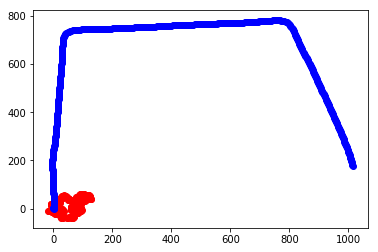

Count:2171
()
()
Relative Depth: 7.164722257075656
Relative x: -18.316213860799035
Relative Original Depth: -176.41408467499653
Relative Original x: 1015.0018857822408
Count:2172
()
()
Relative Depth: 6.44410576777544
Relative x: -18.867891535596026
Relative Original Depth: -175.43477011016085
Relative Original x: 1015.1900835332984
Count:2173
()
()
Relative Depth: 5.806393962006866
Relative x: -19.522708711507136
Relative Original Depth: -176.41707552688376
Relative Original x: 1015.0185134461171
Count:2174
()
()
Relative Depth: 5.131667222468065
Relative x: -20.065328390312548
Relative Original Depth: -177.39358870744715
Relative Original x: 1014.8203801151543
Count:2175
()
()
Relative Depth: 4.510263034942735
Relative x: -20.66675425840258
Relative Original Depth: -178.36997774526142
Relative Original x: 1014.6170597710069


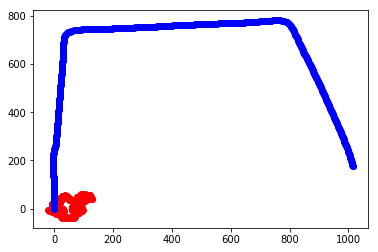

Count:2176
()
()
Relative Depth: 4.013948670589356
Relative x: -21.36213067448408
Relative Original Depth: -177.39479167320022
Relative Original x: 1014.8251821101612
Count:2177
()
()
Relative Depth: 3.521418199167802
Relative x: -22.072078824717394
Relative Original Depth: -176.4180381805834
Relative Original x: 1015.0310629675553
Count:2178
()
()
Relative Depth: 3.075433268323038
Relative x: -22.96048490343142
Relative Original Depth: -175.44710165639032
Relative Original x: 1015.2628355173628
Count:2179
()
()
Relative Depth: 3.0803170324727804
Relative x: -23.819123791233135
Relative Original Depth: -174.47050495951166
Relative Original x: 1015.4731107873753
Count:2180
()
()
Relative Depth: 3.3164301845445063
Relative x: -24.788229651244514
Relative Original Depth: -173.4931484326156
Relative Original x: 1015.6726001937096


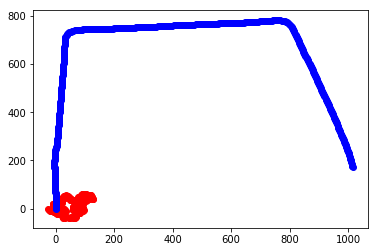

Count:2181
()
()
Relative Depth: 3.469568519912329
Relative x: -25.68209300114639
Relative Original Depth: -172.5145216940487
Relative Original x: 1015.8657026977728
Count:2182
()
()
Relative Depth: 3.5569836862299633
Relative x: -26.505934770327986
Relative Original Depth: -171.53701203321967
Relative Original x: 1016.0676972056881
Count:2183
()
()
Relative Depth: 3.6303337402447675
Relative x: -27.29866303583101
Relative Original Depth: -170.55894718704175
Relative Original x: 1016.2582639353941
Count:2184
()
()
Relative Depth: 3.9858819986885154
Relative x: -26.996229495177808
Relative Original Depth: -169.58012611743663
Relative Original x: 1016.451093325086
Count:2185
()
()
Relative Depth: 4.056399328513347
Relative x: -27.791982076036685
Relative Original Depth: -168.60334843621663
Relative Original x: 1016.6565063854466


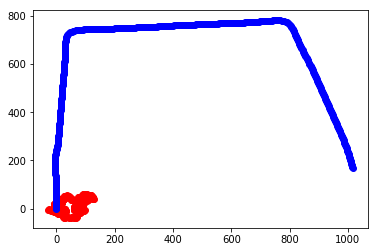

Count:2186
()
()
Relative Depth: 4.130485447149792
Relative x: -28.577548005841436
Relative Original Depth: -167.62708176096803
Relative Original x: 1016.8646038662074
Count:2187
()
()
Relative Depth: 4.166084296307054
Relative x: -29.257758964744603
Relative Original Depth: -166.6503681978176
Relative Original x: 1017.0695839926137
Count:2188
()
()
Relative Depth: 4.145032905237696
Relative x: -29.75567420401434
Relative Original Depth: -165.66988639669637
Relative Original x: 1017.2594134341639
Count:2189
()
()
Relative Depth: 4.143310038336418
Relative x: -30.21279920757283
Relative Original Depth: -164.6932242597163
Relative Original x: 1017.4631435789078
Count:2190
()
()
Relative Depth: 4.133510005848599
Relative x: -30.67256346061466
Relative Original Depth: -163.7139700043459
Relative Original x: 1017.6563313096128


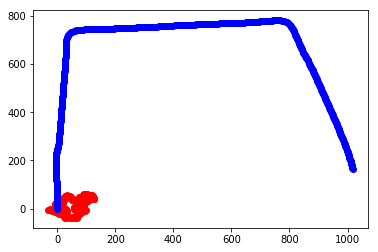

Count:2191
()
()
Relative Depth: 4.173929222917465
Relative x: -31.145521440020485
Relative Original Depth: -162.73384601776075
Relative Original x: 1017.8487214455048
Count:2192
()
()
Relative Depth: 4.279274319109016
Relative x: -31.659308264210207
Relative Original Depth: -161.75368989889736
Relative Original x: 1018.0382048153414
Count:2193
()
()
Relative Depth: 4.40608517653753
Relative x: -31.72170259369802
Relative Original Depth: -160.77421153203895
Relative Original x: 1018.2284568356527
Count:2194
()
()
Relative Depth: 4.5071920708373385
Relative x: -31.34176287580599
Relative Original Depth: -159.79504592214548
Relative Original x: 1018.4182140455742
Count:2195
()
()
Relative Depth: 4.6243911230590315
Relative x: -30.99229147958608
Relative Original Depth: -158.81854464103296
Relative Original x: 1018.6268242900226


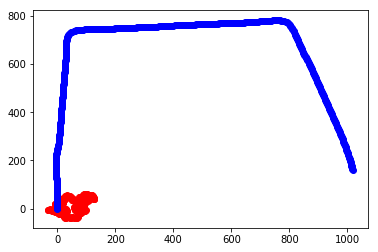

Count:2196
()
()
Relative Depth: 4.709741514536709
Relative x: -30.708713153714125
Relative Original Depth: -157.83708356041777
Relative Original x: 1018.8058098162767
Count:2197
()
()
Relative Depth: 4.774469099930483
Relative x: -30.533741262965936
Relative Original Depth: -156.85677756656804
Relative Original x: 1018.9937934375224
Count:2198
()
()
Relative Depth: 4.863794923622509
Relative x: -30.47490061791075
Relative Original Depth: -155.8761216039327
Relative Original x: 1019.1771930508253
Count:2199
()
()
Relative Depth: 5.513337330953931
Relative x: -30.999662342912476
Relative Original Depth: -154.90051020801243
Relative Original x: 1019.37466085415
Count:2200
()
()
Relative Depth: 5.101608799082052
Relative x: -30.088878597155876
Relative Original Depth: -153.9196439946731
Relative Original x: 1019.5480594039582


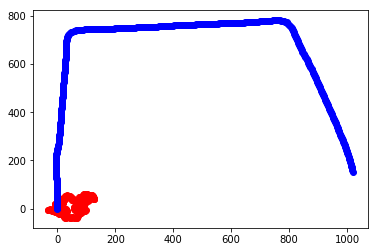

Count:2201
()
()
Relative Depth: 5.0298798910238744
Relative x: -29.64020686588648
Relative Original Depth: -152.93616583496623
Relative Original x: 1019.7095300374535
Count:2202
()
()
Relative Depth: 4.788790915476149
Relative x: -28.99652592207873
Relative Original Depth: -151.9530181956214
Relative Original x: 1019.8795562234808
Count:2203
()
()
Relative Depth: 4.5921921437377025
Relative x: -28.38436242470375
Relative Original Depth: -150.97141893900493
Relative Original x: 1020.0548124267049
Count:2204
()
()
Relative Depth: 5.067608192801158
Relative x: -28.85070473684388
Relative Original Depth: -149.98938040428428
Relative Original x: 1020.2340889916153
Count:2205
()
()
Relative Depth: 4.9821853329757335
Relative x: -28.331294302520273
Relative Original Depth: -149.00754992216315
Relative Original x: 1020.4168467438587


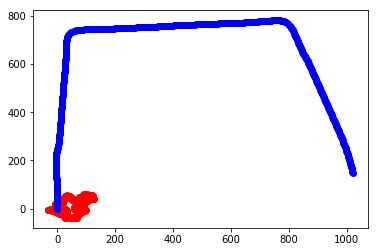

Count:2206
()
()
Relative Depth: 5.7732005396489505
Relative x: -28.648419037534328
Relative Original Depth: -148.02306377784586
Relative Original x: 1020.5890770424899
Count:2207
()
()
Relative Depth: 5.776423136624589
Relative x: -28.210327886352232
Relative Original Depth: -147.04209976780302
Relative Original x: 1020.7785924732316
Count:2208
()
()
Relative Depth: 5.750462891036724
Relative x: -27.849603362949725
Relative Original Depth: -146.0522074059606
Relative Original x: 1020.910601764919
Count:2209
()
()
Relative Depth: 5.364764180435545
Relative x: -28.429589802531982
Relative Original Depth: -145.06411564725946
Relative Original x: 1021.061127547467
Count:2210
()
()
Relative Depth: 5.946689603041266
Relative x: -28.02971486575354
Relative Original Depth: -144.07530874341364
Relative Original x: 1021.2044870444623


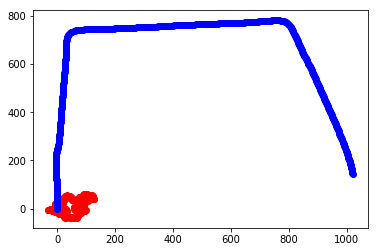

Count:2211
()
()
Relative Depth: 6.904830480550708
Relative x: -27.75726727810861
Relative Original Depth: -143.0886384549647
Relative Original x: 1021.3558576816569
Count:2212
()
()
Relative Depth: 6.905377366125609
Relative x: -28.610394552179034
Relative Original Depth: -142.10433841702155
Relative Original x: 1021.5130910895615
Count:2213
()
()
Relative Depth: 7.844191221264734
Relative x: -28.452043112769754
Relative Original Depth: -141.12084233075868
Relative Original x: 1021.6622349641415
Count:2214
()
()
Relative Depth: 8.81614340916566
Relative x: -28.3959660181984
Relative Original Depth: -140.13893200791975
Relative Original x: 1021.8280053022571
Count:2215
()
()
Relative Depth: 9.802674686428567
Relative x: -28.40288626836312
Relative Original Depth: -139.15729977836241
Relative Original x: 1021.9747748078391


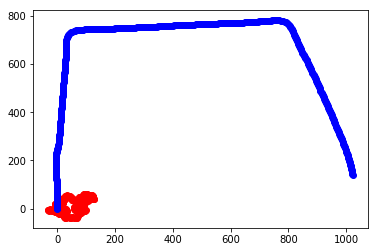

Count:2216
()
()
Relative Depth: 10.784156232403602
Relative x: -28.481432012812895
Relative Original Depth: -138.16701035404503
Relative Original x: 1022.0936021894456
Count:2217
()
()
Relative Depth: 11.770564595544766
Relative x: -28.628017951696403
Relative Original Depth: -137.1754406845693
Relative Original x: 1022.1945557928133
Count:2218
()
()
Relative Depth: 12.740539942954948
Relative x: -28.855713616209457
Relative Original Depth: -136.18355131461257
Relative Original x: 1022.3193515632778
Count:2219
()
()
Relative Depth: 13.729124477323754
Relative x: -28.95253116669394
Relative Original Depth: -135.1934762856815
Relative Original x: 1022.4497402477247
Count:2220
()
()
Relative Depth: 14.721569524317074
Relative x: -28.90062168874559
Relative Original Depth: -134.2048683489771
Relative Original x: 1022.5929537229586


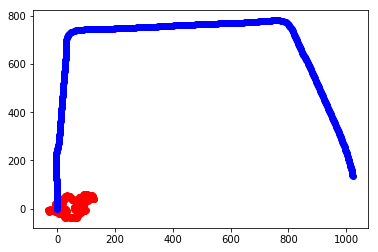

Count:2221
()
()
Relative Depth: 15.62740811186011
Relative x: -29.318035818847438
Relative Original Depth: -133.21925861925436
Relative Original x: 1022.750596554504
Count:2222
()
()
Relative Depth: 16.21174162582892
Relative x: -30.098784231051333
Relative Original Depth: -132.23160558134026
Relative Original x: 1022.8889168106377
Count:2223
()
()
Relative Depth: 16.70917264763595
Relative x: -30.95995323604298
Relative Original Depth: -131.24695770310947
Relative Original x: 1023.0408991115702
Count:2224
()
()
Relative Depth: 17.10144711102862
Relative x: -31.878584357371203
Relative Original Depth: -130.2599293659633
Relative Original x: 1023.1838457682411
Count:2225
()
()
Relative Depth: 17.472098863869988
Relative x: -32.79968700614951
Relative Original Depth: -129.26783797771648
Relative Original x: 1023.2655939465684


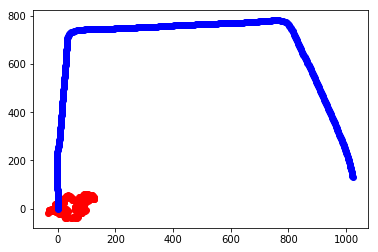

Count:2226
()
()
Relative Depth: 17.957799158609827
Relative x: -33.650735203484906
Relative Original Depth: -128.27684774653778
Relative Original x: 1023.3761845151578
Count:2227
()
()
Relative Depth: 18.603398122804034
Relative x: -34.36800892622288
Relative Original Depth: -127.29545481346084
Relative Original x: 1023.5594020861599
Count:2228
()
()
Relative Depth: 19.421524712786123
Relative x: -33.800161519471345
Relative Original Depth: -126.3051437093555
Relative Original x: 1023.6802211388566
Count:2229
()
()
Relative Depth: 20.203101356958122
Relative x: -34.225124860410176
Relative Original Depth: -125.31624372191959
Relative Original x: 1023.8161270623186
Count:2230
()
()
Relative Depth: 21.07465570088247
Relative x: -34.34395804207555
Relative Original Depth: -124.32342289643829
Relative Original x: 1023.9229640426188


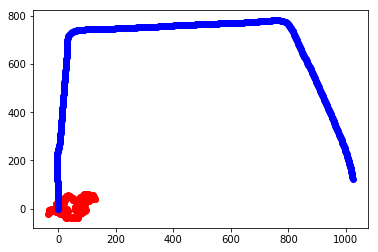

Count:2231
()
()
Relative Depth: 22.02098246792777
Relative x: -34.400000073493594
Relative Original Depth: -123.33548754813802
Relative Original x: 1024.0613160413805
Count:2232
()
()
Relative Depth: 22.99463136857171
Relative x: -34.30015777580683
Relative Original Depth: -122.34943570345095
Relative Original x: 1024.213458007506
Count:2233
()
()
Relative Depth: 23.966343432135474
Relative x: -34.072505056480026
Relative Original Depth: -121.36201838708968
Relative Original x: 1024.3609035756028
Count:2234
()
()
Relative Depth: 24.944440979038298
Relative x: -33.88913259486351
Relative Original Depth: -120.3731970603097
Relative Original x: 1024.4922243003186
Count:2235
()
()
Relative Depth: 25.90902441320365
Relative x: -33.70815038204545
Relative Original Depth: -119.3827097138677
Relative Original x: 1024.6084776992202


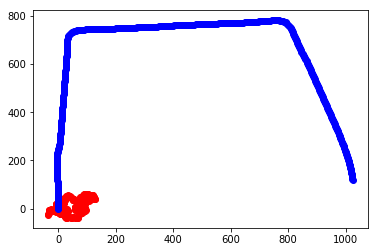

Count:2236
()
()
Relative Depth: 26.845178638457767
Relative x: -33.436634584706724
Relative Original Depth: -118.39080044468113
Relative Original x: 1024.7242317015548
Count:2237
()
()
Relative Depth: 27.77877170705826
Relative x: -33.150598887962516
Relative Original Depth: -117.39863041167044
Relative Original x: 1024.8055365402106
Count:2238
()
()
Relative Depth: 27.79749644172517
Relative x: -32.39187910251268
Relative Original Depth: -116.40503568227994
Relative Original x: 1024.9058296097032
Count:2239
()
()
Relative Depth: 28.611837629189157
Relative x: -31.826405754505387
Relative Original Depth: -115.41550311094048
Relative Original x: 1025.0314419406727
Count:2240
()
()
Relative Depth: 29.27743163376449
Relative x: -31.08429685519188
Relative Original Depth: -114.42342638766765
Relative Original x: 1025.1395859794004


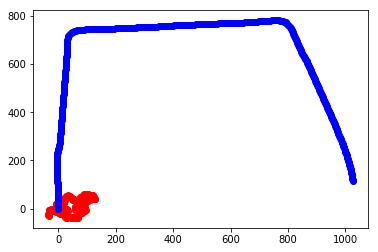

Count:2241
()
()
Relative Depth: 30.014858256248658
Relative x: -30.419615289432915
Relative Original Depth: -113.43102371025952
Relative Original x: 1025.2494882519907
Count:2242
()
()
Relative Depth: 30.713230982474062
Relative x: -29.716911248906626
Relative Original Depth: -112.44073099839602
Relative Original x: 1025.3808158015863
Count:2243
()
()
Relative Depth: 31.35835433384924
Relative x: -28.960854499347334
Relative Original Depth: -111.4504348687238
Relative Original x: 1025.5072184923654
Count:2244
()
()
Relative Depth: 31.568486776849483
Relative x: -27.992925724503554
Relative Original Depth: -110.45938902574915
Relative Original x: 1025.6288957592285
Count:2245
()
()
Relative Depth: 31.637449604068895
Relative x: -27.03320355649693
Relative Original Depth: -109.46475453649951
Relative Original x: 1025.6713963310767


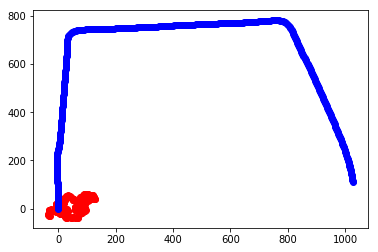

Count:2246
()
()
Relative Depth: 31.85051743971873
Relative x: -26.082709857461214
Relative Original Depth: -108.47206417831622
Relative Original x: 1025.7495956615007
Count:2247
()
()
Relative Depth: 31.97960753648283
Relative x: -25.094239521342438
Relative Original Depth: -107.47881991788111
Relative Original x: 1025.8549285224778
Count:2248
()
()
Relative Depth: 32.24668927795448
Relative x: -24.13082865846623
Relative Original Depth: -106.48581327375597
Relative Original x: 1025.9581099367063
Count:2249
()
()
Relative Depth: 32.553978196816395
Relative x: -23.179587295999227
Relative Original Depth: -105.4917670578943
Relative Original x: 1026.0462001038431
Count:2250
()
()
Relative Depth: 32.88628909868783
Relative x: -22.236420090028062
Relative Original Depth: -104.49816535034061
Relative Original x: 1026.139481309835


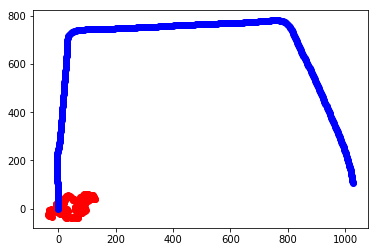

Count:2251
()
()
Relative Depth: 33.0880092890684
Relative x: -21.268226258358816
Relative Original Depth: -103.50509975702624
Relative Original x: 1026.2437042528572
Count:2252
()
()
Relative Depth: 33.46527313252097
Relative x: -20.403326415915384
Relative Original Depth: -102.51261280261257
Relative Original x: 1026.3472735782123
Count:2253
()
()
Relative Depth: 34.033399122804134
Relative x: -19.655151052577455
Relative Original Depth: -101.52656424151361
Relative Original x: 1026.503775700253
Count:2254
()
()
Relative Depth: 34.489710281866664
Relative x: -18.82213371200471
Relative Original Depth: -100.53378300748976
Relative Original x: 1026.6104247704832
Count:2255
()
()
Relative Depth: 34.978729708594756
Relative x: -18.007965950506556
Relative Original Depth: -99.54127599541765
Relative Original x: 1026.713452341403


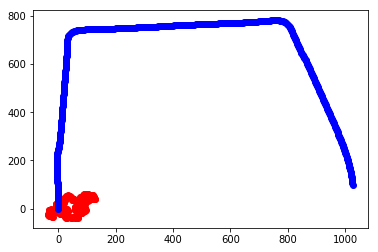

Count:2256
()
()
Relative Depth: 35.4461810043295
Relative x: -18.003423597148956
Relative Original Depth: -98.54819926897528
Relative Original x: 1026.807343241464
Count:2257
()
()
Relative Depth: 35.39181082397964
Relative x: -18.732154607795728
Relative Original Depth: -97.55329761814676
Relative Original x: 1026.8809072610316
Count:2258
()
()
Relative Depth: 35.0183049767557
Relative x: -19.286831098806882
Relative Original Depth: -96.55666440139203
Relative Original x: 1026.9548547942436
Count:2259
()
()
Relative Depth: 34.45234862138459
Relative x: -19.55041869860892
Relative Original Depth: -95.56305747329333
Relative Original x: 1027.052840776163
Count:2260
()
()
Relative Depth: 34.84065694066937
Relative x: -20.3316598259374
Relative Original Depth: -94.56960723684136
Relative Original x: 1027.1443282880257


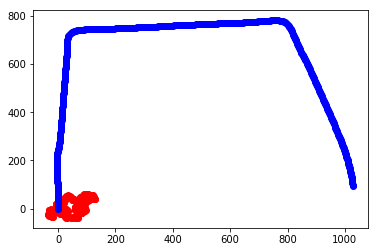

Count:2261
()
()
Relative Depth: 34.32591825599884
Relative x: -20.53245540885786
Relative Original Depth: -93.57762421973362
Relative Original x: 1027.256359080848
Count:2262
()
()
Relative Depth: 34.07220227721529
Relative x: -21.05524375819327
Relative Original Depth: -92.58466142499725
Relative Original x: 1027.3538339086067
Count:2263
()
()
Relative Depth: 34.131950544600286
Relative x: -21.744317265294935
Relative Original Depth: -91.5916790229886
Relative Original x: 1027.4585412993295
Count:2264
()
()
Relative Depth: 33.67023144924584
Relative x: -21.79624800050755
Relative Original Depth: -90.5968881718856
Relative Original x: 1027.5343914411308
Count:2265
()
()
Relative Depth: 33.71298928429994
Relative x: -22.380915634303687
Relative Original Depth: -89.60258133633087
Relative Original x: 1027.6072270397326


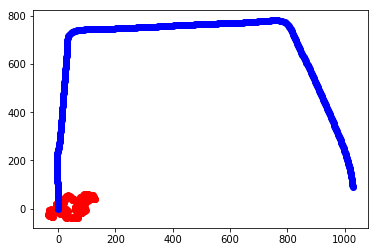

Count:2266
()
()
Relative Depth: 34.090442030523896
Relative x: -22.854441662503458
Relative Original Depth: -88.60685351657605
Relative Original x: 1027.6676911327809
Count:2267
()
()
Relative Depth: 34.82408917789604
Relative x: -23.263005274115688
Relative Original Depth: -87.61209067414838
Relative Original x: 1027.7369424781887
Count:2268
()
()
Relative Depth: 35.590400348812786
Relative x: -23.74661477084933
Relative Original Depth: -86.6168242997705
Relative Original x: 1027.7668251860455
Count:2269
()
()
Relative Depth: 36.348406483185805
Relative x: -24.3057301192509
Relative Original Depth: -85.63891285208578
Relative Original x: 1027.9744596585772
Count:2270
()
()
Relative Depth: 36.94882538180615
Relative x: -24.7807087998051
Relative Original Depth: -84.64727154282588
Relative Original x: 1028.0868062426769


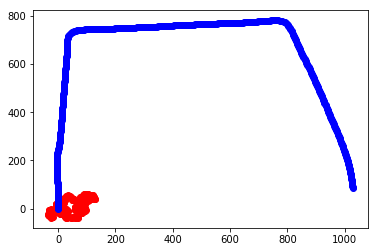

Count:2271
()
()
Relative Depth: 36.257358181948035
Relative x: -24.18915879742139
Relative Original Depth: -83.65318305401077
Relative Original x: 1028.1738147850585
Count:2272
()
()
Relative Depth: 36.61163969196636
Relative x: -24.388714903460237
Relative Original Depth: -82.6598166419977
Relative Original x: 1028.2654183539328
Count:2273
()
()
Relative Depth: 37.02077117105981
Relative x: -24.612873908468966
Relative Original Depth: -81.66566189325917
Relative Original x: 1028.3515334157119
Count:2274
()
()
Relative Depth: 37.46541337791792
Relative x: -24.858676184834497
Relative Original Depth: -80.67076128198862
Relative Original x: 1028.4312323189804
Count:2275
()
()
Relative Depth: 37.96469445882378
Relative x: -25.169979539203943
Relative Original Depth: -79.67799859289326
Relative Original x: 1028.5392976127314


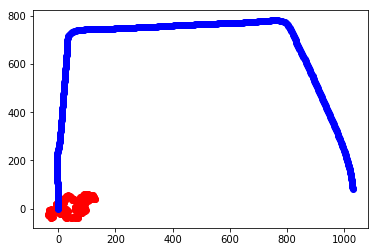

Count:2276
()
()
Relative Depth: 38.50816622618832
Relative x: -25.560646340395696
Relative Original Depth: -78.684975910812
Relative Original x: 1028.6475447596588
Count:2277
()
()
Relative Depth: 39.0397950231256
Relative x: -25.984489103666412
Relative Original Depth: -77.6912854577497
Relative Original x: 1028.7432638766352
Count:2278
()
()
Relative Depth: 39.52861157503861
Relative x: -26.511635012508552
Relative Original Depth: -76.70061569150751
Relative Original x: 1028.8740596035725
Count:2279
()
()
Relative Depth: 39.18466459746344
Relative x: -26.843121409039153
Relative Original Depth: -75.7063469686486
Relative Original x: 1028.9702226535212
Count:2280
()
()
Relative Depth: 39.64260245638822
Relative x: -27.484344908374865
Relative Original Depth: -74.70927220923842
Relative Original x: 1029.027373959112


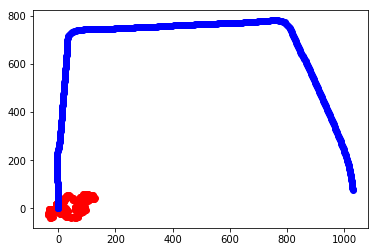

Count:2281
()
()
Relative Depth: 40.122418508333595
Relative x: -28.13159146559513
Relative Original Depth: -73.71419073111069
Relative Original x: 1029.1026935231678
Count:2282
()
()
Relative Depth: 40.65640704312469
Relative x: -28.834273017439124
Relative Original Depth: -72.71968248308548
Relative Original x: 1029.1803957610744
Count:2283
()
()
Relative Depth: 41.14611352769881
Relative x: -29.686669504418855
Relative Original Depth: -71.72644513283488
Relative Original x: 1029.2834608221058
Count:2284
()
()
Relative Depth: 41.33980068358179
Relative x: -30.40550672642187
Relative Original Depth: -70.7319860222378
Relative Original x: 1029.361545688695
Count:2285
()
()
Relative Depth: 41.51234418073087
Relative x: -31.315667963573887
Relative Original Depth: -69.73686265816191
Relative Original x: 1029.4370972516176


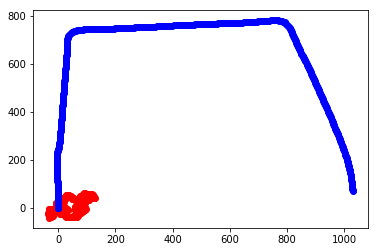

Count:2286
()
()
Relative Depth: 41.69856034676032
Relative x: -32.29757760777996
Relative Original Depth: -68.74112901786297
Relative Original x: 1029.5089749601534
Count:2287
()
()
Relative Depth: 41.813272717646605
Relative x: -33.2906713806934
Relative Original Depth: -67.74587400333598
Relative Original x: 1029.5939338947371
Count:2288
()
()
Relative Depth: 41.50600178374691
Relative x: -34.2374429088406
Relative Original Depth: -66.75051180494383
Relative Original x: 1029.6742204120562
Count:2289
()
()
Relative Depth: 40.8944856300872
Relative x: -35.01514173471265
Relative Original Depth: -65.754153151133
Relative Original x: 1029.737005484936
Count:2290
()
()
Relative Depth: 40.248031579046284
Relative x: -35.777986708097345
Relative Original Depth: -64.75887273308346
Relative Original x: 1029.8090324546165


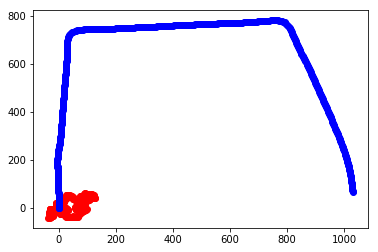

Count:2291
()
()
Relative Depth: 40.457313092893706
Relative x: -35.63000656617803
Relative Original Depth: -63.76398364865734
Relative Original x: 1029.8816878827504
Count:2292
()
()
Relative Depth: 39.755715794808346
Relative x: -36.31242381900936
Relative Original Depth: -62.7696134382214
Relative Original x: 1029.94835511535
Count:2293
()
()
Relative Depth: 38.842257457878176
Relative x: -36.715403853547144
Relative Original Depth: -61.77308314696994
Relative Original x: 1030.0053845479888
Count:2294
()
()
Relative Depth: 37.94419883404512
Relative x: -36.83184012605924
Relative Original Depth: -60.77666931069772
Relative Original x: 1030.0610372500119
Count:2295
()
()
Relative Depth: 37.04037695540332
Relative x: -37.07240325717451
Relative Original Depth: -59.78189808353365
Relative Original x: 1030.139631358196


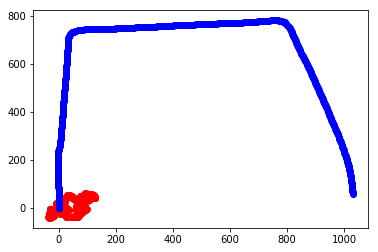

Count:2296
()
()
Relative Depth: 36.19386258795712
Relative x: -37.50699163260961
Relative Original Depth: -58.7864143445941
Relative Original x: 1030.2133087834925
Count:2297
()
()
Relative Depth: 35.303873128204884
Relative x: -37.9629194141733
Relative Original Depth: -57.78944013400651
Relative Original x: 1030.2792549689311
Count:2298
()
()
Relative Depth: 34.414103545178655
Relative x: -38.30640305487901
Relative Original Depth: -56.79225934901801
Relative Original x: 1030.312894577271
Count:2299
()
()
Relative Depth: 33.52530295500503
Relative x: -38.439725618140294
Relative Original Depth: -55.796081770836395
Relative Original x: 1030.3851847883325
Count:2300
()
()
Relative Depth: 32.695477107303255
Relative x: -38.38180901998095
Relative Original Depth: -54.8003613060212
Relative Original x: 1030.4535955746755


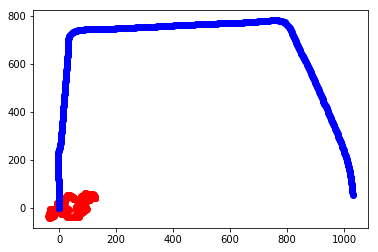

Count:2301
()
()
Relative Depth: 31.795146001014228
Relative x: -38.56740934126503
Relative Original Depth: -53.805462818592304
Relative Original x: 1030.5328981753778
Count:2302
()
()
Relative Depth: 30.94834661058477
Relative x: -39.05050263802487
Relative Original Depth: -52.80788590148336
Relative Original x: 1030.5786025192929
Count:2303
()
()
Relative Depth: 30.10728206558012
Relative x: -39.52902095383226
Relative Original Depth: -51.81238047811709
Relative Original x: 1030.6468131754746
Count:2304
()
()
Relative Depth: 29.25943404737853
Relative x: -40.046115147928454
Relative Original Depth: -50.81731858458623
Relative Original x: 1030.7289206794535
Count:2305
()
()
Relative Depth: 28.547084023081794
Relative x: -40.72718214459178
Relative Original Depth: -49.82200485991959
Relative Original x: 1030.8057886164845


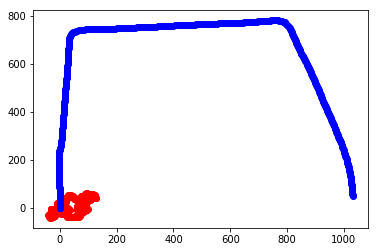

Count:2306
()
()
Relative Depth: 28.08212916929394
Relative x: -41.402923699868786
Relative Original Depth: -48.82721406009781
Relative Original x: 1030.8622362235878
Count:2307
()
()
Relative Depth: 27.42880847541762
Relative x: -42.03235393280923
Relative Original Depth: -47.83189468370557
Relative Original x: 1030.9345505959466
Count:2308
()
()
Relative Depth: 26.518917971773853
Relative x: -42.400691302764365
Relative Original Depth: -46.834165468959604
Relative Original x: 1030.963070760313
Count:2309
()
()
Relative Depth: 25.56958491974422
Relative x: -42.536489506992844
Relative Original Depth: -45.83669273087807
Relative Original x: 1031.0106528730391
Count:2310
()
()
Relative Depth: 24.91009308214683
Relative x: -42.23073060329422
Relative Original Depth: -44.84016979819971
Relative Original x: 1031.0690216441124


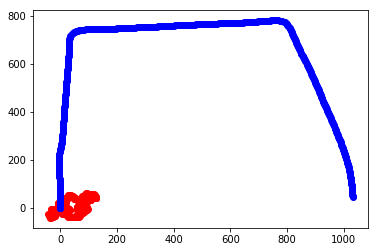

Count:2311
()
()
Relative Depth: 23.94360788946846
Relative x: -42.34252208477062
Relative Original Depth: -43.844516857222075
Relative Original x: 1031.1362917734962
Count:2312
()
()
Relative Depth: 22.995905141692887
Relative x: -42.31800622035537
Relative Original Depth: -42.84665430702417
Relative Original x: 1031.1765537770973
Count:2313
()
()
Relative Depth: 22.070446741144078
Relative x: -42.30418535318084
Relative Original Depth: -41.850067738182695
Relative Original x: 1031.2374908065415
Count:2314
()
()
Relative Depth: 21.120682248857147
Relative x: -42.396178769500395
Relative Original Depth: -40.857874035319306
Relative Original x: 1031.3426961301348
Count:2315
()
()
Relative Depth: 20.961117126030445
Relative x: -43.358377834942104
Relative Original Depth: -39.86182139199109
Relative Original x: 1031.4039339989652


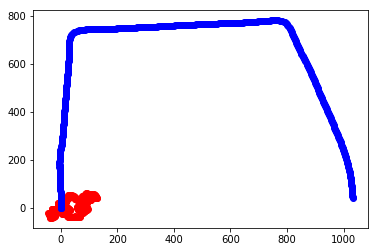

Count:2316
()
()
Relative Depth: 21.71626626428096
Relative x: -43.60601784023857
Relative Original Depth: -38.86820792853793
Relative Original x: 1031.4646612102267
Count:2317
()
()
Relative Depth: 21.017577374446713
Relative x: -43.27247364252315
Relative Original Depth: -37.87414883169519
Relative Original x: 1031.4813273669172
Count:2318
()
()
Relative Depth: 20.868646849429318
Relative x: -42.560472225945844
Relative Original Depth: -36.87777891924583
Relative Original x: 1031.5473364987042
Count:2319
()
()
Relative Depth: 21.03931726674916
Relative x: -41.86597691842998
Relative Original Depth: -35.880300220718624
Relative Original x: 1031.6106902356792
Count:2320
()
()
Relative Depth: 21.581215036228567
Relative x: -41.337096217445975
Relative Original Depth: -34.88383846445482
Relative Original x: 1031.6751481413105


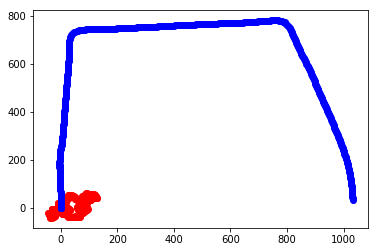

Count:2321
()
()
Relative Depth: 21.983706345180515
Relative x: -40.65702953590591
Relative Original Depth: -33.88653637885965
Relative Original x: 1031.7386209575677
Count:2322
()
()
Relative Depth: 21.9099778114247
Relative x: -39.797859018473716
Relative Original Depth: -32.89191212179354
Relative Original x: 1031.8196625308433
Count:2323
()
()
Relative Depth: 21.744546565756824
Relative x: -38.954441188019565
Relative Original Depth: -31.894443520441087
Relative Original x: 1031.866714829768
Count:2324
()
()
Relative Depth: 21.62915149024463
Relative x: -38.12525919307236
Relative Original Depth: -30.896102138836866
Relative Original x: 1031.883271104249
Count:2325
()
()
Relative Depth: 21.455572233253587
Relative x: -37.2308768260725
Relative Original Depth: -29.89926371763632
Relative Original x: 1031.9328690227007


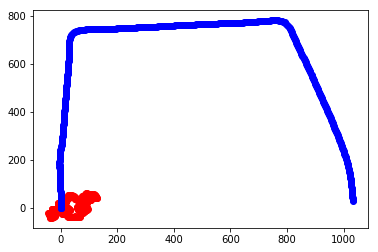

Count:2326
()
()
Relative Depth: 21.041841358995953
Relative x: -36.33151374166209
Relative Original Depth: -28.90206709554341
Relative Original x: 1031.970029959449
Count:2327
()
()
Relative Depth: 20.473831937194113
Relative x: -35.51237731609351
Relative Original Depth: -27.907209226124483
Relative Original x: 1032.0334062983418
Count:2328
()
()
Relative Depth: 19.888685122470562
Relative x: -34.74050592339345
Relative Original Depth: -26.908898612782394
Relative Original x: 1032.047247626095
Count:2329
()
()
Relative Depth: 19.25600295232991
Relative x: -33.96846653189419
Relative Original Depth: -25.911097609056654
Relative Original x: 1032.113240943166
Count:2330
()
()
Relative Depth: 18.62810952815783
Relative x: -33.21603743439849
Relative Original Depth: -24.913493711304486
Relative Original x: 1032.1637399118745


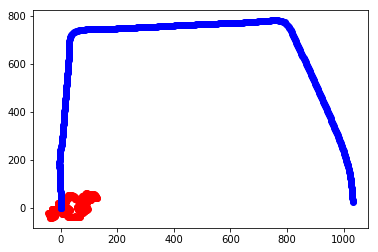

Count:2331
()
()
Relative Depth: 17.96757734428512
Relative x: -32.483069742849885
Relative Original Depth: -23.917466003074043
Relative Original x: 1032.241041713248
Count:2332
()
()
Relative Depth: 17.31724014737594
Relative x: -31.75582627543823
Relative Original Depth: -22.919364813635124
Relative Original x: 1032.2361105442894
Count:2333
()
()
Relative Depth: 16.68032821188344
Relative x: -31.006538025826437
Relative Original Depth: -21.922005204924933
Relative Original x: 1032.2872975888722
Count:2334
()
()
Relative Depth: 15.788275080292072
Relative x: -30.59842799014098
Relative Original Depth: -20.92203876706323
Relative Original x: 1032.2828735075177
Count:2335
()
()
Relative Depth: 14.846235758888168
Relative x: -30.76390314173089
Relative Original Depth: -19.925546732877383
Relative Original x: 1032.3250507946555


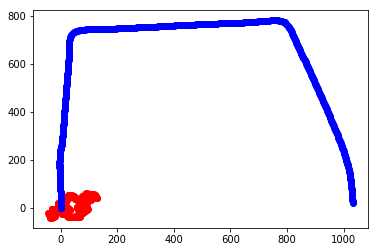

Count:2336
()
()
Relative Depth: 14.989219526783575
Relative x: -31.375049497975215
Relative Original Depth: -18.928122762051593
Relative Original x: 1032.350993717086
Count:2337
()
()
Relative Depth: 14.011429096670065
Relative x: -31.420955497936777
Relative Original Depth: -17.930210637769463
Relative Original x: 1032.412339434917
Count:2338
()
()
Relative Depth: 13.104439770269167
Relative x: -31.014818253977438
Relative Original Depth: -16.934420918835812
Relative Original x: 1032.430256112565
Count:2339
()
()
Relative Depth: 12.255975757870969
Relative x: -30.515965411386937
Relative Original Depth: -15.937835833148892
Relative Original x: 1032.5091629302917
Count:2340
()
()
Relative Depth: 11.317625278131164
Relative x: -30.25962416032462
Relative Original Depth: -14.941061474334754
Relative Original x: 1032.4987544574192


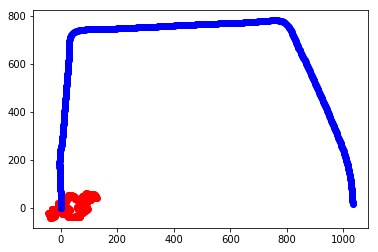

Count:2341
()
()
Relative Depth: 10.419452433645253
Relative x: -30.55403883968433
Relative Original Depth: -13.943088466154084
Relative Original x: 1032.5178584677408
Count:2342
()
()
Relative Depth: 10.17458959255358
Relative x: -31.027953731814716
Relative Original Depth: -12.948081968509712
Relative Original x: 1032.5868485824699
Count:2343
()
()
Relative Depth: 10.17367624491827
Relative x: -31.52403067433003
Relative Original Depth: -11.951297560480823
Relative Original x: 1032.5918447653494
Count:2344
()
()
Relative Depth: 9.557959371134551
Relative x: -32.30352116588372
Relative Original Depth: -10.954314784299136
Relative Original x: 1032.633416739357
Count:2345
()
()
Relative Depth: 9.061518929776277
Relative x: -32.713569700526165
Relative Original Depth: -9.957654483425774
Relative Original x: 1032.6526027389016


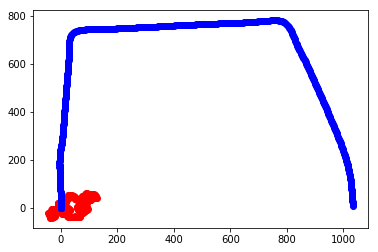

Count:2346
()
()
Relative Depth: 8.730854526290258
Relative x: -33.17175987117068
Relative Original Depth: -8.960047530701072
Relative Original x: 1032.6776748105463
Count:2347
()
()
Relative Depth: 8.227291380959015
Relative x: -33.23526058070256
Relative Original Depth: -7.962167398679584
Relative Original x: 1032.7365670814117
Count:2348
()
()
Relative Depth: 7.664866634967012
Relative x: -32.910348773371105
Relative Original Depth: -6.963693100347634
Relative Original x: 1032.7586398182684
Count:2349
()
()
Relative Depth: 7.198940493879973
Relative x: -32.390139987768116
Relative Original Depth: -5.965351102182743
Relative Original x: 1032.785191145937
Count:2350
()
()
Relative Depth: 6.843836281588214
Relative x: -31.951604597690153
Relative Original Depth: -4.96710095581065
Relative Original x: 1032.806076686022


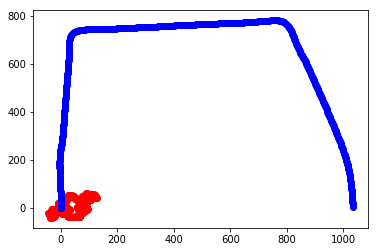

Count:2351
()
()
Relative Depth: 6.882620992190709
Relative x: -32.74655292221552
Relative Original Depth: -3.96902623672438
Relative Original x: 1032.803282044332
Count:2352
()
()
Relative Depth: 6.777972053782558
Relative x: -33.152926066584044
Relative Original Depth: -2.970034739040321
Relative Original x: 1032.819988756958
Count:2353
()
()
Relative Depth: 6.872040957140085
Relative x: -33.59861047674127
Relative Original Depth: -1.971981405792019
Relative Original x: 1032.8300429392177
Count:2354
()
()
Relative Depth: 6.827169864698794
Relative x: -33.56641064900876
Relative Original Depth: -0.9750873144267328
Relative Original x: 1032.814486538655
Count:2355
()
()
Relative Depth: 6.226164709239221
Relative x: -33.546480278880125
Relative Original Depth: 0.02349850252743857
Relative Original x: 1032.8439226553146


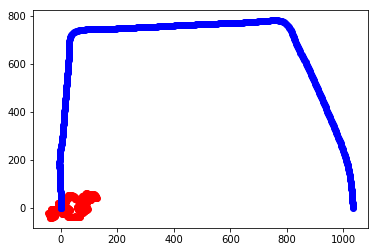

Count:2356
()
()
Relative Depth: 5.312048950923386
Relative x: -33.15334919362286
Relative Original Depth: 1.0203711701311016
Relative Original x: 1032.8305019461925
Count:2357
()
()
Relative Depth: 4.631755887185633
Relative x: -33.88606746230516
Relative Original Depth: 2.0178854188913884
Relative Original x: 1032.8298183723575
Count:2358
()
()
Relative Depth: 3.840112737662751
Relative x: -33.308214253873075
Relative Original Depth: 3.016771340344537
Relative Original x: 1032.819482667266
Count:2359
()
()
Relative Depth: 3.934573753581486
Relative x: -32.87404906734156
Relative Original Depth: 4.01357870469832
Relative Original x: 1032.8060659453652
Count:2360
()
()
Relative Depth: 2.983149282844843
Relative x: -32.62162275948309
Relative Original Depth: 5.012207741990409
Relative Original x: 1032.843022199887


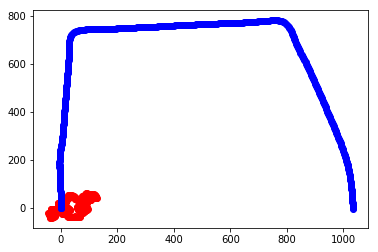

Count:2361
()
()
Relative Depth: 2.0468499420617223
Relative x: -32.96889063704187
Relative Original Depth: 6.009855313558045
Relative Original x: 1032.840755466572
Count:2362
()
()
Relative Depth: 1.2824338628581644
Relative x: -33.56460242974006
Relative Original Depth: 7.0066978569700815
Relative Original x: 1032.8839972152707
Count:2363
()
()
Relative Depth: 0.4476687145332545
Relative x: -34.038600756155844
Relative Original Depth: 8.003666111545934
Relative Original x: 1032.8608204560346
Count:2364
()
()
Relative Depth: -0.4535792322595771
Relative x: -34.39655191001038
Relative Original Depth: 9.001486057069418
Relative Original x: 1032.8901099588415
Count:2365
()
()
Relative Depth: -1.3803990824292054
Relative x: -34.67448497338615
Relative Original Depth: 9.999912008925456
Relative Original x: 1032.8943244080422


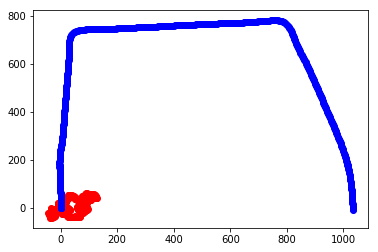

Count:2366
()
()
Relative Depth: -2.3086158182608476
Relative x: -34.910703955016565
Relative Original Depth: 10.999030297920164
Relative Original x: 1032.8658512318036
Count:2367
()
()
Relative Depth: -3.176403199081885
Relative x: -35.34408515619635
Relative Original Depth: 11.997408134579794
Relative Original x: 1032.8316585993728
Count:2368
()
()
Relative Depth: -3.9548219888795284
Relative x: -35.884048748511056
Relative Original Depth: 12.99457619331961
Relative Original x: 1032.8535226776569
Count:2369
()
()
Relative Depth: -4.792455509285967
Relative x: -36.31847453299225
Relative Original Depth: 13.990795455034842
Relative Original x: 1032.8455288695172
Count:2370
()
()
Relative Depth: -5.653428734561556
Relative x: -36.7129695553984
Relative Original Depth: 14.985042866457164
Relative Original x: 1032.8006659302318


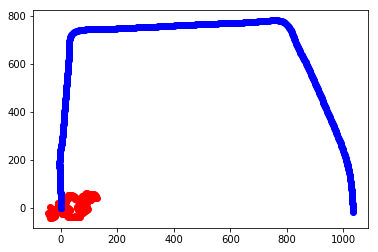

Count:2371
()
()
Relative Depth: -6.451092236812443
Relative x: -37.13283067938822
Relative Original Depth: 15.983333656149822
Relative Original x: 1032.8147101292107
Count:2372
()
()
Relative Depth: -6.140626506920028
Relative x: -37.015227123428716
Relative Original Depth: 16.98223712699295
Relative Original x: 1032.8131301730825
Count:2373
()
()
Relative Depth: -6.580800154040727
Relative x: -37.91300712837486
Relative Original Depth: 17.97851363608442
Relative Original x: 1032.788096700745
Count:2374
()
()
Relative Depth: -6.471080546789934
Relative x: -38.85872734492574
Relative Original Depth: 18.976312501771645
Relative Original x: 1032.7611912271288
Count:2375
()
()
Relative Depth: -6.270107842315875
Relative x: -39.83154389280619
Relative Original Depth: 19.97349215324101
Relative Original x: 1032.8062189239545


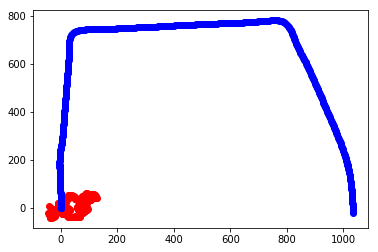

Count:2376
()
()
Relative Depth: -5.984742378416333
Relative x: -40.7205612678946
Relative Original Depth: 20.96958039724033
Relative Original x: 1032.7825996421789
Count:2377
()
()
Relative Depth: -5.719030791159268
Relative x: -41.52268889441535
Relative Original Depth: 21.967355179335083
Relative Original x: 1032.7765318980325
Count:2378
()
()
Relative Depth: -5.196577060424268
Relative x: -42.33773440085676
Relative Original Depth: 22.96403260909437
Relative Original x: 1032.7862423534248
Count:2379
()
()
Relative Depth: -4.410290472920437
Relative x: -42.952271346926885
Relative Original Depth: 23.961203007281433
Relative Original x: 1032.7658740567208
Count:2380
()
()
Relative Depth: -3.6701485647818806
Relative x: -43.59294991220764
Relative Original Depth: 24.959723451184733
Relative Original x: 1032.775353489817


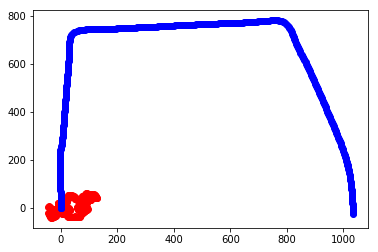

Count:2381
()
()
Relative Depth: -3.1222002787968286
Relative x: -43.68298151190196
Relative Original Depth: 25.95794897185023
Relative Original x: 1032.7798254384666
Count:2382
()
()
Relative Depth: -2.248191807422299
Relative x: -44.15701785517298
Relative Original Depth: 26.955692357859437
Relative Original x: 1032.7583866433552
Count:2383
()
()
Relative Depth: -1.272158505118024
Relative x: -44.34793251106376
Relative Original Depth: 27.95429905334656
Relative Original x: 1032.7595210624863
Count:2384
()
()
Relative Depth: -0.30498645947736547
Relative x: -44.51686646908305
Relative Original Depth: 28.952964701954624
Relative Original x: 1032.7415019795885
Count:2385
()
()
Relative Depth: 0.5720065053858133
Relative x: -44.99350104996816
Relative Original Depth: 29.952280879333802
Relative Original x: 1032.7553178520825


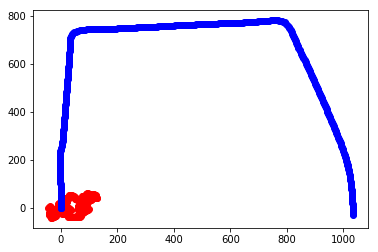

Count:2386
()
()
Relative Depth: 1.223839216147368
Relative x: -45.682759664003704
Relative Original Depth: 30.951143018479176
Relative Original x: 1032.7526920562716
Count:2387
()
()
Relative Depth: 1.8851344418289409
Relative x: -46.38381759448715
Relative Original Depth: 31.950611473983063
Relative Original x: 1032.7686474678765
Count:2388
()
()
Relative Depth: 2.1861116199864083
Relative x: -47.10480266578319
Relative Original Depth: 32.94951695261082
Relative Original x: 1032.7882274123488
Count:2389
()
()
Relative Depth: 2.5330610493975407
Relative x: -47.804564217699834
Relative Original Depth: 33.948836310661264
Relative Original x: 1032.7868950266884
Count:2390
()
()
Relative Depth: 3.266492258928582
Relative x: -48.39058030237144
Relative Original Depth: 34.94789567589529
Relative Original x: 1032.7805548737053


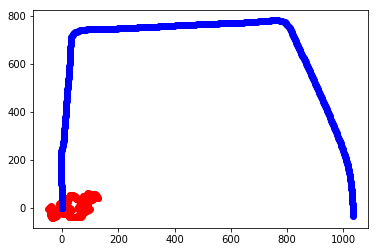

Count:2391
()
()
Relative Depth: 3.945999058700878
Relative x: -48.951136367124164
Relative Original Depth: 35.94525302412305
Relative Original x: 1032.7687852975964
Count:2392
()
()
Relative Depth: 4.4691245033280405
Relative x: -49.41269715764019
Relative Original Depth: 36.944419182557375
Relative Original x: 1032.7706471790066
Count:2393
()
()
Relative Depth: 4.395882806302166
Relative x: -49.321432972751055
Relative Original Depth: 37.94150549557648
Relative Original x: 1032.7855584736258
Count:2394
()
()
Relative Depth: 3.7284111830887197
Relative x: -48.77619560998914
Relative Original Depth: 38.93956456202619
Relative Original x: 1032.7892427201582
Count:2395
()
()
Relative Depth: 3.0210713320919105
Relative x: -48.20587197851399
Relative Original Depth: 39.937653567289665
Relative Original x: 1032.7748736025735


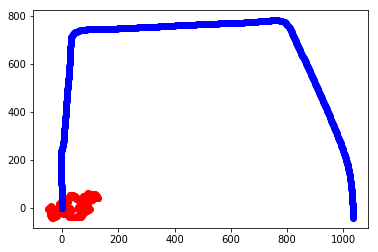

Count:2396
()
()
Relative Depth: 2.459427018231625
Relative x: -47.65161187743126
Relative Original Depth: 40.93533606270923
Relative Original x: 1032.7885609888249
Count:2397
()
()
Relative Depth: 2.0126149221144374
Relative x: -47.12561483749219
Relative Original Depth: 41.93333462914095
Relative Original x: 1032.7881300189686
Count:2398
()
()
Relative Depth: 1.7885168947775874
Relative x: -46.62612444178201
Relative Original Depth: 42.932015343516355
Relative Original x: 1032.80789294337
Count:2399
()
()
Relative Depth: 1.7519166045583952
Relative x: -46.161133539265684
Relative Original Depth: 43.92900837686451
Relative Original x: 1032.8441896938787
Count:2400
()
()
Relative Depth: 1.7951750608302808
Relative x: -45.792745288135514
Relative Original Depth: 44.92741438158724
Relative Original x: 1032.8306600181443


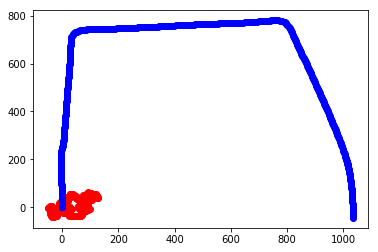

Count:2401
()
()
Relative Depth: 1.7202305918200913
Relative x: -45.26315506615219
Relative Original Depth: 45.92588643583987
Relative Original x: 1032.8264259231998
Count:2402
()
()
Relative Depth: 1.4363780526308048
Relative x: -44.47601216607888
Relative Original Depth: 46.924825809685885
Relative Original x: 1032.852589936716
Count:2403
()
()
Relative Depth: 1.1747419306136386
Relative x: -43.62917584952365
Relative Original Depth: 47.923342594374624
Relative Original x: 1032.8374445331162
Count:2404
()
()
Relative Depth: 0.6740123547159433
Relative x: -42.82127631358924
Relative Original Depth: 48.92094248332241
Relative Original x: 1032.8011369163505
Count:2405
()
()
Relative Depth: -0.16137119886039686
Relative x: -42.27161222050715
Relative Original Depth: 49.91901851481842
Relative Original x: 1032.796528265678


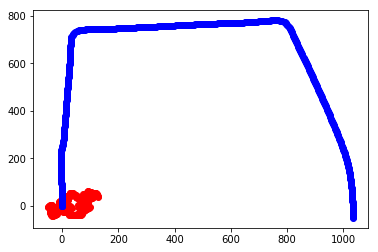

Count:2406
()
()
Relative Depth: -1.0893417256087146
Relative x: -41.92332185649067
Relative Original Depth: 50.91769973419459
Relative Original x: 1032.8028525848656
Count:2407
()
()
Relative Depth: -1.8078407546660342
Relative x: -41.237714549674614
Relative Original Depth: 51.91459747601534
Relative Original x: 1032.7780067229864
Count:2408
()
()
Relative Depth: -2.3529739724326655
Relative x: -40.420361267699946
Relative Original Depth: 52.911719039637745
Relative Original x: 1032.7712604323722
Count:2409
()
()
Relative Depth: -2.947072353693608
Relative x: -39.627146093980215
Relative Original Depth: 53.910078282269126
Relative Original x: 1032.7963836656713
Count:2410
()
()
Relative Depth: -3.4126450715051586
Relative x: -38.74254831817214
Relative Original Depth: 54.908815425803866
Relative Original x: 1032.8206403799772


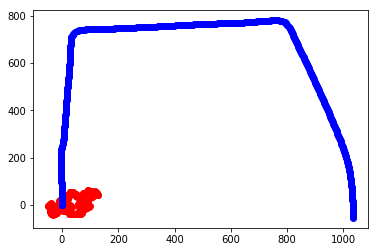

Count:2411
()
()
Relative Depth: -3.876716079427191
Relative x: -37.857583639168006
Relative Original Depth: 55.907034148405266
Relative Original x: 1032.8802936838797
Count:2412
()
()
Relative Depth: -4.564334175859426
Relative x: -38.19690764473985
Relative Original Depth: 56.906249413205074
Relative Original x: 1032.8724024951796
Count:2413
()
()
Relative Depth: -5.525344362216476
Relative x: -38.32724991014937
Relative Original Depth: 57.90561936760137
Relative Original x: 1032.8873568184863
Count:2414
()
()
Relative Depth: -6.212408912609761
Relative x: -37.60081602626587
Relative Original Depth: 58.902577173731714
Relative Original x: 1032.896309618795
Count:2415
()
()
Relative Depth: -7.06955085177405
Relative x: -37.16707340657492
Relative Original Depth: 59.900139136893706
Relative Original x: 1032.9281594493734


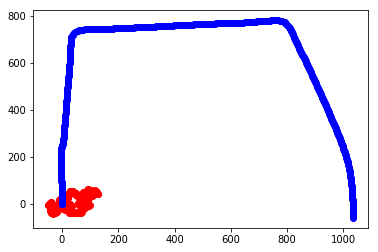

Count:2416
()
()
Relative Depth: -7.88280708822386
Relative x: -36.82597762490924
Relative Original Depth: 60.89765056320491
Relative Original x: 1032.9371701541406
Count:2417
()
()
Relative Depth: -8.46505960675243
Relative x: -36.379387173042154
Relative Original Depth: 61.89460782764854
Relative Original x: 1032.9432644283343
Count:2418
()
()
Relative Depth: -8.704810233359844
Relative x: -35.90486636683037
Relative Original Depth: 62.892844309721134
Relative Original x: 1032.9742686906827
Count:2419
()
()
Relative Depth: -8.862032510542099
Relative x: -35.36400169656304
Relative Original Depth: 63.89080889533384
Relative Original x: 1032.985991595524
Count:2420
()
()
Relative Depth: -8.922007991804723
Relative x: -34.90525846204504
Relative Original Depth: 64.8890503809683
Relative Original x: 1033.0342347740793


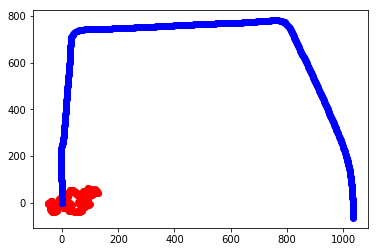

Count:2421
()
()
Relative Depth: -8.946334835752994
Relative x: -34.556140673918094
Relative Original Depth: 65.88671624935506
Relative Original x: 1033.046014543024
Count:2422
()
()
Relative Depth: -8.928928281039132
Relative x: -34.02718138887531
Relative Original Depth: 66.88466064236357
Relative Original x: 1033.0779811111881
Count:2423
()
()
Relative Depth: -8.88114204953819
Relative x: -33.34130325352929
Relative Original Depth: 67.88274520010346
Relative Original x: 1033.1106663658638
Count:2424
()
()
Relative Depth: -8.8197925650322
Relative x: -32.850016518892545
Relative Original Depth: 68.88016016898277
Relative Original x: 1033.1044999324574
Count:2425
()
()
Relative Depth: -8.837381709236155
Relative x: -32.21981142786995
Relative Original Depth: 69.87691531303803
Relative Original x: 1033.1269521469276


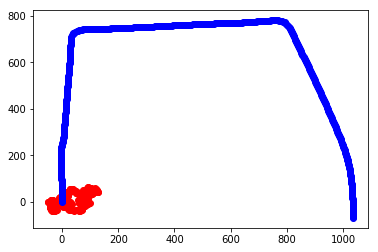

Count:2426
()
()
Relative Depth: -9.318977102809322
Relative x: -31.737040659345812
Relative Original Depth: 70.87485638382029
Relative Original x: 1033.1700159892812
Count:2427
()
()
Relative Depth: -9.921028950065956
Relative x: -31.885139296833866
Relative Original Depth: 71.8729545889506
Relative Original x: 1033.1935757321185
Count:2428
()
()
Relative Depth: -10.327824288814131
Relative x: -32.1073093521848
Relative Original Depth: 72.87004260238673
Relative Original x: 1033.2067981670027
Count:2429
()
()
Relative Depth: -10.638157603977668
Relative x: -32.298524095951365
Relative Original Depth: 73.86815395989751
Relative Original x: 1033.2089749077213
Count:2430
()
()
Relative Depth: -10.876603546802766
Relative x: -32.79900934508848
Relative Original Depth: 74.86558004945327
Relative Original x: 1033.2010320703905


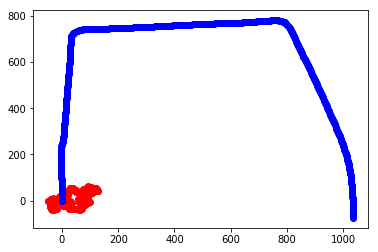

Count:2431
()
()
Relative Depth: -11.084086955002727
Relative x: -33.48508893544036
Relative Original Depth: 75.86288802808244
Relative Original x: 1033.257522720038
Count:2432
()
()
Relative Depth: -11.051500436472988
Relative x: -34.17769310322868
Relative Original Depth: 76.86160526355224
Relative Original x: 1033.269961529044
Count:2433
()
()
Relative Depth: -10.72002922247512
Relative x: -34.872979083425484
Relative Original Depth: 77.85985291239241
Relative Original x: 1033.304124587506
Count:2434
()
()
Relative Depth: -10.265802471392401
Relative x: -35.57678827931981
Relative Original Depth: 78.85820185660288
Relative Original x: 1033.3200719101474
Count:2435
()
()
Relative Depth: -9.964359105095904
Relative x: -35.032831308441665
Relative Original Depth: 79.85585588314692
Relative Original x: 1033.3577257471627


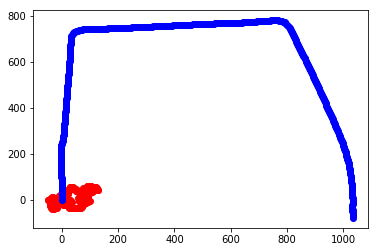

Count:2436
()
()
Relative Depth: -9.383042814505618
Relative x: -35.746654029728326
Relative Original Depth: 80.85387498089445
Relative Original x: 1033.3852765491156
Count:2437
()
()
Relative Depth: -8.798492551149444
Relative x: -36.447290605037075
Relative Original Depth: 81.85067792476745
Relative Original x: 1033.463506401675
Count:2438
()
()
Relative Depth: -8.313717597354257
Relative x: -37.1672774601933
Relative Original Depth: 82.84650873836891
Relative Original x: 1033.5168676106616
Count:2439
()
()
Relative Depth: -8.104036386137219
Relative x: -37.95266485198648
Relative Original Depth: 83.84554179620676
Relative Original x: 1033.5366773819242
Count:2440
()
()
Relative Depth: -8.068037780678047
Relative x: -38.70934982440319
Relative Original Depth: 84.84334224089606
Relative Original x: 1033.5885937714809


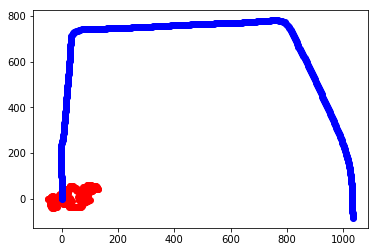

Count:2441
()
()
Relative Depth: -8.716631141161836
Relative x: -39.137816528823734
Relative Original Depth: 85.84109178247961
Relative Original x: 1033.6182199559953
Count:2442
()
()
Relative Depth: -8.329631705522683
Relative x: -39.79917306478125
Relative Original Depth: 86.83846146201456
Relative Original x: 1033.636082232684
Count:2443
()
()
Relative Depth: -7.648413792796889
Relative x: -40.31205439422522
Relative Original Depth: 87.83454111540085
Relative Original x: 1033.6044732009736
Count:2444
()
()
Relative Depth: -6.886126621831243
Relative x: -40.787750254494384
Relative Original Depth: 88.83239342659641
Relative Original x: 1033.6221291716424
Count:2445
()
()
Relative Depth: -6.011951946834197
Relative x: -41.270781388579344
Relative Original Depth: 89.8277158745392
Relative Original x: 1033.5754360015294


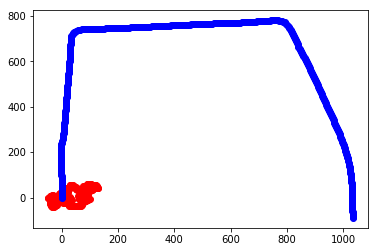

Count:2446
()
()
Relative Depth: -5.178361096710583
Relative x: -41.76993807404701
Relative Original Depth: 90.8242771210498
Relative Original x: 1033.603383771338
Count:2447
()
()
Relative Depth: -5.060865854043382
Relative x: -42.50529711311277
Relative Original Depth: 91.82188256596346
Relative Original x: 1033.6626609682646
Count:2448
()
()
Relative Depth: -4.219617044701648
Relative x: -43.01548273891833
Relative Original Depth: 92.81596031657588
Relative Original x: 1033.7564523700794
Count:2449
()
()
Relative Depth: -3.6343349846076336
Relative x: -43.77318418212626
Relative Original Depth: 93.81476837959912
Relative Original x: 1033.7976440258626
Count:2450
()
()
Relative Depth: -3.465981963907469
Relative x: -44.682281178134744
Relative Original Depth: 94.81317497852233
Relative Original x: 1033.8178114182895


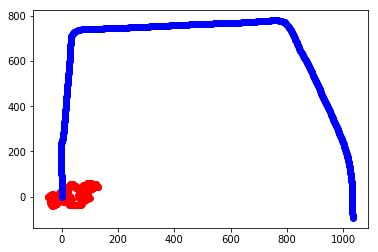

Count:2451
()
()
Relative Depth: -3.246190344047502
Relative x: -45.57974005176643
Relative Original Depth: 95.80962448961174
Relative Original x: 1033.8731165145
Count:2452
()
()
Relative Depth: -2.9648581053955123
Relative x: -46.402922351490666
Relative Original Depth: 96.80691485019813
Relative Original x: 1033.9385441197155
Count:2453
()
()
Relative Depth: -2.720956702207262
Relative x: -47.16065186280762
Relative Original Depth: 97.80508945492204
Relative Original x: 1033.9951561046848
Count:2454
()
()
Relative Depth: -2.438690185047144
Relative x: -47.698432587324916
Relative Original Depth: 98.80398747849212
Relative Original x: 1034.0160809633928
Count:2455
()
()
Relative Depth: -2.1195658150681767
Relative x: -48.05591662401627
Relative Original Depth: 99.80350772774902
Relative Original x: 1034.03859276188


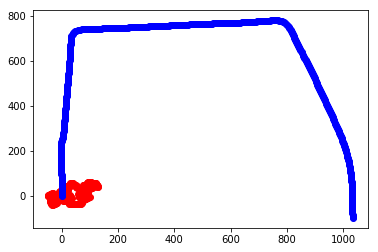

Count:2456
()
()
Relative Depth: -1.7259802220350076
Relative x: -47.33368413557837
Relative Original Depth: 100.8013853407033
Relative Original x: 1034.0793474360537
Count:2457
()
()
Relative Depth: -1.9696334267656488
Relative x: -48.017433876462164
Relative Original Depth: 101.79487073933026
Relative Original x: 1034.1532605173295
Count:2458
()
()
Relative Depth: -1.6593198618688882
Relative x: -47.92120216473997
Relative Original Depth: 102.79005812853143
Relative Original x: 1034.1523657125988
Count:2459
()
()
Relative Depth: -1.3215014660065474
Relative x: -47.49823120303847
Relative Original Depth: 103.78512552368453
Relative Original x: 1034.2431210681334
Count:2460
()
()
Relative Depth: -0.7365223571104417
Relative x: -46.70323081783692
Relative Original Depth: 104.77689711870447
Relative Original x: 1034.2037775586768


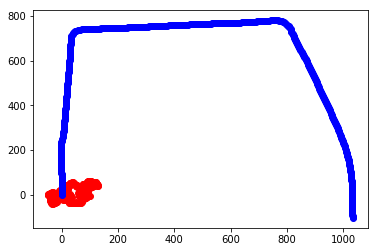

Count:2461
()
()
Relative Depth: -0.3058263700054594
Relative x: -46.04892212074616
Relative Original Depth: 105.7721449925617
Relative Original x: 1034.2678701244758
Count:2462
()
()
Relative Depth: 0.20908970010462924
Relative x: -45.30006649473216
Relative Original Depth: 106.76896937193388
Relative Original x: 1034.3073061128525
Count:2463
()
()
Relative Depth: 0.7860470093645641
Relative x: -44.591336860555494
Relative Original Depth: 107.76749774242367
Relative Original x: 1034.3506540389374
Count:2464
()
()
Relative Depth: 1.4032659280496866
Relative x: -43.93773687530614
Relative Original Depth: 108.7628305815927
Relative Original x: 1034.4402219982678
Count:2465
()
()
Relative Depth: 2.094323193047233
Relative x: -43.39079285548143
Relative Original Depth: 109.7591722040932
Relative Original x: 1034.4783550543739


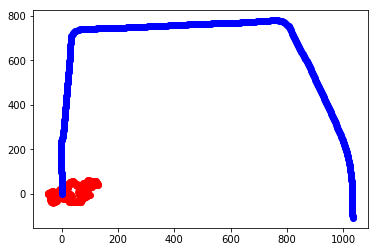

Count:2466
()
()
Relative Depth: 2.808988352233077
Relative x: -42.955631206705
Relative Original Depth: 110.75328502578101
Relative Original x: 1034.5802574745956
Count:2467
()
()
Relative Depth: 3.4671562581036093
Relative x: -42.379434135211554
Relative Original Depth: 111.75029271671629
Relative Original x: 1034.6274489026043
Count:2468
()
()
Relative Depth: 4.094993036104696
Relative x: -41.70402613164572
Relative Original Depth: 112.74540355226841
Relative Original x: 1034.7123665971608
Count:2469
()
()
Relative Depth: 4.718944677483955
Relative x: -40.98406066747967
Relative Original Depth: 113.74245714957095
Relative Original x: 1034.7566217961498
Count:2470
()
()
Relative Depth: 5.2053832749499165
Relative x: -40.28821956848671
Relative Original Depth: 114.73932160148406
Relative Original x: 1034.8133205708393


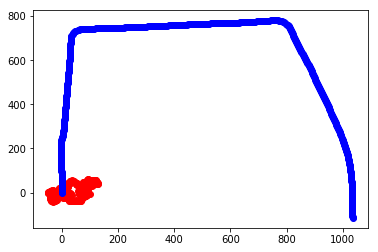

Count:2471
()
()
Relative Depth: 5.475222421237189
Relative x: -39.795477024595435
Relative Original Depth: 115.73461296965908
Relative Original x: 1034.887360364591
Count:2472
()
()
Relative Depth: 5.615346151925716
Relative x: -39.52920480674719
Relative Original Depth: 116.72973187769794
Relative Original x: 1034.9477567364004
Count:2473
()
()
Relative Depth: 5.681004481772842
Relative x: -39.460129624027395
Relative Original Depth: 117.72411210012007
Relative Original x: 1035.041541191773
Count:2474
()
()
Relative Depth: 6.346919525977119
Relative x: -39.83320402826779
Relative Original Depth: 118.72101176725782
Relative Original x: 1035.0802032663466
Count:2475
()
()
Relative Depth: 6.410345933423859
Relative x: -40.03908125103339
Relative Original Depth: 119.71650426974759
Relative Original x: 1035.1252570256734


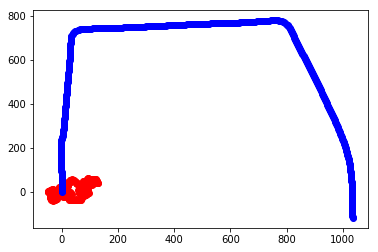

Count:2476
()
()
Relative Depth: 6.8963886878570335
Relative x: -40.37276422909705
Relative Original Depth: 120.71078500735189
Relative Original x: 1035.2076942140586
Count:2477
()
()
Relative Depth: 6.8758875448334145
Relative x: -40.497603200072206
Relative Original Depth: 121.70714774829142
Relative Original x: 1035.2640855285083
Count:2478
()
()
Relative Depth: 7.762396605830923
Relative x: -40.48618597239995
Relative Original Depth: 122.70310445256594
Relative Original x: 1035.3181599510142
Count:2479
()
()
Relative Depth: 8.268317571235597
Relative x: -40.17079979443753
Relative Original Depth: 123.69842110643187
Relative Original x: 1035.3872950323853
Count:2480
()
()
Relative Depth: 8.301340264064029
Relative x: -39.87899448339615
Relative Original Depth: 124.69476237980565
Relative Original x: 1035.45415702542


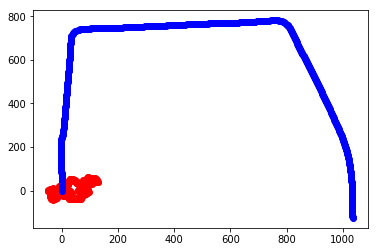

Count:2481
()
()
Relative Depth: 8.39409928637832
Relative x: -39.83515553743441
Relative Original Depth: 125.68938517514475
Relative Original x: 1035.538055017177
Count:2482
()
()
Relative Depth: 8.504478251844379
Relative x: -39.86402797826222
Relative Original Depth: 126.68518473676188
Relative Original x: 1035.6005235976409
Count:2483
()
()
Relative Depth: 8.106071634577964
Relative x: -39.77254195175747
Relative Original Depth: 127.68304589870776
Relative Original x: 1035.6476562797643
Count:2484
()
()
Relative Depth: 7.312725941534233
Relative x: -39.55680535681254
Relative Original Depth: 128.67864060024814
Relative Original x: 1035.7311344200489
Count:2485
()
()
Relative Depth: 6.767074390784568
Relative x: -39.42430118782549
Relative Original Depth: 129.67355025089034
Relative Original x: 1035.8064000209256


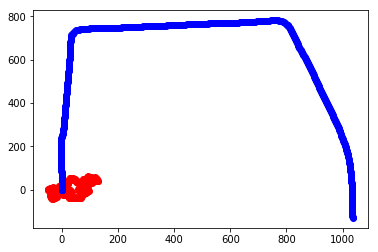

Count:2486
()
()
Relative Depth: 5.914598091219276
Relative x: -39.16835758784625
Relative Original Depth: 130.6711634452999
Relative Original x: 1035.8110967285772
Count:2487
()
()
Relative Depth: 6.214994774366305
Relative x: -39.89602839562803
Relative Original Depth: 131.66751945743775
Relative Original x: 1035.857469618356
Count:2488
()
()
Relative Depth: 5.507653621013211
Relative x: -39.49537630670844
Relative Original Depth: 132.66424518273612
Relative Original x: 1035.8939413541746
Count:2489
()
()
Relative Depth: 4.9663736764738315
Relative x: -38.92878410172288
Relative Original Depth: 133.66017457862293
Relative Original x: 1035.9729409751917
Count:2490
()
()
Relative Depth: 4.454748405935905
Relative x: -38.364848150077194
Relative Original Depth: 134.65705039073964
Relative Original x: 1035.9888170095069


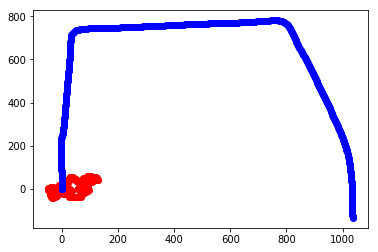

Count:2491
()
()
Relative Depth: 4.297657629384169
Relative x: -39.32526084470892
Relative Original Depth: 135.650513768108
Relative Original x: 1036.0861427011846
Count:2492
()
()
Relative Depth: 3.7902885203121706
Relative x: -38.975826133158286
Relative Original Depth: 136.64563186040363
Relative Original x: 1036.1586328231008
Count:2493
()
()
Relative Depth: 3.80367457314595
Relative x: -38.654915949774455
Relative Original Depth: 137.63439782120923
Relative Original x: 1036.3021110520901
Count:2494
()
()
Relative Depth: 4.1815251354772665
Relative x: -37.95313677130284
Relative Original Depth: 138.628579402482
Relative Original x: 1036.3733249161598
Count:2495
()
()
Relative Depth: 4.486733441205615
Relative x: -37.0211731940139
Relative Original Depth: 139.62456505460474
Relative Original x: 1036.4533460551347


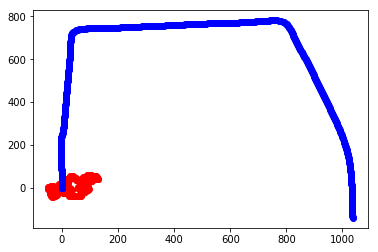

Count:2496
()
()
Relative Depth: 5.164971713512233
Relative x: -36.311297100888396
Relative Original Depth: 140.62038594437206
Relative Original x: 1036.5292577107423
Count:2497
()
()
Relative Depth: 5.97076735796542
Relative x: -36.47337967703035
Relative Original Depth: 141.61434202776758
Relative Original x: 1036.6298819848896
Count:2498
()
()
Relative Depth: 6.344822090154904
Relative x: -36.90845430208169
Relative Original Depth: 142.61093436247978
Relative Original x: 1036.690598654434
Count:2499
()
()
Relative Depth: 6.636553144359832
Relative x: -37.14267829699761
Relative Original Depth: 143.60910709360314
Relative Original x: 1036.7324509083815
Count:2500
()
()
Relative Depth: 6.875637550448825
Relative x: -37.30023295423357
Relative Original Depth: 144.6038222573433
Relative Original x: 1036.828885751594


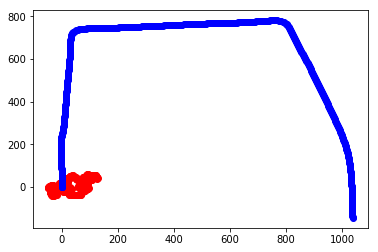

Count:2501
()
()
Relative Depth: 6.833658508488924
Relative x: -36.68044540978556
Relative Original Depth: 145.59963354967113
Relative Original x: 1036.889377895319
Count:2502
()
()
Relative Depth: 7.721742299661439
Relative x: -36.279412197731624
Relative Original Depth: 146.59498761271317
Relative Original x: 1036.9744040169999
Count:2503
()
()
Relative Depth: 8.100669572217523
Relative x: -36.24293944494515
Relative Original Depth: 147.58669986966123
Relative Original x: 1037.0871488017685
Count:2504
()
()
Relative Depth: 8.518556730659565
Relative x: -35.70673734557684
Relative Original Depth: 148.5798322491975
Relative Original x: 1037.196301911385
Count:2505
()
()
Relative Depth: 8.604309968375652
Relative x: -34.71570151561008
Relative Original Depth: 149.57273133816645
Relative Original x: 1037.313695377332


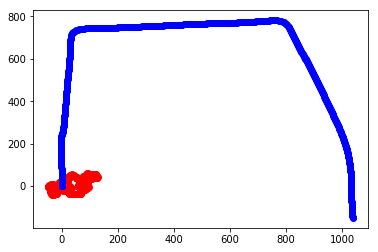

Count:2506
()
()
Relative Depth: 8.315971256721804
Relative x: -33.81769587267577
Relative Original Depth: 150.56883376330867
Relative Original x: 1037.3953869150187
Count:2507
()
()
Relative Depth: 7.707488509116392
Relative x: -33.07883158394691
Relative Original Depth: 151.56458301373254
Relative Original x: 1037.482725798828
Count:2508
()
()
Relative Depth: 7.046972155791927
Relative x: -32.402086970086856
Relative Original Depth: 152.55928898482438
Relative Original x: 1037.5624718760223
Count:2509
()
()
Relative Depth: 6.5174324115480875
Relative x: -31.70051031907293
Relative Original Depth: 153.55464254995834
Relative Original x: 1037.6524495716997
Count:2510
()
()
Relative Depth: 5.936683544509925
Relative x: -31.049205594803066
Relative Original Depth: 154.5452871593202
Relative Original x: 1037.7731127401712


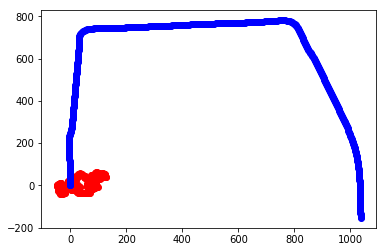

Count:2511
()
()
Relative Depth: 5.372715575264794
Relative x: -30.358827534682256
Relative Original Depth: 155.5412845940033
Relative Original x: 1037.847338139333
Count:2512
()
()
Relative Depth: 4.707292105297697
Relative x: -29.626364696167656
Relative Original Depth: 156.53408094131876
Relative Original x: 1037.9660092315212
Count:2513
()
()
Relative Depth: 4.512617144719412
Relative x: -29.026520831824328
Relative Original Depth: 157.52591325069972
Relative Original x: 1038.0714057505104
Count:2514
()
()
Relative Depth: 5.042792345917735
Relative x: -28.398972449587905
Relative Original Depth: 158.51484858070737
Relative Original x: 1038.2033946467454
Count:2515
()
()
Relative Depth: 5.977480939768583
Relative x: -28.116767387804593
Relative Original Depth: 159.49982217506957
Relative Original x: 1038.346500276571


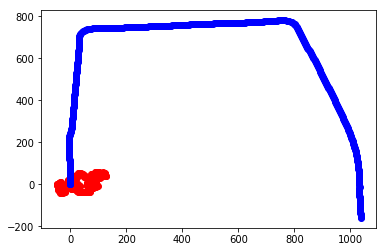

Count:2516
()
()
Relative Depth: 6.495276884836181
Relative x: -27.99181071958872
Relative Original Depth: 160.4935277320312
Relative Original x: 1038.4468112871666
Count:2517
()
()
Relative Depth: 6.653809644465934
Relative x: -27.693333798643092
Relative Original Depth: 161.48839614224073
Relative Original x: 1038.5468283253558
Count:2518
()
()
Relative Depth: 6.983273673472497
Relative x: -27.123055617793337
Relative Original Depth: 162.48145170586184
Relative Original x: 1038.6636362456659
Count:2519
()
()
Relative Depth: 7.521584246433379
Relative x: -26.319318746285724
Relative Original Depth: 163.4739921289043
Relative Original x: 1038.729929679487
Count:2520
()
()
Relative Depth: 8.185825944709359
Relative x: -25.58607587412707
Relative Original Depth: 164.46874343491302
Relative Original x: 1038.8278527339428


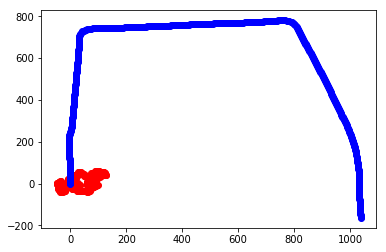

Count:2521
()
()
Relative Depth: 8.524027475944605
Relative x: -25.419104232677128
Relative Original Depth: 165.45861314758338
Relative Original x: 1038.945385692378
Count:2522
()
()
Relative Depth: 9.155468280984172
Relative x: -24.652517660734134
Relative Original Depth: 166.45301124622586
Relative Original x: 1038.9841377734183
Count:2523
()
()
Relative Depth: 9.703997229771419
Relative x: -23.930752089853282
Relative Original Depth: 167.45091732919357
Relative Original x: 1039.0275671417505
Count:2524
()
()
Relative Depth: 10.21101262607634
Relative x: -23.204859367150302
Relative Original Depth: 168.44660816482914
Relative Original x: 1039.1035292650624
Count:2525
()
()
Relative Depth: 11.06553462855606
Relative x: -23.58191865884962
Relative Original Depth: 169.44162240405336
Relative Original x: 1039.1832095205389


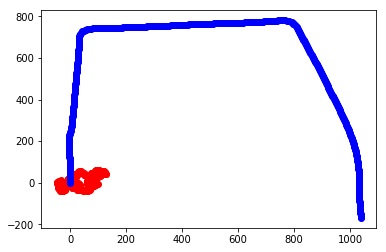

Count:2526
()
()
Relative Depth: 11.181803643119514
Relative x: -22.76715594064518
Relative Original Depth: 170.43450249894858
Relative Original x: 1039.2896937630273
Count:2527
()
()
Relative Depth: 10.728820501523648
Relative x: -21.94959770008676
Relative Original Depth: 171.42589837343073
Relative Original x: 1039.3854575649486
Count:2528
()
()
Relative Depth: 10.63635710089602
Relative x: -21.805603828068776
Relative Original Depth: 172.4187137492707
Relative Original x: 1039.4866661020014
Count:2529
()
()
Relative Depth: 11.232014647552992
Relative x: -22.52538724343528
Relative Original Depth: 173.41272365032674
Relative Original x: 1039.5775594813374
Count:2530
()
()
Relative Depth: 10.998504344776473
Relative x: -21.976101521047482
Relative Original Depth: 174.40458591332316
Relative Original x: 1039.6720278854984


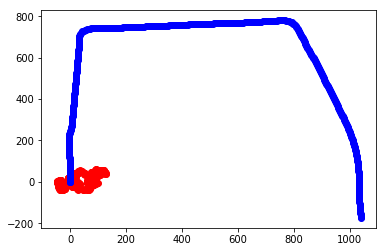

Count:2531
()
()
Relative Depth: 11.480696951480864
Relative x: -22.758779114498417
Relative Original Depth: 175.39991962723548
Relative Original x: 1039.730796159261
Count:2532
()
()
Relative Depth: 11.986883895114623
Relative x: -23.57394952558295
Relative Original Depth: 176.3955659186094
Relative Original x: 1039.7797215475089
Count:2533
()
()
Relative Depth: 12.516777136113188
Relative x: -24.371635755355392
Relative Original Depth: 177.3909800992956
Relative Original x: 1039.8663981919083
Count:2534
()
()
Relative Depth: 12.840070856529936
Relative x: -25.213713889474406
Relative Original Depth: 178.38890664862683
Relative Original x: 1039.901588848483
Count:2535
()
()
Relative Depth: 12.488368179499757
Relative x: -26.034331881052864
Relative Original Depth: 179.38585416611204
Relative Original x: 1039.964707520077


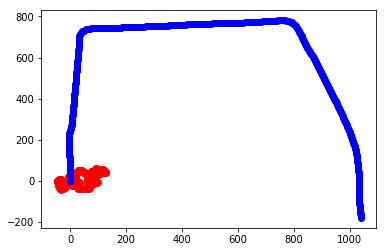

Count:2536
()
()
Relative Depth: 12.806412286486008
Relative x: -26.453290284875376
Relative Original Depth: 180.38070195124502
Relative Original x: 1040.0439550286872
Count:2537
()
()
Relative Depth: 12.074611362238647
Relative x: -27.133169980915792
Relative Original Depth: 181.37641973892246
Relative Original x: 1040.1057326528642
Count:2538
()
()
Relative Depth: 11.33080937929493
Relative x: -27.801290192793505
Relative Original Depth: 182.37058833405246
Relative Original x: 1040.207138955007
Count:2539
()
()
Relative Depth: 10.599487430137378
Relative x: -28.46026312286352
Relative Original Depth: 183.36425797299358
Relative Original x: 1040.3127231407939
Count:2540
()
()
Relative Depth: 10.36625783838508
Relative x: -29.374838625914027
Relative Original Depth: 184.35874739271648
Relative Original x: 1040.400338936947


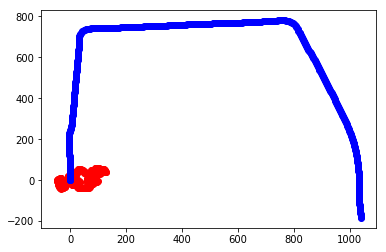

Count:2541
()
()
Relative Depth: 10.738063459105055
Relative x: -30.259173126980997
Relative Original Depth: 185.3503477386296
Relative Original x: 1040.5122021204918
Count:2542
()
()
Relative Depth: 11.516136204978496
Relative x: -30.77534677869669
Relative Original Depth: 186.34683236784846
Relative Original x: 1040.5177417992224
Count:2543
()
()
Relative Depth: 12.464637335709737
Relative x: -30.935279221330383
Relative Original Depth: 187.34414040565434
Relative Original x: 1040.4447701388958
Count:2544
()
()
Relative Depth: 13.35931636965331
Relative x: -31.331811771505738
Relative Original Depth: 188.33097966918814
Relative Original x: 1040.585828315238
Count:2545
()
()
Relative Depth: 13.1957928664333
Relative x: -31.39287278870128
Relative Original Depth: 189.32525629736242
Relative Original x: 1040.5180141388314


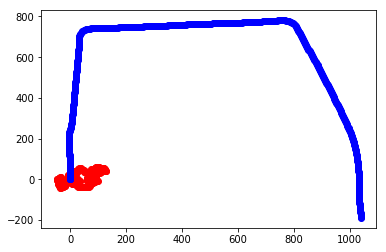

Count:2546
()
()
Relative Depth: 13.897337279408205
Relative x: -32.09225983760021
Relative Original Depth: 190.32236496396348
Relative Original x: 1040.5729876631501
Count:2547
()
()
Relative Depth: 14.281421304983477
Relative x: -32.9199106454216
Relative Original Depth: 191.31962891311895
Relative Original x: 1040.614892612154
Count:2548
()
()
Relative Depth: 14.704925333399213
Relative x: -33.692824911400585
Relative Original Depth: 192.3119721004031
Relative Original x: 1040.4964288790286
Count:2549
()
()
Relative Depth: 15.471051843068842
Relative x: -34.1728017827866
Relative Original Depth: 193.30675081914833
Relative Original x: 1040.395895787695
Count:2550
()
()
Relative Depth: 16.322420077539373
Relative x: -33.67963422662991
Relative Original Depth: 194.30391652070745
Relative Original x: 1040.416210518354


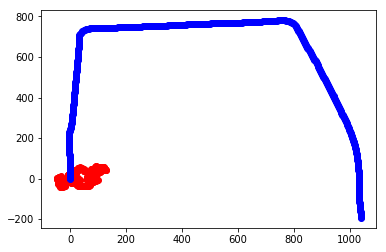

Count:2551
()
()
Relative Depth: 17.25891867989036
Relative x: -33.80453290110467
Relative Original Depth: 195.2957337786094
Relative Original x: 1040.5191506131987
Count:2552
()
()
Relative Depth: 18.245894485635283
Relative x: -33.744788849350556
Relative Original Depth: 196.28329465788312
Relative Original x: 1040.659918807622
Count:2553
()
()
Relative Depth: 19.227780118629603
Relative x: -33.652174761316104
Relative Original Depth: 197.2709010211309
Relative Original x: 1040.5141947050656
Count:2554
()
()
Relative Depth: 20.113976922742825
Relative x: -33.639821639191126
Relative Original Depth: 198.26664452433405
Relative Original x: 1040.4958936317282
Count:2555
()
()
Relative Depth: 20.84321471344669
Relative x: -33.396503450906
Relative Original Depth: 199.26335728619662
Relative Original x: 1040.518128145428


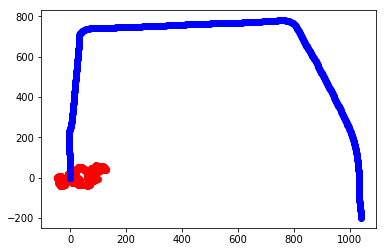

Count:2556
()
()
Relative Depth: 21.30387315070268
Relative x: -33.62576969498874
Relative Original Depth: 200.25410133623248
Relative Original x: 1040.455059522326
Count:2557
()
()
Relative Depth: 21.138733620850513
Relative x: -34.320302246969106
Relative Original Depth: 201.24716479921065
Relative Original x: 1040.3759419007122
Count:2558
()
()
Relative Depth: 20.609187094994137
Relative x: -35.16735341318926
Relative Original Depth: 202.24322896488962
Relative Original x: 1040.308059304421
Count:2559
()
()
Relative Depth: 20.579070651512968
Relative x: -35.82092018563745
Relative Original Depth: 203.23256148436354
Relative Original x: 1040.213883608186
Count:2560
()
()
Relative Depth: 20.893873870847163
Relative x: -36.477110798545475
Relative Original Depth: 204.2222122464629
Relative Original x: 1040.0886535911955


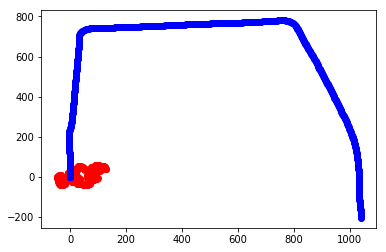

Count:2561
()
()
Relative Depth: 21.19763288144468
Relative x: -37.16950543689748
Relative Original Depth: 205.21401668508958
Relative Original x: 1039.9609614859683
Count:2562
()
()
Relative Depth: 21.444844949040842
Relative x: -37.77805529223074
Relative Original Depth: 206.20707058816222
Relative Original x: 1039.8471036247142
Count:2563
()
()
Relative Depth: 21.571721035433296
Relative x: -38.10125241108994
Relative Original Depth: 207.20313912748668
Relative Original x: 1039.773741549973
Count:2564
()
()
Relative Depth: 21.509356369981987
Relative x: -38.266923307217375
Relative Original Depth: 208.19960920186145
Relative Original x: 1039.7016004723914
Count:2565
()
()
Relative Depth: 21.249683958151135
Relative x: -38.542728881283566
Relative Original Depth: 209.181715642343
Relative Original x: 1039.5354394725875


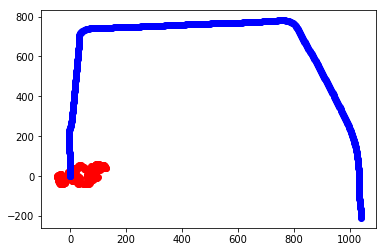

Count:2566
()
()
Relative Depth: 21.011101584052057
Relative x: -38.84685095231768
Relative Original Depth: 210.1612365884671
Relative Original x: 1039.3399997076588
Count:2567
()
()
Relative Depth: 20.787035096831573
Relative x: -39.197025651010755
Relative Original Depth: 211.1389411892906
Relative Original x: 1039.1301015360182
Count:2568
()
()
Relative Depth: 20.46523943102372
Relative x: -39.48190025079566
Relative Original Depth: 212.10173773184314
Relative Original x: 1038.8782001871296
Count:2569
()
()
Relative Depth: 20.4546098049018
Relative x: -39.47299211014226
Relative Original Depth: 213.05895903661846
Relative Original x: 1038.5935483319754
Count:2570
()
()
Relative Depth: 20.933870750244893
Relative x: -39.117538018395166
Relative Original Depth: 214.01707190038616
Relative Original x: 1038.3148388184911


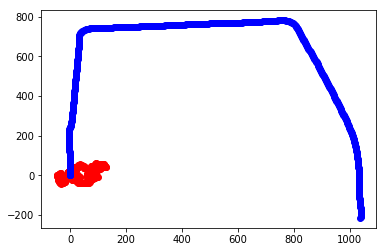

Count:2571
()
()
Relative Depth: 21.539598251033585
Relative x: -38.75612498809875
Relative Original Depth: 214.93687087449015
Relative Original x: 1037.9434565122197
Count:2572
()
()
Relative Depth: 22.148012030052932
Relative x: -38.40584401073876
Relative Original Depth: 215.86718846081286
Relative Original x: 1037.5830172105127
Count:2573
()
()
Relative Depth: 22.784245488765166
Relative x: -38.00947553932489
Relative Original Depth: 216.8044160473509
Relative Original x: 1037.2374658930999
Count:2574
()
()
Relative Depth: 23.348990510499036
Relative x: -37.51176303365601
Relative Original Depth: 217.71702111235848
Relative Original x: 1036.8310078293766
Count:2575
()
()
Relative Depth: 23.680448434658942
Relative x: -37.21469535304974
Relative Original Depth: 218.64891032462225
Relative Original x: 1036.4682739150812


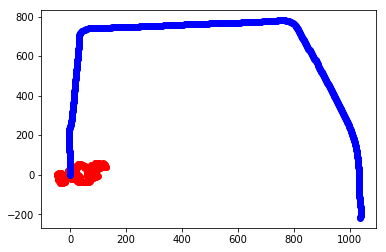

Count:2576
()
()
Relative Depth: 23.67604427658484
Relative x: -36.95421816898787
Relative Original Depth: 219.5539590040273
Relative Original x: 1036.0430125063804
Count:2577
()
()
Relative Depth: 23.801728951376727
Relative x: -37.1402002658538
Relative Original Depth: 220.46761240966956
Relative Original x: 1035.6366847512254
Count:2578
()
()
Relative Depth: 24.23077978779619
Relative x: -37.70698532902053
Relative Original Depth: 221.3814121870094
Relative Original x: 1035.2340547290223
Count:2579
()
()
Relative Depth: 24.688843095298424
Relative x: -38.19990862103039
Relative Original Depth: 222.2556515645838
Relative Original x: 1034.755774941183
Count:2580
()
()
Relative Depth: 25.162011380089808
Relative x: -38.61991758097543
Relative Original Depth: 223.1272781271715
Relative Original x: 1034.2670855930264


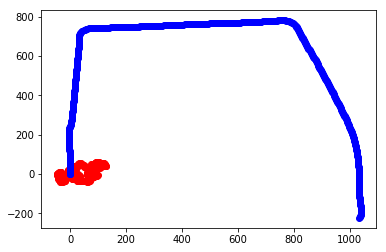

Count:2581
()
()
Relative Depth: 25.707075125153246
Relative x: -38.86582270776105
Relative Original Depth: 223.973230082552
Relative Original x: 1033.7368275212843
Count:2582
()
()
Relative Depth: 25.621314919720103
Relative x: -37.872246342080636
Relative Original Depth: 224.7658459249119
Relative Original x: 1033.13388576547
Count:2583
()
()
Relative Depth: 26.340103347595964
Relative x: -37.92449118820863
Relative Original Depth: 225.5754436569327
Relative Original x: 1032.5554255733718
Count:2584
()
()
Relative Depth: 26.771720935750793
Relative x: -37.52864053858963
Relative Original Depth: 226.44717689305105
Relative Original x: 1032.0705110390156
Count:2585
()
()
Relative Depth: 26.61883161824542
Relative x: -36.867500033167246
Relative Original Depth: 227.22042021072758
Relative Original x: 1031.4386728568566


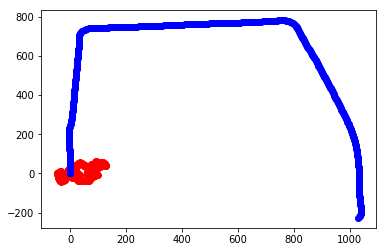

Count:2586
()
()
Relative Depth: 26.62005981235245
Relative x: -36.070830509232216
Relative Original Depth: 227.93908896965684
Relative Original x: 1030.7488990271588
Count:2587
()
()
Relative Depth: 26.598198673300377
Relative x: -35.0952382051435
Relative Original Depth: 228.7877146182308
Relative Original x: 1030.2201518836907
Count:2588
()
()
Relative Depth: 26.907911082085988
Relative x: -34.60288121811519
Relative Original Depth: 229.5248116685722
Relative Original x: 1029.5457072443169
Count:2589
()
()
Relative Depth: 27.248562113352175
Relative x: -33.662814835961065
Relative Original Depth: 230.26248469712783
Relative Original x: 1028.870610471854
Count:2590
()
()
Relative Depth: 27.909848228685092
Relative x: -32.93835986023031
Relative Original Depth: 231.00632013519083
Relative Original x: 1028.2022794364248


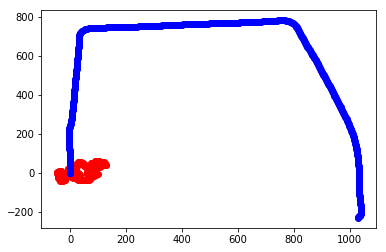

Count:2591
()
()
Relative Depth: 28.695187013445082
Relative x: -32.370897687258186
Relative Original Depth: 231.71929615851684
Relative Original x: 1027.5021808251288
Count:2592
()
()
Relative Depth: 29.442320840496
Relative x: -31.717542719485888
Relative Original Depth: 232.38477375402326
Relative Original x: 1026.755967903836
Count:2593
()
()
Relative Depth: 29.897522355687688
Relative x: -30.9380896053016
Relative Original Depth: 233.08019847028024
Relative Original x: 1026.037659862147
Count:2594
()
()
Relative Depth: 30.158175549686483
Relative x: -30.025174881071468
Relative Original Depth: 233.73391295194108
Relative Original x: 1025.281041623056
Count:2595
()
()
Relative Depth: 30.23757325708056
Relative x: -29.029302535219333
Relative Original Depth: 234.3867176909604
Relative Original x: 1024.5236915074775


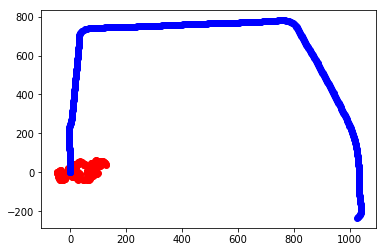

Count:2596
()
()
Relative Depth: 30.225134413738406
Relative x: -28.03527665797815
Relative Original Depth: 234.9683338819825
Relative Original x: 1023.7106748062737
Count:2597
()
()
Relative Depth: 30.246432264069444
Relative x: -27.055025262511066
Relative Original Depth: 235.4510814818473
Relative Original x: 1022.838540934761
Count:2598
()
()
Relative Depth: 30.420185044243727
Relative x: -26.222749121540147
Relative Original Depth: 235.92971143683192
Relative Original x: 1021.9625838310369
Count:2599
()
()
Relative Depth: 30.774285694961463
Relative x: -25.463748211644162
Relative Original Depth: 236.45870056660374
Relative Original x: 1021.1139676361498
Count:2600
()
()
Relative Depth: 31.122564004244683
Relative x: -24.657914392046383
Relative Original Depth: 236.87384933548063
Relative Original x: 1020.2058327708021


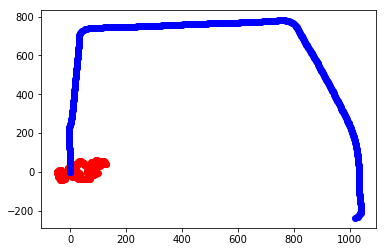

Count:2601
()
()
Relative Depth: 31.27398753674591
Relative x: -23.73364218294454
Relative Original Depth: 237.33742894037897
Relative Original x: 1019.3201803157169
Count:2602
()
()
Relative Depth: 31.454809508325145
Relative x: -22.832576987420182
Relative Original Depth: 237.70421078920816
Relative Original x: 1018.3901624560482
Count:2603
()
()
Relative Depth: 32.04453789278596
Relative x: -22.144641670514545
Relative Original Depth: 238.07657942389926
Relative Original x: 1017.4620823513018
Count:2604
()
()
Relative Depth: 32.776796172340084
Relative x: -21.497017501967623
Relative Original Depth: 238.3832059487107
Relative Original x: 1016.5103237850199
Count:2605
()
()
Relative Depth: 33.55569496959204
Relative x: -20.908302244967913
Relative Original Depth: 238.68247709274758
Relative Original x: 1015.5572770367427


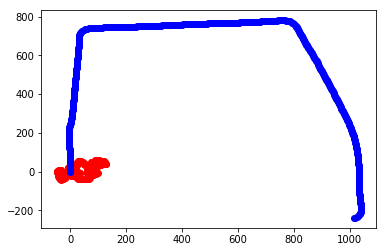

Count:2606
()
()
Relative Depth: 34.314931132686766
Relative x: -20.281896579812372
Relative Original Depth: 238.90051524171056
Relative Original x: 1014.5813461302336
Count:2607
()
()
Relative Depth: 33.925758317519815
Relative x: -21.175607218657397
Relative Original Depth: 239.1480204665844
Relative Original x: 1013.6126226097507
Count:2608
()
()
Relative Depth: 34.8413967671398
Relative x: -20.775074572608943
Relative Original Depth: 239.37197844413464
Relative Original x: 1012.6380336400639
Count:2609
()
()
Relative Depth: 35.830698520345
Relative x: -20.6336523959709
Relative Original Depth: 239.55961835234257
Relative Original x: 1011.6558016570389
Count:2610
()
()
Relative Depth: 36.71495971581956
Relative x: -21.065896900748843
Relative Original Depth: 239.72299241380517
Relative Original x: 1010.6692911681365


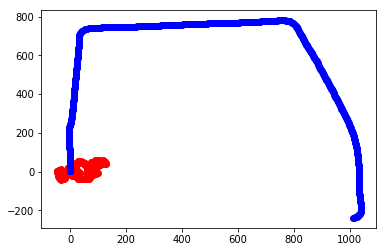

Count:2611
()
()
Relative Depth: 36.45372180132126
Relative x: -21.669057259868545
Relative Original Depth: 239.81501896161922
Relative Original x: 1009.6748628429443
Count:2612
()
()
Relative Depth: 37.217044848933284
Relative x: -22.216628037914763
Relative Original Depth: 239.88660807992085
Relative Original x: 1008.6774353253305
Count:2613
()
()
Relative Depth: 36.228198279773274
Relative x: -22.192774591205954
Relative Original Depth: 239.95631991192897
Relative Original x: 1007.6798744275923
Count:2614
()
()
Relative Depth: 37.10677639515645
Relative x: -22.521067100709498
Relative Original Depth: 240.0354826277092
Relative Original x: 1006.6835823072805
Count:2615
()
()
Relative Depth: 38.073170707165346
Relative x: -22.748644525358014
Relative Original Depth: 240.0627737328333
Relative Original x: 1005.685639874262


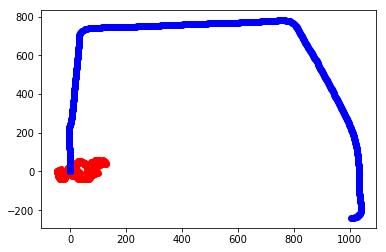

Count:2616
()
()
Relative Depth: 38.56237626771524
Relative x: -23.570880849749024
Relative Original Depth: 240.09188333576998
Relative Original x: 1004.6874271140712
Count:2617
()
()
Relative Depth: 38.16140458590153
Relative x: -24.41799551103032
Relative Original Depth: 240.05163323550101
Relative Original x: 1003.6890684261582
Count:2618
()
()
Relative Depth: 37.69428677238906
Relative x: -25.247937502856864
Relative Original Depth: 239.98232153541176
Relative Original x: 1002.693887798221
Count:2619
()
()
Relative Depth: 36.986504361107976
Relative x: -25.93303873934651
Relative Original Depth: 239.9025130724236
Relative Original x: 1001.700025114767
Count:2620
()
()
Relative Depth: 36.06287143900915
Relative x: -26.299940686384538
Relative Original Depth: 239.8241138574939
Relative Original x: 1000.7033767118794


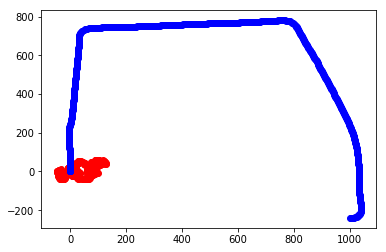

Count:2621
()
()
Relative Depth: 35.11508854352429
Relative x: -26.50066064188351
Relative Original Depth: 239.8080522550857
Relative Original x: 999.705488149485
Count:2622
()
()
Relative Depth: 35.06112288286783
Relative x: -27.165942834040873
Relative Original Depth: 239.6914632586335
Relative Original x: 998.712436879818
Count:2623
()
()
Relative Depth: 34.13621466541427
Relative x: -27.087795921365622
Relative Original Depth: 239.5370519189861
Relative Original x: 997.724457690293
Count:2624
()
()
Relative Depth: 33.27986770260219
Relative x: -26.87134619407476
Relative Original Depth: 239.4164396140047
Relative Original x: 996.7333224112508
Count:2625
()
()
Relative Depth: 32.305585607106096
Relative x: -27.094271295711533
Relative Original Depth: 239.2403590790956
Relative Original x: 995.7494712655711


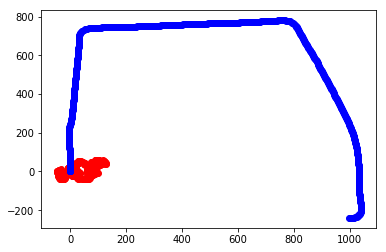

Count:2626
()
()
Relative Depth: 31.685523860245848
Relative x: -27.62906750818743
Relative Original Depth: 239.04010080656917
Relative Original x: 994.7703016489371
Count:2627
()
()
Relative Depth: 31.13110370756829
Relative x: -28.22674407522459
Relative Original Depth: 238.8301201882591
Relative Original x: 993.7934974046831
Count:2628
()
()
Relative Depth: 31.7043404892347
Relative x: -28.79636455782583
Relative Original Depth: 238.63092260533756
Relative Original x: 992.8136640192331
Count:2629
()
()
Relative Depth: 31.294860370017926
Relative x: -29.550588248573124
Relative Original Depth: 238.424460594336
Relative Original x: 991.8354901149628
Count:2630
()
()
Relative Depth: 30.90154563021493
Relative x: -30.246399891444824
Relative Original Depth: 238.1490493804598
Relative Original x: 990.8756045156688


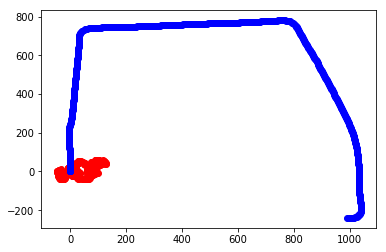

Count:2631
()
()
Relative Depth: 30.457342871180906
Relative x: -30.86394355722053
Relative Original Depth: 237.90730746998622
Relative Original x: 989.9066748138637
Count:2632
()
()
Relative Depth: 31.178091222088476
Relative x: -31.522024909035604
Relative Original Depth: 237.67964993740418
Relative Original x: 988.9336388932275
Count:2633
()
()
Relative Depth: 30.848443612582177
Relative x: -32.346264184821344
Relative Original Depth: 237.47571965253454
Relative Original x: 987.9571078121832
Count:2634
()
()
Relative Depth: 30.71273904948325
Relative x: -33.301190589870444
Relative Original Depth: 237.20168306258498
Relative Original x: 986.9969385845751
Count:2635
()
()
Relative Depth: 30.67414381518222
Relative x: -34.29542994635178
Relative Original Depth: 236.92170317273002
Relative Original x: 986.0378243206303


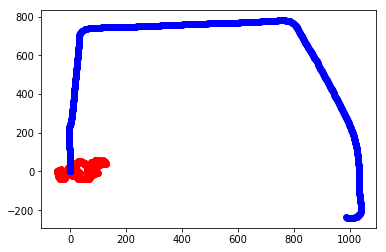

Count:2636
()
()
Relative Depth: 31.47837969696177
Relative x: -34.872071936463975
Relative Original Depth: 236.66735700285332
Relative Original x: 985.0715354576872
Count:2637
()
()
Relative Depth: 31.65424687572364
Relative x: -35.854941551542986
Relative Original Depth: 236.42840252873188
Relative Original x: 984.1039325620991
Count:2638
()
()
Relative Depth: 31.96200957267033
Relative x: -36.769965010956895
Relative Original Depth: 236.14390932076304
Relative Original x: 983.1461301981384
Count:2639
()
()
Relative Depth: 32.6986403195712
Relative x: -37.356619004101596
Relative Original Depth: 235.84339624268006
Relative Original x: 982.1924516658158
Count:2640
()
()
Relative Depth: 32.994287198947404
Relative x: -38.246422735379994
Relative Original Depth: 235.53251107973838
Relative Original x: 981.2425284509881


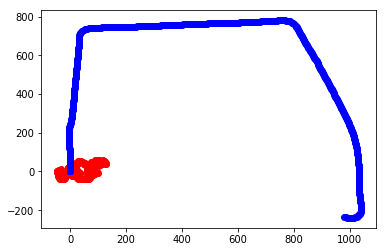

Count:2641
()
()
Relative Depth: 33.23434051430215
Relative x: -39.186797076220316
Relative Original Depth: 235.23823072950006
Relative Original x: 980.2880988770821
Count:2642
()
()
Relative Depth: 32.68926112652296
Relative x: -39.850779229021036
Relative Original Depth: 234.9580642234806
Relative Original x: 979.3288281273767
Count:2643
()
()
Relative Depth: 32.09843125315514
Relative x: -39.71514108610296
Relative Original Depth: 234.66505740328208
Relative Original x: 978.3728494041915
Count:2644
()
()
Relative Depth: 31.79702488236665
Relative x: -39.78476023174329
Relative Original Depth: 234.33701716917716
Relative Original x: 977.4282119581508
Count:2645
()
()
Relative Depth: 31.16430052398353
Relative x: -39.650885942236116
Relative Original Depth: 234.07862143556557
Relative Original x: 976.463493680989


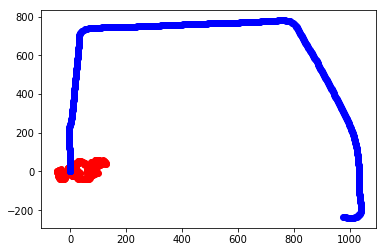

Count:2646
()
()
Relative Depth: 30.348679918757217
Relative x: -39.417203003150014
Relative Original Depth: 233.78668302637044
Relative Original x: 975.5086583268866
Count:2647
()
()
Relative Depth: 29.74605539504921
Relative x: -39.26975479001083
Relative Original Depth: 233.45383978091775
Relative Original x: 974.5660489858976
Count:2648
()
()
Relative Depth: 29.0342529154199
Relative x: -38.972992816554004
Relative Original Depth: 233.1606314555501
Relative Original x: 973.6108054341636
Count:2649
()
()
Relative Depth: 29.258719689719257
Relative x: -38.292226707883756
Relative Original Depth: 232.88750733844745
Relative Original x: 972.651817585983
Count:2650
()
()
Relative Depth: 29.817688314327352
Relative x: -39.075173617457544
Relative Original Depth: 232.59086961145485
Relative Original x: 971.6976992605024


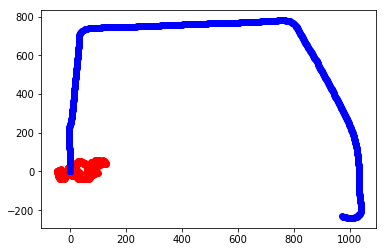

Count:2651
()
()
Relative Depth: 30.08938021368776
Relative x: -39.970487407881315
Relative Original Depth: 232.31186591928227
Relative Original x: 970.7385202539167
Count:2652
()
()
Relative Depth: 30.306945417875855
Relative x: -40.93707456468866
Relative Original Depth: 232.02278407938417
Relative Original x: 969.7824769767169
Count:2653
()
()
Relative Depth: 30.659932706193167
Relative x: -41.870634338976224
Relative Original Depth: 231.7155587662398
Relative Original x: 968.8331073094237
Count:2654
()
()
Relative Depth: 30.949458923443903
Relative x: -42.81323060055562
Relative Original Depth: 231.43002743050008
Relative Original x: 967.8767948867238
Count:2655
()
()
Relative Depth: 30.976261522254514
Relative x: -43.74353544354169
Relative Original Depth: 231.14733111442894
Relative Original x: 966.9190563193921


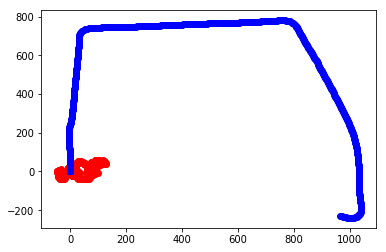

Count:2656
()
()
Relative Depth: 30.508821715739362
Relative x: -44.60736241775735
Relative Original Depth: 230.79172522349154
Relative Original x: 965.9891063351274
Count:2657
()
()
Relative Depth: 30.595700673545146
Relative x: -45.481573829329115
Relative Original Depth: 230.4988171624648
Relative Original x: 965.0334925332224
Count:2658
()
()
Relative Depth: 30.52037686535288
Relative x: -46.40825047119249
Relative Original Depth: 230.191199124388
Relative Original x: 964.0830944189732
Count:2659
()
()
Relative Depth: 30.19449532429725
Relative x: -47.35144511361246
Relative Original Depth: 229.861489135124
Relative Original x: 963.1391321589771
Count:2660
()
()
Relative Depth: 29.725436065062446
Relative x: -48.21969932014019
Relative Original Depth: 229.5696601217746
Relative Original x: 962.1830292312055


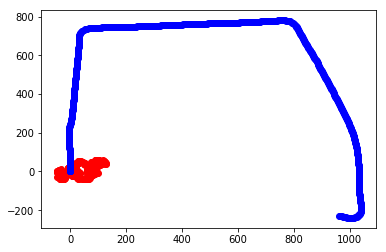

Count:2661
()
()
Relative Depth: 28.85799747757941
Relative x: -48.25561287424078
Relative Original Depth: 229.27769201369392
Relative Original x: 961.2275617309652
Count:2662
()
()
Relative Depth: 28.62014763902377
Relative x: -48.3871281794827
Relative Original Depth: 228.97479128479677
Relative Original x: 960.274595962852
Count:2663
()
()
Relative Depth: 28.079255005041556
Relative x: -49.193965456859445
Relative Original Depth: 228.70285353221155
Relative Original x: 959.3128391917868
Count:2664
()
()
Relative Depth: 27.72130273933474
Relative x: -50.1131322684943
Relative Original Depth: 228.40708748994987
Relative Original x: 958.3579914446971
Count:2665
()
()
Relative Depth: 27.896130189269233
Relative x: -50.96132407372798
Relative Original Depth: 228.11717237433007
Relative Original x: 957.4012724415181


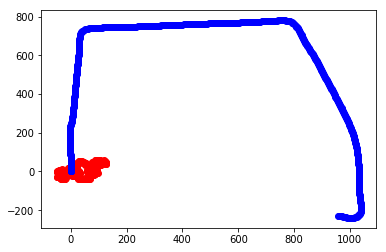

Count:2666
()
()
Relative Depth: 28.238416126715567
Relative x: -51.78307797367678
Relative Original Depth: 227.81218306358676
Relative Original x: 956.4495299371468
Count:2667
()
()
Relative Depth: 28.648110143967934
Relative x: -52.58854967986536
Relative Original Depth: 227.52923315141337
Relative Original x: 955.490737508761
Count:2668
()
()
Relative Depth: 29.180869331711893
Relative x: -53.35212362741902
Relative Original Depth: 227.21565880682192
Relative Original x: 954.5418380871133
Count:2669
()
()
Relative Depth: 29.874389090010435
Relative x: -53.9891107780523
Relative Original Depth: 226.9085293919398
Relative Original x: 953.5919639675488
Count:2670
()
()
Relative Depth: 30.68196085914428
Relative x: -54.45088131258089
Relative Original Depth: 226.59015006945313
Relative Original x: 952.6446371462853


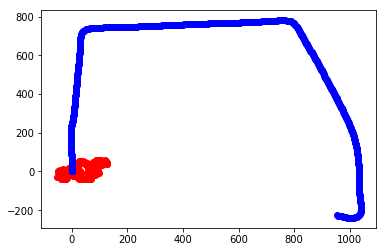

Count:2671
()
()
Relative Depth: 31.458305870287028
Relative x: -54.935062433139116
Relative Original Depth: 226.2952513250292
Relative Original x: 951.6897735418728
Count:2672
()
()
Relative Depth: 32.20924478480002
Relative x: -55.50947999574653
Relative Original Depth: 226.01435403361063
Relative Original x: 950.7304454272329
Count:2673
()
()
Relative Depth: 32.96523953722719
Relative x: -56.11416725214442
Relative Original Depth: 225.6888208618682
Relative Original x: 949.7862957459974
Count:2674
()
()
Relative Depth: 33.65761705198726
Relative x: -56.821994385070575
Relative Original Depth: 225.37856250596545
Relative Original x: 948.837295987968
Count:2675
()
()
Relative Depth: 34.32324392973645
Relative x: -57.56446379948331
Relative Original Depth: 225.08414991152597
Relative Original x: 947.881956376397


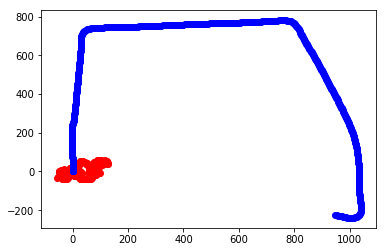

Count:2676
()
()
Relative Depth: 35.03681559030362
Relative x: -58.25816577967323
Relative Original Depth: 224.7624339705463
Relative Original x: 946.9362954515495
Count:2677
()
()
Relative Depth: 35.82378520123281
Relative x: -58.875156254224
Relative Original Depth: 224.4688867528595
Relative Original x: 945.9804055599701
Count:2678
()
()
Relative Depth: 36.645886639559045
Relative x: -59.444464844481274
Relative Original Depth: 224.2126422627453
Relative Original x: 945.0148015290644
Count:2679
()
()
Relative Depth: 37.482798378038446
Relative x: -59.98262809468936
Relative Original Depth: 223.8608372513797
Relative Original x: 944.080368652053
Count:2680
()
()
Relative Depth: 38.21268287139303
Relative x: -60.66009213630907
Relative Original Depth: 223.5507497158777
Relative Original x: 943.1302020483329


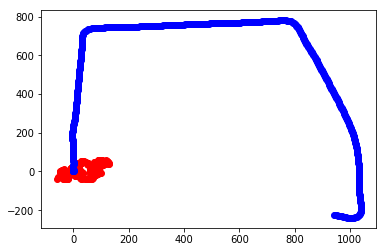

Count:2681
()
()
Relative Depth: 38.70104237702374
Relative x: -61.47090539719678
Relative Original Depth: 223.28741590925597
Relative Original x: 942.1659232401894
Count:2682
()
()
Relative Depth: 39.252727391072
Relative x: -62.22255417658421
Relative Original Depth: 222.98321524792766
Relative Original x: 941.213768742284
Count:2683
()
()
Relative Depth: 39.773513327841755
Relative x: -62.96940904808107
Relative Original Depth: 222.68707445113412
Relative Original x: 940.2586586033831
Count:2684
()
()
Relative Depth: 40.18579196111339
Relative x: -63.77279553808938
Relative Original Depth: 222.38724117071683
Relative Original x: 939.3053611531643
Count:2685
()
()
Relative Depth: 40.89150364418211
Relative x: -64.42807459872776
Relative Original Depth: 222.07339216175527
Relative Original x: 938.3577162085311


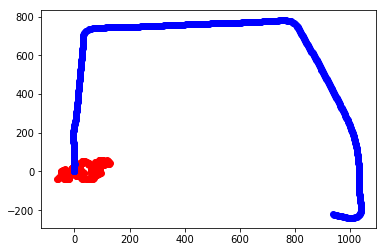

Count:2686
()
()
Relative Depth: 41.541684344319144
Relative x: -65.17232679765037
Relative Original Depth: 221.7747495032267
Relative Original x: 937.4037032311676
Count:2687
()
()
Relative Depth: 41.67311407839691
Relative x: -66.13353871341586
Relative Original Depth: 221.45894964946453
Relative Original x: 936.4579423578803
Count:2688
()
()
Relative Depth: 41.761382019983465
Relative x: -67.07868591615174
Relative Original Depth: 221.13967631237205
Relative Original x: 935.5109490171574
Count:2689
()
()
Relative Depth: 41.84136297344583
Relative x: -67.99123041663255
Relative Original Depth: 220.8356259578106
Relative Original x: 934.558598847766
Count:2690
()
()
Relative Depth: 41.79127205664537
Relative x: -68.82515341737377
Relative Original Depth: 220.5243544274419
Relative Original x: 933.6084071035708


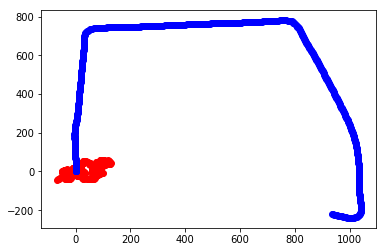

Count:2691
()
()
Relative Depth: 41.656996097400395
Relative x: -69.55595020805298
Relative Original Depth: 220.2207293504814
Relative Original x: 932.6558110185039
Count:2692
()
()
Relative Depth: 41.465760339778804
Relative x: -70.2381447286073
Relative Original Depth: 219.92486055548068
Relative Original x: 931.7006891507539
Count:2693
()
()
Relative Depth: 40.95008153096988
Relative x: -70.81178390423541
Relative Original Depth: 219.61462864823287
Relative Original x: 930.7507163059577
Count:2694
()
()
Relative Depth: 40.11094605941668
Relative x: -71.32840176929115
Relative Original Depth: 219.30673192050708
Relative Original x: 929.8000082425986
Count:2695
()
()
Relative Depth: 39.51428979505398
Relative x: -72.13016648726004
Relative Original Depth: 219.00470321316146
Relative Original x: 928.8471951871796


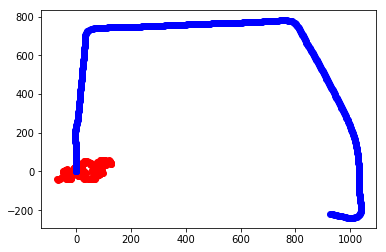

Count:2696
()
()
Relative Depth: 39.30718333107755
Relative x: -73.09590150200401
Relative Original Depth: 218.6993856696623
Relative Original x: 927.8957310276263
Count:2697
()
()
Relative Depth: 38.91061444114552
Relative x: -73.8456303082405
Relative Original Depth: 218.35566553048167
Relative Original x: 926.9580598738678
Count:2698
()
()
Relative Depth: 38.39314409790591
Relative x: -74.12668463323351
Relative Original Depth: 218.03980412606327
Relative Original x: 926.0095169059597
Count:2699
()
()
Relative Depth: 38.12345306666183
Relative x: -74.66319624210468
Relative Original Depth: 217.73858904990556
Relative Original x: 925.0570453807604
Count:2700
()
()
Relative Depth: 38.1463370812643
Relative x: -75.47189097856644
Relative Original Depth: 217.43790463396695
Relative Original x: 924.1045451776602


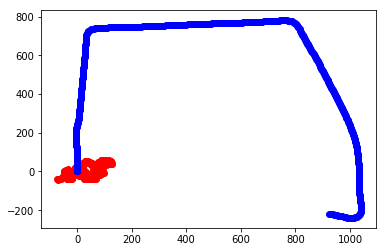

Count:2701
()
()
Relative Depth: 37.985531316939024
Relative x: -76.26690607370362
Relative Original Depth: 217.1186846757426
Relative Original x: 923.1573474322519
Count:2702
()
()
Relative Depth: 38.50726314775257
Relative x: -76.86550289293525
Relative Original Depth: 216.80329921866786
Relative Original x: 922.2090175383277
Count:2703
()
()
Relative Depth: 38.335098729173374
Relative x: -77.53057827150711
Relative Original Depth: 216.48837113985584
Relative Original x: 921.2602175975153
Count:2704
()
()
Relative Depth: 38.30130741781876
Relative x: -78.09048876549043
Relative Original Depth: 216.22959920704798
Relative Original x: 920.2950442254935
Count:2705
()
()
Relative Depth: 37.920138771441486
Relative x: -78.64658439211412
Relative Original Depth: 215.95059973712688
Relative Original x: 919.3359132284874


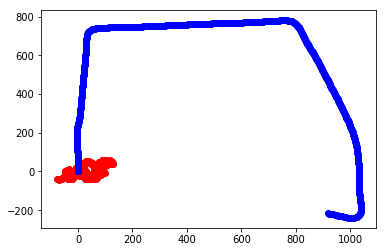

Count:2706
()
()
Relative Depth: 37.164243405663186
Relative x: -79.02711988634212
Relative Original Depth: 215.6420951832587
Relative Original x: 918.385794864173
Count:2707
()
()
Relative Depth: 38.0494373959162
Relative x: -79.08839005125917
Relative Original Depth: 215.34513803916028
Relative Original x: 917.4320633878194
Count:2708
()
()
Relative Depth: 37.465970661309264
Relative x: -79.46016641078924
Relative Original Depth: 215.0200376588308
Relative Original x: 916.4866470653885
Count:2709
()
()
Relative Depth: 37.50764826224465
Relative x: -79.68235520318768
Relative Original Depth: 214.7251830466508
Relative Original x: 915.5318652374173
Count:2710
()
()
Relative Depth: 37.839816716323575
Relative x: -79.63541280361169
Relative Original Depth: 214.41970683881127
Relative Original x: 914.5820904727283


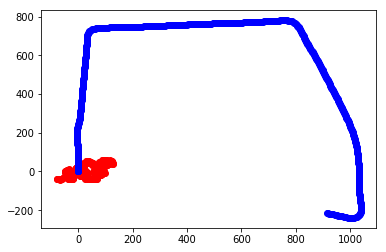

Count:2711
()
()
Relative Depth: 38.24413851547156
Relative x: -79.55644691848978
Relative Original Depth: 214.09003218447546
Relative Original x: 913.6382838656742
Count:2712
()
()
Relative Depth: 38.772076262799914
Relative x: -79.44568016604957
Relative Original Depth: 213.78023191440067
Relative Original x: 912.687647570585
Count:2713
()
()
Relative Depth: 38.96199454964498
Relative x: -79.2865119595775
Relative Original Depth: 213.4773627717118
Relative Original x: 911.7353775540298
Count:2714
()
()
Relative Depth: 38.70188280909819
Relative x: -79.18687393772666
Relative Original Depth: 213.17518754337553
Relative Original x: 910.7832291602056
Count:2715
()
()
Relative Depth: 38.49453248717755
Relative x: -79.15869535481256
Relative Original Depth: 212.870755475912
Relative Original x: 909.8307659025389


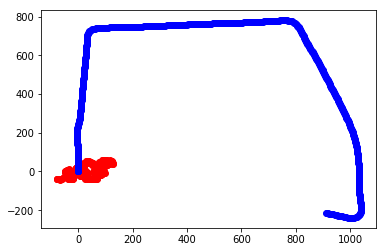

Count:2716
()
()
Relative Depth: 38.407586794687575
Relative x: -79.12720841042471
Relative Original Depth: 212.57708296140996
Relative Original x: 908.8750634470427
Count:2717
()
()
Relative Depth: 38.185214311812224
Relative x: -79.17101910463636
Relative Original Depth: 212.28052478042315
Relative Original x: 907.9208359974594
Count:2718
()
()
Relative Depth: 37.87792132074453
Relative x: -79.43964547585104
Relative Original Depth: 211.97045347057485
Relative Original x: 906.9712179735111
Count:2719
()
()
Relative Depth: 37.671997328186684
Relative x: -79.83913541142353
Relative Original Depth: 211.66066970960875
Relative Original x: 906.0212406044931
Count:2720
()
()
Relative Depth: 37.580358839639715
Relative x: -80.14449700787335
Relative Original Depth: 211.32489112127524
Relative Original x: 905.0796346328547


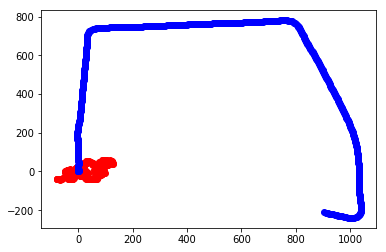

Count:2721
()
()
Relative Depth: 37.54485983731649
Relative x: -80.37533569456063
Relative Original Depth: 211.04196827045524
Relative Original x: 904.1209823444431
Count:2722
()
()
Relative Depth: 37.58562935779979
Relative x: -80.6201397424195
Relative Original Depth: 210.73948225228028
Relative Original x: 903.1683683638279
Count:2723
()
()
Relative Depth: 37.55139264689127
Relative x: -80.72580638405738
Relative Original Depth: 210.42731915974412
Relative Original x: 902.2192181049713
Count:2724
()
()
Relative Depth: 37.411087116835056
Relative x: -80.48842676898929
Relative Original Depth: 210.1245966404262
Relative Original x: 901.2672704683196
Count:2725
()
()
Relative Depth: 37.244967790226475
Relative x: -80.05237611645157
Relative Original Depth: 209.84851133354175
Relative Original x: 900.3069686850228


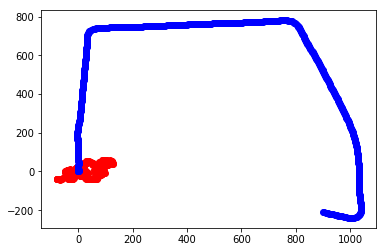

Count:2726
()
()
Relative Depth: 36.93720855499899
Relative x: -79.66957308949162
Relative Original Depth: 209.5567991921968
Relative Original x: 899.351883211549
Count:2727
()
()
Relative Depth: 36.2850776563699
Relative x: -78.97312512467715
Relative Original Depth: 209.2497144114195
Relative Original x: 898.40035747096
Count:2728
()
()
Relative Depth: 35.7978015352024
Relative x: -78.14577040785431
Relative Original Depth: 208.97186614312614
Relative Original x: 897.4402391303955
Count:2729
()
()
Relative Depth: 35.27677242686996
Relative x: -77.33159135488151
Relative Original Depth: 208.6839292310897
Relative Original x: 896.4837394253243
Count:2730
()
()
Relative Depth: 34.74917329854136
Relative x: -76.65182997351526
Relative Original Depth: 208.35505317144833
Relative Original x: 895.5396197442577


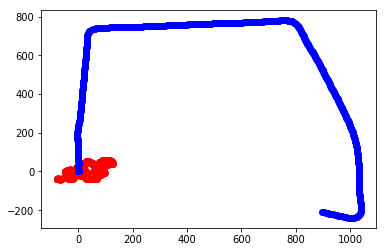

Count:2731
()
()
Relative Depth: 34.30230470458186
Relative x: -76.1711441558106
Relative Original Depth: 208.03596750810487
Relative Original x: 894.5923166694171
Count:2732
()
()
Relative Depth: 33.72593638667292
Relative x: -75.41598223148424
Relative Original Depth: 207.74658543967686
Relative Original x: 893.635640250581
Count:2733
()
()
Relative Depth: 32.80013793678075
Relative x: -75.77825164248681
Relative Original Depth: 207.44400098212523
Relative Original x: 892.6832836790481
Count:2734
()
()
Relative Depth: 32.13030290447209
Relative x: -75.04220117475025
Relative Original Depth: 207.15294337824238
Relative Original x: 891.7269579932147
Count:2735
()
()
Relative Depth: 32.09929792366697
Relative x: -74.04300062766902
Relative Original Depth: 206.85459183045947
Relative Original x: 890.7727317835012


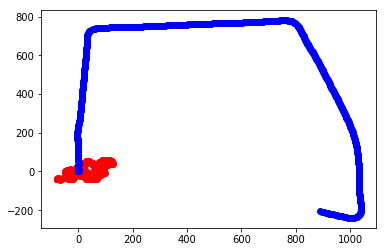

Count:2736
()
()
Relative Depth: 32.13892051929764
Relative x: -73.08735277835186
Relative Original Depth: 206.5780931969765
Relative Original x: 889.8117946862716
Count:2737
()
()
Relative Depth: 31.39213388391034
Relative x: -72.81782611425247
Relative Original Depth: 206.30249819770373
Relative Original x: 888.8510991399073
Count:2738
()
()
Relative Depth: 30.681934678956836
Relative x: -73.13635989009227
Relative Original Depth: 206.02327286320568
Relative Original x: 887.8913241351233
Count:2739
()
()
Relative Depth: 29.972661271608796
Relative x: -73.55443888264081
Relative Original Depth: 205.7334534168137
Relative Original x: 886.9366416587251
Count:2740
()
()
Relative Depth: 29.304593248250278
Relative x: -73.6901735617362
Relative Original Depth: 205.45633298194963
Relative Original x: 885.9761331295734


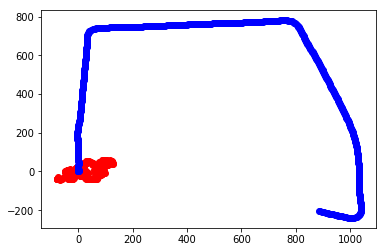

Count:2741
()
()
Relative Depth: 29.236628099850307
Relative x: -74.01676904504284
Relative Original Depth: 205.2018239854759
Relative Original x: 885.0093211103028
Count:2742
()
()
Relative Depth: 28.49232030785837
Relative x: -74.51012227714749
Relative Original Depth: 204.90130673271867
Relative Original x: 884.0556210651027
Count:2743
()
()
Relative Depth: 27.8934349323953
Relative x: -75.21282498802812
Relative Original Depth: 204.60913961400897
Relative Original x: 883.1016800081655
Count:2744
()
()
Relative Depth: 27.54963414075946
Relative x: -76.01312985450163
Relative Original Depth: 204.3220724219698
Relative Original x: 882.144631376349
Count:2745
()
()
Relative Depth: 27.354559692079754
Relative x: -76.93999422910488
Relative Original Depth: 204.06366458238463
Relative Original x: 881.1790180923047


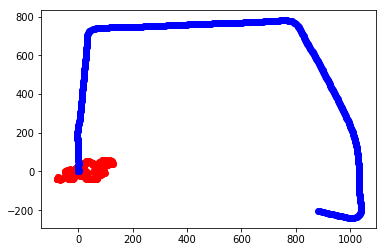

Count:2746
()
()
Relative Depth: 27.075111042301966
Relative x: -77.82049950964644
Relative Original Depth: 203.77236166349215
Relative Original x: 880.2233404840184
Count:2747
()
()
Relative Depth: 26.941828626219184
Relative x: -78.6977137851322
Relative Original Depth: 203.49261679049567
Relative Original x: 879.2640358472657
Count:2748
()
()
Relative Depth: 27.079142776663378
Relative x: -79.67898485788274
Relative Original Depth: 203.19389264973324
Relative Original x: 878.3106831993132
Count:2749
()
()
Relative Depth: 26.956025393043518
Relative x: -80.61681895802704
Relative Original Depth: 202.8998787315177
Relative Original x: 877.3553190368526
Count:2750
()
()
Relative Depth: 26.640569880388597
Relative x: -81.26003756294303
Relative Original Depth: 202.55442827882507
Relative Original x: 876.4173717812881


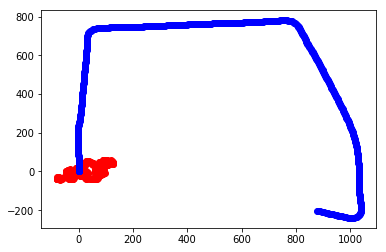

Count:2751
()
()
Relative Depth: 27.017387479103604
Relative x: -82.02051204070969
Relative Original Depth: 202.27036371307443
Relative Original x: 875.4587899504988
Count:2752
()
()
Relative Depth: 27.882343301183596
Relative x: -82.47833938566042
Relative Original Depth: 201.9978088573908
Relative Original x: 874.498209077343
Count:2753
()
()
Relative Depth: 28.83841616914754
Relative x: -82.58879202022774
Relative Original Depth: 201.69311170686956
Relative Original x: 873.5476176301814
Count:2754
()
()
Relative Depth: 29.770438868865277
Relative x: -82.36484707899305
Relative Original Depth: 201.43007604535677
Relative Original x: 872.5841943571581
Count:2755
()
()
Relative Depth: 30.68702208770722
Relative x: -82.12505317610234
Relative Original Depth: 201.14505021043615
Relative Original x: 871.6285120232634


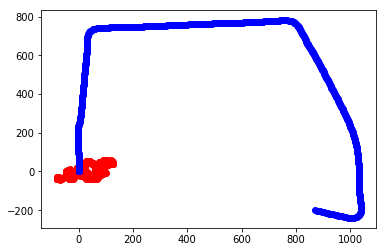

Count:2756
()
()
Relative Depth: 31.664016308118516
Relative x: -81.96812693985254
Relative Original Depth: 200.8390175550665
Relative Original x: 870.6765124834102
Count:2757
()
()
Relative Depth: 32.65663077367619
Relative x: -81.98439253038609
Relative Original Depth: 200.60202764814898
Relative Original x: 869.7062014013036
Count:2758
()
()
Relative Depth: 33.195903885511996
Relative x: -82.08944461252563
Relative Original Depth: 200.32883012855996
Relative Original x: 868.7459205300828
Count:2759
()
()
Relative Depth: 32.98893506958367
Relative x: -82.26311173374206
Relative Original Depth: 200.0810674586563
Relative Original x: 867.7771852831535
Count:2760
()
()
Relative Depth: 32.89039328666487
Relative x: -82.5518679328327
Relative Original Depth: 199.77967550271103
Relative Original x: 866.826614066168


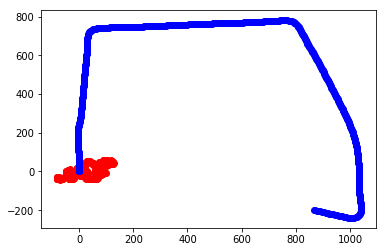

Count:2761
()
()
Relative Depth: 32.00703280655021
Relative x: -83.01061079591831
Relative Original Depth: 199.49073172470736
Relative Original x: 865.8713060705472
Count:2762
()
()
Relative Depth: 32.36333208187737
Relative x: -82.7811817886248
Relative Original Depth: 199.20041941736793
Relative Original x: 864.9155562994987
Count:2763
()
()
Relative Depth: 32.2434011061648
Relative x: -83.17464441323632
Relative Original Depth: 198.88434046023477
Relative Original x: 863.9681520186068
Count:2764
()
()
Relative Depth: 32.24154633180947
Relative x: -83.61320234243883
Relative Original Depth: 198.55388303857143
Relative Original x: 863.0245899011443
Count:2765
()
()
Relative Depth: 32.44056665412981
Relative x: -84.09829837971546
Relative Original Depth: 198.2843659950776
Relative Original x: 862.0623266482528


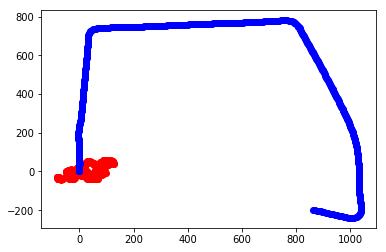

Count:2766
()
()
Relative Depth: 32.94410520502471
Relative x: -84.57873607310758
Relative Original Depth: 198.02684346532212
Relative Original x: 861.0964144729688
Count:2767
()
()
Relative Depth: 33.8668554369367
Relative x: -84.46365006369098
Relative Original Depth: 197.78196153923298
Relative Original x: 860.1272322227918
Count:2768
()
()
Relative Depth: 34.673715139185056
Relative x: -83.87290923334669
Relative Original Depth: 197.5196405604986
Relative Original x: 859.1623027382541
Count:2769
()
()
Relative Depth: 35.21205029916637
Relative x: -83.03150590102436
Relative Original Depth: 197.24524701317176
Relative Original x: 858.2006867151912
Count:2770
()
()
Relative Depth: 35.59974012832027
Relative x: -82.1249210808358
Relative Original Depth: 196.94389614467164
Relative Original x: 857.2471802233225


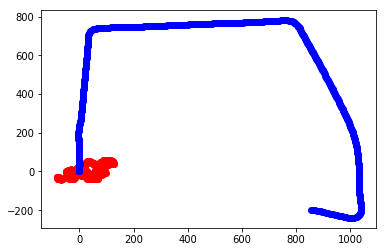

Count:2771
()
()
Relative Depth: 35.74689645655381
Relative x: -81.21889116376221
Relative Original Depth: 196.63876168090962
Relative Original x: 856.2949747573878
Count:2772
()
()
Relative Depth: 35.719932910634014
Relative x: -80.39922733470088
Relative Original Depth: 196.36832244290707
Relative Original x: 855.333298148301
Count:2773
()
()
Relative Depth: 36.070677133427985
Relative x: -79.4869223295693
Relative Original Depth: 196.06310920055395
Relative Original x: 854.3816227687889
Count:2774
()
()
Relative Depth: 36.98385858301537
Relative x: -79.59932948308257
Relative Original Depth: 195.6895118172457
Relative Original x: 853.4540484606446
Count:2775
()
()
Relative Depth: 37.434686555604046
Relative x: -78.73499111881647
Relative Original Depth: 195.3964348365105
Relative Original x: 852.498586964835


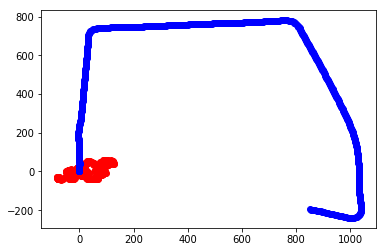

Count:2776
()
()
Relative Depth: 37.948993251714576
Relative x: -77.90554953291658
Relative Original Depth: 195.0745709936665
Relative Original x: 851.5518300480356
Count:2777
()
()
Relative Depth: 38.55269772918226
Relative x: -77.11993700640275
Relative Original Depth: 194.82101148625736
Relative Original x: 850.5847428445173
Count:2778
()
()
Relative Depth: 39.200975674170955
Relative x: -76.36173467207863
Relative Original Depth: 194.56159738939877
Relative Original x: 849.6193223275752
Count:2779
()
()
Relative Depth: 39.85719514386062
Relative x: -75.60716705150786
Relative Original Depth: 194.23839090829966
Relative Original x: 848.6733183376776
Count:2780
()
()
Relative Depth: 40.522836289261164
Relative x: -74.88909507287153
Relative Original Depth: 193.99026073351087
Relative Original x: 847.706132554733


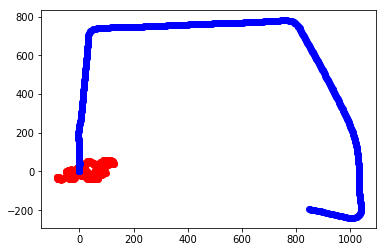

Count:2781
()
()
Relative Depth: 41.125732345298246
Relative x: -74.99069398724338
Relative Original Depth: 193.73535729997946
Relative Original x: 846.7401056894182
Count:2782
()
()
Relative Depth: 41.74425047369267
Relative x: -74.30135068801538
Relative Original Depth: 193.43447298981843
Relative Original x: 845.7873973583831
Count:2783
()
()
Relative Depth: 42.30749040892677
Relative x: -73.59746972557119
Relative Original Depth: 193.1966762424156
Relative Original x: 844.8162530483079
Count:2784
()
()
Relative Depth: 42.916666309642785
Relative x: -72.82067979815635
Relative Original Depth: 192.9159010208525
Relative Original x: 843.8622786770372
Count:2785
()
()
Relative Depth: 43.595946313452544
Relative x: -72.1615935553271
Relative Original Depth: 192.6200066328629
Relative Original x: 842.9088753653226


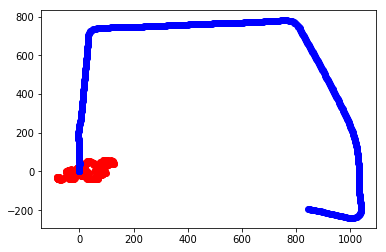

Count:2786
()
()
Relative Depth: 44.3326088527496
Relative x: -71.63683165848242
Relative Original Depth: 192.34665071775052
Relative Original x: 841.947337869724
Count:2787
()
()
Relative Depth: 45.23646463196323
Relative x: -71.33548646028416
Relative Original Depth: 192.09432405814937
Relative Original x: 840.9806565045698
Count:2788
()
()
Relative Depth: 46.214527682200114
Relative x: -71.51566112349342
Relative Original Depth: 191.94793751054755
Relative Original x: 839.9915152414718
Count:2789
()
()
Relative Depth: 47.150876909893206
Relative x: -71.83589947434113
Relative Original Depth: 191.68960259683848
Relative Original x: 839.0257460841414
Count:2790
()
()
Relative Depth: 48.0364908415968
Relative x: -71.98712327803291
Relative Original Depth: 191.45271314473607
Relative Original x: 838.0548508049457


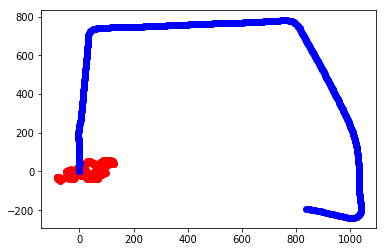

Count:2791
()
()
Relative Depth: 48.60625681727763
Relative x: -72.59984164290897
Relative Original Depth: 191.12540187742587
Relative Original x: 837.1117872134671
Count:2792
()
()
Relative Depth: 48.725300475895644
Relative x: -73.53107016422231
Relative Original Depth: 190.8672295827239
Relative Original x: 836.1464956104693
Count:2793
()
()
Relative Depth: 48.83660098547177
Relative x: -74.47799178588843
Relative Original Depth: 190.61951067281922
Relative Original x: 835.1800232030101
Count:2794
()
()
Relative Depth: 48.96614616639974
Relative x: -75.3837745955075
Relative Original Depth: 190.36491722047657
Relative Original x: 834.2148943060739
Count:2795
()
()
Relative Depth: 49.10621830916345
Relative x: -76.19433017609539
Relative Original Depth: 190.08369837465926
Relative Original x: 833.2560956284188


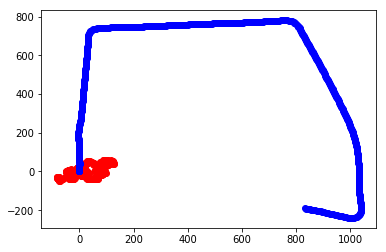

Count:2796
()
()
Relative Depth: 49.39519447203442
Relative x: -76.85425857779155
Relative Original Depth: 189.7902913469542
Relative Original x: 832.302257883588
Count:2797
()
()
Relative Depth: 49.118926499327216
Relative x: -76.14856588937167
Relative Original Depth: 189.545993360103
Relative Original x: 831.3336175212297
Count:2798
()
()
Relative Depth: 49.445300449001415
Relative x: -76.76216732069875
Relative Original Depth: 189.28025820656345
Relative Original x: 830.3719177232414
Count:2799
()
()
Relative Depth: 49.90715435693151
Relative x: -77.46957355829512
Relative Original Depth: 189.03527810978608
Relative Original x: 829.4031662707837
Count:2800
()
()
Relative Depth: 50.48044211100026
Relative x: -78.18330660906962
Relative Original Depth: 188.79633233251494
Relative Original x: 828.4326242720133


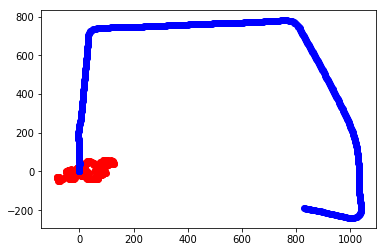

Count:2801
()
()
Relative Depth: 50.70855665861128
Relative x: -78.9008558022064
Relative Original Depth: 188.60927284933894
Relative Original x: 827.4503171515641
Count:2802
()
()
Relative Depth: 50.59219269410506
Relative x: -79.3278129007699
Relative Original Depth: 188.3595500384965
Relative Original x: 826.4820051879589
Count:2803
()
()
Relative Depth: 50.333490109984766
Relative x: -79.36461403670903
Relative Original Depth: 188.09898068525249
Relative Original x: 825.51795691789
Count:2804
()
()
Relative Depth: 49.89801484562426
Relative x: -78.98762362784714
Relative Original Depth: 187.88258909702716
Relative Original x: 824.5427186747223
Count:2805
()
()
Relative Depth: 49.44634781695892
Relative x: -78.40953201578132
Relative Original Depth: 187.59223205049437
Relative Original x: 823.586953016849


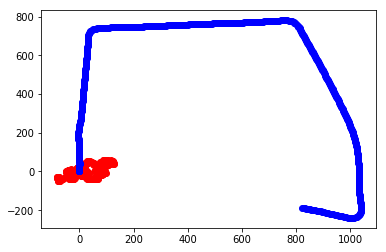

Count:2806
()
()
Relative Depth: 48.9575465442202
Relative x: -77.85670504789047
Relative Original Depth: 187.34898325965563
Relative Original x: 822.6175764295158
Count:2807
()
()
Relative Depth: 48.367944037239894
Relative x: -77.40717311801791
Relative Original Depth: 187.02340237099477
Relative Original x: 821.6727544914575
Count:2808
()
()
Relative Depth: 47.6945060006603
Relative x: -76.822669301306
Relative Original Depth: 186.6900670810896
Relative Original x: 820.7303483086923
Count:2809
()
()
Relative Depth: 46.860384841029386
Relative x: -76.28745525777954
Relative Original Depth: 186.47098041868495
Relative Original x: 819.7552554724267
Count:2810
()
()
Relative Depth: 45.97692279064007
Relative x: -75.92157489186214
Relative Original Depth: 186.23636308106106
Relative Original x: 818.7847038609981


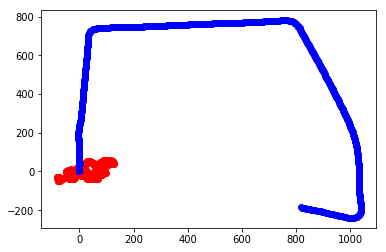

Count:2811
()
()
Relative Depth: 45.083751922662415
Relative x: -75.47404029207533
Relative Original Depth: 186.07317712317672
Relative Original x: 817.798130060706
Count:2812
()
()
Relative Depth: 44.38439071518542
Relative x: -74.9373166151318
Relative Original Depth: 185.8208122986699
Relative Original x: 816.8318164375107
Count:2813
()
()
Relative Depth: 43.74806415269934
Relative x: -74.28413303430317
Relative Original Depth: 185.54613957078786
Relative Original x: 815.8706197443884
Count:2814
()
()
Relative Depth: 42.90376927012124
Relative x: -73.78936260541893
Relative Original Depth: 185.23574821704437
Relative Original x: 814.9205154934414
Count:2815
()
()
Relative Depth: 41.97885101763001
Relative x: -73.41202131315471
Relative Original Depth: 184.94286749236062
Relative Original x: 813.9662761400314


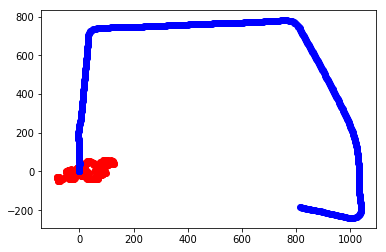

Count:2816
()
()
Relative Depth: 41.183162169563325
Relative x: -72.85502080139297
Relative Original Depth: 184.68166693541755
Relative Original x: 813.0011997362952
Count:2817
()
()
Relative Depth: 40.488032601670255
Relative x: -72.23603947803946
Relative Original Depth: 184.43449911310373
Relative Original x: 812.0325491339487
Count:2818
()
()
Relative Depth: 40.00253479325422
Relative x: -72.04622562959966
Relative Original Depth: 184.22273910921348
Relative Original x: 811.0552936223612
Count:2819
()
()
Relative Depth: 40.22796904263542
Relative x: -72.44522355724035
Relative Original Depth: 183.97028627782663
Relative Original x: 810.08852104319
Count:2820
()
()
Relative Depth: 40.534911457921226
Relative x: -71.72675457337048
Relative Original Depth: 183.83340084631274
Relative Original x: 809.0979403363948


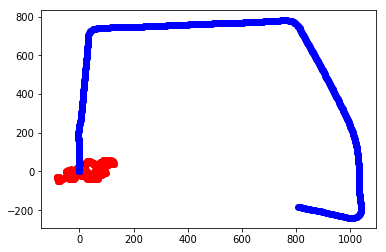

Count:2821
()
()
Relative Depth: 41.053222568236414
Relative x: -72.16420164774244
Relative Original Depth: 183.62243770166273
Relative Original x: 808.1207755492743
Count:2822
()
()
Relative Depth: 41.259913820864156
Relative x: -72.72735160765869
Relative Original Depth: 183.33937108555926
Relative Original x: 807.1623409254274
Count:2823
()
()
Relative Depth: 40.472856999149876
Relative x: -72.13014706548839
Relative Original Depth: 183.12166517518472
Relative Original x: 806.1867955005026
Count:2824
()
()
Relative Depth: 39.534845751713874
Relative x: -72.37900284946888
Relative Original Depth: 182.84913356301203
Relative Original x: 805.2258873103482
Count:2825
()
()
Relative Depth: 39.57415652566407
Relative x: -72.9901741405883
Relative Original Depth: 182.58096429831525
Relative Original x: 804.2626559200196


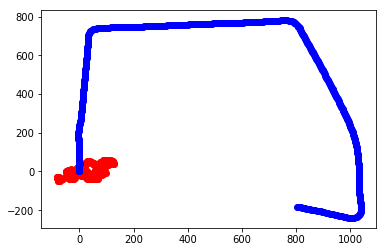

Count:2826
()
()
Relative Depth: 40.15383562838822
Relative x: -73.53065314840114
Relative Original Depth: 182.33079599496756
Relative Original x: 803.2948165642433
Count:2827
()
()
Relative Depth: 41.0564707440805
Relative x: -73.87275838551834
Relative Original Depth: 182.09251401908637
Relative Original x: 802.3242239784215
Count:2828
()
()
Relative Depth: 41.93269106708319
Relative x: -74.10228298394058
Relative Original Depth: 181.87131110431537
Relative Original x: 801.3493084243254
Count:2829
()
()
Relative Depth: 42.436789885350386
Relative x: -74.32693392508212
Relative Original Depth: 181.5763355034643
Relative Original x: 800.3940495714218
Count:2830
()
()
Relative Depth: 42.87008649431115
Relative x: -74.72278491365051
Relative Original Depth: 181.2910077486073
Relative Original x: 799.4374212207625


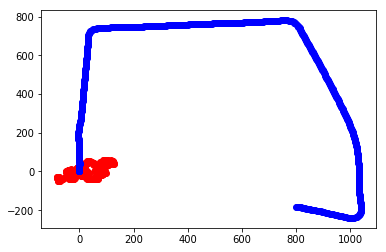

Count:2831
()
()
Relative Depth: 43.1570234606962
Relative x: -75.10811526897027
Relative Original Depth: 181.04144350231513
Relative Original x: 798.4697682917209
Count:2832
()
()
Relative Depth: 43.40416951843279
Relative x: -75.18807596946233
Relative Original Depth: 180.85931860286226
Relative Original x: 797.4894092160037
Count:2833
()
()
Relative Depth: 43.68564484457984
Relative x: -75.04708784056218
Relative Original Depth: 180.61513041680786
Relative Original x: 796.5200813145611
Count:2834
()
()
Relative Depth: 44.2882809718052
Relative x: -75.22394549490713
Relative Original Depth: 180.35863420502253
Relative Original x: 795.5538386160393
Count:2835
()
()
Relative Depth: 45.02126251684356
Relative x: -75.74589627437024
Relative Original Depth: 180.1338543103086
Relative Original x: 794.5797729932336


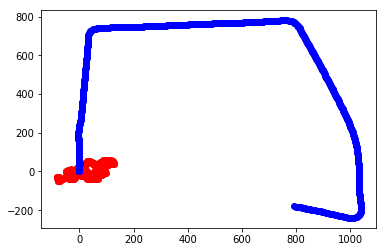

Count:2836
()
()
Relative Depth: 45.43748115777935
Relative x: -76.3818920343217
Relative Original Depth: 179.90655856445775
Relative Original x: 793.6060054530773
Count:2837
()
()
Relative Depth: 45.64950807027545
Relative x: -76.49368213936056
Relative Original Depth: 179.6478145624161
Relative Original x: 792.6402383802458
Count:2838
()
()
Relative Depth: 45.84162096846529
Relative x: -75.74058653773852
Relative Original Depth: 179.40557820172006
Relative Original x: 791.6707088547931
Count:2839
()
()
Relative Depth: 45.88424491754817
Relative x: -74.80637318647325
Relative Original Depth: 179.24015996901872
Relative Original x: 790.6848890278175
Count:2840
()
()
Relative Depth: 45.91754339644215
Relative x: -73.92482152137435
Relative Original Depth: 179.04176980167665
Relative Original x: 789.7053656937653


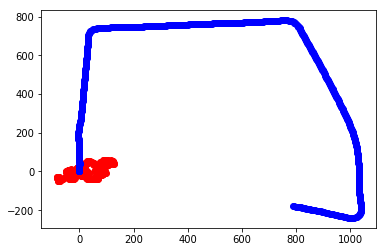

Count:2841
()
()
Relative Depth: 46.00386206832827
Relative x: -73.12919783830706
Relative Original Depth: 178.7846405590452
Relative Original x: 788.7390812060667
Count:2842
()
()
Relative Depth: 46.10906546438682
Relative x: -72.36126046750348
Relative Original Depth: 178.5731494757564
Relative Original x: 787.762430243652
Count:2843
()
()
Relative Depth: 46.15838753893508
Relative x: -71.561501322263
Relative Original Depth: 178.3531835171889
Relative Original x: 786.7883224053105
Count:2844
()
()
Relative Depth: 45.99732047476391
Relative x: -70.8699043906096
Relative Original Depth: 178.12189515990875
Relative Original x: 785.8166266657216
Count:2845
()
()
Relative Depth: 45.79070255175735
Relative x: -70.28448094187232
Relative Original Depth: 177.88720702818142
Relative Original x: 784.8467121777976


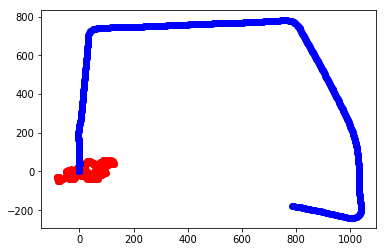

Count:2846
()
()
Relative Depth: 45.690904865164285
Relative x: -69.77925174054242
Relative Original Depth: 177.6301536629517
Relative Original x: 783.8806851010474
Count:2847
()
()
Relative Depth: 45.56600420019595
Relative x: -69.37809550678757
Relative Original Depth: 177.40847210780336
Relative Original x: 782.9060183525323
Count:2848
()
()
Relative Depth: 45.57923566815673
Relative x: -69.08882934372862
Relative Original Depth: 177.1861307047042
Relative Original x: 781.9319140762143
Count:2849
()
()
Relative Depth: 45.724848575285996
Relative x: -68.91162626534306
Relative Original Depth: 176.95823842491328
Relative Original x: 780.9587758575207
Count:2850
()
()
Relative Depth: 45.88571412342891
Relative x: -68.78128051307733
Relative Original Depth: 176.68626647259387
Relative Original x: 779.9965940851836


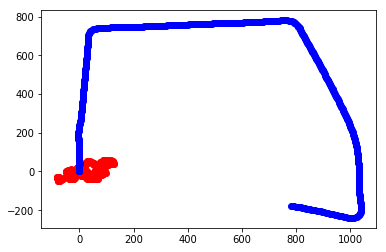

Count:2851
()
()
Relative Depth: 46.06124925078697
Relative x: -68.69026778092882
Relative Original Depth: 176.42962686977333
Relative Original x: 779.0305262864008
Count:2852
()
()
Relative Depth: 46.16114323172844
Relative x: -68.78128348521065
Relative Original Depth: 176.21364205376574
Relative Original x: 778.0546603468669
Count:2853
()
()
Relative Depth: 46.1752186970318
Relative x: -69.06004048925331
Relative Original Depth: 176.00434502080608
Relative Original x: 777.0770638951816
Count:2854
()
()
Relative Depth: 46.18503776405433
Relative x: -69.21926996760307
Relative Original Depth: 175.7668377164569
Relative Original x: 776.1058445817838
Count:2855
()
()
Relative Depth: 46.19245575275959
Relative x: -69.08954511531674
Relative Original Depth: 175.54441633379255
Relative Original x: 775.1309683398633


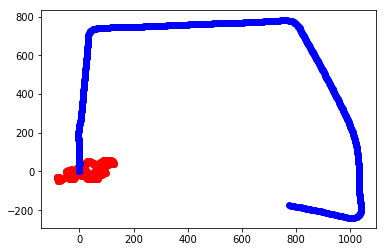

Count:2856
()
()
Relative Depth: 46.095706281552
Relative x: -68.64586958033581
Relative Original Depth: 175.32702663743913
Relative Original x: 774.1551594597906
Count:2857
()
()
Relative Depth: 45.89793767254849
Relative x: -68.13672185061806
Relative Original Depth: 175.09454150915886
Relative Original x: 773.1829026954476
Count:2858
()
()
Relative Depth: 45.62204190460412
Relative x: -68.7399496511263
Relative Original Depth: 174.89153822361132
Relative Original x: 772.2042905435746
Count:2859
()
()
Relative Depth: 45.446280616205335
Relative x: -68.54318993934638
Relative Original Depth: 174.67451910819125
Relative Original x: 771.2287188943848
Count:2860
()
()
Relative Depth: 45.26988937652052
Relative x: -68.73232126111463
Relative Original Depth: 174.48632954686767
Relative Original x: 770.2477327181331


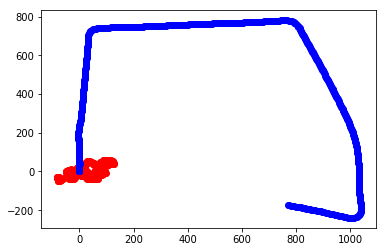

Count:2861
()
()
Relative Depth: 45.07756304065548
Relative x: -68.86257864716353
Relative Original Depth: 174.23928043907804
Relative Original x: 769.2795971748853
Count:2862
()
()
Relative Depth: 44.90463998828247
Relative x: -68.83044111353112
Relative Original Depth: 174.019843913422
Relative Original x: 768.3047019648405
Count:2863
()
()
Relative Depth: 44.895725527109875
Relative x: -68.7016264471662
Relative Original Depth: 173.78736206419458
Relative Original x: 767.3334968682534
Count:2864
()
()
Relative Depth: 45.06992854962536
Relative x: -68.48432631862576
Relative Original Depth: 173.56255862438206
Relative Original x: 766.3603899532236
Count:2865
()
()
Relative Depth: 45.23147724681265
Relative x: -68.0728497242334
Relative Original Depth: 173.34975270947527
Relative Original x: 765.3838150959939


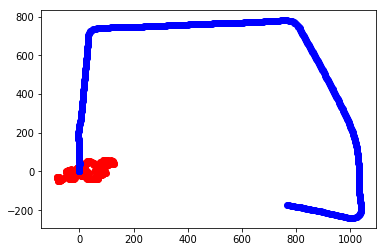

Count:2866
()
()
Relative Depth: 45.37070090542639
Relative x: -67.42606051168742
Relative Original Depth: 173.08281788456833
Relative Original x: 764.4201515324968
Count:2867
()
()
Relative Depth: 45.4265354142921
Relative x: -66.77834200425856
Relative Original Depth: 172.83798877516088
Relative Original x: 763.4507599165014
Count:2868
()
()
Relative Depth: 45.35458393587083
Relative x: -66.13408322337267
Relative Original Depth: 172.59830358565884
Relative Original x: 762.480104373693
Count:2869
()
()
Relative Depth: 45.27951796987985
Relative x: -65.47683583119776
Relative Original Depth: 172.36470141245363
Relative Original x: 761.5082346528832
Count:2870
()
()
Relative Depth: 45.23898046126477
Relative x: -64.80850366859117
Relative Original Depth: 172.1962402992895
Relative Original x: 760.5250054509605


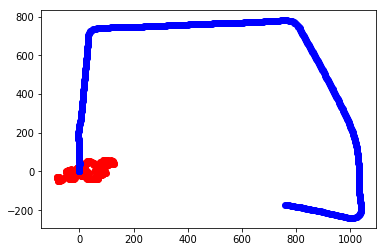

Count:2871
()
()
Relative Depth: 45.32552950980993
Relative x: -63.947217650173535
Relative Original Depth: 171.9718782716936
Relative Original x: 759.5506215987363
Count:2872
()
()
Relative Depth: 45.48672721987048
Relative x: -62.99415279608112
Relative Original Depth: 171.73519238923575
Relative Original x: 758.5792532948499
Count:2873
()
()
Relative Depth: 45.52176298539015
Relative x: -61.99482244318406
Relative Original Depth: 171.4927031170898
Relative Original x: 757.6094019997607
Count:2874
()
()
Relative Depth: 45.44915588968405
Relative x: -61.02788218885305
Relative Original Depth: 171.263485310932
Relative Original x: 756.6366536864028
Count:2875
()
()
Relative Depth: 45.374217265623855
Relative x: -60.08327303268206
Relative Original Depth: 171.06592485357822
Relative Original x: 755.6567203311218


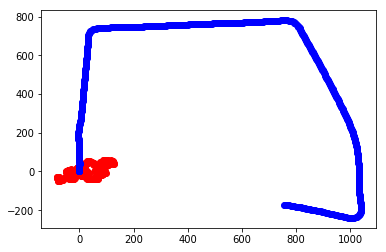

Count:2876
()
()
Relative Depth: 44.746449670051184
Relative x: -59.41165019291623
Relative Original Depth: 170.869772012983
Relative Original x: 754.6768265103807
Count:2877
()
()
Relative Depth: 44.70196398159724
Relative x: -58.48638938396451
Relative Original Depth: 170.66166662785102
Relative Original x: 753.7006026719714
Count:2878
()
()
Relative Depth: 44.55198368096255
Relative x: -57.575917765150066
Relative Original Depth: 170.44958594936753
Relative Original x: 752.7248580218217
Count:2879
()
()
Relative Depth: 44.235360238452884
Relative x: -56.73568191463316
Relative Original Depth: 170.1888952442379
Relative Original x: 751.7594479442258
Count:2880
()
()
Relative Depth: 44.00573850782122
Relative x: -56.114187797739504
Relative Original Depth: 170.04872035959556
Relative Original x: 750.7703510528943


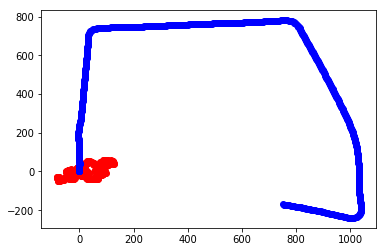

Count:2881
()
()
Relative Depth: 43.25678401161315
Relative x: -55.96190609790025
Relative Original Depth: 169.85381900355833
Relative Original x: 749.7906579057626
Count:2882
()
()
Relative Depth: 42.3926370669635
Relative x: -55.85514727973911
Relative Original Depth: 169.66072577958894
Relative Original x: 748.8110629597929
Count:2883
()
()
Relative Depth: 41.899298769536735
Relative x: -55.51985812015685
Relative Original Depth: 169.46240608930123
Relative Original x: 747.8314858816716
Count:2884
()
()
Relative Depth: 41.45078491534476
Relative x: -55.25664349052074
Relative Original Depth: 169.25931504706097
Relative Original x: 746.8526267747573
Count:2885
()
()
Relative Depth: 41.07097379258145
Relative x: -54.82775089644732
Relative Original Depth: 169.0531955531198
Relative Original x: 745.8747855956789


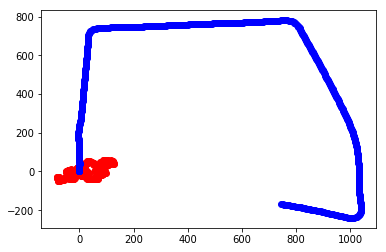

Count:2886
()
()
Relative Depth: 40.5675934628704
Relative x: -54.48788834260122
Relative Original Depth: 168.78477836573285
Relative Original x: 744.912569937429
Count:2887
()
()
Relative Depth: 39.88282064198641
Relative x: -54.362268940629725
Relative Original Depth: 168.645860827076
Relative Original x: 743.9231643646618
Count:2888
()
()
Relative Depth: 39.080786519883475
Relative x: -54.330591117704316
Relative Original Depth: 168.46068353772128
Relative Original x: 742.9406311253749
Count:2889
()
()
Relative Depth: 39.42102062175692
Relative x: -55.03120942045952
Relative Original Depth: 168.14767703473416
Relative Original x: 741.9908894810698
Count:2890
()
()
Relative Depth: 38.87773452301804
Relative x: -55.856914775020165
Relative Original Depth: 167.9376507345522
Relative Original x: 741.0132913031947


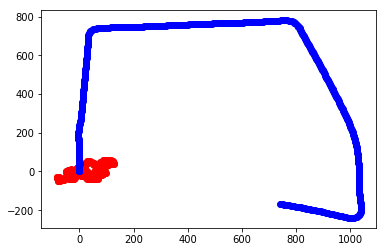

Count:2891
()
()
Relative Depth: 38.697019424016915
Relative x: -55.94582628474747
Relative Original Depth: 167.70714875086978
Relative Original x: 740.0412517169367
Count:2892
()
()
Relative Depth: 37.968460453689865
Relative x: -56.3622904416124
Relative Original Depth: 167.5429590292063
Relative Original x: 739.0567837161778
Count:2893
()
()
Relative Depth: 37.511217411553154
Relative x: -57.01078397266344
Relative Original Depth: 167.35397307278276
Relative Original x: 738.07534318511
Count:2894
()
()
Relative Depth: 36.91752586529607
Relative x: -57.54042178156867
Relative Original Depth: 167.10222710519025
Relative Original x: 737.1082718662531
Count:2895
()
()
Relative Depth: 36.28068778449128
Relative x: -58.15197761884209
Relative Original Depth: 166.90667341231426
Relative Original x: 736.1289978788244


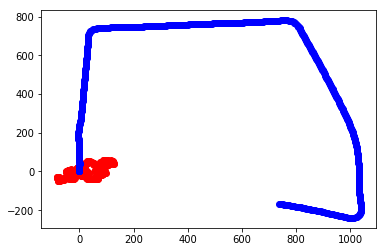

Count:2896
()
()
Relative Depth: 35.34534227208561
Relative x: -57.903664050485595
Relative Original Depth: 166.64660028551467
Relative Original x: 735.1641136448438
Count:2897
()
()
Relative Depth: 34.68134493669009
Relative x: -58.56862313768694
Relative Original Depth: 166.39459131533914
Relative Original x: 734.1964536638848
Count:2898
()
()
Relative Depth: 34.09512485987196
Relative x: -59.31200291110296
Relative Original Depth: 166.17368123388857
Relative Original x: 733.2212435700994
Count:2899
()
()
Relative Depth: 33.67119778167417
Relative x: -60.19696465955829
Relative Original Depth: 165.93333605003997
Relative Original x: 732.2510870303063
Count:2900
()
()
Relative Depth: 33.41185807563054
Relative x: -61.16268396514209
Relative Original Depth: 165.75104173983848
Relative Original x: 731.2687584219756


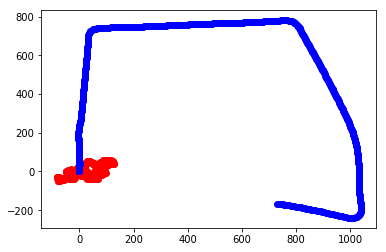

Count:2901
()
()
Relative Depth: 33.13320623206176
Relative x: -62.11280652655015
Relative Original Depth: 165.58239790932353
Relative Original x: 730.2838342809569
Count:2902
()
()
Relative Depth: 32.83622549856
Relative x: -63.03511569587874
Relative Original Depth: 165.36481298895242
Relative Original x: 729.3083216966298
Count:2903
()
()
Relative Depth: 32.27278032708885
Relative x: -63.77282367352071
Relative Original Depth: 165.2553821623798
Relative Original x: 728.3157834629089
Count:2904
()
()
Relative Depth: 31.78633243890352
Relative x: -64.32031339725958
Relative Original Depth: 165.0531064154998
Relative Original x: 727.3371919131757
Count:2905
()
()
Relative Depth: 31.62099735740226
Relative x: -64.8839165541864
Relative Original Depth: 164.85663897415733
Relative Original x: 726.357291790201


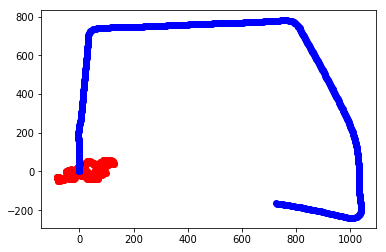

Count:2906
()
()
Relative Depth: 31.41643718474699
Relative x: -65.25496067233021
Relative Original Depth: 164.68444374058063
Relative Original x: 725.3735169500422
Count:2907
()
()
Relative Depth: 31.225601818863662
Relative x: -65.64817931303106
Relative Original Depth: 164.4995043496175
Relative Original x: 724.3911351513932
Count:2908
()
()
Relative Depth: 31.248611403712143
Relative x: -65.84944998542719
Relative Original Depth: 164.3141416088719
Relative Original x: 723.4085652024442
Count:2909
()
()
Relative Depth: 31.37978020168915
Relative x: -65.84042087628714
Relative Original Depth: 164.06916901999605
Relative Original x: 722.4396970348243
Count:2910
()
()
Relative Depth: 31.340470008274377
Relative x: -66.14265164474244
Relative Original Depth: 163.84272838667363
Relative Original x: 721.465955567965


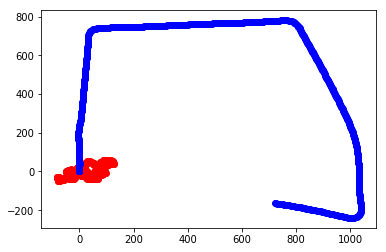

Count:2911
()
()
Relative Depth: 31.244600785894534
Relative x: -66.53479148403642
Relative Original Depth: 163.67638407365683
Relative Original x: 720.4802360751751
Count:2912
()
()
Relative Depth: 31.09814312233952
Relative x: -66.78878810744062
Relative Original Depth: 163.47923239124916
Relative Original x: 719.4999325965597
Count:2913
()
()
Relative Depth: 30.66055719164328
Relative x: -67.10426888333009
Relative Original Depth: 163.3029673358358
Relative Original x: 718.5157647367779
Count:2914
()
()
Relative Depth: 30.064487894705376
Relative x: -67.50611919643029
Relative Original Depth: 163.1124869922657
Relative Original x: 717.5344506119404
Count:2915
()
()
Relative Depth: 29.60922995026492
Relative x: -67.6856754175513
Relative Original Depth: 162.94087993368458
Relative Original x: 716.5503052090888


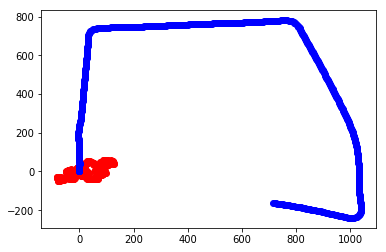

Count:2916
()
()
Relative Depth: 29.235036291587665
Relative x: -67.55382465228443
Relative Original Depth: 162.771306916828
Relative Original x: 715.5648409072481
Count:2917
()
()
Relative Depth: 29.144108653470592
Relative x: -66.94967885565627
Relative Original Depth: 162.60143020989563
Relative Original x: 714.580285259789
Count:2918
()
()
Relative Depth: 28.65096554347179
Relative x: -67.14470943863037
Relative Original Depth: 162.4501936550233
Relative Original x: 713.5940173357537
Count:2919
()
()
Relative Depth: 28.399441080700786
Relative x: -66.66493843441013
Relative Original Depth: 162.2941176058676
Relative Original x: 712.6074303839575
Count:2920
()
()
Relative Depth: 28.080199593786823
Relative x: -66.48401841030696
Relative Original Depth: 162.06055944828262
Relative Original x: 711.6366662240382


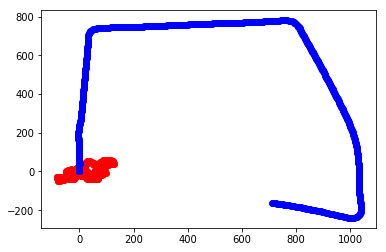

Count:2921
()
()
Relative Depth: 27.740099572434673
Relative x: -67.42440687450497
Relative Original Depth: 161.83774408241538
Relative Original x: 710.6622207988631
Count:2922
()
()
Relative Depth: 27.512499399922948
Relative x: -66.96933988668748
Relative Original Depth: 161.68543276622117
Relative Original x: 709.6739107510723
Count:2923
()
()
Relative Depth: 27.449466025751295
Relative x: -66.65163997953569
Relative Original Depth: 161.5146645458914
Relative Original x: 708.689217479898
Count:2924
()
()
Relative Depth: 27.50607076396763
Relative x: -66.5208305465324
Relative Original Depth: 161.3564777212795
Relative Original x: 707.7018318417565
Count:2925
()
()
Relative Depth: 27.575120875929695
Relative x: -66.45210323437468
Relative Original Depth: 161.19531190988656
Relative Original x: 706.7150479639064


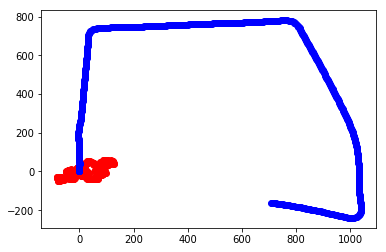

Count:2926
()
()
Relative Depth: 27.483815800530184
Relative x: -66.16605427836029
Relative Original Depth: 161.02589262676602
Relative Original x: 705.729554481512
Count:2927
()
()
Relative Depth: 27.24954377698341
Relative x: -65.92851087140798
Relative Original Depth: 160.86314398017598
Relative Original x: 704.7430150163833
Count:2928
()
()
Relative Depth: 26.362063335633458
Relative x: -66.25931617624258
Relative Original Depth: 160.6761657607747
Relative Original x: 703.761643740148
Count:2929
()
()
Relative Depth: 26.389149818607173
Relative x: -66.73658608399727
Relative Original Depth: 160.5079467241737
Relative Original x: 702.776449886657
Count:2930
()
()
Relative Depth: 26.76278577949199
Relative x: -67.4908048528914
Relative Original Depth: 160.32390312061108
Relative Original x: 701.7952925943249


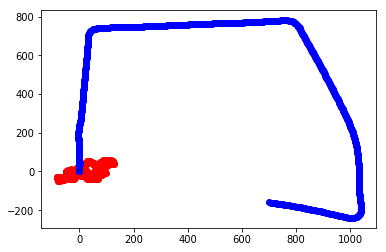

Count:2931
()
()
Relative Depth: 27.225237188467936
Relative x: -68.28368967835853
Relative Original Depth: 160.1172191288125
Relative Original x: 700.8177363396896
Count:2932
()
()
Relative Depth: 27.664710783526697
Relative x: -69.14621769329975
Relative Original Depth: 159.948632150445
Relative Original x: 699.832537170979
Count:2933
()
()
Relative Depth: 27.931117928545344
Relative x: -70.05733164554691
Relative Original Depth: 159.78120508536705
Relative Original x: 698.8471472149674
Count:2934
()
()
Relative Depth: 27.87992644882734
Relative x: -70.85774109148007
Relative Original Depth: 159.609561544997
Relative Original x: 697.8620109278444
Count:2935
()
()
Relative Depth: 27.9468101378715
Relative x: -71.68707231062376
Relative Original Depth: 159.41579594229253
Relative Original x: 696.8816277227884


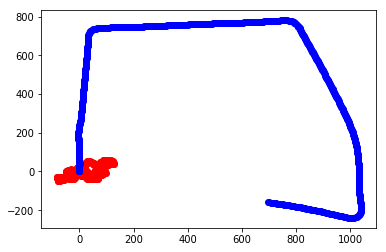

Count:2936
()
()
Relative Depth: 27.96299687443846
Relative x: -70.85393988479643
Relative Original Depth: 159.23852691592273
Relative Original x: 695.8976686885057
Count:2937
()
()
Relative Depth: 28.38488003948394
Relative x: -71.67926389521305
Relative Original Depth: 159.05363505731697
Relative Original x: 694.9149779451654
Count:2938
()
()
Relative Depth: 28.757862292179492
Relative x: -72.58074636914833
Relative Original Depth: 158.88143807631607
Relative Original x: 693.9299933176796
Count:2939
()
()
Relative Depth: 28.9530341281614
Relative x: -73.02560193761998
Relative Original Depth: 158.7314227916662
Relative Original x: 692.9416691368057
Count:2940
()
()
Relative Depth: 29.242150148617238
Relative x: -73.9058386325702
Relative Original Depth: 158.55394583189042
Relative Original x: 691.9578952039686


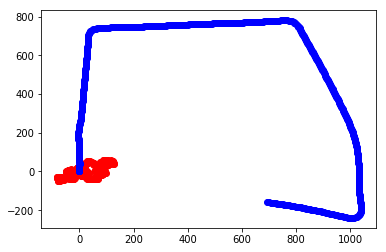

Count:2941
()
()
Relative Depth: 28.398478701978398
Relative x: -73.48714209319608
Relative Original Depth: 158.38017200523234
Relative Original x: 690.974403800165
Count:2942
()
()
Relative Depth: 28.795609428651844
Relative x: -73.68510030601422
Relative Original Depth: 158.20462153712148
Relative Original x: 689.9926033814528
Count:2943
()
()
Relative Depth: 28.698380236551422
Relative x: -73.34881396473111
Relative Original Depth: 158.03552370951527
Relative Original x: 689.0105622056434
Count:2944
()
()
Relative Depth: 28.288402157311204
Relative x: -73.35007908938448
Relative Original Depth: 157.861496352786
Relative Original x: 688.0264962253669
Count:2945
()
()
Relative Depth: 27.743392802814814
Relative x: -73.30015146008962
Relative Original Depth: 157.65737060614538
Relative Original x: 687.0477425544223


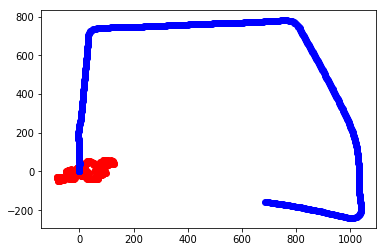

Count:2946
()
()
Relative Depth: 27.068539146415414
Relative x: -73.2090082623609
Relative Original Depth: 157.45178532235877
Relative Original x: 686.0696156369647
Count:2947
()
()
Relative Depth: 26.456499340731614
Relative x: -73.12006810654628
Relative Original Depth: 157.2610446090058
Relative Original x: 685.0880544530302
Count:2948
()
()
Relative Depth: 26.462849324889714
Relative x: -72.27098677256551
Relative Original Depth: 157.02533063675432
Relative Original x: 684.1163934397435
Count:2949
()
()
Relative Depth: 25.975516262232333
Relative x: -72.11153761340591
Relative Original Depth: 156.87520519609623
Relative Original x: 683.1282009181724
Count:2950
()
()
Relative Depth: 25.52166245719954
Relative x: -71.88909186706489
Relative Original Depth: 156.69249902374543
Relative Original x: 682.145236395157


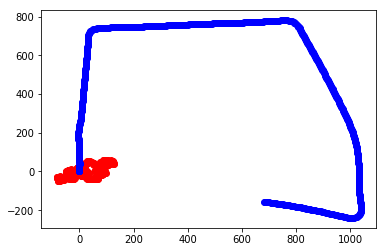

Count:2951
()
()
Relative Depth: 25.160129727116605
Relative x: -71.6561449739987
Relative Original Depth: 156.49605584916225
Relative Original x: 681.164983067192
Count:2952
()
()
Relative Depth: 24.722664034062632
Relative x: -71.40840756684989
Relative Original Depth: 156.25884655837868
Relative Original x: 680.195377508327
Count:2953
()
()
Relative Depth: 24.144482109440894
Relative x: -71.12185888023892
Relative Original Depth: 156.0840505814071
Relative Original x: 679.2113888185803
Count:2954
()
()
Relative Depth: 23.58622497170071
Relative x: -70.83708545869806
Relative Original Depth: 155.91614763916292
Relative Original x: 678.2264411038606
Count:2955
()
()
Relative Depth: 23.01090432089894
Relative x: -70.59155307909337
Relative Original Depth: 155.7700512249324
Relative Original x: 677.23741857988


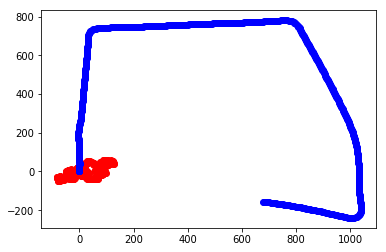

Count:2956
()
()
Relative Depth: 22.37864675206727
Relative x: -70.28338467296119
Relative Original Depth: 155.60544848677222
Relative Original x: 676.2510645378577
Count:2957
()
()
Relative Depth: 21.957915505614285
Relative x: -70.1954099158771
Relative Original Depth: 155.38356104156162
Relative Original x: 675.2770682828866
Count:2958
()
()
Relative Depth: 21.701102618525685
Relative x: -70.61030026243635
Relative Original Depth: 155.21446987532124
Relative Original x: 674.2914680920899
Count:2959
()
()
Relative Depth: 21.297337105851124
Relative x: -71.17198771091452
Relative Original Depth: 155.11962941104312
Relative Original x: 673.2965544957545
Count:2960
()
()
Relative Depth: 21.401557762374726
Relative x: -70.39633481587221
Relative Original Depth: 154.9691130729159
Relative Original x: 672.3080102319991


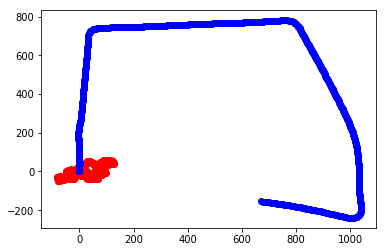

Count:2961
()
()
Relative Depth: 20.763417832634428
Relative x: -70.45973926813275
Relative Original Depth: 154.837987595979
Relative Original x: 671.3166481258945
Count:2962
()
()
Relative Depth: 20.14793213283033
Relative x: -69.90415454188708
Relative Original Depth: 154.70667844453394
Relative Original x: 670.3253174230304
Count:2963
()
()
Relative Depth: 19.64255787083318
Relative x: -69.2003843539911
Relative Original Depth: 154.51739463765853
Relative Original x: 669.3436655345939
Count:2964
()
()
Relative Depth: 19.368397341513045
Relative x: -68.7697208878547
Relative Original Depth: 154.36799549196294
Relative Original x: 668.3554864787992
Count:2965
()
()
Relative Depth: 19.233850383070852
Relative x: -68.53022091578471
Relative Original Depth: 154.18378329714815
Relative Original x: 667.3732151193572


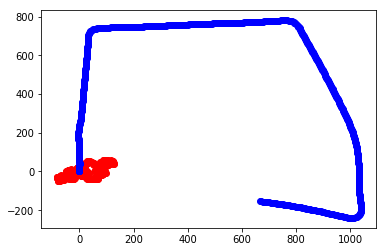

Count:2966
()
()
Relative Depth: 19.090193221372136
Relative x: -68.22730384128097
Relative Original Depth: 154.03003042414917
Relative Original x: 666.385239886877
Count:2967
()
()
Relative Depth: 19.14941211470293
Relative x: -68.15745302309988
Relative Original Depth: 153.83181256381758
Relative Original x: 665.4051594987006
Count:2968
()
()
Relative Depth: 19.48481950698985
Relative x: -68.01160936871145
Relative Original Depth: 153.66875986811078
Relative Original x: 664.418824607227
Count:2969
()
()
Relative Depth: 19.94835959431698
Relative x: -67.63540500818827
Relative Original Depth: 153.49308495075442
Relative Original x: 663.4343809120323
Count:2970
()
()
Relative Depth: 20.433485057599768
Relative x: -67.295991017144
Relative Original Depth: 153.33003358274482
Relative Original x: 662.4477633426044


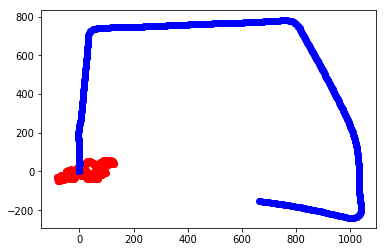

Count:2971
()
()
Relative Depth: 21.02209123705445
Relative x: -67.19253241619506
Relative Original Depth: 153.17852602256465
Relative Original x: 661.4599514507718
Count:2972
()
()
Relative Depth: 21.59588575231657
Relative x: -66.6659379876396
Relative Original Depth: 152.98957464555772
Relative Original x: 660.4795189347465
Count:2973
()
()
Relative Depth: 21.750988684083648
Relative x: -65.72897209330097
Relative Original Depth: 152.89631625236345
Relative Original x: 659.485324574784
Count:2974
()
()
Relative Depth: 21.725132543865666
Relative x: -64.80214530769464
Relative Original Depth: 152.74923446584378
Relative Original x: 658.4972712945162
Count:2975
()
()
Relative Depth: 21.678486620884158
Relative x: -63.8369159680467
Relative Original Depth: 152.59525610121523
Relative Original x: 657.5097124586455


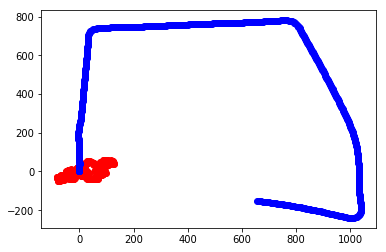

Count:2976
()
()
Relative Depth: 21.640379766355895
Relative x: -62.83790857696598
Relative Original Depth: 152.4709275760589
Relative Original x: 656.517682934468
Count:2977
()
()
Relative Depth: 21.68592502834828
Relative x: -61.879607655043216
Relative Original Depth: 152.3138607446046
Relative Original x: 655.5300952172058
Count:2978
()
()
Relative Depth: 22.0638330696665
Relative x: -61.17154177275244
Relative Original Depth: 152.11370387201956
Relative Original x: 654.553404767952
Count:2979
()
()
Relative Depth: 22.76397136792346
Relative x: -60.55828280806266
Relative Original Depth: 151.94795941623164
Relative Original x: 653.5672573921494
Count:2980
()
()
Relative Depth: 23.518927659710528
Relative x: -59.977379648424346
Relative Original Depth: 151.8094479279276
Relative Original x: 652.5768982461643


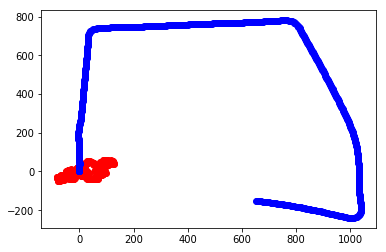

Count:2981
()
()
Relative Depth: 24.11228374969212
Relative x: -59.23982018643365
Relative Original Depth: 151.6888368353971
Relative Original x: 651.5844407077124
Count:2982
()
()
Relative Depth: 24.50444888441002
Relative x: -58.36103229470346
Relative Original Depth: 151.53475042954045
Relative Original x: 650.5969617664038
Count:2983
()
()
Relative Depth: 24.84721890964609
Relative x: -57.42885844377434
Relative Original Depth: 151.43556769466028
Relative Original x: 649.6019242563851
Count:2984
()
()
Relative Depth: 25.06591589901963
Relative x: -56.45968886348533
Relative Original Depth: 151.25223264050786
Relative Original x: 648.6190893280971
Count:2985
()
()
Relative Depth: 25.5420165225821
Relative x: -55.58265592653903
Relative Original Depth: 151.09307229338947
Relative Original x: 647.6333018715376


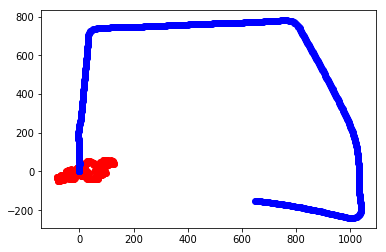

Count:2986
()
()
Relative Depth: 26.246420978445716
Relative x: -54.87335487346463
Relative Original Depth: 150.91378545637235
Relative Original x: 646.6503879169264
Count:2987
()
()
Relative Depth: 27.22071524676821
Relative x: -54.64996516397449
Relative Original Depth: 150.78625359021078
Relative Original x: 645.6587520254689
Count:2988
()
()
Relative Depth: 28.11832615611591
Relative x: -55.0421355387631
Relative Original Depth: 150.60554929333162
Relative Original x: 644.6758234577492
Count:2989
()
()
Relative Depth: 29.087596749349
Relative x: -54.84595494717534
Relative Original Depth: 150.45864581610323
Relative Original x: 643.6866729091842
Count:2990
()
()
Relative Depth: 28.346930763931226
Relative x: -55.055681632465024
Relative Original Depth: 150.3104663550048
Relative Original x: 642.6978208229176


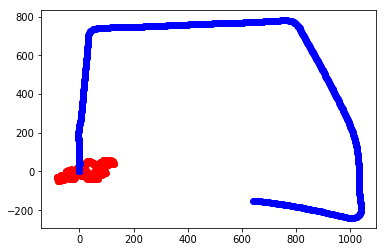

Count:2991
()
()
Relative Depth: 28.881014052557926
Relative x: -54.220960454030035
Relative Original Depth: 150.15259426350067
Relative Original x: 641.7106976585117
Count:2992
()
()
Relative Depth: 29.40105346309695
Relative x: -53.368230587539045
Relative Original Depth: 150.01825777854773
Relative Original x: 640.7204471604866
Count:2993
()
()
Relative Depth: 29.740823790969483
Relative x: -54.09713466551084
Relative Original Depth: 149.87492510582146
Relative Original x: 639.7313431596588
Count:2994
()
()
Relative Depth: 30.413937588412665
Relative x: -53.360296990156016
Relative Original Depth: 149.67736000333247
Relative Original x: 638.7511919259794
Count:2995
()
()
Relative Depth: 31.07526316947951
Relative x: -52.61167282679097
Relative Original Depth: 149.5016107939682
Relative Original x: 637.7676336345747


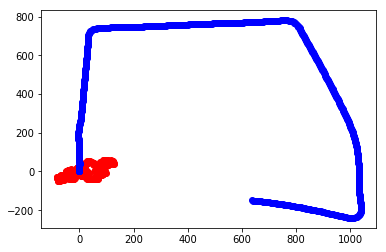

Count:2996
()
()
Relative Depth: 31.98542243179085
Relative x: -52.20620631732762
Relative Original Depth: 149.383050740665
Relative Original x: 636.7747780469742
Count:2997
()
()
Relative Depth: 32.9447878749217
Relative x: -52.37493879241546
Relative Original Depth: 149.2307712861686
Relative Original x: 635.7865634966968
Count:2998
()
()
Relative Depth: 33.673846869962624
Relative x: -53.05553521205956
Relative Original Depth: 149.14057702575116
Relative Original x: 634.7908025597908
Count:2999
()
()
Relative Depth: 34.020236203670535
Relative x: -53.93639484610657
Relative Original Depth: 148.91897628793615
Relative Original x: 633.815666900203
Count:3000
()
()
Relative Depth: 33.49835265439162
Relative x: -54.645344983045575
Relative Original Depth: 148.753791535993
Relative Original x: 632.8294044169749


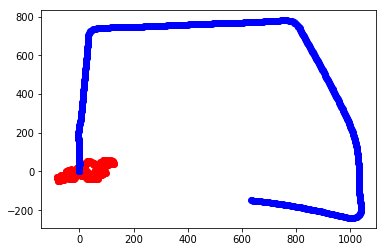

Count:3001
()
()
Relative Depth: 34.01388890446998
Relative x: -55.46981187973645
Relative Original Depth: 148.63109671922146
Relative Original x: 631.8375177191624
Count:3002
()
()
Relative Depth: 34.126946343848715
Relative x: -55.54141861103853
Relative Original Depth: 148.41996986640163
Relative Original x: 630.8601248093046
Count:3003
()
()
Relative Depth: 34.90260051463182
Relative x: -56.1725753370585
Relative Original Depth: 148.24671204723293
Relative Original x: 629.8763633511563
Count:3004
()
()
Relative Depth: 34.45429590546086
Relative x: -56.599991821198444
Relative Original Depth: 148.0793651863151
Relative Original x: 628.8908394887948
Count:3005
()
()
Relative Depth: 35.364433644928525
Relative x: -57.0085958816329
Relative Original Depth: 147.93049420351673
Relative Original x: 627.9024794761061


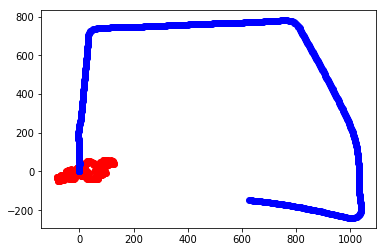

Count:3006
()
()
Relative Depth: 36.0933301434774
Relative x: -57.59450652975539
Relative Original Depth: 147.7678534739224
Relative Original x: 626.9163795355571
Count:3007
()
()
Relative Depth: 36.69995891951754
Relative x: -58.32707990684438
Relative Original Depth: 147.65518803177713
Relative Original x: 625.9227975399749
Count:3008
()
()
Relative Depth: 36.89090811714332
Relative x: -59.19668971111366
Relative Original Depth: 147.4999221420156
Relative Original x: 624.9350100997699
Count:3009
()
()
Relative Depth: 37.73598577579096
Relative x: -59.5794440455203
Relative Original Depth: 147.36110602188805
Relative Original x: 623.944849836853
Count:3010
()
()
Relative Depth: 36.99575752975695
Relative x: -60.17910909639839
Relative Original Depth: 147.1946833423054
Relative Original x: 622.9588053624574


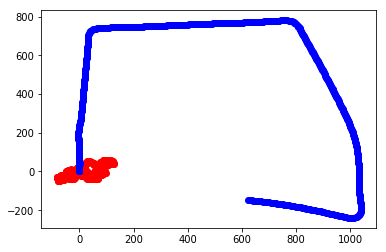

Count:3011
()
()
Relative Depth: 36.91638979709099
Relative x: -59.21043538262044
Relative Original Depth: 147.00879754832584
Relative Original x: 621.9762381438444
Count:3012
()
()
Relative Depth: 36.905795127418195
Relative x: -58.248373655807605
Relative Original Depth: 146.827770244953
Relative Original x: 620.9927693463806
Count:3013
()
()
Relative Depth: 37.06122174149938
Relative x: -57.41847197027354
Relative Original Depth: 146.71888873984966
Relative Original x: 619.9987225154549
Count:3014
()
()
Relative Depth: 37.34909761274462
Relative x: -56.66130089955604
Relative Original Depth: 146.60522820699043
Relative Original x: 619.0052151935879
Count:3015
()
()
Relative Depth: 36.893882819053864
Relative x: -55.77231715372169
Relative Original Depth: 146.50503999679952
Relative Original x: 618.0104246010053


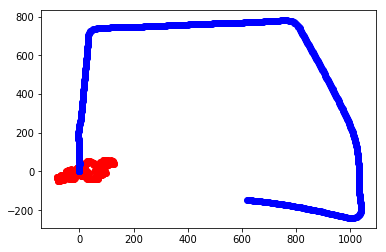

Count:3016
()
()
Relative Depth: 37.22333734464664
Relative x: -55.02333296235067
Relative Original Depth: 146.33490316121637
Relative Original x: 617.0251120843435
Count:3017
()
()
Relative Depth: 37.53113923813183
Relative x: -54.229738188046475
Relative Original Depth: 146.13595027005624
Relative Original x: 616.0451539260112
Count:3018
()
()
Relative Depth: 37.56925752283941
Relative x: -53.29063486004792
Relative Original Depth: 146.042625995964
Relative Original x: 615.0495941753425
Count:3019
()
()
Relative Depth: 37.18678958142763
Relative x: -52.66942643174487
Relative Original Depth: 145.95302525337587
Relative Original x: 614.0546364624023
Count:3020
()
()
Relative Depth: 36.518837375262265
Relative x: -51.97285464498886
Relative Original Depth: 145.80820776308738
Relative Original x: 613.065860056447


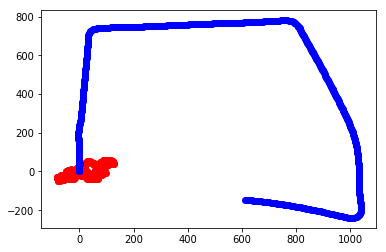

Count:3021
()
()
Relative Depth: 35.750370453939716
Relative x: -51.847778519706836
Relative Original Depth: 145.64254777877747
Relative Original x: 612.0800174722377
Count:3022
()
()
Relative Depth: 34.854604144135806
Relative x: -51.47702952334505
Relative Original Depth: 145.40404931631275
Relative Original x: 611.1093598627638
Count:3023
()
()
Relative Depth: 34.04843841613889
Relative x: -50.93571354998424
Relative Original Depth: 145.25728320815082
Relative Original x: 610.1202210834686
Count:3024
()
()
Relative Depth: 33.521458992909906
Relative x: -50.22791621809969
Relative Original Depth: 145.10928099978292
Relative Original x: 609.1313356959913
Count:3025
()
()
Relative Depth: 33.347100365339344
Relative x: -49.493859879117245
Relative Original Depth: 144.98157613462834
Relative Original x: 608.1400677661537


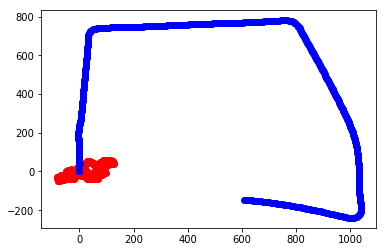

Count:3026
()
()
Relative Depth: 33.73283024865272
Relative x: -48.989901062009324
Relative Original Depth: 144.88951902093245
Relative Original x: 607.1454537221083
Count:3027
()
()
Relative Depth: 33.57754052316814
Relative x: -48.22404398684254
Relative Original Depth: 144.72891329441862
Relative Original x: 606.1585440681029
Count:3028
()
()
Relative Depth: 34.23964161649808
Relative x: -47.8222298176448
Relative Original Depth: 144.5861776461115
Relative Original x: 605.1689545682653
Count:3029
()
()
Relative Depth: 34.48126592748412
Relative x: -47.168057480852966
Relative Original Depth: 144.42565966948825
Relative Original x: 604.1819384771622
Count:3030
()
()
Relative Depth: 34.49534514815603
Relative x: -46.52018515037864
Relative Original Depth: 144.2778571198872
Relative Original x: 603.1931995158577


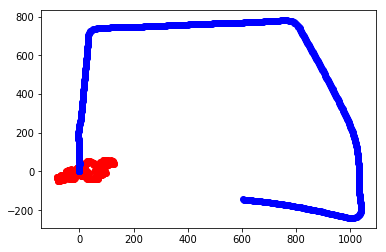

Count:3031
()
()
Relative Depth: 34.36621275818811
Relative x: -45.90866123211579
Relative Original Depth: 144.11833901169393
Relative Original x: 602.2071823742473
Count:3032
()
()
Relative Depth: 34.13222124367346
Relative x: -45.592422803866654
Relative Original Depth: 144.0005774806842
Relative Original x: 601.2154005503028
Count:3033
()
()
Relative Depth: 33.930269759884546
Relative x: -45.527667771466504
Relative Original Depth: 143.86920010316106
Relative Original x: 600.2246237040937
Count:3034
()
()
Relative Depth: 33.173768809011996
Relative x: -45.575194920526776
Relative Original Depth: 143.75188832204077
Relative Original x: 599.2344578913381
Count:3035
()
()
Relative Depth: 32.207505852164864
Relative x: -45.744396020453756
Relative Original Depth: 143.61065651745633
Relative Original x: 598.2464336164387


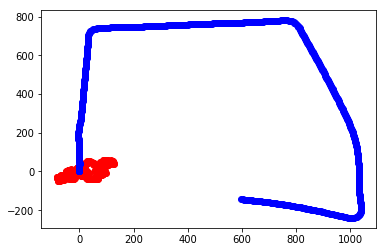

Count:3036
()
()
Relative Depth: 31.334489748724447
Relative x: -46.23154006611691
Relative Original Depth: 143.51853824393226
Relative Original x: 597.2515111622183
Count:3037
()
()
Relative Depth: 30.595189704599708
Relative x: -46.88816329696917
Relative Original Depth: 143.32666228833054
Relative Original x: 596.270324853984
Count:3038
()
()
Relative Depth: 29.776799076160867
Relative x: -47.44430201857391
Relative Original Depth: 143.17959081033268
Relative Original x: 595.281234305575
Count:3039
()
()
Relative Depth: 29.275613161816246
Relative x: -48.28593142726917
Relative Original Depth: 143.03182701767997
Relative Original x: 594.2924053988681
Count:3040
()
()
Relative Depth: 29.187982851854112
Relative x: -49.08372231214418
Relative Original Depth: 142.92156849778922
Relative Original x: 593.2985569533835


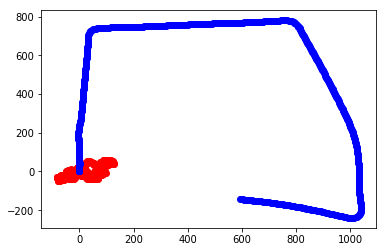

Count:3041
()
()
Relative Depth: 29.12100773167476
Relative x: -49.884963080442795
Relative Original Depth: 142.84516812798228
Relative Original x: 592.3027611751688
Count:3042
()
()
Relative Depth: 28.985354109653635
Relative x: -50.78289120632735
Relative Original Depth: 142.72222723602303
Relative Original x: 591.3107606560842
Count:3043
()
()
Relative Depth: 28.842739155570357
Relative x: -51.77002656574087
Relative Original Depth: 142.6292288866569
Relative Original x: 590.3155388966379
Count:3044
()
()
Relative Depth: 28.768607529046996
Relative x: -52.76509361794458
Relative Original Depth: 142.49979060731252
Relative Original x: 589.3243000961003
Count:3045
()
()
Relative Depth: 28.588680685049077
Relative x: -53.74409096528583
Relative Original Depth: 142.3431614273568
Relative Original x: 588.3380279101063


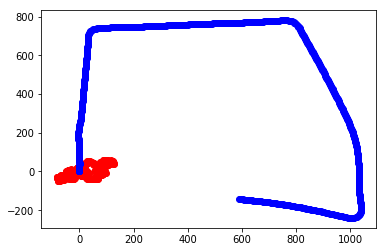

Count:3046
()
()
Relative Depth: 28.164426719677998
Relative x: -54.572694603947525
Relative Original Depth: 142.17354758307192
Relative Original x: 587.3532821184315
Count:3047
()
()
Relative Depth: 27.695737485299063
Relative x: -55.153598318622
Relative Original Depth: 141.9911612982047
Relative Original x: 586.3701771433625
Count:3048
()
()
Relative Depth: 27.34817575327801
Relative x: -55.89268829176791
Relative Original Depth: 141.82567983976554
Relative Original x: 585.3856808885205
Count:3049
()
()
Relative Depth: 26.960552290654114
Relative x: -56.612751142458414
Relative Original Depth: 141.68337179632977
Relative Original x: 584.3961225296368
Count:3050
()
()
Relative Depth: 26.554720516033782
Relative x: -56.98969169060145
Relative Original Depth: 141.5214726808231
Relative Original x: 583.4093911590448


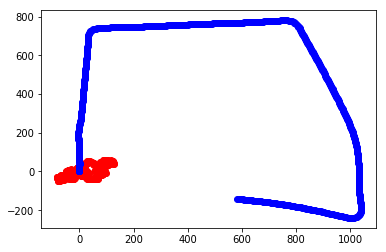

Count:3051
()
()
Relative Depth: 26.195415019501908
Relative x: -57.52182355414825
Relative Original Depth: 141.37667641969827
Relative Original x: 582.4202037137134
Count:3052
()
()
Relative Depth: 26.39641857307143
Relative x: -58.47702724093634
Relative Original Depth: 141.3581073010563
Relative Original x: 581.4205995666592
Count:3053
()
()
Relative Depth: 25.665113316638593
Relative x: -58.37798074382058
Relative Original Depth: 141.2548449601204
Relative Original x: 580.4268700853997
Count:3054
()
()
Relative Depth: 26.232881469677473
Relative x: -59.20042702183714
Relative Original Depth: 141.1508137670541
Relative Original x: 579.4324527739163
Count:3055
()
()
Relative Depth: 26.66131683252776
Relative x: -59.173334682748404
Relative Original Depth: 141.0165465386705
Relative Original x: 578.4420566515839


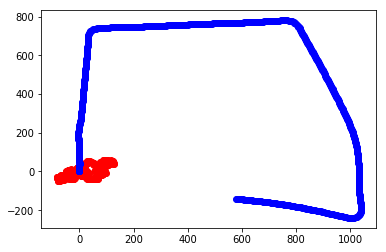

Count:3056
()
()
Relative Depth: 27.23837606492511
Relative x: -59.98053378703369
Relative Original Depth: 140.85709575677666
Relative Original x: 577.455591760551
Count:3057
()
()
Relative Depth: 28.032864804392013
Relative x: -60.5874938841789
Relative Original Depth: 140.70153085256914
Relative Original x: 576.469409509111
Count:3058
()
()
Relative Depth: 28.70655866964256
Relative x: -61.27802347437527
Relative Original Depth: 140.53966282272341
Relative Original x: 575.4827978958612
Count:3059
()
()
Relative Depth: 29.455772039100744
Relative x: -61.726766020254445
Relative Original Depth: 140.3869012623569
Relative Original x: 574.4953748950011
Count:3060
()
()
Relative Depth: 30.029026419332588
Relative x: -62.40715756727076
Relative Original Depth: 140.25645939196068
Relative Original x: 573.5043706867156


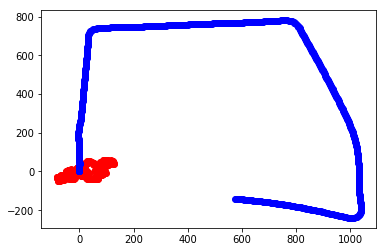

Count:3061
()
()
Relative Depth: 30.3677967157049
Relative x: -61.56808500440991
Relative Original Depth: 140.09745884464112
Relative Original x: 572.5182698923118
Count:3062
()
()
Relative Depth: 30.006767758110723
Relative x: -61.540775025328955
Relative Original Depth: 139.99410245790975
Relative Original x: 571.5236308475227
Count:3063
()
()
Relative Depth: 29.49421016693394
Relative x: -61.877278639695525
Relative Original Depth: 139.8892600449662
Relative Original x: 570.5299863210982
Count:3064
()
()
Relative Depth: 28.857810569474374
Relative x: -62.62209441444901
Relative Original Depth: 139.7580477035797
Relative Original x: 569.5402905384226
Count:3065
()
()
Relative Depth: 28.572693691302653
Relative x: -63.068724420674435
Relative Original Depth: 139.61098405211135
Relative Original x: 568.5513461103992


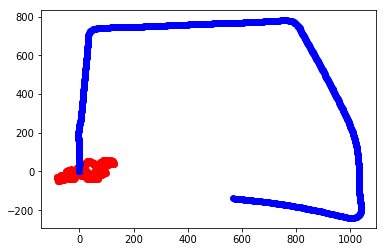

Count:3066
()
()
Relative Depth: 27.987058741268957
Relative x: -63.83503480722582
Relative Original Depth: 139.45419965929875
Relative Original x: 567.5643126641947
Count:3067
()
()
Relative Depth: 27.62040740079726
Relative x: -64.4147203682895
Relative Original Depth: 139.34260289159351
Relative Original x: 566.5724266253034
Count:3068
()
()
Relative Depth: 28.141251888546172
Relative x: -63.6494188562564
Relative Original Depth: 139.1928617231636
Relative Original x: 565.5859505652996
Count:3069
()
()
Relative Depth: 28.65254957947981
Relative x: -62.92079286604679
Relative Original Depth: 139.05729440609844
Relative Original x: 564.5977246253258
Count:3070
()
()
Relative Depth: 29.175568710281937
Relative x: -62.169237617277254
Relative Original Depth: 138.98351279110344
Relative Original x: 563.6007736577617


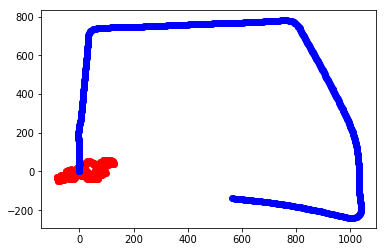

Count:3071
()
()
Relative Depth: 29.820347867243417
Relative x: -61.40495590496081
Relative Original Depth: 138.837949523594
Relative Original x: 562.6118124936747
Count:3072
()
()
Relative Depth: 30.484169500310898
Relative x: -60.80450830248782
Relative Original Depth: 138.75096643057444
Relative Original x: 561.6156601139024
Count:3073
()
()
Relative Depth: 31.068417433916668
Relative x: -60.31689981237919
Relative Original Depth: 138.67772755958538
Relative Original x: 560.6187473968748
Count:3074
()
()
Relative Depth: 31.130928940983548
Relative x: -61.129590559237776
Relative Original Depth: 138.5621062386299
Relative Original x: 559.6265398933352
Count:3075
()
()
Relative Depth: 31.80921676408636
Relative x: -60.59406929890583
Relative Original Depth: 138.43508479758717
Relative Original x: 558.6347515465822


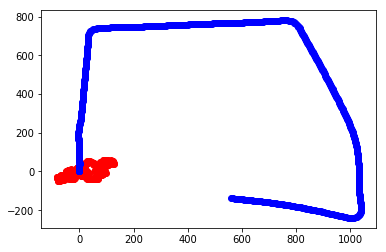

Count:3076
()
()
Relative Depth: 32.57454534574945
Relative x: -60.0179865941312
Relative Original Depth: 138.31110742492015
Relative Original x: 557.6424715184492
Count:3077
()
()
Relative Depth: 32.837957793955965
Relative x: -59.11922497963703
Relative Original Depth: 138.1815167669531
Relative Original x: 556.6520468316261
Count:3078
()
()
Relative Depth: 32.465313436723605
Relative x: -58.21103225027962
Relative Original Depth: 138.05404028508278
Relative Original x: 555.660979657935
Count:3079
()
()
Relative Depth: 32.083647138812765
Relative x: -57.324153864478895
Relative Original Depth: 138.0318809376428
Relative Original x: 554.661922448002
Count:3080
()
()
Relative Depth: 31.957440217922905
Relative x: -56.36117086754285
Relative Original Depth: 137.91871522321793
Relative Original x: 553.6684862795454


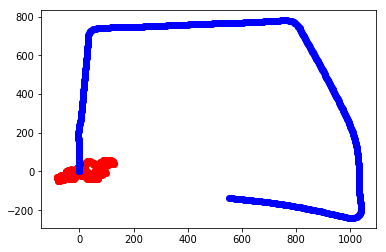

Count:3081
()
()
Relative Depth: 32.000648901446645
Relative x: -55.36236423266901
Relative Original Depth: 137.79977016139702
Relative Original x: 552.6758974875526
Count:3082
()
()
Relative Depth: 32.00430106226358
Relative x: -54.365938565527614
Relative Original Depth: 137.76934129342357
Relative Original x: 551.676435058489
Count:3083
()
()
Relative Depth: 32.119370701204936
Relative x: -53.3734460020602
Relative Original Depth: 137.74377764946277
Relative Original x: 550.6768949872932
Count:3084
()
()
Relative Depth: 32.28204290180816
Relative x: -52.691659030709225
Relative Original Depth: 137.76883487166447
Relative Original x: 549.6793192427016
Count:3085
()
()
Relative Depth: 32.43218483994326
Relative x: -51.98620856256911
Relative Original Depth: 137.66318473697666
Relative Original x: 548.6849623887058


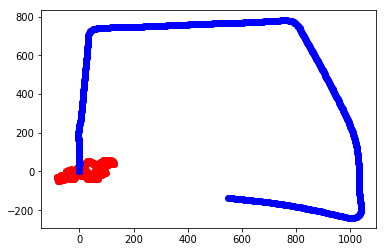

Count:3086
()
()
Relative Depth: 32.52542219990658
Relative x: -51.88154588423416
Relative Original Depth: 137.52439179753898
Relative Original x: 547.6947168615435
Count:3087
()
()
Relative Depth: 32.47068653153195
Relative x: -51.97581745789797
Relative Original Depth: 137.37527166897993
Relative Original x: 546.7065627722493
Count:3088
()
()
Relative Depth: 32.46668999539215
Relative x: -52.44768732756724
Relative Original Depth: 137.24092847869125
Relative Original x: 545.7171573578269
Count:3089
()
()
Relative Depth: 32.37265800762062
Relative x: -53.1704699930373
Relative Original Depth: 137.17768331005243
Relative Original x: 544.7194214668011
Count:3090
()
()
Relative Depth: 31.849249384953367
Relative x: -53.99188542197639
Relative Original Depth: 136.96983525341716
Relative Original x: 543.7428223150245


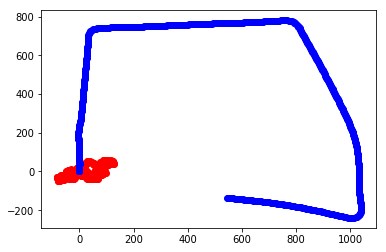

Count:3091
()
()
Relative Depth: 31.530191972798097
Relative x: -54.426160806723324
Relative Original Depth: 136.90798237672718
Relative Original x: 542.7448425660485
Count:3092
()
()
Relative Depth: 31.317917118237926
Relative x: -55.05456074389104
Relative Original Depth: 136.79896963700043
Relative Original x: 541.750805421225
Count:3093
()
()
Relative Depth: 31.272007046596116
Relative x: -56.01309190998972
Relative Original Depth: 136.68952454563487
Relative Original x: 540.7569153196788
Count:3094
()
()
Relative Depth: 31.697204916429236
Relative x: -56.12890315875736
Relative Original Depth: 136.6208630835549
Relative Original x: 539.7598147866025
Count:3095
()
()
Relative Depth: 32.362894382405166
Relative x: -55.958379218423616
Relative Original Depth: 136.50673247896782
Relative Original x: 538.7663587870743


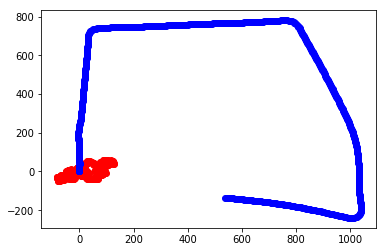

Count:3096
()
()
Relative Depth: 32.723779273646926
Relative x: -55.69519540144661
Relative Original Depth: 136.36212301554937
Relative Original x: 537.7771144338795
Count:3097
()
()
Relative Depth: 32.570231592842546
Relative x: -54.99822618193782
Relative Original Depth: 136.22441572435213
Relative Original x: 536.7874558713153
Count:3098
()
()
Relative Depth: 32.154942957496516
Relative x: -54.09457115745056
Relative Original Depth: 136.12504737589688
Relative Original x: 535.7926562975176
Count:3099
()
()
Relative Depth: 31.862495524426862
Relative x: -54.6509260655825
Relative Original Depth: 135.97362631526033
Relative Original x: 534.8043759295365
Count:3100
()
()
Relative Depth: 31.321723933420966
Relative x: -53.81165807221011
Relative Original Depth: 135.87730212408874
Relative Original x: 533.8094741482387


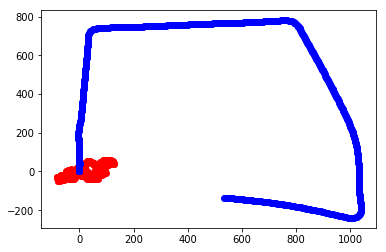

Count:3101
()
()
Relative Depth: 30.861963055672184
Relative x: -52.923696843088855
Relative Original Depth: 135.79617268091712
Relative Original x: 532.812871739374
Count:3102
()
()
Relative Depth: 30.55827627862202
Relative x: -52.04130426728813
Relative Original Depth: 135.82117224556694
Relative Original x: 531.8133108805945
Count:3103
()
()
Relative Depth: 30.927386373886264
Relative x: -51.26367729613035
Relative Original Depth: 135.7634555611018
Relative Original x: 530.8149880616594
Count:3104
()
()
Relative Depth: 31.792006376486086
Relative x: -50.804213343084875
Relative Original Depth: 135.7182650966669
Relative Original x: 529.8169191898601
Count:3105
()
()
Relative Depth: 32.68124045467809
Relative x: -50.91520881870183
Relative Original Depth: 135.519927849822
Relative Original x: 528.8369549929323


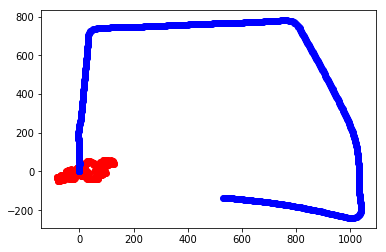

Count:3106
()
()
Relative Depth: 33.25455286660344
Relative x: -51.439612299592646
Relative Original Depth: 135.4303853607485
Relative Original x: 527.8410717554337
Count:3107
()
()
Relative Depth: 33.766604556615995
Relative x: -51.93205908695565
Relative Original Depth: 135.22125205255998
Relative Original x: 526.8632632536269
Count:3108
()
()
Relative Depth: 34.31088550295039
Relative x: -52.10557007367131
Relative Original Depth: 135.17193027232247
Relative Original x: 525.8644841016518
Count:3109
()
()
Relative Depth: 34.54649660226747
Relative x: -52.114620937284165
Relative Original Depth: 135.14077088491013
Relative Original x: 524.8651012416996
Count:3110
()
()
Relative Depth: 34.52429601130029
Relative x: -52.29557776873931
Relative Original Depth: 135.02751488854582
Relative Original x: 523.8715449132949


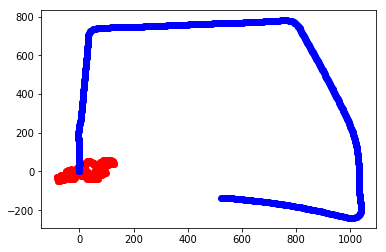

Count:3111
()
()
Relative Depth: 34.70954767740509
Relative x: -51.79950078859319
Relative Original Depth: 134.93817468218526
Relative Original x: 522.8756605369322
Count:3112
()
()
Relative Depth: 35.31095511885664
Relative x: -51.0010271054915
Relative Original Depth: 134.83274458728354
Relative Original x: 521.8812399922826
Count:3113
()
()
Relative Depth: 36.10444051715556
Relative x: -50.39294694017914
Relative Original Depth: 134.75984833421555
Relative Original x: 520.8845423243437
Count:3114
()
()
Relative Depth: 36.9692914124562
Relative x: -49.91227759668967
Relative Original Depth: 134.64499521497973
Relative Original x: 519.8912617266816
Count:3115
()
()
Relative Depth: 37.79357325878293
Relative x: -49.876799185238035
Relative Original Depth: 134.5448551543936
Relative Original x: 518.8962932736973


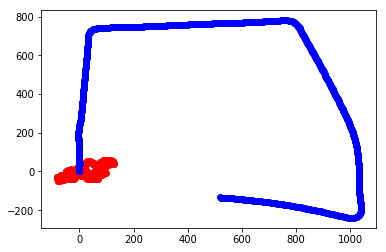

Count:3116
()
()
Relative Depth: 38.48778534676451
Relative x: -50.02157010670152
Relative Original Depth: 134.36884327441186
Relative Original x: 517.9119113167606
Count:3117
()
()
Relative Depth: 39.23847910889273
Relative x: -50.1303478935155
Relative Original Depth: 134.2841690044381
Relative Original x: 516.9158070043121
Count:3118
()
()
Relative Depth: 40.02745812561908
Relative x: -50.37073335153986
Relative Original Depth: 134.21401400389956
Relative Original x: 515.9189751442127
Count:3119
()
()
Relative Depth: 40.715633570512374
Relative x: -50.75612117943319
Relative Original Depth: 134.0669780539269
Relative Original x: 514.9299768312247
Count:3120
()
()
Relative Depth: 40.71646899999881
Relative x: -50.935088618861776
Relative Original Depth: 133.96841760098272
Relative Original x: 513.9355065353423


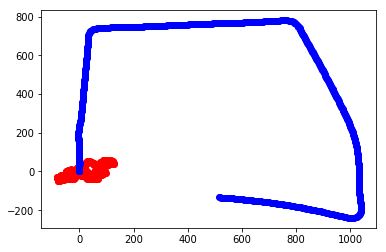

Count:3121
()
()
Relative Depth: 40.409346961799194
Relative x: -50.87367337966736
Relative Original Depth: 133.8201554976195
Relative Original x: 512.9468300281384
Count:3122
()
()
Relative Depth: 40.44957215647037
Relative x: -50.82472892963475
Relative Original Depth: 133.72974686863824
Relative Original x: 511.95138462952565
Count:3123
()
()
Relative Depth: 40.1774345005534
Relative x: -50.76861370336084
Relative Original Depth: 133.58639463876182
Relative Original x: 510.96248012891976
Count:3124
()
()
Relative Depth: 39.700738869200414
Relative x: -51.212056331241335
Relative Original Depth: 133.50510901987633
Relative Original x: 509.9658818660205
Count:3125
()
()
Relative Depth: 40.5199041614145
Relative x: -51.661059010760695
Relative Original Depth: 133.42933359863582
Relative Original x: 508.9698159962485


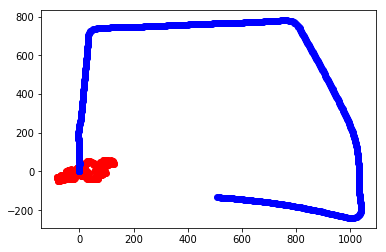

Count:3126
()
()
Relative Depth: 40.28642716193093
Relative x: -52.391388235975526
Relative Original Depth: 133.34183630148377
Relative Original x: 507.97365279940647
Count:3127
()
()
Relative Depth: 40.03710284242196
Relative x: -52.87050977327951
Relative Original Depth: 133.2290120329221
Relative Original x: 506.9802760817279
Count:3128
()
()
Relative Depth: 39.68756771000539
Relative x: -53.117169057745635
Relative Original Depth: 133.13327636110398
Relative Original x: 505.9853341482611
Count:3129
()
()
Relative Depth: 39.20459680291942
Relative x: -52.97269604781683
Relative Original Depth: 133.01492093056726
Relative Original x: 504.99254671727664
Count:3130
()
()
Relative Depth: 38.92660798690775
Relative x: -52.83499640391178
Relative Original Depth: 132.9226828090838
Relative Original x: 503.9975120218431


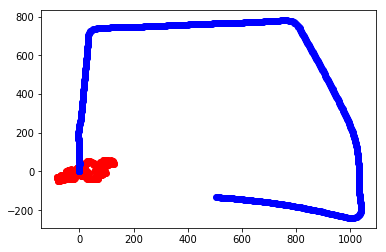

Count:3131
()
()
Relative Depth: 38.43014406279237
Relative x: -53.1395506154424
Relative Original Depth: 132.86568651315284
Relative Original x: 502.9993029089483
Count:3132
()
()
Relative Depth: 37.76148040825956
Relative x: -53.68698940473779
Relative Original Depth: 132.81688129270597
Relative Original x: 502.00087022836016
Count:3133
()
()
Relative Depth: 37.40570815667734
Relative x: -53.73355989981313
Relative Original Depth: 132.7629685960695
Relative Original x: 501.0023620937244
Count:3134
()
()
Relative Depth: 37.414198093228755
Relative x: -53.48714486643181
Relative Original Depth: 132.70372367941135
Relative Original x: 500.00548132670485
Count:3135
()
()
Relative Depth: 36.92766044432899
Relative x: -54.1335089699099
Relative Original Depth: 132.52472161031415
Relative Original x: 499.02169151293987


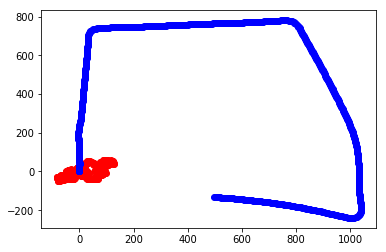

Count:3136
()
()
Relative Depth: 37.20780426080875
Relative x: -53.91903358684709
Relative Original Depth: 132.4514339266122
Relative Original x: 498.02539067245016
Count:3137
()
()
Relative Depth: 37.962821876047684
Relative x: -53.93394421452601
Relative Original Depth: 132.28000134685635
Relative Original x: 497.0402067358335
Count:3138
()
()
Relative Depth: 38.83524131219407
Relative x: -54.16066973312181
Relative Original Depth: 132.25465231730664
Relative Original x: 496.0409191862447
Count:3139
()
()
Relative Depth: 39.833579857204604
Relative x: -54.206312961089196
Relative Original Depth: 132.1579479296055
Relative Original x: 495.0458984929419
Count:3140
()
()
Relative Depth: 40.52675382389378
Relative x: -54.054102807088526
Relative Original Depth: 132.09562336748235
Relative Original x: 494.04784734039356


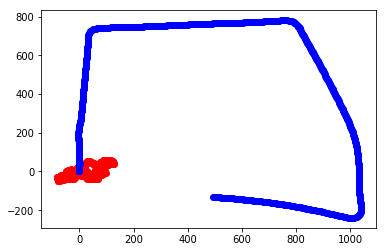

Count:3141
()
()
Relative Depth: 40.94242383293067
Relative x: -53.87382716945786
Relative Original Depth: 132.00391448681052
Relative Original x: 493.0521899282124
Count:3142
()
()
Relative Depth: 41.54695406168205
Relative x: -53.64773337329025
Relative Original Depth: 131.9315679562224
Relative Original x: 492.05491344351606
Count:3143
()
()
Relative Depth: 41.008705728800884
Relative x: -52.99069704738593
Relative Original Depth: 131.82422217608178
Relative Original x: 491.0610050506797
Count:3144
()
()
Relative Depth: 41.7599613334614
Relative x: -52.698611393762654
Relative Original Depth: 131.71171178013046
Relative Original x: 490.0673915520694
Count:3145
()
()
Relative Depth: 42.34610306687837
Relative x: -52.32443200543943
Relative Original Depth: 131.6511183290377
Relative Original x: 489.06993029210537


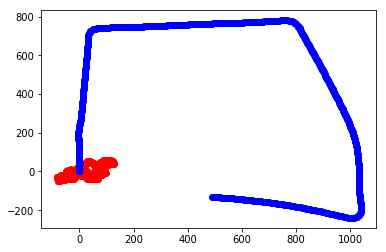

Count:3146
()
()
Relative Depth: 43.036843619357754
Relative x: -51.894856661385234
Relative Original Depth: 131.5270778854468
Relative Original x: 488.0787259489147
Count:3147
()
()
Relative Depth: 43.83507094038346
Relative x: -51.42902219117243
Relative Original Depth: 131.42388991103243
Relative Original x: 487.084214338584
Count:3148
()
()
Relative Depth: 44.61464607009763
Relative x: -50.93420203931479
Relative Original Depth: 131.34995281695768
Relative Original x: 486.08716441133987
Count:3149
()
()
Relative Depth: 45.44369222167891
Relative x: -50.45829801173114
Relative Original Depth: 131.2884864439996
Relative Original x: 485.08911545280915
Count:3150
()
()
Relative Depth: 46.30143953951005
Relative x: -49.99272711281656
Relative Original Depth: 131.23911291167678
Relative Original x: 484.09035078924956


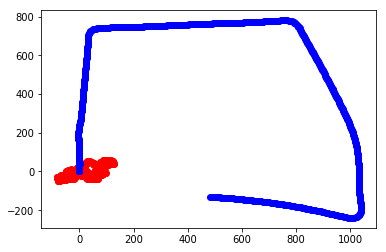

Count:3151
()
()
Relative Depth: 47.013754360681226
Relative x: -49.33205964793335
Relative Original Depth: 131.00551816801627
Relative Original x: 483.11842128682156
Count:3152
()
()
Relative Depth: 47.59589175560506
Relative x: -48.544341020344056
Relative Original Depth: 130.94608323920284
Relative Original x: 482.1202033677369
Count:3153
()
()
Relative Depth: 47.76738092313292
Relative x: -47.65588343234095
Relative Original Depth: 130.8102507106816
Relative Original x: 481.1300895300825
Count:3154
()
()
Relative Depth: 47.82168790052368
Relative x: -46.74567091651407
Relative Original Depth: 130.73762689392953
Relative Original x: 480.1331844812887
Count:3155
()
()
Relative Depth: 48.257682213653375
Relative x: -45.86269262783165
Relative Original Depth: 130.65299168522768
Relative Original x: 479.1368794221361


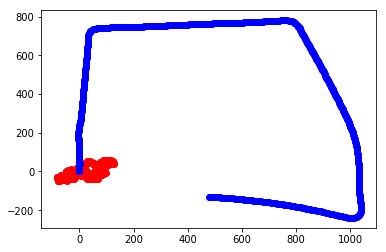

Count:3156
()
()
Relative Depth: 49.15026526066269
Relative x: -45.57466007344993
Relative Original Depth: 130.5376130001717
Relative Original x: 478.1435773590724
Count:3157
()
()
Relative Depth: 49.52542771232251
Relative x: -46.256401779714906
Relative Original Depth: 130.495081439227
Relative Original x: 477.1445021510933
Count:3158
()
()
Relative Depth: 49.965904713216915
Relative x: -45.37187424726505
Relative Original Depth: 130.3703770831494
Relative Original x: 476.1538815450182
Count:3159
()
()
Relative Depth: 50.38063170174901
Relative x: -44.46280474547028
Relative Original Depth: 130.24905603711935
Relative Original x: 475.16133308355523
Count:3160
()
()
Relative Depth: 50.9280844460538
Relative x: -43.63157047280477
Relative Original Depth: 130.16827083756752
Relative Original x: 474.1656616191444


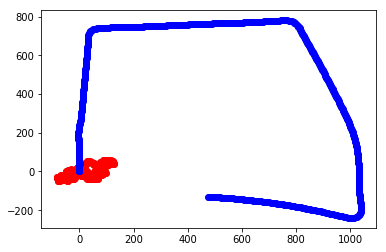

Count:3161
()
()
Relative Depth: 50.11382585043365
Relative x: -43.70365055751391
Relative Original Depth: 130.02563281419705
Relative Original x: 473.17628821109537
Count:3162
()
()
Relative Depth: 50.96773692289998
Relative x: -43.21841379072403
Relative Original Depth: 129.9420340853416
Relative Original x: 472.18000968396353
Count:3163
()
()
Relative Depth: 51.908989626809266
Relative x: -43.097666735444996
Relative Original Depth: 129.81367649546357
Relative Original x: 471.1883751816564
Count:3164
()
()
Relative Depth: 52.85030369158411
Relative x: -43.07783082758179
Relative Original Depth: 129.76333242778955
Relative Original x: 470.18967327087904
Count:3165
()
()
Relative Depth: 53.70988569270313
Relative x: -43.21715659115779
Relative Original Depth: 129.68959541495786
Relative Original x: 469.19254015555987


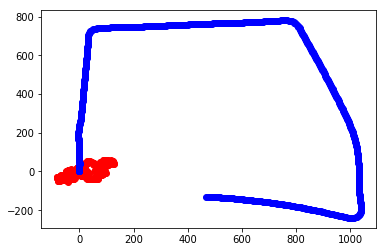

Count:3166
()
()
Relative Depth: 54.17777110052713
Relative x: -43.62713203469934
Relative Original Depth: 129.5994022292245
Relative Original x: 468.19669233011825
Count:3167
()
()
Relative Depth: 54.296733335095
Relative x: -44.12172994298873
Relative Original Depth: 129.5285205097841
Relative Original x: 467.1997363218311
Count:3168
()
()
Relative Depth: 54.44345987453371
Relative x: -44.57697113152025
Relative Original Depth: 129.41716421180348
Relative Original x: 466.2060597792792
Count:3169
()
()
Relative Depth: 54.76495648554716
Relative x: -44.78282055488642
Relative Original Depth: 129.35234414228938
Relative Original x: 465.2081902065697
Count:3170
()
()
Relative Depth: 55.16497731585668
Relative x: -44.85148966488534
Relative Original Depth: 129.2832407906508
Relative Original x: 464.2111547316187


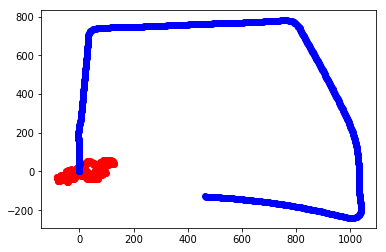

Count:3171
()
()
Relative Depth: 54.78874840052508
Relative x: -45.77621323026569
Relative Original Depth: 129.23230354613557
Relative Original x: 463.213025294448
Count:3172
()
()
Relative Depth: 55.07991489931379
Relative x: -46.16074096538964
Relative Original Depth: 129.14435136169254
Relative Original x: 462.2176321992093
Count:3173
()
()
Relative Depth: 55.2963076829747
Relative x: -46.66297204447833
Relative Original Depth: 129.0857711025074
Relative Original x: 461.2211928766839
Count:3174
()
()
Relative Depth: 55.49380887543824
Relative x: -47.2086661346628
Relative Original Depth: 129.01058693679187
Relative Original x: 460.2241552536144
Count:3175
()
()
Relative Depth: 55.755543660665495
Relative x: -47.77646083746051
Relative Original Depth: 128.9372700033979
Relative Original x: 459.2273494140673


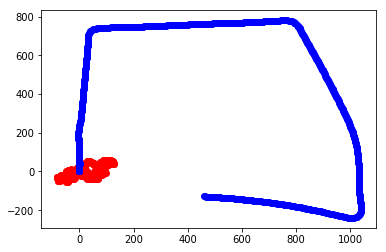

Count:3176
()
()
Relative Depth: 56.10829268026236
Relative x: -48.67616186117417
Relative Original Depth: 128.86363073599765
Relative Original x: 458.2305129560549
Count:3177
()
()
Relative Depth: 56.21491537918019
Relative x: -49.60180748298117
Relative Original Depth: 128.8394726348761
Relative Original x: 457.2318960945839
Count:3178
()
()
Relative Depth: 55.77641325358156
Relative x: -50.198246499498076
Relative Original Depth: 128.75760256340132
Relative Original x: 456.23609218068765
Count:3179
()
()
Relative Depth: 54.969860907069496
Relative x: -50.23495441262681
Relative Original Depth: 128.62062156039136
Relative Original x: 455.24708021684796
Count:3180
()
()
Relative Depth: 54.09598648897688
Relative x: -50.20604161824817
Relative Original Depth: 128.53484688268276
Relative Original x: 454.25138665310607


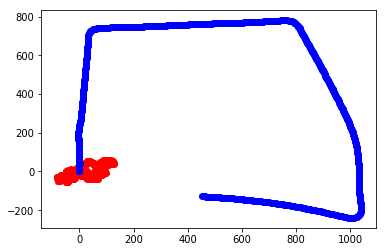

Count:3181
()
()
Relative Depth: 53.28949879054636
Relative x: -49.61483668788317
Relative Original Depth: 128.4806914571283
Relative Original x: 453.25361961320306
Count:3182
()
()
Relative Depth: 52.3094939383143
Relative x: -49.75287744182521
Relative Original Depth: 128.39719833452014
Relative Original x: 452.2574375059668
Count:3183
()
()
Relative Depth: 51.83177470360549
Relative x: -49.44076947942575
Relative Original Depth: 128.27569836642616
Relative Original x: 451.2651838114069
Count:3184
()
()
Relative Depth: 51.183284242383635
Relative x: -49.08159361333753
Relative Original Depth: 128.1940262418295
Relative Original x: 450.26909658763213
Count:3185
()
()
Relative Depth: 50.283986281965866
Relative x: -49.34593640837339
Relative Original Depth: 128.15401146966695
Relative Original x: 449.2706202396267


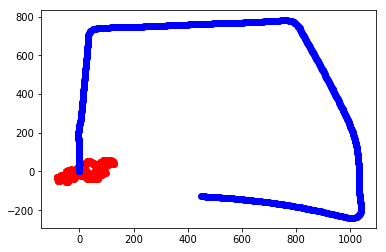

Count:3186
()
()
Relative Depth: 49.356281380184235
Relative x: -49.5603725092851
Relative Original Depth: 128.06533386410266
Relative Original x: 448.2746101827803
Count:3187
()
()
Relative Depth: 48.43606913856399
Relative x: -49.68215953334504
Relative Original Depth: 128.03029312579403
Relative Original x: 447.27559343632055
Count:3188
()
()
Relative Depth: 47.471638490543484
Relative x: -49.89194287212907
Relative Original Depth: 127.93752698063872
Relative Original x: 446.279961052622
Count:3189
()
()
Relative Depth: 46.72477481052516
Relative x: -50.486567804346386
Relative Original Depth: 127.88673543274703
Relative Original x: 445.28131354066807
Count:3190
()
()
Relative Depth: 46.20907251361478
Relative x: -51.28217622394317
Relative Original Depth: 127.82723774343748
Relative Original x: 444.28308509900404


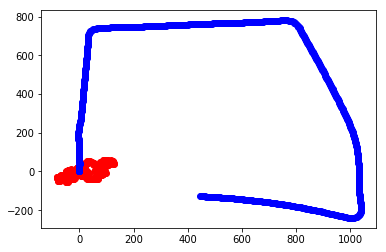

Count:3191
()
()
Relative Depth: 45.91176811630291
Relative x: -52.22890175311686
Relative Original Depth: 127.83084849727696
Relative Original x: 443.2839660427781
Count:3192
()
()
Relative Depth: 46.03233953865878
Relative x: -53.22068045987741
Relative Original Depth: 127.81243423483944
Relative Original x: 442.2841360317292
Count:3193
()
()
Relative Depth: 46.42225216489495
Relative x: -54.14136427731287
Relative Original Depth: 127.72113342728434
Relative Original x: 441.288327243937
Count:3194
()
()
Relative Depth: 47.007298182558465
Relative x: -54.94175110739953
Relative Original Depth: 127.62695013272187
Relative Original x: 440.29277246257533
Count:3195
()
()
Relative Depth: 47.8382907527699
Relative x: -55.45774175510061
Relative Original Depth: 127.56203595044519
Relative Original x: 439.29515354729426


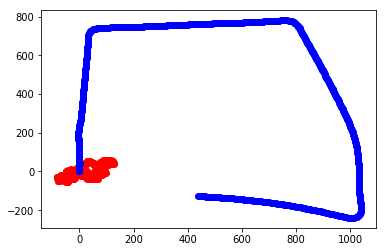

Count:3196
()
()
Relative Depth: 48.78975681207915
Relative x: -55.6820312628442
Relative Original Depth: 127.50808591049326
Relative Original x: 438.29666975858805
Count:3197
()
()
Relative Depth: 49.7620618605092
Relative x: -55.63498640553675
Relative Original Depth: 127.43531959196126
Relative Original x: 437.29937296852444
Count:3198
()
()
Relative Depth: 50.75597321469034
Relative x: -55.570316962621874
Relative Original Depth: 127.41381346647691
Relative Original x: 436.3002228816771
Count:3199
()
()
Relative Depth: 50.308887669051614
Relative x: -54.7725415825725
Relative Original Depth: 127.40350223742698
Relative Original x: 435.3007004707012
Count:3200
()
()
Relative Depth: 51.304124527392254
Relative x: -54.86833194915574
Relative Original Depth: 127.36625024271616
Relative Original x: 434.30139756388246


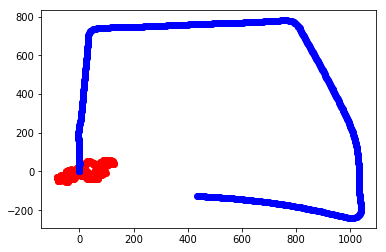

Count:3201
()
()
Relative Depth: 52.299848082545076
Relative x: -54.89060599637386
Relative Original Depth: 127.30767312232135
Relative Original x: 433.30330082899377
Count:3202
()
()
Relative Depth: 53.29090220549255
Relative x: -55.01505846725179
Relative Original Depth: 127.23336513519097
Relative Original x: 432.3062734007187
Count:3203
()
()
Relative Depth: 54.25529492557804
Relative x: -55.27942364500211
Relative Original Depth: 127.18149684788821
Relative Original x: 431.3076638544194
Count:3204
()
()
Relative Depth: 53.487633556678865
Relative x: -55.78844000124167
Relative Original Depth: 127.16557891747142
Relative Original x: 430.3079180813507
Count:3205
()
()
Relative Depth: 54.40393239775048
Relative x: -56.182277086106254
Relative Original Depth: 127.0622509994004
Relative Original x: 429.3133136913037


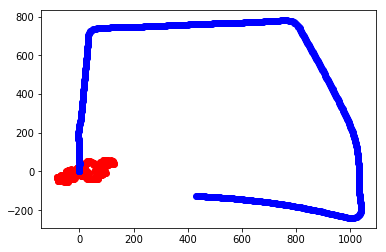

Count:3206
()
()
Relative Depth: 53.792178566953076
Relative x: -56.32782120711964
Relative Original Depth: 126.99624530343385
Relative Original x: 428.3155586817206
Count:3207
()
()
Relative Depth: 53.78974025902074
Relative x: -55.449686761457905
Relative Original Depth: 126.91121959712024
Relative Original x: 427.3191946871814
Count:3208
()
()
Relative Depth: 54.6985814732719
Relative x: -55.837032837912396
Relative Original Depth: 126.86653375600143
Relative Original x: 426.3204002557413
Count:3209
()
()
Relative Depth: 55.664337917883785
Relative x: -56.00867637599298
Relative Original Depth: 126.85821738328256
Relative Original x: 425.32043943432166
Count:3210
()
()
Relative Depth: 55.073217960615864
Relative x: -55.208863557249096
Relative Original Depth: 126.83421253293517
Relative Original x: 424.3208183012358


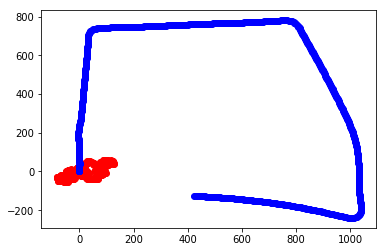

Count:3211
()
()
Relative Depth: 56.069086260346594
Relative x: -55.20932440376899
Relative Original Depth: 126.74392987884129
Relative Original x: 423.32490213163106
Count:3212
()
()
Relative Depth: 56.95190961072292
Relative x: -55.1185817105524
Relative Original Depth: 126.69468905888759
Relative Original x: 422.32630631935893
Count:3213
()
()
Relative Depth: 56.968071404497344
Relative x: -55.92217520846825
Relative Original Depth: 126.66033842726682
Relative Original x: 421.3274315421183
Count:3214
()
()
Relative Depth: 57.28821386261082
Relative x: -56.092102608886464
Relative Original Depth: 126.59810647787855
Relative Original x: 420.3296181684419
Count:3215
()
()
Relative Depth: 57.309226304447385
Relative x: -56.85565865839449
Relative Original Depth: 126.61542608078533
Relative Original x: 419.3299933502959


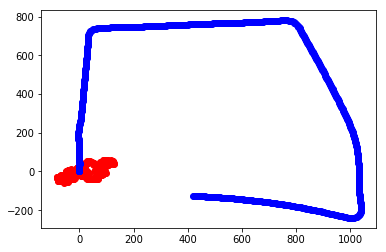

Count:3216
()
()
Relative Depth: 57.343968071573265
Relative x: -57.80529164338978
Relative Original Depth: 126.57661400234203
Relative Original x: 418.3307468388873
Count:3217
()
()
Relative Depth: 57.58965671399061
Relative x: -58.679016537233814
Relative Original Depth: 126.53233556228369
Relative Original x: 417.33175916126294
Count:3218
()
()
Relative Depth: 57.94480978422869
Relative x: -59.51025046967075
Relative Original Depth: 126.45234008511748
Relative Original x: 416.335049272434
Count:3219
()
()
Relative Depth: 58.32848107710863
Relative x: -60.34560228068345
Relative Original Depth: 126.33961813079459
Relative Original x: 415.3414249988367
Count:3220
()
()
Relative Depth: 58.729330202314834
Relative x: -61.12638517517341
Relative Original Depth: 126.22047531285465
Relative Original x: 414.3489899647016


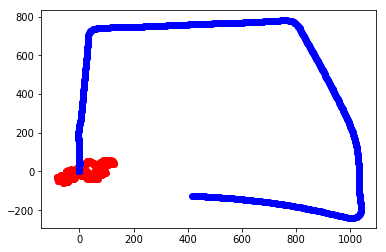

Count:3221
()
()
Relative Depth: 59.1112547454161
Relative x: -61.87559128885903
Relative Original Depth: 126.12637394705105
Relative Original x: 413.353440546163
Count:3222
()
()
Relative Depth: 59.892182294820664
Relative x: -62.38810386016588
Relative Original Depth: 126.05190884089048
Relative Original x: 412.3562180600752
Count:3223
()
()
Relative Depth: 60.858529648350036
Relative x: -62.643610107880605
Relative Original Depth: 125.9554478286941
Relative Original x: 411.3609979720659
Count:3224
()
()
Relative Depth: 61.787897440314204
Relative x: -62.928194400639825
Relative Original Depth: 125.92835501090656
Relative Original x: 410.36162281636535
Count:3225
()
()
Relative Depth: 62.73657318661068
Relative x: -62.957506091946
Relative Original Depth: 125.8764633134426
Relative Original x: 409.36331339448196


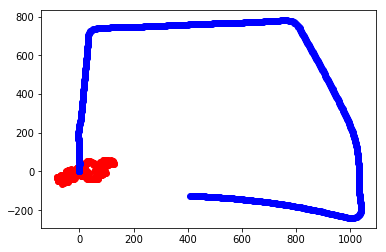

Count:3226
()
()
Relative Depth: 63.70026279989123
Relative x: -62.80096734364425
Relative Original Depth: 125.811793870056
Relative Original x: 408.3655728448299
Count:3227
()
()
Relative Depth: 64.66449867068825
Relative x: -62.55289919267319
Relative Original Depth: 125.78459929263501
Relative Original x: 407.36601747880087
Count:3228
()
()
Relative Depth: 65.56778450019378
Relative x: -62.26942054392366
Relative Original Depth: 125.71116953393941
Relative Original x: 406.3688015324589
Count:3229
()
()
Relative Depth: 66.53256925958684
Relative x: -62.07133675751247
Relative Original Depth: 125.68246473770539
Relative Original x: 405.36924699185903
Count:3230
()
()
Relative Depth: 67.49176905829428
Relative x: -61.82054895767773
Relative Original Depth: 125.65099230210198
Relative Original x: 404.36982593685127


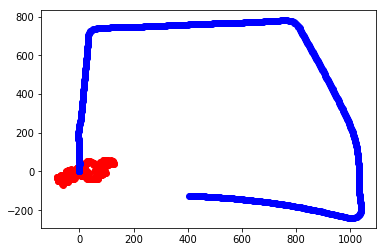

Count:3231
()
()
Relative Depth: 68.23120582292903
Relative x: -61.29748897352359
Relative Original Depth: 125.57957471057325
Relative Original x: 403.37238699631837
Count:3232
()
()
Relative Depth: 68.74811721577542
Relative x: -60.6438361489538
Relative Original Depth: 125.53811837878202
Relative Original x: 402.3748876275108
Count:3233
()
()
Relative Depth: 69.20436053427005
Relative x: -60.06687271280486
Relative Original Depth: 125.44093063723786
Relative Original x: 401.38006697278735
Count:3234
()
()
Relative Depth: 69.72845962238824
Relative x: -59.49210823674985
Relative Original Depth: 125.46254008191056
Relative Original x: 400.38086134245714
Count:3235
()
()
Relative Depth: 70.31705599226459
Relative x: -58.91419863079327
Relative Original Depth: 125.42564015415658
Relative Original x: 399.3819212177987


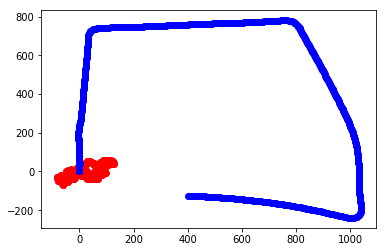

Count:3236
()
()
Relative Depth: 70.75776091694988
Relative x: -58.06529621200034
Relative Original Depth: 125.35736721571534
Relative Original x: 398.38433979233986
Count:3237
()
()
Relative Depth: 70.95402265062125
Relative x: -57.17677706069259
Relative Original Depth: 125.39619884414375
Relative Original x: 397.38513543106154
Count:3238
()
()
Relative Depth: 71.1845228634937
Relative x: -56.40736635470385
Relative Original Depth: 125.35828816652474
Relative Original x: 396.38645394855706
Count:3239
()
()
Relative Depth: 71.81985709623103
Relative x: -55.70744913298973
Relative Original Depth: 125.28705591481635
Relative Original x: 395.3907974356125
Count:3240
()
()
Relative Depth: 72.6283797486762
Relative x: -55.18742009901202
Relative Original Depth: 125.2686820920702
Relative Original x: 394.398128678226


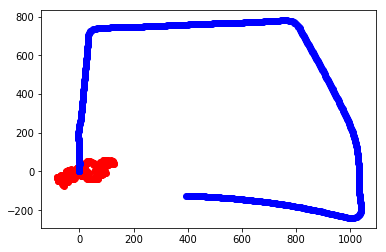

Count:3241
()
()
Relative Depth: 72.85228415949577
Relative x: -54.863723949437166
Relative Original Depth: 125.27126593189207
Relative Original x: 393.40104556750356
Count:3242
()
()
Relative Depth: 72.31588561933455
Relative x: -54.81229161015951
Relative Original Depth: 125.15188239542113
Relative Original x: 392.4097475298298
Count:3243
()
()
Relative Depth: 71.64800125788146
Relative x: -54.823152343493106
Relative Original Depth: 125.11712734615104
Relative Original x: 391.4104371186439
Count:3244
()
()
Relative Depth: 72.38448518410354
Relative x: -55.49363438564273
Relative Original Depth: 124.93776798344685
Relative Original x: 390.4266781396481
Count:3245
()
()
Relative Depth: 72.45490835178731
Relative x: -55.41910738004075
Relative Original Depth: 124.78441098954367
Relative Original x: 389.43963408232537


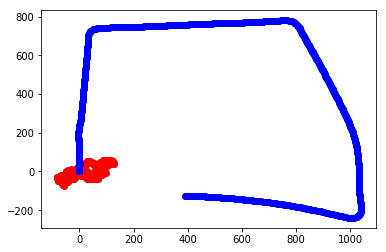

Count:3246
()
()
Relative Depth: 72.64215707864663
Relative x: -55.965279176714766
Relative Original Depth: 124.70898254415295
Relative Original x: 388.445039769549
Count:3247
()
()
Relative Depth: 72.7304963583943
Relative x: -56.5297277374497
Relative Original Depth: 124.70951272794287
Relative Original x: 387.4474298965694
Count:3248
()
()
Relative Depth: 72.62601814710204
Relative x: -56.79899167447497
Relative Original Depth: 124.64075365725135
Relative Original x: 386.456160836037
Count:3249
()
()
Relative Depth: 72.88346183539608
Relative x: -56.83587269081771
Relative Original Depth: 124.64863008210449
Relative Original x: 385.45784429680674
Count:3250
()
()
Relative Depth: 73.67269314846895
Relative x: -56.907448612860385
Relative Original Depth: 124.60527332549108
Relative Original x: 384.4589726301133


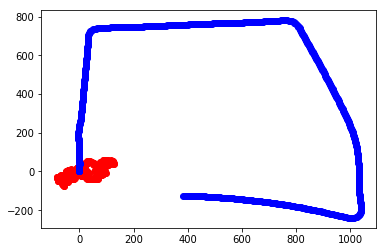

Count:3251
()
()
Relative Depth: 74.27381887576182
Relative x: -57.14388907344138
Relative Original Depth: 124.50258056441035
Relative Original x: 383.46712038045587
Count:3252
()
()
Relative Depth: 74.67351777779616
Relative x: -57.49536032814915
Relative Original Depth: 124.43451653471774
Relative Original x: 382.47040600942853
Count:3253
()
()
Relative Depth: 74.98191297185033
Relative x: -57.897015069661556
Relative Original Depth: 124.33448159680951
Relative Original x: 381.47775199953935
Count:3254
()
()
Relative Depth: 75.2302576881719
Relative x: -58.40347541523753
Relative Original Depth: 124.27580368921019
Relative Original x: 380.4820024512581
Count:3255
()
()
Relative Depth: 75.76430903210391
Relative x: -58.772845538801064
Relative Original Depth: 124.17520125250941
Relative Original x: 379.487079840908


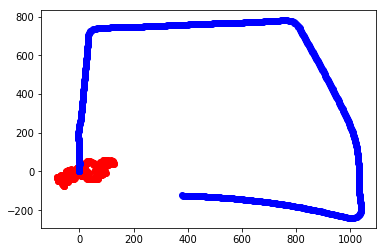

Count:3256
()
()
Relative Depth: 76.47532138483416
Relative x: -58.74545616228533
Relative Original Depth: 124.1039164378307
Relative Original x: 378.4900213409494
Count:3257
()
()
Relative Depth: 76.96765368840012
Relative x: -58.7107956347899
Relative Original Depth: 124.0833573560771
Relative Original x: 377.4902643828845
Count:3258
()
()
Relative Depth: 77.69949755985398
Relative x: -58.60772153259978
Relative Original Depth: 124.0914528046163
Relative Original x: 376.49056249509096
Count:3259
()
()
Relative Depth: 78.62265910549445
Relative x: -58.73153269544452
Relative Original Depth: 123.97576083641003
Relative Original x: 375.49739724465803
Count:3260
()
()
Relative Depth: 77.81056940995623
Relative x: -58.937759342600586
Relative Original Depth: 123.88061634807441
Relative Original x: 374.50195499490223


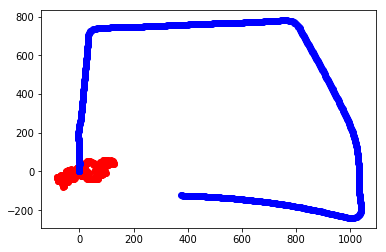

Count:3261
()
()
Relative Depth: 78.55847775247543
Relative x: -59.47483852854432
Relative Original Depth: 123.70455325863603
Relative Original x: 373.51778688307724
Count:3262
()
()
Relative Depth: 79.40020679896361
Relative x: -59.92467740728502
Relative Original Depth: 123.6775699042869
Relative Original x: 372.51938359802455
Count:3263
()
()
Relative Depth: 79.31540500189664
Relative x: -59.76975997469663
Relative Original Depth: 123.63657890586778
Relative Original x: 371.5202423689046
Count:3264
()
()
Relative Depth: 79.90106070341304
Relative x: -60.210241387576566
Relative Original Depth: 123.65907754321886
Relative Original x: 370.52473559688934
Count:3265
()
()
Relative Depth: 79.64327834308878
Relative x: -60.696038983655185
Relative Original Depth: 123.58865739384565
Relative Original x: 369.52721875560263


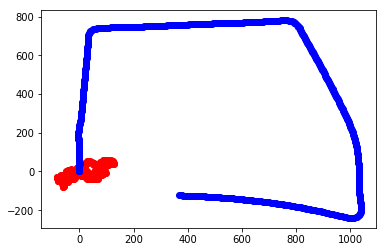

Count:3266
()
()
Relative Depth: 79.31374090337923
Relative x: -60.898333434811484
Relative Original Depth: 123.46084542654138
Relative Original x: 368.5367431372906
Count:3267
()
()
Relative Depth: 79.60716331679005
Relative x: -60.88430294037045
Relative Original Depth: 123.36450250718701
Relative Original x: 367.54177238499426
Count:3268
()
()
Relative Depth: 80.13210934460457
Relative x: -60.87973413141089
Relative Original Depth: 123.3273816261219
Relative Original x: 366.5429967482079
Count:3269
()
()
Relative Depth: 80.67941669406628
Relative x: -60.803625135387925
Relative Original Depth: 123.28976306963605
Relative Original x: 365.5437757579827
Count:3270
()
()
Relative Depth: 81.09734765594115
Relative x: -60.58548433256176
Relative Original Depth: 123.20017958481473
Relative Original x: 364.54780014681296


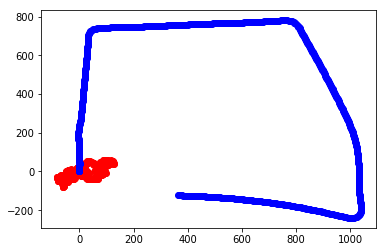

Count:3271
()
()
Relative Depth: 81.55104393624391
Relative x: -60.11773235682593
Relative Original Depth: 123.0994750751704
Relative Original x: 363.55320361334446
Count:3272
()
()
Relative Depth: 81.8226348237441
Relative x: -59.45345399533571
Relative Original Depth: 123.03571252918466
Relative Original x: 362.55530767994316
Count:3273
()
()
Relative Depth: 82.12007267196796
Relative x: -58.710893635498024
Relative Original Depth: 122.96667986354612
Relative Original x: 361.5606833473034
Count:3274
()
()
Relative Depth: 82.7847999410635
Relative x: -58.070065278266675
Relative Original Depth: 122.91079767813542
Relative Original x: 360.56257230065125
Count:3275
()
()
Relative Depth: 83.53025029497847
Relative x: -57.53620631481671
Relative Original Depth: 122.82761094959187
Relative Original x: 359.5683082051475


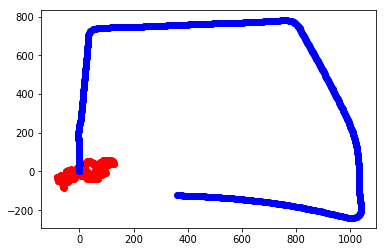

Count:3276
()
()
Relative Depth: 83.96089778988296
Relative x: -56.8250547062095
Relative Original Depth: 122.8256888166711
Relative Original x: 358.57024311924806
Count:3277
()
()
Relative Depth: 83.88155716254565
Relative x: -56.076054800796626
Relative Original Depth: 122.81353861040519
Relative Original x: 357.5704565443733
Count:3278
()
()
Relative Depth: 83.7723736464346
Relative x: -55.361025311443996
Relative Original Depth: 122.77162630138756
Relative Original x: 356.5713541391317
Count:3279
()
()
Relative Depth: 83.02787749150707
Relative x: -54.902737845759155
Relative Original Depth: 122.68078474846295
Relative Original x: 355.57719962673644
Count:3280
()
()
Relative Depth: 82.8722804862413
Relative x: -54.23352131466653
Relative Original Depth: 122.62327342999309
Relative Original x: 354.57891585930207


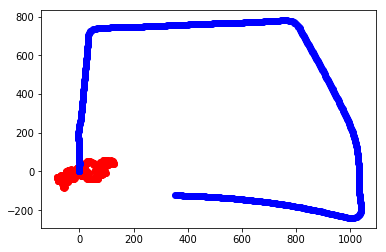

Count:3281
()
()
Relative Depth: 82.2629074937851
Relative x: -53.73381098839067
Relative Original Depth: 122.63587576486194
Relative Original x: 353.57984807668265
Count:3282
()
()
Relative Depth: 81.33239055760887
Relative x: -53.60852477656152
Relative Original Depth: 122.6098852751201
Relative Original x: 352.5804002154402
Count:3283
()
()
Relative Depth: 80.38689753748872
Relative x: -53.608171564109966
Relative Original Depth: 122.51097471160948
Relative Original x: 351.58541141385695
Count:3284
()
()
Relative Depth: 79.46245068519485
Relative x: -53.33599568277416
Relative Original Depth: 122.46014776660422
Relative Original x: 350.5872179887915
Count:3285
()
()
Relative Depth: 78.78469172978528
Relative x: -52.607657444250535
Relative Original Depth: 122.31645547902528
Relative Original x: 349.59849070781326


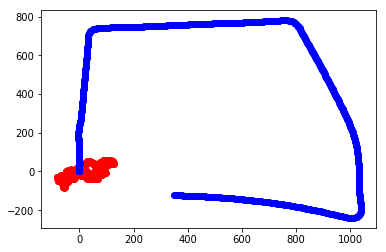

Count:3286
()
()
Relative Depth: 78.40907810730282
Relative x: -51.70706774169559
Relative Original Depth: 122.2585358263176
Relative Original x: 348.6002200077777
Count:3287
()
()
Relative Depth: 77.89809884393256
Relative x: -50.85685748952789
Relative Original Depth: 122.27010511710306
Relative Original x: 347.6008012401594
Count:3288
()
()
Relative Depth: 77.07018581250188
Relative x: -50.991151079450084
Relative Original Depth: 122.24510020670058
Relative Original x: 346.60111411926647
Count:3289
()
()
Relative Depth: 76.33703169171838
Relative x: -50.356681862999764
Relative Original Depth: 122.20873699299909
Relative Original x: 345.60181879429916
Count:3290
()
()
Relative Depth: 75.52401718423413
Relative x: -49.809270606213786
Relative Original Depth: 122.19042198518926
Relative Original x: 344.6021053901873


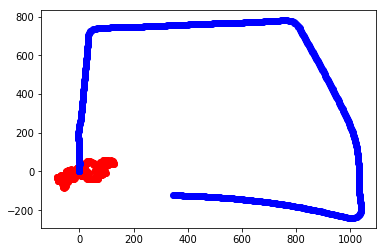

Count:3291
()
()
Relative Depth: 74.81346050849693
Relative x: -49.10762995813007
Relative Original Depth: 122.18088170828723
Relative Original x: 343.6021812966688
Count:3292
()
()
Relative Depth: 74.27173560443958
Relative x: -48.27036172361662
Relative Original Depth: 122.1454141622376
Relative Original x: 342.602817781874
Count:3293
()
()
Relative Depth: 73.31976939292682
Relative x: -48.31564198063838
Relative Original Depth: 122.09157962385697
Relative Original x: 341.6043140716086
Count:3294
()
()
Relative Depth: 72.7393015014623
Relative x: -47.56994217963916
Relative Original Depth: 122.01079670336769
Relative Original x: 340.60761828590273
Count:3295
()
()
Relative Depth: 71.85173571113735
Relative x: -47.14752449345253
Relative Original Depth: 121.90463341263754
Relative Original x: 339.61327879441006


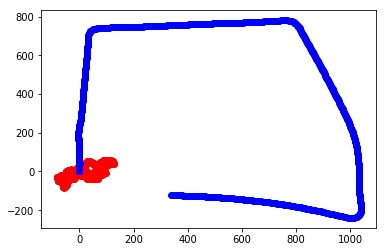

Count:3296
()
()
Relative Depth: 70.8760669620514
Relative x: -47.26270308205624
Relative Original Depth: 121.88204424481209
Relative Original x: 338.61437322100267
Count:3297
()
()
Relative Depth: 70.20467416072599
Relative x: -47.92922058029207
Relative Original Depth: 121.80882686290228
Relative Original x: 337.6170572975828
Count:3298
()
()
Relative Depth: 69.7736065885674
Relative x: -48.794609058495666
Relative Original Depth: 121.75480592448126
Relative Original x: 336.6189442137018
Count:3299
()
()
Relative Depth: 69.7328993006632
Relative x: -49.77593189403519
Relative Original Depth: 121.77213699095178
Relative Original x: 335.61912214178614
Count:3300
()
()
Relative Depth: 69.50505875695465
Relative x: -50.69847297620267
Relative Original Depth: 121.6724054351634
Relative Original x: 334.62412288933643


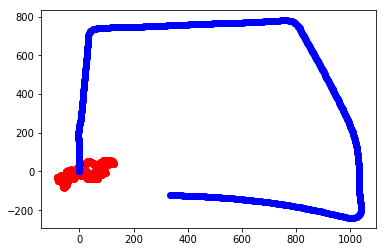

Count:3301
()
()
Relative Depth: 69.88107483428992
Relative x: -51.624285407120105
Relative Original Depth: 121.64382977326794
Relative Original x: 333.6245666015269
Count:3302
()
()
Relative Depth: 70.07995398928428
Relative x: -52.59978832117115
Relative Original Depth: 121.61630374085576
Relative Original x: 332.624960333175
Count:3303
()
()
Relative Depth: 71.0421646379387
Relative x: -52.70532589454879
Relative Original Depth: 121.53583320652012
Relative Original x: 331.6291119435094
Count:3304
()
()
Relative Depth: 71.16422340385117
Relative x: -53.69088282556261
Relative Original Depth: 121.50430213062991
Relative Original x: 330.6296626646068
Count:3305
()
()
Relative Depth: 71.33648653727049
Relative x: -54.662863111795005
Relative Original Depth: 121.42776338164961
Relative Original x: 329.6329685455006


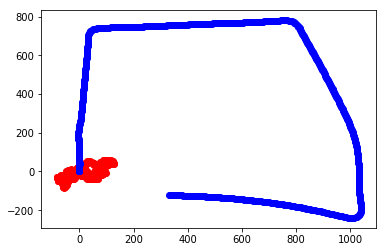

Count:3306
()
()
Relative Depth: 72.00574748990731
Relative x: -55.26421715217572
Relative Original Depth: 121.35534763307912
Relative Original x: 328.6365852192793
Count:3307
()
()
Relative Depth: 72.58195955811124
Relative x: -54.684376934057134
Relative Original Depth: 121.26586079021143
Relative Original x: 327.6412533822232
Count:3308
()
()
Relative Depth: 72.58252006334138
Relative x: -53.747007182621054
Relative Original Depth: 121.23867862671719
Relative Original x: 326.64168094618503
Count:3309
()
()
Relative Depth: 73.28095140494258
Relative x: -53.134134107494305
Relative Original Depth: 121.25522104976038
Relative Original x: 325.64196208158216
Count:3310
()
()
Relative Depth: 72.79504243827118
Relative x: -52.547201265653776
Relative Original Depth: 121.22195392412138
Relative Original x: 324.6425981442123


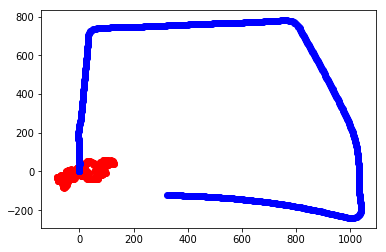

Count:3311
()
()
Relative Depth: 72.59357866560376
Relative x: -53.416059956897996
Relative Original Depth: 121.20575980208294
Relative Original x: 323.6427435271321
Count:3312
()
()
Relative Depth: 73.50523543043083
Relative x: -53.627743107688964
Relative Original Depth: 121.11185607602376
Relative Original x: 322.6473565195254
Count:3313
()
()
Relative Depth: 74.40819410745917
Relative x: -53.794467468536475
Relative Original Depth: 121.09061598188532
Relative Original x: 321.6476660320546
Count:3314
()
()
Relative Depth: 75.35928761682787
Relative x: -53.93973502361148
Relative Original Depth: 121.01997289491457
Relative Original x: 320.65021768295344
Count:3315
()
()
Relative Depth: 76.07068416059906
Relative x: -54.08151152328928
Relative Original Depth: 120.95000885124792
Relative Original x: 319.65274732471715


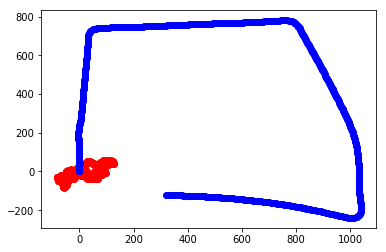

Count:3316
()
()
Relative Depth: 76.2529283147574
Relative x: -54.270504634895424
Relative Original Depth: 120.89972448548151
Relative Original x: 318.6540123954276
Count:3317
()
()
Relative Depth: 76.1217800326864
Relative x: -54.52175819019292
Relative Original Depth: 120.8305707402401
Relative Original x: 317.6564211557101
Count:3318
()
()
Relative Depth: 75.74470077767808
Relative x: -55.16952940437927
Relative Original Depth: 120.75950376452785
Relative Original x: 316.6589748514028
Count:3319
()
()
Relative Depth: 75.44777007670301
Relative x: -56.10598462233666
Relative Original Depth: 120.68013503243981
Relative Original x: 315.6622448760491
Count:3320
()
()
Relative Depth: 75.23156124802762
Relative x: -57.07905981091731
Relative Original Depth: 120.65642696943173
Relative Original x: 314.66262673389946


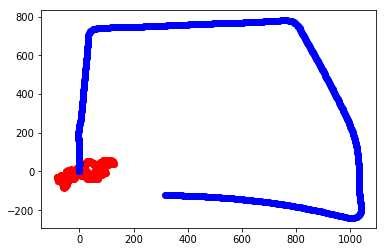

Count:3321
()
()
Relative Depth: 75.05692041839171
Relative x: -58.00355815939883
Relative Original Depth: 120.672087749079
Relative Original x: 313.66302276558815
Count:3322
()
()
Relative Depth: 74.33768255589466
Relative x: -57.83423695249751
Relative Original Depth: 120.61256742576522
Relative Original x: 312.6649056017015
Count:3323
()
()
Relative Depth: 74.2060882880436
Relative x: -58.69175757336242
Relative Original Depth: 120.55700249656392
Relative Original x: 311.6666551156655
Count:3324
()
()
Relative Depth: 74.59826589410851
Relative x: -58.926849968282596
Relative Original Depth: 120.54374562422078
Relative Original x: 310.6674295062606
Count:3325
()
()
Relative Depth: 74.559707652542
Relative x: -59.8062746647411
Relative Original Depth: 120.55291667403819
Relative Original x: 309.66827930722945


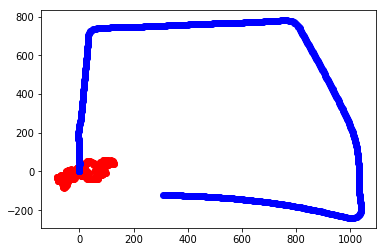

Count:3326
()
()
Relative Depth: 74.55332574807164
Relative x: -60.63351136198025
Relative Original Depth: 120.52941806916476
Relative Original x: 308.66856109734215
Count:3327
()
()
Relative Depth: 74.64713906837338
Relative x: -61.28652107598354
Relative Original Depth: 120.55004401907405
Relative Original x: 307.6689303772086
Count:3328
()
()
Relative Depth: 75.04361764193976
Relative x: -60.66760246149963
Relative Original Depth: 120.546802651661
Relative Original x: 306.6689533243618
Count:3329
()
()
Relative Depth: 75.75447086793253
Relative x: -61.023208824670654
Relative Original Depth: 120.5058776717883
Relative Original x: 305.67021245654973
Count:3330
()
()
Relative Depth: 76.73000316721176
Relative x: -61.16898104385462
Relative Original Depth: 120.53712674291582
Relative Original x: 304.6711154953535


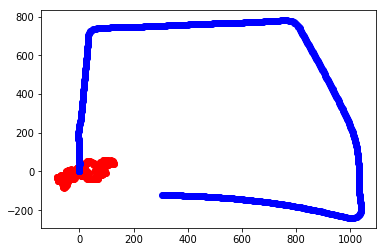

Count:3331
()
()
Relative Depth: 77.72171247756589
Relative x: -61.14483142603455
Relative Original Depth: 120.49072325679953
Relative Original x: 303.6722013672916
Count:3332
()
()
Relative Depth: 78.62356528464436
Relative x: -60.738001199669604
Relative Original Depth: 120.41811114449533
Relative Original x: 302.67521703468975
Count:3333
()
()
Relative Depth: 79.40811189319335
Relative x: -60.14954789934257
Relative Original Depth: 120.42060369187523
Relative Original x: 301.6753541256383
Count:3334
()
()
Relative Depth: 80.24583200245173
Relative x: -59.612045239294964
Relative Original Depth: 120.37812762824174
Relative Original x: 300.67759067850693
Count:3335
()
()
Relative Depth: 81.11880483194433
Relative x: -59.1394378380701
Relative Original Depth: 120.33116488971594
Relative Original x: 299.6789257269302


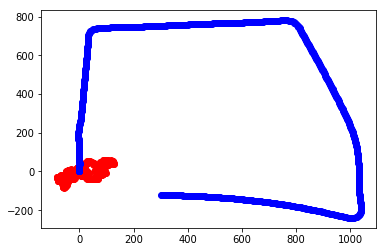

Count:3336
()
()
Relative Depth: 81.98180631088972
Relative x: -58.73574617323441
Relative Original Depth: 120.28206334776476
Relative Original x: 298.68020202580226
Count:3337
()
()
Relative Depth: 81.862971772881
Relative x: -57.813015084636845
Relative Original Depth: 120.26980888716818
Relative Original x: 297.6808058186846
Count:3338
()
()
Relative Depth: 81.53361733993535
Relative x: -56.88499486052247
Relative Original Depth: 120.26436444063205
Relative Original x: 296.68083553785675
Count:3339
()
()
Relative Depth: 82.3775354888312
Relative x: -56.42273515031522
Relative Original Depth: 120.22575039479554
Relative Original x: 295.6825460261074
Count:3340
()
()
Relative Depth: 83.23434582359646
Relative x: -55.91156587000874
Relative Original Depth: 120.18347447807612
Relative Original x: 294.68344239793583


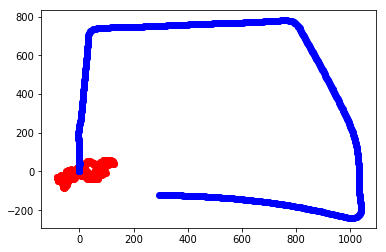

Count:3341
()
()
Relative Depth: 84.11627606666414
Relative x: -55.44034094332411
Relative Original Depth: 120.1563795725151
Relative Original x: 293.68380969439806
Count:3342
()
()
Relative Depth: 84.96249387309513
Relative x: -54.925089081895116
Relative Original Depth: 120.1208442930095
Relative Original x: 292.684442895666
Count:3343
()
()
Relative Depth: 85.73205406096363
Relative x: -54.38872599330374
Relative Original Depth: 120.06083624946946
Relative Original x: 291.6864313702049
Count:3344
()
()
Relative Depth: 86.48707825743084
Relative x: -53.883521327778645
Relative Original Depth: 120.01839451096491
Relative Original x: 290.6874419873571
Count:3345
()
()
Relative Depth: 87.36927753078167
Relative x: -53.68266200704189
Relative Original Depth: 119.99609988489465
Relative Original x: 289.68925610941534


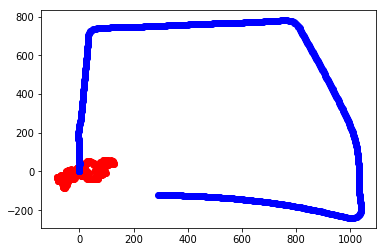

Count:3346
()
()
Relative Depth: 88.23301546809725
Relative x: -53.78025330548235
Relative Original Depth: 119.96486745709451
Relative Original x: 288.689845917365
Count:3347
()
()
Relative Depth: 89.06445427609675
Relative x: -53.773711478366316
Relative Original Depth: 119.85155923606398
Relative Original x: 287.6964018683303
Count:3348
()
()
Relative Depth: 90.04604979064896
Relative x: -53.945547961734725
Relative Original Depth: 119.82034375266092
Relative Original x: 286.69692580069255
Count:3349
()
()
Relative Depth: 90.68342580387552
Relative x: -54.59248066879865
Relative Original Depth: 119.80890852415972
Relative Original x: 285.6969940925893
Count:3350
()
()
Relative Depth: 91.239293490625
Relative x: -55.3597517372511
Relative Original Depth: 119.7499149494387
Relative Original x: 284.6987903861039


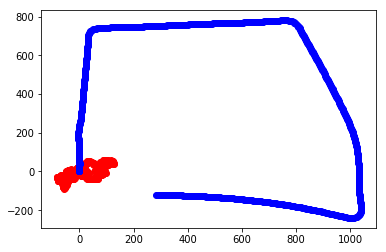

Count:3351
()
()
Relative Depth: 91.6492764832015
Relative x: -56.13271665603913
Relative Original Depth: 119.7515395564502
Relative Original x: 283.69888737709186
Count:3352
()
()
Relative Depth: 91.73263723659035
Relative x: -56.83126585204821
Relative Original Depth: 119.723265198225
Relative Original x: 282.69931203107393
Count:3353
()
()
Relative Depth: 91.89671756856386
Relative x: -57.47210939536383
Relative Original Depth: 119.64785657205069
Relative Original x: 281.702803803643
Count:3354
()
()
Relative Depth: 92.12820100424804
Relative x: -58.06291088109843
Relative Original Depth: 119.62485059429304
Relative Original x: 280.70315660063153
Count:3355
()
()
Relative Depth: 92.51120583805522
Relative x: -58.53301241417786
Relative Original Depth: 119.54809504408142
Relative Original x: 279.7061599392229


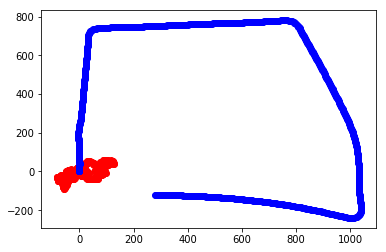

Count:3356
()
()
Relative Depth: 93.0556300911228
Relative x: -58.89696266994238
Relative Original Depth: 119.46747981052638
Relative Original x: 278.7096158069268
Count:3357
()
()
Relative Depth: 93.6347789673598
Relative x: -59.26494112805297
Relative Original Depth: 119.44593741721954
Relative Original x: 277.709850859859
Count:3358
()
()
Relative Depth: 93.98221679213165
Relative x: -58.456408632920734
Relative Original Depth: 119.44191123578202
Relative Original x: 276.71023322795315
Count:3359
()
()
Relative Depth: 93.15762148671438
Relative x: -58.91484256171452
Relative Original Depth: 119.41317691370877
Relative Original x: 275.7106482910451
Count:3360
()
()
Relative Depth: 92.50947190750632
Relative x: -59.651821886267484
Relative Original Depth: 119.37420844464661
Relative Original x: 274.7115386406275


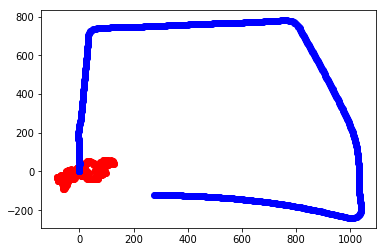

Count:3361
()
()
Relative Depth: 92.16762501665455
Relative x: -60.321230981998696
Relative Original Depth: 119.37586889737261
Relative Original x: 273.7115866363674
Count:3362
()
()
Relative Depth: 91.8986735542036
Relative x: -60.99148805892281
Relative Original Depth: 119.40066073147426
Relative Original x: 272.7125204500633
Count:3363
()
()
Relative Depth: 91.23533263667572
Relative x: -61.711171858063324
Relative Original Depth: 119.38269144782745
Relative Original x: 271.71283872595967
Count:3364
()
()
Relative Depth: 90.47778198220101
Relative x: -61.54453538784464
Relative Original Depth: 119.34194959889335
Relative Original x: 270.7138419361901
Count:3365
()
()
Relative Depth: 90.0749325873091
Relative x: -60.90000447553936
Relative Original Depth: 119.3063527280108
Relative Original x: 269.71450794663264


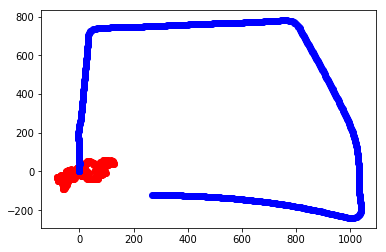

Count:3366
()
()
Relative Depth: 89.55779783882875
Relative x: -60.31497165340495
Relative Original Depth: 119.27758853881005
Relative Original x: 268.71521311924874
Count:3367
()
()
Relative Depth: 90.27198210581378
Relative x: -61.01476443024726
Relative Original Depth: 119.29346708785735
Relative Original x: 267.7153434686007
Count:3368
()
()
Relative Depth: 89.56995675793603
Relative x: -60.760244471360586
Relative Original Depth: 119.29852505685894
Relative Original x: 266.71539868242814
Count:3369
()
()
Relative Depth: 88.75930232795446
Relative x: -60.60860670330351
Relative Original Depth: 119.28132889986807
Relative Original x: 265.7156974377381
Count:3370
()
()
Relative Depth: 87.99842577913384
Relative x: -60.246409370465436
Relative Original Depth: 119.25074368345551
Relative Original x: 264.71616579992343


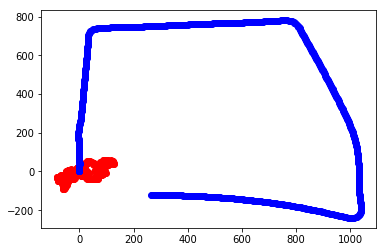

Count:3371
()
()
Relative Depth: 87.45097697383977
Relative x: -59.76177483702498
Relative Original Depth: 119.27815871885788
Relative Original x: 263.71659796008123
Count:3372
()
()
Relative Depth: 87.06552047386434
Relative x: -60.03330259669351
Relative Original Depth: 119.29047422051615
Relative Original x: 262.7166993979009
Count:3373
()
()
Relative Depth: 86.93878157661868
Relative x: -60.95591309550736
Relative Original Depth: 119.2702286935726
Relative Original x: 261.7169058026157
Count:3374
()
()
Relative Depth: 86.8970006230376
Relative x: -61.813281624612735
Relative Original Depth: 119.23817002449185
Relative Original x: 260.7175759376531
Count:3375
()
()
Relative Depth: 86.81716358692181
Relative x: -62.670586621371406
Relative Original Depth: 119.20879528380016
Relative Original x: 259.7180318748944


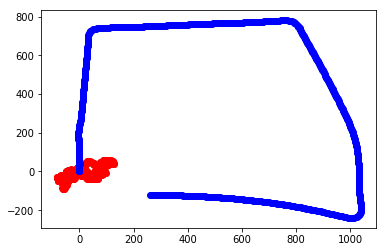

Count:3376
()
()
Relative Depth: 86.78987757092852
Relative x: -63.60869424423875
Relative Original Depth: 119.22861660073255
Relative Original x: 258.7184218532277
Count:3377
()
()
Relative Depth: 86.79276718378343
Relative x: -64.5951862714656
Relative Original Depth: 119.21880331554861
Relative Original x: 257.71847327430214
Count:3378
()
()
Relative Depth: 86.6870533784339
Relative x: -65.58211691484232
Relative Original Depth: 119.21447223157858
Relative Original x: 256.7186125503871
Count:3379
()
()
Relative Depth: 86.70694168115618
Relative x: -66.5799295865193
Relative Original Depth: 119.15958605345331
Relative Original x: 255.72095803570028
Count:3380
()
()
Relative Depth: 86.74075012804661
Relative x: -67.56360407593283
Relative Original Depth: 119.1376372909774
Relative Original x: 254.7231097528477


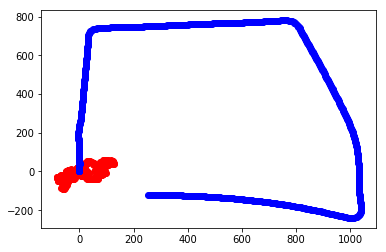

Count:3381
()
()
Relative Depth: 86.78301310078027
Relative x: -68.53876893463809
Relative Original Depth: 119.14139413131456
Relative Original x: 253.72365421078916
Count:3382
()
()
Relative Depth: 86.77669954392437
Relative x: -69.50229111867267
Relative Original Depth: 119.1502907946258
Relative Original x: 252.7243471539524
Count:3383
()
()
Relative Depth: 86.61077733805111
Relative x: -70.47348035133217
Relative Original Depth: 119.17101954101403
Relative Original x: 251.72466508538173
Count:3384
()
()
Relative Depth: 86.3777173738948
Relative x: -71.44517537522609
Relative Original Depth: 119.18590827722444
Relative Original x: 250.7248621309342
Count:3385
()
()
Relative Depth: 86.10413238746719
Relative x: -72.38997358370521
Relative Original Depth: 119.18172985033509
Relative Original x: 249.72487086648306


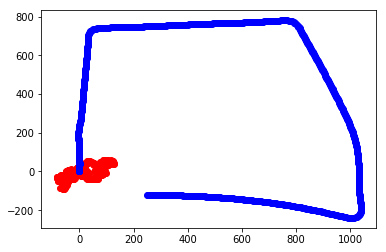

Count:3386
()
()
Relative Depth: 85.80734360177318
Relative x: -73.32204180141343
Relative Original Depth: 119.16037260753424
Relative Original x: 248.72550545310753
Count:3387
()
()
Relative Depth: 85.49062160188878
Relative x: -74.04464064501259
Relative Original Depth: 119.18173348483445
Relative Original x: 247.72647454835152
Count:3388
()
()
Relative Depth: 85.3356331136544
Relative x: -74.64625963976361
Relative Original Depth: 119.14677510257305
Relative Original x: 246.72765899221258
Count:3389
()
()
Relative Depth: 85.48953449811985
Relative x: -74.85519894125392
Relative Original Depth: 119.1520290304262
Relative Original x: 245.72799069945845
Count:3390
()
()
Relative Depth: 85.76046151190742
Relative x: -74.90414907345809
Relative Original Depth: 119.13035139258416
Relative Original x: 244.72843818075967


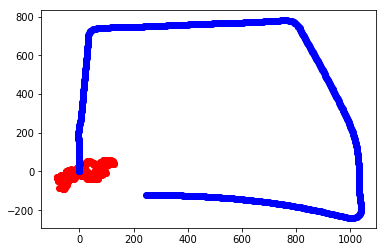

Count:3391
()
()
Relative Depth: 86.13681776750578
Relative x: -74.868798168922
Relative Original Depth: 119.13209309582666
Relative Original x: 243.7284398995577
Count:3392
()
()
Relative Depth: 86.46510336983722
Relative x: -74.24822855443733
Relative Original Depth: 119.14025428565184
Relative Original x: 242.72859858331339
Count:3393
()
()
Relative Depth: 86.48188643448343
Relative x: -74.10788032566923
Relative Original Depth: 119.1694887847239
Relative Original x: 241.72944404924255
Count:3394
()
()
Relative Depth: 85.90355416133815
Relative x: -74.09900416690222
Relative Original Depth: 119.19529307990452
Relative Original x: 240.730260084427
Count:3395
()
()
Relative Depth: 86.41202788609269
Relative x: -74.93874409669098
Relative Original Depth: 119.19532776426843
Relative Original x: 239.73046891457548


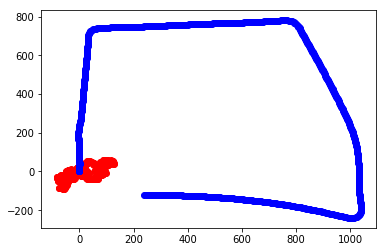

Count:3396
()
()
Relative Depth: 85.7284816157068
Relative x: -75.03039432684697
Relative Original Depth: 119.2312860342933
Relative Original x: 238.73180189960632
Count:3397
()
()
Relative Depth: 85.09359054771656
Relative x: -75.1640745384939
Relative Original Depth: 119.24958224951888
Relative Original x: 237.73202439755582
Count:3398
()
()
Relative Depth: 84.58885226693701
Relative x: -74.68249636234331
Relative Original Depth: 119.26586200714061
Relative Original x: 236.73241737428054
Count:3399
()
()
Relative Depth: 84.54304758830007
Relative x: -73.68520037932629
Relative Original Depth: 119.28087017034058
Relative Original x: 235.73292333538757
Count:3400
()
()
Relative Depth: 84.71834509056208
Relative x: -72.87652731720891
Relative Original Depth: 119.30341273154289
Relative Original x: 234.7332322571846


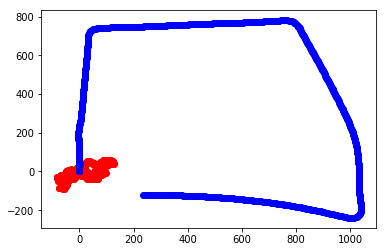

Count:3401
()
()
Relative Depth: 85.00095671603496
Relative x: -72.09626404743115
Relative Original Depth: 119.34883489409145
Relative Original x: 233.73431997923504
Count:3402
()
()
Relative Depth: 85.49227901432145
Relative x: -72.4984747542467
Relative Original Depth: 119.36848997691692
Relative Original x: 232.73451385311807
Count:3403
()
()
Relative Depth: 84.67054369337393
Relative x: -72.89546837602863
Relative Original Depth: 119.37991692685989
Relative Original x: 231.73458122410145
Count:3404
()
()
Relative Depth: 83.76991962550221
Relative x: -72.98516856712344
Relative Original Depth: 119.39083789314246
Relative Original x: 230.73469057868377
Count:3405
()
()
Relative Depth: 82.9228998913946
Relative x: -72.68634149237177
Relative Original Depth: 119.4053953222944
Relative Original x: 229.73487432116266


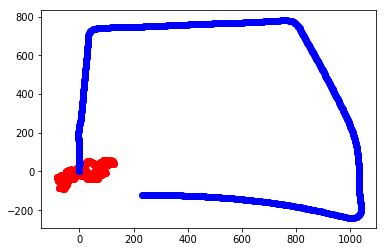

Count:3406
()
()
Relative Depth: 82.29640612379885
Relative x: -72.19919087293125
Relative Original Depth: 119.43188839990383
Relative Original x: 228.73526763358936
Count:3407
()
()
Relative Depth: 81.91776503875718
Relative x: -71.54280546825588
Relative Original Depth: 119.41848952172255
Relative Original x: 227.73544142842715
Count:3408
()
()
Relative Depth: 81.58241472466801
Relative x: -70.82416019111778
Relative Original Depth: 119.38415658891788
Relative Original x: 226.73603540186522
Count:3409
()
()
Relative Depth: 81.59727104239253
Relative x: -71.03028069129726
Relative Original Depth: 119.41576435770149
Relative Original x: 225.736672553656
Count:3410
()
()
Relative Depth: 81.30208125176247
Relative x: -70.24773777303878
Relative Original Depth: 119.41696515540809
Relative Original x: 224.73669012311998


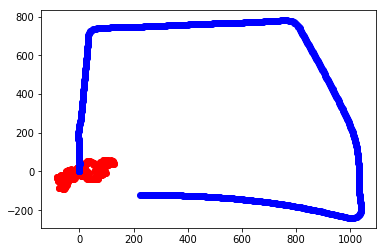

Count:3411
()
()
Relative Depth: 81.01566346936157
Relative x: -69.28999292572516
Relative Original Depth: 119.41772159909607
Relative Original x: 223.7371588959043
Count:3412
()
()
Relative Depth: 80.84510886660131
Relative x: -68.4023370594579
Relative Original Depth: 119.44994201123508
Relative Original x: 222.7379799747673
Count:3413
()
()
Relative Depth: 80.76976107435331
Relative x: -67.51326281972887
Relative Original Depth: 119.50169800591253
Relative Original x: 221.73934181539212
Count:3414
()
()
Relative Depth: 80.20282447951834
Relative x: -66.8304239228285
Relative Original Depth: 119.53675256645116
Relative Original x: 220.74024895244642
Count:3415
()
()
Relative Depth: 79.83816201168362
Relative x: -65.90330738425338
Relative Original Depth: 119.53748607380922
Relative Original x: 219.7402763650036


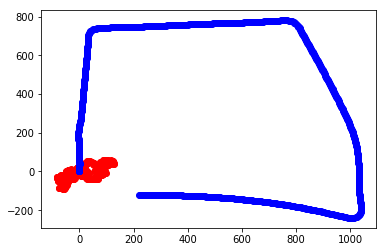

Count:3416
()
()
Relative Depth: 80.17666698949623
Relative x: -64.98098769322944
Relative Original Depth: 119.56032456607406
Relative Original x: 218.740539851147
Count:3417
()
()
Relative Depth: 80.47460057740525
Relative x: -64.05739659700494
Relative Original Depth: 119.61969154028684
Relative Original x: 217.74319107430097
Count:3418
()
()
Relative Depth: 80.75744587505902
Relative x: -63.12482065980723
Relative Original Depth: 119.64394871825422
Relative Original x: 216.7444576628045
Count:3419
()
()
Relative Depth: 80.97555866789192
Relative x: -63.45610565408507
Relative Original Depth: 119.65025355339752
Relative Original x: 215.74447816929012
Count:3420
()
()
Relative Depth: 80.90561830821359
Relative x: -62.48993746231727
Relative Original Depth: 119.68984097946984
Relative Original x: 214.74540019038741


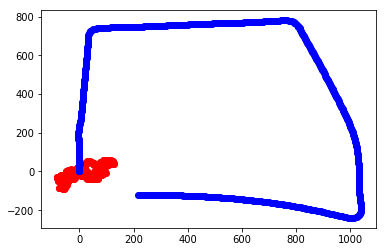

Count:3421
()
()
Relative Depth: 80.42953364170552
Relative x: -61.85936713363614
Relative Original Depth: 119.6990074249036
Relative Original x: 213.74547978680337
Count:3422
()
()
Relative Depth: 80.0442065428398
Relative x: -61.09303946551918
Relative Original Depth: 119.71726954037683
Relative Original x: 212.745652721013
Count:3423
()
()
Relative Depth: 79.76373434253672
Relative x: -60.205646374800594
Relative Original Depth: 119.63906683656751
Relative Original x: 211.7495772431569
Count:3424
()
()
Relative Depth: 79.25976790741889
Relative x: -59.41171572475738
Relative Original Depth: 119.676830563484
Relative Original x: 210.75043136118535
Count:3425
()
()
Relative Depth: 78.80211347263857
Relative x: -58.52641707303646
Relative Original Depth: 119.60172764558283
Relative Original x: 209.7532558495856


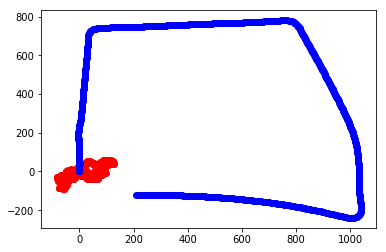

Count:3426
()
()
Relative Depth: 78.33336535071275
Relative x: -57.656361757885584
Relative Original Depth: 119.63054240999459
Relative Original x: 208.75370143288328
Count:3427
()
()
Relative Depth: 77.90772201539356
Relative x: -56.76922792283283
Relative Original Depth: 119.70729657636164
Relative Original x: 207.75665358650946
Count:3428
()
()
Relative Depth: 77.66229956634977
Relative x: -55.83009617136744
Relative Original Depth: 119.67483949326405
Relative Original x: 206.7572442073437
Count:3429
()
()
Relative Depth: 77.3456639531246
Relative x: -54.89735882187665
Relative Original Depth: 119.67918454386644
Relative Original x: 205.7578279746786
Count:3430
()
()
Relative Depth: 77.06382412763156
Relative x: -53.947164408837295
Relative Original Depth: 119.7196059029596
Relative Original x: 204.75865444717675


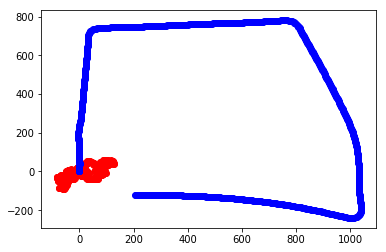

Count:3431
()
()
Relative Depth: 76.9750278667319
Relative x: -53.89701123886184
Relative Original Depth: 119.73482485819473
Relative Original x: 203.7601244910923
Count:3432
()
()
Relative Depth: 76.81856540013197
Relative x: -52.98198989739974
Relative Original Depth: 119.67429391979476
Relative Original x: 202.76197444732995
Count:3433
()
()
Relative Depth: 76.65023503908691
Relative x: -52.65854017844101
Relative Original Depth: 119.73135569379988
Relative Original x: 201.76417457243085
Count:3434
()
()
Relative Depth: 76.59645822033214
Relative x: -53.16768442941381
Relative Original Depth: 119.7672456640189
Relative Original x: 200.76486953177402
Count:3435
()
()
Relative Depth: 76.9939386231463
Relative x: -53.6412270965971
Relative Original Depth: 119.74152172648691
Relative Original x: 199.76520214312492


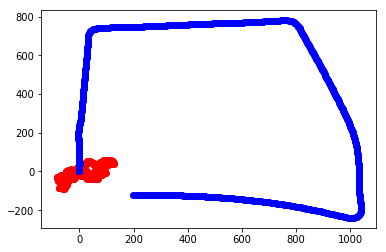

Count:3436
()
()
Relative Depth: 77.71235008384127
Relative x: -53.88281686774102
Relative Original Depth: 119.83616785304143
Relative Original x: 198.77009355663887
Count:3437
()
()
Relative Depth: 78.36489267229739
Relative x: -54.457654816655236
Relative Original Depth: 119.8724556871277
Relative Original x: 197.7707540877375
Count:3438
()
()
Relative Depth: 78.8425908594063
Relative x: -55.06519217428798
Relative Original Depth: 120.02413690761163
Relative Original x: 196.7829904286339
Count:3439
()
()
Relative Depth: 79.35085668971577
Relative x: -55.3812391571147
Relative Original Depth: 120.00914493954663
Relative Original x: 195.78373670274274
Count:3440
()
()
Relative Depth: 79.94145632162122
Relative x: -55.76932103291747
Relative Original Depth: 120.04698654577327
Relative Original x: 194.7846551907547


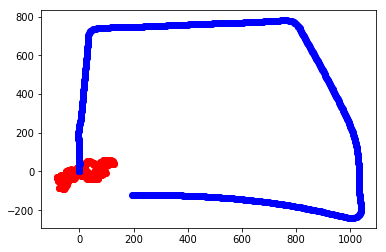

Count:3441
()
()
Relative Depth: 80.67374097637419
Relative x: -56.286946511462766
Relative Original Depth: 120.11847333445407
Relative Original x: 193.7872881637784
Count:3442
()
()
Relative Depth: 81.44544403920722
Relative x: -56.83435156254034
Relative Original Depth: 120.20066464212319
Relative Original x: 192.79081366153864
Count:3443
()
()
Relative Depth: 82.20110668487867
Relative x: -57.40068073491166
Relative Original Depth: 120.13039077073438
Relative Original x: 191.79444936555103
Count:3444
()
()
Relative Depth: 82.28581006582861
Relative x: -56.43723162403403
Relative Original Depth: 120.08941995018542
Relative Original x: 190.79540548653338
Count:3445
()
()
Relative Depth: 83.17029666620192
Relative x: -56.89994463503106
Relative Original Depth: 120.04570175106774
Relative Original x: 189.7968973962653


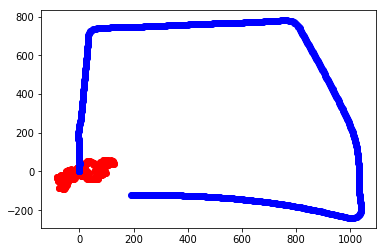

Count:3446
()
()
Relative Depth: 84.03853195916419
Relative x: -57.36778178053444
Relative Original Depth: 120.10649480617352
Relative Original x: 188.79887154142872
Count:3447
()
()
Relative Depth: 84.98341192719646
Relative x: -57.69153909256181
Relative Original Depth: 120.14739628811974
Relative Original x: 187.80044201511672
Count:3448
()
()
Relative Depth: 85.92712964625724
Relative x: -57.63069217381217
Relative Original Depth: 120.1891367680391
Relative Original x: 186.80167018475873
Count:3449
()
()
Relative Depth: 85.90084866994002
Relative x: -58.620732662745716
Relative Original Depth: 120.31679138318839
Relative Original x: 185.81119230715774
Count:3450
()
()
Relative Depth: 85.8589714869947
Relative x: -57.647818352920076
Relative Original Depth: 120.39710058899611
Relative Original x: 184.81442464068894


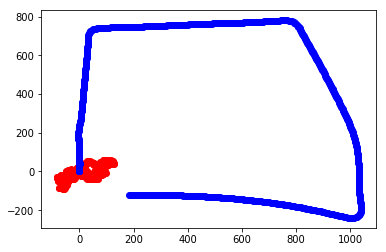

Count:3451
()
()
Relative Depth: 85.01978584660732
Relative x: -57.74236407351693
Relative Original Depth: 120.42697625633585
Relative Original x: 183.8161924679833
Count:3452
()
()
Relative Depth: 84.45056664922193
Relative x: -57.95162377085169
Relative Original Depth: 120.48970292625481
Relative Original x: 182.81819627204442
Count:3453
()
()
Relative Depth: 84.18832610266597
Relative x: -58.50270357517946
Relative Original Depth: 120.56235393936623
Relative Original x: 181.82085213893484
Count:3454
()
()
Relative Depth: 83.97521549736565
Relative x: -59.30961280416134
Relative Original Depth: 120.57956695886868
Relative Original x: 180.82193212383933
Count:3455
()
()
Relative Depth: 83.78220597336221
Relative x: -60.209423142451
Relative Original Depth: 120.64946634249891
Relative Original x: 179.8244487845392


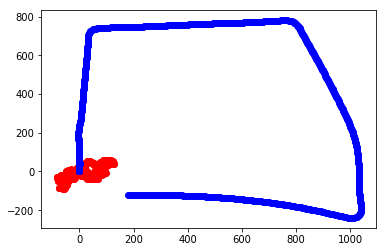

Count:3456
()
()
Relative Depth: 83.88985692325542
Relative x: -60.975802585181256
Relative Original Depth: 120.67679446535155
Relative Original x: 178.82618763402982
Count:3457
()
()
Relative Depth: 84.3332982448126
Relative x: -61.463780819638586
Relative Original Depth: 120.72537637473837
Relative Original x: 177.82744747674923
Count:3458
()
()
Relative Depth: 85.19664726109805
Relative x: -61.493494554531374
Relative Original Depth: 121.69704995577553
Relative Original x: 177.60809034474858
Count:3459
()
()
Relative Depth: 86.12152796430719
Relative x: -61.66960669536525
Relative Original Depth: 121.79403469551542
Relative Original x: 176.61287920365103
Count:3460
()
()
Relative Depth: 86.89763873421406
Relative x: -62.16376986687897
Relative Original Depth: 121.90857016500492
Relative Original x: 175.6198981488272


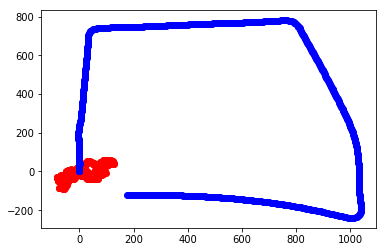

Count:3461
()
()
Relative Depth: 87.46883403617242
Relative x: -62.84256076438947
Relative Original Depth: 121.97270944150202
Relative Original x: 174.62297077538082
Count:3462
()
()
Relative Depth: 87.5184185689595
Relative x: -63.79823971597976
Relative Original Depth: 122.12075567938871
Relative Original x: 173.63510423857025
Count:3463
()
()
Relative Depth: 87.36378993635778
Relative x: -64.76992757852072
Relative Original Depth: 122.22711603363017
Relative Original x: 172.64081963422638
Count:3464
()
()
Relative Depth: 87.11476745425385
Relative x: -65.73125226205276
Relative Original Depth: 122.26049575938056
Relative Original x: 171.64237846930416
Count:3465
()
()
Relative Depth: 86.9147509497573
Relative x: -66.68761121961546
Relative Original Depth: 122.33844783278442
Relative Original x: 170.64579197862628


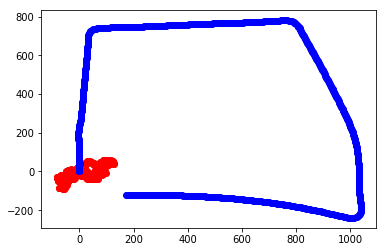

Count:3466
()
()
Relative Depth: 86.38007262637558
Relative x: -67.53258230336766
Relative Original Depth: 122.41109706460534
Relative Original x: 169.65259716573078
Count:3467
()
()
Relative Depth: 85.79972055037423
Relative x: -68.28040065569262
Relative Original Depth: 122.59154816210592
Relative Original x: 168.66902706182978
Count:3468
()
()
Relative Depth: 85.48547973705163
Relative x: -69.13728907927833
Relative Original Depth: 122.70392658248643
Relative Original x: 167.6754627036503
Count:3469
()
()
Relative Depth: 85.24502403818643
Relative x: -69.98687830091144
Relative Original Depth: 122.83023771279166
Relative Original x: 166.68348927213734
Count:3470
()
()
Relative Depth: 85.08302933572844
Relative x: -70.8774114097399
Relative Original Depth: 123.03117981797412
Relative Original x: 165.7049744453476


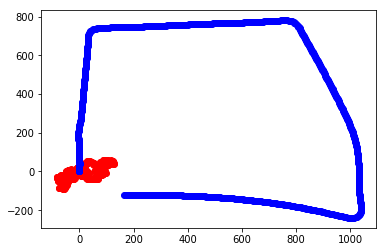

Count:3471
()
()
Relative Depth: 84.77799570133651
Relative x: -71.73954939850101
Relative Original Depth: 123.18065392895898
Relative Original x: 164.71667072835157
Count:3472
()
()
Relative Depth: 83.81065606562791
Relative x: -71.62830124658441
Relative Original Depth: 123.17956376340067
Relative Original x: 163.71883715819746
Count:3473
()
()
Relative Depth: 82.93775218456977
Relative x: -72.09076597500848
Relative Original Depth: 123.24633175104641
Relative Original x: 162.72155830459897
Count:3474
()
()
Relative Depth: 82.03325462465219
Relative x: -72.10759160521978
Relative Original Depth: 123.3672798345702
Relative Original x: 161.7289279134871
Count:3475
()
()
Relative Depth: 81.085942770138
Relative x: -72.07199223795901
Relative Original Depth: 123.12739210281751
Relative Original x: 162.69877669465075


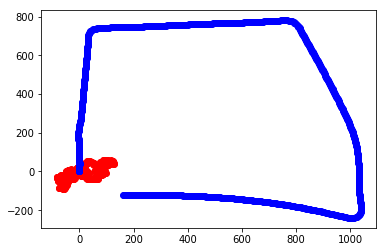

Count:3476
()
()
Relative Depth: 80.14677256487816
Relative x: -72.00065593439462
Relative Original Depth: 123.26451814553685
Relative Original x: 161.70828905374998
Count:3477
()
()
Relative Depth: 80.46378766866547
Relative x: -71.06453085965182
Relative Original Depth: 123.29487825506304
Relative Original x: 160.70951206502883
Count:3478
()
()
Relative Depth: 79.58386497993908
Relative x: -70.71483966329762
Relative Original Depth: 123.4559883594786
Relative Original x: 159.72586735603508
Count:3479
()
()
Relative Depth: 78.73002897234629
Relative x: -70.27572181674145
Relative Original Depth: 123.54347195701573
Relative Original x: 158.72983139697504
Count:3480
()
()
Relative Depth: 77.83549896133549
Relative x: -70.11224608775608
Relative Original Depth: 123.64481421746498
Relative Original x: 157.73606866906928


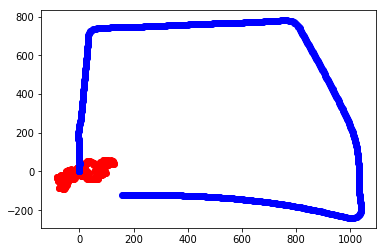

Count:3481
()
()
Relative Depth: 77.02731475782198
Relative x: -69.9619798886081
Relative Original Depth: 123.78012762866251
Relative Original x: 156.74548732885776
Count:3482
()
()
Relative Depth: 76.299990884674
Relative x: -69.57310750737341
Relative Original Depth: 123.91322292786894
Relative Original x: 155.75606384574863
Count:3483
()
()
Relative Depth: 75.56380644514331
Relative x: -69.14377794492798
Relative Original Depth: 123.97290674770122
Relative Original x: 154.757852617562
Count:3484
()
()
Relative Depth: 74.82111996379501
Relative x: -68.83357950070817
Relative Original Depth: 124.10606513954001
Relative Original x: 153.76717540403547
Count:3485
()
()
Relative Depth: 73.9826858242844
Relative x: -68.81821900190081
Relative Original Depth: 124.21346087830875
Relative Original x: 152.77298563998394


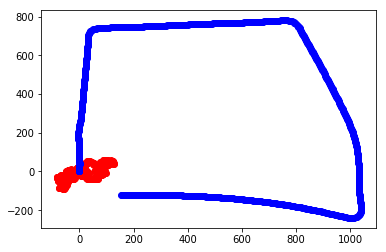

Count:3486
()
()
Relative Depth: 73.0760229657231
Relative x: -68.88149224532046
Relative Original Depth: 124.35139717920173
Relative Original x: 151.78298936920163
Count:3487
()
()
Relative Depth: 72.19744703435634
Relative x: -68.62536494887712
Relative Original Depth: 124.39597473624696
Relative Original x: 150.78630228635018
Count:3488
()
()
Relative Depth: 72.61681359475891
Relative x: -68.15819947752952
Relative Original Depth: 124.51373407323707
Relative Original x: 149.79697659453646
Count:3489
()
()
Relative Depth: 71.9825989596307
Relative x: -67.62475928867839
Relative Original Depth: 124.61324667848699
Relative Original x: 148.80285760165523
Count:3490
()
()
Relative Depth: 71.58000045606904
Relative x: -67.15400587482443
Relative Original Depth: 124.8085426341332
Relative Original x: 147.82470584612062


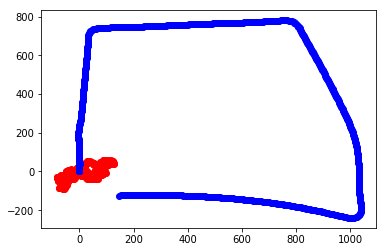

Count:3491
()
()
Relative Depth: 71.16330004137197
Relative x: -66.74664921026817
Relative Original Depth: 125.08135654160981
Relative Original x: 146.86387191017909
Count:3492
()
()
Relative Depth: 70.16402729430644
Relative x: -66.78275935687729
Relative Original Depth: 125.31731069661564
Relative Original x: 145.89528193476897
Count:3493
()
()
Relative Depth: 69.76726060820353
Relative x: -67.17074963044426
Relative Original Depth: 125.25873672699055
Relative Original x: 144.89937398992302
Count:3494
()
()
Relative Depth: 69.31782496388558
Relative x: -67.70405872990135
Relative Original Depth: 125.38994500384631
Relative Original x: 143.908109975756
Count:3495
()
()
Relative Depth: 68.98043192770841
Relative x: -68.58274002663204
Relative Original Depth: 125.64973380040941
Relative Original x: 142.94288865769215


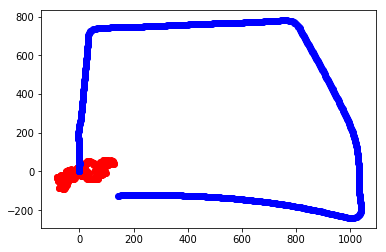

Count:3496
()
()
Relative Depth: 68.55452530703093
Relative x: -69.48606486544764
Relative Original Depth: 125.87808035607529
Relative Original x: 141.96958309461826
Count:3497
()
()
Relative Depth: 67.92421680175482
Relative x: -70.25306409378362
Relative Original Depth: 126.0205919664497
Relative Original x: 140.98027039650194
Count:3498
()
()
Relative Depth: 67.40575000372729
Relative x: -71.10252552781786
Relative Original Depth: 125.92436404266586
Relative Original x: 139.9872301186034
Count:3499
()
()
Relative Depth: 67.01320884189602
Relative x: -72.02156821016266
Relative Original Depth: 126.10370739444612
Relative Original x: 139.00457084636037
Count:3500
()
()
Relative Depth: 66.62172102039399
Relative x: -72.87943367378642
Relative Original Depth: 126.13132598513654
Relative Original x: 138.0111122226242


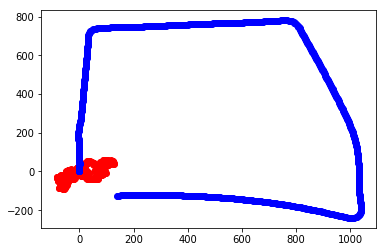

Count:3501
()
()
Relative Depth: 65.94002226086006
Relative x: -73.41944378712797
Relative Original Depth: 126.26390713800934
Relative Original x: 137.02336726205175
Count:3502
()
()
Relative Depth: 65.09903617822036
Relative x: -73.71841891334137
Relative Original Depth: 126.42438503842716
Relative Original x: 136.04028090850684
Count:3503
()
()
Relative Depth: 64.81282290893053
Relative x: -73.63371713816774
Relative Original Depth: 126.37784339239008
Relative Original x: 135.04742620656634
Count:3504
()
()
Relative Depth: 65.3683597104018
Relative x: -73.01460007326132
Relative Original Depth: 126.44337988605415
Relative Original x: 134.050888478249
Count:3505
()
()
Relative Depth: 65.27894061710965
Relative x: -72.76783218438152
Relative Original Depth: 126.77817836995726
Relative Original x: 133.10864704471308


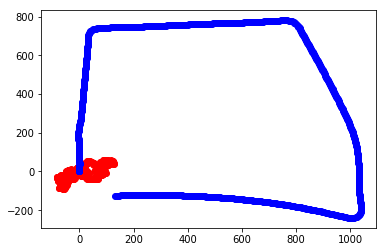

Count:3506
()
()
Relative Depth: 65.26523596710784
Relative x: -72.6186850898741
Relative Original Depth: 126.89468826249703
Relative Original x: 132.12113972558393
Count:3507
()
()
Relative Depth: 64.861301522973
Relative x: -72.74633662736814
Relative Original Depth: 126.96083258262112
Relative Original x: 131.123412546457
Count:3508
()
()
Relative Depth: 64.58185219512737
Relative x: -71.78725245003909
Relative Original Depth: 126.71895155520136
Relative Original x: 132.09362518859044
Count:3509
()
()
Relative Depth: 63.9142235394039
Relative x: -72.21750688345585
Relative Original Depth: 126.9291623653349
Relative Original x: 131.1197966994005
Count:3510
()
()
Relative Depth: 63.34071615293172
Relative x: -72.97070429950648
Relative Original Depth: 126.94335134819127
Relative Original x: 132.11938283231996


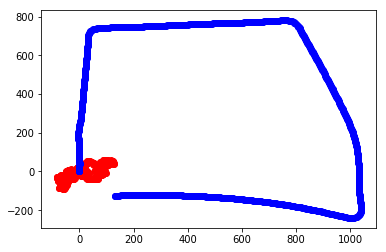

Count:3511
()
()
Relative Depth: 62.4574110489707
Relative x: -73.05906243434934
Relative Original Depth: 126.75186081219682
Relative Original x: 133.09896581234224
Count:3512
()
()
Relative Depth: 62.04041268930777
Relative x: -73.96669326326231
Relative Original Depth: 126.73365967370397
Relative Original x: 134.09488808403648
Count:3513
()
()
Relative Depth: 61.724196381910694
Relative x: -74.83638040158112
Relative Original Depth: 126.40950947492234
Relative Original x: 135.03883825629939
Count:3514
()
()
Relative Depth: 61.02936558982229
Relative x: -75.13195532145298
Relative Original Depth: 126.22504480122531
Relative Original x: 136.01884518767616
Count:3515
()
()
Relative Depth: 60.21764698973022
Relative x: -74.6972554154559
Relative Original Depth: 125.26342869683289
Relative Original x: 135.78886792236128


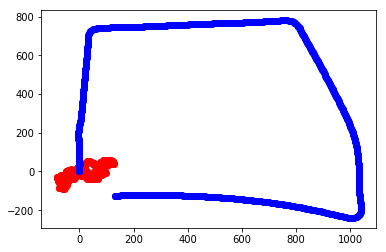

Count:3516
()
()
Relative Depth: 59.6627470602608
Relative x: -74.00374615422378
Relative Original Depth: 125.6961428716265
Relative Original x: 134.88792644578317
Count:3517
()
()
Relative Depth: 59.99715501219839
Relative x: -73.06150091552279
Relative Original Depth: 126.06601219631949
Relative Original x: 133.9604997678732
Count:3518
()
()
Relative Depth: 59.38116642651328
Relative x: -72.39471776407319
Relative Original Depth: 125.10860303431596
Relative Original x: 133.74553340306377
Count:3519
()
()
Relative Depth: 58.966027205216974
Relative x: -71.69076629595332
Relative Original Depth: 124.88251627990526
Relative Original x: 134.70793830675734
Count:3520
()
()
Relative Depth: 59.12370718507848
Relative x: -70.8344555553064
Relative Original Depth: 124.50055577811055
Relative Original x: 135.59762654521214


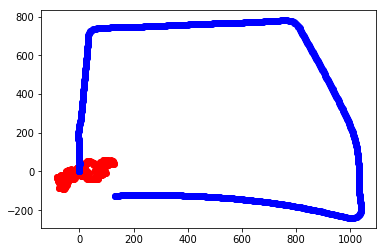

Count:3521
()
()
Relative Depth: 59.30463645779039
Relative x: -69.91820039683823
Relative Original Depth: 124.05656012419902
Relative Original x: 136.42715135320913
Count:3522
()
()
Relative Depth: 59.41119146705348
Relative x: -68.98685101135521
Relative Original Depth: 124.53971730250016
Relative Original x: 135.58781690972387
Count:3523
()
()
Relative Depth: 59.91734434469625
Relative x: -68.15135011677802
Relative Original Depth: 124.89788300133516
Relative Original x: 134.75476552902379
Count:3524
()
()
Relative Depth: 60.47825552446751
Relative x: -67.32780565641441
Relative Original Depth: 124.55910112421017
Relative Original x: 135.67542971446727
Count:3525
()
()
Relative Depth: 60.63750944469636
Relative x: -66.35560969181407
Relative Original Depth: 124.74886130622042
Relative Original x: 134.70357222426915


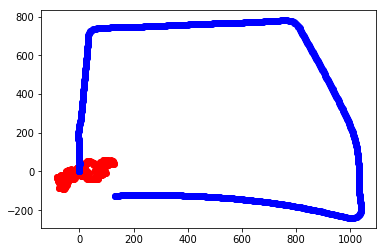

Count:3526
()
()
Relative Depth: 60.91701787221228
Relative x: -65.41343214090071
Relative Original Depth: 125.03745611132621
Relative Original x: 133.7612957302489
Count:3527
()
()
Relative Depth: 61.74687720400047
Relative x: -64.8597801083583
Relative Original Depth: 125.35539248125772
Relative Original x: 132.8779417959137
Count:3528
()
()
Relative Depth: 62.73513533743791
Relative x: -64.87992141961216
Relative Original Depth: 124.61968603415069
Relative Original x: 133.46568806332374
Count:3529
()
()
Relative Depth: 63.55692233197271
Relative x: -64.86820158964562
Relative Original Depth: 125.53001884177691
Relative Original x: 133.41945458509028
Count:3530
()
()
Relative Depth: 64.23946768948463
Relative x: -64.77598906819371
Relative Original Depth: 125.11408885056704
Relative Original x: 134.3192848995246


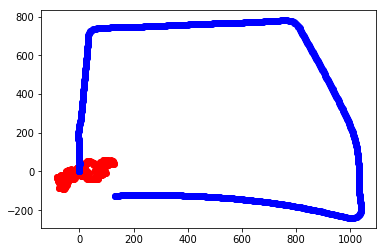

Count:3531
()
()
Relative Depth: 64.784718945995
Relative x: -64.54312181528806
Relative Original Depth: 126.02486226501588
Relative Original x: 134.51477909635707
Count:3532
()
()
Relative Depth: 65.1133968187135
Relative x: -64.2150639183307
Relative Original Depth: 126.881039468631
Relative Original x: 134.19536455116366
Count:3533
()
()
Relative Depth: 65.39041825931214
Relative x: -63.60497713319788
Relative Original Depth: 126.34420912110605
Relative Original x: 134.99182408235785
Count:3534
()
()
Relative Depth: 65.60212188762752
Relative x: -63.05264036426677
Relative Original Depth: 126.74349112119373
Relative Original x: 134.08625996091232
Count:3535
()
()
Relative Depth: 65.60161083848887
Relative x: -62.80157860744356
Relative Original Depth: 127.03426780483373
Relative Original x: 133.1336763143392


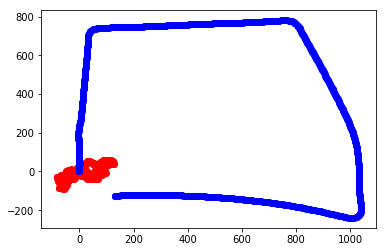

Count:3536
()
()
Relative Depth: 65.48250526473373
Relative x: -62.74154129290407
Relative Original Depth: 127.82779373800591
Relative Original x: 132.5972079596363
Count:3537
()
()
Relative Depth: 66.17309911954133
Relative x: -62.4037414076323
Relative Original Depth: 127.03816733523742
Relative Original x: 132.85290472894164
Count:3538
()
()
Relative Depth: 66.03035748297815
Relative x: -62.742316594247434
Relative Original Depth: 126.41357751819037
Relative Original x: 133.63128366742714
Count:3539
()
()
Relative Depth: 65.83564739112273
Relative x: -63.491342602395356
Relative Original Depth: 127.17977373317278
Relative Original x: 132.9891887633822
Count:3540
()
()
Relative Depth: 64.94461719570789
Relative x: -63.44289904797911
Relative Original Depth: 126.5123918416566
Relative Original x: 133.72982598920856


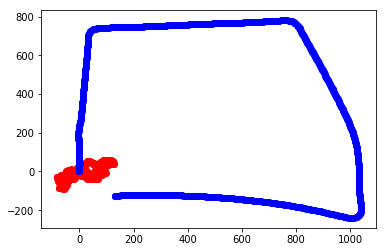

Count:3541
()
()
Relative Depth: 65.16388002561192
Relative x: -62.50065115985241
Relative Original Depth: 125.94848113736714
Relative Original x: 134.54339816350503
Count:3542
()
()
Relative Depth: 65.56897412266474
Relative x: -61.59834490298534
Relative Original Depth: 125.05913613378421
Relative Original x: 134.95481796838655
Count:3543
()
()
Relative Depth: 66.09696646227826
Relative x: -60.75875688244175
Relative Original Depth: 124.18435936073551
Relative Original x: 135.43816617272378
Count:3544
()
()
Relative Depth: 66.16208408595863
Relative x: -61.66353309494307
Relative Original Depth: 125.06527555339039
Relative Original x: 135.1155555405011
Count:3545
()
()
Relative Depth: 66.32117849655391
Relative x: -60.77277477514721
Relative Original Depth: 125.46422731281972
Relative Original x: 134.22895664111982


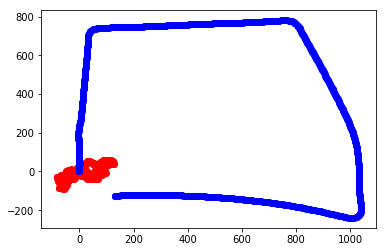

Count:3546
()
()
Relative Depth: 67.11208973224574
Relative x: -61.20678022987498
Relative Original Depth: 124.97455879802762
Relative Original x: 135.08381907437433
Count:3547
()
()
Relative Depth: 66.58699284223158
Relative x: -60.47820620317655
Relative Original Depth: 125.9306506198972
Relative Original x: 135.1850029797209
Count:3548
()
()
Relative Depth: 66.33576087834247
Relative x: -59.574363047268044
Relative Original Depth: 125.44608582927043
Relative Original x: 136.04431687319905
Count:3549
()
()
Relative Depth: 66.15573711198266
Relative x: -58.62656011335384
Relative Original Depth: 125.06816341601413
Relative Original x: 136.8263680889867
Count:3550
()
()
Relative Depth: 65.98183086936486
Relative x: -57.69631365061127
Relative Original Depth: 124.51053712866893
Relative Original x: 137.43954268219963


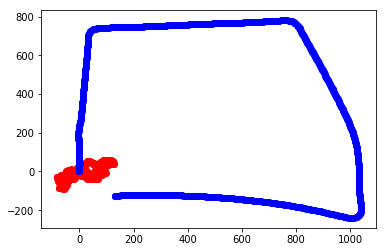

Count:3551
()
()
Relative Depth: 65.51204755481716
Relative x: -56.8330568376626
Relative Original Depth: 124.91593668418615
Relative Original x: 136.7072479842585
Count:3552
()
()
Relative Depth: 64.87166481253594
Relative x: -56.07211575116582
Relative Original Depth: 124.44744669086874
Relative Original x: 137.5876201735376
Count:3553
()
()
Relative Depth: 64.18825309444405
Relative x: -55.36772494127307
Relative Original Depth: 124.89845250294255
Relative Original x: 136.83005207474156
Count:3554
()
()
Relative Depth: 63.34965629535463
Relative x: -55.12868405130555
Relative Original Depth: 125.09370039859549
Relative Original x: 135.95151457083952
Count:3555
()
()
Relative Depth: 62.55754562790324
Relative x: -54.53193217759463
Relative Original Depth: 124.90586674951776
Relative Original x: 136.81591234915894


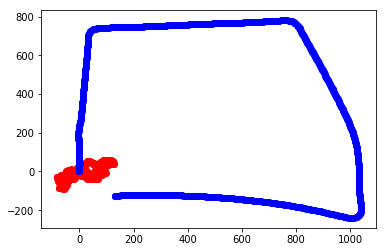

Count:3556
()
()
Relative Depth: 61.65145533985392
Relative x: -54.10909481603747
Relative Original Depth: 124.29443521416545
Relative Original x: 137.53672461651584
Count:3557
()
()
Relative Depth: 60.826858650888354
Relative x: -53.65021842940119
Relative Original Depth: 125.20393368981034
Relative Original x: 137.25673539587413
Count:3558
()
()
Relative Depth: 60.38114081327017
Relative x: -53.02142382985583
Relative Original Depth: 124.47006452057246
Relative Original x: 137.86107772889537
Count:3559
()
()
Relative Depth: 60.24551886379126
Relative x: -52.32389981429634
Relative Original Depth: 125.20251433614
Relative Original x: 138.50719366457113
Count:3560
()
()
Relative Depth: 59.66675989124428
Relative x: -53.12330058997609
Relative Original Depth: 124.47978896258526
Relative Original x: 139.1858542749241


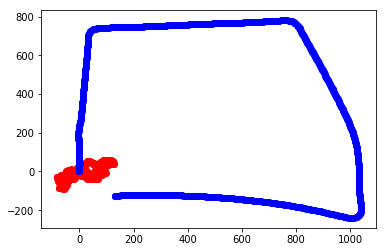

Count:3561
()
()
Relative Depth: 59.933539905516305
Relative x: -52.31354435655983
Relative Original Depth: 123.71548754888856
Relative Original x: 139.83036842432384
Count:3562
()
()
Relative Depth: 60.43400649159484
Relative x: -51.46034132376203
Relative Original Depth: 124.3488964613405
Relative Original x: 139.0675080792182
Count:3563
()
()
Relative Depth: 59.80372957099546
Relative x: -50.777984779982994
Relative Original Depth: 123.4359576670844
Relative Original x: 139.46725962113027
Count:3564
()
()
Relative Depth: 59.14003719407554
Relative x: -51.45549105112476
Relative Original Depth: 122.94315314225226
Relative Original x: 139.11936265734025
Count:3565
()
()
Relative Depth: 58.57372813487573
Relative x: -52.23774683603551
Relative Original Depth: 123.56787963562864
Relative Original x: 138.39192390102582


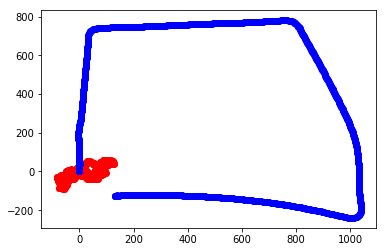

Count:3566
()
()
Relative Depth: 57.86031106205465
Relative x: -52.93785244544782
Relative Original Depth: 122.93990688692882
Relative Original x: 139.03973849543323
Count:3567
()
()
Relative Depth: 57.26348936375669
Relative x: -53.73621957247454
Relative Original Depth: 122.11976055811118
Relative Original x: 139.44242072526396
Count:3568
()
()
Relative Depth: 56.85071952796891
Relative x: -54.64369581683347
Relative Original Depth: 123.00561620517581
Relative Original x: 138.97944908056732
Count:3569
()
()
Relative Depth: 56.36107174305953
Relative x: -55.50835610835359
Relative Original Depth: 122.24540643540841
Relative Original x: 139.57908154491227
Count:3570
()
()
Relative Depth: 56.17975788906281
Relative x: -54.527772311224204
Relative Original Depth: 121.85855569193261
Relative Original x: 140.3610802603314


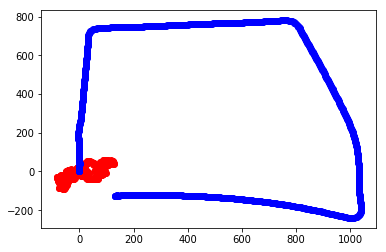

Count:3571
()
()
Relative Depth: 56.84592005879002
Relative x: -55.21343468334541
Relative Original Depth: 121.13661704976587
Relative Original x: 141.02765046870834
Count:3572
()
()
Relative Depth: 57.28844590039118
Relative x: -56.06965996851797
Relative Original Depth: 120.59464146130621
Relative Original x: 141.82360671751363
Count:3573
()
()
Relative Depth: 57.67109145592342
Relative x: -56.989880172437616
Relative Original Depth: 121.18895995309904
Relative Original x: 141.03864468858507
Count:3574
()
()
Relative Depth: 58.09490884978463
Relative x: -57.89502238879487
Relative Original Depth: 120.4434706934334
Relative Original x: 140.43709902643917
Count:3575
()
()
Relative Depth: 57.45322460071925
Relative x: -58.285724667872124
Relative Original Depth: 120.66026626688254
Relative Original x: 139.56088480453357


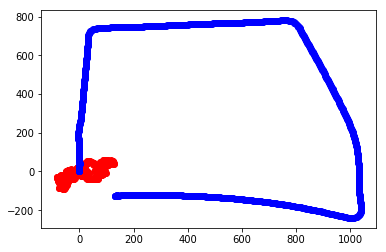

Count:3576
()
()
Relative Depth: 56.64470467840807
Relative x: -57.700153321115614
Relative Original Depth: 121.58079881741031
Relative Original x: 139.1702812187668
Count:3577
()
()
Relative Depth: 55.696604433214034
Relative x: -57.38219595877086
Relative Original Depth: 121.67006694351777
Relative Original x: 138.18242552858212
Count:3578
()
()
Relative Depth: 55.153991480123125
Relative x: -56.543832802864785
Relative Original Depth: 122.39480406783234
Relative Original x: 137.57516794110086
Count:3579
()
()
Relative Depth: 55.07644465458764
Relative x: -55.550898413814814
Relative Original Depth: 122.53999039742205
Relative Original x: 138.5131738748752
Count:3580
()
()
Relative Depth: 55.52206315046125
Relative x: -54.833718703572806
Relative Original Depth: 122.47188981881112
Relative Original x: 137.52360748202432


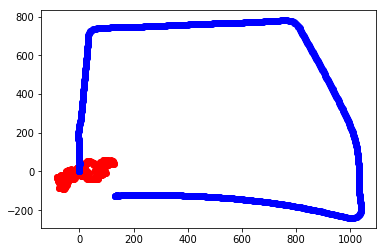

Count:3581
()
()
Relative Depth: 56.32726103218879
Relative x: -54.659183838905825
Relative Original Depth: 122.54488389735238
Relative Original x: 138.50784443904487
Count:3582
()
()
Relative Depth: 57.05069637321015
Relative x: -54.22092012226326
Relative Original Depth: 121.78673946353555
Relative Original x: 139.11678517970304
Count:3583
()
()
Relative Depth: 57.742498094908086
Relative x: -53.79032832435467
Relative Original Depth: 120.81606513171593
Relative Original x: 138.98456986177615
Count:3584
()
()
Relative Depth: 58.327367857439135
Relative x: -53.20268302469875
Relative Original Depth: 121.78388020112742
Relative Original x: 139.20925648070866
Count:3585
()
()
Relative Depth: 57.3778852535222
Relative x: -52.945532270014006
Relative Original Depth: 120.82116320362739
Relative Original x: 139.06242470866357


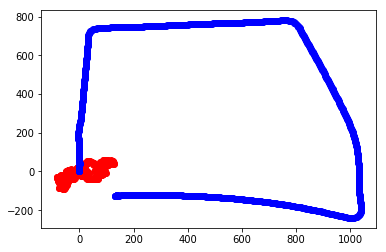

Count:3586
()
()
Relative Depth: 57.437251531373754
Relative x: -51.95559490900329
Relative Original Depth: 119.84424007492088
Relative Original x: 138.9924299288711
Count:3587
()
()
Relative Depth: 57.046221718060195
Relative x: -51.23668778736174
Relative Original Depth: 119.10085085692218
Relative Original x: 139.0784956480142
Count:3588
()
()
Relative Depth: 56.389456838945776
Relative x: -50.73591421352917
Relative Original Depth: 119.76607354642721
Relative Original x: 138.68207570818936
Count:3589
()
()
Relative Depth: 55.56063208643136
Relative x: -50.598225238953496
Relative Original Depth: 119.77824501199197
Relative Original x: 139.68119220371534
Count:3590
()
()
Relative Depth: 54.74096403613521
Relative x: -50.870455507629096
Relative Original Depth: 120.23275214791838
Relative Original x: 140.180103985835


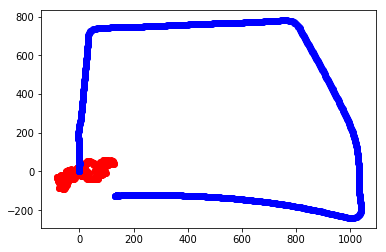

Count:3591
()
()
Relative Depth: 53.85122296931502
Relative x: -51.22436428774843
Relative Original Depth: 120.84137036440582
Relative Original x: 140.83186248886327
Count:3592
()
()
Relative Depth: 53.20124237387645
Relative x: -51.98121307188325
Relative Original Depth: 121.12232420045362
Relative Original x: 141.78678441490752
Count:3593
()
()
Relative Depth: 53.11980866578536
Relative x: -52.904252874778784
Relative Original Depth: 120.4567791349868
Relative Original x: 141.73744505727177
Count:3594
()
()
Relative Depth: 52.88939160341585
Relative x: -53.46464742105364
Relative Original Depth: 121.02570534938535
Relative Original x: 142.3301913203599
Count:3595
()
()
Relative Depth: 52.638075980961986
Relative x: -53.825773704250814
Relative Original Depth: 121.70245664466357
Relative Original x: 142.86804548843799


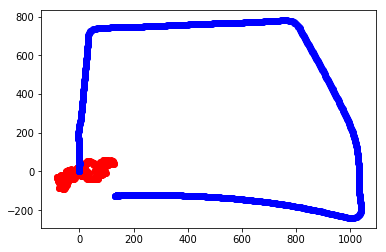

Count:3596
()
()
Relative Depth: 52.55696586082869
Relative x: -54.38069682191491
Relative Original Depth: 121.81145168881163
Relative Original x: 141.87400604610616
Count:3597
()
()
Relative Depth: 52.67739686917568
Relative x: -55.19062679413861
Relative Original Depth: 121.23635203633495
Relative Original x: 142.51177565426164
Count:3598
()
()
Relative Depth: 52.08395228154678
Relative x: -55.91822068556378
Relative Original Depth: 120.54483702492595
Relative Original x: 142.6241140822243
Count:3599
()
()
Relative Depth: 52.49045352086526
Relative x: -56.74539355652591
Relative Original Depth: 119.83555165344467
Relative Original x: 142.781376080509
Count:3600
()
()
Relative Depth: 52.98068983323336
Relative x: -57.48955940634668
Relative Original Depth: 119.75047842030685
Relative Original x: 143.74608287606816


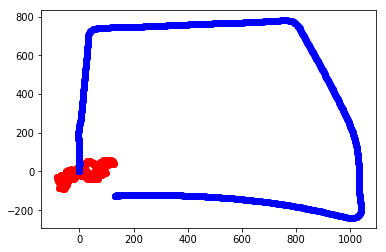

Count:3601
()
()
Relative Depth: 53.67411221587147
Relative x: -57.45331096999108
Relative Original Depth: 119.18176827089937
Relative Original x: 144.06182257017406
Count:3602
()
()
Relative Depth: 53.091726143739386
Relative x: -56.66527077363436
Relative Original Depth: 118.53533779488652
Relative Original x: 144.05829909402286
Count:3603
()
()
Relative Depth: 52.701757481318054
Relative x: -55.75084482308849
Relative Original Depth: 117.80974128611165
Relative Original x: 144.1474044684718
Count:3604
()
()
Relative Depth: 52.23902361481697
Relative x: -55.66087595881758
Relative Original Depth: 118.03585258884979
Relative Original x: 144.94696560051048
Count:3605
()
()
Relative Depth: 51.71275495306557
Relative x: -54.94237239476826
Relative Original Depth: 118.25446699100755
Relative Original x: 145.73508859444078


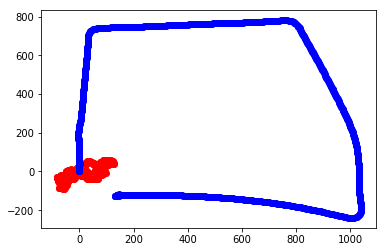

Count:3606
()
()
Relative Depth: 52.0027814840999
Relative x: -55.77016748104151
Relative Original Depth: 118.5240518096084
Relative Original x: 146.47534187556843
Count:3607
()
()
Relative Depth: 52.73567146274836
Relative x: -55.80724676628563
Relative Original Depth: 118.60099801933781
Relative Original x: 147.4175728481713
Count:3608
()
()
Relative Depth: 52.074689939755636
Relative x: -55.10262697742858
Relative Original Depth: 119.29700927184197
Relative Original x: 146.98586208473407
Count:3609
()
()
Relative Depth: 53.06559100091188
Relative x: -55.186666033366244
Relative Original Depth: 119.50453481718807
Relative Original x: 147.8101370505008
Count:3610
()
()
Relative Depth: 53.6487376613305
Relative x: -55.94617678517383
Relative Original Depth: 120.08936404427894
Relative Original x: 147.18720013990028


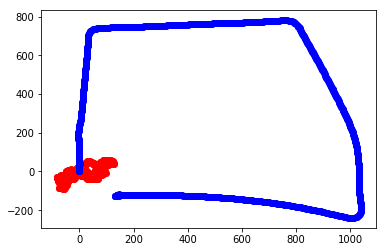

Count:3611
()
()
Relative Depth: 54.43304303271211
Relative x: -55.524333091988
Relative Original Depth: 120.81039825138892
Relative Original x: 146.90914288471816
Count:3612
()
()
Relative Depth: 55.32132028708348
Relative x: -55.13246270664227
Relative Original Depth: 121.54715629721757
Relative Original x: 146.74016826372542
Count:3613
()
()
Relative Depth: 54.670185469589484
Relative x: -54.386262899027074
Relative Original Depth: 122.29119060446321
Relative Original x: 146.57170000015896
Count:3614
()
()
Relative Depth: 53.93754931809478
Relative x: -54.526351346242286
Relative Original Depth: 122.93179363280728
Relative Original x: 146.09931228869155
Count:3615
()
()
Relative Depth: 53.98934885285483
Relative x: -55.3467092336896
Relative Original Depth: 122.29636749247115
Relative Original x: 146.51528278835104


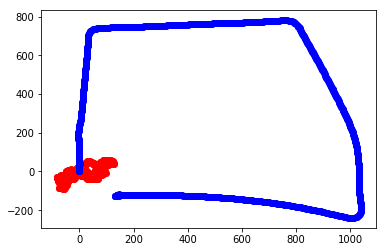

Count:3616
()
()
Relative Depth: 54.179822927313175
Relative x: -55.9910472470275
Relative Original Depth: 121.68513826609416
Relative Original x: 146.85877382987445
Count:3617
()
()
Relative Depth: 54.4676943627165
Relative x: -56.54133122987748
Relative Original Depth: 122.4131052453968
Relative Original x: 146.5963788692887
Count:3618
()
()
Relative Depth: 54.959129393363824
Relative x: -56.873410457424356
Relative Original Depth: 121.73909735492325
Relative Original x: 146.89863823606342
Count:3619
()
()
Relative Depth: 55.85163247981935
Relative x: -57.0256708128681
Relative Original Depth: 122.39060162298244
Relative Original x: 146.55001930094474
Count:3620
()
()
Relative Depth: 56.81020077697982
Relative x: -57.235454701277156
Relative Original Depth: 121.74921408891849
Relative Original x: 146.9723373207483


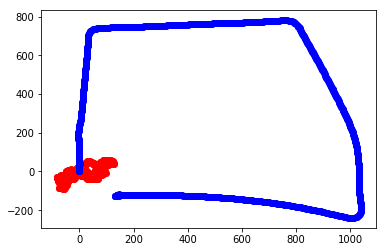

Count:3621
()
()
Relative Depth: 57.692917018634326
Relative x: -57.66052509380487
Relative Original Depth: 122.35319037378402
Relative Original x: 146.62823877283154
Count:3622
()
()
Relative Depth: 58.222089163735994
Relative x: -58.24896831625244
Relative Original Depth: 122.93542585951818
Relative Original x: 146.23128702670175
Count:3623
()
()
Relative Depth: 58.686671905288286
Relative x: -58.91659210779116
Relative Original Depth: 123.57949199066358
Relative Original x: 145.84482659675774
Count:3624
()
()
Relative Depth: 59.45232501891956
Relative x: -59.14688834378631
Relative Original Depth: 124.20581137881037
Relative Original x: 145.4826676115135
Count:3625
()
()
Relative Depth: 60.236543177027706
Relative x: -58.93778913742802
Relative Original Depth: 124.82177311486394
Relative Original x: 145.1554000247424


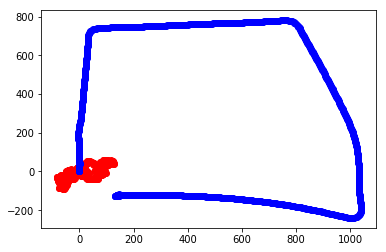

Count:3626
()
()
Relative Depth: 60.885206018379556
Relative x: -58.647492767753164
Relative Original Depth: 125.42855730437716
Relative Original x: 144.81545695664772
Count:3627
()
()
Relative Depth: 61.43235016176796
Relative x: -58.40680864564541
Relative Original Depth: 126.06737999004963
Relative Original x: 144.51336415766588
Count:3628
()
()
Relative Depth: 61.4781740071765
Relative x: -57.72978014245221
Relative Original Depth: 126.70703372241202
Relative Original x: 144.29224708634908
Count:3629
()
()
Relative Depth: 61.24525702382388
Relative x: -56.898866922506784
Relative Original Depth: 126.03837624414628
Relative Original x: 144.5086322231317
Count:3630
()
()
Relative Depth: 61.26262532968077
Relative x: -56.15775391910471
Relative Original Depth: 126.72739989377673
Relative Original x: 144.24879290276354


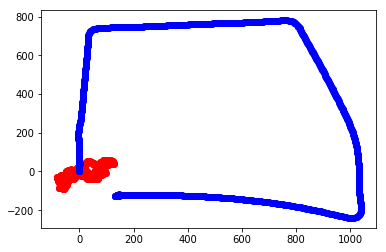

Count:3631
()
()
Relative Depth: 60.745171066596896
Relative x: -56.987907688474465
Relative Original Depth: 127.39586661297784
Relative Original x: 144.03485033146652
Count:3632
()
()
Relative Depth: 60.427372849237265
Relative x: -56.12868550924481
Relative Original Depth: 128.1046322404347
Relative Original x: 143.8318125270518
Count:3633
()
()
Relative Depth: 59.91466260117681
Relative x: -55.281919372981655
Relative Original Depth: 128.76492501334354
Relative Original x: 143.6159390709889
Count:3634
()
()
Relative Depth: 60.51836835196279
Relative x: -54.61084676018765
Relative Original Depth: 129.4255116486028
Relative Original x: 143.26310421869806
Count:3635
()
()
Relative Depth: 60.16340485322282
Relative x: -53.67712380537182
Relative Original Depth: 130.07984349608927
Relative Original x: 142.93384741432607


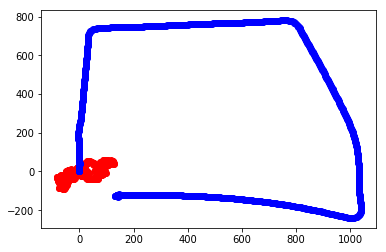

Count:3636
()
()
Relative Depth: 60.18947704739738
Relative x: -52.68263248322441
Relative Original Depth: 130.72098901911806
Relative Original x: 142.5841001785208
Count:3637
()
()
Relative Depth: 60.88614487527606
Relative x: -52.02087773043794
Relative Original Depth: 131.4096829017293
Relative Original x: 142.28271078731362
Count:3638
()
()
Relative Depth: 61.253474692499175
Relative x: -51.0943760165163
Relative Original Depth: 132.03320340523118
Relative Original x: 141.92214677798978
Count:3639
()
()
Relative Depth: 61.169903454176996
Relative x: -50.13635362662464
Relative Original Depth: 132.70328892870427
Relative Original x: 141.51162092883396
Count:3640
()
()
Relative Depth: 60.48034191135813
Relative x: -49.64935322735934
Relative Original Depth: 133.3807512813428
Relative Original x: 141.16819196454094


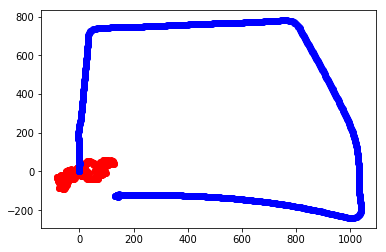

Count:3641
()
()
Relative Depth: 59.75232056999063
Relative x: -49.43985178503427
Relative Original Depth: 134.0713305045009
Relative Original x: 140.77032241551183
Count:3642
()
()
Relative Depth: 59.20246625038741
Relative x: -49.13386092798046
Relative Original Depth: 134.7238104202478
Relative Original x: 140.35304527776663
Count:3643
()
()
Relative Depth: 58.72384855167216
Relative x: -48.83723226103531
Relative Original Depth: 135.38267431875263
Relative Original x: 139.92745290746615
Count:3644
()
()
Relative Depth: 58.132026730923144
Relative x: -48.61771016311007
Relative Original Depth: 136.03095216940415
Relative Original x: 139.48172361838598
Count:3645
()
()
Relative Depth: 57.44919868765512
Relative x: -48.40848380797395
Relative Original Depth: 136.70759159695262
Relative Original x: 139.04144511810478


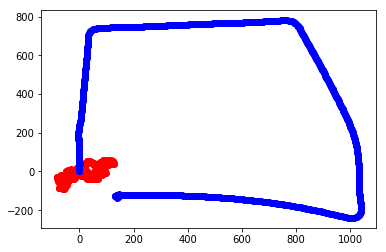

Count:3646
()
()
Relative Depth: 56.5903744882772
Relative x: -48.6019926479061
Relative Original Depth: 137.37284566120516
Relative Original x: 138.61946513293
Count:3647
()
()
Relative Depth: 55.72578885206015
Relative x: -48.86535747850032
Relative Original Depth: 138.04317583771962
Relative Original x: 138.16977048279085
Count:3648
()
()
Relative Depth: 55.206802221684605
Relative x: -49.033599924187605
Relative Original Depth: 138.66934157642797
Relative Original x: 137.61452503764428
Count:3649
()
()
Relative Depth: 55.052910555145054
Relative x: -49.25110798607657
Relative Original Depth: 139.30653808822808
Relative Original x: 137.10688362638504
Count:3650
()
()
Relative Depth: 54.64865544104172
Relative x: -48.59797761952781
Relative Original Depth: 139.93597422732486
Relative Original x: 136.58725495926774


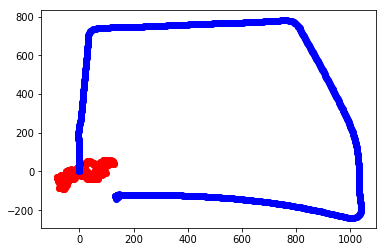

Count:3651
()
()
Relative Depth: 54.33861457167344
Relative x: -48.737137287683616
Relative Original Depth: 140.60133742330007
Relative Original x: 136.0703108721496
Count:3652
()
()
Relative Depth: 54.558666616040114
Relative x: -48.65267331200628
Relative Original Depth: 141.2440420644065
Relative Original x: 135.53383543297846
Count:3653
()
()
Relative Depth: 55.113167290837524
Relative x: -47.85711753767339
Relative Original Depth: 141.87343363307022
Relative Original x: 134.9634422603602
Count:3654
()
()
Relative Depth: 55.55497545018025
Relative x: -46.96107054861638
Relative Original Depth: 142.4667033043932
Relative Original x: 134.34688969064737
Count:3655
()
()
Relative Depth: 55.82263505616442
Relative x: -45.99980160045599
Relative Original Depth: 143.0792258497876
Relative Original x: 133.73738576116781


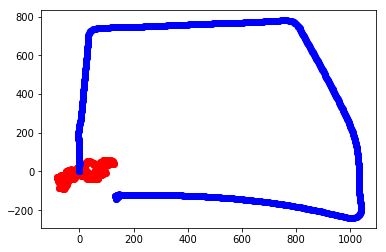

Count:3656
()
()
Relative Depth: 56.72118162836915
Relative x: -45.7048616370596
Relative Original Depth: 143.69122157628055
Relative Original x: 133.09079993557256
Count:3657
()
()
Relative Depth: 56.40369665873817
Relative x: -44.91894584116127
Relative Original Depth: 144.26627105890438
Relative Original x: 132.4089669721844
Count:3658
()
()
Relative Depth: 55.501537018538286
Relative x: -45.12601077262922
Relative Original Depth: 144.87128864889078
Relative Original x: 131.74972453031992
Count:3659
()
()
Relative Depth: 54.83707917727982
Relative x: -45.85816682965061
Relative Original Depth: 145.48511925104012
Relative Original x: 131.06476935881565
Count:3660
()
()
Relative Depth: 54.91465998288345
Relative x: -46.57521060941619
Relative Original Depth: 146.11372786592818
Relative Original x: 130.40001986589948


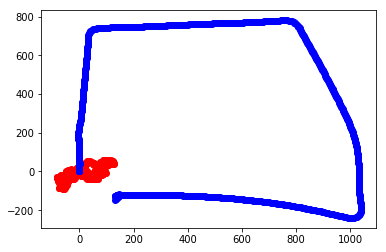

Count:3661
()
()
Relative Depth: 54.42208706747834
Relative x: -47.385120774521695
Relative Original Depth: 146.78327817600427
Relative Original x: 129.7498786038366
Count:3662
()
()
Relative Depth: 54.13973743585367
Relative x: -48.13644720101411
Relative Original Depth: 147.3766983221882
Relative Original x: 129.03624092096487
Count:3663
()
()
Relative Depth: 54.047356286573944
Relative x: -48.71901608183411
Relative Original Depth: 147.94242544084437
Relative Original x: 128.2908081887268
Count:3664
()
()
Relative Depth: 53.79595519764125
Relative x: -49.40923053200914
Relative Original Depth: 148.47230846893464
Relative Original x: 127.51154925589826
Count:3665
()
()
Relative Depth: 53.602114184078665
Relative x: -50.15886776765485
Relative Original Depth: 149.01770949286572
Relative Original x: 126.72834283642342


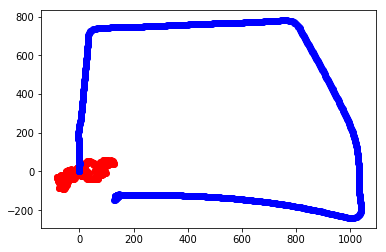

Count:3666
()
()
Relative Depth: 53.346252190583485
Relative x: -50.876472766465135
Relative Original Depth: 149.54970147370986
Relative Original x: 125.92943423114149
Count:3667
()
()
Relative Depth: 52.758248752885585
Relative x: -51.54783836913912
Relative Original Depth: 150.09037865671507
Relative Original x: 125.12427721932202
Count:3668
()
()
Relative Depth: 52.007554560522166
Relative x: -52.07395584346014
Relative Original Depth: 150.59530515899306
Relative Original x: 124.30639967987774
Count:3669
()
()
Relative Depth: 51.65590100672209
Relative x: -52.83823357157291
Relative Original Depth: 151.11358781373488
Relative Original x: 123.4821484862058
Count:3670
()
()
Relative Depth: 51.50988847288223
Relative x: -53.74164586394118
Relative Original Depth: 151.63149489659895
Relative Original x: 122.65266164649702


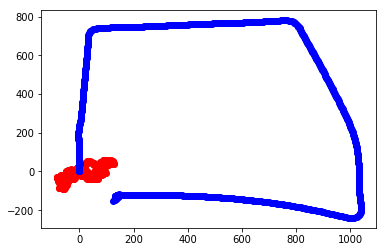

Count:3671
()
()
Relative Depth: 51.69700865469517
Relative x: -54.44483626548081
Relative Original Depth: 152.1138628328832
Relative Original x: 121.79002277819453
Count:3672
()
()
Relative Depth: 51.86824738366718
Relative x: -55.29127512813663
Relative Original Depth: 152.5840143932011
Relative Original x: 120.92607681237328
Count:3673
()
()
Relative Depth: 51.6913321565439
Relative x: -56.27230666563531
Relative Original Depth: 153.03614590668712
Relative Original x: 120.0455074875906
Count:3674
()
()
Relative Depth: 51.26804696682413
Relative x: -57.160282297159476
Relative Original Depth: 153.48350998553826
Relative Original x: 119.16503700141564
Count:3675
()
()
Relative Depth: 50.5813797605102
Relative x: -57.848408567607116
Relative Original Depth: 153.9246483995239
Relative Original x: 118.27663067584541


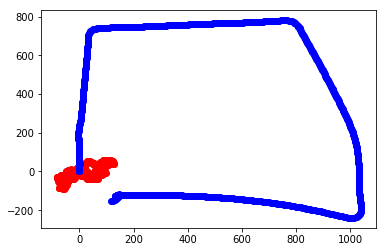

Count:3676
()
()
Relative Depth: 49.70937348744482
Relative x: -58.27524944578164
Relative Original Depth: 154.4220726666419
Relative Original x: 117.41298646015579
Count:3677
()
()
Relative Depth: 48.86333523628294
Relative x: -58.80662667415337
Relative Original Depth: 154.87269737880732
Relative Original x: 116.53328500665756
Count:3678
()
()
Relative Depth: 48.17918450837464
Relative x: -59.5167330943931
Relative Original Depth: 155.29409226810165
Relative Original x: 115.63190612501995
Count:3679
()
()
Relative Depth: 47.68483580248879
Relative x: -60.34288445266856
Relative Original Depth: 155.68610833716994
Relative Original x: 114.71515439151946
Count:3680
()
()
Relative Depth: 48.60335289212976
Relative x: -60.02750375215819
Relative Original Depth: 156.01584414569115
Relative Original x: 113.77443128335668


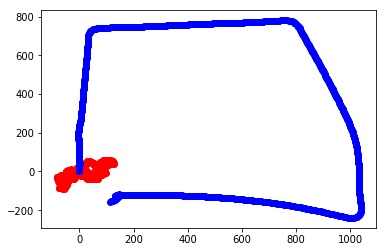

Count:3681
()
()
Relative Depth: 48.59551838651929
Relative x: -61.027073141705905
Relative Original Depth: 156.37305621116937
Relative Original x: 112.8404257225866
Count:3682
()
()
Relative Depth: 48.70815120814978
Relative x: -62.00119730103429
Relative Original Depth: 156.64713620271505
Relative Original x: 111.87989562187231
Count:3683
()
()
Relative Depth: 48.29246258430154
Relative x: -62.80227657872882
Relative Original Depth: 156.935260415952
Relative Original x: 110.92230722111753
Count:3684
()
()
Relative Depth: 47.612255781150765
Relative x: -63.432913980449804
Relative Original Depth: 157.2511759357998
Relative Original x: 109.97381031811851
Count:3685
()
()
Relative Depth: 46.89963312254269
Relative x: -64.05321843290723
Relative Original Depth: 157.59311562073526
Relative Original x: 109.03422185144453


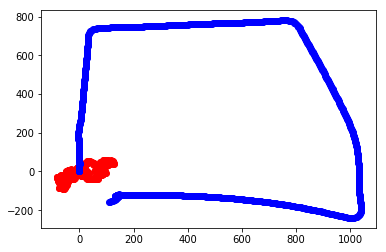

Count:3686
()
()
Relative Depth: 46.12057798653586
Relative x: -64.61241259184028
Relative Original Depth: 157.95712465193967
Relative Original x: 108.10314023820882
Count:3687
()
()
Relative Depth: 45.316345083187976
Relative x: -65.1368021161423
Relative Original Depth: 158.31644831140727
Relative Original x: 107.17080521271897
Count:3688
()
()
Relative Depth: 44.56517412990215
Relative x: -65.79203710834548
Relative Original Depth: 158.63047214991371
Relative Original x: 106.22170015667739
Count:3689
()
()
Relative Depth: 43.739522483195834
Relative x: -66.33504788229824
Relative Original Depth: 158.92214498833857
Relative Original x: 105.2673358409853
Count:3690
()
()
Relative Depth: 42.828962635755744
Relative x: -66.73615627153713
Relative Original Depth: 159.19211768209303
Relative Original x: 104.30950397416447


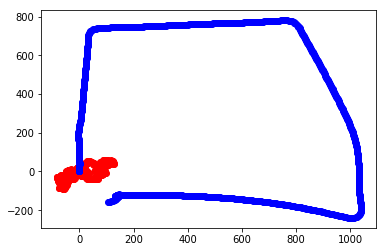

Count:3691
()
()
Relative Depth: 42.18393343936297
Relative x: -67.43203590596725
Relative Original Depth: 159.47863864453953
Relative Original x: 103.35515468008043
Count:3692
()
()
Relative Depth: 42.31063289987714
Relative x: -68.25715901171593
Relative Original Depth: 159.76953316289732
Relative Original x: 102.4025655358237
Count:3693
()
()
Relative Depth: 42.14303279818348
Relative x: -69.1479012502756
Relative Original Depth: 160.03196298919246
Relative Original x: 101.44311660136735
Count:3694
()
()
Relative Depth: 41.445441346105895
Relative x: -69.81332286974593
Relative Original Depth: 160.30206745650094
Relative Original x: 100.48714244222046
Count:3695
()
()
Relative Depth: 40.85413991574011
Relative x: -70.61732432286114
Relative Original Depth: 160.5338384677584
Relative Original x: 99.52014816828223


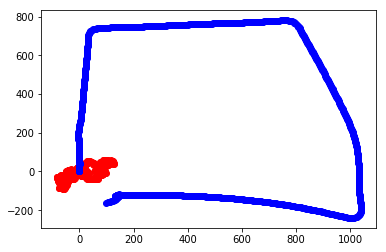

Count:3696
()
()
Relative Depth: 40.44983028661863
Relative x: -71.51791460359512
Relative Original Depth: 160.77903427216532
Relative Original x: 98.55770316428132
Count:3697
()
()
Relative Depth: 39.83406952432034
Relative x: -72.24258273779834
Relative Original Depth: 161.03349046976817
Relative Original x: 97.59616798506842
Count:3698
()
()
Relative Depth: 39.11451444986727
Relative x: -72.76082345700914
Relative Original Depth: 161.2719373029899
Relative Original x: 96.63811836432576
Count:3699
()
()
Relative Depth: 38.61863088451096
Relative x: -73.17662604833679
Relative Original Depth: 161.47947972015427
Relative Original x: 95.6778736767421
Count:3700
()
()
Relative Depth: 38.654586501439056
Relative x: -73.91514661889416
Relative Original Depth: 161.69997158500428
Relative Original x: 94.71942189323853


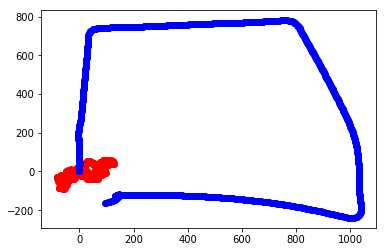

Count:3701
()
()
Relative Depth: 38.822952211382976
Relative x: -74.89411985489305
Relative Original Depth: 161.92129959422914
Relative Original x: 93.76679653183044
Count:3702
()
()
Relative Depth: 38.82632689503705
Relative x: -75.81827152979783
Relative Original Depth: 162.12218128951346
Relative Original x: 92.80359480426193
Count:3703
()
()
Relative Depth: 38.81760617888905
Relative x: -76.8074349089315
Relative Original Depth: 162.33441430598086
Relative Original x: 91.8446896222569
Count:3704
()
()
Relative Depth: 38.89776256545466
Relative x: -77.80214735569884
Relative Original Depth: 162.55240101993306
Relative Original x: 90.88575072639341
Count:3705
()
()
Relative Depth: 39.08946915533854
Relative x: -78.76845384712203
Relative Original Depth: 162.71310826545204
Relative Original x: 89.91414424711193


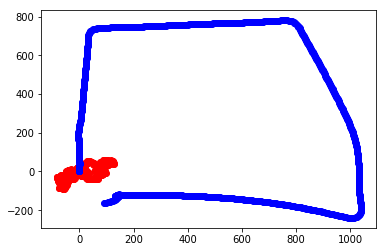

Count:3706
()
()
Relative Depth: 39.366112183017115
Relative x: -79.66637032970269
Relative Original Depth: 162.92467879700965
Relative Original x: 88.95364740487916
Count:3707
()
()
Relative Depth: 39.592744089164206
Relative x: -80.56423044049093
Relative Original Depth: 163.08989396876873
Relative Original x: 87.98534848517735
Count:3708
()
()
Relative Depth: 39.679439247481945
Relative x: -81.41560833894705
Relative Original Depth: 163.28322848987284
Relative Original x: 87.02099355497305
Count:3709
()
()
Relative Depth: 39.622559752406396
Relative x: -82.15456239512422
Relative Original Depth: 163.44310170070133
Relative Original x: 86.0484333190762
Count:3710
()
()
Relative Depth: 39.544043103014836
Relative x: -82.8913921838431
Relative Original Depth: 163.60360252463136
Relative Original x: 85.07987379653913


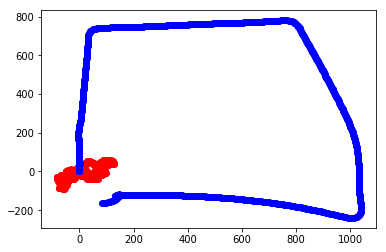

Count:3711
()
()
Relative Depth: 39.91398948635444
Relative x: -83.76936061440222
Relative Original Depth: 163.77792580558727
Relative Original x: 84.11505774050418
Count:3712
()
()
Relative Depth: 40.194804992918264
Relative x: -84.5017859977108
Relative Original Depth: 163.95335323800023
Relative Original x: 83.14788874036566
Count:3713
()
()
Relative Depth: 39.870966674647285
Relative x: -84.81687986069554
Relative Original Depth: 164.15494652901074
Relative Original x: 82.18918205230167
Count:3714
()
()
Relative Depth: 40.19744433557865
Relative x: -85.35626177190404
Relative Original Depth: 164.33027430069473
Relative Original x: 81.22315736339728
Count:3715
()
()
Relative Depth: 40.94569448805175
Relative x: -85.77272210596419
Relative Original Depth: 164.51900099004703
Relative Original x: 80.26591004905406


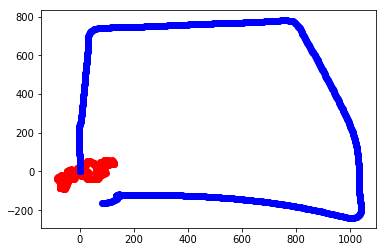

Count:3716
()
()
Relative Depth: 41.214213232551245
Relative x: -85.90679749399716
Relative Original Depth: 164.66356030372359
Relative Original x: 79.29342083906035
Count:3717
()
()
Relative Depth: 41.18595014817052
Relative x: -85.82644175242284
Relative Original Depth: 164.8160390128043
Relative Original x: 78.32743731867333
Count:3718
()
()
Relative Depth: 40.86435845838934
Relative x: -85.83280082028166
Relative Original Depth: 164.9628181970937
Relative Original x: 77.36107438943613
Count:3719
()
()
Relative Depth: 40.291304765050725
Relative x: -86.1063749119098
Relative Original Depth: 165.10431003777572
Relative Original x: 76.39096306079193
Count:3720
()
()
Relative Depth: 40.00925524389365
Relative x: -86.67270989531029
Relative Original Depth: 165.25233405850253
Relative Original x: 75.425376330762


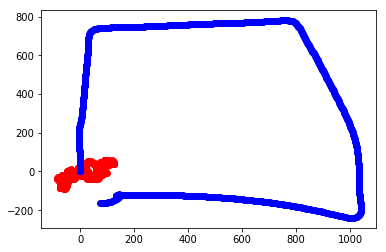

Count:3721
()
()
Relative Depth: 39.71696117797738
Relative x: -87.33053715501934
Relative Original Depth: 165.39769047671936
Relative Original x: 74.45932392010837
Count:3722
()
()
Relative Depth: 39.31168806195475
Relative x: -88.03561230375266
Relative Original Depth: 165.58705329116304
Relative Original x: 73.50044717405541
Count:3723
()
()
Relative Depth: 38.32832122834987
Relative x: -87.9720266741831
Relative Original Depth: 165.74799675795273
Relative Original x: 72.53738243371585
Count:3724
()
()
Relative Depth: 37.752484656027164
Relative x: -88.66347606267561
Relative Original Depth: 165.91475331823673
Relative Original x: 71.5787089717773
Count:3725
()
()
Relative Depth: 37.128667665405835
Relative x: -89.33614791599481
Relative Original Depth: 166.09820004421914
Relative Original x: 70.62033574932556


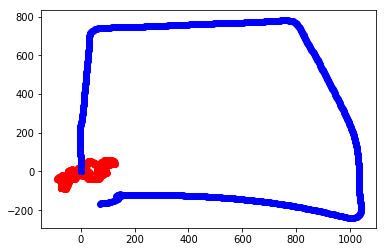

Count:3726
()
()
Relative Depth: 36.628753069219584
Relative x: -90.00018995590737
Relative Original Depth: 166.25523413478115
Relative Original x: 69.66077157406195
Count:3727
()
()
Relative Depth: 36.56719347690729
Relative x: -90.70581393278393
Relative Original Depth: 166.393512419529
Relative Original x: 68.70003083570265
Count:3728
()
()
Relative Depth: 37.00867484674985
Relative x: -91.37400399396807
Relative Original Depth: 166.54966718317678
Relative Original x: 67.74029461369597
Count:3729
()
()
Relative Depth: 37.65865150402836
Relative x: -91.91086512620842
Relative Original Depth: 166.68080080445333
Relative Original x: 66.76970709051034
Count:3730
()
()
Relative Depth: 38.233101883347366
Relative x: -92.4421552559164
Relative Original Depth: 166.8791048848688
Relative Original x: 65.82628014206941


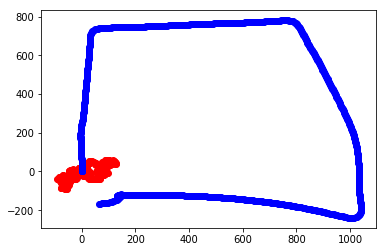

Count:3731
()
()
Relative Depth: 39.169820462157446
Relative x: -92.60968059423881
Relative Original Depth: 167.0209102277319
Relative Original x: 64.86095458653263
Count:3732
()
()
Relative Depth: 39.65655129400569
Relative x: -93.27753531293024
Relative Original Depth: 167.19437335410944
Relative Original x: 63.897115205518936
Count:3733
()
()
Relative Depth: 40.26137767874691
Relative x: -93.93204794889547
Relative Original Depth: 167.4047398063129
Relative Original x: 62.94372895447766
Count:3734
()
()
Relative Depth: 40.999712192052236
Relative x: -94.60556363985592
Relative Original Depth: 167.60226771655633
Relative Original x: 61.987646607970206
Count:3735
()
()
Relative Depth: 41.22822533659055
Relative x: -95.54010280775151
Relative Original Depth: 167.8096112307477
Relative Original x: 61.04033108320464


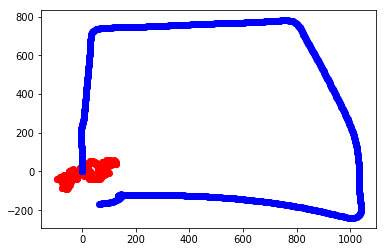

Count:3736
()
()
Relative Depth: 41.144778579437265
Relative x: -96.53193328523993
Relative Original Depth: 168.01073177883208
Relative Original x: 60.08221032666787
Count:3737
()
()
Relative Depth: 41.09236258181855
Relative x: -97.52204157211288
Relative Original Depth: 168.23793198520755
Relative Original x: 59.13995904282433
Count:3738
()
()
Relative Depth: 41.139488017787116
Relative x: -98.51705330424565
Relative Original Depth: 168.39817180283598
Relative Original x: 58.18062974479785
Count:3739
()
()
Relative Depth: 41.03663866629228
Relative x: -99.50384326786643
Relative Original Depth: 168.54253225202368
Relative Original x: 57.21862457080734
Count:3740
()
()
Relative Depth: 40.8467789547573
Relative x: -100.38369617899696
Relative Original Depth: 168.68736256378793
Relative Original x: 56.2551551680289


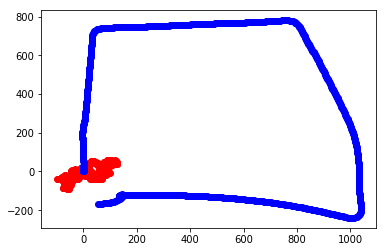

Count:3741
()
()
Relative Depth: 40.76070753624294
Relative x: -101.11059965225098
Relative Original Depth: 168.852949785954
Relative Original x: 55.30059302756911
Count:3742
()
()
Relative Depth: 41.71245989406768
Relative x: -100.87801533799706
Relative Original Depth: 169.02754183341898
Relative Original x: 54.350233665643636
Count:3743
()
()
Relative Depth: 42.36379028964312
Relative x: -101.48916925935528
Relative Original Depth: 169.1873723051364
Relative Original x: 53.39103408842373
Count:3744
()
()
Relative Depth: 42.356359042316456
Relative x: -102.18342398048456
Relative Original Depth: 169.36691239276456
Relative Original x: 52.43194214618311
Count:3745
()
()
Relative Depth: 42.44577242313724
Relative x: -103.01683403532304
Relative Original Depth: 169.5670804513891
Relative Original x: 51.47795213558459


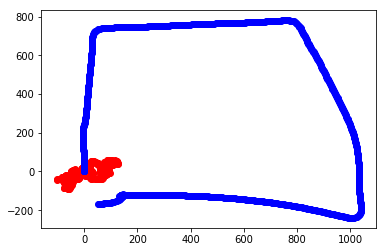

Count:3746
()
()
Relative Depth: 42.67047369779613
Relative x: -103.98582298850748
Relative Original Depth: 169.74462196774905
Relative Original x: 50.51482330710905
Count:3747
()
()
Relative Depth: 42.906415471167385
Relative x: -104.78360241129923
Relative Original Depth: 169.96324618733368
Relative Original x: 49.56161774840008
Count:3748
()
()
Relative Depth: 43.222709072090794
Relative x: -105.40797826823619
Relative Original Depth: 170.08289504977307
Relative Original x: 48.584019784295165
Count:3749
()
()
Relative Depth: 43.661795885183835
Relative x: -105.5593507090406
Relative Original Depth: 170.2551615204753
Relative Original x: 47.61804126930453
Count:3750
()
()
Relative Depth: 44.09274034427404
Relative x: -105.53030195585288
Relative Original Depth: 170.41011095044416
Relative Original x: 46.64864479198961


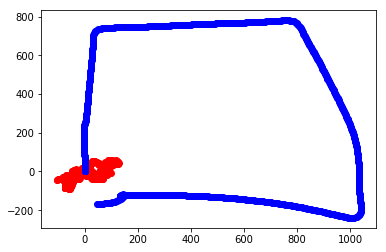

Count:3751
()
()
Relative Depth: 44.622297898852004
Relative x: -105.60731955286447
Relative Original Depth: 170.57461844803822
Relative Original x: 45.68973717574388
Count:3752
()
()
Relative Depth: 45.15130924391816
Relative x: -105.77569843395098
Relative Original Depth: 170.74498685382827
Relative Original x: 44.73993038403978
Count:3753
()
()
Relative Depth: 45.2894818077296
Relative x: -105.95976256112247
Relative Original Depth: 170.83569617883518
Relative Original x: 43.770486887338265
Count:3754
()
()
Relative Depth: 45.27764124927171
Relative x: -105.89953354753992
Relative Original Depth: 171.00840956014844
Relative Original x: 42.824238893016485
Count:3755
()
()
Relative Depth: 45.38839388609506
Relative x: -105.73804283625584
Relative Original Depth: 171.14744541715802
Relative Original x: 41.86723271052941


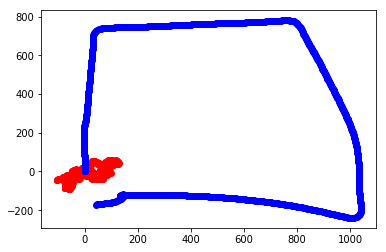

Count:3756
()
()
Relative Depth: 45.49126375875603
Relative x: -105.6075032398246
Relative Original Depth: 171.30018816267062
Relative Original x: 40.9095856286326
Count:3757
()
()
Relative Depth: 45.64918956558052
Relative x: -105.42593745906777
Relative Original Depth: 171.44375830556086
Relative Original x: 39.938261093052475
Count:3758
()
()
Relative Depth: 45.949155815675496
Relative x: -105.00584282637702
Relative Original Depth: 171.65482037285298
Relative Original x: 38.99532769896375
Count:3759
()
()
Relative Depth: 45.67365257877906
Relative x: -104.83329299919916
Relative Original Depth: 171.82720892994985
Relative Original x: 38.03877151220781
Count:3760
()
()
Relative Depth: 45.045034017320305
Relative x: -105.26634031766983
Relative Original Depth: 171.99453325916517
Relative Original x: 37.07931283057219


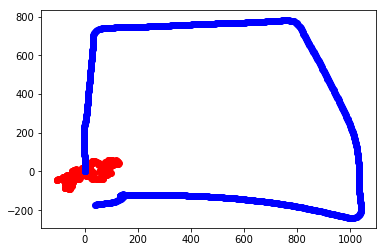

Count:3761
()
()
Relative Depth: 44.54709759636789
Relative x: -105.78677548270439
Relative Original Depth: 172.1830037916371
Relative Original x: 36.12428123314766
Count:3762
()
()
Relative Depth: 44.01273894406239
Relative x: -106.39897942856807
Relative Original Depth: 172.32025746657052
Relative Original x: 35.16101905901043
Count:3763
()
()
Relative Depth: 44.33437934965511
Relative x: -106.92786170682506
Relative Original Depth: 172.49301234819106
Relative Original x: 34.19928606056167
Count:3764
()
()
Relative Depth: 43.81308725179859
Relative x: -107.72491954480479
Relative Original Depth: 172.65243012203877
Relative Original x: 33.23973932816492
Count:3765
()
()
Relative Depth: 43.278664158347304
Relative x: -108.56264741048972
Relative Original Depth: 172.7792748436746
Relative Original x: 32.26789269715384


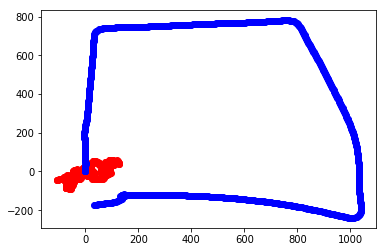

Count:3766
()
()
Relative Depth: 42.68785611335698
Relative x: -109.36886270750134
Relative Original Depth: 172.8881708307906
Relative Original x: 31.30171691967451
Count:3767
()
()
Relative Depth: 42.03141701429142
Relative x: -110.1218570069319
Relative Original Depth: 173.13552371540342
Relative Original x: 30.36517602220086
Count:3768
()
()
Relative Depth: 42.026468956451986
Relative x: -110.87271514343698
Relative Original Depth: 173.33736481733538
Relative Original x: 29.40819845417202
Count:3769
()
()
Relative Depth: 41.397412824271186
Relative x: -111.63579177568192
Relative Original Depth: 173.5125367327873
Relative Original x: 28.445821138764778
Count:3770
()
()
Relative Depth: 40.90437987745814
Relative x: -112.50388634877125
Relative Original Depth: 173.67051774925835
Relative Original x: 27.488707949585574


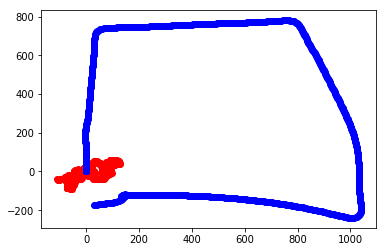

Count:3771
()
()
Relative Depth: 40.73547467300492
Relative x: -112.32847041118347
Relative Original Depth: 173.81500029488717
Relative Original x: 26.52360430212153
Count:3772
()
()
Relative Depth: 40.44750284764974
Relative x: -113.22783165532576
Relative Original Depth: 173.95712075306136
Relative Original x: 25.556865167024682
Count:3773
()
()
Relative Depth: 40.98416398616845
Relative x: -113.87009040805384
Relative Original Depth: 174.0832302855009
Relative Original x: 24.596028472464003
Count:3774
()
()
Relative Depth: 40.96747000648389
Relative x: -112.87178507586877
Relative Original Depth: 174.28842764875722
Relative Original x: 23.65119340760251
Count:3775
()
()
Relative Depth: 41.96209185795213
Relative x: -112.95761373180842
Relative Original Depth: 174.40381359863153
Relative Original x: 22.68336769193319


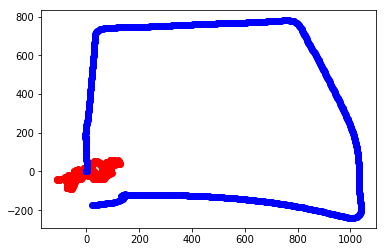

Count:3776
()
()
Relative Depth: 42.9398785408601
Relative x: -112.90650681924382
Relative Original Depth: 174.53357810083892
Relative Original x: 21.726972989575835
Count:3777
()
()
Relative Depth: 43.75862342628889
Relative x: -112.54525113381301
Relative Original Depth: 174.6257443121344
Relative Original x: 20.762495906526745
Count:3778
()
()
Relative Depth: 44.4568174365876
Relative x: -112.28136616899084
Relative Original Depth: 174.7972255745613
Relative Original x: 19.811449320130126
Count:3779
()
()
Relative Depth: 45.2688904446612
Relative x: -112.35978138194585
Relative Original Depth: 174.96052657729598
Relative Original x: 18.85010852429666
Count:3780
()
()
Relative Depth: 46.14360349941034
Relative x: -112.60449576515097
Relative Original Depth: 175.2047731679693
Relative Original x: 17.914854897110892


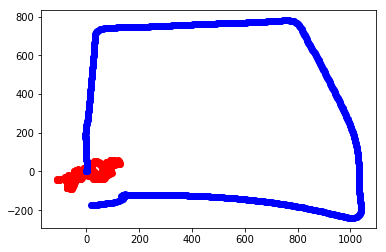

Count:3781
()
()
Relative Depth: 46.882486877382746
Relative x: -112.90209931382984
Relative Original Depth: 175.39633004738857
Relative Original x: 16.956339417216945
Count:3782
()
()
Relative Depth: 46.759910382519585
Relative x: -113.8820960438885
Relative Original Depth: 175.52564414355257
Relative Original x: 16.000581343844708
Count:3783
()
()
Relative Depth: 47.38445924094026
Relative x: -114.4291481269785
Relative Original Depth: 175.75892783937238
Relative Original x: 15.05360091363576
Count:3784
()
()
Relative Depth: 47.7272229514579
Relative x: -115.24342972896704
Relative Original Depth: 175.91073094556285
Relative Original x: 14.094548902603389
Count:3785
()
()
Relative Depth: 47.65503035502021
Relative x: -116.23829332099612
Relative Original Depth: 175.67605750183847
Relative Original x: 15.03511751825785


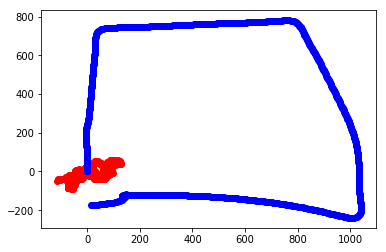

Count:3786
()
()
Relative Depth: 47.31233512238049
Relative x: -117.01793574112162
Relative Original Depth: 175.73816142631574
Relative Original x: 14.070257347149346
Count:3787
()
()
Relative Depth: 46.7429581148376
Relative x: -117.76845844157208
Relative Original Depth: 175.6229163309154
Relative Original x: 15.036286521422516
Count:3788
()
()
Relative Depth: 46.06217175147961
Relative x: -118.50087436050622
Relative Original Depth: 175.77077024166167
Relative Original x: 14.072889054525273
Count:3789
()
()
Relative Depth: 45.429967736955184
Relative x: -119.27412334440983
Relative Original Depth: 175.9227449011615
Relative Original x: 13.111550130145767
Count:3790
()
()
Relative Depth: 44.92500432463999
Relative x: -120.13438403720457
Relative Original Depth: 175.74569137042278
Relative Original x: 14.062980128826421


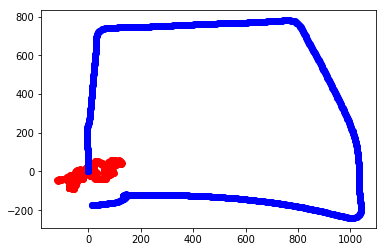

Count:3791
()
()
Relative Depth: 44.331989256005734
Relative x: -119.39859032349744
Relative Original Depth: 175.9101689983869
Relative Original x: 13.100939684224112
Count:3792
()
()
Relative Depth: 44.0775410169622
Relative x: -120.32972040353967
Relative Original Depth: 176.2058649128792
Relative Original x: 12.17426597299004
Count:3793
()
()
Relative Depth: 43.90559392568668
Relative x: -121.28342590148938
Relative Original Depth: 176.4086342616635
Relative Original x: 11.222231817008153
Count:3794
()
()
Relative Depth: 43.617969143201165
Relative x: -122.23324705207925
Relative Original Depth: 176.6253301328843
Relative Original x: 10.268889955086877
Count:3795
()
()
Relative Depth: 43.160022067786706
Relative x: -122.94545114416279
Relative Original Depth: 176.38607452046136
Relative Original x: 11.19165403326123


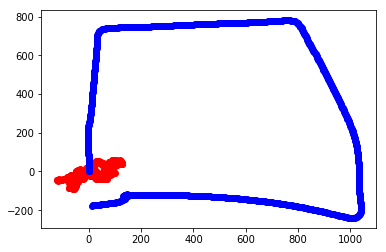

Count:3796
()
()
Relative Depth: 42.498785323974545
Relative x: -123.69561952309482
Relative Original Depth: 176.47787318008017
Relative Original x: 10.217014595412362
Count:3797
()
()
Relative Depth: 41.55116620167782
Relative x: -123.71524616140687
Relative Original Depth: 176.6829176151822
Relative Original x: 9.274614759117515
Count:3798
()
()
Relative Depth: 40.556242158855234
Relative x: -123.79013254587845
Relative Original Depth: 176.51119761275683
Relative Original x: 10.204825661297576
Count:3799
()
()
Relative Depth: 39.69201827735151
Relative x: -124.26761140170325
Relative Original Depth: 176.39462197307475
Relative Original x: 11.172443485127825
Count:3800
()
()
Relative Depth: 38.7945931212191
Relative x: -124.68223482701546
Relative Original Depth: 176.19434996207212
Relative Original x: 12.12654163719345


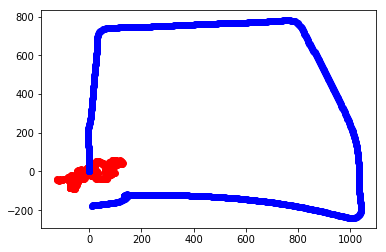

Count:3801
()
()


KeyboardInterrupt: 

In [38]:
count = 1
base_pose = np.identity(4)
original_base_pose = np.identity(4)
x_points = []
z_points = []
original_x_points = []
original_z_points = []
for i in range(25, len(files) - 1):
    
    # get two images and resize them
    (image1, k_matrix) = get_image(files[i])
    (image2, k_matrix) = get_image(files[i+1])
    image1 = np.ascontiguousarray(image1, dtype=np.uint8)
    image2 = np.ascontiguousarray(image2, dtype=np.uint8)
    
    # convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    gray1 = gray1[150:750, :]
    gray2 = gray2[150:750, :]
    
    # get keypoints
    (ptsLeft, ptsRight) = get_keypoints(gray1, gray2)
    
    # get fundamental matrix
    (fundamental_matrix, best_ptsLeft, best_ptsRight) = get_fundamental_matrix_ransac(ptsLeft.copy(), ptsRight.copy())
    if(len(best_ptsLeft) < 5):
        continue
    
    # get essential matrix (from opencv and without opencv)
    essential_matrix = get_essential_matrix(fundamental_matrix, k_matrix)
    original_essential_matrix, _ = cv2.findEssentialMat(np.array(ptsLeft), np.array(ptsRight), focal = k_matrix[0, 0], pp = (k_matrix[0, 2], k_matrix[1, 2]), method = cv2.RANSAC, prob = 0.999, threshold = 0.5)
    
    # get camera poses
    matrices = get_camera_poses(essential_matrix)
    translation_matrices = np.array(matrices[0])
    rotation_matrices = np.array(matrices[1])
    
    # get best pose (with opencv and without opencv)
    best_camera_pose = get_best_camera_pose(translation_matrices, rotation_matrices, np.identity(4), best_ptsLeft, best_ptsRight)
    best_camera_pose = np.vstack([best_camera_pose, np.matrix([0, 0, 0, 1], dtype=np.float)])
    _, original_rotation_matrix, original_translation_matrix, mask = cv2.recoverPose(original_essential_matrix, np.array(ptsLeft), np.array(ptsRight), focal = k_matrix[0, 0], pp = (k_matrix[0, 2], k_matrix[1, 2]))
    if(np.linalg.det(original_rotation_matrix) < 0):
        original_rotation_matrix = -original_rotation_matrix
        original_translation_matrix = -original_translation_matrix
    original_pose = np.hstack([original_rotation_matrix, original_translation_matrix])
    original_pose = np.vstack([original_pose, np.matrix([0, 0, 0, 1], dtype=np.float)])
        
    # update the base pose for further frame calculation
    original_base_pose = np.dot(original_base_pose, original_pose)
    base_pose = np.dot(base_pose, best_camera_pose)
    print("Relative Depth: " + str(base_pose[2, 3]))
    print("Relative x: " + str(base_pose[0, 3]))
    print("Relative Original Depth: " + str(original_base_pose[2, 3]))
    print("Relative Original x: " + str(original_base_pose[0, 3]))
    if(count % 5 == 0):
        original_x_points.append(original_base_pose[0, 3])
        original_z_points.append(-original_base_pose[2, 3])
        x_points.append(base_pose[0, 3])
        z_points.append(-base_pose[2, 3])
        
        # plot
        plt.plot(x_points, z_points, 'o', color='r')
        plt.plot(original_x_points, original_z_points, 'o', color='b')
        plt.show()
        
    count = count + 1
    print("Count:" + str(count))
    print()
    print()
    #if(count > 10):
    #    break

In [59]:
len(original_x_points)

760

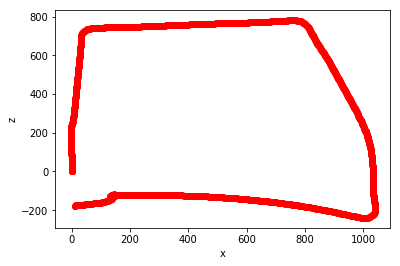

In [65]:
from matplotlib import pyplot as plt
#plt.plot(x_points[:15], z_points[:15], 'o', color='r')
plt.plot(original_x_points, original_z_points, 'o', color='r')
plt.xlabel("x")
plt.ylabel("z")
#plt.xlim(0, 600)
#plt.ylim(0, 600)
plt.show()

In [114]:
print(x_points)
print(z_points)
#print(original_x_points)
#print(original_z_points)

[-1.1891879810991943, -4.768916213677255, -5.1128637057787545, 3.438234860315185, 1.467948776585641, -6.562654016282714, -15.255779792665114, -30.191699608175778, -34.7249646351428, -22.38452297267011, -26.785426940408374, -22.196083983370386, -26.826390969830722, -19.876446944357482, -27.849827886938918, -26.45864645972883, -18.475726551915866, -20.035833488910022, -31.987520891240564, -40.84046093492509, -42.55250326700028, -43.66439032862367, -48.34988378385913, -41.672760394919635, -31.02991610761185, -30.108274423225215, -32.85781792186625, -31.89628859523475, -23.42101049288415, -16.146304031195875, -15.972199078525415, -14.073431380456332, -23.35145994395795, -24.799592762410892, -22.711016437294287, -29.240531203542222, -26.381693149588504, -9.813562075017243, -4.900479744710041, -6.219152644367176, -12.782942614182753, -9.318648350280393, -11.283888899490854, -14.571051391977454, -17.740984374233662, -31.283079297933863, -31.966710833502297, -21.056252612061076, -20.6082404833